In [13]:
import tensorflow as tf
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, applications, Sequential, Model, backend
from tensorflow.keras import optimizers, initializers, regularizers, metrics, utils

# ResNet50

load ResNet50

In [14]:
HEIGHT = 512
WIDTH = 512
class_num = 1
input_shape = (HEIGHT,WIDTH,3)

In [15]:
base_model = applications.ResNet50(include_top=False, input_shape=input_shape, weights=None, pooling='avg')
    
x = base_model.output
x = layers.Dense(1000, activation="softmax")(x)
resnet50 = Model(base_model.input, x)

#freeze layer
for layer in resnet50.layers:
    layer.trainable = False

#load pre_trained weight
resnet50.load_weights("resnet50_ImageNet.h5")

#unfreeze layer
for layer in resnet50.layers[:174]:
    layer.trainable = True

In [16]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

extract feature C1~C5

In [17]:
C1 = resnet50.get_layer('pool1_pad').output
C2 = resnet50.get_layer('conv2_block3_out').output
C3 = resnet50.get_layer('conv3_block4_out').output
C4 = resnet50.get_layer('conv4_block6_out').output
C5 = resnet50.get_layer('conv5_block3_out').output

# Feature Pyramid Network

In [18]:
def P5(x, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    return x

def FPN(x, y, train_bn=True):
    x = layers.Conv2D(256, (1,1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    y = layers.UpSampling2D()(y)
    
    P = layers.Add()([x, y])
    
    return P

In [19]:
P5 = P5(C5)
P4 = FPN(C4, P5)
P3 = FPN(C3, P4)
P2 = FPN(C2, P3)

In [20]:
def FM(x, upsampling, train_bn=True):
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    if upsampling != 1:
        x = layers.Conv2DTranspose(128, (3, 3), strides=(upsampling, upsampling), padding='same')(x)
        x = layers.BatchNormalization()(x, training=train_bn)
        x = layers.Activation('relu')(x)
    
    return x

feature map

In [21]:
FM5 = FM(P5, 8)
FM4 = FM(P4, 4)
FM3 = FM(P3, 2)
FM2 = FM(P2, 1)
FM = layers.concatenate([FM5, FM4, FM3, FM2])
FM.shape

TensorShape([None, 128, 128, 512])

pooling

In [22]:
FM = layers.MaxPool2D(pool_size=(8,8))(FM)
FM.shape

TensorShape([None, 16, 16, 512])

In [23]:
def Mask_Head(x, train_bn=True):
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)   
   
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(class_num, (1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x, training=train_bn)
    x = layers.Activation('sigmoid')(x)
    
    x = layers.UpSampling2D(size=(4,4),interpolation='bilinear')(x)
    
    return x

In [24]:
Mask_output = Mask_Head(FM)
Mask_output.shape

TensorShape([None, 512, 512, 1])

make model

In [25]:
NADS_Net = Model(resnet50.input, Mask_output)
NADS_Net = utils.multi_gpu_model(NADS_Net, gpus=2)

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.


In [26]:
NADS_Net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 512, 512, 1)  37034245    lambda[0][0]                     
                                                                 lambda_1[0][0]             

example image

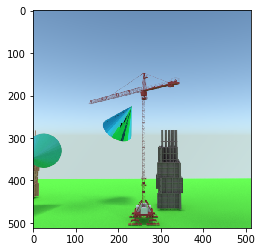

In [27]:
img = plt.imread('./camera20034.png')
plt.imshow(img)

In [28]:
img = tf.reshape(img, (1, 512, 512, 3))
img = tf.cast(img, dtype=tf.float32)

In [29]:
example = NADS_Net(img)
example.shape

TensorShape([1, 512, 512, 1])

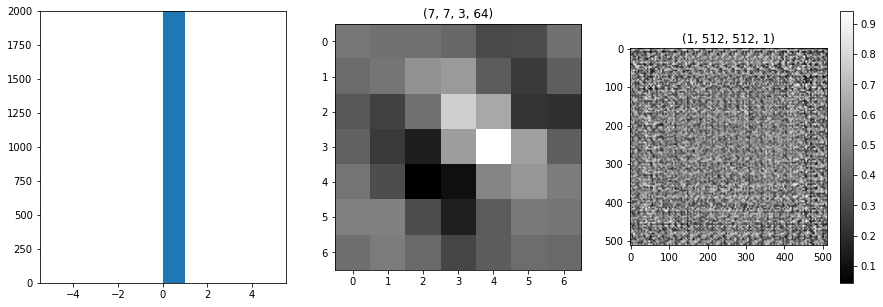

In [30]:
weight = NADS_Net.get_weights()[0]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(example.numpy().ravel(), range=[-5,5])
plt.ylim(0, 2000)
plt.subplot(132)
plt.title(weight.shape)
plt.imshow(weight[:,:,0,0], 'gray')
plt.subplot(133)
plt.title(example.shape)
plt.imshow(example[0, :, :, 0], 'gray')
plt.colorbar()
plt.show()

# Load image dataset

In [31]:
train_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/train/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/test/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/val/*.png')

In [32]:
def get_label(path):
    label_name = path[-15:-4]
    label_path = 'C:/Users/IVCL/Desktop/dock5_DR/classify_occlusionX_semantic/%s.png'%label_name
    label = plt.imread(label_path)
    label = label[...,tf.newaxis]
    label = tf.cast(label, dtype=tf.float32)
    
    return label

In [33]:
def read_image(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (image / 127.5) - 1
    
    return image

In [34]:
def make_batch(batch_paths):
    batch_images = []
    batch_labels = []
        
    for path in batch_paths:
        image = read_image(path)
        batch_images.append(image)
        
        label = get_label(path)
        batch_labels.append(label)
    
    return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels)

In [35]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    test_input = test_input[tf.newaxis, ...]
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[:,:,0], tf.where(prediction[0,:,:,0]>=0.5,1.0,0)]
    
    title = ['Input Image', 'Ground Truth', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

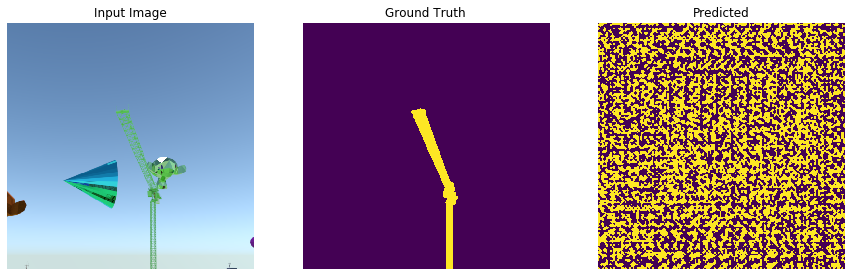

In [36]:
image = read_image(train_paths[0])
label = get_label(train_paths[0])
generate_images(NADS_Net, image, label)

# Define Loss and Optimizer

In [37]:
# Define loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Metrics

In [38]:
def precision(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_positive = tf.reduce_sum(pred)
    
    precision = true_positive / (true_positive_false_positive + tf.keras.backend.epsilon())
                                 
    return precision

                                 
def recall(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_negative = tf.reduce_sum(truth)
    
    recall = true_positive / (true_positive_false_negative + tf.keras.backend.epsilon())
                                 
    return recall

# Checkpoint

In [39]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, NADS_Net=NADS_Net)

# Train

In [40]:
#Hyperparameter
BATCH_SIZE = 2
EPOCHS = 20
train_steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps_per_epoch = len(val_paths)

In [41]:
@tf.function
#def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
def train_step(model, images, labels, loss_object, optimizer, train_loss):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
       
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    #train_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

# Implement algorithm test
@tf.function
#def val_step(model, images, labels, loss_object, val_loss, val_accuracy):
def val_step(model, images, labels, loss_object, val_loss):
    predictions = model(images, training=False)
    
    v_loss = loss_object(labels, predictions)
    val_loss(v_loss)
    #val_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

In [42]:
loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    random.shuffle(train_paths)
    
    train_loss_sum = 0
    val_loss_sum = 0
        
    for step in range(train_steps_per_epoch):
        images, labels = make_batch(train_paths[step * BATCH_SIZE : (step + 1) * BATCH_SIZE])
        
        train_precision, train_recall = train_step(NADS_Net, images, labels, loss_object, optimizer, train_loss)
        
        #template = 'Step {}, Loss: {}, Accuracy: {}'
        template = 'Epoch {}, Step {}, Loss: {}, Precision: {}, Recall: {}'
        print(template.format(epoch + 1, step + 1,
                              train_loss.result(),
                              train_precision * 100,
                              train_recall * 100))

        train_loss_sum = train_loss_sum + train_loss.result()
        
        train_loss.reset_states()
        val_loss.reset_states()
       
    for step in range(val_steps_per_epoch):
        val_images, val_labels = make_batch(val_paths[step * 1 : (step + 1) * 1])
        
        val_precision, val_recall = val_step(NADS_Net, val_images, val_labels, loss_object, val_loss)
        
        val_loss_sum = val_loss_sum + val_loss.result()    
    
    loss_list.append(train_loss_sum / len(train_paths))
    val_loss_list.append(val_loss_sum / len(val_paths))
    
    #template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    template = 'Epoch {}, Val_Loss: {}, Val_Precision: {}, Val_Recall: {}'
    print(template.format(epoch + 1,
                          val_loss_sum / len(val_paths),
                          val_precision * 100,
                          val_recall * 100))
    train_loss.reset_states()
    val_loss.reset_states()
  
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1, Step 1, Loss: 0.7257789969444275, Precision: 5.2566728591918945, Recall: 52.36159133911133
Epoch 1, Step 2, Loss: 0.684903621673584, Precision: 8.6587495803833, Recall: 66.67168426513672
Epoch 1, Step 3, Loss: 0.6522086262702942, Precision: 10.991594314575195, Recall: 59.49214553833008
Epoch 1, Step 4, Loss: 0.6435093879699707, Precision: 17.2294921875, Recall: 60.098201751708984
Epoch 1, Step 5, Loss: 0.6456317901611328, Precision: 12.566680908203125, Recall: 64.82526397705078
Epoch 1, Step 6, Loss: 0.6350680589675903, Precision: 22.80950355529785, Recall: 68.36267852783203
Epoch 1, Step 7, Loss: 0.6504462361335754, Precision: 13.88102912902832, Recall: 44.31391143798828
Epoch 1, Step 8, Loss: 0.6434308886528015, Precision: 16.405073165893555, Recall: 53.243507385253906
Epoch 1, Step 9, Loss: 0.6337167024612427, Precision: 22.53264808654785, Recall: 80.79297637939453
Epoch 1, Step 10, Loss: 0.6273521780967712, Precision: 31.74293327331543, Recall: 62.46101379394531
Epoch 1, S

Epoch 1, Step 85, Loss: 0.5690469145774841, Precision: 53.75370788574219, Recall: 87.44129943847656
Epoch 1, Step 86, Loss: 0.560344934463501, Precision: 46.826168060302734, Recall: 98.24083709716797
Epoch 1, Step 87, Loss: 0.5598384737968445, Precision: 48.325870513916016, Recall: 97.20036315917969
Epoch 1, Step 88, Loss: 0.5409920811653137, Precision: 60.49420928955078, Recall: 90.72376251220703
Epoch 1, Step 89, Loss: 0.5598626136779785, Precision: 53.67189025878906, Recall: 80.80270385742188
Epoch 1, Step 90, Loss: 0.568830668926239, Precision: 45.194480895996094, Recall: 79.5768051147461
Epoch 1, Step 91, Loss: 0.5902180075645447, Precision: 32.41133499145508, Recall: 82.1055908203125
Epoch 1, Step 92, Loss: 0.5678441524505615, Precision: 41.646541595458984, Recall: 91.907470703125
Epoch 1, Step 93, Loss: 0.5380637645721436, Precision: 54.54740524291992, Recall: 97.53268432617188
Epoch 1, Step 94, Loss: 0.5530796051025391, Precision: 48.361305236816406, Recall: 97.45997619628906
E

Epoch 1, Step 167, Loss: 0.5209869742393494, Precision: 62.54524612426758, Recall: 73.50069427490234
Epoch 1, Step 168, Loss: 0.5188186168670654, Precision: 56.22109603881836, Recall: 98.78314208984375
Epoch 1, Step 169, Loss: 0.5428261756896973, Precision: 42.78205108642578, Recall: 95.2938461303711
Epoch 1, Step 170, Loss: 0.5422400236129761, Precision: 35.96890640258789, Recall: 95.9651870727539
Epoch 1, Step 171, Loss: 0.5543274283409119, Precision: 30.613094329833984, Recall: 72.92182159423828
Epoch 1, Step 172, Loss: 0.5455148816108704, Precision: 36.5838508605957, Recall: 98.0202407836914
Epoch 1, Step 173, Loss: 0.4981759190559387, Precision: 63.488746643066406, Recall: 96.58683776855469
Epoch 1, Step 174, Loss: 0.5249499678611755, Precision: 48.69670867919922, Recall: 96.70508575439453
Epoch 1, Step 175, Loss: 0.5469014644622803, Precision: 33.89772415161133, Recall: 94.58771514892578
Epoch 1, Step 176, Loss: 0.504042387008667, Precision: 56.04239273071289, Recall: 97.53860473

Epoch 1, Step 249, Loss: 0.4789559841156006, Precision: 57.63378143310547, Recall: 98.25810241699219
Epoch 1, Step 250, Loss: 0.47007042169570923, Precision: 62.433372497558594, Recall: 98.22532653808594
Epoch 1, Step 251, Loss: 0.5045218467712402, Precision: 46.06283950805664, Recall: 95.78267669677734
Epoch 1, Step 252, Loss: 0.48934805393218994, Precision: 56.0821418762207, Recall: 95.49066925048828
Epoch 1, Step 253, Loss: 0.48825711011886597, Precision: 57.098514556884766, Recall: 72.71880340576172
Epoch 1, Step 254, Loss: 0.4949740469455719, Precision: 50.69872283935547, Recall: 96.53697967529297
Epoch 1, Step 255, Loss: 0.5179503560066223, Precision: 35.96128463745117, Recall: 99.41301727294922
Epoch 1, Step 256, Loss: 0.5046741366386414, Precision: 49.39825439453125, Recall: 93.01698303222656
Epoch 1, Step 257, Loss: 0.5228433609008789, Precision: 35.33659362792969, Recall: 96.19959259033203
Epoch 1, Step 258, Loss: 0.5177804231643677, Precision: 40.12611770629883, Recall: 95.2

Epoch 1, Step 331, Loss: 0.4528857469558716, Precision: 55.1539306640625, Recall: 94.29338836669922
Epoch 1, Step 332, Loss: 0.4437044858932495, Precision: 61.65541458129883, Recall: 92.65462493896484
Epoch 1, Step 333, Loss: 0.4752241373062134, Precision: 40.551937103271484, Recall: 93.5043716430664
Epoch 1, Step 334, Loss: 0.4364250898361206, Precision: 67.37078094482422, Recall: 95.4446029663086
Epoch 1, Step 335, Loss: 0.4522462785243988, Precision: 54.94891357421875, Recall: 94.74950408935547
Epoch 1, Step 336, Loss: 0.4518285393714905, Precision: 51.301544189453125, Recall: 98.11475372314453
Epoch 1, Step 337, Loss: 0.4305485486984253, Precision: 67.02265930175781, Recall: 95.2065200805664
Epoch 1, Step 338, Loss: 0.4628717005252838, Precision: 44.48350143432617, Recall: 94.71726989746094
Epoch 1, Step 339, Loss: 0.4587791860103607, Precision: 48.626094818115234, Recall: 97.1268081665039
Epoch 1, Step 340, Loss: 0.4492848515510559, Precision: 51.880699157714844, Recall: 97.778305

Epoch 1, Step 413, Loss: 0.3842986822128296, Precision: 85.6596450805664, Recall: 91.2562484741211
Epoch 1, Step 414, Loss: 0.39009523391723633, Precision: 75.32243347167969, Recall: 96.82302856445312
Epoch 1, Step 415, Loss: 0.42094290256500244, Precision: 56.17024230957031, Recall: 98.1100082397461
Epoch 1, Step 416, Loss: 0.4386068880558014, Precision: 50.1279411315918, Recall: 97.42489624023438
Epoch 1, Step 417, Loss: 0.419991135597229, Precision: 63.138614654541016, Recall: 86.4803237915039
Epoch 1, Step 418, Loss: 0.4058402180671692, Precision: 70.0310287475586, Recall: 91.90571594238281
Epoch 1, Step 419, Loss: 0.43247416615486145, Precision: 54.57373809814453, Recall: 94.81785583496094
Epoch 1, Step 420, Loss: 0.401643842458725, Precision: 63.14823532104492, Recall: 98.81118774414062
Epoch 1, Step 421, Loss: 0.4153636693954468, Precision: 61.68368911743164, Recall: 87.04570770263672
Epoch 1, Step 422, Loss: 0.41979002952575684, Precision: 62.49747848510742, Recall: 96.64124298

Epoch 1, Step 495, Loss: 0.42125147581100464, Precision: 53.45808410644531, Recall: 97.77253723144531
Epoch 1, Step 496, Loss: 0.3995218873023987, Precision: 60.284088134765625, Recall: 92.7379150390625
Epoch 1, Step 497, Loss: 0.40524041652679443, Precision: 59.09044647216797, Recall: 93.81576538085938
Epoch 1, Step 498, Loss: 0.4156841039657593, Precision: 50.5894660949707, Recall: 78.46588897705078
Epoch 1, Step 499, Loss: 0.38451534509658813, Precision: 79.0199966430664, Recall: 85.95287322998047
Epoch 1, Step 500, Loss: 0.3931112289428711, Precision: 70.76364135742188, Recall: 93.46134948730469
Epoch 1, Step 501, Loss: 0.41230982542037964, Precision: 59.95109558105469, Recall: 93.689208984375
Epoch 1, Step 502, Loss: 0.3967128098011017, Precision: 76.03524017333984, Recall: 72.47054290771484
Epoch 1, Step 503, Loss: 0.3926970958709717, Precision: 66.56477355957031, Recall: 92.43317413330078
Epoch 1, Step 504, Loss: 0.4056928753852844, Precision: 54.8814582824707, Recall: 98.879089

Epoch 1, Step 577, Loss: 0.4014354646205902, Precision: 43.049922943115234, Recall: 93.1192398071289
Epoch 1, Step 578, Loss: 0.3617541790008545, Precision: 69.42987060546875, Recall: 93.18232727050781
Epoch 1, Step 579, Loss: 0.344679594039917, Precision: 79.83184814453125, Recall: 90.48040008544922
Epoch 1, Step 580, Loss: 0.38267189264297485, Precision: 55.35931396484375, Recall: 97.85299682617188
Epoch 1, Step 581, Loss: 0.36291712522506714, Precision: 67.22299194335938, Recall: 96.21139526367188
Epoch 1, Step 582, Loss: 0.3339576721191406, Precision: 77.48815155029297, Recall: 96.54332733154297
Epoch 1, Step 583, Loss: 0.400604248046875, Precision: 43.463836669921875, Recall: 87.60655212402344
Epoch 1, Step 584, Loss: 0.37180447578430176, Precision: 58.85906982421875, Recall: 93.16091918945312
Epoch 1, Step 585, Loss: 0.3773345947265625, Precision: 56.15776062011719, Recall: 95.67241668701172
Epoch 1, Step 586, Loss: 0.37284380197525024, Precision: 69.34808349609375, Recall: 92.45

Epoch 1, Step 659, Loss: 0.3351539075374603, Precision: 66.65827941894531, Recall: 97.85379028320312
Epoch 1, Step 660, Loss: 0.34644609689712524, Precision: 65.48114776611328, Recall: 90.58136749267578
Epoch 1, Step 661, Loss: 0.3863130807876587, Precision: 45.14801025390625, Recall: 61.958866119384766
Epoch 1, Step 662, Loss: 0.384870320558548, Precision: 46.920867919921875, Recall: 71.25778198242188
Epoch 1, Step 663, Loss: 0.3472929000854492, Precision: 61.36224365234375, Recall: 96.01480865478516
Epoch 1, Step 664, Loss: 0.3414513170719147, Precision: 76.7101058959961, Recall: 90.9400405883789
Epoch 1, Step 665, Loss: 0.3217375576496124, Precision: 74.28205871582031, Recall: 94.6978759765625
Epoch 1, Step 666, Loss: 0.32433247566223145, Precision: 72.57469177246094, Recall: 94.15101623535156
Epoch 1, Step 667, Loss: 0.3491799831390381, Precision: 64.529541015625, Recall: 96.24928283691406
Epoch 1, Step 668, Loss: 0.3742498755455017, Precision: 69.89669036865234, Recall: 61.7205543

Epoch 1, Step 741, Loss: 0.3307942748069763, Precision: 64.2688980102539, Recall: 93.59904479980469
Epoch 1, Step 742, Loss: 0.3443256914615631, Precision: 63.083553314208984, Recall: 75.0809097290039
Epoch 1, Step 743, Loss: 0.31286561489105225, Precision: 76.03471374511719, Recall: 87.22091674804688
Epoch 1, Step 744, Loss: 0.34198111295700073, Precision: 53.70365524291992, Recall: 90.53273010253906
Epoch 1, Step 745, Loss: 0.3197975158691406, Precision: 62.88745880126953, Recall: 98.18726348876953
Epoch 1, Step 746, Loss: 0.31170451641082764, Precision: 69.56687927246094, Recall: 98.08892822265625
Epoch 1, Step 747, Loss: 0.308288037776947, Precision: 71.91022491455078, Recall: 96.6947250366211
Epoch 1, Step 748, Loss: 0.2969289720058441, Precision: 87.0053939819336, Recall: 94.26666259765625
Epoch 1, Step 749, Loss: 0.3333473801612854, Precision: 62.93638229370117, Recall: 92.95307159423828
Epoch 1, Step 750, Loss: 0.33947834372520447, Precision: 63.530494689941406, Recall: 83.8270

Epoch 1, Step 823, Loss: 0.31768232583999634, Precision: 62.2802619934082, Recall: 87.81148529052734
Epoch 1, Step 824, Loss: 0.3021058440208435, Precision: 67.21453857421875, Recall: 99.41022491455078
Epoch 1, Step 825, Loss: 0.284878671169281, Precision: 86.2647476196289, Recall: 92.76154327392578
Epoch 1, Step 826, Loss: 0.27408868074417114, Precision: 86.05284118652344, Recall: 94.10685729980469
Epoch 1, Step 827, Loss: 0.2792314291000366, Precision: 86.13247680664062, Recall: 91.65663146972656
Epoch 1, Step 828, Loss: 0.2956034243106842, Precision: 78.47767639160156, Recall: 90.75863647460938
Epoch 1, Step 829, Loss: 0.2894992530345917, Precision: 77.2936782836914, Recall: 91.70934295654297
Epoch 1, Step 830, Loss: 0.28080546855926514, Precision: 80.49042510986328, Recall: 92.57244873046875
Epoch 1, Step 831, Loss: 0.3331016004085541, Precision: 54.688899993896484, Recall: 86.97565460205078
Epoch 1, Step 832, Loss: 0.27832838892936707, Precision: 82.9731674194336, Recall: 94.96505

Epoch 1, Step 905, Loss: 0.25460708141326904, Precision: 92.3125991821289, Recall: 88.59178161621094
Epoch 1, Step 906, Loss: 0.3168320655822754, Precision: 56.806148529052734, Recall: 94.59669494628906
Epoch 1, Step 907, Loss: 0.2881391942501068, Precision: 76.65892028808594, Recall: 85.337890625
Epoch 1, Step 908, Loss: 0.29361650347709656, Precision: 63.004390716552734, Recall: 90.68858337402344
Epoch 1, Step 909, Loss: 0.27099817991256714, Precision: 76.2618637084961, Recall: 98.07225799560547
Epoch 1, Step 910, Loss: 0.27830740809440613, Precision: 73.0934829711914, Recall: 94.56563568115234
Epoch 1, Step 911, Loss: 0.2409972995519638, Precision: 90.13186645507812, Recall: 95.70404815673828
Epoch 1, Step 912, Loss: 0.30277779698371887, Precision: 53.5822639465332, Recall: 95.58734893798828
Epoch 1, Step 913, Loss: 0.26463156938552856, Precision: 79.57151794433594, Recall: 93.77970123291016
Epoch 1, Step 914, Loss: 0.25143516063690186, Precision: 82.47611236572266, Recall: 96.41668

Epoch 1, Step 987, Loss: 0.29099977016448975, Precision: 68.61772155761719, Recall: 85.61282348632812
Epoch 1, Step 988, Loss: 0.2996273934841156, Precision: 58.437843322753906, Recall: 94.19095611572266
Epoch 1, Step 989, Loss: 0.29434284567832947, Precision: 68.29364013671875, Recall: 94.03225708007812
Epoch 1, Step 990, Loss: 0.2929287850856781, Precision: 58.21839141845703, Recall: 94.42573547363281
Epoch 1, Step 991, Loss: 0.279901921749115, Precision: 77.73629760742188, Recall: 84.1820068359375
Epoch 1, Step 992, Loss: 0.2716670632362366, Precision: 69.8532485961914, Recall: 93.79873657226562
Epoch 1, Step 993, Loss: 0.3016100525856018, Precision: 51.5209846496582, Recall: 70.52306365966797
Epoch 1, Step 994, Loss: 0.2831493318080902, Precision: 65.96356201171875, Recall: 95.17149353027344
Epoch 1, Step 995, Loss: 0.2662396728992462, Precision: 73.37671661376953, Recall: 95.22962188720703
Epoch 1, Step 996, Loss: 0.27629929780960083, Precision: 67.48579406738281, Recall: 95.77698

Epoch 1, Step 1069, Loss: 0.270211398601532, Precision: 55.04377365112305, Recall: 97.3677749633789
Epoch 1, Step 1070, Loss: 0.2691972851753235, Precision: 59.67919158935547, Recall: 88.21478271484375
Epoch 1, Step 1071, Loss: 0.23780500888824463, Precision: 79.8065414428711, Recall: 95.70732116699219
Epoch 1, Step 1072, Loss: 0.26614898443222046, Precision: 65.17736053466797, Recall: 96.40827178955078
Epoch 1, Step 1073, Loss: 0.2671940326690674, Precision: 65.69747924804688, Recall: 87.5998764038086
Epoch 1, Step 1074, Loss: 0.259385883808136, Precision: 73.43510437011719, Recall: 93.51142883300781
Epoch 1, Step 1075, Loss: 0.24757947027683258, Precision: 72.43258666992188, Recall: 95.79591369628906
Epoch 1, Step 1076, Loss: 0.2264600396156311, Precision: 87.18315124511719, Recall: 89.00819396972656
Epoch 1, Step 1077, Loss: 0.2687785029411316, Precision: 66.30735778808594, Recall: 93.342529296875
Epoch 1, Step 1078, Loss: 0.2674487829208374, Precision: 67.19816589355469, Recall: 91

Epoch 1, Step 1151, Loss: 0.26399996876716614, Precision: 53.65950393676758, Recall: 97.90438079833984
Epoch 1, Step 1152, Loss: 0.24139483273029327, Precision: 74.93228149414062, Recall: 90.98403930664062
Epoch 1, Step 1153, Loss: 0.23019303381443024, Precision: 79.04339599609375, Recall: 95.05243682861328
Epoch 1, Step 1154, Loss: 0.258099764585495, Precision: 84.88670349121094, Recall: 65.59228515625
Epoch 1, Step 1155, Loss: 0.26697275042533875, Precision: 61.92664337158203, Recall: 78.61991882324219
Epoch 1, Step 1156, Loss: 0.21378012001514435, Precision: 86.72467041015625, Recall: 94.69847869873047
Epoch 1, Step 1157, Loss: 0.23649156093597412, Precision: 75.77725219726562, Recall: 93.80716705322266
Epoch 1, Step 1158, Loss: 0.23345673084259033, Precision: 74.24003601074219, Recall: 90.8807601928711
Epoch 1, Step 1159, Loss: 0.26040059328079224, Precision: 66.63223266601562, Recall: 91.39335632324219
Epoch 1, Step 1160, Loss: 0.2459709346294403, Precision: 69.36463928222656, Rec

Epoch 1, Step 1233, Loss: 0.2321339249610901, Precision: 70.450439453125, Recall: 96.66703033447266
Epoch 1, Step 1234, Loss: 0.22207176685333252, Precision: 76.4916763305664, Recall: 96.9725570678711
Epoch 1, Step 1235, Loss: 0.22298189997673035, Precision: 77.0208969116211, Recall: 95.75745391845703
Epoch 1, Step 1236, Loss: 0.221204936504364, Precision: 83.16187286376953, Recall: 90.28375244140625
Epoch 1, Step 1237, Loss: 0.21578937768936157, Precision: 79.94982147216797, Recall: 93.61568450927734
Epoch 1, Step 1238, Loss: 0.22473359107971191, Precision: 79.09407806396484, Recall: 87.7598648071289
Epoch 1, Step 1239, Loss: 0.1930810958147049, Precision: 93.4114761352539, Recall: 90.16860961914062
Epoch 1, Step 1240, Loss: 0.23885637521743774, Precision: 66.38604736328125, Recall: 89.07589721679688
Epoch 1, Step 1241, Loss: 0.2230752557516098, Precision: 74.72908782958984, Recall: 96.08234405517578
Epoch 1, Step 1242, Loss: 0.210590660572052, Precision: 83.25508880615234, Recall: 93

Epoch 1, Step 1315, Loss: 0.22448289394378662, Precision: 69.16705322265625, Recall: 93.85688781738281
Epoch 1, Step 1316, Loss: 0.21703489124774933, Precision: 73.81664276123047, Recall: 96.77295684814453
Epoch 1, Step 1317, Loss: 0.2595628798007965, Precision: 81.89710998535156, Recall: 52.96586608886719
Epoch 1, Step 1318, Loss: 0.22037386894226074, Precision: 75.46829986572266, Recall: 89.572021484375
Epoch 1, Step 1319, Loss: 0.21651670336723328, Precision: 80.61599731445312, Recall: 86.84508514404297
Epoch 1, Step 1320, Loss: 0.2192806601524353, Precision: 77.57093048095703, Recall: 85.81620025634766
Epoch 1, Step 1321, Loss: 0.1976872980594635, Precision: 81.58126831054688, Recall: 97.02018737792969
Epoch 1, Step 1322, Loss: 0.2064952850341797, Precision: 79.81612396240234, Recall: 92.58704376220703
Epoch 1, Step 1323, Loss: 0.2239311933517456, Precision: 66.17186737060547, Recall: 97.69879913330078
Epoch 1, Step 1324, Loss: 0.2390567809343338, Precision: 64.76165008544922, Reca

Epoch 1, Step 1397, Loss: 0.2090158760547638, Precision: 75.99958801269531, Recall: 92.25909423828125
Epoch 1, Step 1398, Loss: 0.20494568347930908, Precision: 84.52180480957031, Recall: 92.11233520507812
Epoch 1, Step 1399, Loss: 0.20498788356781006, Precision: 78.04357147216797, Recall: 92.16149139404297
Epoch 1, Step 1400, Loss: 0.20195823907852173, Precision: 81.55363464355469, Recall: 94.31671142578125
Epoch 1, Step 1401, Loss: 0.19741377234458923, Precision: 79.59002685546875, Recall: 96.26060485839844
Epoch 1, Step 1402, Loss: 0.18867899477481842, Precision: 94.20785522460938, Recall: 82.86502838134766
Epoch 1, Step 1403, Loss: 0.24438020586967468, Precision: 52.156795501708984, Recall: 87.16209411621094
Epoch 1, Step 1404, Loss: 0.18576091527938843, Precision: 85.03288269042969, Recall: 97.3818588256836
Epoch 1, Step 1405, Loss: 0.21986499428749084, Precision: 69.19277954101562, Recall: 88.9363021850586
Epoch 1, Step 1406, Loss: 0.19705897569656372, Precision: 83.77526092529297

Epoch 1, Step 1477, Loss: 0.18753410875797272, Precision: 86.56327056884766, Recall: 87.534423828125
Epoch 1, Step 1478, Loss: 0.2296847105026245, Precision: 64.53295135498047, Recall: 66.70310974121094
Epoch 1, Step 1479, Loss: 0.19025886058807373, Precision: 79.00321197509766, Recall: 96.38941192626953
Epoch 1, Step 1480, Loss: 0.17786306142807007, Precision: 86.22810363769531, Recall: 91.2749252319336
Epoch 1, Step 1481, Loss: 0.20459923148155212, Precision: 69.46898651123047, Recall: 95.29439544677734
Epoch 1, Step 1482, Loss: 0.20878897607326508, Precision: 71.71720886230469, Recall: 91.43832397460938
Epoch 1, Step 1483, Loss: 0.18368685245513916, Precision: 79.68336486816406, Recall: 95.32469940185547
Epoch 1, Step 1484, Loss: 0.1913689374923706, Precision: 80.57620239257812, Recall: 96.62124633789062
Epoch 1, Step 1485, Loss: 0.22527845203876495, Precision: 50.80252456665039, Recall: 78.16204833984375
Epoch 1, Step 1486, Loss: 0.19587768614292145, Precision: 70.87498474121094, R

Epoch 1, Step 1559, Loss: 0.19316771626472473, Precision: 76.28851318359375, Recall: 93.90504455566406
Epoch 1, Step 1560, Loss: 0.20561560988426208, Precision: 60.74716567993164, Recall: 92.9306640625
Epoch 1, Step 1561, Loss: 0.19631823897361755, Precision: 71.10443115234375, Recall: 94.5883560180664
Epoch 1, Step 1562, Loss: 0.17885825037956238, Precision: 81.76994323730469, Recall: 94.74790954589844
Epoch 1, Step 1563, Loss: 0.19364145398139954, Precision: 69.28041076660156, Recall: 96.89630126953125
Epoch 1, Step 1564, Loss: 0.18514405190944672, Precision: 77.13379669189453, Recall: 96.41822814941406
Epoch 1, Step 1565, Loss: 0.2116052508354187, Precision: 67.08710479736328, Recall: 71.23490142822266
Epoch 1, Step 1566, Loss: 0.16227081418037415, Precision: 94.70287322998047, Recall: 88.04723358154297
Epoch 1, Step 1567, Loss: 0.20005251467227936, Precision: 80.29871368408203, Recall: 90.0423583984375
Epoch 1, Step 1568, Loss: 0.1834353357553482, Precision: 80.4189224243164, Recal

Epoch 1, Step 1641, Loss: 0.17863976955413818, Precision: 78.84640502929688, Recall: 88.11698913574219
Epoch 1, Step 1642, Loss: 0.18295800685882568, Precision: 76.68054962158203, Recall: 90.30400848388672
Epoch 1, Step 1643, Loss: 0.1801277995109558, Precision: 80.9196548461914, Recall: 92.51964569091797
Epoch 1, Step 1644, Loss: 0.18861904740333557, Precision: 72.73531341552734, Recall: 85.79833984375
Epoch 1, Step 1645, Loss: 0.18575023114681244, Precision: 83.67398071289062, Recall: 81.73417663574219
Epoch 1, Step 1646, Loss: 0.15055440366268158, Precision: 95.67597198486328, Recall: 92.4646224975586
Epoch 1, Step 1647, Loss: 0.16331852972507477, Precision: 85.03001403808594, Recall: 93.8226547241211
Epoch 1, Step 1648, Loss: 0.1734597086906433, Precision: 85.08768463134766, Recall: 90.40208435058594
Epoch 1, Step 1649, Loss: 0.19034960865974426, Precision: 76.3305892944336, Recall: 87.76119232177734
Epoch 1, Step 1650, Loss: 0.1641465574502945, Precision: 82.87123107910156, Recall

Epoch 1, Step 1723, Loss: 0.18626119196414948, Precision: 71.06073760986328, Recall: 93.35067749023438
Epoch 1, Step 1724, Loss: 0.1589774489402771, Precision: 84.884765625, Recall: 92.38421630859375
Epoch 1, Step 1725, Loss: 0.18386204540729523, Precision: 72.67511749267578, Recall: 96.95915222167969
Epoch 1, Step 1726, Loss: 0.1538589894771576, Precision: 90.25634002685547, Recall: 88.282958984375
Epoch 1, Step 1727, Loss: 0.174984872341156, Precision: 80.2666015625, Recall: 90.4409408569336
Epoch 1, Step 1728, Loss: 0.1456717848777771, Precision: 87.95230102539062, Recall: 97.80896759033203
Epoch 1, Step 1729, Loss: 0.16427360475063324, Precision: 76.60137176513672, Recall: 97.64556884765625
Epoch 1, Step 1730, Loss: 0.14174020290374756, Precision: 91.60062408447266, Recall: 94.71173858642578
Epoch 1, Step 1731, Loss: 0.19634893536567688, Precision: 64.33527374267578, Recall: 81.59098815917969
Epoch 1, Step 1732, Loss: 0.1605927050113678, Precision: 87.03902435302734, Recall: 91.743

Epoch 1, Step 1805, Loss: 0.17073504626750946, Precision: 83.10429382324219, Recall: 80.99855041503906
Epoch 1, Step 1806, Loss: 0.1522611677646637, Precision: 90.17477416992188, Recall: 86.97985076904297
Epoch 1, Step 1807, Loss: 0.17601771652698517, Precision: 83.2040023803711, Recall: 75.23784637451172
Epoch 1, Step 1808, Loss: 0.17278027534484863, Precision: 86.63269805908203, Recall: 77.29763793945312
Epoch 1, Step 1809, Loss: 0.16768041253089905, Precision: 76.14494323730469, Recall: 93.00370788574219
Epoch 1, Step 1810, Loss: 0.14558085799217224, Precision: 83.21854400634766, Recall: 97.26439666748047
Epoch 1, Step 1811, Loss: 0.16389703750610352, Precision: 88.2603988647461, Recall: 83.66067504882812
Epoch 1, Step 1812, Loss: 0.1662144809961319, Precision: 74.59219360351562, Recall: 93.20088958740234
Epoch 1, Step 1813, Loss: 0.17249923944473267, Precision: 69.899169921875, Recall: 92.47643280029297
Epoch 1, Step 1814, Loss: 0.1520584225654602, Precision: 87.18046569824219, Rec

Epoch 1, Step 1887, Loss: 0.16154344379901886, Precision: 80.92447662353516, Recall: 83.24336242675781
Epoch 1, Step 1888, Loss: 0.15701830387115479, Precision: 76.65767669677734, Recall: 91.42842864990234
Epoch 1, Step 1889, Loss: 0.14998269081115723, Precision: 81.14432525634766, Recall: 96.73810577392578
Epoch 1, Step 1890, Loss: 0.1598788946866989, Precision: 77.48847961425781, Recall: 91.38587188720703
Epoch 1, Step 1891, Loss: 0.15551310777664185, Precision: 83.38640594482422, Recall: 85.2469482421875
Epoch 1, Step 1892, Loss: 0.17826077342033386, Precision: 61.061946868896484, Recall: 92.20323944091797
Epoch 1, Step 1893, Loss: 0.1706024706363678, Precision: 58.656394958496094, Recall: 93.68447875976562
Epoch 1, Step 1894, Loss: 0.14554831385612488, Precision: 93.52562713623047, Recall: 86.71754455566406
Epoch 1, Step 1895, Loss: 0.17419441044330597, Precision: 87.38042449951172, Recall: 79.31920623779297
Epoch 1, Step 1896, Loss: 0.16151106357574463, Precision: 84.1921768188476

Epoch 1, Step 1969, Loss: 0.11945617944002151, Precision: 93.08290100097656, Recall: 95.2405776977539
Epoch 1, Step 1970, Loss: 0.14424178004264832, Precision: 82.41606140136719, Recall: 92.29476928710938
Epoch 1, Step 1971, Loss: 0.13219138979911804, Precision: 87.15030670166016, Recall: 95.07855987548828
Epoch 1, Step 1972, Loss: 0.14127980172634125, Precision: 80.72210693359375, Recall: 97.61263275146484
Epoch 1, Step 1973, Loss: 0.1647954285144806, Precision: 58.47231674194336, Recall: 94.97137451171875
Epoch 1, Step 1974, Loss: 0.13730156421661377, Precision: 90.11768341064453, Recall: 89.21269226074219
Epoch 1, Step 1975, Loss: 0.14438548684120178, Precision: 78.00747680664062, Recall: 93.45768737792969
Epoch 1, Step 1976, Loss: 0.15993353724479675, Precision: 71.52993774414062, Recall: 84.54171752929688
Epoch 1, Step 1977, Loss: 0.1505582630634308, Precision: 77.82939147949219, Recall: 93.91880798339844
Epoch 1, Step 1978, Loss: 0.1392214000225067, Precision: 87.01505279541016, 

Epoch 1, Step 2051, Loss: 0.1419275999069214, Precision: 87.84010314941406, Recall: 86.64612579345703
Epoch 1, Step 2052, Loss: 0.1268773376941681, Precision: 89.96592712402344, Recall: 93.07197570800781
Epoch 1, Step 2053, Loss: 0.14930841326713562, Precision: 73.15982818603516, Recall: 90.99115753173828
Epoch 1, Step 2054, Loss: 0.11471088230609894, Precision: 98.32347869873047, Recall: 87.77388763427734
Epoch 1, Step 2055, Loss: 0.14951841533184052, Precision: 80.57304382324219, Recall: 83.82162475585938
Epoch 1, Step 2056, Loss: 0.11894895136356354, Precision: 93.9933090209961, Recall: 92.35787963867188
Epoch 1, Step 2057, Loss: 0.13623212277889252, Precision: 79.79924011230469, Recall: 93.85359191894531
Epoch 1, Step 2058, Loss: 0.13408051431179047, Precision: 84.8058853149414, Recall: 96.9491958618164
Epoch 1, Step 2059, Loss: 0.1410936564207077, Precision: 82.53184509277344, Recall: 93.59149169921875
Epoch 1, Step 2060, Loss: 0.13906313478946686, Precision: 81.93721771240234, Re

Epoch 1, Step 2133, Loss: 0.1321861296892166, Precision: 77.6077880859375, Recall: 94.24331665039062
Epoch 1, Step 2134, Loss: 0.10949769616127014, Precision: 90.59864044189453, Recall: 97.48092651367188
Epoch 1, Step 2135, Loss: 0.13011857867240906, Precision: 82.21977233886719, Recall: 95.07913208007812
Epoch 1, Step 2136, Loss: 0.14706632494926453, Precision: 70.18572235107422, Recall: 92.3386001586914
Epoch 1, Step 2137, Loss: 0.15214380621910095, Precision: 69.9664535522461, Recall: 90.29656219482422
Epoch 1, Step 2138, Loss: 0.12210603058338165, Precision: 86.78538513183594, Recall: 95.70548248291016
Epoch 1, Step 2139, Loss: 0.13364878296852112, Precision: 89.27729797363281, Recall: 90.62722778320312
Epoch 1, Step 2140, Loss: 0.1632891148328781, Precision: 81.82359313964844, Recall: 71.24300384521484
Epoch 1, Step 2141, Loss: 0.1335076242685318, Precision: 90.4979019165039, Recall: 87.8222427368164
Epoch 1, Step 2142, Loss: 0.13354721665382385, Precision: 93.92254638671875, Reca

Epoch 1, Step 2215, Loss: 0.12264484912157059, Precision: 89.80610656738281, Recall: 92.76991271972656
Epoch 1, Step 2216, Loss: 0.11658186465501785, Precision: 91.41474151611328, Recall: 93.25031280517578
Epoch 1, Step 2217, Loss: 0.1258832812309265, Precision: 84.40641784667969, Recall: 96.45223999023438
Epoch 1, Step 2218, Loss: 0.13148316740989685, Precision: 84.79932403564453, Recall: 94.67765808105469
Epoch 1, Step 2219, Loss: 0.11783701926469803, Precision: 86.59160614013672, Recall: 95.53564453125
Epoch 1, Step 2220, Loss: 0.10702544450759888, Precision: 93.81794738769531, Recall: 95.9708251953125
Epoch 1, Step 2221, Loss: 0.11083126068115234, Precision: 93.12718200683594, Recall: 96.15657043457031
Epoch 1, Step 2222, Loss: 0.12129683792591095, Precision: 85.88304901123047, Recall: 94.7598648071289
Epoch 1, Step 2223, Loss: 0.12203472852706909, Precision: 81.0460205078125, Recall: 96.12226104736328
Epoch 1, Step 2224, Loss: 0.1404450535774231, Precision: 74.5416488647461, Recal

Epoch 1, Step 2297, Loss: 0.11399531364440918, Precision: 87.99208068847656, Recall: 92.03326416015625
Epoch 1, Step 2298, Loss: 0.12279826402664185, Precision: 81.14269256591797, Recall: 91.4983901977539
Epoch 1, Step 2299, Loss: 0.11501500010490417, Precision: 91.71385955810547, Recall: 92.87924194335938
Epoch 1, Step 2300, Loss: 0.1115143746137619, Precision: 89.15174102783203, Recall: 93.35142517089844
Epoch 1, Step 2301, Loss: 0.12381907552480698, Precision: 85.01679992675781, Recall: 91.82353973388672
Epoch 1, Step 2302, Loss: 0.11211174726486206, Precision: 95.26673126220703, Recall: 89.56294250488281
Epoch 1, Step 2303, Loss: 0.12388729304075241, Precision: 82.7864761352539, Recall: 93.52473449707031
Epoch 1, Step 2304, Loss: 0.13012094795703888, Precision: 79.348876953125, Recall: 87.0615234375
Epoch 1, Step 2305, Loss: 0.12109788507223129, Precision: 93.3380126953125, Recall: 85.08087158203125
Epoch 1, Step 2306, Loss: 0.12607310712337494, Precision: 87.99153900146484, Recall

Epoch 1, Step 2379, Loss: 0.09711980074644089, Precision: 95.6390609741211, Recall: 93.03031158447266
Epoch 1, Step 2380, Loss: 0.12370482087135315, Precision: 81.01947021484375, Recall: 97.42062377929688
Epoch 1, Step 2381, Loss: 0.12411438673734665, Precision: 90.38292694091797, Recall: 81.2860107421875
Epoch 1, Step 2382, Loss: 0.11825984716415405, Precision: 86.4995346069336, Recall: 93.47306060791016
Epoch 1, Step 2383, Loss: 0.12422546744346619, Precision: 76.8885726928711, Recall: 94.01301574707031
Epoch 1, Step 2384, Loss: 0.10673756897449493, Precision: 87.19764709472656, Recall: 94.95755767822266
Epoch 1, Step 2385, Loss: 0.12784558534622192, Precision: 78.02696228027344, Recall: 93.14595794677734
Epoch 1, Step 2386, Loss: 0.11629262566566467, Precision: 83.33396911621094, Recall: 93.36658477783203
Epoch 1, Step 2387, Loss: 0.143363356590271, Precision: 69.6212387084961, Recall: 76.51951599121094
Epoch 1, Step 2388, Loss: 0.11434947699308395, Precision: 91.88690948486328, Rec

Epoch 1, Step 2461, Loss: 0.11191324144601822, Precision: 83.55480194091797, Recall: 96.16512298583984
Epoch 1, Step 2462, Loss: 0.11645610630512238, Precision: 80.00814056396484, Recall: 88.89559173583984
Epoch 1, Step 2463, Loss: 0.10712772607803345, Precision: 88.9502944946289, Recall: 92.07172393798828
Epoch 1, Step 2464, Loss: 0.10991907119750977, Precision: 93.6268539428711, Recall: 91.04363250732422
Epoch 1, Step 2465, Loss: 0.09914325177669525, Precision: 91.11778259277344, Recall: 91.01446533203125
Epoch 1, Step 2466, Loss: 0.10148409008979797, Precision: 87.9130630493164, Recall: 96.06277465820312
Epoch 1, Step 2467, Loss: 0.1188214123249054, Precision: 78.27275085449219, Recall: 95.0250473022461
Epoch 1, Step 2468, Loss: 0.11311899125576019, Precision: 84.04280090332031, Recall: 97.24638366699219
Epoch 1, Step 2469, Loss: 0.10603760182857513, Precision: 89.32735443115234, Recall: 92.4798812866211
Epoch 1, Step 2470, Loss: 0.1179225742816925, Precision: 84.73326873779297, Rec

Epoch 1, Step 2541, Loss: 0.10218626260757446, Precision: 89.06608581542969, Recall: 92.04337310791016
Epoch 1, Step 2542, Loss: 0.10950234532356262, Precision: 87.46712493896484, Recall: 93.19780731201172
Epoch 1, Step 2543, Loss: 0.10303579270839691, Precision: 88.11973571777344, Recall: 95.66084289550781
Epoch 1, Step 2544, Loss: 0.107743039727211, Precision: 88.26508331298828, Recall: 93.9425048828125
Epoch 1, Step 2545, Loss: 0.09863664954900742, Precision: 89.09513092041016, Recall: 96.67179107666016
Epoch 1, Step 2546, Loss: 0.10739732533693314, Precision: 82.59676361083984, Recall: 94.80078887939453
Epoch 1, Step 2547, Loss: 0.11677362024784088, Precision: 86.15011596679688, Recall: 84.552978515625
Epoch 1, Step 2548, Loss: 0.11404284089803696, Precision: 83.71054077148438, Recall: 86.88085174560547
Epoch 1, Step 2549, Loss: 0.1050422191619873, Precision: 92.43138122558594, Recall: 88.33892059326172
Epoch 1, Step 2550, Loss: 0.08248597383499146, Precision: 97.07917785644531, Re

Epoch 1, Step 2623, Loss: 0.0866672545671463, Precision: 93.40885925292969, Recall: 95.8237533569336
Epoch 1, Step 2624, Loss: 0.09220471978187561, Precision: 93.14396667480469, Recall: 95.82237243652344
Epoch 1, Step 2625, Loss: 0.1170555055141449, Precision: 76.1921615600586, Recall: 91.2329330444336
Epoch 1, Step 2626, Loss: 0.09031471610069275, Precision: 92.82456970214844, Recall: 94.9762954711914
Epoch 1, Step 2627, Loss: 0.10030636191368103, Precision: 85.13591766357422, Recall: 93.7160873413086
Epoch 1, Step 2628, Loss: 0.09352006763219833, Precision: 92.42040252685547, Recall: 93.04694366455078
Epoch 1, Step 2629, Loss: 0.098970428109169, Precision: 92.37491607666016, Recall: 92.43492126464844
Epoch 1, Step 2630, Loss: 0.08789447695016861, Precision: 95.89681243896484, Recall: 93.74008178710938
Epoch 1, Step 2631, Loss: 0.11114398390054703, Precision: 87.36199188232422, Recall: 85.32644653320312
Epoch 1, Step 2632, Loss: 0.11108491569757462, Precision: 81.26368713378906, Recal

Epoch 1, Step 2705, Loss: 0.08517741411924362, Precision: 93.68059539794922, Recall: 94.3126449584961
Epoch 1, Step 2706, Loss: 0.09872494637966156, Precision: 89.14004516601562, Recall: 93.06075286865234
Epoch 1, Step 2707, Loss: 0.10970055311918259, Precision: 76.15213012695312, Recall: 90.30047607421875
Epoch 1, Step 2708, Loss: 0.09672829508781433, Precision: 92.4000473022461, Recall: 88.7831802368164
Epoch 1, Step 2709, Loss: 0.09169250726699829, Precision: 91.15264892578125, Recall: 95.22259521484375
Epoch 1, Step 2710, Loss: 0.10959914326667786, Precision: 81.71350860595703, Recall: 89.6191177368164
Epoch 1, Step 2711, Loss: 0.10547584295272827, Precision: 79.75076293945312, Recall: 94.6099853515625
Epoch 1, Step 2712, Loss: 0.09123963117599487, Precision: 90.75678253173828, Recall: 91.32472229003906
Epoch 1, Step 2713, Loss: 0.09277179837226868, Precision: 89.1633529663086, Recall: 94.78762817382812
Epoch 1, Step 2714, Loss: 0.10059700161218643, Precision: 86.17289733886719, Re

Epoch 1, Step 2787, Loss: 0.08645737171173096, Precision: 93.191162109375, Recall: 93.52114868164062
Epoch 1, Step 2788, Loss: 0.10715961456298828, Precision: 86.49031829833984, Recall: 89.77867126464844
Epoch 1, Step 2789, Loss: 0.12074017524719238, Precision: 77.61017608642578, Recall: 74.78329467773438
Epoch 1, Step 2790, Loss: 0.13725432753562927, Precision: 33.08279800415039, Recall: 45.911842346191406
Epoch 1, Step 2791, Loss: 0.11410881578922272, Precision: 76.23414611816406, Recall: 78.07168579101562
Epoch 1, Step 2792, Loss: 0.10692010074853897, Precision: 81.86971282958984, Recall: 86.44837188720703
Epoch 1, Step 2793, Loss: 0.11500532925128937, Precision: 73.35881042480469, Recall: 83.3318862915039
Epoch 1, Step 2794, Loss: 0.10507887601852417, Precision: 79.05349731445312, Recall: 88.9448471069336
Epoch 1, Step 2795, Loss: 0.0844603031873703, Precision: 88.13714599609375, Recall: 95.42400360107422
Epoch 1, Step 2796, Loss: 0.0922880619764328, Precision: 90.29937744140625, R

Epoch 1, Step 2867, Loss: 0.07936117053031921, Precision: 91.42809295654297, Recall: 95.5439224243164
Epoch 1, Step 2868, Loss: 0.0918097048997879, Precision: 89.01414489746094, Recall: 94.42523193359375
Epoch 1, Step 2869, Loss: 0.07609643042087555, Precision: 93.79081726074219, Recall: 95.96917724609375
Epoch 1, Step 2870, Loss: 0.08094866573810577, Precision: 95.39997863769531, Recall: 90.84016418457031
Epoch 1, Step 2871, Loss: 0.08880864083766937, Precision: 91.3019790649414, Recall: 92.95446014404297
Epoch 1, Step 2872, Loss: 0.086705282330513, Precision: 91.92959594726562, Recall: 93.50638580322266
Epoch 1, Step 2873, Loss: 0.09839335083961487, Precision: 85.45491790771484, Recall: 88.8441162109375
Epoch 1, Step 2874, Loss: 0.08334235846996307, Precision: 90.92561340332031, Recall: 93.03984069824219
Epoch 1, Step 2875, Loss: 0.09440873563289642, Precision: 88.49055480957031, Recall: 90.51403045654297
Epoch 1, Step 2876, Loss: 0.0785425677895546, Precision: 93.05106353759766, Rec

Epoch 1, Step 2949, Loss: 0.09763961285352707, Precision: 80.92952728271484, Recall: 91.64824676513672
Epoch 1, Step 2950, Loss: 0.0987151563167572, Precision: 76.34463500976562, Recall: 91.1495590209961
Epoch 1, Step 2951, Loss: 0.08811479806900024, Precision: 93.41325378417969, Recall: 88.21278381347656
Epoch 1, Step 2952, Loss: 0.07208655774593353, Precision: 93.58019256591797, Recall: 95.78466796875
Epoch 1, Step 2953, Loss: 0.08371409773826599, Precision: 89.2886734008789, Recall: 95.14360046386719
Epoch 1, Step 2954, Loss: 0.08643986284732819, Precision: 89.64256286621094, Recall: 95.44477844238281
Epoch 1, Step 2955, Loss: 0.0914657935500145, Precision: 83.52931213378906, Recall: 92.96952819824219
Epoch 1, Step 2956, Loss: 0.0895879715681076, Precision: 87.63350677490234, Recall: 92.34845733642578
Epoch 1, Step 2957, Loss: 0.07479250431060791, Precision: 95.032958984375, Recall: 94.67959594726562
Epoch 1, Step 2958, Loss: 0.1251736730337143, Precision: 93.38404846191406, Recall:

Epoch 1, Step 3029, Loss: 0.092322438955307, Precision: 92.31167602539062, Recall: 82.97525787353516
Epoch 1, Step 3030, Loss: 0.08857157826423645, Precision: 79.9416275024414, Recall: 97.92312622070312
Epoch 1, Step 3031, Loss: 0.08339980244636536, Precision: 90.43470001220703, Recall: 94.30935668945312
Epoch 1, Step 3032, Loss: 0.08410285413265228, Precision: 85.78662109375, Recall: 94.50750732421875
Epoch 1, Step 3033, Loss: 0.07678797841072083, Precision: 91.2833480834961, Recall: 95.55770874023438
Epoch 1, Step 3034, Loss: 0.07701198011636734, Precision: 93.48942565917969, Recall: 94.78366088867188
Epoch 1, Step 3035, Loss: 0.09016367048025131, Precision: 82.59307098388672, Recall: 92.4684829711914
Epoch 1, Step 3036, Loss: 0.07483746856451035, Precision: 94.05840301513672, Recall: 92.49407958984375
Epoch 1, Step 3037, Loss: 0.06685878336429596, Precision: 97.53253936767578, Recall: 92.80381774902344
Epoch 1, Step 3038, Loss: 0.08567377924919128, Precision: 87.69255828857422, Reca

Epoch 1, Step 3111, Loss: 0.08515147864818573, Precision: 91.04473876953125, Recall: 88.65798950195312
Epoch 1, Step 3112, Loss: 0.08578210324048996, Precision: 83.86680603027344, Recall: 95.42817687988281
Epoch 1, Step 3113, Loss: 0.08151136338710785, Precision: 85.75888061523438, Recall: 93.96240997314453
Epoch 1, Step 3114, Loss: 0.08874119073152542, Precision: 83.28849792480469, Recall: 90.628662109375
Epoch 1, Step 3115, Loss: 0.08751597255468369, Precision: 89.43693542480469, Recall: 85.38626098632812
Epoch 1, Step 3116, Loss: 0.08881887048482895, Precision: 91.1163101196289, Recall: 86.97816467285156
Epoch 1, Step 3117, Loss: 0.08087719976902008, Precision: 89.93071746826172, Recall: 90.1002197265625
Epoch 1, Step 3118, Loss: 0.0807211622595787, Precision: 88.64031219482422, Recall: 92.01484680175781
Epoch 1, Step 3119, Loss: 0.07618343830108643, Precision: 91.61357116699219, Recall: 92.50833129882812
Epoch 1, Step 3120, Loss: 0.07279689610004425, Precision: 91.1357192993164, Re

Epoch 1, Step 3193, Loss: 0.0814213827252388, Precision: 84.11473083496094, Recall: 93.82154083251953
Epoch 1, Step 3194, Loss: 0.08158881962299347, Precision: 84.61701202392578, Recall: 97.03174591064453
Epoch 1, Step 3195, Loss: 0.07898426800966263, Precision: 84.73989868164062, Recall: 97.00894927978516
Epoch 1, Step 3196, Loss: 0.07689666002988815, Precision: 90.48797607421875, Recall: 94.84878540039062
Epoch 1, Step 3197, Loss: 0.07753287255764008, Precision: 90.11160278320312, Recall: 94.11072540283203
Epoch 1, Step 3198, Loss: 0.05581682175397873, Precision: 96.0672836303711, Recall: 96.10942840576172
Epoch 1, Step 3199, Loss: 0.07828997075557709, Precision: 87.41903686523438, Recall: 93.97235107421875
Epoch 1, Step 3200, Loss: 0.08027185499668121, Precision: 90.71064758300781, Recall: 90.15882873535156
Epoch 1, Step 3201, Loss: 0.08083571493625641, Precision: 89.36758422851562, Recall: 91.09932708740234
Epoch 1, Step 3202, Loss: 0.07543922960758209, Precision: 90.67378997802734

Epoch 1, Step 3273, Loss: 0.0835396945476532, Precision: 86.88773345947266, Recall: 85.3875732421875
Epoch 1, Step 3274, Loss: 0.07914496213197708, Precision: 96.3668441772461, Recall: 83.70195770263672
Epoch 1, Step 3275, Loss: 0.06829019635915756, Precision: 91.22299194335938, Recall: 96.36151123046875
Epoch 1, Step 3276, Loss: 0.07523083686828613, Precision: 84.31795501708984, Recall: 96.3975601196289
Epoch 1, Step 3277, Loss: 0.07149919867515564, Precision: 87.64936065673828, Recall: 98.07593536376953
Epoch 1, Step 3278, Loss: 0.07834082096815109, Precision: 88.16064453125, Recall: 92.36844635009766
Epoch 1, Step 3279, Loss: 0.06943250447511673, Precision: 92.0044174194336, Recall: 94.5522689819336
Epoch 1, Step 3280, Loss: 0.07608704268932343, Precision: 88.73932647705078, Recall: 94.66551208496094
Epoch 1, Step 3281, Loss: 0.0937182828783989, Precision: 71.66322326660156, Recall: 89.15463256835938
Epoch 1, Step 3282, Loss: 0.07639424502849579, Precision: 87.839599609375, Recall: 

Epoch 1, Step 3355, Loss: 0.08759315311908722, Precision: 79.97805786132812, Recall: 85.91902923583984
Epoch 1, Step 3356, Loss: 0.07175498455762863, Precision: 92.8935775756836, Recall: 91.73285675048828
Epoch 1, Step 3357, Loss: 0.07903358340263367, Precision: 90.0707015991211, Recall: 88.0575180053711
Epoch 1, Step 3358, Loss: 0.06668674200773239, Precision: 92.5716323852539, Recall: 92.28850555419922
Epoch 1, Step 3359, Loss: 0.08265656977891922, Precision: 82.09744262695312, Recall: 86.7538833618164
Epoch 1, Step 3360, Loss: 0.07231205701828003, Precision: 90.68877410888672, Recall: 91.78620910644531
Epoch 1, Step 3361, Loss: 0.08153513818979263, Precision: 82.70711517333984, Recall: 92.86981201171875
Epoch 1, Step 3362, Loss: 0.06861089169979095, Precision: 88.4667739868164, Recall: 96.13851928710938
Epoch 1, Step 3363, Loss: 0.07701864838600159, Precision: 83.12285614013672, Recall: 94.98963928222656
Epoch 1, Step 3364, Loss: 0.07616172730922699, Precision: 86.33600616455078, Re

Epoch 1, Step 3437, Loss: 0.06534139811992645, Precision: 89.66409301757812, Recall: 96.6578369140625
Epoch 1, Step 3438, Loss: 0.08073624968528748, Precision: 94.78556060791016, Recall: 84.71539306640625
Epoch 1, Step 3439, Loss: 0.06480972468852997, Precision: 90.0, Recall: 94.51673126220703
Epoch 1, Step 3440, Loss: 0.07064332067966461, Precision: 86.05400848388672, Recall: 96.16585540771484
Epoch 1, Step 3441, Loss: 0.07901410758495331, Precision: 79.67815399169922, Recall: 91.73055267333984
Epoch 1, Step 3442, Loss: 0.0718456581234932, Precision: 85.085693359375, Recall: 95.1308364868164
Epoch 1, Step 3443, Loss: 0.07612179219722748, Precision: 90.59689331054688, Recall: 87.48649597167969
Epoch 1, Step 3444, Loss: 0.07276610285043716, Precision: 88.962646484375, Recall: 97.4511489868164
Epoch 1, Step 3445, Loss: 0.07586273550987244, Precision: 84.7089614868164, Recall: 90.79055786132812
Epoch 1, Step 3446, Loss: 0.07411251962184906, Precision: 88.82548522949219, Recall: 89.1385192

Epoch 1, Step 3519, Loss: 0.0642053484916687, Precision: 93.4713363647461, Recall: 92.40554809570312
Epoch 1, Step 3520, Loss: 0.08804542571306229, Precision: 81.87378692626953, Recall: 77.20045471191406
Epoch 1, Step 3521, Loss: 0.06986124068498611, Precision: 86.96318054199219, Recall: 93.38042449951172
Epoch 1, Step 3522, Loss: 0.07011252641677856, Precision: 88.40579986572266, Recall: 91.94149780273438
Epoch 1, Step 3523, Loss: 0.05783584713935852, Precision: 94.60308837890625, Recall: 96.64462280273438
Epoch 1, Step 3524, Loss: 0.06659704446792603, Precision: 93.88839721679688, Recall: 91.3647232055664
Epoch 1, Step 3525, Loss: 0.07539142668247223, Precision: 87.26092529296875, Recall: 88.82173156738281
Epoch 1, Step 3526, Loss: 0.052371855825185776, Precision: 95.57408905029297, Recall: 95.6754150390625
Epoch 1, Step 3527, Loss: 0.07043776661157608, Precision: 85.42552947998047, Recall: 96.75508117675781
Epoch 1, Step 3528, Loss: 0.07776712626218796, Precision: 75.71050262451172,

Epoch 1, Step 3599, Loss: 0.06265652179718018, Precision: 88.98637390136719, Recall: 95.81107330322266
Epoch 1, Step 3600, Loss: 0.06759574264287949, Precision: 85.328857421875, Recall: 94.2149429321289
Epoch 1, Step 3601, Loss: 0.07284028828144073, Precision: 88.79857635498047, Recall: 90.40113830566406
Epoch 1, Step 3602, Loss: 0.06785434484481812, Precision: 90.001220703125, Recall: 92.61753845214844
Epoch 1, Step 3603, Loss: 0.06770002096891403, Precision: 89.09737396240234, Recall: 92.28528594970703
Epoch 1, Step 3604, Loss: 0.06768999248743057, Precision: 87.2704086303711, Recall: 93.30835723876953
Epoch 1, Step 3605, Loss: 0.07056664675474167, Precision: 86.43601989746094, Recall: 91.3788070678711
Epoch 1, Step 3606, Loss: 0.06945205479860306, Precision: 87.46646118164062, Recall: 90.89219665527344
Epoch 1, Step 3607, Loss: 0.06133570522069931, Precision: 91.29974365234375, Recall: 95.4355239868164
Epoch 1, Step 3608, Loss: 0.07740545272827148, Precision: 82.0186996459961, Recal

Epoch 1, Step 3679, Loss: 0.062958724796772, Precision: 96.50035095214844, Recall: 90.62812042236328
Epoch 1, Step 3680, Loss: 0.08296677470207214, Precision: 79.45811462402344, Recall: 80.1637954711914
Epoch 1, Step 3681, Loss: 0.06518217921257019, Precision: 88.7532730102539, Recall: 93.81072235107422
Epoch 1, Step 3682, Loss: 0.08577604591846466, Precision: 74.34333801269531, Recall: 84.01268768310547
Epoch 1, Step 3683, Loss: 0.06351859867572784, Precision: 88.90670013427734, Recall: 96.11951446533203
Epoch 1, Step 3684, Loss: 0.06719354540109634, Precision: 87.88053131103516, Recall: 93.2430191040039
Epoch 1, Step 3685, Loss: 0.07114280760288239, Precision: 78.8492660522461, Recall: 97.36149597167969
Epoch 1, Step 3686, Loss: 0.07679673284292221, Precision: 77.58748626708984, Recall: 96.8234634399414
Epoch 1, Step 3687, Loss: 0.0712297186255455, Precision: 80.16119384765625, Recall: 91.7847900390625
Epoch 1, Step 3688, Loss: 0.06646890938282013, Precision: 86.08969116210938, Recal

Epoch 1, Step 3759, Loss: 0.059875547885894775, Precision: 88.59703063964844, Recall: 96.52103424072266
Epoch 1, Step 3760, Loss: 0.06580476462841034, Precision: 83.89363861083984, Recall: 97.58954620361328
Epoch 1, Step 3761, Loss: 0.12209534645080566, Precision: 88.92851257324219, Recall: 65.68302917480469
Epoch 1, Step 3762, Loss: 0.06712803244590759, Precision: 82.85107421875, Recall: 95.80982971191406
Epoch 1, Step 3763, Loss: 0.07573406398296356, Precision: 75.32255554199219, Recall: 93.21540832519531
Epoch 1, Step 3764, Loss: 0.061357446014881134, Precision: 90.29434967041016, Recall: 93.32202911376953
Epoch 1, Step 3765, Loss: 0.07401682436466217, Precision: 77.6288833618164, Recall: 92.69741821289062
Epoch 1, Step 3766, Loss: 0.06144075095653534, Precision: 89.0742416381836, Recall: 96.7131576538086
Epoch 1, Step 3767, Loss: 0.0686783641576767, Precision: 81.65170288085938, Recall: 90.89676666259766
Epoch 1, Step 3768, Loss: 0.08051932603120804, Precision: 88.2490005493164, Re

Epoch 1, Step 3839, Loss: 0.056315768510103226, Precision: 89.9815902709961, Recall: 95.8807373046875
Epoch 1, Step 3840, Loss: 0.07629750669002533, Precision: 72.02696228027344, Recall: 84.36316680908203
Epoch 1, Step 3841, Loss: 0.052574947476387024, Precision: 96.25799560546875, Recall: 93.05055236816406
Epoch 1, Step 3842, Loss: 0.059105195105075836, Precision: 93.46019744873047, Recall: 91.14839172363281
Epoch 1, Step 3843, Loss: 0.052076343446969986, Precision: 97.5522232055664, Recall: 93.14291381835938
Epoch 1, Step 3844, Loss: 0.0648474395275116, Precision: 89.77749633789062, Recall: 88.5954360961914
Epoch 1, Step 3845, Loss: 0.0663289949297905, Precision: 87.44220733642578, Recall: 90.40152740478516
Epoch 1, Step 3846, Loss: 0.05751983821392059, Precision: 92.49579620361328, Recall: 93.07711029052734
Epoch 1, Step 3847, Loss: 0.06691210716962814, Precision: 89.78719329833984, Recall: 89.82986450195312
Epoch 1, Step 3848, Loss: 0.06021590530872345, Precision: 91.146484375, Rec

Epoch 1, Step 3919, Loss: 0.06103047728538513, Precision: 90.95863342285156, Recall: 90.57890319824219
Epoch 1, Step 3920, Loss: 0.05653662234544754, Precision: 93.50112915039062, Recall: 91.55555725097656
Epoch 1, Step 3921, Loss: 0.0627584308385849, Precision: 90.64282989501953, Recall: 87.82266998291016
Epoch 1, Step 3922, Loss: 0.05796489119529724, Precision: 93.91095733642578, Recall: 89.70550537109375
Epoch 1, Step 3923, Loss: 0.053199652582407, Precision: 92.8295669555664, Recall: 96.18833923339844
Epoch 1, Step 3924, Loss: 0.08677147328853607, Precision: 90.87127685546875, Recall: 68.50202941894531
Epoch 1, Step 3925, Loss: 0.06343608349561691, Precision: 90.16152954101562, Recall: 90.49373626708984
Epoch 1, Step 3926, Loss: 0.047336235642433167, Precision: 94.44507598876953, Recall: 97.32138061523438
Epoch 1, Step 3927, Loss: 0.07299540936946869, Precision: 71.9873275756836, Recall: 86.86958312988281
Epoch 1, Step 3928, Loss: 0.062378279864788055, Precision: 86.184814453125, R

Epoch 1, Val_Loss: 0.062063008546829224, Val_Precision: 97.27593231201172, Val_Recall: 96.8089370727539
Epoch 2, Step 1, Loss: 0.056601740419864655, Precision: 89.5635986328125, Recall: 94.48934936523438
Epoch 2, Step 2, Loss: 0.05768892914056778, Precision: 90.39961242675781, Recall: 94.57243347167969
Epoch 2, Step 3, Loss: 0.05374223738908768, Precision: 91.35770416259766, Recall: 94.7851333618164
Epoch 2, Step 4, Loss: 0.05823089927434921, Precision: 90.00540161132812, Recall: 92.3511962890625
Epoch 2, Step 5, Loss: 0.05869794264435768, Precision: 91.20195007324219, Recall: 91.28474426269531
Epoch 2, Step 6, Loss: 0.06634218990802765, Precision: 83.0769271850586, Recall: 91.00631713867188
Epoch 2, Step 7, Loss: 0.04822247102856636, Precision: 94.70919799804688, Recall: 94.6832275390625
Epoch 2, Step 8, Loss: 0.05849858373403549, Precision: 91.84233856201172, Recall: 90.75346374511719
Epoch 2, Step 9, Loss: 0.06387615948915482, Precision: 87.49688720703125, Recall: 87.40617370605469


Epoch 2, Step 82, Loss: 0.06019413471221924, Precision: 89.04708862304688, Recall: 93.55681610107422
Epoch 2, Step 83, Loss: 0.05247698724269867, Precision: 92.42530822753906, Recall: 94.12580871582031
Epoch 2, Step 84, Loss: 0.057350147515535355, Precision: 91.28282928466797, Recall: 89.81272888183594
Epoch 2, Step 85, Loss: 0.05454331263899803, Precision: 94.88626861572266, Recall: 89.71055603027344
Epoch 2, Step 86, Loss: 0.05175470560789108, Precision: 93.43021392822266, Recall: 93.20375061035156
Epoch 2, Step 87, Loss: 0.04618710279464722, Precision: 95.20809936523438, Recall: 95.57323455810547
Epoch 2, Step 88, Loss: 0.050392936915159225, Precision: 95.37769317626953, Recall: 93.4837646484375
Epoch 2, Step 89, Loss: 0.056715331971645355, Precision: 89.39879608154297, Recall: 91.74104309082031
Epoch 2, Step 90, Loss: 0.05844774842262268, Precision: 88.03126525878906, Recall: 89.75970458984375
Epoch 2, Step 91, Loss: 0.0538448765873909, Precision: 89.0781021118164, Recall: 94.14497

Epoch 2, Step 164, Loss: 0.050595663487911224, Precision: 90.6822280883789, Recall: 95.74088287353516
Epoch 2, Step 165, Loss: 0.057996343821287155, Precision: 89.47041320800781, Recall: 89.52243041992188
Epoch 2, Step 166, Loss: 0.04539328068494797, Precision: 93.28734588623047, Recall: 96.08346557617188
Epoch 2, Step 167, Loss: 0.07924644649028778, Precision: 84.43163299560547, Recall: 70.58332824707031
Epoch 2, Step 168, Loss: 0.055509135127067566, Precision: 86.82107543945312, Recall: 95.28194427490234
Epoch 2, Step 169, Loss: 0.05363025143742561, Precision: 88.03443908691406, Recall: 94.88939666748047
Epoch 2, Step 170, Loss: 0.04682401567697525, Precision: 92.84710693359375, Recall: 95.77643585205078
Epoch 2, Step 171, Loss: 0.055389683693647385, Precision: 88.39964294433594, Recall: 92.68604278564453
Epoch 2, Step 172, Loss: 0.0648241713643074, Precision: 88.2457046508789, Recall: 91.09980773925781
Epoch 2, Step 173, Loss: 0.05116575211286545, Precision: 88.97589111328125, Recal

Epoch 2, Step 246, Loss: 0.07159089297056198, Precision: 83.71050262451172, Recall: 77.91999816894531
Epoch 2, Step 247, Loss: 0.06652010977268219, Precision: 91.25765991210938, Recall: 82.20436096191406
Epoch 2, Step 248, Loss: 0.052495814859867096, Precision: 90.61046600341797, Recall: 91.75433349609375
Epoch 2, Step 249, Loss: 0.0675341784954071, Precision: 94.34835052490234, Recall: 82.23281860351562
Epoch 2, Step 250, Loss: 0.04623276740312576, Precision: 91.02072143554688, Recall: 97.2181167602539
Epoch 2, Step 251, Loss: 0.05167302116751671, Precision: 92.85346984863281, Recall: 94.77845001220703
Epoch 2, Step 252, Loss: 0.055266812443733215, Precision: 92.11836242675781, Recall: 89.98648834228516
Epoch 2, Step 253, Loss: 0.0446004793047905, Precision: 94.76010131835938, Recall: 96.28809356689453
Epoch 2, Step 254, Loss: 0.051590461283922195, Precision: 90.92424774169922, Recall: 94.04973602294922
Epoch 2, Step 255, Loss: 0.05093102902173996, Precision: 88.80681610107422, Recall

Epoch 2, Step 328, Loss: 0.0466933473944664, Precision: 93.4031753540039, Recall: 94.20660400390625
Epoch 2, Step 329, Loss: 0.06082620471715927, Precision: 85.46842193603516, Recall: 90.43669891357422
Epoch 2, Step 330, Loss: 0.058689892292022705, Precision: 82.94725036621094, Recall: 94.95207977294922
Epoch 2, Step 331, Loss: 0.04626687616109848, Precision: 93.8414535522461, Recall: 93.51876068115234
Epoch 2, Step 332, Loss: 0.047846946865320206, Precision: 91.21176147460938, Recall: 94.31604766845703
Epoch 2, Step 333, Loss: 0.04722494259476662, Precision: 91.86699676513672, Recall: 95.1187973022461
Epoch 2, Step 334, Loss: 0.05346599593758583, Precision: 87.51663208007812, Recall: 90.3033218383789
Epoch 2, Step 335, Loss: 0.060454100370407104, Precision: 89.40678405761719, Recall: 82.62844848632812
Epoch 2, Step 336, Loss: 0.05184169113636017, Precision: 89.67295837402344, Recall: 90.28268432617188
Epoch 2, Step 337, Loss: 0.046239107847213745, Precision: 93.64643859863281, Recall:

Epoch 2, Step 410, Loss: 0.04546371474862099, Precision: 92.06377410888672, Recall: 95.01728057861328
Epoch 2, Step 411, Loss: 0.05236097052693367, Precision: 89.16666412353516, Recall: 92.1445083618164
Epoch 2, Step 412, Loss: 0.05989602953195572, Precision: 86.17452239990234, Recall: 84.10899353027344
Epoch 2, Step 413, Loss: 0.04832087457180023, Precision: 93.54439544677734, Recall: 92.13863372802734
Epoch 2, Step 414, Loss: 0.04281742870807648, Precision: 93.42924499511719, Recall: 96.26687622070312
Epoch 2, Step 415, Loss: 0.04787684604525566, Precision: 94.06890869140625, Recall: 91.415283203125
Epoch 2, Step 416, Loss: 0.050019919872283936, Precision: 89.87800598144531, Recall: 94.17813110351562
Epoch 2, Step 417, Loss: 0.05179247260093689, Precision: 87.89952087402344, Recall: 93.91800689697266
Epoch 2, Step 418, Loss: 0.04771433398127556, Precision: 89.48200988769531, Recall: 94.83357238769531
Epoch 2, Step 419, Loss: 0.04613342508673668, Precision: 95.06489562988281, Recall: 

Epoch 2, Step 492, Loss: 0.04278240725398064, Precision: 93.44096374511719, Recall: 95.51189422607422
Epoch 2, Step 493, Loss: 0.04307175055146217, Precision: 94.66084289550781, Recall: 92.93830871582031
Epoch 2, Step 494, Loss: 0.04644593596458435, Precision: 93.34952545166016, Recall: 92.15778350830078
Epoch 2, Step 495, Loss: 0.055489495396614075, Precision: 82.2469711303711, Recall: 92.04619598388672
Epoch 2, Step 496, Loss: 0.05302819609642029, Precision: 87.77908325195312, Recall: 91.43206787109375
Epoch 2, Step 497, Loss: 0.040444836020469666, Precision: 94.98412322998047, Recall: 95.65948486328125
Epoch 2, Step 498, Loss: 0.050065428018569946, Precision: 91.608642578125, Recall: 89.99726104736328
Epoch 2, Step 499, Loss: 0.047738008201122284, Precision: 89.1055679321289, Recall: 93.98487854003906
Epoch 2, Step 500, Loss: 0.1105908527970314, Precision: 87.28687286376953, Recall: 54.221107482910156
Epoch 2, Step 501, Loss: 0.052468281239271164, Precision: 85.10327911376953, Recal

Epoch 2, Step 574, Loss: 0.055415134876966476, Precision: 84.92019653320312, Recall: 89.10013580322266
Epoch 2, Step 575, Loss: 0.045731671154499054, Precision: 90.67486572265625, Recall: 94.52359008789062
Epoch 2, Step 576, Loss: 0.05015949532389641, Precision: 91.24433135986328, Recall: 89.63373565673828
Epoch 2, Step 577, Loss: 0.04429880157113075, Precision: 96.05413055419922, Recall: 89.92013549804688
Epoch 2, Step 578, Loss: 0.052841439843177795, Precision: 87.9246826171875, Recall: 94.2077407836914
Epoch 2, Step 579, Loss: 0.04141979292035103, Precision: 94.95177459716797, Recall: 92.88882446289062
Epoch 2, Step 580, Loss: 0.04660562798380852, Precision: 89.13919830322266, Recall: 95.90727996826172
Epoch 2, Step 581, Loss: 0.046782612800598145, Precision: 88.30976867675781, Recall: 94.44554138183594
Epoch 2, Step 582, Loss: 0.050281740725040436, Precision: 90.42097473144531, Recall: 88.97237396240234
Epoch 2, Step 583, Loss: 0.2237531542778015, Precision: 89.4308090209961, Recal

Epoch 2, Step 656, Loss: 0.047534238547086716, Precision: 89.3687515258789, Recall: 91.39893341064453
Epoch 2, Step 657, Loss: 0.042635899037122726, Precision: 90.6440200805664, Recall: 94.80320739746094
Epoch 2, Step 658, Loss: 0.05555599182844162, Precision: 76.51305389404297, Recall: 90.39749908447266
Epoch 2, Step 659, Loss: 0.04986222833395004, Precision: 88.47000885009766, Recall: 92.54751586914062
Epoch 2, Step 660, Loss: 0.035085197538137436, Precision: 95.15382385253906, Recall: 97.279052734375
Epoch 2, Step 661, Loss: 0.040476083755493164, Precision: 90.75619506835938, Recall: 98.55236053466797
Epoch 2, Step 662, Loss: 0.05902208760380745, Precision: 88.10635375976562, Recall: 82.00623321533203
Epoch 2, Step 663, Loss: 0.037941984832286835, Precision: 93.66238403320312, Recall: 96.34246826171875
Epoch 2, Step 664, Loss: 0.04153365641832352, Precision: 93.15852355957031, Recall: 95.90608978271484
Epoch 2, Step 665, Loss: 0.04902508109807968, Precision: 87.19489288330078, Recal

Epoch 2, Step 738, Loss: 0.039785657078027725, Precision: 93.52537536621094, Recall: 93.85179901123047
Epoch 2, Step 739, Loss: 0.054514214396476746, Precision: 91.93134307861328, Recall: 84.4787826538086
Epoch 2, Step 740, Loss: 0.03698914870619774, Precision: 96.29927062988281, Recall: 94.22337341308594
Epoch 2, Step 741, Loss: 0.043800003826618195, Precision: 94.57964324951172, Recall: 90.86888885498047
Epoch 2, Step 742, Loss: 0.04061589390039444, Precision: 93.6825942993164, Recall: 93.7005615234375
Epoch 2, Step 743, Loss: 0.04200337454676628, Precision: 93.49224853515625, Recall: 92.30145263671875
Epoch 2, Step 744, Loss: 0.03423328697681427, Precision: 95.6924057006836, Recall: 96.33983612060547
Epoch 2, Step 745, Loss: 0.04606318101286888, Precision: 87.05791473388672, Recall: 94.9096450805664
Epoch 2, Step 746, Loss: 0.040707189589738846, Precision: 92.24372863769531, Recall: 95.81983947753906
Epoch 2, Step 747, Loss: 0.045198507606983185, Precision: 86.60345458984375, Recall

Epoch 2, Step 820, Loss: 0.048087380826473236, Precision: 90.72686004638672, Recall: 88.64356994628906
Epoch 2, Step 821, Loss: 0.03598649799823761, Precision: 96.93824768066406, Recall: 94.78678894042969
Epoch 2, Step 822, Loss: 0.039820596575737, Precision: 90.61358642578125, Recall: 96.72306823730469
Epoch 2, Step 823, Loss: 0.04770262539386749, Precision: 94.26786804199219, Recall: 89.81123352050781
Epoch 2, Step 824, Loss: 0.04967648535966873, Precision: 86.89205932617188, Recall: 89.73436737060547
Epoch 2, Step 825, Loss: 0.0439482219517231, Precision: 85.45756530761719, Recall: 97.35913848876953
Epoch 2, Step 826, Loss: 0.05446339026093483, Precision: 88.5395736694336, Recall: 89.5243911743164
Epoch 2, Step 827, Loss: 0.04549964517354965, Precision: 84.81427001953125, Recall: 95.99237060546875
Epoch 2, Step 828, Loss: 0.04964616894721985, Precision: 86.68046569824219, Recall: 96.22943115234375
Epoch 2, Step 829, Loss: 0.03561417758464813, Precision: 96.17938995361328, Recall: 94

Epoch 2, Step 902, Loss: 0.03592584282159805, Precision: 94.76402282714844, Recall: 95.53980255126953
Epoch 2, Step 903, Loss: 0.0346311554312706, Precision: 94.46829223632812, Recall: 97.50987243652344
Epoch 2, Step 904, Loss: 0.032770685851573944, Precision: 96.11116790771484, Recall: 96.69258117675781
Epoch 2, Step 905, Loss: 0.03863353654742241, Precision: 95.83451843261719, Recall: 93.346435546875
Epoch 2, Step 906, Loss: 0.038811132311820984, Precision: 91.44841766357422, Recall: 94.08311462402344
Epoch 2, Step 907, Loss: 0.04316476359963417, Precision: 92.41727447509766, Recall: 92.56610870361328
Epoch 2, Step 908, Loss: 0.034488171339035034, Precision: 96.50765991210938, Recall: 95.86116790771484
Epoch 2, Step 909, Loss: 0.037846434861421585, Precision: 94.14797973632812, Recall: 95.51063537597656
Epoch 2, Step 910, Loss: 0.04122481122612953, Precision: 92.1978988647461, Recall: 94.59657287597656
Epoch 2, Step 911, Loss: 0.05588853359222412, Precision: 67.98336791992188, Recall

Epoch 2, Step 984, Loss: 0.04027240723371506, Precision: 88.35330963134766, Recall: 95.55359649658203
Epoch 2, Step 985, Loss: 0.04236678034067154, Precision: 92.50923156738281, Recall: 93.6142349243164
Epoch 2, Step 986, Loss: 0.03412391245365143, Precision: 94.05193328857422, Recall: 96.0862808227539
Epoch 2, Step 987, Loss: 0.03663778305053711, Precision: 93.15982055664062, Recall: 95.67123413085938
Epoch 2, Step 988, Loss: 0.040371619164943695, Precision: 91.47526550292969, Recall: 92.98747253417969
Epoch 2, Step 989, Loss: 0.038581788539886475, Precision: 92.47151184082031, Recall: 93.76634216308594
Epoch 2, Step 990, Loss: 0.041626159101724625, Precision: 89.5888900756836, Recall: 93.41602325439453
Epoch 2, Step 991, Loss: 0.03714929148554802, Precision: 91.43887329101562, Recall: 96.54296875
Epoch 2, Step 992, Loss: 0.040867991745471954, Precision: 93.25025939941406, Recall: 91.22063446044922
Epoch 2, Step 993, Loss: 0.046281054615974426, Precision: 92.38243865966797, Recall: 87

Epoch 2, Step 1064, Loss: 0.03778379037976265, Precision: 97.53477478027344, Recall: 89.2763671875
Epoch 2, Step 1065, Loss: 0.03551356494426727, Precision: 95.69453430175781, Recall: 94.6226806640625
Epoch 2, Step 1066, Loss: 0.05664593726396561, Precision: 77.42842102050781, Recall: 80.8716812133789
Epoch 2, Step 1067, Loss: 0.03728726506233215, Precision: 92.38533020019531, Recall: 95.57659912109375
Epoch 2, Step 1068, Loss: 0.03870787471532822, Precision: 88.61541748046875, Recall: 97.21660614013672
Epoch 2, Step 1069, Loss: 0.0419941321015358, Precision: 86.99491119384766, Recall: 94.49065399169922
Epoch 2, Step 1070, Loss: 0.037215132266283035, Precision: 92.4149169921875, Recall: 96.16109466552734
Epoch 2, Step 1071, Loss: 0.03961176425218582, Precision: 93.0934066772461, Recall: 91.56947326660156
Epoch 2, Step 1072, Loss: 0.03731817007064819, Precision: 95.79795837402344, Recall: 90.69525909423828
Epoch 2, Step 1073, Loss: 0.03719349950551987, Precision: 91.24845886230469, Reca

Epoch 2, Step 1144, Loss: 0.039861761033535004, Precision: 97.00117492675781, Recall: 90.43359375
Epoch 2, Step 1145, Loss: 0.032206058502197266, Precision: 96.0076675415039, Recall: 95.43218994140625
Epoch 2, Step 1146, Loss: 0.03730558604001999, Precision: 92.05423736572266, Recall: 93.4622802734375
Epoch 2, Step 1147, Loss: 0.04024221748113632, Precision: 87.82357788085938, Recall: 91.32479095458984
Epoch 2, Step 1148, Loss: 0.03802836313843727, Precision: 91.39118957519531, Recall: 95.29352569580078
Epoch 2, Step 1149, Loss: 0.05560166388750076, Precision: 89.7854232788086, Recall: 79.8446044921875
Epoch 2, Step 1150, Loss: 0.03912648186087608, Precision: 92.12635803222656, Recall: 93.03356170654297
Epoch 2, Step 1151, Loss: 0.033314891159534454, Precision: 95.08014678955078, Recall: 94.53502655029297
Epoch 2, Step 1152, Loss: 0.04006662964820862, Precision: 89.01640319824219, Recall: 95.9133529663086
Epoch 2, Step 1153, Loss: 0.057911306619644165, Precision: 74.13037109375, Recall

Epoch 2, Step 1224, Loss: 0.0373542457818985, Precision: 91.35391235351562, Recall: 93.2165756225586
Epoch 2, Step 1225, Loss: 0.038771241903305054, Precision: 91.16810607910156, Recall: 92.51643371582031
Epoch 2, Step 1226, Loss: 0.0413225032389164, Precision: 90.23558044433594, Recall: 88.2061767578125
Epoch 2, Step 1227, Loss: 0.03888944536447525, Precision: 94.110595703125, Recall: 92.83720397949219
Epoch 2, Step 1228, Loss: 0.03357667475938797, Precision: 92.690185546875, Recall: 95.51127624511719
Epoch 2, Step 1229, Loss: 0.0748264417052269, Precision: 67.88821411132812, Recall: 71.18903350830078
Epoch 2, Step 1230, Loss: 0.037887513637542725, Precision: 90.89973449707031, Recall: 94.9677505493164
Epoch 2, Step 1231, Loss: 0.032207660377025604, Precision: 95.30123138427734, Recall: 95.5118408203125
Epoch 2, Step 1232, Loss: 0.04125254601240158, Precision: 87.34017944335938, Recall: 91.6028823852539
Epoch 2, Step 1233, Loss: 0.0812792032957077, Precision: 52.32698440551758, Recall

Epoch 2, Step 1304, Loss: 0.03455852344632149, Precision: 89.53208923339844, Recall: 97.23751831054688
Epoch 2, Step 1305, Loss: 0.039216917008161545, Precision: 87.48661804199219, Recall: 94.45337677001953
Epoch 2, Step 1306, Loss: 0.03969445824623108, Precision: 90.89459228515625, Recall: 93.57454681396484
Epoch 2, Step 1307, Loss: 0.033884644508361816, Precision: 96.56294250488281, Recall: 94.97605895996094
Epoch 2, Step 1308, Loss: 0.03504163771867752, Precision: 92.88582611083984, Recall: 94.24968719482422
Epoch 2, Step 1309, Loss: 0.03725993633270264, Precision: 92.9120864868164, Recall: 96.10466766357422
Epoch 2, Step 1310, Loss: 0.03491537645459175, Precision: 96.04572296142578, Recall: 92.2984619140625
Epoch 2, Step 1311, Loss: 0.03463738411664963, Precision: 97.16739654541016, Recall: 88.15812683105469
Epoch 2, Step 1312, Loss: 0.06588343530893326, Precision: 88.09333801269531, Recall: 68.62998962402344
Epoch 2, Step 1313, Loss: 0.03218645974993706, Precision: 93.766296386718

Epoch 2, Step 1384, Loss: 0.03526942804455757, Precision: 90.04033660888672, Recall: 94.03419494628906
Epoch 2, Step 1385, Loss: 0.035423994064331055, Precision: 92.09315490722656, Recall: 95.06758880615234
Epoch 2, Step 1386, Loss: 0.03729284554719925, Precision: 90.34493255615234, Recall: 93.72252655029297
Epoch 2, Step 1387, Loss: 0.040745191276073456, Precision: 90.91265869140625, Recall: 89.23480224609375
Epoch 2, Step 1388, Loss: 0.037216126918792725, Precision: 90.66300964355469, Recall: 92.0482406616211
Epoch 2, Step 1389, Loss: 0.0318339467048645, Precision: 94.83616638183594, Recall: 95.85417938232422
Epoch 2, Step 1390, Loss: 0.03615956008434296, Precision: 93.07372283935547, Recall: 91.93168640136719
Epoch 2, Step 1391, Loss: 0.03542155772447586, Precision: 91.3287124633789, Recall: 95.4332504272461
Epoch 2, Step 1392, Loss: 0.031523965299129486, Precision: 93.91905975341797, Recall: 94.95942687988281
Epoch 2, Step 1393, Loss: 0.04085635393857956, Precision: 94.934600830078

Epoch 2, Step 1464, Loss: 0.031070252880454063, Precision: 95.16447448730469, Recall: 93.4565658569336
Epoch 2, Step 1465, Loss: 0.03670326992869377, Precision: 93.98341369628906, Recall: 90.2774429321289
Epoch 2, Step 1466, Loss: 0.034821849316358566, Precision: 91.8426513671875, Recall: 93.28734588623047
Epoch 2, Step 1467, Loss: 0.03132617846131325, Precision: 96.2454605102539, Recall: 94.69287109375
Epoch 2, Step 1468, Loss: 0.03066231496632099, Precision: 94.26093292236328, Recall: 95.84226989746094
Epoch 2, Step 1469, Loss: 0.028063654899597168, Precision: 96.6528091430664, Recall: 96.81256866455078
Epoch 2, Step 1470, Loss: 0.0404253825545311, Precision: 86.10112762451172, Recall: 90.04601287841797
Epoch 2, Step 1471, Loss: 0.05311379209160805, Precision: 73.75102996826172, Recall: 96.62248229980469
Epoch 2, Step 1472, Loss: 0.03895172104239464, Precision: 90.98731994628906, Recall: 89.99063110351562
Epoch 2, Step 1473, Loss: 0.04113613814115524, Precision: 92.27964782714844, Re

Epoch 2, Step 1544, Loss: 0.02937282994389534, Precision: 96.5389633178711, Recall: 95.77099609375
Epoch 2, Step 1545, Loss: 0.03591025993227959, Precision: 92.1097183227539, Recall: 88.6468505859375
Epoch 2, Step 1546, Loss: 0.033954918384552, Precision: 91.12779235839844, Recall: 93.97789764404297
Epoch 2, Step 1547, Loss: 0.028855379670858383, Precision: 96.15542602539062, Recall: 94.47189331054688
Epoch 2, Step 1548, Loss: 0.03336479887366295, Precision: 95.88555908203125, Recall: 93.19104766845703
Epoch 2, Step 1549, Loss: 0.03945858031511307, Precision: 84.87194061279297, Recall: 89.57890319824219
Epoch 2, Step 1550, Loss: 0.038745418190956116, Precision: 86.82215881347656, Recall: 92.45240020751953
Epoch 2, Step 1551, Loss: 0.04150659590959549, Precision: 93.17252349853516, Recall: 93.03726196289062
Epoch 2, Step 1552, Loss: 0.038276441395282745, Precision: 85.77269744873047, Recall: 94.6397933959961
Epoch 2, Step 1553, Loss: 0.03651019185781479, Precision: 88.91402435302734, Re

Epoch 2, Step 1624, Loss: 0.04928161948919296, Precision: 89.62133026123047, Recall: 84.04423522949219
Epoch 2, Step 1625, Loss: 0.03166590631008148, Precision: 94.460693359375, Recall: 93.458251953125
Epoch 2, Step 1626, Loss: 0.04774191603064537, Precision: 91.60057067871094, Recall: 79.48776245117188
Epoch 2, Step 1627, Loss: 0.030954286456108093, Precision: 93.76274871826172, Recall: 94.35799407958984
Epoch 2, Step 1628, Loss: 0.031979527324438095, Precision: 96.18572235107422, Recall: 94.43785858154297
Epoch 2, Step 1629, Loss: 0.042848851531744, Precision: 89.58024597167969, Recall: 88.08467102050781
Epoch 2, Step 1630, Loss: 0.12838786840438843, Precision: 94.1194839477539, Recall: 43.35722732543945
Epoch 2, Step 1631, Loss: 0.031194934621453285, Precision: 90.79530334472656, Recall: 97.2912368774414
Epoch 2, Step 1632, Loss: 0.04491785168647766, Precision: 75.46101379394531, Recall: 93.04266357421875
Epoch 2, Step 1633, Loss: 0.03641614317893982, Precision: 86.06010437011719, R

Epoch 2, Step 1704, Loss: 0.03322392329573631, Precision: 91.20509338378906, Recall: 94.39439392089844
Epoch 2, Step 1705, Loss: 0.03947611153125763, Precision: 92.01010131835938, Recall: 83.22978210449219
Epoch 2, Step 1706, Loss: 0.03514530882239342, Precision: 92.50338745117188, Recall: 87.66207885742188
Epoch 2, Step 1707, Loss: 0.047064777463674545, Precision: 91.37279510498047, Recall: 74.12042236328125
Epoch 2, Step 1708, Loss: 0.06227480620145798, Precision: 94.15798950195312, Recall: 71.03165435791016
Epoch 2, Step 1709, Loss: 0.04262658581137657, Precision: 88.78186798095703, Recall: 85.50972747802734
Epoch 2, Step 1710, Loss: 0.045062605291604996, Precision: 91.35900115966797, Recall: 84.85120391845703
Epoch 2, Step 1711, Loss: 0.05307510495185852, Precision: 83.85891723632812, Recall: 80.53575134277344
Epoch 2, Step 1712, Loss: 0.02937832474708557, Precision: 92.97288513183594, Recall: 96.06663513183594
Epoch 2, Step 1713, Loss: 0.0373450443148613, Precision: 84.63404083251

Epoch 2, Step 1784, Loss: 0.03498602658510208, Precision: 91.74903869628906, Recall: 90.05179595947266
Epoch 2, Step 1785, Loss: 0.03718474134802818, Precision: 90.73780822753906, Recall: 90.45118713378906
Epoch 2, Step 1786, Loss: 0.03971930220723152, Precision: 87.3229751586914, Recall: 88.1474380493164
Epoch 2, Step 1787, Loss: 0.04278835654258728, Precision: 90.14360046386719, Recall: 87.90162658691406
Epoch 2, Step 1788, Loss: 0.03493930771946907, Precision: 87.88804626464844, Recall: 93.59223175048828
Epoch 2, Step 1789, Loss: 0.027169527485966682, Precision: 93.5013198852539, Recall: 95.44477844238281
Epoch 2, Step 1790, Loss: 0.02838556468486786, Precision: 92.35462188720703, Recall: 96.19143676757812
Epoch 2, Step 1791, Loss: 0.03359531983733177, Precision: 86.85944366455078, Recall: 94.91357421875
Epoch 2, Step 1792, Loss: 0.037404101341962814, Precision: 92.89733123779297, Recall: 89.8599853515625
Epoch 2, Step 1793, Loss: 0.029738903045654297, Precision: 92.79925537109375, 

Epoch 2, Step 1864, Loss: 0.030731717124581337, Precision: 91.54704284667969, Recall: 93.45809173583984
Epoch 2, Step 1865, Loss: 0.03613314777612686, Precision: 92.29331970214844, Recall: 93.92584228515625
Epoch 2, Step 1866, Loss: 0.03463875874876976, Precision: 94.1969223022461, Recall: 86.31929016113281
Epoch 2, Step 1867, Loss: 0.02993006817996502, Precision: 94.06651306152344, Recall: 95.3808822631836
Epoch 2, Step 1868, Loss: 0.031778670847415924, Precision: 94.71043395996094, Recall: 91.56559753417969
Epoch 2, Step 1869, Loss: 0.03523910045623779, Precision: 92.15554809570312, Recall: 89.11271667480469
Epoch 2, Step 1870, Loss: 0.027509594336152077, Precision: 95.9742202758789, Recall: 94.09376525878906
Epoch 2, Step 1871, Loss: 0.03536127507686615, Precision: 92.81631469726562, Recall: 90.53240203857422
Epoch 2, Step 1872, Loss: 0.048590563237667084, Precision: 92.13459777832031, Recall: 85.17666625976562
Epoch 2, Step 1873, Loss: 0.032094016671180725, Precision: 92.3104248046

Epoch 2, Step 1944, Loss: 0.02916581556200981, Precision: 92.99557495117188, Recall: 94.67996978759766
Epoch 2, Step 1945, Loss: 0.028740931302309036, Precision: 90.2282485961914, Recall: 95.99810028076172
Epoch 2, Step 1946, Loss: 0.026545854285359383, Precision: 95.69635009765625, Recall: 95.67511749267578
Epoch 2, Step 1947, Loss: 0.037952449172735214, Precision: 95.02796173095703, Recall: 88.3062744140625
Epoch 2, Step 1948, Loss: 0.028870610520243645, Precision: 95.24141693115234, Recall: 94.34435272216797
Epoch 2, Step 1949, Loss: 0.02941400185227394, Precision: 91.18860626220703, Recall: 95.69595336914062
Epoch 2, Step 1950, Loss: 0.031095385551452637, Precision: 93.61701965332031, Recall: 94.44597625732422
Epoch 2, Step 1951, Loss: 0.030414998531341553, Precision: 93.39522552490234, Recall: 95.220947265625
Epoch 2, Step 1952, Loss: 0.030548473820090294, Precision: 92.57955932617188, Recall: 94.99662780761719
Epoch 2, Step 1953, Loss: 0.028105122968554497, Precision: 93.57119750

Epoch 2, Step 2024, Loss: 0.03452809900045395, Precision: 85.41448974609375, Recall: 88.33938598632812
Epoch 2, Step 2025, Loss: 0.032699812203645706, Precision: 93.76513671875, Recall: 91.4325180053711
Epoch 2, Step 2026, Loss: 0.027308505028486252, Precision: 93.93582916259766, Recall: 93.61941528320312
Epoch 2, Step 2027, Loss: 0.07661711424589157, Precision: 88.08737182617188, Recall: 68.23703002929688
Epoch 2, Step 2028, Loss: 0.03559610992670059, Precision: 89.20409393310547, Recall: 87.76763916015625
Epoch 2, Step 2029, Loss: 0.03598444536328316, Precision: 93.11076354980469, Recall: 89.90672302246094
Epoch 2, Step 2030, Loss: 0.03247004747390747, Precision: 88.69993591308594, Recall: 90.4579849243164
Epoch 2, Step 2031, Loss: 0.028253823518753052, Precision: 91.94246673583984, Recall: 93.46727752685547
Epoch 2, Step 2032, Loss: 0.04800830036401749, Precision: 77.94889068603516, Recall: 69.95598602294922
Epoch 2, Step 2033, Loss: 0.030137214809656143, Precision: 96.0391921997070

Epoch 2, Step 2104, Loss: 0.03585108742117882, Precision: 91.88085174560547, Recall: 90.3929443359375
Epoch 2, Step 2105, Loss: 0.035420261323451996, Precision: 83.16600036621094, Recall: 92.11579132080078
Epoch 2, Step 2106, Loss: 0.038359008729457855, Precision: 88.08018493652344, Recall: 90.84980773925781
Epoch 2, Step 2107, Loss: 0.03331238031387329, Precision: 86.75797271728516, Recall: 95.34288024902344
Epoch 2, Step 2108, Loss: 0.04180149361491203, Precision: 95.74111938476562, Recall: 84.5333480834961
Epoch 2, Step 2109, Loss: 0.04131821170449257, Precision: 91.77611541748047, Recall: 89.14041900634766
Epoch 2, Step 2110, Loss: 0.031840622425079346, Precision: 90.8259506225586, Recall: 92.59532165527344
Epoch 2, Step 2111, Loss: 0.0326274111866951, Precision: 88.77005767822266, Recall: 89.85115051269531
Epoch 2, Step 2112, Loss: 0.030120007693767548, Precision: 95.08158874511719, Recall: 93.25177001953125
Epoch 2, Step 2113, Loss: 0.027308207005262375, Precision: 94.10321044921

Epoch 2, Step 2184, Loss: 0.034917816519737244, Precision: 92.3742446899414, Recall: 95.71676635742188
Epoch 2, Step 2185, Loss: 0.02600254863500595, Precision: 93.22539520263672, Recall: 95.07864379882812
Epoch 2, Step 2186, Loss: 0.02458377741277218, Precision: 95.4617919921875, Recall: 94.57728576660156
Epoch 2, Step 2187, Loss: 0.03240694850683212, Precision: 92.08375549316406, Recall: 88.94884490966797
Epoch 2, Step 2188, Loss: 0.03495344519615173, Precision: 93.43423461914062, Recall: 88.97209930419922
Epoch 2, Step 2189, Loss: 0.03205098956823349, Precision: 91.41560363769531, Recall: 89.81246948242188
Epoch 2, Step 2190, Loss: 0.03489566221833229, Precision: 90.39353942871094, Recall: 90.14202117919922
Epoch 2, Step 2191, Loss: 0.030047062784433365, Precision: 90.64808654785156, Recall: 88.89398193359375
Epoch 2, Step 2192, Loss: 0.02919217012822628, Precision: 96.41321563720703, Recall: 90.17393493652344
Epoch 2, Step 2193, Loss: 0.02818521112203598, Precision: 96.479919433593

Epoch 2, Step 2264, Loss: 0.02515540085732937, Precision: 96.55274963378906, Recall: 95.59860229492188
Epoch 2, Step 2265, Loss: 0.026434078812599182, Precision: 92.49002075195312, Recall: 95.0219497680664
Epoch 2, Step 2266, Loss: 0.026906047016382217, Precision: 93.22589874267578, Recall: 94.74311828613281
Epoch 2, Step 2267, Loss: 0.026337776333093643, Precision: 94.18798065185547, Recall: 94.12091064453125
Epoch 2, Step 2268, Loss: 0.027487926185131073, Precision: 94.57838439941406, Recall: 93.59326934814453
Epoch 2, Step 2269, Loss: 0.034393154084682465, Precision: 97.22820281982422, Recall: 91.81147766113281
Epoch 2, Step 2270, Loss: 0.029654748737812042, Precision: 94.55665588378906, Recall: 89.29786682128906
Epoch 2, Step 2271, Loss: 0.03047015890479088, Precision: 92.07064056396484, Recall: 92.15363311767578
Epoch 2, Step 2272, Loss: 0.028246091678738594, Precision: 94.83006286621094, Recall: 94.2071762084961
Epoch 2, Step 2273, Loss: 0.023708272725343704, Precision: 97.094825

Epoch 2, Step 2344, Loss: 0.03249559551477432, Precision: 91.57510375976562, Recall: 91.49574279785156
Epoch 2, Step 2345, Loss: 0.02925705909729004, Precision: 92.16566467285156, Recall: 95.1384506225586
Epoch 2, Step 2346, Loss: 0.0432036817073822, Precision: 91.34882354736328, Recall: 90.21037292480469
Epoch 2, Step 2347, Loss: 0.03851062059402466, Precision: 87.79640197753906, Recall: 90.3677749633789
Epoch 2, Step 2348, Loss: 0.032304320484399796, Precision: 90.62190246582031, Recall: 94.81250762939453
Epoch 2, Step 2349, Loss: 0.025408955290913582, Precision: 93.35020446777344, Recall: 96.3890380859375
Epoch 2, Step 2350, Loss: 0.05441545695066452, Precision: 81.71913146972656, Recall: 66.94767761230469
Epoch 2, Step 2351, Loss: 0.023819440975785255, Precision: 95.10308837890625, Recall: 95.39527893066406
Epoch 2, Step 2352, Loss: 0.030533723533153534, Precision: 90.9957504272461, Recall: 91.47390747070312
Epoch 2, Step 2353, Loss: 0.027122482657432556, Precision: 96.951263427734

Epoch 2, Step 2424, Loss: 0.025361111387610435, Precision: 93.20268249511719, Recall: 96.726318359375
Epoch 2, Step 2425, Loss: 0.030758127570152283, Precision: 90.75569152832031, Recall: 94.89688873291016
Epoch 2, Step 2426, Loss: 0.028640449047088623, Precision: 91.10222625732422, Recall: 91.419921875
Epoch 2, Step 2427, Loss: 0.02623612806200981, Precision: 94.22249603271484, Recall: 92.45572662353516
Epoch 2, Step 2428, Loss: 0.026291323825716972, Precision: 95.1731948852539, Recall: 92.31611633300781
Epoch 2, Step 2429, Loss: 0.05192490667104721, Precision: 92.85042572021484, Recall: 80.8419418334961
Epoch 2, Step 2430, Loss: 0.029082033783197403, Precision: 90.52838897705078, Recall: 93.94996643066406
Epoch 2, Step 2431, Loss: 0.025077199563384056, Precision: 93.03146362304688, Recall: 94.34563446044922
Epoch 2, Step 2432, Loss: 0.027802372351288795, Precision: 90.8621826171875, Recall: 90.88592529296875
Epoch 2, Step 2433, Loss: 0.026674892753362656, Precision: 94.3105239868164,

Epoch 2, Step 2504, Loss: 0.02622048184275627, Precision: 91.45088958740234, Recall: 93.3424301147461
Epoch 2, Step 2505, Loss: 0.02536049485206604, Precision: 94.20437622070312, Recall: 95.84730529785156
Epoch 2, Step 2506, Loss: 0.028306620195508003, Precision: 94.68014526367188, Recall: 94.50785827636719
Epoch 2, Step 2507, Loss: 0.04522676765918732, Precision: 89.85140228271484, Recall: 76.86695098876953
Epoch 2, Step 2508, Loss: 0.021668002009391785, Precision: 96.22376251220703, Recall: 94.85971069335938
Epoch 2, Step 2509, Loss: 0.02359091117978096, Precision: 93.28350067138672, Recall: 95.8901138305664
Epoch 2, Step 2510, Loss: 0.02503623440861702, Precision: 95.85871124267578, Recall: 93.12078857421875
Epoch 2, Step 2511, Loss: 0.027867503464221954, Precision: 93.1306381225586, Recall: 94.3793716430664
Epoch 2, Step 2512, Loss: 0.04126405715942383, Precision: 92.19854736328125, Recall: 82.46646118164062
Epoch 2, Step 2513, Loss: 0.025075480341911316, Precision: 94.758728027343

Epoch 2, Step 2584, Loss: 0.03092261217534542, Precision: 94.19320678710938, Recall: 89.35248565673828
Epoch 2, Step 2585, Loss: 0.024653488770127296, Precision: 95.28248596191406, Recall: 92.88583374023438
Epoch 2, Step 2586, Loss: 0.03139998018741608, Precision: 91.1849594116211, Recall: 93.60279083251953
Epoch 2, Step 2587, Loss: 0.03649022430181503, Precision: 80.58160400390625, Recall: 86.7021255493164
Epoch 2, Step 2588, Loss: 0.020907500758767128, Precision: 95.33876037597656, Recall: 96.39155578613281
Epoch 2, Step 2589, Loss: 0.026780763640999794, Precision: 95.27215576171875, Recall: 90.0768814086914
Epoch 2, Step 2590, Loss: 0.024173792451620102, Precision: 95.5541763305664, Recall: 94.72662353515625
Epoch 2, Step 2591, Loss: 0.025269879028201103, Precision: 91.57816314697266, Recall: 94.38912963867188
Epoch 2, Step 2592, Loss: 0.027298036962747574, Precision: 89.29841613769531, Recall: 91.46452331542969
Epoch 2, Step 2593, Loss: 0.030160579830408096, Precision: 88.971199035

Epoch 2, Step 2664, Loss: 0.02504119649529457, Precision: 90.78710174560547, Recall: 94.09220886230469
Epoch 2, Step 2665, Loss: 0.024980448186397552, Precision: 91.01130676269531, Recall: 93.15373229980469
Epoch 2, Step 2666, Loss: 0.030740251764655113, Precision: 93.50189208984375, Recall: 87.09021759033203
Epoch 2, Step 2667, Loss: 0.031989675015211105, Precision: 91.84773254394531, Recall: 88.21276092529297
Epoch 2, Step 2668, Loss: 0.022805839776992798, Precision: 92.3642578125, Recall: 95.0660171508789
Epoch 2, Step 2669, Loss: 0.039426498115062714, Precision: 91.04643249511719, Recall: 83.9870834350586
Epoch 2, Step 2670, Loss: 0.1261962205171585, Precision: 96.57907104492188, Recall: 63.030941009521484
Epoch 2, Step 2671, Loss: 0.022528542205691338, Precision: 96.23796844482422, Recall: 97.80972290039062
Epoch 2, Step 2672, Loss: 0.0392843522131443, Precision: 90.52659606933594, Recall: 87.68997955322266
Epoch 2, Step 2673, Loss: 0.027333511039614677, Precision: 88.651252746582

Epoch 2, Step 2744, Loss: 0.0311996191740036, Precision: 87.0819320678711, Recall: 92.36023712158203
Epoch 2, Step 2745, Loss: 0.032557155936956406, Precision: 91.20753479003906, Recall: 89.54177856445312
Epoch 2, Step 2746, Loss: 0.03276772052049637, Precision: 85.14989471435547, Recall: 94.72698211669922
Epoch 2, Step 2747, Loss: 0.0460844561457634, Precision: 85.03750610351562, Recall: 78.29524230957031
Epoch 2, Step 2748, Loss: 0.03086197003722191, Precision: 84.82549285888672, Recall: 89.75113677978516
Epoch 2, Step 2749, Loss: 0.03150738775730133, Precision: 90.8172378540039, Recall: 94.11051177978516
Epoch 2, Step 2750, Loss: 0.03161321580410004, Precision: 92.63898468017578, Recall: 88.01362609863281
Epoch 2, Step 2751, Loss: 0.027476437389850616, Precision: 86.14930725097656, Recall: 93.27497863769531
Epoch 2, Step 2752, Loss: 0.033999789506196976, Precision: 89.822265625, Recall: 92.61441040039062
Epoch 2, Step 2753, Loss: 0.029282407835125923, Precision: 90.42561340332031, R

Epoch 2, Step 2824, Loss: 0.05727642402052879, Precision: 81.7525863647461, Recall: 63.39774703979492
Epoch 2, Step 2825, Loss: 0.024088028818368912, Precision: 93.8652572631836, Recall: 95.431396484375
Epoch 2, Step 2826, Loss: 0.04457731917500496, Precision: 81.94120788574219, Recall: 95.05593872070312
Epoch 2, Step 2827, Loss: 0.03421870991587639, Precision: 89.0556411743164, Recall: 92.31672668457031
Epoch 2, Step 2828, Loss: 0.025519417598843575, Precision: 90.05487823486328, Recall: 95.50968933105469
Epoch 2, Step 2829, Loss: 0.03483551740646362, Precision: 89.48763275146484, Recall: 89.37128448486328
Epoch 2, Step 2830, Loss: 0.024387387558817863, Precision: 95.00800323486328, Recall: 94.89724731445312
Epoch 2, Step 2831, Loss: 0.02698546275496483, Precision: 96.46758270263672, Recall: 93.99698638916016
Epoch 2, Step 2832, Loss: 0.03326328471302986, Precision: 89.9269790649414, Recall: 90.00513458251953
Epoch 2, Step 2833, Loss: 0.028663620352745056, Precision: 94.0806884765625,

Epoch 2, Step 2904, Loss: 0.02694385126233101, Precision: 90.7360610961914, Recall: 91.0570068359375
Epoch 2, Step 2905, Loss: 0.030111754313111305, Precision: 94.12703704833984, Recall: 91.22223663330078
Epoch 2, Step 2906, Loss: 0.02311367355287075, Precision: 93.93347930908203, Recall: 95.84992218017578
Epoch 2, Step 2907, Loss: 0.026963960379362106, Precision: 92.41600036621094, Recall: 95.7707748413086
Epoch 2, Step 2908, Loss: 0.02321874350309372, Precision: 96.0345230102539, Recall: 94.91917419433594
Epoch 2, Step 2909, Loss: 0.027339093387126923, Precision: 90.91133880615234, Recall: 93.53385925292969
Epoch 2, Step 2910, Loss: 0.025678638368844986, Precision: 96.3211441040039, Recall: 94.57351684570312
Epoch 2, Step 2911, Loss: 0.03599722683429718, Precision: 88.55889129638672, Recall: 87.8095474243164
Epoch 2, Step 2912, Loss: 0.0252988301217556, Precision: 88.71819305419922, Recall: 95.96012115478516
Epoch 2, Step 2913, Loss: 0.021969463676214218, Precision: 96.28802490234375

Epoch 2, Step 2984, Loss: 0.040083616971969604, Precision: 62.981529235839844, Recall: 92.03758239746094
Epoch 2, Step 2985, Loss: 0.044663459062576294, Precision: 84.5870590209961, Recall: 83.66595458984375
Epoch 2, Step 2986, Loss: 0.04039370268583298, Precision: 86.56133270263672, Recall: 82.91968536376953
Epoch 2, Step 2987, Loss: 0.08523968607187271, Precision: 80.43624877929688, Recall: 61.928672790527344
Epoch 2, Step 2988, Loss: 0.02768663316965103, Precision: 92.0606918334961, Recall: 89.85320281982422
Epoch 2, Step 2989, Loss: 0.02865634858608246, Precision: 90.6754379272461, Recall: 94.0242919921875
Epoch 2, Step 2990, Loss: 0.03599763661623001, Precision: 81.69609069824219, Recall: 90.24725341796875
Epoch 2, Step 2991, Loss: 0.02509302645921707, Precision: 96.35968780517578, Recall: 92.08661651611328
Epoch 2, Step 2992, Loss: 0.033333536237478256, Precision: 85.69895935058594, Recall: 87.32597351074219
Epoch 2, Step 2993, Loss: 0.02290928363800049, Precision: 88.4833984375,

Epoch 2, Step 3064, Loss: 0.019426196813583374, Precision: 96.90831756591797, Recall: 94.79901123046875
Epoch 2, Step 3065, Loss: 0.03309839963912964, Precision: 94.44207000732422, Recall: 82.63436126708984
Epoch 2, Step 3066, Loss: 0.023747596889734268, Precision: 89.99520874023438, Recall: 96.02587127685547
Epoch 2, Step 3067, Loss: 0.024593543261289597, Precision: 93.18795013427734, Recall: 93.71043395996094
Epoch 2, Step 3068, Loss: 0.02259557694196701, Precision: 94.15355682373047, Recall: 95.61082458496094
Epoch 2, Step 3069, Loss: 0.02174314111471176, Precision: 91.8271484375, Recall: 96.33078002929688
Epoch 2, Step 3070, Loss: 0.027631692588329315, Precision: 92.25125885009766, Recall: 88.9524154663086
Epoch 2, Step 3071, Loss: 0.024771831929683685, Precision: 87.3969955444336, Recall: 94.31959533691406
Epoch 2, Step 3072, Loss: 0.02540948987007141, Precision: 95.1705551147461, Recall: 90.44371032714844
Epoch 2, Step 3073, Loss: 0.0270855650305748, Precision: 95.88233947753906,

Epoch 2, Step 3144, Loss: 0.032046981155872345, Precision: 92.30625915527344, Recall: 86.02169036865234
Epoch 2, Step 3145, Loss: 0.031316109001636505, Precision: 91.65505981445312, Recall: 91.05078887939453
Epoch 2, Step 3146, Loss: 0.02348160929977894, Precision: 91.5814208984375, Recall: 90.6028060913086
Epoch 2, Step 3147, Loss: 0.07587648183107376, Precision: 94.02999114990234, Recall: 67.31390380859375
Epoch 2, Step 3148, Loss: 0.019882481545209885, Precision: 95.13642883300781, Recall: 94.42389678955078
Epoch 2, Step 3149, Loss: 0.030963629484176636, Precision: 83.65807342529297, Recall: 92.14726257324219
Epoch 2, Step 3150, Loss: 0.025045039132237434, Precision: 94.24063873291016, Recall: 89.26383972167969
Epoch 2, Step 3151, Loss: 0.018671661615371704, Precision: 97.54512023925781, Recall: 96.58295440673828
Epoch 2, Step 3152, Loss: 0.020009534433484077, Precision: 93.93487548828125, Recall: 95.28011322021484
Epoch 2, Step 3153, Loss: 0.022336525842547417, Precision: 95.303031

Epoch 2, Step 3224, Loss: 0.021868595853447914, Precision: 90.1621322631836, Recall: 95.89673614501953
Epoch 2, Step 3225, Loss: 0.020889034494757652, Precision: 93.24360656738281, Recall: 95.21437072753906
Epoch 2, Step 3226, Loss: 0.022838294506072998, Precision: 90.6531753540039, Recall: 95.84196472167969
Epoch 2, Step 3227, Loss: 0.021949155256152153, Precision: 92.75355529785156, Recall: 95.45999908447266
Epoch 2, Step 3228, Loss: 0.03152037411928177, Precision: 90.74748229980469, Recall: 86.84601593017578
Epoch 2, Step 3229, Loss: 0.03698962554335594, Precision: 83.40180206298828, Recall: 86.45454406738281
Epoch 2, Step 3230, Loss: 0.022552423179149628, Precision: 94.4024887084961, Recall: 95.90379333496094
Epoch 2, Step 3231, Loss: 0.019209444522857666, Precision: 97.23995208740234, Recall: 95.85073852539062
Epoch 2, Step 3232, Loss: 0.023800738155841827, Precision: 93.36824798583984, Recall: 95.17070007324219
Epoch 2, Step 3233, Loss: 0.025249982252717018, Precision: 90.1708450

Epoch 2, Step 3304, Loss: 0.022623233497142792, Precision: 93.55325317382812, Recall: 95.77404022216797
Epoch 2, Step 3305, Loss: 0.022138362750411034, Precision: 92.78829193115234, Recall: 94.54399871826172
Epoch 2, Step 3306, Loss: 0.021243631839752197, Precision: 91.90709686279297, Recall: 95.7340087890625
Epoch 2, Step 3307, Loss: 0.03194202110171318, Precision: 91.09424591064453, Recall: 85.4549789428711
Epoch 2, Step 3308, Loss: 0.024686165153980255, Precision: 91.22053527832031, Recall: 92.49075317382812
Epoch 2, Step 3309, Loss: 0.032803166657686234, Precision: 88.94078063964844, Recall: 90.40818786621094
Epoch 2, Step 3310, Loss: 0.02026236802339554, Precision: 94.51860046386719, Recall: 94.30113220214844
Epoch 2, Step 3311, Loss: 0.02600848861038685, Precision: 77.64656066894531, Recall: 91.8492431640625
Epoch 2, Step 3312, Loss: 0.0188848078250885, Precision: 96.63738250732422, Recall: 94.51850891113281
Epoch 2, Step 3313, Loss: 0.030840525403618813, Precision: 94.6597518920

Epoch 2, Step 3384, Loss: 0.021634509786963463, Precision: 93.64703369140625, Recall: 92.1852798461914
Epoch 2, Step 3385, Loss: 0.02156844548881054, Precision: 95.26243591308594, Recall: 93.02806091308594
Epoch 2, Step 3386, Loss: 0.02582385390996933, Precision: 93.93209838867188, Recall: 90.67081451416016
Epoch 2, Step 3387, Loss: 0.033311642706394196, Precision: 88.8751449584961, Recall: 75.75357818603516
Epoch 2, Step 3388, Loss: 0.018717622384428978, Precision: 95.92689514160156, Recall: 94.12030029296875
Epoch 2, Step 3389, Loss: 0.021146444603800774, Precision: 93.38172912597656, Recall: 93.8918685913086
Epoch 2, Step 3390, Loss: 0.030181344598531723, Precision: 72.77041625976562, Recall: 87.05099487304688
Epoch 2, Step 3391, Loss: 0.018234413117170334, Precision: 95.3318862915039, Recall: 96.16331481933594
Epoch 2, Step 3392, Loss: 0.027009859681129456, Precision: 91.49064636230469, Recall: 92.16307067871094
Epoch 2, Step 3393, Loss: 0.0173249002546072, Precision: 96.5861740112

Epoch 2, Step 3464, Loss: 0.020149873569607735, Precision: 94.70211029052734, Recall: 92.06378173828125
Epoch 2, Step 3465, Loss: 0.019785076379776, Precision: 94.30330657958984, Recall: 97.29668426513672
Epoch 2, Step 3466, Loss: 0.0300148818641901, Precision: 93.78379821777344, Recall: 91.55562591552734
Epoch 2, Step 3467, Loss: 0.017993666231632233, Precision: 95.1683578491211, Recall: 96.78226470947266
Epoch 2, Step 3468, Loss: 0.018720973283052444, Precision: 93.86146545410156, Recall: 96.02545928955078
Epoch 2, Step 3469, Loss: 0.02041429653763771, Precision: 96.85132598876953, Recall: 97.09654998779297
Epoch 2, Step 3470, Loss: 0.019190700724720955, Precision: 93.34113311767578, Recall: 95.75316619873047
Epoch 2, Step 3471, Loss: 0.021088212728500366, Precision: 91.89042663574219, Recall: 96.85700225830078
Epoch 2, Step 3472, Loss: 0.020203931257128716, Precision: 92.14301300048828, Recall: 96.1955337524414
Epoch 2, Step 3473, Loss: 0.023652438074350357, Precision: 85.9522399902

Epoch 2, Step 3544, Loss: 0.02519700676202774, Precision: 91.63945007324219, Recall: 86.83518981933594
Epoch 2, Step 3545, Loss: 0.02395174279808998, Precision: 93.28225708007812, Recall: 90.25619506835938
Epoch 2, Step 3546, Loss: 0.021622899919748306, Precision: 92.4833984375, Recall: 90.81285095214844
Epoch 2, Step 3547, Loss: 0.022587761282920837, Precision: 94.33837890625, Recall: 89.16706085205078
Epoch 2, Step 3548, Loss: 0.02924371138215065, Precision: 93.1365966796875, Recall: 87.70526123046875
Epoch 2, Step 3549, Loss: 0.0213770754635334, Precision: 91.29540252685547, Recall: 95.88265991210938
Epoch 2, Step 3550, Loss: 0.023597266525030136, Precision: 95.23483276367188, Recall: 96.73223876953125
Epoch 2, Step 3551, Loss: 0.032397449016571045, Precision: 78.57310485839844, Recall: 81.53933715820312
Epoch 2, Step 3552, Loss: 0.051254868507385254, Precision: 72.0945053100586, Recall: 84.08282470703125
Epoch 2, Step 3553, Loss: 0.025961734354496002, Precision: 92.42618560791016, 

Epoch 2, Step 3624, Loss: 0.024504661560058594, Precision: 90.25690460205078, Recall: 91.11111450195312
Epoch 2, Step 3625, Loss: 0.021437961608171463, Precision: 97.24826049804688, Recall: 93.18421936035156
Epoch 2, Step 3626, Loss: 0.018552247434854507, Precision: 96.3675308227539, Recall: 93.90602111816406
Epoch 2, Step 3627, Loss: 0.016835570335388184, Precision: 95.97093200683594, Recall: 95.1323471069336
Epoch 2, Step 3628, Loss: 0.019277872517704964, Precision: 91.67969512939453, Recall: 96.75083923339844
Epoch 2, Step 3629, Loss: 0.02761276625096798, Precision: 87.48954772949219, Recall: 95.91844177246094
Epoch 2, Step 3630, Loss: 0.09170741587877274, Precision: 87.56659698486328, Recall: 60.6328239440918
Epoch 2, Step 3631, Loss: 0.018977027386426926, Precision: 95.52947998046875, Recall: 93.76100158691406
Epoch 2, Step 3632, Loss: 0.01868510991334915, Precision: 94.06536102294922, Recall: 95.37442016601562
Epoch 2, Step 3633, Loss: 0.03282718360424042, Precision: 89.230110168

Epoch 2, Step 3704, Loss: 0.028281334787607193, Precision: 82.7884750366211, Recall: 92.24179077148438
Epoch 2, Step 3705, Loss: 0.02562214620411396, Precision: 93.75988006591797, Recall: 85.13040924072266
Epoch 2, Step 3706, Loss: 0.027669288218021393, Precision: 88.19622039794922, Recall: 92.82765197753906
Epoch 2, Step 3707, Loss: 0.02392587810754776, Precision: 93.5414047241211, Recall: 90.35629272460938
Epoch 2, Step 3708, Loss: 0.02167179062962532, Precision: 92.17135620117188, Recall: 91.62832641601562
Epoch 2, Step 3709, Loss: 0.020535748451948166, Precision: 97.02596282958984, Recall: 95.12274169921875
Epoch 2, Step 3710, Loss: 0.021882005035877228, Precision: 94.44532775878906, Recall: 94.52982330322266
Epoch 2, Step 3711, Loss: 0.021509841084480286, Precision: 92.05313110351562, Recall: 91.24340057373047
Epoch 2, Step 3712, Loss: 0.02048208937048912, Precision: 92.93574523925781, Recall: 95.53706359863281
Epoch 2, Step 3713, Loss: 0.028905898332595825, Precision: 92.12547302

Epoch 2, Step 3784, Loss: 0.020509198307991028, Precision: 95.09365844726562, Recall: 93.779541015625
Epoch 2, Step 3785, Loss: 0.027113156393170357, Precision: 89.56433868408203, Recall: 93.3120346069336
Epoch 2, Step 3786, Loss: 0.022123055532574654, Precision: 96.7774658203125, Recall: 93.24005126953125
Epoch 2, Step 3787, Loss: 0.02143639698624611, Precision: 91.63337707519531, Recall: 93.93548583984375
Epoch 2, Step 3788, Loss: 0.02546333335340023, Precision: 92.24813079833984, Recall: 93.93036651611328
Epoch 2, Step 3789, Loss: 0.023165713995695114, Precision: 93.06200408935547, Recall: 91.5608139038086
Epoch 2, Step 3790, Loss: 0.032812755554914474, Precision: 92.04834747314453, Recall: 82.85480499267578
Epoch 2, Step 3791, Loss: 0.02473500370979309, Precision: 90.69406127929688, Recall: 91.80017852783203
Epoch 2, Step 3792, Loss: 0.018899841234087944, Precision: 95.6892318725586, Recall: 90.58980560302734
Epoch 2, Step 3793, Loss: 0.01786203682422638, Precision: 96.668708801269

Epoch 2, Step 3864, Loss: 0.02380955219268799, Precision: 92.57791900634766, Recall: 95.22510528564453
Epoch 2, Step 3865, Loss: 0.01881692185997963, Precision: 93.62981414794922, Recall: 94.26990509033203
Epoch 2, Step 3866, Loss: 0.017636477947235107, Precision: 96.33854675292969, Recall: 97.11260223388672
Epoch 2, Step 3867, Loss: 0.017895806580781937, Precision: 94.55787658691406, Recall: 91.1851577758789
Epoch 2, Step 3868, Loss: 0.023669958114624023, Precision: 95.65933990478516, Recall: 94.35521697998047
Epoch 2, Step 3869, Loss: 0.019526872783899307, Precision: 91.96449279785156, Recall: 96.11588287353516
Epoch 2, Step 3870, Loss: 0.018544260412454605, Precision: 94.10787963867188, Recall: 97.20068359375
Epoch 2, Step 3871, Loss: 0.020530201494693756, Precision: 95.77584075927734, Recall: 90.62068176269531
Epoch 2, Step 3872, Loss: 0.02279990166425705, Precision: 94.50653076171875, Recall: 91.44068908691406
Epoch 2, Step 3873, Loss: 0.023993268609046936, Precision: 96.082649230

Epoch 2, Step 3944, Loss: 0.045950308442115784, Precision: 89.58362579345703, Recall: 82.11107635498047
Epoch 2, Step 3945, Loss: 0.028137942776083946, Precision: 97.42874908447266, Recall: 90.40250396728516
Epoch 2, Step 3946, Loss: 0.02400677278637886, Precision: 91.3050308227539, Recall: 90.9630126953125
Epoch 2, Step 3947, Loss: 0.02650034986436367, Precision: 90.83914184570312, Recall: 91.34429931640625
Epoch 2, Step 3948, Loss: 0.020078901201486588, Precision: 92.4728012084961, Recall: 93.27731323242188
Epoch 2, Step 3949, Loss: 0.02189851924777031, Precision: 91.34657287597656, Recall: 92.91663360595703
Epoch 2, Step 3950, Loss: 0.02012384496629238, Precision: 93.71685028076172, Recall: 93.64807891845703
Epoch 2, Step 3951, Loss: 0.030116034671664238, Precision: 89.66139221191406, Recall: 81.98246002197266
Epoch 2, Step 3952, Loss: 0.018293701112270355, Precision: 93.10566711425781, Recall: 93.96728515625
Epoch 2, Step 3953, Loss: 0.033902425318956375, Precision: 93.181091308593

Epoch 3, Step 24, Loss: 0.04379113018512726, Precision: 94.98670959472656, Recall: 82.662841796875
Epoch 3, Step 25, Loss: 0.018131785094738007, Precision: 96.39643859863281, Recall: 92.04769897460938
Epoch 3, Step 26, Loss: 0.017421618103981018, Precision: 94.89964294433594, Recall: 90.93177032470703
Epoch 3, Step 27, Loss: 0.019404727965593338, Precision: 92.61307525634766, Recall: 92.1722640991211
Epoch 3, Step 28, Loss: 0.018699925392866135, Precision: 94.42100524902344, Recall: 86.96027374267578
Epoch 3, Step 29, Loss: 0.02378053404390812, Precision: 91.23699951171875, Recall: 87.97953796386719
Epoch 3, Step 30, Loss: 0.01588848978281021, Precision: 95.54499053955078, Recall: 92.83097076416016
Epoch 3, Step 31, Loss: 0.017026059329509735, Precision: 93.71991729736328, Recall: 96.00325012207031
Epoch 3, Step 32, Loss: 0.029243124648928642, Precision: 92.68338775634766, Recall: 86.28498840332031
Epoch 3, Step 33, Loss: 0.016391277313232422, Precision: 93.911865234375, Recall: 95.754

Epoch 3, Step 106, Loss: 0.017609501257538795, Precision: 93.8511734008789, Recall: 95.2886962890625
Epoch 3, Step 107, Loss: 0.018630295991897583, Precision: 94.58985137939453, Recall: 95.3011245727539
Epoch 3, Step 108, Loss: 0.04177778214216232, Precision: 94.36276245117188, Recall: 89.18409729003906
Epoch 3, Step 109, Loss: 0.020265208557248116, Precision: 96.29714965820312, Recall: 94.19088745117188
Epoch 3, Step 110, Loss: 0.025337345898151398, Precision: 91.69515991210938, Recall: 91.0845947265625
Epoch 3, Step 111, Loss: 0.02423301339149475, Precision: 87.74162292480469, Recall: 89.96696472167969
Epoch 3, Step 112, Loss: 0.022127268835902214, Precision: 89.21504974365234, Recall: 92.46197509765625
Epoch 3, Step 113, Loss: 0.019541628658771515, Precision: 91.1208267211914, Recall: 89.89041900634766
Epoch 3, Step 114, Loss: 0.019317423924803734, Precision: 94.04499816894531, Recall: 91.93309020996094
Epoch 3, Step 115, Loss: 0.01986738294363022, Precision: 95.09191131591797, Reca

Epoch 3, Step 188, Loss: 0.021852122619748116, Precision: 89.36101531982422, Recall: 92.68812561035156
Epoch 3, Step 189, Loss: 0.023433826863765717, Precision: 94.7851333618164, Recall: 88.96053314208984
Epoch 3, Step 190, Loss: 0.02395819127559662, Precision: 90.45515441894531, Recall: 95.19348907470703
Epoch 3, Step 191, Loss: 0.018677907064557076, Precision: 95.947021484375, Recall: 95.28335571289062
Epoch 3, Step 192, Loss: 0.02227330580353737, Precision: 94.33637237548828, Recall: 90.5561752319336
Epoch 3, Step 193, Loss: 0.0203106626868248, Precision: 94.88605499267578, Recall: 92.81029510498047
Epoch 3, Step 194, Loss: 0.024321777746081352, Precision: 93.74693298339844, Recall: 92.86212921142578
Epoch 3, Step 195, Loss: 0.0336160883307457, Precision: 93.78630065917969, Recall: 83.88784790039062
Epoch 3, Step 196, Loss: 0.01883281022310257, Precision: 95.38836669921875, Recall: 95.8896255493164
Epoch 3, Step 197, Loss: 0.06899797916412354, Precision: 92.61106872558594, Recall: 5

Epoch 3, Step 270, Loss: 0.016580838710069656, Precision: 95.91948699951172, Recall: 95.13031005859375
Epoch 3, Step 271, Loss: 0.01608588546514511, Precision: 96.84735107421875, Recall: 97.39836120605469
Epoch 3, Step 272, Loss: 0.019346056506037712, Precision: 95.44953918457031, Recall: 94.8766860961914
Epoch 3, Step 273, Loss: 0.023720748722553253, Precision: 91.51405334472656, Recall: 90.23157501220703
Epoch 3, Step 274, Loss: 0.016895484179258347, Precision: 93.75536346435547, Recall: 96.42355346679688
Epoch 3, Step 275, Loss: 0.01786898449063301, Precision: 90.66365051269531, Recall: 91.97737884521484
Epoch 3, Step 276, Loss: 0.01964060589671135, Precision: 94.16805267333984, Recall: 91.58543395996094
Epoch 3, Step 277, Loss: 0.03125797212123871, Precision: 94.3602294921875, Recall: 91.58855438232422
Epoch 3, Step 278, Loss: 0.01555061899125576, Precision: 93.282470703125, Recall: 94.45447540283203
Epoch 3, Step 279, Loss: 0.020385541021823883, Precision: 95.02967834472656, Recal

Epoch 3, Step 352, Loss: 0.017183855175971985, Precision: 92.39157104492188, Recall: 94.25972747802734
Epoch 3, Step 353, Loss: 0.02957613207399845, Precision: 92.83451080322266, Recall: 88.93177032470703
Epoch 3, Step 354, Loss: 0.01846400834619999, Precision: 91.67122650146484, Recall: 93.69914245605469
Epoch 3, Step 355, Loss: 0.022215932607650757, Precision: 93.43936157226562, Recall: 84.39744567871094
Epoch 3, Step 356, Loss: 0.014842787757515907, Precision: 98.52911376953125, Recall: 96.80522918701172
Epoch 3, Step 357, Loss: 0.015889544039964676, Precision: 94.16741943359375, Recall: 91.35820007324219
Epoch 3, Step 358, Loss: 0.018305540084838867, Precision: 96.50757598876953, Recall: 89.455078125
Epoch 3, Step 359, Loss: 0.016372889280319214, Precision: 96.822265625, Recall: 89.8687744140625
Epoch 3, Step 360, Loss: 0.016325457021594048, Precision: 94.68720245361328, Recall: 92.5623550415039
Epoch 3, Step 361, Loss: 0.02933172509074211, Precision: 92.18890380859375, Recall: 85.

Epoch 3, Step 434, Loss: 0.015080368146300316, Precision: 94.76092529296875, Recall: 94.85553741455078
Epoch 3, Step 435, Loss: 0.023781385272741318, Precision: 86.76380157470703, Recall: 94.98773193359375
Epoch 3, Step 436, Loss: 0.017427776008844376, Precision: 94.8513412475586, Recall: 97.71072387695312
Epoch 3, Step 437, Loss: 0.0161893367767334, Precision: 94.37857055664062, Recall: 96.0434799194336
Epoch 3, Step 438, Loss: 0.0163090992718935, Precision: 94.00704193115234, Recall: 94.63832092285156
Epoch 3, Step 439, Loss: 0.020166322588920593, Precision: 90.61136627197266, Recall: 92.68292999267578
Epoch 3, Step 440, Loss: 0.01741975173354149, Precision: 92.51055145263672, Recall: 97.30211639404297
Epoch 3, Step 441, Loss: 0.017709050327539444, Precision: 95.05570983886719, Recall: 92.02247619628906
Epoch 3, Step 442, Loss: 0.019378527998924255, Precision: 95.75991821289062, Recall: 93.5226058959961
Epoch 3, Step 443, Loss: 0.02382826618850231, Precision: 93.48324584960938, Recal

Epoch 3, Step 516, Loss: 0.02196112461388111, Precision: 91.7474365234375, Recall: 90.55818939208984
Epoch 3, Step 517, Loss: 0.01825968734920025, Precision: 95.95228576660156, Recall: 94.07976531982422
Epoch 3, Step 518, Loss: 0.01889563538134098, Precision: 94.28205108642578, Recall: 84.52226257324219
Epoch 3, Step 519, Loss: 0.018618658185005188, Precision: 94.02971649169922, Recall: 87.03507995605469
Epoch 3, Step 520, Loss: 0.04066387563943863, Precision: 93.46874237060547, Recall: 80.06114959716797
Epoch 3, Step 521, Loss: 0.02251219004392624, Precision: 91.99869537353516, Recall: 94.3198471069336
Epoch 3, Step 522, Loss: 0.027683261781930923, Precision: 61.01694869995117, Recall: 90.53254699707031
Epoch 3, Step 523, Loss: 0.017279572784900665, Precision: 94.61946105957031, Recall: 96.2978744506836
Epoch 3, Step 524, Loss: 0.023849859833717346, Precision: 91.46416473388672, Recall: 91.92594909667969
Epoch 3, Step 525, Loss: 0.0253908671438694, Precision: 83.51056671142578, Recall

Epoch 3, Step 598, Loss: 0.017603609710931778, Precision: 96.60596466064453, Recall: 96.24647521972656
Epoch 3, Step 599, Loss: 0.016023103147745132, Precision: 97.20560455322266, Recall: 96.80836486816406
Epoch 3, Step 600, Loss: 0.05378631502389908, Precision: 87.51470947265625, Recall: 59.478736877441406
Epoch 3, Step 601, Loss: 0.015998482704162598, Precision: 97.53799438476562, Recall: 95.29850769042969
Epoch 3, Step 602, Loss: 0.01702137477695942, Precision: 94.11331176757812, Recall: 93.96272277832031
Epoch 3, Step 603, Loss: 0.019267944619059563, Precision: 94.51242065429688, Recall: 94.25963592529297
Epoch 3, Step 604, Loss: 0.017799759283661842, Precision: 93.68824005126953, Recall: 96.39494323730469
Epoch 3, Step 605, Loss: 0.027138905599713326, Precision: 94.05953979492188, Recall: 84.76484680175781
Epoch 3, Step 606, Loss: 0.017723437398672104, Precision: 95.05245971679688, Recall: 95.35137176513672
Epoch 3, Step 607, Loss: 0.04079071059823036, Precision: 89.68800354003906

Epoch 3, Step 680, Loss: 0.015507029369473457, Precision: 95.88169860839844, Recall: 92.62672424316406
Epoch 3, Step 681, Loss: 0.018602941185235977, Precision: 93.67672729492188, Recall: 93.06542205810547
Epoch 3, Step 682, Loss: 0.016861870884895325, Precision: 88.45372772216797, Recall: 89.80854034423828
Epoch 3, Step 683, Loss: 0.019810901954770088, Precision: 92.34416198730469, Recall: 92.88479614257812
Epoch 3, Step 684, Loss: 0.019309109076857567, Precision: 94.8712387084961, Recall: 95.6291732788086
Epoch 3, Step 685, Loss: 0.022495854645967484, Precision: 95.81147766113281, Recall: 90.14185333251953
Epoch 3, Step 686, Loss: 0.014961064793169498, Precision: 95.10674285888672, Recall: 95.98550415039062
Epoch 3, Step 687, Loss: 0.015969354659318924, Precision: 93.72846221923828, Recall: 94.32047271728516
Epoch 3, Step 688, Loss: 0.015835130587220192, Precision: 93.29344940185547, Recall: 96.989013671875
Epoch 3, Step 689, Loss: 0.020120523869991302, Precision: 95.49360656738281, 

Epoch 3, Step 762, Loss: 0.014429081231355667, Precision: 93.94715881347656, Recall: 92.25228881835938
Epoch 3, Step 763, Loss: 0.022078737616539, Precision: 98.01497650146484, Recall: 90.78959655761719
Epoch 3, Step 764, Loss: 0.023954734206199646, Precision: 96.6488265991211, Recall: 91.44664001464844
Epoch 3, Step 765, Loss: 0.014752785675227642, Precision: 95.95195770263672, Recall: 97.29593658447266
Epoch 3, Step 766, Loss: 0.017526164650917053, Precision: 95.11139678955078, Recall: 95.44831848144531
Epoch 3, Step 767, Loss: 0.028381038457155228, Precision: 87.4784164428711, Recall: 82.52542114257812
Epoch 3, Step 768, Loss: 0.028410691767930984, Precision: 92.97639465332031, Recall: 94.88826751708984
Epoch 3, Step 769, Loss: 0.017882969230413437, Precision: 90.20267486572266, Recall: 96.18763732910156
Epoch 3, Step 770, Loss: 0.016710689291357994, Precision: 93.1852035522461, Recall: 97.4428482055664
Epoch 3, Step 771, Loss: 0.02607177570462227, Precision: 88.17546081542969, Reca

Epoch 3, Step 844, Loss: 0.014705011621117592, Precision: 95.80013275146484, Recall: 97.45127868652344
Epoch 3, Step 845, Loss: 0.10147003829479218, Precision: 93.20156860351562, Recall: 54.259037017822266
Epoch 3, Step 846, Loss: 0.0369114875793457, Precision: 96.33748626708984, Recall: 73.9444808959961
Epoch 3, Step 847, Loss: 0.031159188598394394, Precision: 95.33149719238281, Recall: 89.1734390258789
Epoch 3, Step 848, Loss: 0.03163833171129227, Precision: 96.16207122802734, Recall: 86.86819458007812
Epoch 3, Step 849, Loss: 0.03396271914243698, Precision: 90.8707275390625, Recall: 85.08903503417969
Epoch 3, Step 850, Loss: 0.02672409638762474, Precision: 91.95986938476562, Recall: 92.69590759277344
Epoch 3, Step 851, Loss: 0.030176961794495583, Precision: 80.537841796875, Recall: 93.37083435058594
Epoch 3, Step 852, Loss: 0.020361848175525665, Precision: 90.2436752319336, Recall: 88.50679016113281
Epoch 3, Step 853, Loss: 0.02466297335922718, Precision: 95.10446166992188, Recall: 

Epoch 3, Step 926, Loss: 0.023394091054797173, Precision: 96.7354736328125, Recall: 96.11103820800781
Epoch 3, Step 927, Loss: 0.015357321128249168, Precision: 96.49705505371094, Recall: 95.31438446044922
Epoch 3, Step 928, Loss: 0.015030009672045708, Precision: 91.7183837890625, Recall: 98.0269546508789
Epoch 3, Step 929, Loss: 0.016565397381782532, Precision: 92.40563201904297, Recall: 95.84827423095703
Epoch 3, Step 930, Loss: 0.01773739792406559, Precision: 96.0458984375, Recall: 94.7034683227539
Epoch 3, Step 931, Loss: 0.01678791642189026, Precision: 94.36528778076172, Recall: 96.496337890625
Epoch 3, Step 932, Loss: 0.01845880225300789, Precision: 96.96778869628906, Recall: 96.70209503173828
Epoch 3, Step 933, Loss: 0.018435515463352203, Precision: 93.08807373046875, Recall: 93.53121948242188
Epoch 3, Step 934, Loss: 0.01712074875831604, Precision: 94.6094741821289, Recall: 98.10265350341797
Epoch 3, Step 935, Loss: 0.020390551537275314, Precision: 94.58287048339844, Recall: 92.

Epoch 3, Step 1008, Loss: 0.019235026091337204, Precision: 90.08654022216797, Recall: 95.97454833984375
Epoch 3, Step 1009, Loss: 0.020764902234077454, Precision: 93.39105987548828, Recall: 94.54167175292969
Epoch 3, Step 1010, Loss: 0.024883033707737923, Precision: 89.82000732421875, Recall: 89.92899322509766
Epoch 3, Step 1011, Loss: 0.02019142173230648, Precision: 92.8617172241211, Recall: 90.42772674560547
Epoch 3, Step 1012, Loss: 0.022388605400919914, Precision: 89.67891693115234, Recall: 91.63641357421875
Epoch 3, Step 1013, Loss: 0.017555223777890205, Precision: 96.2995376586914, Recall: 95.0166244506836
Epoch 3, Step 1014, Loss: 0.08634378761053085, Precision: 95.12046813964844, Recall: 64.33914947509766
Epoch 3, Step 1015, Loss: 0.01359406765550375, Precision: 95.48715209960938, Recall: 96.18130493164062
Epoch 3, Step 1016, Loss: 0.0249093659222126, Precision: 88.27534484863281, Recall: 94.72134399414062
Epoch 3, Step 1017, Loss: 0.016640476882457733, Precision: 93.1134414672

Epoch 3, Step 1088, Loss: 0.01433649007230997, Precision: 93.55318450927734, Recall: 93.65381622314453
Epoch 3, Step 1089, Loss: 0.016932565718889236, Precision: 95.43592071533203, Recall: 93.2379379272461
Epoch 3, Step 1090, Loss: 0.02205381542444229, Precision: 82.82368469238281, Recall: 93.5732650756836
Epoch 3, Step 1091, Loss: 0.014356646686792374, Precision: 93.57359313964844, Recall: 92.5970458984375
Epoch 3, Step 1092, Loss: 0.014938184060156345, Precision: 97.18965911865234, Recall: 90.97400665283203
Epoch 3, Step 1093, Loss: 0.021504057571291924, Precision: 91.27442169189453, Recall: 86.08525085449219
Epoch 3, Step 1094, Loss: 0.022847063839435577, Precision: 93.04737854003906, Recall: 90.5106201171875
Epoch 3, Step 1095, Loss: 0.01890893653035164, Precision: 81.435546875, Recall: 96.36007690429688
Epoch 3, Step 1096, Loss: 0.035769905894994736, Precision: 95.30155944824219, Recall: 76.7740249633789
Epoch 3, Step 1097, Loss: 0.022448591887950897, Precision: 96.70836639404297,

Epoch 3, Step 1168, Loss: 0.018589399755001068, Precision: 90.22327423095703, Recall: 95.08314514160156
Epoch 3, Step 1169, Loss: 0.016807060688734055, Precision: 94.98592376708984, Recall: 90.39268493652344
Epoch 3, Step 1170, Loss: 0.02012689784169197, Precision: 91.60997772216797, Recall: 94.10086822509766
Epoch 3, Step 1171, Loss: 0.025609303265810013, Precision: 90.7190170288086, Recall: 86.68726348876953
Epoch 3, Step 1172, Loss: 0.01623368076980114, Precision: 95.1206283569336, Recall: 92.67411804199219
Epoch 3, Step 1173, Loss: 0.020647935569286346, Precision: 97.52220916748047, Recall: 90.52782440185547
Epoch 3, Step 1174, Loss: 0.01857776567339897, Precision: 92.0535888671875, Recall: 91.15596771240234
Epoch 3, Step 1175, Loss: 0.019489668309688568, Precision: 95.76091766357422, Recall: 95.1600112915039
Epoch 3, Step 1176, Loss: 0.03114444389939308, Precision: 93.84654998779297, Recall: 84.71681213378906
Epoch 3, Step 1177, Loss: 0.020486831665039062, Precision: 91.7620697021

Epoch 3, Step 1248, Loss: 0.014563425444066525, Precision: 96.01495361328125, Recall: 95.99463653564453
Epoch 3, Step 1249, Loss: 0.014053958468139172, Precision: 93.1834487915039, Recall: 95.7269287109375
Epoch 3, Step 1250, Loss: 0.02916259504854679, Precision: 91.79922485351562, Recall: 90.2519760131836
Epoch 3, Step 1251, Loss: 0.01464642770588398, Precision: 97.65557861328125, Recall: 94.7511978149414
Epoch 3, Step 1252, Loss: 0.014652881771326065, Precision: 95.79682922363281, Recall: 96.26112365722656
Epoch 3, Step 1253, Loss: 0.022379012778401375, Precision: 93.00232696533203, Recall: 87.36412048339844
Epoch 3, Step 1254, Loss: 0.013145365752279758, Precision: 95.70587158203125, Recall: 96.62134552001953
Epoch 3, Step 1255, Loss: 0.03201891854405403, Precision: 90.26421356201172, Recall: 83.05997467041016
Epoch 3, Step 1256, Loss: 0.02922176569700241, Precision: 94.9843978881836, Recall: 81.58537292480469
Epoch 3, Step 1257, Loss: 0.024978773668408394, Precision: 91.58864593505

Epoch 3, Step 1328, Loss: 0.05691874027252197, Precision: 84.26746368408203, Recall: 83.409912109375
Epoch 3, Step 1329, Loss: 0.01746998354792595, Precision: 90.3336410522461, Recall: 97.25414276123047
Epoch 3, Step 1330, Loss: 0.01923508569598198, Precision: 92.32950592041016, Recall: 90.87779235839844
Epoch 3, Step 1331, Loss: 0.017112232744693756, Precision: 97.06967163085938, Recall: 93.3122329711914
Epoch 3, Step 1332, Loss: 0.025045419111847878, Precision: 94.09126281738281, Recall: 90.16326904296875
Epoch 3, Step 1333, Loss: 0.01753220334649086, Precision: 95.865966796875, Recall: 86.12457275390625
Epoch 3, Step 1334, Loss: 0.018404986709356308, Precision: 93.56448364257812, Recall: 81.88505554199219
Epoch 3, Step 1335, Loss: 0.021712757647037506, Precision: 95.8499526977539, Recall: 90.56310272216797
Epoch 3, Step 1336, Loss: 0.024309750646352768, Precision: 94.17918395996094, Recall: 78.2613525390625
Epoch 3, Step 1337, Loss: 0.037568651139736176, Precision: 90.1999740600586,

Epoch 3, Step 1408, Loss: 0.05272727087140083, Precision: 93.58497619628906, Recall: 79.03890991210938
Epoch 3, Step 1409, Loss: 0.021542508155107498, Precision: 94.63372802734375, Recall: 89.66091918945312
Epoch 3, Step 1410, Loss: 0.02709798701107502, Precision: 86.51465606689453, Recall: 92.52678680419922
Epoch 3, Step 1411, Loss: 0.019043566659092903, Precision: 89.90692138671875, Recall: 95.07817077636719
Epoch 3, Step 1412, Loss: 0.018369590863585472, Precision: 90.33345031738281, Recall: 94.89030456542969
Epoch 3, Step 1413, Loss: 0.044809386134147644, Precision: 92.97440338134766, Recall: 83.73548889160156
Epoch 3, Step 1414, Loss: 0.0178560521453619, Precision: 90.88533782958984, Recall: 92.09874725341797
Epoch 3, Step 1415, Loss: 0.02186783403158188, Precision: 92.86133575439453, Recall: 90.30076599121094
Epoch 3, Step 1416, Loss: 0.01929999329149723, Precision: 93.44298553466797, Recall: 94.86833953857422
Epoch 3, Step 1417, Loss: 0.015859922394156456, Precision: 94.21417236

Epoch 3, Step 1488, Loss: 0.013819620944559574, Precision: 96.55158233642578, Recall: 93.676025390625
Epoch 3, Step 1489, Loss: 0.011943425051867962, Precision: 97.00447082519531, Recall: 95.12557983398438
Epoch 3, Step 1490, Loss: 0.016628559678792953, Precision: 93.72357940673828, Recall: 92.44375610351562
Epoch 3, Step 1491, Loss: 0.014888638630509377, Precision: 96.48480987548828, Recall: 94.01641845703125
Epoch 3, Step 1492, Loss: 0.014914789237082005, Precision: 97.5244140625, Recall: 93.75908660888672
Epoch 3, Step 1493, Loss: 0.025388658046722412, Precision: 81.74317932128906, Recall: 81.31144714355469
Epoch 3, Step 1494, Loss: 0.02142246812582016, Precision: 94.07276153564453, Recall: 90.11091613769531
Epoch 3, Step 1495, Loss: 0.017154037952423096, Precision: 95.30361938476562, Recall: 95.23162078857422
Epoch 3, Step 1496, Loss: 0.017289575189352036, Precision: 95.83635711669922, Recall: 92.6304702758789
Epoch 3, Step 1497, Loss: 0.019223369657993317, Precision: 93.4421463012

Epoch 3, Step 1568, Loss: 0.01912638172507286, Precision: 93.39013671875, Recall: 93.50230407714844
Epoch 3, Step 1569, Loss: 0.014052952639758587, Precision: 94.00767517089844, Recall: 95.52273559570312
Epoch 3, Step 1570, Loss: 0.020472167059779167, Precision: 93.20651245117188, Recall: 94.23646545410156
Epoch 3, Step 1571, Loss: 0.07399299740791321, Precision: 91.06983184814453, Recall: 60.599815368652344
Epoch 3, Step 1572, Loss: 0.015109316445887089, Precision: 94.11962890625, Recall: 91.98991394042969
Epoch 3, Step 1573, Loss: 0.018649164587259293, Precision: 90.87969207763672, Recall: 92.01596069335938
Epoch 3, Step 1574, Loss: 0.03538456931710243, Precision: 92.9668960571289, Recall: 82.7567367553711
Epoch 3, Step 1575, Loss: 0.016359955072402954, Precision: 92.06624603271484, Recall: 95.29656219482422
Epoch 3, Step 1576, Loss: 0.01822982169687748, Precision: 96.73360443115234, Recall: 93.73786163330078
Epoch 3, Step 1577, Loss: 0.01585277169942856, Precision: 91.72212219238281

Epoch 3, Step 1648, Loss: 0.015175684355199337, Precision: 95.39398193359375, Recall: 94.16020202636719
Epoch 3, Step 1649, Loss: 0.01297241821885109, Precision: 92.9984130859375, Recall: 91.7654800415039
Epoch 3, Step 1650, Loss: 0.01556452177464962, Precision: 94.05801391601562, Recall: 93.73684692382812
Epoch 3, Step 1651, Loss: 0.015829628333449364, Precision: 96.44975280761719, Recall: 96.50396728515625
Epoch 3, Step 1652, Loss: 0.013237932696938515, Precision: 95.38341522216797, Recall: 96.58575439453125
Epoch 3, Step 1653, Loss: 0.01937742903828621, Precision: 95.95211029052734, Recall: 97.41851806640625
Epoch 3, Step 1654, Loss: 0.017490891739726067, Precision: 94.288818359375, Recall: 93.74464416503906
Epoch 3, Step 1655, Loss: 0.02000957354903221, Precision: 90.09044647216797, Recall: 94.80859375
Epoch 3, Step 1656, Loss: 0.0149681456387043, Precision: 92.65333557128906, Recall: 93.0761947631836
Epoch 3, Step 1657, Loss: 0.01629742607474327, Precision: 95.93952941894531, Reca

Epoch 3, Step 1728, Loss: 0.03516393527388573, Precision: 87.98558044433594, Recall: 79.27958679199219
Epoch 3, Step 1729, Loss: 0.022842425853013992, Precision: 94.06365966796875, Recall: 92.78005981445312
Epoch 3, Step 1730, Loss: 0.03120604157447815, Precision: 75.34722137451172, Recall: 76.543212890625
Epoch 3, Step 1731, Loss: 0.02473149076104164, Precision: 96.35404205322266, Recall: 89.34658813476562
Epoch 3, Step 1732, Loss: 0.03215346112847328, Precision: 88.24695587158203, Recall: 89.37537384033203
Epoch 3, Step 1733, Loss: 0.02059052139520645, Precision: 95.85549926757812, Recall: 94.7446060180664
Epoch 3, Step 1734, Loss: 0.026173826307058334, Precision: 96.4579849243164, Recall: 89.90152740478516
Epoch 3, Step 1735, Loss: 0.022521745413541794, Precision: 93.45252990722656, Recall: 86.45433044433594
Epoch 3, Step 1736, Loss: 0.03702094405889511, Precision: 95.607666015625, Recall: 81.48100280761719
Epoch 3, Step 1737, Loss: 0.024411199614405632, Precision: 93.38838195800781

Epoch 3, Step 1808, Loss: 0.014128953218460083, Precision: 94.64907836914062, Recall: 92.37869262695312
Epoch 3, Step 1809, Loss: 0.03886353224515915, Precision: 88.37757110595703, Recall: 53.82258987426758
Epoch 3, Step 1810, Loss: 0.013221501372754574, Precision: 94.34207916259766, Recall: 93.96524047851562
Epoch 3, Step 1811, Loss: 0.018754826858639717, Precision: 90.82366180419922, Recall: 89.76500701904297
Epoch 3, Step 1812, Loss: 0.0486653596162796, Precision: 95.69808959960938, Recall: 83.30298614501953
Epoch 3, Step 1813, Loss: 0.011619247496128082, Precision: 95.05330657958984, Recall: 96.6780014038086
Epoch 3, Step 1814, Loss: 0.015219239518046379, Precision: 95.01992797851562, Recall: 96.1929702758789
Epoch 3, Step 1815, Loss: 0.018541820347309113, Precision: 92.37621307373047, Recall: 94.57263946533203
Epoch 3, Step 1816, Loss: 0.011681642383337021, Precision: 91.13304901123047, Recall: 94.84498596191406
Epoch 3, Step 1817, Loss: 0.01753157004714012, Precision: 92.51982879

Epoch 3, Step 1888, Loss: 0.023853305727243423, Precision: 93.10624694824219, Recall: 90.50228881835938
Epoch 3, Step 1889, Loss: 0.014635050669312477, Precision: 95.46142578125, Recall: 91.53958129882812
Epoch 3, Step 1890, Loss: 0.017041955143213272, Precision: 93.64946746826172, Recall: 90.52986145019531
Epoch 3, Step 1891, Loss: 0.016003692522644997, Precision: 92.2157211303711, Recall: 92.14836883544922
Epoch 3, Step 1892, Loss: 0.02049603872001171, Precision: 92.66026306152344, Recall: 86.84677124023438
Epoch 3, Step 1893, Loss: 0.016464918851852417, Precision: 94.03894805908203, Recall: 94.26039123535156
Epoch 3, Step 1894, Loss: 0.015199629589915276, Precision: 91.06616973876953, Recall: 96.43751525878906
Epoch 3, Step 1895, Loss: 0.014768287539482117, Precision: 94.19375610351562, Recall: 96.60403442382812
Epoch 3, Step 1896, Loss: 0.013938350602984428, Precision: 93.54036712646484, Recall: 96.20368194580078
Epoch 3, Step 1897, Loss: 0.0119321309030056, Precision: 94.803314208

Epoch 3, Step 1968, Loss: 0.02034909278154373, Precision: 94.27397155761719, Recall: 87.87401580810547
Epoch 3, Step 1969, Loss: 0.015215742401778698, Precision: 95.14874267578125, Recall: 90.26588439941406
Epoch 3, Step 1970, Loss: 0.012315846979618073, Precision: 96.30232238769531, Recall: 93.75990295410156
Epoch 3, Step 1971, Loss: 0.013494374230504036, Precision: 95.51927185058594, Recall: 93.47826385498047
Epoch 3, Step 1972, Loss: 0.01678595505654812, Precision: 96.15721893310547, Recall: 93.42623138427734
Epoch 3, Step 1973, Loss: 0.026054244488477707, Precision: 94.2880859375, Recall: 90.75421905517578
Epoch 3, Step 1974, Loss: 0.014380726963281631, Precision: 94.57044982910156, Recall: 91.74862670898438
Epoch 3, Step 1975, Loss: 0.015010688453912735, Precision: 94.2510757446289, Recall: 93.92195129394531
Epoch 3, Step 1976, Loss: 0.013225818052887917, Precision: 95.470703125, Recall: 94.82952117919922
Epoch 3, Step 1977, Loss: 0.013042591512203217, Precision: 95.7144775390625,

Epoch 3, Step 2048, Loss: 0.014861149713397026, Precision: 95.65279388427734, Recall: 92.65617370605469
Epoch 3, Step 2049, Loss: 0.018317367881536484, Precision: 95.83951568603516, Recall: 96.00813293457031
Epoch 3, Step 2050, Loss: 0.014621783047914505, Precision: 95.30691528320312, Recall: 92.02313995361328
Epoch 3, Step 2051, Loss: 0.014141727238893509, Precision: 94.8250503540039, Recall: 93.70701599121094
Epoch 3, Step 2052, Loss: 0.020229339599609375, Precision: 96.00906372070312, Recall: 92.65907287597656
Epoch 3, Step 2053, Loss: 0.02797977440059185, Precision: 94.56039428710938, Recall: 90.639404296875
Epoch 3, Step 2054, Loss: 0.022924372926354408, Precision: 90.66800689697266, Recall: 91.33659362792969
Epoch 3, Step 2055, Loss: 0.015123803168535233, Precision: 95.32601928710938, Recall: 96.1861801147461
Epoch 3, Step 2056, Loss: 0.016015511006116867, Precision: 94.6856460571289, Recall: 94.40727233886719
Epoch 3, Step 2057, Loss: 0.016112234443426132, Precision: 94.39463806

Epoch 3, Step 2128, Loss: 0.033405981957912445, Precision: 89.85833740234375, Recall: 83.01253509521484
Epoch 3, Step 2129, Loss: 0.01765371486544609, Precision: 93.58818817138672, Recall: 95.63648986816406
Epoch 3, Step 2130, Loss: 0.020931649953126907, Precision: 95.08522033691406, Recall: 93.13573455810547
Epoch 3, Step 2131, Loss: 0.013950165361166, Precision: 97.6849365234375, Recall: 94.51393127441406
Epoch 3, Step 2132, Loss: 0.01582213304936886, Precision: 97.52259063720703, Recall: 94.06588745117188
Epoch 3, Step 2133, Loss: 0.01683705486357212, Precision: 95.25860595703125, Recall: 93.99506378173828
Epoch 3, Step 2134, Loss: 0.009551750496029854, Precision: 95.76642608642578, Recall: 93.15535736083984
Epoch 3, Step 2135, Loss: 0.033560216426849365, Precision: 89.80694580078125, Recall: 80.1413803100586
Epoch 3, Step 2136, Loss: 0.016321396455168724, Precision: 95.1180419921875, Recall: 96.01142120361328
Epoch 3, Step 2137, Loss: 0.013432176783680916, Precision: 96.33425140380

Epoch 3, Step 2208, Loss: 0.017069930210709572, Precision: 96.24713897705078, Recall: 95.74110412597656
Epoch 3, Step 2209, Loss: 0.015958530828356743, Precision: 93.01871490478516, Recall: 91.47049713134766
Epoch 3, Step 2210, Loss: 0.01519504189491272, Precision: 95.84252166748047, Recall: 95.20944213867188
Epoch 3, Step 2211, Loss: 0.0180375874042511, Precision: 90.96602630615234, Recall: 89.93082427978516
Epoch 3, Step 2212, Loss: 0.011690356768667698, Precision: 95.58258056640625, Recall: 93.6695327758789
Epoch 3, Step 2213, Loss: 0.014637243002653122, Precision: 95.6761245727539, Recall: 93.79049682617188
Epoch 3, Step 2214, Loss: 0.012406811118125916, Precision: 92.14295959472656, Recall: 92.8783187866211
Epoch 3, Step 2215, Loss: 0.013830620795488358, Precision: 94.88243103027344, Recall: 95.8416976928711
Epoch 3, Step 2216, Loss: 0.017959780991077423, Precision: 94.87480163574219, Recall: 91.76056671142578
Epoch 3, Step 2217, Loss: 0.011090761050581932, Precision: 94.657173156

Epoch 3, Step 2288, Loss: 0.016376927495002747, Precision: 93.2505111694336, Recall: 93.99665832519531
Epoch 3, Step 2289, Loss: 0.01653405651450157, Precision: 93.4248046875, Recall: 91.87208557128906
Epoch 3, Step 2290, Loss: 0.012651992030441761, Precision: 95.8775405883789, Recall: 95.38312530517578
Epoch 3, Step 2291, Loss: 0.014968011528253555, Precision: 96.36575317382812, Recall: 92.73408508300781
Epoch 3, Step 2292, Loss: 0.02049383707344532, Precision: 88.76229858398438, Recall: 94.35690307617188
Epoch 3, Step 2293, Loss: 0.019397396594285965, Precision: 91.40135955810547, Recall: 84.0704116821289
Epoch 3, Step 2294, Loss: 0.01086472999304533, Precision: 94.94654846191406, Recall: 90.25867462158203
Epoch 3, Step 2295, Loss: 0.015019059181213379, Precision: 97.34761810302734, Recall: 97.10205078125
Epoch 3, Step 2296, Loss: 0.018669195473194122, Precision: 93.28353881835938, Recall: 88.12975311279297
Epoch 3, Step 2297, Loss: 0.015547736547887325, Precision: 93.7745132446289, 

Epoch 3, Step 2368, Loss: 0.013670402579009533, Precision: 94.83389282226562, Recall: 95.61125183105469
Epoch 3, Step 2369, Loss: 0.021223261952400208, Precision: 90.52198791503906, Recall: 93.835205078125
Epoch 3, Step 2370, Loss: 0.016596930101513863, Precision: 91.90084838867188, Recall: 97.08724212646484
Epoch 3, Step 2371, Loss: 0.012942546047270298, Precision: 86.59091186523438, Recall: 93.72145080566406
Epoch 3, Step 2372, Loss: 0.016021084040403366, Precision: 89.53852081298828, Recall: 96.19277954101562
Epoch 3, Step 2373, Loss: 0.023992691189050674, Precision: 89.26448822021484, Recall: 88.71250915527344
Epoch 3, Step 2374, Loss: 0.022118747234344482, Precision: 88.23755645751953, Recall: 90.85232543945312
Epoch 3, Step 2375, Loss: 0.02373320795595646, Precision: 94.26934051513672, Recall: 92.84454345703125
Epoch 3, Step 2376, Loss: 0.017346929758787155, Precision: 89.83805847167969, Recall: 90.14044189453125
Epoch 3, Step 2377, Loss: 0.020211806520819664, Precision: 90.27113

Epoch 3, Step 2448, Loss: 0.017981208860874176, Precision: 96.078125, Recall: 89.00080871582031
Epoch 3, Step 2449, Loss: 0.053092677146196365, Precision: 97.09100341796875, Recall: 74.76085662841797
Epoch 3, Step 2450, Loss: 0.03292640298604965, Precision: 91.66136169433594, Recall: 74.93240356445312
Epoch 3, Step 2451, Loss: 0.013709211722016335, Precision: 95.64542388916016, Recall: 94.76624298095703
Epoch 3, Step 2452, Loss: 0.020000547170639038, Precision: 91.7589340209961, Recall: 89.35564422607422
Epoch 3, Step 2453, Loss: 0.031576983630657196, Precision: 87.69550323486328, Recall: 84.08386993408203
Epoch 3, Step 2454, Loss: 0.01928911916911602, Precision: 93.3563461303711, Recall: 97.5863265991211
Epoch 3, Step 2455, Loss: 0.01305199321359396, Precision: 85.68146514892578, Recall: 96.37171936035156
Epoch 3, Step 2456, Loss: 0.0260180551558733, Precision: 85.98533630371094, Recall: 97.8315200805664
Epoch 3, Step 2457, Loss: 0.017827900126576424, Precision: 90.43738555908203, Rec

Epoch 3, Step 2528, Loss: 0.01791224256157875, Precision: 92.22467803955078, Recall: 91.70999145507812
Epoch 3, Step 2529, Loss: 0.015395253896713257, Precision: 94.97526550292969, Recall: 92.122802734375
Epoch 3, Step 2530, Loss: 0.015447413548827171, Precision: 94.41261291503906, Recall: 96.8579330444336
Epoch 3, Step 2531, Loss: 0.023233402520418167, Precision: 94.6727294921875, Recall: 93.1176986694336
Epoch 3, Step 2532, Loss: 0.01735840179026127, Precision: 93.54838562011719, Recall: 93.2627944946289
Epoch 3, Step 2533, Loss: 0.02301917038857937, Precision: 96.37120056152344, Recall: 91.11933898925781
Epoch 3, Step 2534, Loss: 0.022242844104766846, Precision: 94.0744857788086, Recall: 90.21644592285156
Epoch 3, Step 2535, Loss: 0.03416368365287781, Precision: 92.4272689819336, Recall: 79.27392578125
Epoch 3, Step 2536, Loss: 0.01694660633802414, Precision: 90.03404998779297, Recall: 94.59127807617188
Epoch 3, Step 2537, Loss: 0.013583090156316757, Precision: 93.54852294921875, Re

Epoch 3, Step 2608, Loss: 0.023028742522001266, Precision: 94.9214859008789, Recall: 83.9685287475586
Epoch 3, Step 2609, Loss: 0.017328448593616486, Precision: 95.43101501464844, Recall: 91.61144256591797
Epoch 3, Step 2610, Loss: 0.01470407284796238, Precision: 94.85906982421875, Recall: 93.589111328125
Epoch 3, Step 2611, Loss: 0.01606491394340992, Precision: 94.87703704833984, Recall: 91.32356262207031
Epoch 3, Step 2612, Loss: 0.012719021178781986, Precision: 95.5764389038086, Recall: 94.55320739746094
Epoch 3, Step 2613, Loss: 0.019086366519331932, Precision: 93.40886688232422, Recall: 90.37201690673828
Epoch 3, Step 2614, Loss: 0.01203932985663414, Precision: 95.68694305419922, Recall: 92.42792510986328
Epoch 3, Step 2615, Loss: 0.030473865568637848, Precision: 91.2445297241211, Recall: 91.40045928955078
Epoch 3, Step 2616, Loss: 0.021211756393313408, Precision: 92.56692504882812, Recall: 95.8366928100586
Epoch 3, Step 2617, Loss: 0.012630903162062168, Precision: 94.228401184082

Epoch 3, Step 2688, Loss: 0.013642067089676857, Precision: 95.46781158447266, Recall: 95.52631378173828
Epoch 3, Step 2689, Loss: 0.013439820148050785, Precision: 95.6666259765625, Recall: 95.09750366210938
Epoch 3, Step 2690, Loss: 0.018706217408180237, Precision: 93.90721893310547, Recall: 91.57234191894531
Epoch 3, Step 2691, Loss: 0.0113383699208498, Precision: 95.43181610107422, Recall: 91.94609069824219
Epoch 3, Step 2692, Loss: 0.012108173221349716, Precision: 91.59050750732422, Recall: 93.12113952636719
Epoch 3, Step 2693, Loss: 0.017951173707842827, Precision: 93.4710922241211, Recall: 92.42333221435547
Epoch 3, Step 2694, Loss: 0.013638286851346493, Precision: 92.67687225341797, Recall: 93.94811248779297
Epoch 3, Step 2695, Loss: 0.02038729190826416, Precision: 91.38904571533203, Recall: 91.71184539794922
Epoch 3, Step 2696, Loss: 0.012853473424911499, Precision: 91.28849792480469, Recall: 96.71461486816406
Epoch 3, Step 2697, Loss: 0.032439179718494415, Precision: 63.5503578

Epoch 3, Step 2768, Loss: 0.016881391406059265, Precision: 93.02326202392578, Recall: 95.08918762207031
Epoch 3, Step 2769, Loss: 0.014230974018573761, Precision: 96.03702545166016, Recall: 97.52570343017578
Epoch 3, Step 2770, Loss: 0.015694551169872284, Precision: 93.99091339111328, Recall: 94.64169311523438
Epoch 3, Step 2771, Loss: 0.0202025193721056, Precision: 93.6838607788086, Recall: 94.3306655883789
Epoch 3, Step 2772, Loss: 0.015568748116493225, Precision: 96.25861358642578, Recall: 87.98429107666016
Epoch 3, Step 2773, Loss: 0.018054476007819176, Precision: 94.39664459228516, Recall: 85.41486358642578
Epoch 3, Step 2774, Loss: 0.014951387420296669, Precision: 95.78319549560547, Recall: 94.86229705810547
Epoch 3, Step 2775, Loss: 0.016369741410017014, Precision: 95.31755065917969, Recall: 91.55026245117188
Epoch 3, Step 2776, Loss: 0.01449056901037693, Precision: 94.55228424072266, Recall: 93.92494201660156
Epoch 3, Step 2777, Loss: 0.015368545427918434, Precision: 97.4322204

Epoch 3, Step 2848, Loss: 0.012536820024251938, Precision: 97.53387451171875, Recall: 95.68981170654297
Epoch 3, Step 2849, Loss: 0.020995482802391052, Precision: 93.1578598022461, Recall: 92.70220184326172
Epoch 3, Step 2850, Loss: 0.017249293625354767, Precision: 94.31511688232422, Recall: 94.1622543334961
Epoch 3, Step 2851, Loss: 0.011839756742119789, Precision: 93.67906951904297, Recall: 94.85975646972656
Epoch 3, Step 2852, Loss: 0.014894559979438782, Precision: 87.44636535644531, Recall: 94.34849548339844
Epoch 3, Step 2853, Loss: 0.017408408224582672, Precision: 93.05201721191406, Recall: 94.39554595947266
Epoch 3, Step 2854, Loss: 0.01377742737531662, Precision: 93.99687194824219, Recall: 93.50471496582031
Epoch 3, Step 2855, Loss: 0.018342727795243263, Precision: 93.95750427246094, Recall: 94.5077896118164
Epoch 3, Step 2856, Loss: 0.015657011419534683, Precision: 93.68216705322266, Recall: 93.856689453125
Epoch 3, Step 2857, Loss: 0.017343765124678612, Precision: 93.32115936

Epoch 3, Step 2928, Loss: 0.017601901665329933, Precision: 95.8383560180664, Recall: 93.13765716552734
Epoch 3, Step 2929, Loss: 0.01033733319491148, Precision: 95.67046356201172, Recall: 97.08831787109375
Epoch 3, Step 2930, Loss: 0.016664940863847733, Precision: 89.43539428710938, Recall: 90.14373779296875
Epoch 3, Step 2931, Loss: 0.017947865650057793, Precision: 96.2977066040039, Recall: 97.63917541503906
Epoch 3, Step 2932, Loss: 0.02251296304166317, Precision: 90.9040298461914, Recall: 94.93550872802734
Epoch 3, Step 2933, Loss: 0.01932043582201004, Precision: 82.63797760009766, Recall: 91.50611114501953
Epoch 3, Step 2934, Loss: 0.012252428568899632, Precision: 96.46258544921875, Recall: 95.7896728515625
Epoch 3, Step 2935, Loss: 0.023257043212652206, Precision: 97.97073364257812, Recall: 91.60661315917969
Epoch 3, Step 2936, Loss: 0.026859546080231667, Precision: 96.14104461669922, Recall: 84.33014678955078
Epoch 3, Step 2937, Loss: 0.013908757828176022, Precision: 96.598007202

Epoch 3, Step 3008, Loss: 0.015688803046941757, Precision: 96.21038055419922, Recall: 93.44042205810547
Epoch 3, Step 3009, Loss: 0.017616063356399536, Precision: 91.76481628417969, Recall: 92.41870880126953
Epoch 3, Step 3010, Loss: 0.016536537557840347, Precision: 95.08423614501953, Recall: 93.17919921875
Epoch 3, Step 3011, Loss: 0.01923144795000553, Precision: 81.7609634399414, Recall: 92.77285766601562
Epoch 3, Step 3012, Loss: 0.012260012328624725, Precision: 92.2745132446289, Recall: 94.61781311035156
Epoch 3, Step 3013, Loss: 0.015582015737891197, Precision: 92.17884063720703, Recall: 91.40784454345703
Epoch 3, Step 3014, Loss: 0.012172415852546692, Precision: 91.05899810791016, Recall: 93.39022827148438
Epoch 3, Step 3015, Loss: 0.021772276610136032, Precision: 97.75106048583984, Recall: 92.74610137939453
Epoch 3, Step 3016, Loss: 0.019237026572227478, Precision: 91.62156677246094, Recall: 93.05023956298828
Epoch 3, Step 3017, Loss: 0.015557857230305672, Precision: 94.60369110

Epoch 3, Step 3088, Loss: 0.024737153202295303, Precision: 91.7890625, Recall: 92.03692626953125
Epoch 3, Step 3089, Loss: 0.019573401659727097, Precision: 88.2564697265625, Recall: 93.08560943603516
Epoch 3, Step 3090, Loss: 0.04165052995085716, Precision: 91.69346618652344, Recall: 81.4120864868164
Epoch 3, Step 3091, Loss: 0.019128601998090744, Precision: 90.75476837158203, Recall: 91.66374969482422
Epoch 3, Step 3092, Loss: 0.023530524224042892, Precision: 92.80364227294922, Recall: 86.66361236572266
Epoch 3, Step 3093, Loss: 0.02914811298251152, Precision: 95.37812042236328, Recall: 90.85707092285156
Epoch 3, Step 3094, Loss: 0.015427231788635254, Precision: 94.16290283203125, Recall: 93.85037994384766
Epoch 3, Step 3095, Loss: 0.0162825845181942, Precision: 92.74383544921875, Recall: 91.10818481445312
Epoch 3, Step 3096, Loss: 0.021424714475870132, Precision: 94.357421875, Recall: 87.84751892089844
Epoch 3, Step 3097, Loss: 0.01784428395330906, Precision: 94.9326171875, Recall: 9

Epoch 3, Step 3168, Loss: 0.014023011550307274, Precision: 91.90990447998047, Recall: 89.3298568725586
Epoch 3, Step 3169, Loss: 0.013694945722818375, Precision: 95.85539245605469, Recall: 92.20491027832031
Epoch 3, Step 3170, Loss: 0.015072297304868698, Precision: 96.0060043334961, Recall: 91.69937133789062
Epoch 3, Step 3171, Loss: 0.016374990344047546, Precision: 94.62503814697266, Recall: 92.99015045166016
Epoch 3, Step 3172, Loss: 0.013081816956400871, Precision: 94.233642578125, Recall: 92.4565200805664
Epoch 3, Step 3173, Loss: 0.04153846204280853, Precision: 95.87716674804688, Recall: 86.9005355834961
Epoch 3, Step 3174, Loss: 0.011420948430895805, Precision: 94.93793487548828, Recall: 94.50042724609375
Epoch 3, Step 3175, Loss: 0.019753895699977875, Precision: 91.58495330810547, Recall: 85.31343078613281
Epoch 3, Step 3176, Loss: 0.01183552760630846, Precision: 92.87483978271484, Recall: 95.60372924804688
Epoch 3, Step 3177, Loss: 0.018668124452233315, Precision: 92.7341308593

Epoch 3, Step 3248, Loss: 0.016150761395692825, Precision: 92.34361267089844, Recall: 93.15145874023438
Epoch 3, Step 3249, Loss: 0.015167211182415485, Precision: 96.53410339355469, Recall: 91.24010467529297
Epoch 3, Step 3250, Loss: 0.014087965711951256, Precision: 95.98660278320312, Recall: 91.30021667480469
Epoch 3, Step 3251, Loss: 0.011277916841208935, Precision: 95.97041320800781, Recall: 94.78858947753906
Epoch 3, Step 3252, Loss: 0.014194346964359283, Precision: 95.50725555419922, Recall: 96.22130584716797
Epoch 3, Step 3253, Loss: 0.014104098081588745, Precision: 94.79985046386719, Recall: 94.5914535522461
Epoch 3, Step 3254, Loss: 0.014257796108722687, Precision: 91.42838287353516, Recall: 90.63513946533203
Epoch 3, Step 3255, Loss: 0.01185213215649128, Precision: 91.09583282470703, Recall: 93.53451538085938
Epoch 3, Step 3256, Loss: 0.02453431859612465, Precision: 85.39126586914062, Recall: 80.46102905273438
Epoch 3, Step 3257, Loss: 0.013133919797837734, Precision: 88.23354

Epoch 3, Step 3328, Loss: 0.02458975836634636, Precision: 91.19255828857422, Recall: 81.66061401367188
Epoch 3, Step 3329, Loss: 0.01741993986070156, Precision: 92.7333984375, Recall: 92.28303527832031
Epoch 3, Step 3330, Loss: 0.016879577189683914, Precision: 96.30741119384766, Recall: 96.4955062866211
Epoch 3, Step 3331, Loss: 0.01551283709704876, Precision: 92.3474349975586, Recall: 93.777099609375
Epoch 3, Step 3332, Loss: 0.016536977142095566, Precision: 94.62838745117188, Recall: 93.77617645263672
Epoch 3, Step 3333, Loss: 0.022978365421295166, Precision: 83.9743881225586, Recall: 91.52740478515625
Epoch 3, Step 3334, Loss: 0.02955581806600094, Precision: 90.71971130371094, Recall: 85.0794448852539
Epoch 3, Step 3335, Loss: 0.01745113544166088, Precision: 91.56026458740234, Recall: 88.61243438720703
Epoch 3, Step 3336, Loss: 0.01340414583683014, Precision: 91.81968688964844, Recall: 90.38790130615234
Epoch 3, Step 3337, Loss: 0.017263926565647125, Precision: 95.8999252319336, Rec

Epoch 3, Step 3408, Loss: 0.019873952493071556, Precision: 89.336669921875, Recall: 88.99773406982422
Epoch 3, Step 3409, Loss: 0.013280880637466908, Precision: 97.44172668457031, Recall: 95.21651458740234
Epoch 3, Step 3410, Loss: 0.021932683885097504, Precision: 91.2876968383789, Recall: 90.47562408447266
Epoch 3, Step 3411, Loss: 0.012375901453197002, Precision: 93.21956634521484, Recall: 90.83586120605469
Epoch 3, Step 3412, Loss: 0.013088203966617584, Precision: 96.67316436767578, Recall: 93.58631134033203
Epoch 3, Step 3413, Loss: 0.029621975496411324, Precision: 92.42298889160156, Recall: 72.0182113647461
Epoch 3, Step 3414, Loss: 0.016845129430294037, Precision: 91.86541748046875, Recall: 88.56532287597656
Epoch 3, Step 3415, Loss: 0.014239099808037281, Precision: 96.39476776123047, Recall: 96.98725128173828
Epoch 3, Step 3416, Loss: 0.015129419043660164, Precision: 93.04005432128906, Recall: 93.82443237304688
Epoch 3, Step 3417, Loss: 0.012872283346951008, Precision: 93.872817

Epoch 3, Step 3488, Loss: 0.02029338851571083, Precision: 95.5955581665039, Recall: 89.34457397460938
Epoch 3, Step 3489, Loss: 0.02189694344997406, Precision: 94.06522369384766, Recall: 94.27780151367188
Epoch 3, Step 3490, Loss: 0.01058658491820097, Precision: 96.57890319824219, Recall: 95.48724365234375
Epoch 3, Step 3491, Loss: 0.019342847168445587, Precision: 96.23098754882812, Recall: 94.35765075683594
Epoch 3, Step 3492, Loss: 0.01834418997168541, Precision: 93.859130859375, Recall: 82.96302032470703
Epoch 3, Step 3493, Loss: 0.01470431312918663, Precision: 90.74024200439453, Recall: 94.66190338134766
Epoch 3, Step 3494, Loss: 0.0166081003844738, Precision: 94.65731811523438, Recall: 95.71734619140625
Epoch 3, Step 3495, Loss: 0.013347392901778221, Precision: 96.17066192626953, Recall: 95.84978485107422
Epoch 3, Step 3496, Loss: 0.016086041927337646, Precision: 90.43595886230469, Recall: 95.65033721923828
Epoch 3, Step 3497, Loss: 0.013588023371994495, Precision: 93.414726257324

Epoch 3, Step 3568, Loss: 0.021760091185569763, Precision: 91.96572875976562, Recall: 90.36613464355469
Epoch 3, Step 3569, Loss: 0.023625554516911507, Precision: 96.59893798828125, Recall: 92.6662826538086
Epoch 3, Step 3570, Loss: 0.014501456171274185, Precision: 96.40777587890625, Recall: 91.96617889404297
Epoch 3, Step 3571, Loss: 0.013835560530424118, Precision: 94.89472961425781, Recall: 94.45735931396484
Epoch 3, Step 3572, Loss: 0.012343036010861397, Precision: 97.1412582397461, Recall: 95.67147827148438
Epoch 3, Step 3573, Loss: 0.014604432508349419, Precision: 93.15645599365234, Recall: 92.89388275146484
Epoch 3, Step 3574, Loss: 0.015162372961640358, Precision: 91.84103393554688, Recall: 93.31382751464844
Epoch 3, Step 3575, Loss: 0.012826097197830677, Precision: 94.31645965576172, Recall: 90.10531616210938
Epoch 3, Step 3576, Loss: 0.015153154730796814, Precision: 95.16654205322266, Recall: 95.14151000976562
Epoch 3, Step 3577, Loss: 0.011821389198303223, Precision: 95.8285

Epoch 3, Step 3648, Loss: 0.0154570322483778, Precision: 91.41786193847656, Recall: 90.28994750976562
Epoch 3, Step 3649, Loss: 0.013176621869206429, Precision: 96.23333740234375, Recall: 95.87572479248047
Epoch 3, Step 3650, Loss: 0.023297660052776337, Precision: 96.1187973022461, Recall: 89.57725524902344
Epoch 3, Step 3651, Loss: 0.017682630568742752, Precision: 90.879638671875, Recall: 82.94522094726562
Epoch 3, Step 3652, Loss: 0.012805111706256866, Precision: 90.78355407714844, Recall: 95.94110107421875
Epoch 3, Step 3653, Loss: 0.010743800550699234, Precision: 96.44947052001953, Recall: 96.65310668945312
Epoch 3, Step 3654, Loss: 0.01124536246061325, Precision: 96.20464324951172, Recall: 93.99856567382812
Epoch 3, Step 3655, Loss: 0.026869699358940125, Precision: 88.68221282958984, Recall: 92.69410705566406
Epoch 3, Step 3656, Loss: 0.014881695620715618, Precision: 93.58898162841797, Recall: 94.72488403320312
Epoch 3, Step 3657, Loss: 0.009674593806266785, Precision: 95.80429840

Epoch 3, Step 3728, Loss: 0.017052697017788887, Precision: 96.30413055419922, Recall: 93.44364166259766
Epoch 3, Step 3729, Loss: 0.015054930001497269, Precision: 96.09528350830078, Recall: 93.21587371826172
Epoch 3, Step 3730, Loss: 0.012363315559923649, Precision: 97.19103240966797, Recall: 97.82225799560547
Epoch 3, Step 3731, Loss: 0.01788295991718769, Precision: 95.11619567871094, Recall: 92.32299041748047
Epoch 3, Step 3732, Loss: 0.008372783660888672, Precision: 93.9182357788086, Recall: 94.07379913330078
Epoch 3, Step 3733, Loss: 0.02209470421075821, Precision: 94.36648559570312, Recall: 88.7579116821289
Epoch 3, Step 3734, Loss: 0.014030683785676956, Precision: 91.4212875366211, Recall: 91.30490112304688
Epoch 3, Step 3735, Loss: 0.01633341610431671, Precision: 90.73255920410156, Recall: 88.82711791992188
Epoch 3, Step 3736, Loss: 0.019646385684609413, Precision: 94.57215881347656, Recall: 90.40287780761719
Epoch 3, Step 3737, Loss: 0.011507629416882992, Precision: 92.31841278

Epoch 3, Step 3808, Loss: 0.012676548212766647, Precision: 94.74052429199219, Recall: 95.71349334716797
Epoch 3, Step 3809, Loss: 0.011568812653422356, Precision: 95.21855163574219, Recall: 94.0283203125
Epoch 3, Step 3810, Loss: 0.015265345573425293, Precision: 97.31222534179688, Recall: 96.27913665771484
Epoch 3, Step 3811, Loss: 0.010577823966741562, Precision: 94.17475128173828, Recall: 92.84121704101562
Epoch 3, Step 3812, Loss: 0.013920579105615616, Precision: 96.15480041503906, Recall: 97.04593658447266
Epoch 3, Step 3813, Loss: 0.013954591006040573, Precision: 92.12029266357422, Recall: 91.4127426147461
Epoch 3, Step 3814, Loss: 0.03325963392853737, Precision: 91.03311157226562, Recall: 79.98692321777344
Epoch 3, Step 3815, Loss: 0.013910867273807526, Precision: 94.81718444824219, Recall: 95.08650207519531
Epoch 3, Step 3816, Loss: 0.01150430552661419, Precision: 94.66509246826172, Recall: 95.41519927978516
Epoch 3, Step 3817, Loss: 0.012121496722102165, Precision: 96.157180786

Epoch 3, Step 3888, Loss: 0.011561866849660873, Precision: 94.6710433959961, Recall: 95.35716247558594
Epoch 3, Step 3889, Loss: 0.011272110044956207, Precision: 94.3494873046875, Recall: 93.12416076660156
Epoch 3, Step 3890, Loss: 0.01617797091603279, Precision: 94.02835083007812, Recall: 91.09255981445312
Epoch 3, Step 3891, Loss: 0.017361417412757874, Precision: 92.89244079589844, Recall: 90.33032989501953
Epoch 3, Step 3892, Loss: 0.013563247397542, Precision: 96.87255096435547, Recall: 95.2087631225586
Epoch 3, Step 3893, Loss: 0.013663302175700665, Precision: 95.40082550048828, Recall: 95.80380249023438
Epoch 3, Step 3894, Loss: 0.012087125331163406, Precision: 93.46013641357422, Recall: 91.82695007324219
Epoch 3, Step 3895, Loss: 0.020624419674277306, Precision: 90.8141098022461, Recall: 90.09355926513672
Epoch 3, Step 3896, Loss: 0.012191863730549812, Precision: 95.06462860107422, Recall: 94.44569396972656
Epoch 3, Step 3897, Loss: 0.016942594200372696, Precision: 93.7695007324

Epoch 3, Step 3968, Loss: 0.023099731653928757, Precision: 91.80880737304688, Recall: 84.3207778930664
Epoch 3, Step 3969, Loss: 0.020345356315374374, Precision: 96.57323455810547, Recall: 95.55546569824219
Epoch 3, Step 3970, Loss: 0.013374319300055504, Precision: 92.86678314208984, Recall: 89.71875
Epoch 3, Step 3971, Loss: 0.010861154645681381, Precision: 95.79572296142578, Recall: 95.55335998535156
Epoch 3, Step 3972, Loss: 0.013599070720374584, Precision: 93.65079498291016, Recall: 95.68968963623047
Epoch 3, Step 3973, Loss: 0.011413201689720154, Precision: 91.83200073242188, Recall: 94.39041137695312
Epoch 3, Step 3974, Loss: 0.0185543242841959, Precision: 95.56267547607422, Recall: 96.10995483398438
Epoch 3, Step 3975, Loss: 0.011067720130085945, Precision: 94.55579376220703, Recall: 95.85597229003906
Epoch 3, Step 3976, Loss: 0.011970051564276218, Precision: 97.69135284423828, Recall: 97.2916030883789
Epoch 3, Step 3977, Loss: 0.014786363579332829, Precision: 97.02156829833984,

Epoch 4, Step 48, Loss: 0.01379520446062088, Precision: 96.78746795654297, Recall: 97.08329010009766
Epoch 4, Step 49, Loss: 0.012308155186474323, Precision: 92.39108276367188, Recall: 95.45692443847656
Epoch 4, Step 50, Loss: 0.014816835522651672, Precision: 95.19561004638672, Recall: 97.29621887207031
Epoch 4, Step 51, Loss: 0.010856153443455696, Precision: 93.4773178100586, Recall: 92.51847076416016
Epoch 4, Step 52, Loss: 0.01747802458703518, Precision: 94.03543853759766, Recall: 95.89747619628906
Epoch 4, Step 53, Loss: 0.017130587249994278, Precision: 95.40096282958984, Recall: 94.84693145751953
Epoch 4, Step 54, Loss: 0.03423497825860977, Precision: 89.33714294433594, Recall: 87.57636260986328
Epoch 4, Step 55, Loss: 0.018239932134747505, Precision: 95.32071685791016, Recall: 94.12965393066406
Epoch 4, Step 56, Loss: 0.017063960433006287, Precision: 94.2682113647461, Recall: 92.36805725097656
Epoch 4, Step 57, Loss: 0.011080514639616013, Precision: 96.15797424316406, Recall: 92.

Epoch 4, Step 130, Loss: 0.012486737221479416, Precision: 96.0066146850586, Recall: 92.65719604492188
Epoch 4, Step 131, Loss: 0.011908859945833683, Precision: 96.74092864990234, Recall: 93.21800994873047
Epoch 4, Step 132, Loss: 0.01592903770506382, Precision: 97.73675537109375, Recall: 94.81846618652344
Epoch 4, Step 133, Loss: 0.012569635175168514, Precision: 94.78616333007812, Recall: 95.0564193725586
Epoch 4, Step 134, Loss: 0.01779206469655037, Precision: 97.26258850097656, Recall: 92.8162612915039
Epoch 4, Step 135, Loss: 0.014815293252468109, Precision: 95.11412048339844, Recall: 92.97252655029297
Epoch 4, Step 136, Loss: 0.010975874029099941, Precision: 94.44954681396484, Recall: 94.9917984008789
Epoch 4, Step 137, Loss: 0.01233091950416565, Precision: 93.67862701416016, Recall: 95.76687622070312
Epoch 4, Step 138, Loss: 0.012743508443236351, Precision: 94.4567642211914, Recall: 96.94779205322266
Epoch 4, Step 139, Loss: 0.013305682688951492, Precision: 95.85591888427734, Reca

Epoch 4, Step 212, Loss: 0.010963598266243935, Precision: 96.05239868164062, Recall: 96.1579360961914
Epoch 4, Step 213, Loss: 0.01605605147778988, Precision: 93.83409881591797, Recall: 94.87677764892578
Epoch 4, Step 214, Loss: 0.012064543552696705, Precision: 95.17414093017578, Recall: 94.5842056274414
Epoch 4, Step 215, Loss: 0.009111370891332626, Precision: 95.74507904052734, Recall: 94.4934310913086
Epoch 4, Step 216, Loss: 0.012581516057252884, Precision: 95.1135482788086, Recall: 90.1008529663086
Epoch 4, Step 217, Loss: 0.01235445961356163, Precision: 97.32427978515625, Recall: 96.50349426269531
Epoch 4, Step 218, Loss: 0.009831313043832779, Precision: 95.57308959960938, Recall: 95.83354949951172
Epoch 4, Step 219, Loss: 0.025219585746526718, Precision: 91.1712875366211, Recall: 85.97664642333984
Epoch 4, Step 220, Loss: 0.008867284283041954, Precision: 91.31840515136719, Recall: 91.60359954833984
Epoch 4, Step 221, Loss: 0.019327688962221146, Precision: 95.58226013183594, Reca

Epoch 4, Step 294, Loss: 0.023829083889722824, Precision: 93.29666900634766, Recall: 91.99432373046875
Epoch 4, Step 295, Loss: 0.012805644422769547, Precision: 94.49940490722656, Recall: 94.78733825683594
Epoch 4, Step 296, Loss: 0.015383781865239143, Precision: 95.72905731201172, Recall: 92.61687469482422
Epoch 4, Step 297, Loss: 0.014913160353899002, Precision: 92.65154266357422, Recall: 93.8853530883789
Epoch 4, Step 298, Loss: 0.012684337794780731, Precision: 92.31046295166016, Recall: 90.47013092041016
Epoch 4, Step 299, Loss: 0.011765088886022568, Precision: 94.30084991455078, Recall: 96.036376953125
Epoch 4, Step 300, Loss: 0.009965205565094948, Precision: 95.36750030517578, Recall: 96.60643005371094
Epoch 4, Step 301, Loss: 0.020486872643232346, Precision: 96.06075286865234, Recall: 95.14691925048828
Epoch 4, Step 302, Loss: 0.014384218491613865, Precision: 94.5385971069336, Recall: 96.50121307373047
Epoch 4, Step 303, Loss: 0.016054201871156693, Precision: 94.34453582763672, 

Epoch 4, Step 376, Loss: 0.01657882146537304, Precision: 94.51593017578125, Recall: 94.21200561523438
Epoch 4, Step 377, Loss: 0.01261843740940094, Precision: 90.0199966430664, Recall: 94.58927154541016
Epoch 4, Step 378, Loss: 0.01162082701921463, Precision: 93.44831085205078, Recall: 96.81491088867188
Epoch 4, Step 379, Loss: 0.012175532057881355, Precision: 95.14519500732422, Recall: 96.30778503417969
Epoch 4, Step 380, Loss: 0.018498722463846207, Precision: 90.7305679321289, Recall: 95.63834381103516
Epoch 4, Step 381, Loss: 0.013622974045574665, Precision: 94.15365600585938, Recall: 95.09918212890625
Epoch 4, Step 382, Loss: 0.020159617066383362, Precision: 95.39994049072266, Recall: 89.33769226074219
Epoch 4, Step 383, Loss: 0.01771283522248268, Precision: 94.3252944946289, Recall: 92.60125732421875
Epoch 4, Step 384, Loss: 0.02239014208316803, Precision: 96.1174545288086, Recall: 92.58936309814453
Epoch 4, Step 385, Loss: 0.016474980860948563, Precision: 91.65718841552734, Recal

Epoch 4, Step 458, Loss: 0.0182047039270401, Precision: 85.74614715576172, Recall: 89.19432067871094
Epoch 4, Step 459, Loss: 0.019252069294452667, Precision: 93.87310791015625, Recall: 92.80833435058594
Epoch 4, Step 460, Loss: 0.024275820702314377, Precision: 88.20001220703125, Recall: 95.50646209716797
Epoch 4, Step 461, Loss: 0.02405383437871933, Precision: 93.53854370117188, Recall: 85.28013610839844
Epoch 4, Step 462, Loss: 0.020875200629234314, Precision: 95.49108123779297, Recall: 90.4013900756836
Epoch 4, Step 463, Loss: 0.01834661327302456, Precision: 93.19783020019531, Recall: 92.04991149902344
Epoch 4, Step 464, Loss: 0.008790206164121628, Precision: 94.82006072998047, Recall: 93.56169128417969
Epoch 4, Step 465, Loss: 0.02296556532382965, Precision: 93.69883728027344, Recall: 88.83935546875
Epoch 4, Step 466, Loss: 0.016028016805648804, Precision: 92.4383773803711, Recall: 93.04664611816406
Epoch 4, Step 467, Loss: 0.009660506621003151, Precision: 92.87385559082031, Recall

Epoch 4, Step 540, Loss: 0.014872797764837742, Precision: 91.91862487792969, Recall: 96.71239471435547
Epoch 4, Step 541, Loss: 0.01341882161796093, Precision: 91.76217651367188, Recall: 95.29635620117188
Epoch 4, Step 542, Loss: 0.015641823410987854, Precision: 95.80047607421875, Recall: 97.08181762695312
Epoch 4, Step 543, Loss: 0.010752898640930653, Precision: 94.1733169555664, Recall: 95.22553253173828
Epoch 4, Step 544, Loss: 0.012435024604201317, Precision: 95.60710144042969, Recall: 94.48500061035156
Epoch 4, Step 545, Loss: 0.010458311066031456, Precision: 96.52632904052734, Recall: 96.11168670654297
Epoch 4, Step 546, Loss: 0.015417080372571945, Precision: 94.98507690429688, Recall: 96.29869079589844
Epoch 4, Step 547, Loss: 0.015966150909662247, Precision: 93.6036376953125, Recall: 96.0973892211914
Epoch 4, Step 548, Loss: 0.022548580542206764, Precision: 96.24229431152344, Recall: 89.51207733154297
Epoch 4, Step 549, Loss: 0.011540636420249939, Precision: 96.46614837646484, 

Epoch 4, Step 622, Loss: 0.012161362916231155, Precision: 92.55230712890625, Recall: 94.79219818115234
Epoch 4, Step 623, Loss: 0.01220235787332058, Precision: 90.56292724609375, Recall: 92.77566528320312
Epoch 4, Step 624, Loss: 0.011947143822908401, Precision: 95.97904968261719, Recall: 97.01376342773438
Epoch 4, Step 625, Loss: 0.016759589314460754, Precision: 93.81549072265625, Recall: 94.00565338134766
Epoch 4, Step 626, Loss: 0.011996258050203323, Precision: 94.05400848388672, Recall: 96.256591796875
Epoch 4, Step 627, Loss: 0.015716925263404846, Precision: 96.048583984375, Recall: 96.3958969116211
Epoch 4, Step 628, Loss: 0.0183046143501997, Precision: 87.40377807617188, Recall: 94.38172912597656
Epoch 4, Step 629, Loss: 0.013713566586375237, Precision: 93.59725189208984, Recall: 94.51156616210938
Epoch 4, Step 630, Loss: 0.014412108808755875, Precision: 95.23861694335938, Recall: 94.08082580566406
Epoch 4, Step 631, Loss: 0.013885815627872944, Precision: 96.9548110961914, Recal

Epoch 4, Step 704, Loss: 0.010856173932552338, Precision: 96.16899108886719, Recall: 93.99325561523438
Epoch 4, Step 705, Loss: 0.02355518750846386, Precision: 88.64822387695312, Recall: 88.82154846191406
Epoch 4, Step 706, Loss: 0.012702275067567825, Precision: 96.80885314941406, Recall: 94.9268798828125
Epoch 4, Step 707, Loss: 0.01448998972773552, Precision: 92.7178726196289, Recall: 90.74606323242188
Epoch 4, Step 708, Loss: 0.010592804290354252, Precision: 92.76922607421875, Recall: 91.02291107177734
Epoch 4, Step 709, Loss: 0.02332695573568344, Precision: 88.302978515625, Recall: 85.85465240478516
Epoch 4, Step 710, Loss: 0.016217481344938278, Precision: 94.071044921875, Recall: 95.04877471923828
Epoch 4, Step 711, Loss: 0.017312807962298393, Precision: 93.12015533447266, Recall: 95.46867370605469
Epoch 4, Step 712, Loss: 0.020932577550411224, Precision: 90.95361328125, Recall: 83.37698364257812
Epoch 4, Step 713, Loss: 0.010071314871311188, Precision: 96.1614761352539, Recall: 9

Epoch 4, Step 786, Loss: 0.014006556011736393, Precision: 96.37538146972656, Recall: 93.92347717285156
Epoch 4, Step 787, Loss: 0.009359601885080338, Precision: 92.60514068603516, Recall: 95.58728790283203
Epoch 4, Step 788, Loss: 0.010356537066400051, Precision: 94.21202850341797, Recall: 94.49234771728516
Epoch 4, Step 789, Loss: 0.02306661568582058, Precision: 89.80953979492188, Recall: 92.6294174194336
Epoch 4, Step 790, Loss: 0.009124668315052986, Precision: 95.80975341796875, Recall: 94.18376159667969
Epoch 4, Step 791, Loss: 0.012007370591163635, Precision: 90.8268814086914, Recall: 94.0449447631836
Epoch 4, Step 792, Loss: 0.011605949141085148, Precision: 88.77938842773438, Recall: 86.95197296142578
Epoch 4, Step 793, Loss: 0.019280770793557167, Precision: 92.57202911376953, Recall: 94.6717758178711
Epoch 4, Step 794, Loss: 0.011716392822563648, Precision: 95.91001892089844, Recall: 93.35953521728516
Epoch 4, Step 795, Loss: 0.02273067645728588, Precision: 95.30364990234375, Re

Epoch 4, Step 868, Loss: 0.0214687529951334, Precision: 95.19649505615234, Recall: 89.91848754882812
Epoch 4, Step 869, Loss: 0.11921969801187515, Precision: 94.2177734375, Recall: 68.3150405883789
Epoch 4, Step 870, Loss: 0.015730390325188637, Precision: 93.27217864990234, Recall: 95.68832397460938
Epoch 4, Step 871, Loss: 0.01430177316069603, Precision: 96.12688446044922, Recall: 95.55428314208984
Epoch 4, Step 872, Loss: 0.015211776830255985, Precision: 95.434326171875, Recall: 90.19635009765625
Epoch 4, Step 873, Loss: 0.009270857088267803, Precision: 93.07906341552734, Recall: 94.48644256591797
Epoch 4, Step 874, Loss: 0.012543383054435253, Precision: 95.39347076416016, Recall: 96.78841400146484
Epoch 4, Step 875, Loss: 0.01693521812558174, Precision: 93.86561584472656, Recall: 92.5079116821289
Epoch 4, Step 876, Loss: 0.011707874946296215, Precision: 93.89341735839844, Recall: 95.95806884765625
Epoch 4, Step 877, Loss: 0.024002598598599434, Precision: 81.23377227783203, Recall: 9

Epoch 4, Step 950, Loss: 0.009052976965904236, Precision: 93.70173645019531, Recall: 90.77963256835938
Epoch 4, Step 951, Loss: 0.011155862361192703, Precision: 95.51628875732422, Recall: 94.13562774658203
Epoch 4, Step 952, Loss: 0.02336733043193817, Precision: 97.60140991210938, Recall: 94.05181884765625
Epoch 4, Step 953, Loss: 0.010872958227992058, Precision: 96.7717514038086, Recall: 94.1402587890625
Epoch 4, Step 954, Loss: 0.019496407359838486, Precision: 92.47820281982422, Recall: 90.88623809814453
Epoch 4, Step 955, Loss: 0.014761188067495823, Precision: 92.93281555175781, Recall: 93.66487884521484
Epoch 4, Step 956, Loss: 0.012335527688264847, Precision: 95.51031494140625, Recall: 95.525390625
Epoch 4, Step 957, Loss: 0.0104169100522995, Precision: 95.96967315673828, Recall: 95.47842407226562
Epoch 4, Step 958, Loss: 0.030611099675297737, Precision: 96.87211608886719, Recall: 83.77721405029297
Epoch 4, Step 959, Loss: 0.013460557907819748, Precision: 91.43941497802734, Recall

Epoch 4, Step 1032, Loss: 0.01363405492156744, Precision: 89.98275756835938, Recall: 94.29655456542969
Epoch 4, Step 1033, Loss: 0.012116927653551102, Precision: 93.38948822021484, Recall: 91.93606567382812
Epoch 4, Step 1034, Loss: 0.014040276408195496, Precision: 96.43502044677734, Recall: 96.1387710571289
Epoch 4, Step 1035, Loss: 0.010636541992425919, Precision: 94.64802551269531, Recall: 91.03511047363281
Epoch 4, Step 1036, Loss: 0.012568837031722069, Precision: 95.62040710449219, Recall: 92.8318099975586
Epoch 4, Step 1037, Loss: 0.011080669239163399, Precision: 94.12651824951172, Recall: 93.72359466552734
Epoch 4, Step 1038, Loss: 0.013903884217143059, Precision: 92.46925354003906, Recall: 91.63896942138672
Epoch 4, Step 1039, Loss: 0.01439739391207695, Precision: 95.92752838134766, Recall: 92.54529571533203
Epoch 4, Step 1040, Loss: 0.014439808204770088, Precision: 96.37300109863281, Recall: 96.72116088867188
Epoch 4, Step 1041, Loss: 0.012553690001368523, Precision: 94.431800

Epoch 4, Step 1112, Loss: 0.03675464913249016, Precision: 95.2236557006836, Recall: 89.89449310302734
Epoch 4, Step 1113, Loss: 0.011295417323708534, Precision: 94.43758392333984, Recall: 95.15171813964844
Epoch 4, Step 1114, Loss: 0.0101906917989254, Precision: 95.89417266845703, Recall: 95.06314849853516
Epoch 4, Step 1115, Loss: 0.012977835722267628, Precision: 96.54161071777344, Recall: 93.55238342285156
Epoch 4, Step 1116, Loss: 0.030805367976427078, Precision: 90.16387176513672, Recall: 88.29249572753906
Epoch 4, Step 1117, Loss: 0.01669316738843918, Precision: 80.75282287597656, Recall: 94.09661865234375
Epoch 4, Step 1118, Loss: 0.014735284261405468, Precision: 97.88086700439453, Recall: 93.34768676757812
Epoch 4, Step 1119, Loss: 0.019251413643360138, Precision: 84.20599365234375, Recall: 87.6429672241211
Epoch 4, Step 1120, Loss: 0.01710755005478859, Precision: 93.79761505126953, Recall: 91.59793090820312
Epoch 4, Step 1121, Loss: 0.01230909675359726, Precision: 96.6810684204

Epoch 4, Step 1192, Loss: 0.01932191476225853, Precision: 96.56532287597656, Recall: 89.73297119140625
Epoch 4, Step 1193, Loss: 0.011760410852730274, Precision: 97.15865325927734, Recall: 94.13580322265625
Epoch 4, Step 1194, Loss: 0.020090796053409576, Precision: 95.20242309570312, Recall: 93.58574676513672
Epoch 4, Step 1195, Loss: 0.016843128949403763, Precision: 91.94598388671875, Recall: 92.15816497802734
Epoch 4, Step 1196, Loss: 0.016258209943771362, Precision: 93.20331573486328, Recall: 92.83110809326172
Epoch 4, Step 1197, Loss: 0.010571671649813652, Precision: 93.21281433105469, Recall: 95.79552459716797
Epoch 4, Step 1198, Loss: 0.01428968459367752, Precision: 91.93268585205078, Recall: 96.46829986572266
Epoch 4, Step 1199, Loss: 0.013250704854726791, Precision: 94.41356658935547, Recall: 96.8356704711914
Epoch 4, Step 1200, Loss: 0.01527492143213749, Precision: 93.88117218017578, Recall: 94.76354217529297
Epoch 4, Step 1201, Loss: 0.017152443528175354, Precision: 95.053627

Epoch 4, Step 1272, Loss: 0.010362696833908558, Precision: 95.80229187011719, Recall: 96.05632019042969
Epoch 4, Step 1273, Loss: 0.011206277646124363, Precision: 96.80005645751953, Recall: 95.70911407470703
Epoch 4, Step 1274, Loss: 0.021905969828367233, Precision: 96.27893829345703, Recall: 86.68838500976562
Epoch 4, Step 1275, Loss: 0.014883052557706833, Precision: 95.89974212646484, Recall: 92.14903259277344
Epoch 4, Step 1276, Loss: 0.011856790632009506, Precision: 90.62196350097656, Recall: 94.1006088256836
Epoch 4, Step 1277, Loss: 0.01869778521358967, Precision: 91.84596252441406, Recall: 90.18013000488281
Epoch 4, Step 1278, Loss: 0.010974765755236149, Precision: 86.46978759765625, Recall: 95.53998565673828
Epoch 4, Step 1279, Loss: 0.014599161222577095, Precision: 87.72514343261719, Recall: 92.98707580566406
Epoch 4, Step 1280, Loss: 0.018173299729824066, Precision: 91.26190185546875, Recall: 97.89997863769531
Epoch 4, Step 1281, Loss: 0.01395564153790474, Precision: 89.88061

Epoch 4, Step 1352, Loss: 0.012937240302562714, Precision: 92.18441009521484, Recall: 92.08184051513672
Epoch 4, Step 1353, Loss: 0.012695555575191975, Precision: 97.21733093261719, Recall: 96.8687973022461
Epoch 4, Step 1354, Loss: 0.02491224929690361, Precision: 89.77886962890625, Recall: 90.53863525390625
Epoch 4, Step 1355, Loss: 0.010176390409469604, Precision: 96.3532943725586, Recall: 93.11410522460938
Epoch 4, Step 1356, Loss: 0.012410644441843033, Precision: 96.06752014160156, Recall: 93.75189208984375
Epoch 4, Step 1357, Loss: 0.03412666171789169, Precision: 96.18348693847656, Recall: 81.634033203125
Epoch 4, Step 1358, Loss: 0.01276879757642746, Precision: 94.84270477294922, Recall: 91.23532104492188
Epoch 4, Step 1359, Loss: 0.012258569709956646, Precision: 94.01903533935547, Recall: 93.97837829589844
Epoch 4, Step 1360, Loss: 0.01049894094467163, Precision: 96.12406158447266, Recall: 95.01627349853516
Epoch 4, Step 1361, Loss: 0.014727215282619, Precision: 94.95947265625, 

Epoch 4, Step 1432, Loss: 0.018191926181316376, Precision: 93.5829849243164, Recall: 89.83097076416016
Epoch 4, Step 1433, Loss: 0.009418793953955173, Precision: 95.96732330322266, Recall: 95.02406311035156
Epoch 4, Step 1434, Loss: 0.014005282893776894, Precision: 93.60035705566406, Recall: 89.14427947998047
Epoch 4, Step 1435, Loss: 0.010315781459212303, Precision: 96.1094970703125, Recall: 95.10781860351562
Epoch 4, Step 1436, Loss: 0.012673983350396156, Precision: 95.477783203125, Recall: 97.08792877197266
Epoch 4, Step 1437, Loss: 0.011648658663034439, Precision: 97.61919403076172, Recall: 95.22120666503906
Epoch 4, Step 1438, Loss: 0.012979268096387386, Precision: 93.63396453857422, Recall: 94.1395492553711
Epoch 4, Step 1439, Loss: 0.02082885429263115, Precision: 91.97083282470703, Recall: 89.53307342529297
Epoch 4, Step 1440, Loss: 0.011000879108905792, Precision: 96.08895874023438, Recall: 95.2811508178711
Epoch 4, Step 1441, Loss: 0.010521325282752514, Precision: 92.311981201

Epoch 4, Step 1512, Loss: 0.009427080862224102, Precision: 95.22234344482422, Recall: 96.26678466796875
Epoch 4, Step 1513, Loss: 0.016162598505616188, Precision: 91.52872467041016, Recall: 91.0264663696289
Epoch 4, Step 1514, Loss: 0.014114826917648315, Precision: 93.64249420166016, Recall: 96.79877471923828
Epoch 4, Step 1515, Loss: 0.022147011011838913, Precision: 93.04137420654297, Recall: 92.30253601074219
Epoch 4, Step 1516, Loss: 0.013564256951212883, Precision: 96.53840637207031, Recall: 93.85527801513672
Epoch 4, Step 1517, Loss: 0.015371043235063553, Precision: 95.76444244384766, Recall: 92.2194595336914
Epoch 4, Step 1518, Loss: 0.01757229119539261, Precision: 94.67845916748047, Recall: 80.40782165527344
Epoch 4, Step 1519, Loss: 0.015351396054029465, Precision: 94.98126220703125, Recall: 93.6919174194336
Epoch 4, Step 1520, Loss: 0.015012456104159355, Precision: 94.59713745117188, Recall: 93.77474212646484
Epoch 4, Step 1521, Loss: 0.011539029888808727, Precision: 92.886421

Epoch 4, Step 1592, Loss: 0.013648166321218014, Precision: 92.86519622802734, Recall: 97.39092254638672
Epoch 4, Step 1593, Loss: 0.015342018567025661, Precision: 94.84574127197266, Recall: 96.13469696044922
Epoch 4, Step 1594, Loss: 0.012328434735536575, Precision: 95.57079315185547, Recall: 94.94269561767578
Epoch 4, Step 1595, Loss: 0.01506386324763298, Precision: 96.20157623291016, Recall: 96.1080322265625
Epoch 4, Step 1596, Loss: 0.015152602456510067, Precision: 94.15851593017578, Recall: 90.17594909667969
Epoch 4, Step 1597, Loss: 0.011678947135806084, Precision: 95.61864471435547, Recall: 93.5497055053711
Epoch 4, Step 1598, Loss: 0.010468242689967155, Precision: 95.42278289794922, Recall: 93.91333770751953
Epoch 4, Step 1599, Loss: 0.012682687491178513, Precision: 95.84806823730469, Recall: 95.35198211669922
Epoch 4, Step 1600, Loss: 0.014520172961056232, Precision: 93.18672180175781, Recall: 93.5569839477539
Epoch 4, Step 1601, Loss: 0.010623063892126083, Precision: 96.488960

Epoch 4, Step 1672, Loss: 0.01179915014654398, Precision: 96.62132263183594, Recall: 95.38875579833984
Epoch 4, Step 1673, Loss: 0.01445299107581377, Precision: 94.66050720214844, Recall: 94.58224487304688
Epoch 4, Step 1674, Loss: 0.0152102867141366, Precision: 92.44290161132812, Recall: 93.24484252929688
Epoch 4, Step 1675, Loss: 0.01055547222495079, Precision: 92.55252838134766, Recall: 95.1499252319336
Epoch 4, Step 1676, Loss: 0.013956312090158463, Precision: 94.111083984375, Recall: 90.93081665039062
Epoch 4, Step 1677, Loss: 0.010791180655360222, Precision: 95.16426849365234, Recall: 95.38780975341797
Epoch 4, Step 1678, Loss: 0.019242068752646446, Precision: 96.51331329345703, Recall: 95.18850708007812
Epoch 4, Step 1679, Loss: 0.01578688994050026, Precision: 95.7912826538086, Recall: 95.4428939819336
Epoch 4, Step 1680, Loss: 0.035119976848363876, Precision: 90.12059783935547, Recall: 73.57525634765625
Epoch 4, Step 1681, Loss: 0.01333143375813961, Precision: 93.43268585205078

Epoch 4, Step 1752, Loss: 0.013883350417017937, Precision: 97.84220886230469, Recall: 95.65685272216797
Epoch 4, Step 1753, Loss: 0.01130221039056778, Precision: 97.76264190673828, Recall: 92.08696746826172
Epoch 4, Step 1754, Loss: 0.017005473375320435, Precision: 95.20000457763672, Recall: 94.3073959350586
Epoch 4, Step 1755, Loss: 0.015872666612267494, Precision: 94.66127014160156, Recall: 92.9538345336914
Epoch 4, Step 1756, Loss: 0.030648013576865196, Precision: 96.65825653076172, Recall: 86.38937377929688
Epoch 4, Step 1757, Loss: 0.008716654032468796, Precision: 96.34773254394531, Recall: 94.31299591064453
Epoch 4, Step 1758, Loss: 0.013905934989452362, Precision: 95.73137664794922, Recall: 92.87042999267578
Epoch 4, Step 1759, Loss: 0.01699458435177803, Precision: 96.90326690673828, Recall: 92.26020812988281
Epoch 4, Step 1760, Loss: 0.03428678959608078, Precision: 92.61009979248047, Recall: 78.13536834716797
Epoch 4, Step 1761, Loss: 0.015716545283794403, Precision: 92.1341934

Epoch 4, Step 1832, Loss: 0.00870916061103344, Precision: 97.51152801513672, Recall: 96.357421875
Epoch 4, Step 1833, Loss: 0.02098172903060913, Precision: 95.51850891113281, Recall: 93.44039154052734
Epoch 4, Step 1834, Loss: 0.008801809512078762, Precision: 95.28839874267578, Recall: 94.42400360107422
Epoch 4, Step 1835, Loss: 0.09268352389335632, Precision: 93.1446533203125, Recall: 60.927696228027344
Epoch 4, Step 1836, Loss: 0.012190100736916065, Precision: 94.6688003540039, Recall: 94.05864715576172
Epoch 4, Step 1837, Loss: 0.01704111509025097, Precision: 93.23410034179688, Recall: 90.55198669433594
Epoch 4, Step 1838, Loss: 0.024376777932047844, Precision: 82.52144622802734, Recall: 90.73491668701172
Epoch 4, Step 1839, Loss: 0.011829309165477753, Precision: 96.08793640136719, Recall: 93.50833892822266
Epoch 4, Step 1840, Loss: 0.018608901649713516, Precision: 86.44702911376953, Recall: 86.21817016601562
Epoch 4, Step 1841, Loss: 0.011008507572114468, Precision: 97.025520324707

Epoch 4, Step 1912, Loss: 0.015063904225826263, Precision: 85.60933685302734, Recall: 93.72761535644531
Epoch 4, Step 1913, Loss: 0.02855871617794037, Precision: 69.0345458984375, Recall: 96.09739685058594
Epoch 4, Step 1914, Loss: 0.013362796045839787, Precision: 96.65157318115234, Recall: 90.22932434082031
Epoch 4, Step 1915, Loss: 0.012825317680835724, Precision: 95.0123519897461, Recall: 89.87926483154297
Epoch 4, Step 1916, Loss: 0.014965776354074478, Precision: 94.75717163085938, Recall: 88.62678527832031
Epoch 4, Step 1917, Loss: 0.025315649807453156, Precision: 97.57791137695312, Recall: 84.8721923828125
Epoch 4, Step 1918, Loss: 0.02897191420197487, Precision: 94.5062484741211, Recall: 80.44950103759766
Epoch 4, Step 1919, Loss: 0.01046377420425415, Precision: 98.60746765136719, Recall: 90.35186767578125
Epoch 4, Step 1920, Loss: 0.01337592676281929, Precision: 96.51121520996094, Recall: 83.93762969970703
Epoch 4, Step 1921, Loss: 0.018904689699411392, Precision: 95.5510101318

Epoch 4, Step 1992, Loss: 0.017469506710767746, Precision: 93.11756134033203, Recall: 96.91621398925781
Epoch 4, Step 1993, Loss: 0.01546094287186861, Precision: 90.50348663330078, Recall: 90.59449768066406
Epoch 4, Step 1994, Loss: 0.01877039484679699, Precision: 91.0674057006836, Recall: 95.4141845703125
Epoch 4, Step 1995, Loss: 0.028803732246160507, Precision: 90.85726928710938, Recall: 93.80870056152344
Epoch 4, Step 1996, Loss: 0.01611294597387314, Precision: 94.32301330566406, Recall: 95.10371398925781
Epoch 4, Step 1997, Loss: 0.01891852170228958, Precision: 92.08905792236328, Recall: 96.81558227539062
Epoch 4, Step 1998, Loss: 0.01773175224661827, Precision: 93.40653991699219, Recall: 89.31836700439453
Epoch 4, Step 1999, Loss: 0.01981705240905285, Precision: 93.4220962524414, Recall: 96.61373901367188
Epoch 4, Step 2000, Loss: 0.01184526365250349, Precision: 95.45454406738281, Recall: 93.57467651367188
Epoch 4, Step 2001, Loss: 0.01334215234965086, Precision: 93.3009338378906

Epoch 4, Step 2072, Loss: 0.014798255637288094, Precision: 96.00321960449219, Recall: 92.56932830810547
Epoch 4, Step 2073, Loss: 0.0178067646920681, Precision: 94.0229263305664, Recall: 91.53433227539062
Epoch 4, Step 2074, Loss: 0.018983526155352592, Precision: 97.25770568847656, Recall: 84.15825653076172
Epoch 4, Step 2075, Loss: 0.021457698196172714, Precision: 96.60359954833984, Recall: 88.13835906982422
Epoch 4, Step 2076, Loss: 0.034949228167533875, Precision: 97.46939849853516, Recall: 75.4048080444336
Epoch 4, Step 2077, Loss: 0.016302548348903656, Precision: 96.28326416015625, Recall: 85.09645080566406
Epoch 4, Step 2078, Loss: 0.014996301382780075, Precision: 96.31908416748047, Recall: 92.88664245605469
Epoch 4, Step 2079, Loss: 0.013284002430737019, Precision: 95.83883666992188, Recall: 91.16624450683594
Epoch 4, Step 2080, Loss: 0.061150386929512024, Precision: 94.83344268798828, Recall: 67.25912475585938
Epoch 4, Step 2081, Loss: 0.015406465157866478, Precision: 95.920967

Epoch 4, Step 2152, Loss: 0.010998250916600227, Precision: 94.28782653808594, Recall: 89.23033905029297
Epoch 4, Step 2153, Loss: 0.014449341222643852, Precision: 95.26790618896484, Recall: 93.7056884765625
Epoch 4, Step 2154, Loss: 0.005406690761446953, Precision: 93.87197875976562, Recall: 88.71479797363281
Epoch 4, Step 2155, Loss: 0.013139584101736546, Precision: 96.82904052734375, Recall: 95.1827392578125
Epoch 4, Step 2156, Loss: 0.014238517731428146, Precision: 94.76731872558594, Recall: 89.20838165283203
Epoch 4, Step 2157, Loss: 0.010097614489495754, Precision: 95.72826385498047, Recall: 89.24271392822266
Epoch 4, Step 2158, Loss: 0.02889951691031456, Precision: 82.21888732910156, Recall: 69.13034057617188
Epoch 4, Step 2159, Loss: 0.015444329008460045, Precision: 96.47457885742188, Recall: 95.81666564941406
Epoch 4, Step 2160, Loss: 0.02646332047879696, Precision: 97.57418060302734, Recall: 84.70002746582031
Epoch 4, Step 2161, Loss: 0.018479401245713234, Precision: 91.992340

Epoch 4, Step 2232, Loss: 0.013381246477365494, Precision: 93.0452651977539, Recall: 93.94843292236328
Epoch 4, Step 2233, Loss: 0.017471902072429657, Precision: 90.68413543701172, Recall: 93.4733657836914
Epoch 4, Step 2234, Loss: 0.014196882024407387, Precision: 93.83125305175781, Recall: 96.42347717285156
Epoch 4, Step 2235, Loss: 0.014767495915293694, Precision: 92.31522369384766, Recall: 94.55224609375
Epoch 4, Step 2236, Loss: 0.012938747182488441, Precision: 95.290283203125, Recall: 96.28485870361328
Epoch 4, Step 2237, Loss: 0.018225956708192825, Precision: 94.46121215820312, Recall: 96.0060806274414
Epoch 4, Step 2238, Loss: 0.02109229937195778, Precision: 94.33826446533203, Recall: 94.56375885009766
Epoch 4, Step 2239, Loss: 0.017627833411097527, Precision: 96.57706451416016, Recall: 97.19882202148438
Epoch 4, Step 2240, Loss: 0.016308410093188286, Precision: 93.68683624267578, Recall: 92.92628479003906
Epoch 4, Step 2241, Loss: 0.014812367968261242, Precision: 94.35210418701

Epoch 4, Step 2312, Loss: 0.014154205098748207, Precision: 93.4043197631836, Recall: 97.09468841552734
Epoch 4, Step 2313, Loss: 0.010646181181073189, Precision: 93.24510955810547, Recall: 94.80197143554688
Epoch 4, Step 2314, Loss: 0.06358963996171951, Precision: 97.10140228271484, Recall: 69.49082946777344
Epoch 4, Step 2315, Loss: 0.015061510726809502, Precision: 92.85790252685547, Recall: 90.06227111816406
Epoch 4, Step 2316, Loss: 0.03294682502746582, Precision: 89.13471984863281, Recall: 71.31151580810547
Epoch 4, Step 2317, Loss: 0.011737339198589325, Precision: 91.2542495727539, Recall: 96.11820983886719
Epoch 4, Step 2318, Loss: 0.01514704804867506, Precision: 90.27093505859375, Recall: 96.15506744384766
Epoch 4, Step 2319, Loss: 0.013211865909397602, Precision: 96.00167083740234, Recall: 98.6636962890625
Epoch 4, Step 2320, Loss: 0.01907649263739586, Precision: 91.5229263305664, Recall: 97.91065216064453
Epoch 4, Step 2321, Loss: 0.011175606399774551, Precision: 90.2175064086

Epoch 4, Step 2392, Loss: 0.01611691154539585, Precision: 96.44564056396484, Recall: 94.56268310546875
Epoch 4, Step 2393, Loss: 0.014984138309955597, Precision: 96.38916015625, Recall: 94.3795166015625
Epoch 4, Step 2394, Loss: 0.018318217247724533, Precision: 97.20939636230469, Recall: 96.37940216064453
Epoch 4, Step 2395, Loss: 0.012394193559885025, Precision: 94.58248901367188, Recall: 95.78022766113281
Epoch 4, Step 2396, Loss: 0.012493285350501537, Precision: 96.47502136230469, Recall: 95.65127563476562
Epoch 4, Step 2397, Loss: 0.015366547740995884, Precision: 93.19831085205078, Recall: 94.3636474609375
Epoch 4, Step 2398, Loss: 0.015139944851398468, Precision: 92.2044448852539, Recall: 91.57208251953125
Epoch 4, Step 2399, Loss: 0.009749014861881733, Precision: 95.60832214355469, Recall: 93.78663635253906
Epoch 4, Step 2400, Loss: 0.01242024078965187, Precision: 93.6845932006836, Recall: 95.39295196533203
Epoch 4, Step 2401, Loss: 0.016310997307300568, Precision: 95.01525878906

Epoch 4, Step 2472, Loss: 0.01425719540566206, Precision: 93.88578033447266, Recall: 89.73828125
Epoch 4, Step 2473, Loss: 0.021888604387640953, Precision: 94.08026123046875, Recall: 88.25747680664062
Epoch 4, Step 2474, Loss: 0.014538225717842579, Precision: 96.19461059570312, Recall: 93.4065933227539
Epoch 4, Step 2475, Loss: 0.015991482883691788, Precision: 97.88823699951172, Recall: 94.1268310546875
Epoch 4, Step 2476, Loss: 0.0158955380320549, Precision: 96.06522369384766, Recall: 97.01116943359375
Epoch 4, Step 2477, Loss: 0.01282279659062624, Precision: 94.4321060180664, Recall: 94.62239074707031
Epoch 4, Step 2478, Loss: 0.01517260167747736, Precision: 96.39397430419922, Recall: 94.34504699707031
Epoch 4, Step 2479, Loss: 0.013944992795586586, Precision: 95.69441986083984, Recall: 92.9267349243164
Epoch 4, Step 2480, Loss: 0.012779461219906807, Precision: 94.54183197021484, Recall: 95.11471557617188
Epoch 4, Step 2481, Loss: 0.012562062591314316, Precision: 97.04417419433594, R

Epoch 4, Step 2552, Loss: 0.022986043244600296, Precision: 92.28748321533203, Recall: 82.2893295288086
Epoch 4, Step 2553, Loss: 0.01406015083193779, Precision: 97.9981918334961, Recall: 93.46154022216797
Epoch 4, Step 2554, Loss: 0.016890354454517365, Precision: 97.78964233398438, Recall: 96.32823181152344
Epoch 4, Step 2555, Loss: 0.025473441928625107, Precision: 91.5136489868164, Recall: 93.05162811279297
Epoch 4, Step 2556, Loss: 0.009905485436320305, Precision: 93.38900756835938, Recall: 92.91948699951172
Epoch 4, Step 2557, Loss: 0.011063102632761002, Precision: 92.95046997070312, Recall: 95.03308868408203
Epoch 4, Step 2558, Loss: 0.012304781936109066, Precision: 94.39058685302734, Recall: 97.2403793334961
Epoch 4, Step 2559, Loss: 0.011479346081614494, Precision: 94.6521987915039, Recall: 95.48190307617188
Epoch 4, Step 2560, Loss: 0.01017103809863329, Precision: 94.271240234375, Recall: 94.11405181884766
Epoch 4, Step 2561, Loss: 0.017153266817331314, Precision: 89.42031097412

Epoch 4, Step 2632, Loss: 0.010902520269155502, Precision: 94.3982925415039, Recall: 89.37694549560547
Epoch 4, Step 2633, Loss: 0.014747533947229385, Precision: 95.0908432006836, Recall: 95.5115966796875
Epoch 4, Step 2634, Loss: 0.012544456869363785, Precision: 91.34089660644531, Recall: 90.18827056884766
Epoch 4, Step 2635, Loss: 0.010583918541669846, Precision: 90.2329330444336, Recall: 92.9813003540039
Epoch 4, Step 2636, Loss: 0.011778618209064007, Precision: 94.33425903320312, Recall: 95.9649887084961
Epoch 4, Step 2637, Loss: 0.01446724683046341, Precision: 90.86528015136719, Recall: 86.49163818359375
Epoch 4, Step 2638, Loss: 0.013655228540301323, Precision: 95.42889404296875, Recall: 94.06836700439453
Epoch 4, Step 2639, Loss: 0.014237625524401665, Precision: 95.57095336914062, Recall: 97.29463958740234
Epoch 4, Step 2640, Loss: 0.012026799842715263, Precision: 94.56171417236328, Recall: 96.86444854736328
Epoch 4, Step 2641, Loss: 0.07188526540994644, Precision: 95.6083068847

Epoch 4, Step 2712, Loss: 0.013482543639838696, Precision: 93.94688415527344, Recall: 98.4627456665039
Epoch 4, Step 2713, Loss: 0.014400606974959373, Precision: 94.8736572265625, Recall: 91.80299377441406
Epoch 4, Step 2714, Loss: 0.016828201711177826, Precision: 92.99385070800781, Recall: 95.67711639404297
Epoch 4, Step 2715, Loss: 0.011600815691053867, Precision: 94.16262817382812, Recall: 90.14037322998047
Epoch 4, Step 2716, Loss: 0.0243644118309021, Precision: 93.81525421142578, Recall: 93.12940216064453
Epoch 4, Step 2717, Loss: 0.01391531527042389, Precision: 97.97527313232422, Recall: 95.5042724609375
Epoch 4, Step 2718, Loss: 0.018146799877285957, Precision: 94.01222229003906, Recall: 96.11248016357422
Epoch 4, Step 2719, Loss: 0.017453650012612343, Precision: 94.28984069824219, Recall: 87.16116333007812
Epoch 4, Step 2720, Loss: 0.015930436551570892, Precision: 98.06770324707031, Recall: 90.86221313476562
Epoch 4, Step 2721, Loss: 0.029398564249277115, Precision: 91.73828887

Epoch 4, Step 2792, Loss: 0.018089063465595245, Precision: 89.80807495117188, Recall: 96.00173950195312
Epoch 4, Step 2793, Loss: 0.010214380919933319, Precision: 93.8816146850586, Recall: 95.95970153808594
Epoch 4, Step 2794, Loss: 0.02064681611955166, Precision: 91.23198699951172, Recall: 91.66067504882812
Epoch 4, Step 2795, Loss: 0.015558501705527306, Precision: 92.93000030517578, Recall: 93.97676086425781
Epoch 4, Step 2796, Loss: 0.01539526879787445, Precision: 91.34925079345703, Recall: 93.44644165039062
Epoch 4, Step 2797, Loss: 0.013723023235797882, Precision: 92.88560485839844, Recall: 95.40695190429688
Epoch 4, Step 2798, Loss: 0.015043256804347038, Precision: 95.52545166015625, Recall: 86.2521743774414
Epoch 4, Step 2799, Loss: 0.016287904232740402, Precision: 90.70382690429688, Recall: 92.60693359375
Epoch 4, Step 2800, Loss: 0.010090423747897148, Precision: 96.61860656738281, Recall: 95.5342025756836
Epoch 4, Step 2801, Loss: 0.018504608422517776, Precision: 88.1609497070

Epoch 4, Step 2872, Loss: 0.012627865187823772, Precision: 95.17122650146484, Recall: 96.44713592529297
Epoch 4, Step 2873, Loss: 0.013290109112858772, Precision: 95.58399963378906, Recall: 95.49433898925781
Epoch 4, Step 2874, Loss: 0.013059286400675774, Precision: 94.58348846435547, Recall: 94.37979125976562
Epoch 4, Step 2875, Loss: 0.0183517225086689, Precision: 92.97864532470703, Recall: 93.31317901611328
Epoch 4, Step 2876, Loss: 0.014876768924295902, Precision: 89.48930358886719, Recall: 93.7192153930664
Epoch 4, Step 2877, Loss: 0.014520575292408466, Precision: 97.65413665771484, Recall: 96.90990447998047
Epoch 4, Step 2878, Loss: 0.011309275403618813, Precision: 93.86994934082031, Recall: 94.57472229003906
Epoch 4, Step 2879, Loss: 0.026432489976286888, Precision: 90.00465393066406, Recall: 86.37352752685547
Epoch 4, Step 2880, Loss: 0.015631157904863358, Precision: 90.76165008544922, Recall: 90.64217376708984
Epoch 4, Step 2881, Loss: 0.02114114537835121, Precision: 95.319091

Epoch 4, Step 2952, Loss: 0.01939311996102333, Precision: 95.14464569091797, Recall: 92.74827575683594
Epoch 4, Step 2953, Loss: 0.01563841663300991, Precision: 83.96247863769531, Recall: 89.98564147949219
Epoch 4, Step 2954, Loss: 0.017689174041152, Precision: 93.34455871582031, Recall: 90.51720428466797
Epoch 4, Step 2955, Loss: 0.015847161412239075, Precision: 97.54730987548828, Recall: 96.02619171142578
Epoch 4, Step 2956, Loss: 0.015746448189020157, Precision: 96.93683624267578, Recall: 97.53124237060547
Epoch 4, Step 2957, Loss: 0.017184169963002205, Precision: 95.2012710571289, Recall: 88.99341583251953
Epoch 4, Step 2958, Loss: 0.021952997893095016, Precision: 93.70323181152344, Recall: 89.0762710571289
Epoch 4, Step 2959, Loss: 0.0086823720484972, Precision: 95.9059829711914, Recall: 96.20429992675781
Epoch 4, Step 2960, Loss: 0.014731258153915405, Precision: 95.06481170654297, Recall: 88.8172836303711
Epoch 4, Step 2961, Loss: 0.012272483669221401, Precision: 95.3155364990234

Epoch 4, Step 3032, Loss: 0.015512233600020409, Precision: 96.55213928222656, Recall: 95.20376586914062
Epoch 4, Step 3033, Loss: 0.01694531738758087, Precision: 91.6943359375, Recall: 93.891845703125
Epoch 4, Step 3034, Loss: 0.01331313420087099, Precision: 90.39667510986328, Recall: 95.13907623291016
Epoch 4, Step 3035, Loss: 0.013741987757384777, Precision: 95.75218200683594, Recall: 96.09412384033203
Epoch 4, Step 3036, Loss: 0.01194652821868658, Precision: 95.06139373779297, Recall: 94.73518371582031
Epoch 4, Step 3037, Loss: 0.010322030633687973, Precision: 95.57054901123047, Recall: 95.85490417480469
Epoch 4, Step 3038, Loss: 0.009765010327100754, Precision: 93.1205062866211, Recall: 93.62181091308594
Epoch 4, Step 3039, Loss: 0.011644297279417515, Precision: 97.32926177978516, Recall: 96.34297180175781
Epoch 4, Step 3040, Loss: 0.009377035312354565, Precision: 95.10014343261719, Recall: 93.52855682373047
Epoch 4, Step 3041, Loss: 0.014849167317152023, Precision: 92.754135131835

Epoch 4, Step 3112, Loss: 0.01613534986972809, Precision: 92.30582427978516, Recall: 93.25829315185547
Epoch 4, Step 3113, Loss: 0.009940389543771744, Precision: 92.84520721435547, Recall: 94.75062561035156
Epoch 4, Step 3114, Loss: 0.013598382472991943, Precision: 92.81918334960938, Recall: 94.29131317138672
Epoch 4, Step 3115, Loss: 0.010404273867607117, Precision: 94.87179565429688, Recall: 97.67018127441406
Epoch 4, Step 3116, Loss: 0.01556267961859703, Precision: 94.28773498535156, Recall: 93.07015228271484
Epoch 4, Step 3117, Loss: 0.01919972151517868, Precision: 92.00300598144531, Recall: 92.1707763671875
Epoch 4, Step 3118, Loss: 0.013640927150845528, Precision: 95.4778823852539, Recall: 93.40841674804688
Epoch 4, Step 3119, Loss: 0.009304249659180641, Precision: 94.29203033447266, Recall: 95.55402374267578
Epoch 4, Step 3120, Loss: 0.022483177483081818, Precision: 94.34288787841797, Recall: 91.65489196777344
Epoch 4, Step 3121, Loss: 0.013291834853589535, Precision: 89.0409317

Epoch 4, Step 3192, Loss: 0.014350060373544693, Precision: 88.58599090576172, Recall: 93.12815856933594
Epoch 4, Step 3193, Loss: 0.016271129250526428, Precision: 95.24424743652344, Recall: 94.73909759521484
Epoch 4, Step 3194, Loss: 0.010463879443705082, Precision: 92.63069915771484, Recall: 90.19384765625
Epoch 4, Step 3195, Loss: 0.011577321216464043, Precision: 91.62344360351562, Recall: 90.50933074951172
Epoch 4, Step 3196, Loss: 0.01194765605032444, Precision: 96.3389663696289, Recall: 94.3612060546875
Epoch 4, Step 3197, Loss: 0.018441837280988693, Precision: 92.95199584960938, Recall: 87.03118896484375
Epoch 4, Step 3198, Loss: 0.014038490131497383, Precision: 95.0394058227539, Recall: 91.62445068359375
Epoch 4, Step 3199, Loss: 0.013888409361243248, Precision: 97.51241302490234, Recall: 95.14558410644531
Epoch 4, Step 3200, Loss: 0.012091227807104588, Precision: 95.10409545898438, Recall: 92.27811431884766
Epoch 4, Step 3201, Loss: 0.016310203820466995, Precision: 95.850303649

Epoch 4, Step 3272, Loss: 0.01071011833846569, Precision: 92.80464172363281, Recall: 94.73036193847656
Epoch 4, Step 3273, Loss: 0.010779393836855888, Precision: 94.21589660644531, Recall: 94.70582580566406
Epoch 4, Step 3274, Loss: 0.008977611549198627, Precision: 94.34441375732422, Recall: 92.4383316040039
Epoch 4, Step 3275, Loss: 0.017274284735322, Precision: 94.7689437866211, Recall: 87.42832946777344
Epoch 4, Step 3276, Loss: 0.013991695828735828, Precision: 89.01948547363281, Recall: 92.52835083007812
Epoch 4, Step 3277, Loss: 0.012377677485346794, Precision: 96.41500854492188, Recall: 94.74919128417969
Epoch 4, Step 3278, Loss: 0.014077955856919289, Precision: 95.8828125, Recall: 93.08344268798828
Epoch 4, Step 3279, Loss: 0.013032255694270134, Precision: 95.04826354980469, Recall: 91.58149719238281
Epoch 4, Step 3280, Loss: 0.013871192932128906, Precision: 94.66088104248047, Recall: 94.57376098632812
Epoch 4, Step 3281, Loss: 0.009587235748767853, Precision: 95.6422119140625, 

Epoch 4, Step 3352, Loss: 0.0071420869790017605, Precision: 94.25016784667969, Recall: 93.76934051513672
Epoch 4, Step 3353, Loss: 0.00958240032196045, Precision: 94.1949691772461, Recall: 94.23980712890625
Epoch 4, Step 3354, Loss: 0.009402288123965263, Precision: 95.22871398925781, Recall: 93.38209533691406
Epoch 4, Step 3355, Loss: 0.010001289658248425, Precision: 96.49087524414062, Recall: 95.69624328613281
Epoch 4, Step 3356, Loss: 0.019264670088887215, Precision: 95.5240249633789, Recall: 94.19226837158203
Epoch 4, Step 3357, Loss: 0.01571730338037014, Precision: 95.46788024902344, Recall: 95.2960433959961
Epoch 4, Step 3358, Loss: 0.011173764243721962, Precision: 93.93377685546875, Recall: 92.5671157836914
Epoch 4, Step 3359, Loss: 0.022480258718132973, Precision: 95.15663146972656, Recall: 94.27690887451172
Epoch 4, Step 3360, Loss: 0.008556878194212914, Precision: 95.91534423828125, Recall: 96.23101806640625
Epoch 4, Step 3361, Loss: 0.015014607459306717, Precision: 97.2767181

Epoch 4, Step 3432, Loss: 0.011208402924239635, Precision: 94.436279296875, Recall: 95.84420013427734
Epoch 4, Step 3433, Loss: 0.013740282505750656, Precision: 97.61054229736328, Recall: 95.67559051513672
Epoch 4, Step 3434, Loss: 0.014699424616992474, Precision: 93.62163543701172, Recall: 90.93716430664062
Epoch 4, Step 3435, Loss: 0.016064943745732307, Precision: 97.6353988647461, Recall: 85.60383605957031
Epoch 4, Step 3436, Loss: 0.011854508891701698, Precision: 96.8896255493164, Recall: 95.26148223876953
Epoch 4, Step 3437, Loss: 0.011341210454702377, Precision: 96.43428802490234, Recall: 93.13811492919922
Epoch 4, Step 3438, Loss: 0.01930989883840084, Precision: 96.26632690429688, Recall: 86.64945220947266
Epoch 4, Step 3439, Loss: 0.011232871562242508, Precision: 93.95110321044922, Recall: 93.2307357788086
Epoch 4, Step 3440, Loss: 0.011073305271565914, Precision: 97.48146057128906, Recall: 97.21198272705078
Epoch 4, Step 3441, Loss: 0.013603991828858852, Precision: 93.97660827

Epoch 4, Step 3512, Loss: 0.10611587762832642, Precision: 85.20216369628906, Recall: 62.46978759765625
Epoch 4, Step 3513, Loss: 0.01459871232509613, Precision: 92.44730377197266, Recall: 86.80308532714844
Epoch 4, Step 3514, Loss: 0.0137094147503376, Precision: 91.21493530273438, Recall: 86.3018569946289
Epoch 4, Step 3515, Loss: 0.010897887870669365, Precision: 96.12451934814453, Recall: 93.59720611572266
Epoch 4, Step 3516, Loss: 0.0127243772149086, Precision: 94.68679809570312, Recall: 95.43084716796875
Epoch 4, Step 3517, Loss: 0.014211725443601608, Precision: 93.76287078857422, Recall: 92.66590118408203
Epoch 4, Step 3518, Loss: 0.011255915276706219, Precision: 95.41515350341797, Recall: 96.43865966796875
Epoch 4, Step 3519, Loss: 0.03365826606750488, Precision: 93.3181381225586, Recall: 71.32831573486328
Epoch 4, Step 3520, Loss: 0.015590175054967403, Precision: 95.08724975585938, Recall: 95.47256469726562
Epoch 4, Step 3521, Loss: 0.009500497952103615, Precision: 92.99834442138

Epoch 4, Step 3592, Loss: 0.011853211559355259, Precision: 96.11664581298828, Recall: 96.07453918457031
Epoch 4, Step 3593, Loss: 0.008679293096065521, Precision: 92.29045867919922, Recall: 92.0120620727539
Epoch 4, Step 3594, Loss: 0.020328756421804428, Precision: 93.20883178710938, Recall: 93.0360336303711
Epoch 4, Step 3595, Loss: 0.01308926660567522, Precision: 95.06636047363281, Recall: 95.58229064941406
Epoch 4, Step 3596, Loss: 0.011059263721108437, Precision: 95.46273040771484, Recall: 96.67893981933594
Epoch 4, Step 3597, Loss: 0.02329462394118309, Precision: 92.32300567626953, Recall: 88.34293365478516
Epoch 4, Step 3598, Loss: 0.009666098281741142, Precision: 96.3395004272461, Recall: 95.52830505371094
Epoch 4, Step 3599, Loss: 0.010779090225696564, Precision: 93.6637191772461, Recall: 96.27069091796875
Epoch 4, Step 3600, Loss: 0.009510476142168045, Precision: 94.86351776123047, Recall: 89.00312042236328
Epoch 4, Step 3601, Loss: 0.010911235585808754, Precision: 96.84779357

Epoch 4, Step 3672, Loss: 0.013149891048669815, Precision: 96.1270751953125, Recall: 96.05217742919922
Epoch 4, Step 3673, Loss: 0.04981410875916481, Precision: 92.77091979980469, Recall: 73.04889678955078
Epoch 4, Step 3674, Loss: 0.012431626208126545, Precision: 93.73340606689453, Recall: 94.14246368408203
Epoch 4, Step 3675, Loss: 0.010486191138625145, Precision: 93.6399917602539, Recall: 93.33126068115234
Epoch 4, Step 3676, Loss: 0.022870566695928574, Precision: 92.79859924316406, Recall: 94.55003356933594
Epoch 4, Step 3677, Loss: 0.01794658973813057, Precision: 96.03482818603516, Recall: 93.91497802734375
Epoch 4, Step 3678, Loss: 0.01558401808142662, Precision: 90.87454986572266, Recall: 90.65995788574219
Epoch 4, Step 3679, Loss: 0.016644848510622978, Precision: 93.8699951171875, Recall: 95.25316619873047
Epoch 4, Step 3680, Loss: 0.014744026586413383, Precision: 89.29035186767578, Recall: 93.36663055419922
Epoch 4, Step 3681, Loss: 0.012124491855502129, Precision: 90.71511840

Epoch 4, Step 3752, Loss: 0.013493979349732399, Precision: 94.17164611816406, Recall: 88.10034942626953
Epoch 4, Step 3753, Loss: 0.017600644379854202, Precision: 84.54586029052734, Recall: 89.4950180053711
Epoch 4, Step 3754, Loss: 0.01912846788764, Precision: 92.20199584960938, Recall: 91.97683715820312
Epoch 4, Step 3755, Loss: 0.014823053032159805, Precision: 96.16239166259766, Recall: 95.39596557617188
Epoch 4, Step 3756, Loss: 0.011297778226435184, Precision: 92.9632568359375, Recall: 94.97164154052734
Epoch 4, Step 3757, Loss: 0.018313422799110413, Precision: 90.63286590576172, Recall: 95.23477172851562
Epoch 4, Step 3758, Loss: 0.02488940767943859, Precision: 92.88203430175781, Recall: 90.02577209472656
Epoch 4, Step 3759, Loss: 0.016865244135260582, Precision: 91.86942291259766, Recall: 88.5119400024414
Epoch 4, Step 3760, Loss: 0.01989794708788395, Precision: 92.52887725830078, Recall: 92.21279907226562
Epoch 4, Step 3761, Loss: 0.01108795776963234, Precision: 89.964714050292

Epoch 4, Step 3832, Loss: 0.016947975382208824, Precision: 91.161865234375, Recall: 94.2696533203125
Epoch 4, Step 3833, Loss: 0.01600339636206627, Precision: 92.34963989257812, Recall: 93.86518859863281
Epoch 4, Step 3834, Loss: 0.016630230471491814, Precision: 91.80986785888672, Recall: 94.77027893066406
Epoch 4, Step 3835, Loss: 0.00915768463164568, Precision: 96.39847564697266, Recall: 94.71660614013672
Epoch 4, Step 3836, Loss: 0.02337992936372757, Precision: 91.11795806884766, Recall: 79.62781524658203
Epoch 4, Step 3837, Loss: 0.011874997988343239, Precision: 94.427490234375, Recall: 90.95773315429688
Epoch 4, Step 3838, Loss: 0.01869046874344349, Precision: 95.78404235839844, Recall: 94.93534851074219
Epoch 4, Step 3839, Loss: 0.019017675891518593, Precision: 89.42671203613281, Recall: 93.73582458496094
Epoch 4, Step 3840, Loss: 0.010894852690398693, Precision: 96.82481384277344, Recall: 93.2479019165039
Epoch 4, Step 3841, Loss: 0.015380383469164371, Precision: 96.393310546875

Epoch 4, Step 3912, Loss: 0.011852718889713287, Precision: 95.70413970947266, Recall: 94.552001953125
Epoch 4, Step 3913, Loss: 0.023693621158599854, Precision: 96.11190795898438, Recall: 90.35667419433594
Epoch 4, Step 3914, Loss: 0.009436935186386108, Precision: 96.61318969726562, Recall: 92.6036148071289
Epoch 4, Step 3915, Loss: 0.013486050069332123, Precision: 94.5813217163086, Recall: 92.4909439086914
Epoch 4, Step 3916, Loss: 0.016873173415660858, Precision: 95.11202239990234, Recall: 90.8191909790039
Epoch 4, Step 3917, Loss: 0.06903618574142456, Precision: 90.5220718383789, Recall: 64.80868530273438
Epoch 4, Step 3918, Loss: 0.01168048195540905, Precision: 92.0748062133789, Recall: 94.77668762207031
Epoch 4, Step 3919, Loss: 0.01040610484778881, Precision: 94.08026123046875, Recall: 95.07376098632812
Epoch 4, Step 3920, Loss: 0.01617676019668579, Precision: 92.15068054199219, Recall: 94.91250610351562
Epoch 4, Step 3921, Loss: 0.013109352439641953, Precision: 92.64276885986328

Epoch 4, Step 3992, Loss: 0.011166006326675415, Precision: 96.5584945678711, Recall: 96.6292495727539
Epoch 4, Step 3993, Loss: 0.023999305441975594, Precision: 94.68775939941406, Recall: 94.37528991699219
Epoch 4, Step 3994, Loss: 0.011323409155011177, Precision: 92.70008850097656, Recall: 94.46031188964844
Epoch 4, Step 3995, Loss: 0.01171384658664465, Precision: 94.46592712402344, Recall: 97.03738403320312
Epoch 4, Step 3996, Loss: 0.014629715122282505, Precision: 93.96620178222656, Recall: 96.2127914428711
Epoch 4, Step 3997, Loss: 0.015449315309524536, Precision: 91.94690704345703, Recall: 94.20864868164062
Epoch 4, Step 3998, Loss: 0.013910474255681038, Precision: 94.23548889160156, Recall: 96.5887222290039
Epoch 4, Step 3999, Loss: 0.02252180501818657, Precision: 83.6904525756836, Recall: 92.05113983154297
Epoch 4, Step 4000, Loss: 0.019497834146022797, Precision: 97.48391723632812, Recall: 93.4923324584961
Epoch 4, Val_Loss: 0.016688132658600807, Val_Precision: 98.6629867553711

Epoch 5, Step 72, Loss: 0.01609225757420063, Precision: 94.92111206054688, Recall: 98.38473510742188
Epoch 5, Step 73, Loss: 0.009709766134619713, Precision: 94.70030212402344, Recall: 97.58709716796875
Epoch 5, Step 74, Loss: 0.02672397717833519, Precision: 91.64066314697266, Recall: 91.34046173095703
Epoch 5, Step 75, Loss: 0.009764313697814941, Precision: 96.0682144165039, Recall: 93.67205810546875
Epoch 5, Step 76, Loss: 0.009384804405272007, Precision: 93.58950805664062, Recall: 94.47537994384766
Epoch 5, Step 77, Loss: 0.008769603446125984, Precision: 95.1141357421875, Recall: 93.0278091430664
Epoch 5, Step 78, Loss: 0.01759440079331398, Precision: 93.0726318359375, Recall: 91.76365661621094
Epoch 5, Step 79, Loss: 0.011541998945176601, Precision: 93.91339111328125, Recall: 96.6241226196289
Epoch 5, Step 80, Loss: 0.01001278217881918, Precision: 97.00684356689453, Recall: 96.15081024169922
Epoch 5, Step 81, Loss: 0.010714318603277206, Precision: 93.5402603149414, Recall: 96.11980

Epoch 5, Step 154, Loss: 0.023276489228010178, Precision: 89.12008666992188, Recall: 94.29261779785156
Epoch 5, Step 155, Loss: 0.016824617981910706, Precision: 90.33213806152344, Recall: 96.33087158203125
Epoch 5, Step 156, Loss: 0.012548794969916344, Precision: 93.78840637207031, Recall: 97.22433471679688
Epoch 5, Step 157, Loss: 0.014714563265442848, Precision: 92.43435668945312, Recall: 93.21656036376953
Epoch 5, Step 158, Loss: 0.01032121479511261, Precision: 94.5462875366211, Recall: 95.51417541503906
Epoch 5, Step 159, Loss: 0.01610134169459343, Precision: 96.10896301269531, Recall: 93.84761047363281
Epoch 5, Step 160, Loss: 0.012178555130958557, Precision: 95.24581909179688, Recall: 92.9219741821289
Epoch 5, Step 161, Loss: 0.010681225918233395, Precision: 94.30719757080078, Recall: 90.19003295898438
Epoch 5, Step 162, Loss: 0.006268110126256943, Precision: 93.51739501953125, Recall: 94.65657043457031
Epoch 5, Step 163, Loss: 0.011819793842732906, Precision: 93.98118591308594, 

Epoch 5, Step 236, Loss: 0.023912660777568817, Precision: 93.75167846679688, Recall: 80.032958984375
Epoch 5, Step 237, Loss: 0.01332243625074625, Precision: 94.64443969726562, Recall: 93.02421569824219
Epoch 5, Step 238, Loss: 0.01047219056636095, Precision: 97.61967468261719, Recall: 94.76158905029297
Epoch 5, Step 239, Loss: 0.008990621194243431, Precision: 97.4886245727539, Recall: 95.02608489990234
Epoch 5, Step 240, Loss: 0.012840654700994492, Precision: 95.83467102050781, Recall: 94.09030151367188
Epoch 5, Step 241, Loss: 0.02485511638224125, Precision: 90.51090240478516, Recall: 77.51519012451172
Epoch 5, Step 242, Loss: 0.014945543371140957, Precision: 93.4581069946289, Recall: 93.33690643310547
Epoch 5, Step 243, Loss: 0.012471875175833702, Precision: 94.04227447509766, Recall: 95.34334564208984
Epoch 5, Step 244, Loss: 0.013618544675409794, Precision: 94.18924713134766, Recall: 96.73387145996094
Epoch 5, Step 245, Loss: 0.012683212757110596, Precision: 91.54151916503906, Rec

Epoch 5, Step 318, Loss: 0.019373126327991486, Precision: 93.41709899902344, Recall: 88.59709930419922
Epoch 5, Step 319, Loss: 0.016351372003555298, Precision: 91.12337493896484, Recall: 90.23394012451172
Epoch 5, Step 320, Loss: 0.00928480550646782, Precision: 94.3245620727539, Recall: 95.8850326538086
Epoch 5, Step 321, Loss: 0.009341999888420105, Precision: 95.29743957519531, Recall: 95.66067504882812
Epoch 5, Step 322, Loss: 0.009652543812990189, Precision: 96.34798431396484, Recall: 93.45004272460938
Epoch 5, Step 323, Loss: 0.009234338998794556, Precision: 95.4677963256836, Recall: 95.77373504638672
Epoch 5, Step 324, Loss: 0.01644810289144516, Precision: 90.61360931396484, Recall: 87.59658813476562
Epoch 5, Step 325, Loss: 0.03709891065955162, Precision: 93.95301055908203, Recall: 82.3905029296875
Epoch 5, Step 326, Loss: 0.008920647203922272, Precision: 92.29324340820312, Recall: 95.16645812988281
Epoch 5, Step 327, Loss: 0.01307784952223301, Precision: 96.55479431152344, Reca

Epoch 5, Step 400, Loss: 0.02412772923707962, Precision: 94.4198226928711, Recall: 87.83372497558594
Epoch 5, Step 401, Loss: 0.011471150442957878, Precision: 94.4268569946289, Recall: 96.05232238769531
Epoch 5, Step 402, Loss: 0.014425902627408504, Precision: 92.13208770751953, Recall: 95.54005432128906
Epoch 5, Step 403, Loss: 0.011799332685768604, Precision: 94.26959228515625, Recall: 92.6583023071289
Epoch 5, Step 404, Loss: 0.012735068798065186, Precision: 93.47862243652344, Recall: 95.66128540039062
Epoch 5, Step 405, Loss: 0.012605514377355576, Precision: 95.74124908447266, Recall: 97.26270294189453
Epoch 5, Step 406, Loss: 0.009391614235937595, Precision: 94.48355102539062, Recall: 93.61688232421875
Epoch 5, Step 407, Loss: 0.009945092722773552, Precision: 95.09321594238281, Recall: 94.87772369384766
Epoch 5, Step 408, Loss: 0.015564197674393654, Precision: 95.04717254638672, Recall: 96.48493194580078
Epoch 5, Step 409, Loss: 0.01887732371687889, Precision: 94.04978942871094, R

Epoch 5, Step 482, Loss: 0.011640099808573723, Precision: 94.32977294921875, Recall: 94.46424102783203
Epoch 5, Step 483, Loss: 0.01091215293854475, Precision: 95.5823745727539, Recall: 96.02171325683594
Epoch 5, Step 484, Loss: 0.0108060073107481, Precision: 94.25531768798828, Recall: 95.32229614257812
Epoch 5, Step 485, Loss: 0.01957065984606743, Precision: 91.19603729248047, Recall: 93.0567626953125
Epoch 5, Step 486, Loss: 0.013456830754876137, Precision: 96.37244415283203, Recall: 95.62102508544922
Epoch 5, Step 487, Loss: 0.017839424312114716, Precision: 97.20480346679688, Recall: 94.60869598388672
Epoch 5, Step 488, Loss: 0.01139082945883274, Precision: 97.38288116455078, Recall: 97.26854705810547
Epoch 5, Step 489, Loss: 0.010684304870665073, Precision: 92.53950500488281, Recall: 92.14631652832031
Epoch 5, Step 490, Loss: 0.009064474143087864, Precision: 92.09103393554688, Recall: 95.71973419189453
Epoch 5, Step 491, Loss: 0.011274602264165878, Precision: 97.48199462890625, Rec

Epoch 5, Step 562, Loss: 0.01512059010565281, Precision: 93.04859924316406, Recall: 94.32919311523438
Epoch 5, Step 563, Loss: 0.009807425551116467, Precision: 94.57434844970703, Recall: 93.9691162109375
Epoch 5, Step 564, Loss: 0.011641712859272957, Precision: 96.85022735595703, Recall: 95.77753448486328
Epoch 5, Step 565, Loss: 0.010484166443347931, Precision: 94.49072265625, Recall: 91.26436614990234
Epoch 5, Step 566, Loss: 0.016458455473184586, Precision: 94.1407470703125, Recall: 90.80503845214844
Epoch 5, Step 567, Loss: 0.014593727886676788, Precision: 96.57260131835938, Recall: 94.30049896240234
Epoch 5, Step 568, Loss: 0.017832081764936447, Precision: 91.1303939819336, Recall: 95.21402740478516
Epoch 5, Step 569, Loss: 0.011571284383535385, Precision: 92.0357437133789, Recall: 95.7734375
Epoch 5, Step 570, Loss: 0.014594657346606255, Precision: 93.80530548095703, Recall: 87.05712890625
Epoch 5, Step 571, Loss: 0.01424676738679409, Precision: 93.216796875, Recall: 88.736824035

Epoch 5, Step 644, Loss: 0.010232762433588505, Precision: 94.58073425292969, Recall: 93.00601196289062
Epoch 5, Step 645, Loss: 0.011810796335339546, Precision: 94.2215347290039, Recall: 94.55553436279297
Epoch 5, Step 646, Loss: 0.02309391275048256, Precision: 94.43434143066406, Recall: 94.80999755859375
Epoch 5, Step 647, Loss: 0.010598639026284218, Precision: 96.85467529296875, Recall: 96.53767395019531
Epoch 5, Step 648, Loss: 0.014190219342708588, Precision: 94.38482666015625, Recall: 93.80735778808594
Epoch 5, Step 649, Loss: 0.007540697231888771, Precision: 95.74842071533203, Recall: 94.2776107788086
Epoch 5, Step 650, Loss: 0.010101864114403725, Precision: 96.81781768798828, Recall: 97.63111114501953
Epoch 5, Step 651, Loss: 0.019198665395379066, Precision: 92.83214569091797, Recall: 88.55896759033203
Epoch 5, Step 652, Loss: 0.014594335108995438, Precision: 93.22168731689453, Recall: 95.5511474609375
Epoch 5, Step 653, Loss: 0.009246894158422947, Precision: 95.99457550048828, 

Epoch 5, Step 726, Loss: 0.01245171669870615, Precision: 96.82909393310547, Recall: 96.2502212524414
Epoch 5, Step 727, Loss: 0.011754568666219711, Precision: 95.2490005493164, Recall: 95.9401626586914
Epoch 5, Step 728, Loss: 0.012606856413185596, Precision: 93.62715148925781, Recall: 95.15135192871094
Epoch 5, Step 729, Loss: 0.012924540787935257, Precision: 97.3835220336914, Recall: 96.51336669921875
Epoch 5, Step 730, Loss: 0.01686442457139492, Precision: 96.39179992675781, Recall: 90.56256866455078
Epoch 5, Step 731, Loss: 0.017698954790830612, Precision: 93.7519760131836, Recall: 85.76174926757812
Epoch 5, Step 732, Loss: 0.008156021125614643, Precision: 95.5414810180664, Recall: 94.40081787109375
Epoch 5, Step 733, Loss: 0.008569465950131416, Precision: 96.28831481933594, Recall: 92.98725128173828
Epoch 5, Step 734, Loss: 0.005071296822279692, Precision: 92.57579803466797, Recall: 93.78498840332031
Epoch 5, Step 735, Loss: 0.010199172422289848, Precision: 94.54193878173828, Reca

Epoch 5, Step 808, Loss: 0.009927717968821526, Precision: 94.20869445800781, Recall: 96.76238250732422
Epoch 5, Step 809, Loss: 0.01783066987991333, Precision: 94.35955047607422, Recall: 94.11034393310547
Epoch 5, Step 810, Loss: 0.010343695059418678, Precision: 94.65755462646484, Recall: 96.90322875976562
Epoch 5, Step 811, Loss: 0.012885874137282372, Precision: 96.89771270751953, Recall: 97.86676025390625
Epoch 5, Step 812, Loss: 0.007586092688143253, Precision: 88.9468994140625, Recall: 94.13355255126953
Epoch 5, Step 813, Loss: 0.020805183798074722, Precision: 93.95458984375, Recall: 93.97764587402344
Epoch 5, Step 814, Loss: 0.03458200767636299, Precision: 95.56269836425781, Recall: 61.83176803588867
Epoch 5, Step 815, Loss: 0.018263891339302063, Precision: 95.12613677978516, Recall: 95.86286926269531
Epoch 5, Step 816, Loss: 0.011208733543753624, Precision: 94.76969909667969, Recall: 96.28914642333984
Epoch 5, Step 817, Loss: 0.06089504808187485, Precision: 95.13858795166016, Rec

Epoch 5, Step 890, Loss: 0.0432148315012455, Precision: 88.7463607788086, Recall: 83.56073760986328
Epoch 5, Step 891, Loss: 0.011866449378430843, Precision: 89.15636444091797, Recall: 96.3101806640625
Epoch 5, Step 892, Loss: 0.017985403537750244, Precision: 94.08104705810547, Recall: 95.94373321533203
Epoch 5, Step 893, Loss: 0.015898728743195534, Precision: 92.6557846069336, Recall: 95.66175079345703
Epoch 5, Step 894, Loss: 0.008438651449978352, Precision: 97.94255065917969, Recall: 95.55209350585938
Epoch 5, Step 895, Loss: 0.01713080331683159, Precision: 92.10025787353516, Recall: 93.33165740966797
Epoch 5, Step 896, Loss: 0.02337612397968769, Precision: 91.14466857910156, Recall: 85.28231048583984
Epoch 5, Step 897, Loss: 0.013185203075408936, Precision: 98.0301742553711, Recall: 93.5024642944336
Epoch 5, Step 898, Loss: 0.013975609093904495, Precision: 97.7028579711914, Recall: 87.62846374511719
Epoch 5, Step 899, Loss: 0.023060288280248642, Precision: 94.04900360107422, Recall

Epoch 5, Step 972, Loss: 0.011351637542247772, Precision: 93.22154235839844, Recall: 97.65174102783203
Epoch 5, Step 973, Loss: 0.05499207228422165, Precision: 72.41700744628906, Recall: 66.20780181884766
Epoch 5, Step 974, Loss: 0.020550861954689026, Precision: 83.84744262695312, Recall: 91.77074432373047
Epoch 5, Step 975, Loss: 0.015742406249046326, Precision: 95.01248931884766, Recall: 96.70779418945312
Epoch 5, Step 976, Loss: 0.015498538501560688, Precision: 90.08277130126953, Recall: 92.9468002319336
Epoch 5, Step 977, Loss: 0.019760405644774437, Precision: 88.96316528320312, Recall: 90.57498168945312
Epoch 5, Step 978, Loss: 0.015135920606553555, Precision: 87.39295959472656, Recall: 93.28319549560547
Epoch 5, Step 979, Loss: 0.021118007600307465, Precision: 92.82991790771484, Recall: 86.45527648925781
Epoch 5, Step 980, Loss: 0.009617793373763561, Precision: 97.3208999633789, Recall: 95.95013427734375
Epoch 5, Step 981, Loss: 0.022966809570789337, Precision: 94.37181854248047,

Epoch 5, Step 1052, Loss: 0.014482038095593452, Precision: 95.759521484375, Recall: 91.93197631835938
Epoch 5, Step 1053, Loss: 0.0163768008351326, Precision: 92.00785827636719, Recall: 88.76959228515625
Epoch 5, Step 1054, Loss: 0.015612991526722908, Precision: 96.7840347290039, Recall: 94.75717163085938
Epoch 5, Step 1055, Loss: 0.009647704660892487, Precision: 95.09619140625, Recall: 95.1204605102539
Epoch 5, Step 1056, Loss: 0.01071976125240326, Precision: 94.37739562988281, Recall: 96.738525390625
Epoch 5, Step 1057, Loss: 0.012526333332061768, Precision: 92.71044158935547, Recall: 94.84109497070312
Epoch 5, Step 1058, Loss: 0.009832818061113358, Precision: 93.47677612304688, Recall: 94.79335021972656
Epoch 5, Step 1059, Loss: 0.01296275295317173, Precision: 94.24906921386719, Recall: 96.200439453125
Epoch 5, Step 1060, Loss: 0.008580388501286507, Precision: 92.95339965820312, Recall: 96.15757751464844
Epoch 5, Step 1061, Loss: 0.011530820280313492, Precision: 96.07954406738281, R

Epoch 5, Step 1132, Loss: 0.011393055319786072, Precision: 95.52206420898438, Recall: 96.14602661132812
Epoch 5, Step 1133, Loss: 0.01122821494936943, Precision: 95.09554290771484, Recall: 89.8896484375
Epoch 5, Step 1134, Loss: 0.009890487417578697, Precision: 97.33506774902344, Recall: 97.98731231689453
Epoch 5, Step 1135, Loss: 0.013759687542915344, Precision: 95.91793060302734, Recall: 95.35692596435547
Epoch 5, Step 1136, Loss: 0.010469036176800728, Precision: 96.19499206542969, Recall: 94.98615264892578
Epoch 5, Step 1137, Loss: 0.050449807196855545, Precision: 93.78204345703125, Recall: 71.70209503173828
Epoch 5, Step 1138, Loss: 0.014864837750792503, Precision: 92.54364013671875, Recall: 94.64398956298828
Epoch 5, Step 1139, Loss: 0.015463766641914845, Precision: 91.95825958251953, Recall: 95.69488525390625
Epoch 5, Step 1140, Loss: 0.007794973440468311, Precision: 88.37459564208984, Recall: 94.23783111572266
Epoch 5, Step 1141, Loss: 0.01259203627705574, Precision: 96.09104919

Epoch 5, Step 1212, Loss: 0.013941521756350994, Precision: 97.1330795288086, Recall: 95.0305404663086
Epoch 5, Step 1213, Loss: 0.012252278625965118, Precision: 94.28767395019531, Recall: 92.24601745605469
Epoch 5, Step 1214, Loss: 0.027885781601071358, Precision: 93.26544952392578, Recall: 86.08976745605469
Epoch 5, Step 1215, Loss: 0.015520398505032063, Precision: 95.87792205810547, Recall: 94.2065658569336
Epoch 5, Step 1216, Loss: 0.020876917988061905, Precision: 89.83355712890625, Recall: 92.51200866699219
Epoch 5, Step 1217, Loss: 0.013480393216013908, Precision: 91.029052734375, Recall: 93.56814575195312
Epoch 5, Step 1218, Loss: 0.01631295122206211, Precision: 93.28856658935547, Recall: 95.30513000488281
Epoch 5, Step 1219, Loss: 0.02708378992974758, Precision: 91.09959411621094, Recall: 82.94280242919922
Epoch 5, Step 1220, Loss: 0.021695729345083237, Precision: 92.57203674316406, Recall: 90.73804473876953
Epoch 5, Step 1221, Loss: 0.009249497205018997, Precision: 90.822113037

Epoch 5, Step 1292, Loss: 0.020533891394734383, Precision: 92.35830688476562, Recall: 86.8196792602539
Epoch 5, Step 1293, Loss: 0.016452688723802567, Precision: 90.6805191040039, Recall: 95.94348907470703
Epoch 5, Step 1294, Loss: 0.010354382917284966, Precision: 95.68710327148438, Recall: 95.47488403320312
Epoch 5, Step 1295, Loss: 0.01723610796034336, Precision: 93.84295654296875, Recall: 94.4549560546875
Epoch 5, Step 1296, Loss: 0.01338755153119564, Precision: 95.00941467285156, Recall: 95.39115905761719
Epoch 5, Step 1297, Loss: 0.014067082665860653, Precision: 93.13880157470703, Recall: 92.37523651123047
Epoch 5, Step 1298, Loss: 0.017071586102247238, Precision: 88.76248931884766, Recall: 90.5028305053711
Epoch 5, Step 1299, Loss: 0.01023849193006754, Precision: 95.92188262939453, Recall: 96.37403869628906
Epoch 5, Step 1300, Loss: 0.012624537572264671, Precision: 95.53112030029297, Recall: 94.35997772216797
Epoch 5, Step 1301, Loss: 0.009451538324356079, Precision: 94.729515075

Epoch 5, Step 1372, Loss: 0.010859077796339989, Precision: 94.26529693603516, Recall: 93.72321319580078
Epoch 5, Step 1373, Loss: 0.01130830217152834, Precision: 96.14028930664062, Recall: 93.26641082763672
Epoch 5, Step 1374, Loss: 0.01435747928917408, Precision: 94.27227783203125, Recall: 94.45396423339844
Epoch 5, Step 1375, Loss: 0.00943685695528984, Precision: 96.10877990722656, Recall: 95.16399383544922
Epoch 5, Step 1376, Loss: 0.02054935321211815, Precision: 92.88188934326172, Recall: 93.04307556152344
Epoch 5, Step 1377, Loss: 0.012891088612377644, Precision: 90.63343048095703, Recall: 92.78071594238281
Epoch 5, Step 1378, Loss: 0.01380641758441925, Precision: 95.6706314086914, Recall: 93.76288604736328
Epoch 5, Step 1379, Loss: 0.00960945151746273, Precision: 94.2269287109375, Recall: 94.60467529296875
Epoch 5, Step 1380, Loss: 0.010935280472040176, Precision: 95.53822326660156, Recall: 94.59883880615234
Epoch 5, Step 1381, Loss: 0.01396520808339119, Precision: 95.45750427246

Epoch 5, Step 1452, Loss: 0.010466234758496284, Precision: 96.67361450195312, Recall: 95.21186828613281
Epoch 5, Step 1453, Loss: 0.00974099338054657, Precision: 96.76097869873047, Recall: 94.67693328857422
Epoch 5, Step 1454, Loss: 0.021623672917485237, Precision: 96.70262908935547, Recall: 95.74880981445312
Epoch 5, Step 1455, Loss: 0.010087350383400917, Precision: 96.95304870605469, Recall: 94.314453125
Epoch 5, Step 1456, Loss: 0.012802605517208576, Precision: 97.20767211914062, Recall: 93.77276611328125
Epoch 5, Step 1457, Loss: 0.013079378753900528, Precision: 94.4004135131836, Recall: 93.6667251586914
Epoch 5, Step 1458, Loss: 0.02210923843085766, Precision: 95.3584976196289, Recall: 85.2781982421875
Epoch 5, Step 1459, Loss: 0.02834327146410942, Precision: 95.24376678466797, Recall: 92.98133087158203
Epoch 5, Step 1460, Loss: 0.012438436970114708, Precision: 93.44854736328125, Recall: 81.51541900634766
Epoch 5, Step 1461, Loss: 0.022519364953041077, Precision: 96.0936050415039,

Epoch 5, Step 1532, Loss: 0.03444227576255798, Precision: 94.13111114501953, Recall: 84.91313934326172
Epoch 5, Step 1533, Loss: 0.02803397737443447, Precision: 94.39457702636719, Recall: 77.26365661621094
Epoch 5, Step 1534, Loss: 0.024266647174954414, Precision: 93.65538024902344, Recall: 83.34673309326172
Epoch 5, Step 1535, Loss: 0.015199394896626472, Precision: 91.01473999023438, Recall: 93.65634155273438
Epoch 5, Step 1536, Loss: 0.010127642191946507, Precision: 95.68549346923828, Recall: 97.42137145996094
Epoch 5, Step 1537, Loss: 0.0107581727206707, Precision: 94.21200561523438, Recall: 96.51433563232422
Epoch 5, Step 1538, Loss: 0.01272183284163475, Precision: 90.9912109375, Recall: 95.34375
Epoch 5, Step 1539, Loss: 0.017376061528921127, Precision: 93.10540008544922, Recall: 95.8457260131836
Epoch 5, Step 1540, Loss: 0.01374751329421997, Precision: 93.84276580810547, Recall: 96.80555725097656
Epoch 5, Step 1541, Loss: 0.01441971119493246, Precision: 89.89086151123047, Recall:

Epoch 5, Step 1612, Loss: 0.011352114379405975, Precision: 91.70246887207031, Recall: 95.3806381225586
Epoch 5, Step 1613, Loss: 0.015623683109879494, Precision: 95.7185287475586, Recall: 96.21351623535156
Epoch 5, Step 1614, Loss: 0.013717031106352806, Precision: 94.79129791259766, Recall: 93.09435272216797
Epoch 5, Step 1615, Loss: 0.009271649643778801, Precision: 95.46271514892578, Recall: 95.9119644165039
Epoch 5, Step 1616, Loss: 0.019519776105880737, Precision: 94.79212951660156, Recall: 95.47396850585938
Epoch 5, Step 1617, Loss: 0.010557299479842186, Precision: 94.663330078125, Recall: 92.95868682861328
Epoch 5, Step 1618, Loss: 0.008030269294977188, Precision: 93.36774444580078, Recall: 91.35696411132812
Epoch 5, Step 1619, Loss: 0.012098748236894608, Precision: 95.56672668457031, Recall: 94.62326049804688
Epoch 5, Step 1620, Loss: 0.013133447617292404, Precision: 94.77791595458984, Recall: 91.89027404785156
Epoch 5, Step 1621, Loss: 0.011160722002387047, Precision: 89.3928604

Epoch 5, Step 1692, Loss: 0.01209423877298832, Precision: 96.45667266845703, Recall: 97.17044830322266
Epoch 5, Step 1693, Loss: 0.011960900388658047, Precision: 96.64833068847656, Recall: 97.49483489990234
Epoch 5, Step 1694, Loss: 0.01088891550898552, Precision: 97.16275024414062, Recall: 96.0974349975586
Epoch 5, Step 1695, Loss: 0.013468500226736069, Precision: 96.3563232421875, Recall: 96.08507537841797
Epoch 5, Step 1696, Loss: 0.011987492442131042, Precision: 95.81317901611328, Recall: 93.87609100341797
Epoch 5, Step 1697, Loss: 0.012107551097869873, Precision: 97.06672668457031, Recall: 95.10523223876953
Epoch 5, Step 1698, Loss: 0.015166647732257843, Precision: 91.49488067626953, Recall: 92.81501007080078
Epoch 5, Step 1699, Loss: 0.01443090196698904, Precision: 92.36868286132812, Recall: 92.2667007446289
Epoch 5, Step 1700, Loss: 0.011563312262296677, Precision: 94.9024887084961, Recall: 94.55941772460938
Epoch 5, Step 1701, Loss: 0.009609432891011238, Precision: 93.124824523

Epoch 5, Step 1772, Loss: 0.014388460665941238, Precision: 94.91046905517578, Recall: 95.75833892822266
Epoch 5, Step 1773, Loss: 0.009642088785767555, Precision: 96.36863708496094, Recall: 92.7356185913086
Epoch 5, Step 1774, Loss: 0.018905330449342728, Precision: 94.59773254394531, Recall: 87.60264587402344
Epoch 5, Step 1775, Loss: 0.015625130385160446, Precision: 96.9939193725586, Recall: 94.77412414550781
Epoch 5, Step 1776, Loss: 0.009561951272189617, Precision: 96.78514862060547, Recall: 96.96076202392578
Epoch 5, Step 1777, Loss: 0.010959255509078503, Precision: 95.19684600830078, Recall: 95.50369262695312
Epoch 5, Step 1778, Loss: 0.021404054015874863, Precision: 92.74250030517578, Recall: 88.36068725585938
Epoch 5, Step 1779, Loss: 0.011201070621609688, Precision: 93.27079010009766, Recall: 95.6725082397461
Epoch 5, Step 1780, Loss: 0.02855042740702629, Precision: 95.62967681884766, Recall: 91.11135864257812
Epoch 5, Step 1781, Loss: 0.016742784529924393, Precision: 91.871215

Epoch 5, Step 1852, Loss: 0.013781590387225151, Precision: 95.25753021240234, Recall: 93.63340759277344
Epoch 5, Step 1853, Loss: 0.0712638795375824, Precision: 91.98018646240234, Recall: 77.41954803466797
Epoch 5, Step 1854, Loss: 0.0077727478928864, Precision: 92.91040802001953, Recall: 91.2994155883789
Epoch 5, Step 1855, Loss: 0.021166767925024033, Precision: 92.30305480957031, Recall: 89.37518310546875
Epoch 5, Step 1856, Loss: 0.013137247413396835, Precision: 95.02336120605469, Recall: 95.08057403564453
Epoch 5, Step 1857, Loss: 0.014253228902816772, Precision: 95.42802429199219, Recall: 96.98535919189453
Epoch 5, Step 1858, Loss: 0.014636557549238205, Precision: 91.97945404052734, Recall: 94.26895904541016
Epoch 5, Step 1859, Loss: 0.017605207860469818, Precision: 93.60181427001953, Recall: 87.70661926269531
Epoch 5, Step 1860, Loss: 0.015362541191279888, Precision: 97.5286865234375, Recall: 97.28422546386719
Epoch 5, Step 1861, Loss: 0.014463001862168312, Precision: 92.53307342

Epoch 5, Step 1932, Loss: 0.024389071390032768, Precision: 94.60995483398438, Recall: 89.556884765625
Epoch 5, Step 1933, Loss: 0.011086191982030869, Precision: 95.93557739257812, Recall: 93.8464126586914
Epoch 5, Step 1934, Loss: 0.012938660569489002, Precision: 93.89131164550781, Recall: 92.85994720458984
Epoch 5, Step 1935, Loss: 0.010809145867824554, Precision: 94.60914611816406, Recall: 93.32035827636719
Epoch 5, Step 1936, Loss: 0.016177823767066002, Precision: 92.38159942626953, Recall: 92.67699432373047
Epoch 5, Step 1937, Loss: 0.008703986182808876, Precision: 86.9359130859375, Recall: 94.80899047851562
Epoch 5, Step 1938, Loss: 0.01531652919948101, Precision: 89.50624084472656, Recall: 93.35714721679688
Epoch 5, Step 1939, Loss: 0.0126590421423316, Precision: 94.53791809082031, Recall: 95.53265380859375
Epoch 5, Step 1940, Loss: 0.012490985915064812, Precision: 93.1111068725586, Recall: 94.65652465820312
Epoch 5, Step 1941, Loss: 0.012634698301553726, Precision: 95.4894866943

Epoch 5, Step 2012, Loss: 0.014743470586836338, Precision: 94.41742706298828, Recall: 93.64295959472656
Epoch 5, Step 2013, Loss: 0.014666254632174969, Precision: 96.3319091796875, Recall: 95.46572875976562
Epoch 5, Step 2014, Loss: 0.0148831307888031, Precision: 91.12787628173828, Recall: 92.52922058105469
Epoch 5, Step 2015, Loss: 0.01528073288500309, Precision: 87.07672119140625, Recall: 93.0589599609375
Epoch 5, Step 2016, Loss: 0.012166532687842846, Precision: 96.80087280273438, Recall: 96.40709686279297
Epoch 5, Step 2017, Loss: 0.013673771172761917, Precision: 96.6904067993164, Recall: 95.66159057617188
Epoch 5, Step 2018, Loss: 0.012854283675551414, Precision: 97.24492645263672, Recall: 95.51879119873047
Epoch 5, Step 2019, Loss: 0.01703007146716118, Precision: 92.25318145751953, Recall: 90.54220581054688
Epoch 5, Step 2020, Loss: 0.01301528885960579, Precision: 95.28394317626953, Recall: 94.8826904296875
Epoch 5, Step 2021, Loss: 0.009430170059204102, Precision: 95.58856201171

Epoch 5, Step 2092, Loss: 0.011581338942050934, Precision: 93.40798950195312, Recall: 94.06747436523438
Epoch 5, Step 2093, Loss: 0.013832157477736473, Precision: 96.35877990722656, Recall: 96.76577758789062
Epoch 5, Step 2094, Loss: 0.01446249708533287, Precision: 94.02344512939453, Recall: 91.91525268554688
Epoch 5, Step 2095, Loss: 0.011824550107121468, Precision: 94.77494049072266, Recall: 94.87998962402344
Epoch 5, Step 2096, Loss: 0.012963944114744663, Precision: 96.49079132080078, Recall: 95.7637710571289
Epoch 5, Step 2097, Loss: 0.012722808867692947, Precision: 95.73017120361328, Recall: 94.5076675415039
Epoch 5, Step 2098, Loss: 0.013256605714559555, Precision: 90.483642578125, Recall: 89.88082122802734
Epoch 5, Step 2099, Loss: 0.016169004142284393, Precision: 94.37372589111328, Recall: 95.08180236816406
Epoch 5, Step 2100, Loss: 0.008992177434265614, Precision: 92.85560607910156, Recall: 93.22339630126953
Epoch 5, Step 2101, Loss: 0.012638572603464127, Precision: 94.0649719

Epoch 5, Step 2172, Loss: 0.013382863253355026, Precision: 92.0936279296875, Recall: 96.1338119506836
Epoch 5, Step 2173, Loss: 0.009947465732693672, Precision: 95.09159088134766, Recall: 96.73247528076172
Epoch 5, Step 2174, Loss: 0.014857219532132149, Precision: 91.108642578125, Recall: 96.1971435546875
Epoch 5, Step 2175, Loss: 0.012682958506047726, Precision: 94.62545013427734, Recall: 97.9087905883789
Epoch 5, Step 2176, Loss: 0.009841319173574448, Precision: 92.4546127319336, Recall: 94.54180908203125
Epoch 5, Step 2177, Loss: 0.010023479349911213, Precision: 92.83216857910156, Recall: 95.02505493164062
Epoch 5, Step 2178, Loss: 0.00947515293955803, Precision: 94.16510772705078, Recall: 96.8365249633789
Epoch 5, Step 2179, Loss: 0.010830552317202091, Precision: 95.42051696777344, Recall: 92.25853729248047
Epoch 5, Step 2180, Loss: 0.013611027970910072, Precision: 89.95294952392578, Recall: 91.49927520751953
Epoch 5, Step 2181, Loss: 0.016353588551282883, Precision: 97.93531799316

Epoch 5, Step 2252, Loss: 0.015951871871948242, Precision: 94.6998291015625, Recall: 92.14389038085938
Epoch 5, Step 2253, Loss: 0.019318407401442528, Precision: 92.96556854248047, Recall: 93.3427963256836
Epoch 5, Step 2254, Loss: 0.011325089260935783, Precision: 95.9303207397461, Recall: 92.15233612060547
Epoch 5, Step 2255, Loss: 0.008900351822376251, Precision: 97.03665924072266, Recall: 90.81231689453125
Epoch 5, Step 2256, Loss: 0.013185730203986168, Precision: 96.32551574707031, Recall: 94.72750854492188
Epoch 5, Step 2257, Loss: 0.011677000671625137, Precision: 94.62701416015625, Recall: 89.8712387084961
Epoch 5, Step 2258, Loss: 0.011616475880146027, Precision: 95.04107666015625, Recall: 90.64196014404297
Epoch 5, Step 2259, Loss: 0.012906473129987717, Precision: 97.8313980102539, Recall: 96.56076049804688
Epoch 5, Step 2260, Loss: 0.015451053157448769, Precision: 93.78965759277344, Recall: 92.09640502929688
Epoch 5, Step 2261, Loss: 0.017545457929372787, Precision: 95.9895553

Epoch 5, Step 2332, Loss: 0.01223381981253624, Precision: 94.93766784667969, Recall: 96.65860748291016
Epoch 5, Step 2333, Loss: 0.020216429606080055, Precision: 93.20072174072266, Recall: 84.59061431884766
Epoch 5, Step 2334, Loss: 0.016620930284261703, Precision: 92.44576263427734, Recall: 93.96863555908203
Epoch 5, Step 2335, Loss: 0.02029818296432495, Precision: 94.81879425048828, Recall: 85.04979705810547
Epoch 5, Step 2336, Loss: 0.01562979258596897, Precision: 88.2094955444336, Recall: 88.27022552490234
Epoch 5, Step 2337, Loss: 0.02165001630783081, Precision: 93.24381256103516, Recall: 92.88705444335938
Epoch 5, Step 2338, Loss: 0.00959720928221941, Precision: 93.65095520019531, Recall: 96.15968322753906
Epoch 5, Step 2339, Loss: 0.015269345603883266, Precision: 89.40026092529297, Recall: 97.70533752441406
Epoch 5, Step 2340, Loss: 0.013706527650356293, Precision: 87.95838165283203, Recall: 92.93677520751953
Epoch 5, Step 2341, Loss: 0.011558694764971733, Precision: 95.0, Recal

Epoch 5, Step 2412, Loss: 0.012513536959886551, Precision: 95.32606506347656, Recall: 95.6761245727539
Epoch 5, Step 2413, Loss: 0.020307406783103943, Precision: 95.05154418945312, Recall: 88.18578338623047
Epoch 5, Step 2414, Loss: 0.0133238285779953, Precision: 97.40983581542969, Recall: 95.67398071289062
Epoch 5, Step 2415, Loss: 0.012004632502794266, Precision: 93.01398468017578, Recall: 92.64993286132812
Epoch 5, Step 2416, Loss: 0.015523876994848251, Precision: 93.57374572753906, Recall: 91.86965942382812
Epoch 5, Step 2417, Loss: 0.00941973365843296, Precision: 96.79669189453125, Recall: 94.25933074951172
Epoch 5, Step 2418, Loss: 0.03850214183330536, Precision: 96.83763885498047, Recall: 83.58692169189453
Epoch 5, Step 2419, Loss: 0.01009972020983696, Precision: 94.61767578125, Recall: 91.47163391113281
Epoch 5, Step 2420, Loss: 0.013220259919762611, Precision: 93.00343322753906, Recall: 91.69395446777344
Epoch 5, Step 2421, Loss: 0.015147518366575241, Precision: 93.36538696289

Epoch 5, Step 2492, Loss: 0.012443915009498596, Precision: 96.86367797851562, Recall: 97.8740005493164
Epoch 5, Step 2493, Loss: 0.017958082258701324, Precision: 90.94359588623047, Recall: 94.34978485107422
Epoch 5, Step 2494, Loss: 0.012449987232685089, Precision: 95.91532135009766, Recall: 95.13069152832031
Epoch 5, Step 2495, Loss: 0.0092661427333951, Precision: 92.94683837890625, Recall: 94.09788513183594
Epoch 5, Step 2496, Loss: 0.010937669314444065, Precision: 95.67107391357422, Recall: 96.71137237548828
Epoch 5, Step 2497, Loss: 0.015397168695926666, Precision: 90.40650177001953, Recall: 95.75798797607422
Epoch 5, Step 2498, Loss: 0.011548522859811783, Precision: 94.70769500732422, Recall: 91.5539779663086
Epoch 5, Step 2499, Loss: 0.013960342854261398, Precision: 87.4328842163086, Recall: 90.56177520751953
Epoch 5, Step 2500, Loss: 0.011024560779333115, Precision: 95.71126556396484, Recall: 94.8315658569336
Epoch 5, Step 2501, Loss: 0.017051098868250847, Precision: 96.55343627

Epoch 5, Step 2572, Loss: 0.007733265869319439, Precision: 95.18605041503906, Recall: 92.47628021240234
Epoch 5, Step 2573, Loss: 0.010415246710181236, Precision: 96.74938201904297, Recall: 96.0662841796875
Epoch 5, Step 2574, Loss: 0.02731277234852314, Precision: 97.5674057006836, Recall: 84.44548797607422
Epoch 5, Step 2575, Loss: 0.010245274752378464, Precision: 96.43195343017578, Recall: 94.32889556884766
Epoch 5, Step 2576, Loss: 0.01223513949662447, Precision: 96.62689208984375, Recall: 95.98395538330078
Epoch 5, Step 2577, Loss: 0.01042583491653204, Precision: 94.1565933227539, Recall: 96.86111450195312
Epoch 5, Step 2578, Loss: 0.011544817127287388, Precision: 93.85726165771484, Recall: 92.38970184326172
Epoch 5, Step 2579, Loss: 0.00803904328495264, Precision: 92.02991485595703, Recall: 97.24455261230469
Epoch 5, Step 2580, Loss: 0.011061669327318668, Precision: 90.01188659667969, Recall: 95.9563980102539
Epoch 5, Step 2581, Loss: 0.018645761534571648, Precision: 93.0840759277

Epoch 5, Step 2652, Loss: 0.010390430688858032, Precision: 95.56782531738281, Recall: 95.78817749023438
Epoch 5, Step 2653, Loss: 0.01761016994714737, Precision: 93.90096282958984, Recall: 92.04988098144531
Epoch 5, Step 2654, Loss: 0.01655222475528717, Precision: 94.61077880859375, Recall: 94.97895812988281
Epoch 5, Step 2655, Loss: 0.012339828535914421, Precision: 93.79957580566406, Recall: 92.78885650634766
Epoch 5, Step 2656, Loss: 0.014307105913758278, Precision: 95.77767181396484, Recall: 86.09183502197266
Epoch 5, Step 2657, Loss: 0.012091142125427723, Precision: 96.32086944580078, Recall: 90.99498748779297
Epoch 5, Step 2658, Loss: 0.010443948209285736, Precision: 96.37757110595703, Recall: 92.31094360351562
Epoch 5, Step 2659, Loss: 0.028299104422330856, Precision: 96.76810455322266, Recall: 88.89586639404297
Epoch 5, Step 2660, Loss: 0.014397228136658669, Precision: 90.4969253540039, Recall: 89.49967956542969
Epoch 5, Step 2661, Loss: 0.009048942476511002, Precision: 93.70423

Epoch 5, Step 2732, Loss: 0.015544580295681953, Precision: 93.64183807373047, Recall: 92.24887084960938
Epoch 5, Step 2733, Loss: 0.011668968945741653, Precision: 96.4171142578125, Recall: 94.09851837158203
Epoch 5, Step 2734, Loss: 0.00884243007749319, Precision: 95.26261901855469, Recall: 94.59870147705078
Epoch 5, Step 2735, Loss: 0.014040783047676086, Precision: 95.77738189697266, Recall: 96.29718780517578
Epoch 5, Step 2736, Loss: 0.02768057771027088, Precision: 89.76716613769531, Recall: 81.87496185302734
Epoch 5, Step 2737, Loss: 0.013608038425445557, Precision: 92.4622802734375, Recall: 93.59082794189453
Epoch 5, Step 2738, Loss: 0.016166415065526962, Precision: 95.02835083007812, Recall: 94.35176086425781
Epoch 5, Step 2739, Loss: 0.010814765468239784, Precision: 94.0869369506836, Recall: 93.85195922851562
Epoch 5, Step 2740, Loss: 0.014806346036493778, Precision: 95.62703704833984, Recall: 90.47686004638672
Epoch 5, Step 2741, Loss: 0.015016339719295502, Precision: 94.2062911

Epoch 5, Step 2812, Loss: 0.011947153136134148, Precision: 92.366943359375, Recall: 93.18262481689453
Epoch 5, Step 2813, Loss: 0.011784098111093044, Precision: 95.28396606445312, Recall: 95.38777923583984
Epoch 5, Step 2814, Loss: 0.011516304686665535, Precision: 94.67948150634766, Recall: 91.2228775024414
Epoch 5, Step 2815, Loss: 0.010425884276628494, Precision: 94.20088958740234, Recall: 94.89501190185547
Epoch 5, Step 2816, Loss: 0.01158627588301897, Precision: 95.70848083496094, Recall: 95.3490982055664
Epoch 5, Step 2817, Loss: 0.009270727634429932, Precision: 95.75760650634766, Recall: 95.73396301269531
Epoch 5, Step 2818, Loss: 0.013594895601272583, Precision: 96.96627807617188, Recall: 96.83283996582031
Epoch 5, Step 2819, Loss: 0.008389106020331383, Precision: 96.9443130493164, Recall: 96.09173583984375
Epoch 5, Step 2820, Loss: 0.013333506882190704, Precision: 95.10983276367188, Recall: 92.36824798583984
Epoch 5, Step 2821, Loss: 0.017379360273480415, Precision: 92.76448059

Epoch 5, Step 2892, Loss: 0.009699937887489796, Precision: 94.7156982421875, Recall: 95.41448974609375
Epoch 5, Step 2893, Loss: 0.010495977476239204, Precision: 95.18292236328125, Recall: 94.35694122314453
Epoch 5, Step 2894, Loss: 0.017973246052861214, Precision: 90.97300720214844, Recall: 93.54389953613281
Epoch 5, Step 2895, Loss: 0.009868050925433636, Precision: 95.40644073486328, Recall: 95.69771575927734
Epoch 5, Step 2896, Loss: 0.011789210140705109, Precision: 96.85133361816406, Recall: 94.81759643554688
Epoch 5, Step 2897, Loss: 0.012387908063828945, Precision: 95.75148010253906, Recall: 93.65562438964844
Epoch 5, Step 2898, Loss: 0.013693331740796566, Precision: 96.17632293701172, Recall: 95.82456970214844
Epoch 5, Step 2899, Loss: 0.008788115344941616, Precision: 96.78163146972656, Recall: 95.2489013671875
Epoch 5, Step 2900, Loss: 0.012525374069809914, Precision: 97.02342987060547, Recall: 95.63380432128906
Epoch 5, Step 2901, Loss: 0.013236208818852901, Precision: 95.3823

Epoch 5, Step 2972, Loss: 0.01609025150537491, Precision: 93.15445709228516, Recall: 86.97328186035156
Epoch 5, Step 2973, Loss: 0.017766717821359634, Precision: 94.09634399414062, Recall: 93.58159637451172
Epoch 5, Step 2974, Loss: 0.010267403908073902, Precision: 93.61475372314453, Recall: 94.95081329345703
Epoch 5, Step 2975, Loss: 0.06462610512971878, Precision: 87.92854309082031, Recall: 48.222442626953125
Epoch 5, Step 2976, Loss: 0.016945041716098785, Precision: 92.90921020507812, Recall: 92.19146728515625
Epoch 5, Step 2977, Loss: 0.012594033032655716, Precision: 95.77262115478516, Recall: 96.9199447631836
Epoch 5, Step 2978, Loss: 0.015034246258437634, Precision: 96.3013916015625, Recall: 88.78453063964844
Epoch 5, Step 2979, Loss: 0.012052126228809357, Precision: 95.88215637207031, Recall: 94.56684875488281
Epoch 5, Step 2980, Loss: 0.01298216450959444, Precision: 93.6341552734375, Recall: 93.93939208984375
Epoch 5, Step 2981, Loss: 0.013735419139266014, Precision: 91.2602615

Epoch 5, Step 3052, Loss: 0.011041169054806232, Precision: 95.43409729003906, Recall: 96.17790985107422
Epoch 5, Step 3053, Loss: 0.012600315734744072, Precision: 95.99386596679688, Recall: 97.32962036132812
Epoch 5, Step 3054, Loss: 0.013014856725931168, Precision: 95.83259582519531, Recall: 91.6490707397461
Epoch 5, Step 3055, Loss: 0.012779392302036285, Precision: 95.34683990478516, Recall: 95.0643310546875
Epoch 5, Step 3056, Loss: 0.0100585101172328, Precision: 85.63357543945312, Recall: 86.41238403320312
Epoch 5, Step 3057, Loss: 0.00684074591845274, Precision: 94.76429748535156, Recall: 94.63630676269531
Epoch 5, Step 3058, Loss: 0.012685789726674557, Precision: 92.62372589111328, Recall: 90.12854766845703
Epoch 5, Step 3059, Loss: 0.012431897222995758, Precision: 96.0759506225586, Recall: 93.67951202392578
Epoch 5, Step 3060, Loss: 0.020903388038277626, Precision: 93.33663177490234, Recall: 88.34940338134766
Epoch 5, Step 3061, Loss: 0.011715928092598915, Precision: 96.47994232

Epoch 5, Step 3132, Loss: 0.014660029672086239, Precision: 96.38148498535156, Recall: 91.78826141357422
Epoch 5, Step 3133, Loss: 0.014878440648317337, Precision: 96.81707000732422, Recall: 93.3386459350586
Epoch 5, Step 3134, Loss: 0.01071966253221035, Precision: 95.59380340576172, Recall: 96.3380126953125
Epoch 5, Step 3135, Loss: 0.010962560772895813, Precision: 94.9554214477539, Recall: 92.49711608886719
Epoch 5, Step 3136, Loss: 0.03739660233259201, Precision: 90.53961944580078, Recall: 77.46368408203125
Epoch 5, Step 3137, Loss: 0.018291324377059937, Precision: 95.77528381347656, Recall: 82.151123046875
Epoch 5, Step 3138, Loss: 0.0118341613560915, Precision: 95.19970703125, Recall: 95.70820617675781
Epoch 5, Step 3139, Loss: 0.013959938660264015, Precision: 93.36028289794922, Recall: 96.38360595703125
Epoch 5, Step 3140, Loss: 0.010362375527620316, Precision: 93.44095611572266, Recall: 95.29000854492188
Epoch 5, Step 3141, Loss: 0.011412693187594414, Precision: 93.29977416992188

Epoch 5, Step 3212, Loss: 0.014789069071412086, Precision: 96.8580322265625, Recall: 94.49129486083984
Epoch 5, Step 3213, Loss: 0.01251601055264473, Precision: 98.0960693359375, Recall: 97.11353302001953
Epoch 5, Step 3214, Loss: 0.015325717628002167, Precision: 98.07815551757812, Recall: 94.90734100341797
Epoch 5, Step 3215, Loss: 0.013976799324154854, Precision: 93.72478485107422, Recall: 91.61563110351562
Epoch 5, Step 3216, Loss: 0.009118210524320602, Precision: 97.40585327148438, Recall: 95.11897277832031
Epoch 5, Step 3217, Loss: 0.011158622801303864, Precision: 95.76485443115234, Recall: 90.96119689941406
Epoch 5, Step 3218, Loss: 0.01041221059858799, Precision: 96.61016845703125, Recall: 93.8973159790039
Epoch 5, Step 3219, Loss: 0.011637610383331776, Precision: 95.26049041748047, Recall: 97.2229995727539
Epoch 5, Step 3220, Loss: 0.018848946318030357, Precision: 96.20639038085938, Recall: 85.50279998779297
Epoch 5, Step 3221, Loss: 0.012500659562647343, Precision: 96.68163299

Epoch 5, Step 3292, Loss: 0.01459427922964096, Precision: 96.61071014404297, Recall: 96.30433654785156
Epoch 5, Step 3293, Loss: 0.013343457132577896, Precision: 95.72045135498047, Recall: 94.65545654296875
Epoch 5, Step 3294, Loss: 0.02233845368027687, Precision: 95.99109649658203, Recall: 81.59015655517578
Epoch 5, Step 3295, Loss: 0.013849413022398949, Precision: 95.8641586303711, Recall: 94.65043640136719
Epoch 5, Step 3296, Loss: 0.008140075951814651, Precision: 94.74126434326172, Recall: 95.71792602539062
Epoch 5, Step 3297, Loss: 0.007906261831521988, Precision: 96.89036560058594, Recall: 95.76840209960938
Epoch 5, Step 3298, Loss: 0.009454947896301746, Precision: 95.63902282714844, Recall: 95.1756820678711
Epoch 5, Step 3299, Loss: 0.012453348375856876, Precision: 93.03951263427734, Recall: 92.67549133300781
Epoch 5, Step 3300, Loss: 0.019087815657258034, Precision: 93.44853210449219, Recall: 94.46417999267578
Epoch 5, Step 3301, Loss: 0.010855022817850113, Precision: 93.312881

Epoch 5, Step 3372, Loss: 0.007397040259093046, Precision: 95.76151275634766, Recall: 91.91911315917969
Epoch 5, Step 3373, Loss: 0.006788838654756546, Precision: 93.33448791503906, Recall: 94.43811798095703
Epoch 5, Step 3374, Loss: 0.009055351838469505, Precision: 95.25736236572266, Recall: 94.44537353515625
Epoch 5, Step 3375, Loss: 0.01965773105621338, Precision: 91.59149932861328, Recall: 91.81609344482422
Epoch 5, Step 3376, Loss: 0.010490650311112404, Precision: 96.51597595214844, Recall: 95.39134979248047
Epoch 5, Step 3377, Loss: 0.014056362211704254, Precision: 96.79740142822266, Recall: 97.09335327148438
Epoch 5, Step 3378, Loss: 0.010859126225113869, Precision: 95.51618957519531, Recall: 96.09417724609375
Epoch 5, Step 3379, Loss: 0.009748585522174835, Precision: 95.9206314086914, Recall: 94.6668472290039
Epoch 5, Step 3380, Loss: 0.015553463250398636, Precision: 93.21641540527344, Recall: 94.63656616210938
Epoch 5, Step 3381, Loss: 0.007387244142591953, Precision: 94.72256

Epoch 5, Step 3452, Loss: 0.008641565218567848, Precision: 97.45341491699219, Recall: 94.5618896484375
Epoch 5, Step 3453, Loss: 0.010497145354747772, Precision: 95.87687683105469, Recall: 95.61966705322266
Epoch 5, Step 3454, Loss: 0.025710102170705795, Precision: 91.23670196533203, Recall: 78.78206634521484
Epoch 5, Step 3455, Loss: 0.013188525103032589, Precision: 95.11255645751953, Recall: 92.42774963378906
Epoch 5, Step 3456, Loss: 0.018347645178437233, Precision: 94.83087158203125, Recall: 95.90594482421875
Epoch 5, Step 3457, Loss: 0.019930094480514526, Precision: 91.6825942993164, Recall: 88.94165802001953
Epoch 5, Step 3458, Loss: 0.009792855009436607, Precision: 93.19908905029297, Recall: 95.7081527709961
Epoch 5, Step 3459, Loss: 0.012201388366520405, Precision: 94.64949035644531, Recall: 87.94247436523438
Epoch 5, Step 3460, Loss: 0.012594848871231079, Precision: 94.42750549316406, Recall: 96.00318145751953
Epoch 5, Step 3461, Loss: 0.011476892046630383, Precision: 94.69815

Epoch 5, Step 3532, Loss: 0.01634315401315689, Precision: 92.35614776611328, Recall: 90.51531219482422
Epoch 5, Step 3533, Loss: 0.012275947257876396, Precision: 96.30855560302734, Recall: 96.60685729980469
Epoch 5, Step 3534, Loss: 0.009724129922688007, Precision: 97.04708099365234, Recall: 97.16136169433594
Epoch 5, Step 3535, Loss: 0.008448148146271706, Precision: 87.5, Recall: 90.8006820678711
Epoch 5, Step 3536, Loss: 0.009656843729317188, Precision: 96.02324676513672, Recall: 93.9726791381836
Epoch 5, Step 3537, Loss: 0.009152744896709919, Precision: 93.50399017333984, Recall: 93.48469543457031
Epoch 5, Step 3538, Loss: 0.00794537365436554, Precision: 93.6287612915039, Recall: 94.22113037109375
Epoch 5, Step 3539, Loss: 0.009757524356245995, Precision: 95.83354187011719, Recall: 94.65985870361328
Epoch 5, Step 3540, Loss: 0.008575571700930595, Precision: 96.46309661865234, Recall: 95.92469024658203
Epoch 5, Step 3541, Loss: 0.014264320954680443, Precision: 93.76160430908203, Reca

Epoch 5, Step 3612, Loss: 0.016018031165003777, Precision: 90.78428649902344, Recall: 95.77726745605469
Epoch 5, Step 3613, Loss: 0.03332764282822609, Precision: 95.63275909423828, Recall: 83.60746765136719
Epoch 5, Step 3614, Loss: 0.010632484219968319, Precision: 94.9480209350586, Recall: 95.09544372558594
Epoch 5, Step 3615, Loss: 0.011584016494452953, Precision: 96.63060760498047, Recall: 96.23941802978516
Epoch 5, Step 3616, Loss: 0.009626420214772224, Precision: 96.46670532226562, Recall: 94.97663116455078
Epoch 5, Step 3617, Loss: 0.014597487635910511, Precision: 96.11927032470703, Recall: 93.0654067993164
Epoch 5, Step 3618, Loss: 0.012233050540089607, Precision: 96.69601440429688, Recall: 95.84913635253906
Epoch 5, Step 3619, Loss: 0.017589379101991653, Precision: 96.50255584716797, Recall: 90.94828033447266
Epoch 5, Step 3620, Loss: 0.010829340666532516, Precision: 96.32171630859375, Recall: 95.45188903808594
Epoch 5, Step 3621, Loss: 0.010187454521656036, Precision: 95.32405

Epoch 5, Step 3692, Loss: 0.01206880807876587, Precision: 95.46755981445312, Recall: 94.8191909790039
Epoch 5, Step 3693, Loss: 0.009642419405281544, Precision: 96.50714111328125, Recall: 95.58970642089844
Epoch 5, Step 3694, Loss: 0.008071409538388252, Precision: 94.00031280517578, Recall: 92.73387908935547
Epoch 5, Step 3695, Loss: 0.007844997569918633, Precision: 97.25100708007812, Recall: 96.21338653564453
Epoch 5, Step 3696, Loss: 0.012801764532923698, Precision: 94.44465637207031, Recall: 95.42008972167969
Epoch 5, Step 3697, Loss: 0.010625901632010937, Precision: 95.46477508544922, Recall: 95.48738861083984
Epoch 5, Step 3698, Loss: 0.009088954888284206, Precision: 95.16082763671875, Recall: 97.04817199707031
Epoch 5, Step 3699, Loss: 0.009447293356060982, Precision: 96.14566040039062, Recall: 98.22708129882812
Epoch 5, Step 3700, Loss: 0.01116378977894783, Precision: 93.56399536132812, Recall: 96.78978729248047
Epoch 5, Step 3701, Loss: 0.051546309143304825, Precision: 92.53790

Epoch 5, Step 3772, Loss: 0.009400508366525173, Precision: 93.86279296875, Recall: 95.81565856933594
Epoch 5, Step 3773, Loss: 0.014342986047267914, Precision: 92.33336639404297, Recall: 93.02279663085938
Epoch 5, Step 3774, Loss: 0.010697223246097565, Precision: 94.49406433105469, Recall: 93.20977783203125
Epoch 5, Step 3775, Loss: 0.010396307334303856, Precision: 94.52352142333984, Recall: 93.88763427734375
Epoch 5, Step 3776, Loss: 0.010089581832289696, Precision: 96.83529663085938, Recall: 95.59481811523438
Epoch 5, Step 3777, Loss: 0.010856766253709793, Precision: 96.6385269165039, Recall: 93.3565902709961
Epoch 5, Step 3778, Loss: 0.008882852271199226, Precision: 97.28392791748047, Recall: 95.02142333984375
Epoch 5, Step 3779, Loss: 0.012086735107004642, Precision: 94.99451446533203, Recall: 95.52579498291016
Epoch 5, Step 3780, Loss: 0.01460192259401083, Precision: 94.1053237915039, Recall: 91.84313201904297
Epoch 5, Step 3781, Loss: 0.00832749716937542, Precision: 96.1820983886

Epoch 5, Step 3852, Loss: 0.011365177109837532, Precision: 93.76641082763672, Recall: 96.00908660888672
Epoch 5, Step 3853, Loss: 0.016349278390407562, Precision: 95.94552612304688, Recall: 93.56011962890625
Epoch 5, Step 3854, Loss: 0.010654320940375328, Precision: 95.51570892333984, Recall: 95.98539733886719
Epoch 5, Step 3855, Loss: 0.011409078724682331, Precision: 94.55980682373047, Recall: 96.04393005371094
Epoch 5, Step 3856, Loss: 0.021777519956231117, Precision: 87.61003112792969, Recall: 91.55601501464844
Epoch 5, Step 3857, Loss: 0.015952419489622116, Precision: 92.33533477783203, Recall: 89.70104217529297
Epoch 5, Step 3858, Loss: 0.011400746181607246, Precision: 96.0, Recall: 95.46755981445312
Epoch 5, Step 3859, Loss: 0.011186216026544571, Precision: 96.04412078857422, Recall: 93.515869140625
Epoch 5, Step 3860, Loss: 0.011048992164433002, Precision: 96.57245635986328, Recall: 97.46292877197266
Epoch 5, Step 3861, Loss: 0.00967619102448225, Precision: 96.1727294921875, Rec

Epoch 5, Step 3932, Loss: 0.015685144811868668, Precision: 94.2330093383789, Recall: 90.37664794921875
Epoch 5, Step 3933, Loss: 0.011042415164411068, Precision: 94.29476165771484, Recall: 94.25343322753906
Epoch 5, Step 3934, Loss: 0.01122500654309988, Precision: 95.75408172607422, Recall: 96.59070587158203
Epoch 5, Step 3935, Loss: 0.015642456710338593, Precision: 94.04942321777344, Recall: 89.97850799560547
Epoch 5, Step 3936, Loss: 0.005155656952410936, Precision: 92.92987060546875, Recall: 93.9266586303711
Epoch 5, Step 3937, Loss: 0.01931583508849144, Precision: 94.27578735351562, Recall: 88.54345703125
Epoch 5, Step 3938, Loss: 0.013011005707085133, Precision: 96.240234375, Recall: 96.1432113647461
Epoch 5, Step 3939, Loss: 0.008881635963916779, Precision: 95.48652648925781, Recall: 93.90208435058594
Epoch 5, Step 3940, Loss: 0.0159011073410511, Precision: 95.35748291015625, Recall: 96.57343292236328
Epoch 5, Step 3941, Loss: 0.012868554331362247, Precision: 97.58232879638672, R

Epoch 6, Step 11, Loss: 0.014274729415774345, Precision: 96.34242248535156, Recall: 94.00450897216797
Epoch 6, Step 12, Loss: 0.014167258515954018, Precision: 95.07701110839844, Recall: 93.21648406982422
Epoch 6, Step 13, Loss: 0.012293422594666481, Precision: 96.33700561523438, Recall: 94.26129150390625
Epoch 6, Step 14, Loss: 0.007837626151740551, Precision: 95.88273620605469, Recall: 93.98204803466797
Epoch 6, Step 15, Loss: 0.00952097773551941, Precision: 93.62815856933594, Recall: 94.86656951904297
Epoch 6, Step 16, Loss: 0.010834187269210815, Precision: 94.81947326660156, Recall: 93.76862335205078
Epoch 6, Step 17, Loss: 0.018080148845911026, Precision: 96.23123931884766, Recall: 89.58049011230469
Epoch 6, Step 18, Loss: 0.009394282475113869, Precision: 94.97554016113281, Recall: 95.5419692993164
Epoch 6, Step 19, Loss: 0.014228361658751965, Precision: 96.43280792236328, Recall: 95.87150573730469
Epoch 6, Step 20, Loss: 0.015796149149537086, Precision: 94.69261169433594, Recall: 

Epoch 6, Step 93, Loss: 0.010031575337052345, Precision: 93.93939208984375, Recall: 96.248779296875
Epoch 6, Step 94, Loss: 0.009519064798951149, Precision: 94.00007629394531, Recall: 97.3213882446289
Epoch 6, Step 95, Loss: 0.009898621588945389, Precision: 93.07112121582031, Recall: 96.72053527832031
Epoch 6, Step 96, Loss: 0.014663326554000378, Precision: 94.08749389648438, Recall: 91.70866394042969
Epoch 6, Step 97, Loss: 0.009916288778185844, Precision: 95.7741928100586, Recall: 98.35702514648438
Epoch 6, Step 98, Loss: 0.011535417288541794, Precision: 96.21482849121094, Recall: 96.60833740234375
Epoch 6, Step 99, Loss: 0.02112571708858013, Precision: 96.53257751464844, Recall: 92.33838653564453
Epoch 6, Step 100, Loss: 0.008887778967618942, Precision: 93.21031951904297, Recall: 95.63166809082031
Epoch 6, Step 101, Loss: 0.016323287039995193, Precision: 92.57501983642578, Recall: 88.711181640625
Epoch 6, Step 102, Loss: 0.009218521416187286, Precision: 90.85128784179688, Recall: 95

Epoch 6, Step 175, Loss: 0.015211704187095165, Precision: 94.20765686035156, Recall: 95.0377426147461
Epoch 6, Step 176, Loss: 0.008671928197145462, Precision: 96.33706665039062, Recall: 95.3116455078125
Epoch 6, Step 177, Loss: 0.010582325980067253, Precision: 95.07279968261719, Recall: 96.49530029296875
Epoch 6, Step 178, Loss: 0.012296803295612335, Precision: 95.1239013671875, Recall: 94.92282104492188
Epoch 6, Step 179, Loss: 0.010268686339259148, Precision: 93.59007263183594, Recall: 95.18231964111328
Epoch 6, Step 180, Loss: 0.01512894220650196, Precision: 91.29539489746094, Recall: 91.58065032958984
Epoch 6, Step 181, Loss: 0.014190832152962685, Precision: 96.64677429199219, Recall: 92.7015151977539
Epoch 6, Step 182, Loss: 0.010932063683867455, Precision: 92.01375579833984, Recall: 96.03144073486328
Epoch 6, Step 183, Loss: 0.012214037589728832, Precision: 95.62100219726562, Recall: 95.10163116455078
Epoch 6, Step 184, Loss: 0.009373134933412075, Precision: 94.61529541015625, R

Epoch 6, Step 257, Loss: 0.01145816408097744, Precision: 95.41024780273438, Recall: 95.05167388916016
Epoch 6, Step 258, Loss: 0.007853635586798191, Precision: 93.85424041748047, Recall: 96.24650573730469
Epoch 6, Step 259, Loss: 0.009542576968669891, Precision: 96.05888366699219, Recall: 95.94705200195312
Epoch 6, Step 260, Loss: 0.00878777727484703, Precision: 97.43680572509766, Recall: 96.63504028320312
Epoch 6, Step 261, Loss: 0.010597385466098785, Precision: 96.02046203613281, Recall: 97.36833953857422
Epoch 6, Step 262, Loss: 0.012134024873375893, Precision: 95.59490203857422, Recall: 96.41858673095703
Epoch 6, Step 263, Loss: 0.011665081605315208, Precision: 93.09288787841797, Recall: 96.18804168701172
Epoch 6, Step 264, Loss: 0.010711245238780975, Precision: 96.78260040283203, Recall: 97.02165985107422
Epoch 6, Step 265, Loss: 0.008259646594524384, Precision: 93.8740234375, Recall: 95.21881103515625
Epoch 6, Step 266, Loss: 0.010369598865509033, Precision: 95.36360168457031, Re

Epoch 6, Step 339, Loss: 0.016241904348134995, Precision: 94.39464569091797, Recall: 96.15225982666016
Epoch 6, Step 340, Loss: 0.01564299315214157, Precision: 93.7980728149414, Recall: 95.29729461669922
Epoch 6, Step 341, Loss: 0.010445252060890198, Precision: 96.26910400390625, Recall: 96.07149505615234
Epoch 6, Step 342, Loss: 0.009317358024418354, Precision: 96.12248229980469, Recall: 93.4154281616211
Epoch 6, Step 343, Loss: 0.011371147818863392, Precision: 91.64778900146484, Recall: 92.73611450195312
Epoch 6, Step 344, Loss: 0.011074589565396309, Precision: 94.67765045166016, Recall: 93.40364074707031
Epoch 6, Step 345, Loss: 0.03039657697081566, Precision: 86.75936126708984, Recall: 82.08906555175781
Epoch 6, Step 346, Loss: 0.010035977698862553, Precision: 94.91194152832031, Recall: 94.05460357666016
Epoch 6, Step 347, Loss: 0.01063479483127594, Precision: 95.03863525390625, Recall: 96.20454406738281
Epoch 6, Step 348, Loss: 0.009953046217560768, Precision: 94.69017791748047, R

Epoch 6, Step 421, Loss: 0.010525012388825417, Precision: 95.69877624511719, Recall: 94.56407928466797
Epoch 6, Step 422, Loss: 0.012243339791893959, Precision: 94.5731430053711, Recall: 93.84129333496094
Epoch 6, Step 423, Loss: 0.009703313000500202, Precision: 96.0247573852539, Recall: 95.72080993652344
Epoch 6, Step 424, Loss: 0.02575070597231388, Precision: 92.94769287109375, Recall: 94.88888549804688
Epoch 6, Step 425, Loss: 0.010462170466780663, Precision: 93.53184509277344, Recall: 93.60275268554688
Epoch 6, Step 426, Loss: 0.03286921605467796, Precision: 90.59396362304688, Recall: 80.50183868408203
Epoch 6, Step 427, Loss: 0.011364150792360306, Precision: 94.9718246459961, Recall: 96.62310791015625
Epoch 6, Step 428, Loss: 0.012444252148270607, Precision: 95.77672576904297, Recall: 95.92782592773438
Epoch 6, Step 429, Loss: 0.007670004852116108, Precision: 96.31983947753906, Recall: 97.20258331298828
Epoch 6, Step 430, Loss: 0.02335469052195549, Precision: 92.75362396240234, Re

Epoch 6, Step 503, Loss: 0.011997513473033905, Precision: 96.9299545288086, Recall: 95.11966705322266
Epoch 6, Step 504, Loss: 0.011290211230516434, Precision: 96.70420837402344, Recall: 96.32063293457031
Epoch 6, Step 505, Loss: 0.011485767550766468, Precision: 96.69733428955078, Recall: 95.52977752685547
Epoch 6, Step 506, Loss: 0.015255996957421303, Precision: 96.01192474365234, Recall: 96.1864013671875
Epoch 6, Step 507, Loss: 0.014344196766614914, Precision: 95.3832778930664, Recall: 95.05115509033203
Epoch 6, Step 508, Loss: 0.013050392270088196, Precision: 95.93267822265625, Recall: 94.23916625976562
Epoch 6, Step 509, Loss: 0.009045933373272419, Precision: 95.38934326171875, Recall: 90.91114044189453
Epoch 6, Step 510, Loss: 0.02807038649916649, Precision: 92.4223861694336, Recall: 88.80562591552734
Epoch 6, Step 511, Loss: 0.012799869291484356, Precision: 95.5832290649414, Recall: 95.27906036376953
Epoch 6, Step 512, Loss: 0.013217352330684662, Precision: 96.05313873291016, Re

Epoch 6, Step 585, Loss: 0.0141789261251688, Precision: 93.93608856201172, Recall: 95.03153228759766
Epoch 6, Step 586, Loss: 0.00863454956561327, Precision: 96.05410766601562, Recall: 95.54551696777344
Epoch 6, Step 587, Loss: 0.011175848543643951, Precision: 94.58056640625, Recall: 93.51655578613281
Epoch 6, Step 588, Loss: 0.011287201195955276, Precision: 94.94436645507812, Recall: 95.5801773071289
Epoch 6, Step 589, Loss: 0.009534171782433987, Precision: 95.54039001464844, Recall: 94.15853881835938
Epoch 6, Step 590, Loss: 0.013109687715768814, Precision: 96.02377319335938, Recall: 96.0061264038086
Epoch 6, Step 591, Loss: 0.010138027369976044, Precision: 96.75980377197266, Recall: 91.93514251708984
Epoch 6, Step 592, Loss: 0.01215105690062046, Precision: 92.18231201171875, Recall: 95.0827407836914
Epoch 6, Step 593, Loss: 0.010239366441965103, Precision: 96.4948501586914, Recall: 96.82828521728516
Epoch 6, Step 594, Loss: 0.011228770017623901, Precision: 94.59439849853516, Recall:

Epoch 6, Step 667, Loss: 0.011211584322154522, Precision: 96.44438934326172, Recall: 93.95184326171875
Epoch 6, Step 668, Loss: 0.013729716651141644, Precision: 94.71406555175781, Recall: 96.67032623291016
Epoch 6, Step 669, Loss: 0.00988084264099598, Precision: 93.40787506103516, Recall: 93.83409881591797
Epoch 6, Step 670, Loss: 0.014539666473865509, Precision: 92.70343017578125, Recall: 93.49353790283203
Epoch 6, Step 671, Loss: 0.00818101316690445, Precision: 95.61749267578125, Recall: 96.25580596923828
Epoch 6, Step 672, Loss: 0.00802141148597002, Precision: 95.65901184082031, Recall: 96.2692642211914
Epoch 6, Step 673, Loss: 0.015568967908620834, Precision: 92.74710083007812, Recall: 91.4964599609375
Epoch 6, Step 674, Loss: 0.01450037769973278, Precision: 94.24429321289062, Recall: 93.92793273925781
Epoch 6, Step 675, Loss: 0.009830716997385025, Precision: 95.71497344970703, Recall: 96.20906829833984
Epoch 6, Step 676, Loss: 0.014038347639143467, Precision: 85.4486312866211, Rec

Epoch 6, Step 749, Loss: 0.010071569122374058, Precision: 95.58084869384766, Recall: 92.63807678222656
Epoch 6, Step 750, Loss: 0.010022187605500221, Precision: 96.05254364013672, Recall: 97.0194091796875
Epoch 6, Step 751, Loss: 0.014386646449565887, Precision: 95.86998748779297, Recall: 94.44883728027344
Epoch 6, Step 752, Loss: 0.00976546760648489, Precision: 95.99845886230469, Recall: 95.08189392089844
Epoch 6, Step 753, Loss: 0.013258256018161774, Precision: 97.38658142089844, Recall: 95.31330108642578
Epoch 6, Step 754, Loss: 0.009379398077726364, Precision: 95.52653503417969, Recall: 95.04304504394531
Epoch 6, Step 755, Loss: 0.0188753604888916, Precision: 93.86325073242188, Recall: 90.00901794433594
Epoch 6, Step 756, Loss: 0.00925417523831129, Precision: 97.78944396972656, Recall: 96.71324157714844
Epoch 6, Step 757, Loss: 0.012121693231165409, Precision: 95.37899780273438, Recall: 97.00255584716797
Epoch 6, Step 758, Loss: 0.013696396723389626, Precision: 96.43370056152344, R

Epoch 6, Step 831, Loss: 0.009405063465237617, Precision: 94.44757843017578, Recall: 94.99376678466797
Epoch 6, Step 832, Loss: 0.010362832807004452, Precision: 95.27042388916016, Recall: 97.3632583618164
Epoch 6, Step 833, Loss: 0.012301236391067505, Precision: 92.78807067871094, Recall: 95.81893920898438
Epoch 6, Step 834, Loss: 0.013211214914917946, Precision: 92.85148620605469, Recall: 93.97264099121094
Epoch 6, Step 835, Loss: 0.018154971301555634, Precision: 94.55799102783203, Recall: 89.29537200927734
Epoch 6, Step 836, Loss: 0.014343826100230217, Precision: 94.28387451171875, Recall: 94.14955139160156
Epoch 6, Step 837, Loss: 0.013037435710430145, Precision: 96.37885284423828, Recall: 97.0094223022461
Epoch 6, Step 838, Loss: 0.01452954113483429, Precision: 91.42353820800781, Recall: 93.8600082397461
Epoch 6, Step 839, Loss: 0.011538250371813774, Precision: 94.21977233886719, Recall: 96.97069549560547
Epoch 6, Step 840, Loss: 0.010047027841210365, Precision: 94.66583251953125, 

Epoch 6, Step 913, Loss: 0.009931839071214199, Precision: 94.7560806274414, Recall: 92.32612609863281
Epoch 6, Step 914, Loss: 0.00985880196094513, Precision: 95.86255645751953, Recall: 95.3901138305664
Epoch 6, Step 915, Loss: 0.01221051812171936, Precision: 97.1449203491211, Recall: 96.1637954711914
Epoch 6, Step 916, Loss: 0.009740089066326618, Precision: 96.95582580566406, Recall: 92.56568145751953
Epoch 6, Step 917, Loss: 0.010808466002345085, Precision: 96.84192657470703, Recall: 95.77249908447266
Epoch 6, Step 918, Loss: 0.008648090064525604, Precision: 93.97881317138672, Recall: 95.8598403930664
Epoch 6, Step 919, Loss: 0.007969755679368973, Precision: 96.5545654296875, Recall: 96.01947021484375
Epoch 6, Step 920, Loss: 0.013747377321124077, Precision: 95.64872741699219, Recall: 98.18659210205078
Epoch 6, Step 921, Loss: 0.012305449694395065, Precision: 93.35115814208984, Recall: 95.6398696899414
Epoch 6, Step 922, Loss: 0.01766221784055233, Precision: 96.16184997558594, Recall

Epoch 6, Step 995, Loss: 0.013355621136724949, Precision: 94.70318603515625, Recall: 91.48573303222656
Epoch 6, Step 996, Loss: 0.010579463094472885, Precision: 97.20503997802734, Recall: 95.21084594726562
Epoch 6, Step 997, Loss: 0.014679881744086742, Precision: 93.51331329345703, Recall: 94.70450592041016
Epoch 6, Step 998, Loss: 0.010485642589628696, Precision: 96.42286682128906, Recall: 95.38218688964844
Epoch 6, Step 999, Loss: 0.011105331592261791, Precision: 97.19770050048828, Recall: 93.6679916381836
Epoch 6, Step 1000, Loss: 0.02096492424607277, Precision: 92.78656005859375, Recall: 92.65966796875
Epoch 6, Step 1001, Loss: 0.019326085224747658, Precision: 94.42850494384766, Recall: 94.90306091308594
Epoch 6, Step 1002, Loss: 0.01171567477285862, Precision: 94.18053436279297, Recall: 96.11910247802734
Epoch 6, Step 1003, Loss: 0.009271981194615364, Precision: 97.15054321289062, Recall: 92.99893951416016
Epoch 6, Step 1004, Loss: 0.009238319471478462, Precision: 95.2885208129882

Epoch 6, Step 1075, Loss: 0.012082129716873169, Precision: 96.58512878417969, Recall: 94.89637756347656
Epoch 6, Step 1076, Loss: 0.02192750945687294, Precision: 95.20191955566406, Recall: 93.96355438232422
Epoch 6, Step 1077, Loss: 0.009463075548410416, Precision: 94.08174133300781, Recall: 93.30175018310547
Epoch 6, Step 1078, Loss: 0.00877908430993557, Precision: 95.81437683105469, Recall: 95.2623519897461
Epoch 6, Step 1079, Loss: 0.013664867728948593, Precision: 95.44684600830078, Recall: 94.0267105102539
Epoch 6, Step 1080, Loss: 0.010562319308519363, Precision: 95.25308227539062, Recall: 95.93978881835938
Epoch 6, Step 1081, Loss: 0.011921461671590805, Precision: 94.9476547241211, Recall: 96.2974624633789
Epoch 6, Step 1082, Loss: 0.011162729933857918, Precision: 93.00464630126953, Recall: 95.28741455078125
Epoch 6, Step 1083, Loss: 0.015437917783856392, Precision: 95.24500274658203, Recall: 91.4009780883789
Epoch 6, Step 1084, Loss: 0.009079495444893837, Precision: 95.800140380

Epoch 6, Step 1155, Loss: 0.0143026327714324, Precision: 92.89250946044922, Recall: 95.1783676147461
Epoch 6, Step 1156, Loss: 0.019322771579027176, Precision: 95.7699966430664, Recall: 96.83335876464844
Epoch 6, Step 1157, Loss: 0.013863414525985718, Precision: 96.27002716064453, Recall: 95.54908752441406
Epoch 6, Step 1158, Loss: 0.01247547846287489, Precision: 96.69309997558594, Recall: 96.47640228271484
Epoch 6, Step 1159, Loss: 0.008949460461735725, Precision: 95.42547607421875, Recall: 95.54866790771484
Epoch 6, Step 1160, Loss: 0.010719116777181625, Precision: 95.37335205078125, Recall: 95.3228988647461
Epoch 6, Step 1161, Loss: 0.01975051686167717, Precision: 91.1950912475586, Recall: 91.1409912109375
Epoch 6, Step 1162, Loss: 0.012117773294448853, Precision: 94.9745864868164, Recall: 96.48551177978516
Epoch 6, Step 1163, Loss: 0.009060543030500412, Precision: 94.65377044677734, Recall: 94.1837387084961
Epoch 6, Step 1164, Loss: 0.00970685388892889, Precision: 94.50975036621094

Epoch 6, Step 1235, Loss: 0.008761098608374596, Precision: 96.83975982666016, Recall: 95.5048828125
Epoch 6, Step 1236, Loss: 0.010175975039601326, Precision: 96.77283477783203, Recall: 96.20801544189453
Epoch 6, Step 1237, Loss: 0.012769510969519615, Precision: 94.46112823486328, Recall: 93.63861846923828
Epoch 6, Step 1238, Loss: 0.008333124220371246, Precision: 96.52335357666016, Recall: 97.486328125
Epoch 6, Step 1239, Loss: 0.01744094491004944, Precision: 93.49185180664062, Recall: 90.23910522460938
Epoch 6, Step 1240, Loss: 0.008983222767710686, Precision: 92.3012924194336, Recall: 95.16363525390625
Epoch 6, Step 1241, Loss: 0.011333456262946129, Precision: 92.19268035888672, Recall: 94.46232604980469
Epoch 6, Step 1242, Loss: 0.01033325120806694, Precision: 97.09907531738281, Recall: 97.66140747070312
Epoch 6, Step 1243, Loss: 0.012437033466994762, Precision: 94.69429779052734, Recall: 95.18251037597656
Epoch 6, Step 1244, Loss: 0.012155400589108467, Precision: 94.82376098632812

Epoch 6, Step 1315, Loss: 0.01043324451893568, Precision: 94.57273864746094, Recall: 96.61569213867188
Epoch 6, Step 1316, Loss: 0.013437345623970032, Precision: 91.49584197998047, Recall: 90.51356506347656
Epoch 6, Step 1317, Loss: 0.016430098563432693, Precision: 90.49484252929688, Recall: 84.28030395507812
Epoch 6, Step 1318, Loss: 0.01325927022844553, Precision: 94.6438980102539, Recall: 95.07423400878906
Epoch 6, Step 1319, Loss: 0.014079677872359753, Precision: 97.06983947753906, Recall: 97.08209228515625
Epoch 6, Step 1320, Loss: 0.011604036204516888, Precision: 96.50238800048828, Recall: 94.42572021484375
Epoch 6, Step 1321, Loss: 0.02733944170176983, Precision: 90.46382141113281, Recall: 90.28793334960938
Epoch 6, Step 1322, Loss: 0.015598896890878677, Precision: 97.7914810180664, Recall: 95.14688110351562
Epoch 6, Step 1323, Loss: 0.009738076478242874, Precision: 95.7378921508789, Recall: 97.23004913330078
Epoch 6, Step 1324, Loss: 0.01615332067012787, Precision: 96.337295532

Epoch 6, Step 1395, Loss: 0.011732769198715687, Precision: 95.4912338256836, Recall: 92.75196075439453
Epoch 6, Step 1396, Loss: 0.012971315532922745, Precision: 93.52706146240234, Recall: 92.91278839111328
Epoch 6, Step 1397, Loss: 0.00696590356528759, Precision: 95.37060546875, Recall: 93.22076416015625
Epoch 6, Step 1398, Loss: 0.01405221689492464, Precision: 91.92691802978516, Recall: 92.24537658691406
Epoch 6, Step 1399, Loss: 0.026057126000523567, Precision: 96.12932586669922, Recall: 89.19784545898438
Epoch 6, Step 1400, Loss: 0.008913910947740078, Precision: 96.59884643554688, Recall: 94.53294372558594
Epoch 6, Step 1401, Loss: 0.012856995686888695, Precision: 92.72333526611328, Recall: 94.95520782470703
Epoch 6, Step 1402, Loss: 0.013398010283708572, Precision: 94.11055755615234, Recall: 93.64325714111328
Epoch 6, Step 1403, Loss: 0.01152766589075327, Precision: 91.38993072509766, Recall: 93.38021850585938
Epoch 6, Step 1404, Loss: 0.01472227368503809, Precision: 96.3504409790

Epoch 6, Step 1475, Loss: 0.013630121946334839, Precision: 95.58226776123047, Recall: 92.20391082763672
Epoch 6, Step 1476, Loss: 0.009341593831777573, Precision: 94.54124450683594, Recall: 92.56531524658203
Epoch 6, Step 1477, Loss: 0.014422831125557423, Precision: 95.32207489013672, Recall: 92.84819030761719
Epoch 6, Step 1478, Loss: 0.008115465752780437, Precision: 96.45387268066406, Recall: 97.02667999267578
Epoch 6, Step 1479, Loss: 0.016626913100481033, Precision: 93.01933288574219, Recall: 93.66477966308594
Epoch 6, Step 1480, Loss: 0.023531213402748108, Precision: 93.31858825683594, Recall: 94.54314422607422
Epoch 6, Step 1481, Loss: 0.016079585999250412, Precision: 88.64959716796875, Recall: 93.01042938232422
Epoch 6, Step 1482, Loss: 0.011546732857823372, Precision: 95.33090209960938, Recall: 94.96464538574219
Epoch 6, Step 1483, Loss: 0.03168392926454544, Precision: 93.31067657470703, Recall: 80.35281372070312
Epoch 6, Step 1484, Loss: 0.01333804801106453, Precision: 92.8798

Epoch 6, Step 1555, Loss: 0.017646467313170433, Precision: 95.43059539794922, Recall: 95.23365020751953
Epoch 6, Step 1556, Loss: 0.01482858881354332, Precision: 93.25563049316406, Recall: 95.34258270263672
Epoch 6, Step 1557, Loss: 0.01009482704102993, Precision: 93.76949310302734, Recall: 93.79242706298828
Epoch 6, Step 1558, Loss: 0.009683534502983093, Precision: 96.56964111328125, Recall: 96.0377426147461
Epoch 6, Step 1559, Loss: 0.01148886326700449, Precision: 95.18255615234375, Recall: 94.84425354003906
Epoch 6, Step 1560, Loss: 0.023343216627836227, Precision: 92.71127319335938, Recall: 89.3355941772461
Epoch 6, Step 1561, Loss: 0.01178070716559887, Precision: 94.23658752441406, Recall: 95.34269714355469
Epoch 6, Step 1562, Loss: 0.011168885976076126, Precision: 95.33277893066406, Recall: 94.23326110839844
Epoch 6, Step 1563, Loss: 0.014781305566430092, Precision: 93.04182434082031, Recall: 93.41278839111328
Epoch 6, Step 1564, Loss: 0.013649922795593739, Precision: 94.28533172

Epoch 6, Step 1635, Loss: 0.012521682307124138, Precision: 96.1795883178711, Recall: 94.99620056152344
Epoch 6, Step 1636, Loss: 0.009961497038602829, Precision: 95.60194396972656, Recall: 96.31401062011719
Epoch 6, Step 1637, Loss: 0.017593063414096832, Precision: 96.27377319335938, Recall: 92.90303039550781
Epoch 6, Step 1638, Loss: 0.020897777751088142, Precision: 88.78300476074219, Recall: 89.04711151123047
Epoch 6, Step 1639, Loss: 0.019344616681337357, Precision: 92.41231536865234, Recall: 90.93860626220703
Epoch 6, Step 1640, Loss: 0.010713406838476658, Precision: 92.16792297363281, Recall: 94.66365814208984
Epoch 6, Step 1641, Loss: 0.017034918069839478, Precision: 88.45104217529297, Recall: 89.98912811279297
Epoch 6, Step 1642, Loss: 0.017701856791973114, Precision: 93.98031616210938, Recall: 94.82902526855469
Epoch 6, Step 1643, Loss: 0.013385554775595665, Precision: 94.16097259521484, Recall: 94.74674224853516
Epoch 6, Step 1644, Loss: 0.009717192500829697, Precision: 94.701

Epoch 6, Step 1715, Loss: 0.00786917470395565, Precision: 92.55297088623047, Recall: 95.82823944091797
Epoch 6, Step 1716, Loss: 0.011819309554994106, Precision: 94.01990509033203, Recall: 95.2287368774414
Epoch 6, Step 1717, Loss: 0.007756331004202366, Precision: 91.47183990478516, Recall: 94.4664077758789
Epoch 6, Step 1718, Loss: 0.01681486889719963, Precision: 92.01326751708984, Recall: 94.59904479980469
Epoch 6, Step 1719, Loss: 0.01074955239892006, Precision: 95.06035614013672, Recall: 95.66051483154297
Epoch 6, Step 1720, Loss: 0.011916649527847767, Precision: 86.77495574951172, Recall: 92.74424743652344
Epoch 6, Step 1721, Loss: 0.011782415211200714, Precision: 95.02149963378906, Recall: 94.19022369384766
Epoch 6, Step 1722, Loss: 0.010690852999687195, Precision: 94.91867065429688, Recall: 94.23999786376953
Epoch 6, Step 1723, Loss: 0.010698551312088966, Precision: 95.73220825195312, Recall: 93.46377563476562
Epoch 6, Step 1724, Loss: 0.011699294671416283, Precision: 95.8938751

Epoch 6, Step 1795, Loss: 0.015291723422706127, Precision: 92.66218566894531, Recall: 91.87666320800781
Epoch 6, Step 1796, Loss: 0.01434234157204628, Precision: 92.45308685302734, Recall: 93.20446014404297
Epoch 6, Step 1797, Loss: 0.013030271977186203, Precision: 95.18997192382812, Recall: 95.49176025390625
Epoch 6, Step 1798, Loss: 0.012983541004359722, Precision: 95.87028503417969, Recall: 94.78815460205078
Epoch 6, Step 1799, Loss: 0.005796054378151894, Precision: 93.4647216796875, Recall: 94.71233367919922
Epoch 6, Step 1800, Loss: 0.011502230539917946, Precision: 93.19903564453125, Recall: 93.31171417236328
Epoch 6, Step 1801, Loss: 0.013734863139688969, Precision: 95.22029113769531, Recall: 97.05889892578125
Epoch 6, Step 1802, Loss: 0.01722264476120472, Precision: 92.1404800415039, Recall: 87.90493774414062
Epoch 6, Step 1803, Loss: 0.02364617958664894, Precision: 93.08565521240234, Recall: 89.81511688232422
Epoch 6, Step 1804, Loss: 0.015103168785572052, Precision: 95.1880798

Epoch 6, Step 1875, Loss: 0.018280452117323875, Precision: 96.01375579833984, Recall: 93.82588958740234
Epoch 6, Step 1876, Loss: 0.017530156299471855, Precision: 90.41122436523438, Recall: 89.92500305175781
Epoch 6, Step 1877, Loss: 0.015731096267700195, Precision: 91.52008819580078, Recall: 91.30564880371094
Epoch 6, Step 1878, Loss: 0.008538433350622654, Precision: 94.44507598876953, Recall: 95.9044189453125
Epoch 6, Step 1879, Loss: 0.013630952686071396, Precision: 92.84803009033203, Recall: 90.65172576904297
Epoch 6, Step 1880, Loss: 0.012542346492409706, Precision: 93.91883087158203, Recall: 95.2829360961914
Epoch 6, Step 1881, Loss: 0.013462881557643414, Precision: 93.47185516357422, Recall: 97.34325408935547
Epoch 6, Step 1882, Loss: 0.03658602386713028, Precision: 83.62483978271484, Recall: 74.36460876464844
Epoch 6, Step 1883, Loss: 0.014369163662195206, Precision: 93.76205444335938, Recall: 94.46782684326172
Epoch 6, Step 1884, Loss: 0.009913196787238121, Precision: 84.93474

Epoch 6, Step 1955, Loss: 0.012906182557344437, Precision: 97.37857818603516, Recall: 96.71627044677734
Epoch 6, Step 1956, Loss: 0.010373626835644245, Precision: 95.71678924560547, Recall: 93.42589569091797
Epoch 6, Step 1957, Loss: 0.010945761576294899, Precision: 95.65217590332031, Recall: 91.87454986572266
Epoch 6, Step 1958, Loss: 0.012249729596078396, Precision: 96.77764129638672, Recall: 92.90145111083984
Epoch 6, Step 1959, Loss: 0.012860662303864956, Precision: 96.55999755859375, Recall: 94.01976776123047
Epoch 6, Step 1960, Loss: 0.01777356117963791, Precision: 95.79360961914062, Recall: 91.93323516845703
Epoch 6, Step 1961, Loss: 0.010013479739427567, Precision: 93.8618392944336, Recall: 91.76883697509766
Epoch 6, Step 1962, Loss: 0.010288624092936516, Precision: 93.27236938476562, Recall: 94.22915649414062
Epoch 6, Step 1963, Loss: 0.01008846890181303, Precision: 94.06288146972656, Recall: 94.76678466796875
Epoch 6, Step 1964, Loss: 0.008870039135217667, Precision: 94.02774

Epoch 6, Step 2035, Loss: 0.010083531029522419, Precision: 97.84397888183594, Recall: 96.53719329833984
Epoch 6, Step 2036, Loss: 0.009469146840274334, Precision: 95.72918701171875, Recall: 94.37910461425781
Epoch 6, Step 2037, Loss: 0.0116086695343256, Precision: 92.90703582763672, Recall: 93.93660736083984
Epoch 6, Step 2038, Loss: 0.009616394527256489, Precision: 96.8105697631836, Recall: 94.947021484375
Epoch 6, Step 2039, Loss: 0.03285135701298714, Precision: 96.93791961669922, Recall: 89.60142517089844
Epoch 6, Step 2040, Loss: 0.01090560294687748, Precision: 97.32269287109375, Recall: 97.26264953613281
Epoch 6, Step 2041, Loss: 0.008875677362084389, Precision: 95.19979858398438, Recall: 93.33494567871094
Epoch 6, Step 2042, Loss: 0.015639159828424454, Precision: 96.79119110107422, Recall: 94.51331329345703
Epoch 6, Step 2043, Loss: 0.01788204535841942, Precision: 95.6590576171875, Recall: 91.56692504882812
Epoch 6, Step 2044, Loss: 0.013469315133988857, Precision: 88.85139465332

Epoch 6, Step 2115, Loss: 0.0093891192227602, Precision: 88.40309143066406, Recall: 95.59869384765625
Epoch 6, Step 2116, Loss: 0.011690042912960052, Precision: 93.04969024658203, Recall: 96.4863052368164
Epoch 6, Step 2117, Loss: 0.012984748929738998, Precision: 89.864990234375, Recall: 96.27215576171875
Epoch 6, Step 2118, Loss: 0.013953734189271927, Precision: 93.58161163330078, Recall: 95.09774780273438
Epoch 6, Step 2119, Loss: 0.017537157982587814, Precision: 93.89163970947266, Recall: 97.4474105834961
Epoch 6, Step 2120, Loss: 0.011940784752368927, Precision: 92.96723937988281, Recall: 94.09576416015625
Epoch 6, Step 2121, Loss: 0.009976247325539589, Precision: 95.05359649658203, Recall: 95.36776733398438
Epoch 6, Step 2122, Loss: 0.010847460478544235, Precision: 95.06610107421875, Recall: 97.22222137451172
Epoch 6, Step 2123, Loss: 0.01445118896663189, Precision: 96.2325668334961, Recall: 95.08243560791016
Epoch 6, Step 2124, Loss: 0.016271771863102913, Precision: 96.1619415283

Epoch 6, Step 2195, Loss: 0.01097146701067686, Precision: 98.15768432617188, Recall: 95.27471923828125
Epoch 6, Step 2196, Loss: 0.00978300254791975, Precision: 93.01669311523438, Recall: 93.73570251464844
Epoch 6, Step 2197, Loss: 0.00992651004344225, Precision: 93.53250885009766, Recall: 95.2386474609375
Epoch 6, Step 2198, Loss: 0.008354978635907173, Precision: 97.389892578125, Recall: 96.61866760253906
Epoch 6, Step 2199, Loss: 0.009288936853408813, Precision: 96.11564636230469, Recall: 96.15594482421875
Epoch 6, Step 2200, Loss: 0.01431497186422348, Precision: 96.94770812988281, Recall: 86.39408111572266
Epoch 6, Step 2201, Loss: 0.0066534411162137985, Precision: 92.17431640625, Recall: 95.26593017578125
Epoch 6, Step 2202, Loss: 0.01045805774629116, Precision: 93.47219848632812, Recall: 95.73319244384766
Epoch 6, Step 2203, Loss: 0.009412653744220734, Precision: 96.8241958618164, Recall: 96.27726745605469
Epoch 6, Step 2204, Loss: 0.008944879285991192, Precision: 96.1913833618164

Epoch 6, Step 2275, Loss: 0.017002947628498077, Precision: 93.6095199584961, Recall: 97.70160675048828
Epoch 6, Step 2276, Loss: 0.011327951215207577, Precision: 93.76082611083984, Recall: 95.06414031982422
Epoch 6, Step 2277, Loss: 0.014231851324439049, Precision: 95.01123046875, Recall: 97.35337829589844
Epoch 6, Step 2278, Loss: 0.011846650391817093, Precision: 93.71121215820312, Recall: 87.1122055053711
Epoch 6, Step 2279, Loss: 0.013640521094202995, Precision: 93.54657745361328, Recall: 95.16985321044922
Epoch 6, Step 2280, Loss: 0.010763866826891899, Precision: 94.7691421508789, Recall: 96.31414794921875
Epoch 6, Step 2281, Loss: 0.015992209315299988, Precision: 94.5752944946289, Recall: 97.7098159790039
Epoch 6, Step 2282, Loss: 0.016106167808175087, Precision: 95.43475341796875, Recall: 92.54151916503906
Epoch 6, Step 2283, Loss: 0.009330514818429947, Precision: 94.65760803222656, Recall: 90.7384033203125
Epoch 6, Step 2284, Loss: 0.012979705817997456, Precision: 95.31424713134

Epoch 6, Step 2355, Loss: 0.012976976111531258, Precision: 93.19921112060547, Recall: 92.45620727539062
Epoch 6, Step 2356, Loss: 0.02549619972705841, Precision: 91.33187103271484, Recall: 92.00465393066406
Epoch 6, Step 2357, Loss: 0.013492465019226074, Precision: 96.13106536865234, Recall: 92.05941009521484
Epoch 6, Step 2358, Loss: 0.014013812877237797, Precision: 94.55155944824219, Recall: 95.53258514404297
Epoch 6, Step 2359, Loss: 0.01797007955610752, Precision: 94.2231674194336, Recall: 91.257568359375
Epoch 6, Step 2360, Loss: 0.008863471448421478, Precision: 94.54463958740234, Recall: 95.5183334350586
Epoch 6, Step 2361, Loss: 0.010476834140717983, Precision: 93.5731430053711, Recall: 95.47222137451172
Epoch 6, Step 2362, Loss: 0.010501420125365257, Precision: 93.60823822021484, Recall: 95.95834350585938
Epoch 6, Step 2363, Loss: 0.014974004589021206, Precision: 97.50235748291016, Recall: 93.28268432617188
Epoch 6, Step 2364, Loss: 0.019678384065628052, Precision: 94.859909057

Epoch 6, Step 2435, Loss: 0.009372293949127197, Precision: 94.56422424316406, Recall: 95.65973663330078
Epoch 6, Step 2436, Loss: 0.01073419488966465, Precision: 97.33008575439453, Recall: 93.9843521118164
Epoch 6, Step 2437, Loss: 0.008035741746425629, Precision: 96.71199035644531, Recall: 96.87940979003906
Epoch 6, Step 2438, Loss: 0.014709066599607468, Precision: 91.08824920654297, Recall: 90.41546630859375
Epoch 6, Step 2439, Loss: 0.011651168577373028, Precision: 94.40676879882812, Recall: 92.86688232421875
Epoch 6, Step 2440, Loss: 0.012720401398837566, Precision: 95.57809448242188, Recall: 96.3978271484375
Epoch 6, Step 2441, Loss: 0.011871732771396637, Precision: 86.12908172607422, Recall: 94.53768157958984
Epoch 6, Step 2442, Loss: 0.007897108793258667, Precision: 96.57471466064453, Recall: 96.27316284179688
Epoch 6, Step 2443, Loss: 0.011239155195653439, Precision: 94.56953430175781, Recall: 94.17224884033203
Epoch 6, Step 2444, Loss: 0.012763450853526592, Precision: 94.36712

Epoch 6, Step 2515, Loss: 0.010911628603935242, Precision: 97.48762512207031, Recall: 96.66179656982422
Epoch 6, Step 2516, Loss: 0.011621993035078049, Precision: 94.76490020751953, Recall: 95.8680419921875
Epoch 6, Step 2517, Loss: 0.007994251325726509, Precision: 91.91938781738281, Recall: 91.58219909667969
Epoch 6, Step 2518, Loss: 0.012522699311375618, Precision: 95.18684387207031, Recall: 93.83049774169922
Epoch 6, Step 2519, Loss: 0.010816175490617752, Precision: 96.22391510009766, Recall: 93.26543426513672
Epoch 6, Step 2520, Loss: 0.010376342572271824, Precision: 95.6048583984375, Recall: 96.6808853149414
Epoch 6, Step 2521, Loss: 0.007512842305004597, Precision: 93.72345733642578, Recall: 96.47904205322266
Epoch 6, Step 2522, Loss: 0.012719993479549885, Precision: 96.37752532958984, Recall: 97.98776245117188
Epoch 6, Step 2523, Loss: 0.012849879451096058, Precision: 91.39171600341797, Recall: 92.67780303955078
Epoch 6, Step 2524, Loss: 0.015543361194431782, Precision: 87.22445

Epoch 6, Step 2595, Loss: 0.012172197923064232, Precision: 95.05594635009766, Recall: 95.57879638671875
Epoch 6, Step 2596, Loss: 0.011849780566990376, Precision: 95.80765533447266, Recall: 95.6842269897461
Epoch 6, Step 2597, Loss: 0.013291703537106514, Precision: 97.42505645751953, Recall: 96.13501739501953
Epoch 6, Step 2598, Loss: 0.014208143576979637, Precision: 96.20915985107422, Recall: 95.14153289794922
Epoch 6, Step 2599, Loss: 0.009467842057347298, Precision: 96.35874938964844, Recall: 94.7739028930664
Epoch 6, Step 2600, Loss: 0.011105885729193687, Precision: 96.77593994140625, Recall: 91.6573715209961
Epoch 6, Step 2601, Loss: 0.013992843218147755, Precision: 95.81635284423828, Recall: 96.71827697753906
Epoch 6, Step 2602, Loss: 0.009363692253828049, Precision: 94.50662231445312, Recall: 94.44729614257812
Epoch 6, Step 2603, Loss: 0.010973285883665085, Precision: 97.38209533691406, Recall: 97.36456298828125
Epoch 6, Step 2604, Loss: 0.015857867896556854, Precision: 95.37564

Epoch 6, Step 2675, Loss: 0.013378629460930824, Precision: 93.66705322265625, Recall: 95.6111831665039
Epoch 6, Step 2676, Loss: 0.0152791328728199, Precision: 89.8570327758789, Recall: 94.46614837646484
Epoch 6, Step 2677, Loss: 0.009630867280066013, Precision: 96.9381103515625, Recall: 95.87285614013672
Epoch 6, Step 2678, Loss: 0.017994951456785202, Precision: 94.47044372558594, Recall: 92.43467712402344
Epoch 6, Step 2679, Loss: 0.024090535938739777, Precision: 94.17997741699219, Recall: 85.94143676757812
Epoch 6, Step 2680, Loss: 0.014929115772247314, Precision: 97.1278076171875, Recall: 95.62091827392578
Epoch 6, Step 2681, Loss: 0.020629670470952988, Precision: 95.53614807128906, Recall: 88.89276123046875
Epoch 6, Step 2682, Loss: 0.0121336430311203, Precision: 95.76426696777344, Recall: 97.46936798095703
Epoch 6, Step 2683, Loss: 0.0164526104927063, Precision: 91.96292114257812, Recall: 97.372314453125
Epoch 6, Step 2684, Loss: 0.014500143006443977, Precision: 94.92090606689453

Epoch 6, Step 2755, Loss: 0.014427217654883862, Precision: 94.7151870727539, Recall: 94.77283477783203
Epoch 6, Step 2756, Loss: 0.012635331600904465, Precision: 94.67594909667969, Recall: 94.8663330078125
Epoch 6, Step 2757, Loss: 0.0195633415132761, Precision: 95.48251342773438, Recall: 93.60810852050781
Epoch 6, Step 2758, Loss: 0.014530535787343979, Precision: 93.63372039794922, Recall: 90.83716583251953
Epoch 6, Step 2759, Loss: 0.010770454071462154, Precision: 94.74343872070312, Recall: 96.03453063964844
Epoch 6, Step 2760, Loss: 0.02374131791293621, Precision: 91.97451782226562, Recall: 86.9908447265625
Epoch 6, Step 2761, Loss: 0.010808981955051422, Precision: 95.60697937011719, Recall: 97.05388641357422
Epoch 6, Step 2762, Loss: 0.021867278963327408, Precision: 96.76321411132812, Recall: 95.6152114868164
Epoch 6, Step 2763, Loss: 0.008677253499627113, Precision: 96.1541748046875, Recall: 96.19505310058594
Epoch 6, Step 2764, Loss: 0.009454257786273956, Precision: 95.0423507690

Epoch 6, Step 2835, Loss: 0.009511229582130909, Precision: 96.12144470214844, Recall: 95.57785034179688
Epoch 6, Step 2836, Loss: 0.006665132008492947, Precision: 78.68656158447266, Recall: 93.1448745727539
Epoch 6, Step 2837, Loss: 0.016127794981002808, Precision: 95.90628051757812, Recall: 96.45661926269531
Epoch 6, Step 2838, Loss: 0.009947028011083603, Precision: 91.51700592041016, Recall: 96.68526458740234
Epoch 6, Step 2839, Loss: 0.018685748800635338, Precision: 92.63651275634766, Recall: 89.75261688232422
Epoch 6, Step 2840, Loss: 0.009910302236676216, Precision: 94.18968200683594, Recall: 95.67465209960938
Epoch 6, Step 2841, Loss: 0.030833320692181587, Precision: 85.67350769042969, Recall: 86.11601257324219
Epoch 6, Step 2842, Loss: 0.007322503253817558, Precision: 91.83477020263672, Recall: 92.8656234741211
Epoch 6, Step 2843, Loss: 0.01631811261177063, Precision: 98.2907943725586, Recall: 94.83019256591797
Epoch 6, Step 2844, Loss: 0.008162925019860268, Precision: 96.368232

Epoch 6, Step 2915, Loss: 0.019823605194687843, Precision: 97.5543441772461, Recall: 92.9728775024414
Epoch 6, Step 2916, Loss: 0.022392526268959045, Precision: 96.51741027832031, Recall: 79.36160278320312
Epoch 6, Step 2917, Loss: 0.017703961580991745, Precision: 96.80522918701172, Recall: 92.06043243408203
Epoch 6, Step 2918, Loss: 0.03481067717075348, Precision: 87.90460205078125, Recall: 72.5082778930664
Epoch 6, Step 2919, Loss: 0.019889552146196365, Precision: 98.60065460205078, Recall: 93.19918823242188
Epoch 6, Step 2920, Loss: 0.010691408067941666, Precision: 93.79583740234375, Recall: 93.10791015625
Epoch 6, Step 2921, Loss: 0.011984890326857567, Precision: 96.41961669921875, Recall: 89.26841735839844
Epoch 6, Step 2922, Loss: 0.014210325665771961, Precision: 97.54261779785156, Recall: 92.17402648925781
Epoch 6, Step 2923, Loss: 0.01242402195930481, Precision: 93.56204223632812, Recall: 90.39884185791016
Epoch 6, Step 2924, Loss: 0.014526903629302979, Precision: 90.9357604980

Epoch 6, Step 2995, Loss: 0.011148367077112198, Precision: 97.73036193847656, Recall: 96.68450164794922
Epoch 6, Step 2996, Loss: 0.014775137417018414, Precision: 93.6416015625, Recall: 95.6077651977539
Epoch 6, Step 2997, Loss: 0.009059876203536987, Precision: 94.64110565185547, Recall: 96.86941528320312
Epoch 6, Step 2998, Loss: 0.017212700098752975, Precision: 96.41431427001953, Recall: 95.70950317382812
Epoch 6, Step 2999, Loss: 0.011608411557972431, Precision: 94.03114318847656, Recall: 95.64920043945312
Epoch 6, Step 3000, Loss: 0.015212556347250938, Precision: 97.0840072631836, Recall: 94.62349700927734
Epoch 6, Step 3001, Loss: 0.01094684936106205, Precision: 93.85812377929688, Recall: 92.94295501708984
Epoch 6, Step 3002, Loss: 0.015182960778474808, Precision: 93.87176513671875, Recall: 93.5330810546875
Epoch 6, Step 3003, Loss: 0.008727430365979671, Precision: 94.38439178466797, Recall: 94.2242431640625
Epoch 6, Step 3004, Loss: 0.013791466131806374, Precision: 91.92998504638

Epoch 6, Step 3075, Loss: 0.009933555498719215, Precision: 94.94902801513672, Recall: 94.77909851074219
Epoch 6, Step 3076, Loss: 0.009298412129282951, Precision: 96.68171691894531, Recall: 95.74725341796875
Epoch 6, Step 3077, Loss: 0.011622166261076927, Precision: 90.72164916992188, Recall: 91.97120666503906
Epoch 6, Step 3078, Loss: 0.01573287509381771, Precision: 97.12871551513672, Recall: 95.32164001464844
Epoch 6, Step 3079, Loss: 0.009491931647062302, Precision: 95.6595687866211, Recall: 94.38482666015625
Epoch 6, Step 3080, Loss: 0.03065786138176918, Precision: 97.43302917480469, Recall: 90.86071014404297
Epoch 6, Step 3081, Loss: 0.009585179388523102, Precision: 91.55936431884766, Recall: 94.86991119384766
Epoch 6, Step 3082, Loss: 0.015335503965616226, Precision: 95.5826416015625, Recall: 93.64055633544922
Epoch 6, Step 3083, Loss: 0.010922947898507118, Precision: 96.82483673095703, Recall: 96.86763000488281
Epoch 6, Step 3084, Loss: 0.009709449484944344, Precision: 93.065620

Epoch 6, Step 3155, Loss: 0.009406057186424732, Precision: 95.0279312133789, Recall: 92.86185455322266
Epoch 6, Step 3156, Loss: 0.008169401437044144, Precision: 95.28107452392578, Recall: 94.82727813720703
Epoch 6, Step 3157, Loss: 0.011388946324586868, Precision: 97.30306243896484, Recall: 96.57556915283203
Epoch 6, Step 3158, Loss: 0.014408443123102188, Precision: 97.19210815429688, Recall: 96.30441284179688
Epoch 6, Step 3159, Loss: 0.015866868197917938, Precision: 93.06549072265625, Recall: 93.46053314208984
Epoch 6, Step 3160, Loss: 0.030731603503227234, Precision: 89.11432647705078, Recall: 90.8331069946289
Epoch 6, Step 3161, Loss: 0.01341777853667736, Precision: 90.6286392211914, Recall: 94.203857421875
Epoch 6, Step 3162, Loss: 0.010689145885407925, Precision: 97.33760070800781, Recall: 95.3299789428711
Epoch 6, Step 3163, Loss: 0.009999744594097137, Precision: 92.0325927734375, Recall: 93.81633758544922
Epoch 6, Step 3164, Loss: 0.022122684866189957, Precision: 91.7632598876

Epoch 6, Step 3235, Loss: 0.010810709558427334, Precision: 96.18622589111328, Recall: 97.7313003540039
Epoch 6, Step 3236, Loss: 0.021471519023180008, Precision: 95.13534545898438, Recall: 85.35808563232422
Epoch 6, Step 3237, Loss: 0.011432326398789883, Precision: 95.9404525756836, Recall: 95.73882293701172
Epoch 6, Step 3238, Loss: 0.012309277430176735, Precision: 97.09471130371094, Recall: 92.82038879394531
Epoch 6, Step 3239, Loss: 0.01437019370496273, Precision: 94.75725555419922, Recall: 94.50485229492188
Epoch 6, Step 3240, Loss: 0.013936176896095276, Precision: 95.4140625, Recall: 94.3225326538086
Epoch 6, Step 3241, Loss: 0.03140100836753845, Precision: 91.65267944335938, Recall: 75.2434310913086
Epoch 6, Step 3242, Loss: 0.009329289197921753, Precision: 91.37944030761719, Recall: 93.8025131225586
Epoch 6, Step 3243, Loss: 0.015644341707229614, Precision: 96.77619171142578, Recall: 96.6076431274414
Epoch 6, Step 3244, Loss: 0.011252878233790398, Precision: 96.28797912597656, R

Epoch 6, Step 3315, Loss: 0.011265999637544155, Precision: 95.7871322631836, Recall: 98.4491958618164
Epoch 6, Step 3316, Loss: 0.015373594127595425, Precision: 96.40057373046875, Recall: 94.98845672607422
Epoch 6, Step 3317, Loss: 0.011561522260308266, Precision: 96.25959777832031, Recall: 97.28243255615234
Epoch 6, Step 3318, Loss: 0.008983233943581581, Precision: 97.2786636352539, Recall: 95.85125732421875
Epoch 6, Step 3319, Loss: 0.011143873445689678, Precision: 95.55795288085938, Recall: 95.2540283203125
Epoch 6, Step 3320, Loss: 0.01278035156428814, Precision: 92.338623046875, Recall: 93.65123748779297
Epoch 6, Step 3321, Loss: 0.01627793349325657, Precision: 90.09136199951172, Recall: 90.67617797851562
Epoch 6, Step 3322, Loss: 0.010026663541793823, Precision: 93.5858154296875, Recall: 96.37407684326172
Epoch 6, Step 3323, Loss: 0.009010352194309235, Precision: 96.49479675292969, Recall: 95.99703216552734
Epoch 6, Step 3324, Loss: 0.015024426393210888, Precision: 94.66577148437

Epoch 6, Step 3395, Loss: 0.011186819523572922, Precision: 94.68507385253906, Recall: 90.75922393798828
Epoch 6, Step 3396, Loss: 0.006116766482591629, Precision: 95.70887756347656, Recall: 92.27336883544922
Epoch 6, Step 3397, Loss: 0.011584136635065079, Precision: 94.5783920288086, Recall: 94.73477935791016
Epoch 6, Step 3398, Loss: 0.01253258716315031, Precision: 95.60455322265625, Recall: 94.27928161621094
Epoch 6, Step 3399, Loss: 0.013772446662187576, Precision: 96.23136901855469, Recall: 97.82096099853516
Epoch 6, Step 3400, Loss: 0.010890527628362179, Precision: 94.28309631347656, Recall: 93.95478820800781
Epoch 6, Step 3401, Loss: 0.010064369067549706, Precision: 94.91312408447266, Recall: 91.19588470458984
Epoch 6, Step 3402, Loss: 0.01244473084807396, Precision: 95.80804443359375, Recall: 84.36674499511719
Epoch 6, Step 3403, Loss: 0.010481713339686394, Precision: 96.95426940917969, Recall: 92.83775329589844
Epoch 6, Step 3404, Loss: 0.012708170339465141, Precision: 96.13218

Epoch 6, Step 3475, Loss: 0.01305297203361988, Precision: 94.86732482910156, Recall: 95.65997314453125
Epoch 6, Step 3476, Loss: 0.018968304619193077, Precision: 95.02381896972656, Recall: 97.2481689453125
Epoch 6, Step 3477, Loss: 0.012384321540594101, Precision: 96.13531494140625, Recall: 94.60285949707031
Epoch 6, Step 3478, Loss: 0.011909672990441322, Precision: 96.48616027832031, Recall: 94.12377166748047
Epoch 6, Step 3479, Loss: 0.014927668496966362, Precision: 89.22293090820312, Recall: 91.60247802734375
Epoch 6, Step 3480, Loss: 0.008576938882470131, Precision: 96.48414611816406, Recall: 92.2153091430664
Epoch 6, Step 3481, Loss: 0.008325972594320774, Precision: 97.64642333984375, Recall: 93.9027328491211
Epoch 6, Step 3482, Loss: 0.04643824324011803, Precision: 97.19636535644531, Recall: 77.32637023925781
Epoch 6, Step 3483, Loss: 0.019596077501773834, Precision: 92.84739685058594, Recall: 94.12940979003906
Epoch 6, Step 3484, Loss: 0.011027688160538673, Precision: 96.4342498

Epoch 6, Step 3555, Loss: 0.008470997214317322, Precision: 94.81758880615234, Recall: 92.18527221679688
Epoch 6, Step 3556, Loss: 0.009712470695376396, Precision: 95.39153289794922, Recall: 94.8128662109375
Epoch 6, Step 3557, Loss: 0.007410328835248947, Precision: 95.91455841064453, Recall: 94.180908203125
Epoch 6, Step 3558, Loss: 0.012593919411301613, Precision: 94.99677276611328, Recall: 93.26783752441406
Epoch 6, Step 3559, Loss: 0.014319121837615967, Precision: 97.15961456298828, Recall: 94.60652160644531
Epoch 6, Step 3560, Loss: 0.013054805807769299, Precision: 97.87931060791016, Recall: 96.79803466796875
Epoch 6, Step 3561, Loss: 0.008562160655856133, Precision: 93.54192352294922, Recall: 94.39604187011719
Epoch 6, Step 3562, Loss: 0.010468775406479836, Precision: 96.47557067871094, Recall: 93.99317169189453
Epoch 6, Step 3563, Loss: 0.013519970700144768, Precision: 94.32646942138672, Recall: 93.18338012695312
Epoch 6, Step 3564, Loss: 0.04754416272044182, Precision: 93.877479

Epoch 6, Step 3635, Loss: 0.022786960005760193, Precision: 90.08037567138672, Recall: 84.1616439819336
Epoch 6, Step 3636, Loss: 0.017549850046634674, Precision: 92.62222290039062, Recall: 94.20974731445312
Epoch 6, Step 3637, Loss: 0.012047182768583298, Precision: 93.67515563964844, Recall: 95.78389739990234
Epoch 6, Step 3638, Loss: 0.008126264438033104, Precision: 96.34381866455078, Recall: 94.45619201660156
Epoch 6, Step 3639, Loss: 0.012671882286667824, Precision: 96.97492218017578, Recall: 96.04219055175781
Epoch 6, Step 3640, Loss: 0.013979236595332623, Precision: 96.45227813720703, Recall: 95.00030517578125
Epoch 6, Step 3641, Loss: 0.01808999665081501, Precision: 92.93113708496094, Recall: 91.04842376708984
Epoch 6, Step 3642, Loss: 0.009720966219902039, Precision: 92.59523010253906, Recall: 92.44384002685547
Epoch 6, Step 3643, Loss: 0.00884342286735773, Precision: 95.39994812011719, Recall: 95.15191650390625
Epoch 6, Step 3644, Loss: 0.01694551855325699, Precision: 92.190582

Epoch 6, Step 3715, Loss: 0.009223694913089275, Precision: 93.89545440673828, Recall: 94.49315643310547
Epoch 6, Step 3716, Loss: 0.01020870916545391, Precision: 96.34832763671875, Recall: 94.89515686035156
Epoch 6, Step 3717, Loss: 0.022669333964586258, Precision: 93.41725158691406, Recall: 91.75531768798828
Epoch 6, Step 3718, Loss: 0.0254318006336689, Precision: 93.52122497558594, Recall: 85.08991241455078
Epoch 6, Step 3719, Loss: 0.00810814369469881, Precision: 97.22449493408203, Recall: 95.07586669921875
Epoch 6, Step 3720, Loss: 0.009873495437204838, Precision: 95.32382202148438, Recall: 94.43968200683594
Epoch 6, Step 3721, Loss: 0.007454429287463427, Precision: 96.36491394042969, Recall: 93.09719848632812
Epoch 6, Step 3722, Loss: 0.01569461077451706, Precision: 93.7667007446289, Recall: 94.74079895019531
Epoch 6, Step 3723, Loss: 0.009508956223726273, Precision: 96.04092407226562, Recall: 95.10594177246094
Epoch 6, Step 3724, Loss: 0.01219361461699009, Precision: 92.362312316

Epoch 6, Step 3795, Loss: 0.010833579115569592, Precision: 95.74542236328125, Recall: 94.21871948242188
Epoch 6, Step 3796, Loss: 0.011371053755283356, Precision: 97.65908813476562, Recall: 96.47509765625
Epoch 6, Step 3797, Loss: 0.014493679627776146, Precision: 96.69752502441406, Recall: 88.17418670654297
Epoch 6, Step 3798, Loss: 0.027517657727003098, Precision: 96.29948425292969, Recall: 81.1053237915039
Epoch 6, Step 3799, Loss: 0.012203485704958439, Precision: 96.31383514404297, Recall: 90.98626708984375
Epoch 6, Step 3800, Loss: 0.011061174795031548, Precision: 93.53257751464844, Recall: 82.34922790527344
Epoch 6, Step 3801, Loss: 0.011802979744970798, Precision: 96.291748046875, Recall: 95.24810791015625
Epoch 6, Step 3802, Loss: 0.009921555407345295, Precision: 95.60163879394531, Recall: 96.55865478515625
Epoch 6, Step 3803, Loss: 0.01274709589779377, Precision: 94.2507553100586, Recall: 97.33375549316406
Epoch 6, Step 3804, Loss: 0.016137411817908287, Precision: 89.1917800903

Epoch 6, Step 3875, Loss: 0.010910451412200928, Precision: 94.6538314819336, Recall: 95.10676574707031
Epoch 6, Step 3876, Loss: 0.01056674774736166, Precision: 96.10411071777344, Recall: 95.4386215209961
Epoch 6, Step 3877, Loss: 0.01036052405834198, Precision: 94.91853332519531, Recall: 91.90737915039062
Epoch 6, Step 3878, Loss: 0.00846807099878788, Precision: 97.00997924804688, Recall: 95.58323669433594
Epoch 6, Step 3879, Loss: 0.012021562084555626, Precision: 95.16329193115234, Recall: 95.95722198486328
Epoch 6, Step 3880, Loss: 0.0120160561054945, Precision: 96.3705062866211, Recall: 94.04469299316406
Epoch 6, Step 3881, Loss: 0.010139543563127518, Precision: 95.29934692382812, Recall: 93.4847412109375
Epoch 6, Step 3882, Loss: 0.009922632947564125, Precision: 96.29649353027344, Recall: 92.81489562988281
Epoch 6, Step 3883, Loss: 0.011309672147035599, Precision: 95.85472106933594, Recall: 94.74418640136719
Epoch 6, Step 3884, Loss: 0.012690942734479904, Precision: 95.13814544677

Epoch 6, Step 3955, Loss: 0.01372983492910862, Precision: 96.56465911865234, Recall: 97.43524932861328
Epoch 6, Step 3956, Loss: 0.01003589853644371, Precision: 95.25425720214844, Recall: 95.89463806152344
Epoch 6, Step 3957, Loss: 0.011363028548657894, Precision: 95.75752258300781, Recall: 97.24662017822266
Epoch 6, Step 3958, Loss: 0.014885041862726212, Precision: 92.08831787109375, Recall: 95.369384765625
Epoch 6, Step 3959, Loss: 0.011781034991145134, Precision: 96.10371398925781, Recall: 95.42131042480469
Epoch 6, Step 3960, Loss: 0.019649509340524673, Precision: 95.13748931884766, Recall: 93.82720947265625
Epoch 6, Step 3961, Loss: 0.007455678656697273, Precision: 96.00645446777344, Recall: 94.38066864013672
Epoch 6, Step 3962, Loss: 0.01611066423356533, Precision: 94.4093246459961, Recall: 93.19058990478516
Epoch 6, Step 3963, Loss: 0.029841657727956772, Precision: 92.42729949951172, Recall: 86.43915557861328
Epoch 6, Step 3964, Loss: 0.010152816772460938, Precision: 96.91320037

Epoch 7, Step 36, Loss: 0.011954354122281075, Precision: 94.15714263916016, Recall: 94.69188690185547
Epoch 7, Step 37, Loss: 0.010094547644257545, Precision: 95.48008728027344, Recall: 95.92072296142578
Epoch 7, Step 38, Loss: 0.010144941508769989, Precision: 96.088623046875, Recall: 95.54601287841797
Epoch 7, Step 39, Loss: 0.00857717078179121, Precision: 96.96142578125, Recall: 97.32622528076172
Epoch 7, Step 40, Loss: 0.010973266325891018, Precision: 91.4013442993164, Recall: 91.67172241210938
Epoch 7, Step 41, Loss: 0.00923926942050457, Precision: 97.35370635986328, Recall: 96.9379653930664
Epoch 7, Step 42, Loss: 0.014510168693959713, Precision: 97.17811584472656, Recall: 92.45853424072266
Epoch 7, Step 43, Loss: 0.009807348251342773, Precision: 96.56462097167969, Recall: 95.99256896972656
Epoch 7, Step 44, Loss: 0.009430029429495335, Precision: 95.0364761352539, Recall: 95.29481506347656
Epoch 7, Step 45, Loss: 0.01224173791706562, Precision: 97.09254455566406, Recall: 96.001991

Epoch 7, Step 118, Loss: 0.011192712932825089, Precision: 96.11487579345703, Recall: 96.49275970458984
Epoch 7, Step 119, Loss: 0.009532788768410683, Precision: 97.20675659179688, Recall: 98.04595184326172
Epoch 7, Step 120, Loss: 0.015902521088719368, Precision: 97.51168823242188, Recall: 98.00713348388672
Epoch 7, Step 121, Loss: 0.011065781116485596, Precision: 91.78245544433594, Recall: 93.2779541015625
Epoch 7, Step 122, Loss: 0.011308060958981514, Precision: 92.90141296386719, Recall: 96.75070190429688
Epoch 7, Step 123, Loss: 0.011182723566889763, Precision: 95.9802474975586, Recall: 97.71732330322266
Epoch 7, Step 124, Loss: 0.01690817065536976, Precision: 95.02928924560547, Recall: 96.69914245605469
Epoch 7, Step 125, Loss: 0.015151374973356724, Precision: 94.60537719726562, Recall: 94.73355102539062
Epoch 7, Step 126, Loss: 0.01129964366555214, Precision: 96.85928344726562, Recall: 95.98031616210938
Epoch 7, Step 127, Loss: 0.011261507868766785, Precision: 95.79309844970703, 

Epoch 7, Step 200, Loss: 0.014281762763857841, Precision: 96.81133270263672, Recall: 95.5997314453125
Epoch 7, Step 201, Loss: 0.016187045723199844, Precision: 92.2467269897461, Recall: 92.76016235351562
Epoch 7, Step 202, Loss: 0.0175490602850914, Precision: 93.12857818603516, Recall: 96.34528350830078
Epoch 7, Step 203, Loss: 0.01232917606830597, Precision: 92.73776245117188, Recall: 93.9585952758789
Epoch 7, Step 204, Loss: 0.008116209879517555, Precision: 93.49946594238281, Recall: 95.13935852050781
Epoch 7, Step 205, Loss: 0.012005282565951347, Precision: 96.495361328125, Recall: 96.62408447265625
Epoch 7, Step 206, Loss: 0.009158720262348652, Precision: 95.06443786621094, Recall: 96.35115814208984
Epoch 7, Step 207, Loss: 0.009425332769751549, Precision: 93.50296020507812, Recall: 95.29572296142578
Epoch 7, Step 208, Loss: 0.010707538574934006, Precision: 92.05010223388672, Recall: 93.70417022705078
Epoch 7, Step 209, Loss: 0.00964295119047165, Precision: 95.91265106201172, Recal

Epoch 7, Step 282, Loss: 0.010194840840995312, Precision: 96.38581085205078, Recall: 97.7655029296875
Epoch 7, Step 283, Loss: 0.012307127937674522, Precision: 94.47583770751953, Recall: 95.42617797851562
Epoch 7, Step 284, Loss: 0.011506703682243824, Precision: 97.26444244384766, Recall: 98.16268920898438
Epoch 7, Step 285, Loss: 0.011546460911631584, Precision: 95.27141571044922, Recall: 96.34871673583984
Epoch 7, Step 286, Loss: 0.008136188611388206, Precision: 94.52188110351562, Recall: 95.44560241699219
Epoch 7, Step 287, Loss: 0.019841112196445465, Precision: 93.12458801269531, Recall: 88.06559753417969
Epoch 7, Step 288, Loss: 0.010959047824144363, Precision: 94.68085479736328, Recall: 94.92024230957031
Epoch 7, Step 289, Loss: 0.00999976135790348, Precision: 97.1721420288086, Recall: 95.235595703125
Epoch 7, Step 290, Loss: 0.01310301385819912, Precision: 93.21146392822266, Recall: 90.55338287353516
Epoch 7, Step 291, Loss: 0.02987121045589447, Precision: 92.64458465576172, Rec

Epoch 7, Step 364, Loss: 0.009640944190323353, Precision: 94.54649353027344, Recall: 96.1424331665039
Epoch 7, Step 365, Loss: 0.013105335645377636, Precision: 94.6913833618164, Recall: 92.96788024902344
Epoch 7, Step 366, Loss: 0.008628243580460548, Precision: 95.07313537597656, Recall: 95.6277084350586
Epoch 7, Step 367, Loss: 0.018556851893663406, Precision: 92.06024932861328, Recall: 89.7156982421875
Epoch 7, Step 368, Loss: 0.012433752417564392, Precision: 94.6332778930664, Recall: 95.04450225830078
Epoch 7, Step 369, Loss: 0.010055525228381157, Precision: 93.41985321044922, Recall: 96.49313354492188
Epoch 7, Step 370, Loss: 0.015608225017786026, Precision: 95.97439575195312, Recall: 90.58818817138672
Epoch 7, Step 371, Loss: 0.018964026123285294, Precision: 91.32743835449219, Recall: 92.35437774658203
Epoch 7, Step 372, Loss: 0.01144338957965374, Precision: 93.82530975341797, Recall: 95.84056091308594
Epoch 7, Step 373, Loss: 0.009173712693154812, Precision: 92.48389434814453, Re

Epoch 7, Step 446, Loss: 0.011192921549081802, Precision: 94.97894287109375, Recall: 90.76885223388672
Epoch 7, Step 447, Loss: 0.00882122665643692, Precision: 94.60440063476562, Recall: 91.86234283447266
Epoch 7, Step 448, Loss: 0.015144377946853638, Precision: 94.607421875, Recall: 90.00193786621094
Epoch 7, Step 449, Loss: 0.008586275391280651, Precision: 95.5679931640625, Recall: 96.5195541381836
Epoch 7, Step 450, Loss: 0.008889787830412388, Precision: 95.00907897949219, Recall: 86.36238861083984
Epoch 7, Step 451, Loss: 0.011512041091918945, Precision: 97.00244903564453, Recall: 95.99401092529297
Epoch 7, Step 452, Loss: 0.015766924247145653, Precision: 91.5428466796875, Recall: 93.42159271240234
Epoch 7, Step 453, Loss: 0.011070780456066132, Precision: 95.51795196533203, Recall: 97.10768127441406
Epoch 7, Step 454, Loss: 0.0130871357396245, Precision: 94.81395721435547, Recall: 95.82817840576172
Epoch 7, Step 455, Loss: 0.013416118919849396, Precision: 94.5278091430664, Recall: 

Epoch 7, Step 528, Loss: 0.012250127270817757, Precision: 95.25564575195312, Recall: 96.857666015625
Epoch 7, Step 529, Loss: 0.010963917709887028, Precision: 95.23098754882812, Recall: 91.93384552001953
Epoch 7, Step 530, Loss: 0.010184872895479202, Precision: 96.58711242675781, Recall: 93.9614028930664
Epoch 7, Step 531, Loss: 0.08788176625967026, Precision: 95.19247436523438, Recall: 60.15568923950195
Epoch 7, Step 532, Loss: 0.014718386344611645, Precision: 94.49034118652344, Recall: 92.2287368774414
Epoch 7, Step 533, Loss: 0.014860843308269978, Precision: 93.98475646972656, Recall: 95.97244262695312
Epoch 7, Step 534, Loss: 0.030515238642692566, Precision: 89.634521484375, Recall: 91.2327651977539
Epoch 7, Step 535, Loss: 0.013740889728069305, Precision: 95.22850799560547, Recall: 95.49446868896484
Epoch 7, Step 536, Loss: 0.01046702265739441, Precision: 95.55472564697266, Recall: 93.3388671875
Epoch 7, Step 537, Loss: 0.012865439057350159, Precision: 94.06423950195312, Recall: 9

Epoch 7, Step 610, Loss: 0.008968851529061794, Precision: 94.18589782714844, Recall: 94.39276123046875
Epoch 7, Step 611, Loss: 0.011160260066390038, Precision: 95.56342315673828, Recall: 97.01214599609375
Epoch 7, Step 612, Loss: 0.007553258910775185, Precision: 94.66439819335938, Recall: 94.91325378417969
Epoch 7, Step 613, Loss: 0.02199796587228775, Precision: 90.20832061767578, Recall: 90.08247375488281
Epoch 7, Step 614, Loss: 0.015566052868962288, Precision: 93.07819366455078, Recall: 96.03430938720703
Epoch 7, Step 615, Loss: 0.006036583799868822, Precision: 92.23873901367188, Recall: 95.34259796142578
Epoch 7, Step 616, Loss: 0.009641489014029503, Precision: 96.32025909423828, Recall: 95.8863525390625
Epoch 7, Step 617, Loss: 0.011061403900384903, Precision: 95.27207946777344, Recall: 93.7911605834961
Epoch 7, Step 618, Loss: 0.01322433166205883, Precision: 90.1812515258789, Recall: 92.53032684326172
Epoch 7, Step 619, Loss: 0.012494446709752083, Precision: 95.45314025878906, R

Epoch 7, Step 692, Loss: 0.011489719152450562, Precision: 96.91780853271484, Recall: 92.78688049316406
Epoch 7, Step 693, Loss: 0.01524771936237812, Precision: 96.44393920898438, Recall: 92.26768493652344
Epoch 7, Step 694, Loss: 0.010875752195715904, Precision: 93.85052490234375, Recall: 94.56625366210938
Epoch 7, Step 695, Loss: 0.011537524871528149, Precision: 95.97594451904297, Recall: 95.15074920654297
Epoch 7, Step 696, Loss: 0.011617944575846195, Precision: 97.48783874511719, Recall: 97.99609375
Epoch 7, Step 697, Loss: 0.00777930673211813, Precision: 93.38783264160156, Recall: 96.06673431396484
Epoch 7, Step 698, Loss: 0.011186864227056503, Precision: 93.65105438232422, Recall: 96.22290802001953
Epoch 7, Step 699, Loss: 0.04791275039315224, Precision: 91.47772216796875, Recall: 76.26095581054688
Epoch 7, Step 700, Loss: 0.010101931169629097, Precision: 94.42794036865234, Recall: 96.75690460205078
Epoch 7, Step 701, Loss: 0.01255263201892376, Precision: 95.9615478515625, Recall:

Epoch 7, Step 774, Loss: 0.010385986417531967, Precision: 96.90467834472656, Recall: 93.47534942626953
Epoch 7, Step 775, Loss: 0.008874133229255676, Precision: 97.14945220947266, Recall: 96.19192504882812
Epoch 7, Step 776, Loss: 0.00940216425806284, Precision: 96.66666412353516, Recall: 95.86063385009766
Epoch 7, Step 777, Loss: 0.01300017163157463, Precision: 91.18992614746094, Recall: 94.29679870605469
Epoch 7, Step 778, Loss: 0.011219268664717674, Precision: 97.02816009521484, Recall: 96.29702758789062
Epoch 7, Step 779, Loss: 0.008637992665171623, Precision: 94.36553192138672, Recall: 95.51962280273438
Epoch 7, Step 780, Loss: 0.009566479362547398, Precision: 91.45883178710938, Recall: 94.36688995361328
Epoch 7, Step 781, Loss: 0.014887191355228424, Precision: 93.22191619873047, Recall: 93.8561782836914
Epoch 7, Step 782, Loss: 0.016792943701148033, Precision: 88.537109375, Recall: 90.17401123046875
Epoch 7, Step 783, Loss: 0.01553858071565628, Precision: 92.15754699707031, Recal

Epoch 7, Step 856, Loss: 0.015256194397807121, Precision: 96.52989959716797, Recall: 93.90261840820312
Epoch 7, Step 857, Loss: 0.012611818499863148, Precision: 97.3485107421875, Recall: 97.06903839111328
Epoch 7, Step 858, Loss: 0.019193284213542938, Precision: 91.28718566894531, Recall: 91.40491485595703
Epoch 7, Step 859, Loss: 0.012355430983006954, Precision: 92.01397705078125, Recall: 95.8976821899414
Epoch 7, Step 860, Loss: 0.005093823187053204, Precision: 95.91531372070312, Recall: 95.23767852783203
Epoch 7, Step 861, Loss: 0.013491726480424404, Precision: 95.59258270263672, Recall: 96.76189422607422
Epoch 7, Step 862, Loss: 0.020626220852136612, Precision: 95.03578186035156, Recall: 94.41218566894531
Epoch 7, Step 863, Loss: 0.011025508865714073, Precision: 96.25460815429688, Recall: 95.70369720458984
Epoch 7, Step 864, Loss: 0.02257869951426983, Precision: 94.26347351074219, Recall: 74.3871078491211
Epoch 7, Step 865, Loss: 0.007261301856487989, Precision: 94.31178283691406, 

Epoch 7, Step 938, Loss: 0.0077635785564780235, Precision: 96.354248046875, Recall: 95.9470443725586
Epoch 7, Step 939, Loss: 0.009722561575472355, Precision: 96.15055084228516, Recall: 97.74330139160156
Epoch 7, Step 940, Loss: 0.0083141028881073, Precision: 97.35710906982422, Recall: 96.32244110107422
Epoch 7, Step 941, Loss: 0.007992534898221493, Precision: 96.66832733154297, Recall: 94.36893463134766
Epoch 7, Step 942, Loss: 0.009118745103478432, Precision: 95.21246337890625, Recall: 95.49195098876953
Epoch 7, Step 943, Loss: 0.009671058505773544, Precision: 94.50938415527344, Recall: 95.08124542236328
Epoch 7, Step 944, Loss: 0.01296936348080635, Precision: 96.64544677734375, Recall: 95.87628936767578
Epoch 7, Step 945, Loss: 0.015126903541386127, Precision: 94.78997802734375, Recall: 92.64146423339844
Epoch 7, Step 946, Loss: 0.01290618721395731, Precision: 96.11534118652344, Recall: 92.758056640625
Epoch 7, Step 947, Loss: 0.01180930808186531, Precision: 96.36421966552734, Recal

Epoch 7, Step 1018, Loss: 0.014900607988238335, Precision: 97.65840911865234, Recall: 94.7315902709961
Epoch 7, Step 1019, Loss: 0.012644198723137379, Precision: 95.45332336425781, Recall: 92.54846954345703
Epoch 7, Step 1020, Loss: 0.010843798518180847, Precision: 96.91336059570312, Recall: 96.98663330078125
Epoch 7, Step 1021, Loss: 0.010453484952449799, Precision: 94.79814910888672, Recall: 93.53941345214844
Epoch 7, Step 1022, Loss: 0.011661224067211151, Precision: 96.70169067382812, Recall: 96.66436767578125
Epoch 7, Step 1023, Loss: 0.010236828587949276, Precision: 96.39422607421875, Recall: 95.28074645996094
Epoch 7, Step 1024, Loss: 0.010502375662326813, Precision: 94.95188903808594, Recall: 96.12413024902344
Epoch 7, Step 1025, Loss: 0.008568700402975082, Precision: 93.52877807617188, Recall: 96.10601806640625
Epoch 7, Step 1026, Loss: 0.010456804186105728, Precision: 92.90901184082031, Recall: 95.00409698486328
Epoch 7, Step 1027, Loss: 0.009140728041529655, Precision: 95.643

Epoch 7, Step 1098, Loss: 0.010310127399861813, Precision: 95.48979949951172, Recall: 95.53409576416016
Epoch 7, Step 1099, Loss: 0.010506542399525642, Precision: 96.94855499267578, Recall: 93.85861206054688
Epoch 7, Step 1100, Loss: 0.010912410914897919, Precision: 95.99485778808594, Recall: 91.60935974121094
Epoch 7, Step 1101, Loss: 0.011402726173400879, Precision: 95.96856689453125, Recall: 94.00715637207031
Epoch 7, Step 1102, Loss: 0.009140864945948124, Precision: 94.61908721923828, Recall: 94.0311279296875
Epoch 7, Step 1103, Loss: 0.018085140734910965, Precision: 95.16962432861328, Recall: 94.28314208984375
Epoch 7, Step 1104, Loss: 0.012017767876386642, Precision: 97.17240905761719, Recall: 97.21412658691406
Epoch 7, Step 1105, Loss: 0.010982461273670197, Precision: 95.53943634033203, Recall: 96.28479766845703
Epoch 7, Step 1106, Loss: 0.010785376653075218, Precision: 96.56964874267578, Recall: 93.78353118896484
Epoch 7, Step 1107, Loss: 0.012107942253351212, Precision: 94.249

Epoch 7, Step 1178, Loss: 0.009074859321117401, Precision: 96.71456146240234, Recall: 96.44596862792969
Epoch 7, Step 1179, Loss: 0.015671122819185257, Precision: 93.5736083984375, Recall: 93.02168273925781
Epoch 7, Step 1180, Loss: 0.008907503448426723, Precision: 93.07865905761719, Recall: 95.49365234375
Epoch 7, Step 1181, Loss: 0.015237494371831417, Precision: 95.36630249023438, Recall: 94.91249084472656
Epoch 7, Step 1182, Loss: 0.007791177369654179, Precision: 90.19654083251953, Recall: 95.6180191040039
Epoch 7, Step 1183, Loss: 0.011471666395664215, Precision: 95.65875244140625, Recall: 97.06047058105469
Epoch 7, Step 1184, Loss: 0.039405807852745056, Precision: 95.21549987792969, Recall: 81.36835479736328
Epoch 7, Step 1185, Loss: 0.012768086977303028, Precision: 92.99813842773438, Recall: 95.11397552490234
Epoch 7, Step 1186, Loss: 0.01267118938267231, Precision: 94.00515747070312, Recall: 96.89564514160156
Epoch 7, Step 1187, Loss: 0.011070799082517624, Precision: 94.11701965

Epoch 7, Step 1258, Loss: 0.014189094305038452, Precision: 92.7692642211914, Recall: 85.82501220703125
Epoch 7, Step 1259, Loss: 0.016603268682956696, Precision: 93.5905990600586, Recall: 94.77349853515625
Epoch 7, Step 1260, Loss: 0.01457551121711731, Precision: 91.09577178955078, Recall: 95.17805480957031
Epoch 7, Step 1261, Loss: 0.01824120432138443, Precision: 96.16063690185547, Recall: 94.19241333007812
Epoch 7, Step 1262, Loss: 0.014471326023340225, Precision: 92.15972137451172, Recall: 91.4923324584961
Epoch 7, Step 1263, Loss: 0.014383310452103615, Precision: 93.7880859375, Recall: 91.22806549072266
Epoch 7, Step 1264, Loss: 0.007818695157766342, Precision: 95.7994384765625, Recall: 94.75833129882812
Epoch 7, Step 1265, Loss: 0.009984946809709072, Precision: 95.61701202392578, Recall: 91.69476318359375
Epoch 7, Step 1266, Loss: 0.013284048065543175, Precision: 96.45466613769531, Recall: 97.78750610351562
Epoch 7, Step 1267, Loss: 0.010216942057013512, Precision: 95.256080627441

Epoch 7, Step 1338, Loss: 0.009210826829075813, Precision: 95.99744415283203, Recall: 95.47515869140625
Epoch 7, Step 1339, Loss: 0.016132408753037453, Precision: 94.93962097167969, Recall: 95.29177856445312
Epoch 7, Step 1340, Loss: 0.010307593271136284, Precision: 90.86235046386719, Recall: 91.33192443847656
Epoch 7, Step 1341, Loss: 0.008388884365558624, Precision: 94.65399169921875, Recall: 92.00121307373047
Epoch 7, Step 1342, Loss: 0.009366694837808609, Precision: 96.31706237792969, Recall: 96.79560089111328
Epoch 7, Step 1343, Loss: 0.00860506109893322, Precision: 97.6453857421875, Recall: 96.25737762451172
Epoch 7, Step 1344, Loss: 0.010306371375918388, Precision: 96.00870513916016, Recall: 96.30665588378906
Epoch 7, Step 1345, Loss: 0.012990823946893215, Precision: 95.26150512695312, Recall: 93.01129913330078
Epoch 7, Step 1346, Loss: 0.009629698470234871, Precision: 96.01492309570312, Recall: 95.07635498046875
Epoch 7, Step 1347, Loss: 0.008927226066589355, Precision: 94.4793

Epoch 7, Step 1418, Loss: 0.012761223129928112, Precision: 94.00855255126953, Recall: 93.60826873779297
Epoch 7, Step 1419, Loss: 0.009149659425020218, Precision: 92.47386169433594, Recall: 96.70794677734375
Epoch 7, Step 1420, Loss: 0.00938580371439457, Precision: 96.49171447753906, Recall: 96.37454986572266
Epoch 7, Step 1421, Loss: 0.01312186662107706, Precision: 97.38123321533203, Recall: 97.32344055175781
Epoch 7, Step 1422, Loss: 0.011721258983016014, Precision: 97.38130187988281, Recall: 95.47067260742188
Epoch 7, Step 1423, Loss: 0.011758517473936081, Precision: 97.39917755126953, Recall: 94.20845794677734
Epoch 7, Step 1424, Loss: 0.009869037196040154, Precision: 95.821533203125, Recall: 95.62462615966797
Epoch 7, Step 1425, Loss: 0.01565919816493988, Precision: 97.46797943115234, Recall: 95.25965118408203
Epoch 7, Step 1426, Loss: 0.009480968117713928, Precision: 95.463623046875, Recall: 94.53909301757812
Epoch 7, Step 1427, Loss: 0.012964527122676373, Precision: 92.834701538

Epoch 7, Step 1498, Loss: 0.00919212307780981, Precision: 96.29319763183594, Recall: 93.70166778564453
Epoch 7, Step 1499, Loss: 0.015020376071333885, Precision: 96.04911804199219, Recall: 94.99163055419922
Epoch 7, Step 1500, Loss: 0.008419479243457317, Precision: 91.32201385498047, Recall: 93.67337036132812
Epoch 7, Step 1501, Loss: 0.011768551543354988, Precision: 95.40953826904297, Recall: 91.44563293457031
Epoch 7, Step 1502, Loss: 0.007617762312293053, Precision: 95.05131530761719, Recall: 95.79957580566406
Epoch 7, Step 1503, Loss: 0.01022358238697052, Precision: 94.72187042236328, Recall: 92.06377410888672
Epoch 7, Step 1504, Loss: 0.0093303881585598, Precision: 96.95899200439453, Recall: 97.31669616699219
Epoch 7, Step 1505, Loss: 0.008503954857587814, Precision: 95.51629638671875, Recall: 96.1089859008789
Epoch 7, Step 1506, Loss: 0.009814174845814705, Precision: 96.74750518798828, Recall: 96.4134750366211
Epoch 7, Step 1507, Loss: 0.011482708156108856, Precision: 96.20281219

Epoch 7, Step 1578, Loss: 0.020720122382044792, Precision: 94.24513244628906, Recall: 95.26951599121094
Epoch 7, Step 1579, Loss: 0.008307576179504395, Precision: 93.93977355957031, Recall: 94.73079681396484
Epoch 7, Step 1580, Loss: 0.009751551784574986, Precision: 96.91327667236328, Recall: 97.40506744384766
Epoch 7, Step 1581, Loss: 0.009527459740638733, Precision: 95.34712219238281, Recall: 95.35594177246094
Epoch 7, Step 1582, Loss: 0.017888087779283524, Precision: 93.9724349975586, Recall: 94.581787109375
Epoch 7, Step 1583, Loss: 0.008758734911680222, Precision: 95.99036407470703, Recall: 94.4138412475586
Epoch 7, Step 1584, Loss: 0.013814251869916916, Precision: 94.33985900878906, Recall: 94.12881469726562
Epoch 7, Step 1585, Loss: 0.011765694245696068, Precision: 95.28279876708984, Recall: 95.52738189697266
Epoch 7, Step 1586, Loss: 0.010981803759932518, Precision: 97.04776763916016, Recall: 95.8416748046875
Epoch 7, Step 1587, Loss: 0.010444222949445248, Precision: 97.7989654

Epoch 7, Step 1658, Loss: 0.008402087725698948, Precision: 94.65763854980469, Recall: 96.9854736328125
Epoch 7, Step 1659, Loss: 0.015306632965803146, Precision: 93.65332794189453, Recall: 92.69104766845703
Epoch 7, Step 1660, Loss: 0.011377595365047455, Precision: 96.0327377319336, Recall: 95.75552368164062
Epoch 7, Step 1661, Loss: 0.012297959998250008, Precision: 94.27132415771484, Recall: 94.72090911865234
Epoch 7, Step 1662, Loss: 0.008245117031037807, Precision: 93.09905242919922, Recall: 92.86963653564453
Epoch 7, Step 1663, Loss: 0.01099807396531105, Precision: 93.31143188476562, Recall: 94.1036376953125
Epoch 7, Step 1664, Loss: 0.010313919745385647, Precision: 94.7386245727539, Recall: 96.50760650634766
Epoch 7, Step 1665, Loss: 0.012099641375243664, Precision: 95.2154312133789, Recall: 96.35591125488281
Epoch 7, Step 1666, Loss: 0.013600190170109272, Precision: 95.2401123046875, Recall: 93.87499237060547
Epoch 7, Step 1667, Loss: 0.008485071361064911, Precision: 96.999725341

Epoch 7, Step 1738, Loss: 0.012874539941549301, Precision: 94.7675552368164, Recall: 92.49756622314453
Epoch 7, Step 1739, Loss: 0.011529559269547462, Precision: 96.06883239746094, Recall: 94.5984878540039
Epoch 7, Step 1740, Loss: 0.010716802440583706, Precision: 96.5277099609375, Recall: 96.15812683105469
Epoch 7, Step 1741, Loss: 0.010716934688389301, Precision: 94.96520233154297, Recall: 96.30213165283203
Epoch 7, Step 1742, Loss: 0.007550712209194899, Precision: 97.28984832763672, Recall: 96.73240661621094
Epoch 7, Step 1743, Loss: 0.010825539007782936, Precision: 94.83935546875, Recall: 95.89714050292969
Epoch 7, Step 1744, Loss: 0.013889031484723091, Precision: 97.484619140625, Recall: 96.57017517089844
Epoch 7, Step 1745, Loss: 0.01908632181584835, Precision: 93.89939880371094, Recall: 95.09877014160156
Epoch 7, Step 1746, Loss: 0.008406592532992363, Precision: 95.2356948852539, Recall: 95.05476379394531
Epoch 7, Step 1747, Loss: 0.009040399454534054, Precision: 96.651206970214

Epoch 7, Step 1818, Loss: 0.02100815623998642, Precision: 94.16464233398438, Recall: 88.96371459960938
Epoch 7, Step 1819, Loss: 0.010181502439081669, Precision: 95.44214630126953, Recall: 97.0077896118164
Epoch 7, Step 1820, Loss: 0.009938177652657032, Precision: 93.23796081542969, Recall: 91.13623809814453
Epoch 7, Step 1821, Loss: 0.012957824394106865, Precision: 91.670654296875, Recall: 97.32215118408203
Epoch 7, Step 1822, Loss: 0.014729867689311504, Precision: 93.06903076171875, Recall: 94.83003234863281
Epoch 7, Step 1823, Loss: 0.005199936218559742, Precision: 94.08210754394531, Recall: 94.4197006225586
Epoch 7, Step 1824, Loss: 0.009794151410460472, Precision: 94.8543472290039, Recall: 95.67935943603516
Epoch 7, Step 1825, Loss: 0.0143952751532197, Precision: 94.78260803222656, Recall: 95.3998031616211
Epoch 7, Step 1826, Loss: 0.009340349584817886, Precision: 95.08793640136719, Recall: 95.14159393310547
Epoch 7, Step 1827, Loss: 0.021565185859799385, Precision: 90.84593963623

Epoch 7, Step 1898, Loss: 0.007742650806903839, Precision: 92.56522369384766, Recall: 96.16747283935547
Epoch 7, Step 1899, Loss: 0.014696339145302773, Precision: 93.89312744140625, Recall: 93.83716583251953
Epoch 7, Step 1900, Loss: 0.013109596446156502, Precision: 93.43717193603516, Recall: 95.50975799560547
Epoch 7, Step 1901, Loss: 0.01146424375474453, Precision: 93.911376953125, Recall: 96.28668212890625
Epoch 7, Step 1902, Loss: 0.015699727460741997, Precision: 93.16063690185547, Recall: 97.18028259277344
Epoch 7, Step 1903, Loss: 0.00953608937561512, Precision: 94.98235321044922, Recall: 95.759033203125
Epoch 7, Step 1904, Loss: 0.023413656279444695, Precision: 94.1265869140625, Recall: 90.87257385253906
Epoch 7, Step 1905, Loss: 0.009199369698762894, Precision: 94.27738952636719, Recall: 95.2354507446289
Epoch 7, Step 1906, Loss: 0.013214885257184505, Precision: 93.69637298583984, Recall: 96.58650970458984
Epoch 7, Step 1907, Loss: 0.010928910225629807, Precision: 96.6179046630

Epoch 7, Step 1978, Loss: 0.009747063741087914, Precision: 94.78157043457031, Recall: 94.6893081665039
Epoch 7, Step 1979, Loss: 0.01142062060534954, Precision: 92.7672348022461, Recall: 91.27427673339844
Epoch 7, Step 1980, Loss: 0.01219547726213932, Precision: 91.87944793701172, Recall: 92.01499938964844
Epoch 7, Step 1981, Loss: 0.010485533624887466, Precision: 96.77275085449219, Recall: 96.57197570800781
Epoch 7, Step 1982, Loss: 0.01487818919122219, Precision: 97.5841064453125, Recall: 96.03858947753906
Epoch 7, Step 1983, Loss: 0.0139862559735775, Precision: 94.90867614746094, Recall: 93.75709533691406
Epoch 7, Step 1984, Loss: 0.009670669212937355, Precision: 95.09803771972656, Recall: 93.76294708251953
Epoch 7, Step 1985, Loss: 0.016169939190149307, Precision: 94.1324691772461, Recall: 95.65543365478516
Epoch 7, Step 1986, Loss: 0.013752968981862068, Precision: 88.36962890625, Recall: 91.8829345703125
Epoch 7, Step 1987, Loss: 0.010432029142975807, Precision: 97.02698516845703,

Epoch 7, Step 2058, Loss: 0.010530774481594563, Precision: 94.38202667236328, Recall: 94.64295196533203
Epoch 7, Step 2059, Loss: 0.010267694480717182, Precision: 97.6341781616211, Recall: 93.9848403930664
Epoch 7, Step 2060, Loss: 0.028686590492725372, Precision: 84.57637023925781, Recall: 95.94392395019531
Epoch 7, Step 2061, Loss: 0.009283509105443954, Precision: 96.99262237548828, Recall: 96.78856658935547
Epoch 7, Step 2062, Loss: 0.04799026995897293, Precision: 88.93667602539062, Recall: 83.2355728149414
Epoch 7, Step 2063, Loss: 0.00824611447751522, Precision: 95.91607666015625, Recall: 94.01390838623047
Epoch 7, Step 2064, Loss: 0.014335348270833492, Precision: 97.1439208984375, Recall: 93.38343048095703
Epoch 7, Step 2065, Loss: 0.01237616315484047, Precision: 96.2752456665039, Recall: 92.32357025146484
Epoch 7, Step 2066, Loss: 0.013466313481330872, Precision: 98.06251525878906, Recall: 92.40467834472656
Epoch 7, Step 2067, Loss: 0.01152956485748291, Precision: 96.74174499511

Epoch 7, Step 2138, Loss: 0.00953268725425005, Precision: 95.13336944580078, Recall: 95.84872436523438
Epoch 7, Step 2139, Loss: 0.012532470747828484, Precision: 93.6612548828125, Recall: 96.68618774414062
Epoch 7, Step 2140, Loss: 0.01751185581088066, Precision: 95.45471954345703, Recall: 90.50655364990234
Epoch 7, Step 2141, Loss: 0.011119641363620758, Precision: 97.13599395751953, Recall: 96.64566040039062
Epoch 7, Step 2142, Loss: 0.018775979056954384, Precision: 96.23365783691406, Recall: 93.93778228759766
Epoch 7, Step 2143, Loss: 0.014300748705863953, Precision: 93.49137878417969, Recall: 92.19158935546875
Epoch 7, Step 2144, Loss: 0.013674712739884853, Precision: 98.07295989990234, Recall: 95.75596618652344
Epoch 7, Step 2145, Loss: 0.01089457143098116, Precision: 94.43142700195312, Recall: 94.6043701171875
Epoch 7, Step 2146, Loss: 0.013252222910523415, Precision: 93.50468444824219, Recall: 95.09514617919922
Epoch 7, Step 2147, Loss: 0.012512601912021637, Precision: 95.1451110

Epoch 7, Step 2218, Loss: 0.007785961497575045, Precision: 95.00778198242188, Recall: 96.21113586425781
Epoch 7, Step 2219, Loss: 0.025502294301986694, Precision: 91.68302917480469, Recall: 76.2366714477539
Epoch 7, Step 2220, Loss: 0.011744202114641666, Precision: 97.01892852783203, Recall: 97.15534210205078
Epoch 7, Step 2221, Loss: 0.03464144840836525, Precision: 91.31415557861328, Recall: 76.24368286132812
Epoch 7, Step 2222, Loss: 0.014767135493457317, Precision: 95.71044921875, Recall: 96.76795196533203
Epoch 7, Step 2223, Loss: 0.0502299889922142, Precision: 85.81120300292969, Recall: 67.00881958007812
Epoch 7, Step 2224, Loss: 0.010245069861412048, Precision: 93.45733642578125, Recall: 94.85537719726562
Epoch 7, Step 2225, Loss: 0.010943928733468056, Precision: 92.88579559326172, Recall: 97.27119445800781
Epoch 7, Step 2226, Loss: 0.015574010089039803, Precision: 95.5271224975586, Recall: 96.57496643066406
Epoch 7, Step 2227, Loss: 0.011683758348226547, Precision: 93.8888320922

Epoch 7, Step 2298, Loss: 0.008415385149419308, Precision: 96.59396362304688, Recall: 97.32630157470703
Epoch 7, Step 2299, Loss: 0.016038063913583755, Precision: 95.35041046142578, Recall: 94.97706604003906
Epoch 7, Step 2300, Loss: 0.01540815457701683, Precision: 95.56686401367188, Recall: 95.61384582519531
Epoch 7, Step 2301, Loss: 0.00982249341905117, Precision: 90.71392059326172, Recall: 95.11153411865234
Epoch 7, Step 2302, Loss: 0.025981996208429337, Precision: 95.35545349121094, Recall: 85.9770278930664
Epoch 7, Step 2303, Loss: 0.012191276997327805, Precision: 95.11691284179688, Recall: 95.27503967285156
Epoch 7, Step 2304, Loss: 0.01249462366104126, Precision: 92.57001495361328, Recall: 92.28559875488281
Epoch 7, Step 2305, Loss: 0.011180534958839417, Precision: 96.00997924804688, Recall: 95.76114654541016
Epoch 7, Step 2306, Loss: 0.007739688735455275, Precision: 96.62599182128906, Recall: 96.57161712646484
Epoch 7, Step 2307, Loss: 0.010779762640595436, Precision: 94.582275

Epoch 7, Step 2378, Loss: 0.009720603004097939, Precision: 94.53999328613281, Recall: 94.33474731445312
Epoch 7, Step 2379, Loss: 0.011308062821626663, Precision: 95.23085021972656, Recall: 93.77183532714844
Epoch 7, Step 2380, Loss: 0.014980578795075417, Precision: 95.93570709228516, Recall: 97.90511322021484
Epoch 7, Step 2381, Loss: 0.012059088796377182, Precision: 96.92703247070312, Recall: 97.21808624267578
Epoch 7, Step 2382, Loss: 0.016341105103492737, Precision: 94.28990173339844, Recall: 91.80711364746094
Epoch 7, Step 2383, Loss: 0.014895148575305939, Precision: 93.92166137695312, Recall: 87.58992767333984
Epoch 7, Step 2384, Loss: 0.008916432037949562, Precision: 94.0937728881836, Recall: 94.667236328125
Epoch 7, Step 2385, Loss: 0.009264100342988968, Precision: 93.78388977050781, Recall: 91.7075424194336
Epoch 7, Step 2386, Loss: 0.00999025534838438, Precision: 95.34183502197266, Recall: 98.2703628540039
Epoch 7, Step 2387, Loss: 0.008364331908524036, Precision: 96.24082946

Epoch 7, Step 2458, Loss: 0.007286723703145981, Precision: 94.13688659667969, Recall: 93.40364837646484
Epoch 7, Step 2459, Loss: 0.014548022300004959, Precision: 91.34405517578125, Recall: 88.01110076904297
Epoch 7, Step 2460, Loss: 0.011256815865635872, Precision: 97.08815002441406, Recall: 97.06254577636719
Epoch 7, Step 2461, Loss: 0.009403973817825317, Precision: 94.29795837402344, Recall: 94.90794372558594
Epoch 7, Step 2462, Loss: 0.012283713556826115, Precision: 95.53691101074219, Recall: 96.98997497558594
Epoch 7, Step 2463, Loss: 0.013928051106631756, Precision: 93.90302276611328, Recall: 95.27130126953125
Epoch 7, Step 2464, Loss: 0.013728894293308258, Precision: 96.05590057373047, Recall: 97.12005615234375
Epoch 7, Step 2465, Loss: 0.009711734019219875, Precision: 96.62168884277344, Recall: 93.82804107666016
Epoch 7, Step 2466, Loss: 0.010611100122332573, Precision: 94.05864715576172, Recall: 92.62142944335938
Epoch 7, Step 2467, Loss: 0.01137833297252655, Precision: 96.518

Epoch 7, Step 2538, Loss: 0.010585648939013481, Precision: 89.68115997314453, Recall: 93.72602081298828
Epoch 7, Step 2539, Loss: 0.0180293507874012, Precision: 91.59590911865234, Recall: 94.78553009033203
Epoch 7, Step 2540, Loss: 0.011844648979604244, Precision: 95.95234680175781, Recall: 94.36663055419922
Epoch 7, Step 2541, Loss: 0.012229840271174908, Precision: 95.92869567871094, Recall: 97.5777359008789
Epoch 7, Step 2542, Loss: 0.013088507577776909, Precision: 93.77930450439453, Recall: 93.55562591552734
Epoch 7, Step 2543, Loss: 0.011752238497138023, Precision: 96.82369232177734, Recall: 94.32364654541016
Epoch 7, Step 2544, Loss: 0.008146768435835838, Precision: 95.27177429199219, Recall: 93.61647033691406
Epoch 7, Step 2545, Loss: 0.010450098663568497, Precision: 96.91304779052734, Recall: 93.92443084716797
Epoch 7, Step 2546, Loss: 0.010870719328522682, Precision: 96.11679077148438, Recall: 97.05182647705078
Epoch 7, Step 2547, Loss: 0.01417587324976921, Precision: 97.101516

Epoch 7, Step 2618, Loss: 0.014344447292387486, Precision: 94.40465545654297, Recall: 98.28015899658203
Epoch 7, Step 2619, Loss: 0.018469329923391342, Precision: 94.3388671875, Recall: 94.16824340820312
Epoch 7, Step 2620, Loss: 0.008629132062196732, Precision: 96.2206039428711, Recall: 96.95272064208984
Epoch 7, Step 2621, Loss: 0.013611944392323494, Precision: 94.12344360351562, Recall: 95.95404052734375
Epoch 7, Step 2622, Loss: 0.011178386397659779, Precision: 97.64400482177734, Recall: 96.5084457397461
Epoch 7, Step 2623, Loss: 0.015587173402309418, Precision: 96.70555114746094, Recall: 95.95794677734375
Epoch 7, Step 2624, Loss: 0.012775534763932228, Precision: 96.03856658935547, Recall: 94.77216339111328
Epoch 7, Step 2625, Loss: 0.020592229440808296, Precision: 96.0794906616211, Recall: 91.40176391601562
Epoch 7, Step 2626, Loss: 0.025143735110759735, Precision: 84.62359619140625, Recall: 83.26586151123047
Epoch 7, Step 2627, Loss: 0.006435176823288202, Precision: 95.019027709

Epoch 7, Step 2698, Loss: 0.017916517332196236, Precision: 94.21332550048828, Recall: 92.46034240722656
Epoch 7, Step 2699, Loss: 0.011753613129258156, Precision: 97.14030456542969, Recall: 96.85395050048828
Epoch 7, Step 2700, Loss: 0.011631679721176624, Precision: 92.40213775634766, Recall: 93.09037780761719
Epoch 7, Step 2701, Loss: 0.012505874037742615, Precision: 93.91191864013672, Recall: 95.58537292480469
Epoch 7, Step 2702, Loss: 0.010400422848761082, Precision: 96.72978210449219, Recall: 93.11229705810547
Epoch 7, Step 2703, Loss: 0.01116480678319931, Precision: 95.98635864257812, Recall: 93.3712387084961
Epoch 7, Step 2704, Loss: 0.007914507761597633, Precision: 95.38819885253906, Recall: 94.86890411376953
Epoch 7, Step 2705, Loss: 0.014277251437306404, Precision: 97.42276763916016, Recall: 96.09037017822266
Epoch 7, Step 2706, Loss: 0.012958772480487823, Precision: 95.78288269042969, Recall: 96.8341064453125
Epoch 7, Step 2707, Loss: 0.011262373998761177, Precision: 96.22358

Epoch 7, Step 2778, Loss: 0.010191630572080612, Precision: 95.59590148925781, Recall: 96.70388793945312
Epoch 7, Step 2779, Loss: 0.01210678368806839, Precision: 94.11289978027344, Recall: 94.7073974609375
Epoch 7, Step 2780, Loss: 0.03221283107995987, Precision: 88.04220581054688, Recall: 89.37776184082031
Epoch 7, Step 2781, Loss: 0.010547718964517117, Precision: 95.01897430419922, Recall: 94.0918197631836
Epoch 7, Step 2782, Loss: 0.010453583672642708, Precision: 94.83660125732422, Recall: 93.1040267944336
Epoch 7, Step 2783, Loss: 0.01066625863313675, Precision: 96.81938934326172, Recall: 94.82858276367188
Epoch 7, Step 2784, Loss: 0.012138182297348976, Precision: 93.76178741455078, Recall: 94.79656219482422
Epoch 7, Step 2785, Loss: 0.010207013227045536, Precision: 95.72099304199219, Recall: 95.209228515625
Epoch 7, Step 2786, Loss: 0.01136405486613512, Precision: 94.00203704833984, Recall: 95.34841918945312
Epoch 7, Step 2787, Loss: 0.012266237288713455, Precision: 94.99655914306

Epoch 7, Step 2858, Loss: 0.014774121344089508, Precision: 92.41112518310547, Recall: 91.77555847167969
Epoch 7, Step 2859, Loss: 0.011029918678104877, Precision: 96.69483184814453, Recall: 94.48178100585938
Epoch 7, Step 2860, Loss: 0.015504740178585052, Precision: 95.46602630615234, Recall: 92.18620300292969
Epoch 7, Step 2861, Loss: 0.01901058852672577, Precision: 94.99947357177734, Recall: 94.53766632080078
Epoch 7, Step 2862, Loss: 0.010495349764823914, Precision: 95.7165756225586, Recall: 96.79193878173828
Epoch 7, Step 2863, Loss: 0.009993325918912888, Precision: 94.76560974121094, Recall: 94.76094055175781
Epoch 7, Step 2864, Loss: 0.016347568482160568, Precision: 97.78517150878906, Recall: 94.0313949584961
Epoch 7, Step 2865, Loss: 0.017511028796434402, Precision: 93.33457946777344, Recall: 93.94429016113281
Epoch 7, Step 2866, Loss: 0.008709083311259747, Precision: 95.7658920288086, Recall: 94.83210754394531
Epoch 7, Step 2867, Loss: 0.020409664139151573, Precision: 94.508850

Epoch 7, Step 2938, Loss: 0.009902913123369217, Precision: 97.81405639648438, Recall: 97.95696258544922
Epoch 7, Step 2939, Loss: 0.011958042159676552, Precision: 92.51992797851562, Recall: 92.69042205810547
Epoch 7, Step 2940, Loss: 0.008656110614538193, Precision: 94.18260192871094, Recall: 96.68852996826172
Epoch 7, Step 2941, Loss: 0.012310044839978218, Precision: 93.84738159179688, Recall: 91.46613311767578
Epoch 7, Step 2942, Loss: 0.010909199714660645, Precision: 96.27408599853516, Recall: 93.9743423461914
Epoch 7, Step 2943, Loss: 0.014431905001401901, Precision: 95.09974670410156, Recall: 95.34906005859375
Epoch 7, Step 2944, Loss: 0.011473027989268303, Precision: 95.66255187988281, Recall: 93.4888916015625
Epoch 7, Step 2945, Loss: 0.010524449869990349, Precision: 95.09524536132812, Recall: 95.53616333007812
Epoch 7, Step 2946, Loss: 0.011302590370178223, Precision: 97.41506958007812, Recall: 94.11539459228516
Epoch 7, Step 2947, Loss: 0.012173104099929333, Precision: 92.1408

Epoch 7, Step 3018, Loss: 0.013325667008757591, Precision: 97.18438720703125, Recall: 96.817626953125
Epoch 7, Step 3019, Loss: 0.012476643547415733, Precision: 96.18238067626953, Recall: 97.001708984375
Epoch 7, Step 3020, Loss: 0.013212516903877258, Precision: 94.94959259033203, Recall: 97.8740463256836
Epoch 7, Step 3021, Loss: 0.015973027795553207, Precision: 93.7855453491211, Recall: 93.22077941894531
Epoch 7, Step 3022, Loss: 0.01787538453936577, Precision: 93.45970153808594, Recall: 93.55953216552734
Epoch 7, Step 3023, Loss: 0.013627711683511734, Precision: 95.27706146240234, Recall: 96.56175994873047
Epoch 7, Step 3024, Loss: 0.014522520825266838, Precision: 94.04112243652344, Recall: 93.34967041015625
Epoch 7, Step 3025, Loss: 0.010625607334077358, Precision: 95.94005584716797, Recall: 96.37841033935547
Epoch 7, Step 3026, Loss: 0.017802691087126732, Precision: 94.06292724609375, Recall: 95.84343719482422
Epoch 7, Step 3027, Loss: 0.011532926000654697, Precision: 97.024429321

Epoch 7, Step 3098, Loss: 0.009581325575709343, Precision: 95.7966537475586, Recall: 95.65306091308594
Epoch 7, Step 3099, Loss: 0.010406369343400002, Precision: 96.45925903320312, Recall: 96.1257553100586
Epoch 7, Step 3100, Loss: 0.0195818692445755, Precision: 93.56660461425781, Recall: 89.79490661621094
Epoch 7, Step 3101, Loss: 0.008214709348976612, Precision: 93.87638854980469, Recall: 94.97474670410156
Epoch 7, Step 3102, Loss: 0.011225217022001743, Precision: 94.85006713867188, Recall: 94.38117980957031
Epoch 7, Step 3103, Loss: 0.02112400159239769, Precision: 93.51907348632812, Recall: 89.85037994384766
Epoch 7, Step 3104, Loss: 0.008144202642142773, Precision: 94.56289672851562, Recall: 95.3787841796875
Epoch 7, Step 3105, Loss: 0.011731108650565147, Precision: 95.32262420654297, Recall: 97.19351959228516
Epoch 7, Step 3106, Loss: 0.023947961628437042, Precision: 94.5125961303711, Recall: 89.20367431640625
Epoch 7, Step 3107, Loss: 0.009338440373539925, Precision: 94.073425292

Epoch 7, Step 3178, Loss: 0.0102562066167593, Precision: 95.57917022705078, Recall: 94.44886016845703
Epoch 7, Step 3179, Loss: 0.010248618200421333, Precision: 95.04589080810547, Recall: 92.35676574707031
Epoch 7, Step 3180, Loss: 0.011738045141100883, Precision: 96.8463363647461, Recall: 96.52267456054688
Epoch 7, Step 3181, Loss: 0.00968213565647602, Precision: 96.81463623046875, Recall: 97.14107513427734
Epoch 7, Step 3182, Loss: 0.01565076969563961, Precision: 93.16460418701172, Recall: 93.53687286376953
Epoch 7, Step 3183, Loss: 0.025162547826766968, Precision: 95.12905883789062, Recall: 80.13813781738281
Epoch 7, Step 3184, Loss: 0.01264047622680664, Precision: 96.9570541381836, Recall: 98.19792175292969
Epoch 7, Step 3185, Loss: 0.010418668389320374, Precision: 95.41571044921875, Recall: 97.27183532714844
Epoch 7, Step 3186, Loss: 0.010398756712675095, Precision: 91.15626525878906, Recall: 91.66419219970703
Epoch 7, Step 3187, Loss: 0.009090203791856766, Precision: 94.114265441

Epoch 7, Step 3258, Loss: 0.013313757255673409, Precision: 92.68302917480469, Recall: 94.1102294921875
Epoch 7, Step 3259, Loss: 0.008907812647521496, Precision: 95.22346496582031, Recall: 94.41415405273438
Epoch 7, Step 3260, Loss: 0.011713042855262756, Precision: 94.77790069580078, Recall: 92.02823638916016
Epoch 7, Step 3261, Loss: 0.01337483525276184, Precision: 97.42607116699219, Recall: 94.57878112792969
Epoch 7, Step 3262, Loss: 0.010284710675477982, Precision: 95.99535369873047, Recall: 93.96116638183594
Epoch 7, Step 3263, Loss: 0.009797932580113411, Precision: 97.96504211425781, Recall: 96.68891906738281
Epoch 7, Step 3264, Loss: 0.013123471289873123, Precision: 97.0623779296875, Recall: 92.90877532958984
Epoch 7, Step 3265, Loss: 0.01106860302388668, Precision: 95.22030639648438, Recall: 95.18645477294922
Epoch 7, Step 3266, Loss: 0.015500077977776527, Precision: 94.7364730834961, Recall: 93.723876953125
Epoch 7, Step 3267, Loss: 0.009165192022919655, Precision: 90.931304931

Epoch 7, Step 3338, Loss: 0.013349946588277817, Precision: 89.46022033691406, Recall: 90.91654968261719
Epoch 7, Step 3339, Loss: 0.011796357110142708, Precision: 95.61878204345703, Recall: 91.02661895751953
Epoch 7, Step 3340, Loss: 0.013482721522450447, Precision: 94.99555969238281, Recall: 94.48146057128906
Epoch 7, Step 3341, Loss: 0.01121865026652813, Precision: 95.73921203613281, Recall: 90.53430938720703
Epoch 7, Step 3342, Loss: 0.03352798521518707, Precision: 95.85404968261719, Recall: 73.93680572509766
Epoch 7, Step 3343, Loss: 0.009423681534826756, Precision: 97.62284088134766, Recall: 95.76700592041016
Epoch 7, Step 3344, Loss: 0.012750198133289814, Precision: 93.63203430175781, Recall: 88.89334106445312
Epoch 7, Step 3345, Loss: 0.013584809377789497, Precision: 93.22879028320312, Recall: 93.54969024658203
Epoch 7, Step 3346, Loss: 0.007005938794463873, Precision: 92.37784576416016, Recall: 96.5564193725586
Epoch 7, Step 3347, Loss: 0.013301486149430275, Precision: 95.04258

Epoch 7, Step 3418, Loss: 0.010881091468036175, Precision: 96.8443603515625, Recall: 94.08500671386719
Epoch 7, Step 3419, Loss: 0.012158341705799103, Precision: 94.7891845703125, Recall: 90.76942443847656
Epoch 7, Step 3420, Loss: 0.00921909511089325, Precision: 94.93995666503906, Recall: 91.43659210205078
Epoch 7, Step 3421, Loss: 0.01094049122184515, Precision: 95.92984008789062, Recall: 94.48086547851562
Epoch 7, Step 3422, Loss: 0.013416518457233906, Precision: 97.02774810791016, Recall: 97.54511260986328
Epoch 7, Step 3423, Loss: 0.028057679533958435, Precision: 93.36965942382812, Recall: 84.57316589355469
Epoch 7, Step 3424, Loss: 0.012223728001117706, Precision: 97.11767578125, Recall: 97.30782318115234
Epoch 7, Step 3425, Loss: 0.012463917955756187, Precision: 95.274169921875, Recall: 89.7300796508789
Epoch 7, Step 3426, Loss: 0.007338178809732199, Precision: 94.44347381591797, Recall: 96.65730285644531
Epoch 7, Step 3427, Loss: 0.010477139614522457, Precision: 97.096786499023

Epoch 7, Step 3498, Loss: 0.007084520533680916, Precision: 94.67060089111328, Recall: 96.6375732421875
Epoch 7, Step 3499, Loss: 0.011240600608289242, Precision: 90.29863739013672, Recall: 95.71385955810547
Epoch 7, Step 3500, Loss: 0.014646084979176521, Precision: 94.62142944335938, Recall: 94.1320571899414
Epoch 7, Step 3501, Loss: 0.018988512456417084, Precision: 96.1787338256836, Recall: 92.12419128417969
Epoch 7, Step 3502, Loss: 0.04995838552713394, Precision: 84.2469253540039, Recall: 66.61092376708984
Epoch 7, Step 3503, Loss: 0.011249340139329433, Precision: 96.09445190429688, Recall: 97.0239028930664
Epoch 7, Step 3504, Loss: 0.008143750950694084, Precision: 93.306884765625, Recall: 89.32710266113281
Epoch 7, Step 3505, Loss: 0.009746542200446129, Precision: 96.93345642089844, Recall: 94.97127532958984
Epoch 7, Step 3506, Loss: 0.014384104870259762, Precision: 93.56741333007812, Recall: 94.9677734375
Epoch 7, Step 3507, Loss: 0.06956962496042252, Precision: 94.47441101074219,

Epoch 7, Step 3578, Loss: 0.009212713688611984, Precision: 94.17213439941406, Recall: 97.40111541748047
Epoch 7, Step 3579, Loss: 0.029530704021453857, Precision: 95.60408020019531, Recall: 76.80175018310547
Epoch 7, Step 3580, Loss: 0.011116569861769676, Precision: 93.89198303222656, Recall: 97.09749603271484
Epoch 7, Step 3581, Loss: 0.020180145278573036, Precision: 82.21537780761719, Recall: 91.05923461914062
Epoch 7, Step 3582, Loss: 0.007877955213189125, Precision: 90.3104019165039, Recall: 95.95329284667969
Epoch 7, Step 3583, Loss: 0.019197046756744385, Precision: 93.2635726928711, Recall: 93.41148376464844
Epoch 7, Step 3584, Loss: 0.011430048383772373, Precision: 92.81790161132812, Recall: 97.21275329589844
Epoch 7, Step 3585, Loss: 0.024190958589315414, Precision: 91.73729705810547, Recall: 86.29840087890625
Epoch 7, Step 3586, Loss: 0.010971728712320328, Precision: 94.4111328125, Recall: 96.12333679199219
Epoch 7, Step 3587, Loss: 0.02095191180706024, Precision: 88.707199096

Epoch 7, Step 3658, Loss: 0.00981353223323822, Precision: 95.79823303222656, Recall: 97.53365325927734
Epoch 7, Step 3659, Loss: 0.014026250690221786, Precision: 94.67960357666016, Recall: 96.77373504638672
Epoch 7, Step 3660, Loss: 0.011866522952914238, Precision: 96.12898254394531, Recall: 93.86287689208984
Epoch 7, Step 3661, Loss: 0.01555328443646431, Precision: 95.76422882080078, Recall: 97.06730651855469
Epoch 7, Step 3662, Loss: 0.016474906355142593, Precision: 94.64140319824219, Recall: 97.31947326660156
Epoch 7, Step 3663, Loss: 0.01865752972662449, Precision: 96.33985137939453, Recall: 95.35574340820312
Epoch 7, Step 3664, Loss: 0.009318207390606403, Precision: 97.39509582519531, Recall: 97.49730682373047
Epoch 7, Step 3665, Loss: 0.00840415433049202, Precision: 95.5891342163086, Recall: 96.43565368652344
Epoch 7, Step 3666, Loss: 0.010854537598788738, Precision: 94.85281372070312, Recall: 96.98309326171875
Epoch 7, Step 3667, Loss: 0.014486990869045258, Precision: 96.1161346

Epoch 7, Step 3738, Loss: 0.010257123969495296, Precision: 96.19576263427734, Recall: 93.44976043701172
Epoch 7, Step 3739, Loss: 0.01644381508231163, Precision: 92.41634368896484, Recall: 94.27619171142578
Epoch 7, Step 3740, Loss: 0.014949708245694637, Precision: 96.9340591430664, Recall: 95.21053314208984
Epoch 7, Step 3741, Loss: 0.013607070781290531, Precision: 95.94711303710938, Recall: 96.80712890625
Epoch 7, Step 3742, Loss: 0.019704794511198997, Precision: 88.60516357421875, Recall: 92.17170715332031
Epoch 7, Step 3743, Loss: 0.013617579825222492, Precision: 95.4963607788086, Recall: 97.11441802978516
Epoch 7, Step 3744, Loss: 0.016117867082357407, Precision: 93.15355682373047, Recall: 93.17525482177734
Epoch 7, Step 3745, Loss: 0.010485393926501274, Precision: 95.88165283203125, Recall: 97.30931854248047
Epoch 7, Step 3746, Loss: 0.019351614639163017, Precision: 94.8689193725586, Recall: 91.89346313476562
Epoch 7, Step 3747, Loss: 0.01531931385397911, Precision: 94.3382949829

Epoch 7, Step 3818, Loss: 0.017196765169501305, Precision: 87.58523559570312, Recall: 92.47765350341797
Epoch 7, Step 3819, Loss: 0.012862743809819221, Precision: 94.80071258544922, Recall: 95.42556762695312
Epoch 7, Step 3820, Loss: 0.014189444482326508, Precision: 93.414794921875, Recall: 90.6704330444336
Epoch 7, Step 3821, Loss: 0.008178040385246277, Precision: 96.05272674560547, Recall: 91.18354034423828
Epoch 7, Step 3822, Loss: 0.008481915108859539, Precision: 96.75108337402344, Recall: 93.29513549804688
Epoch 7, Step 3823, Loss: 0.007405667100101709, Precision: 92.70470428466797, Recall: 94.74823760986328
Epoch 7, Step 3824, Loss: 0.012389601208269596, Precision: 96.6104736328125, Recall: 95.1612319946289
Epoch 7, Step 3825, Loss: 0.04032078757882118, Precision: 96.19064331054688, Recall: 80.54132080078125
Epoch 7, Step 3826, Loss: 0.01238993275910616, Precision: 96.88397979736328, Recall: 96.86495208740234
Epoch 7, Step 3827, Loss: 0.011280505917966366, Precision: 96.278274536

Epoch 7, Step 3898, Loss: 0.013316810131072998, Precision: 97.0884780883789, Recall: 93.19478607177734
Epoch 7, Step 3899, Loss: 0.00767893809825182, Precision: 96.21241760253906, Recall: 95.17940521240234
Epoch 7, Step 3900, Loss: 0.012484675273299217, Precision: 96.57504272460938, Recall: 95.1130599975586
Epoch 7, Step 3901, Loss: 0.0098021375015378, Precision: 93.00444030761719, Recall: 94.54579162597656
Epoch 7, Step 3902, Loss: 0.008267369121313095, Precision: 94.86404418945312, Recall: 94.61393737792969
Epoch 7, Step 3903, Loss: 0.010174429044127464, Precision: 91.42520141601562, Recall: 93.66646575927734
Epoch 7, Step 3904, Loss: 0.011632531881332397, Precision: 95.42000579833984, Recall: 96.68046569824219
Epoch 7, Step 3905, Loss: 0.013257695361971855, Precision: 97.13441467285156, Recall: 94.4142074584961
Epoch 7, Step 3906, Loss: 0.008831052109599113, Precision: 94.50458526611328, Recall: 95.8348617553711
Epoch 7, Step 3907, Loss: 0.016150180250406265, Precision: 94.515007019

Epoch 7, Step 3978, Loss: 0.009974326938390732, Precision: 95.8864517211914, Recall: 94.89291381835938
Epoch 7, Step 3979, Loss: 0.011817658320069313, Precision: 93.42223358154297, Recall: 90.1844253540039
Epoch 7, Step 3980, Loss: 0.009689358994364738, Precision: 96.69190216064453, Recall: 95.27284240722656
Epoch 7, Step 3981, Loss: 0.015179415233433247, Precision: 96.29158020019531, Recall: 96.14414978027344
Epoch 7, Step 3982, Loss: 0.009247972629964352, Precision: 95.58997344970703, Recall: 95.83885955810547
Epoch 7, Step 3983, Loss: 0.01146279089152813, Precision: 94.34186553955078, Recall: 96.6774673461914
Epoch 7, Step 3984, Loss: 0.007660740986466408, Precision: 94.25226593017578, Recall: 94.47853088378906
Epoch 7, Step 3985, Loss: 0.012494314461946487, Precision: 96.84397888183594, Recall: 96.92379760742188
Epoch 7, Step 3986, Loss: 0.010402183048427105, Precision: 96.51636505126953, Recall: 96.50367736816406
Epoch 7, Step 3987, Loss: 0.011262284591794014, Precision: 96.670913

Epoch 8, Step 58, Loss: 0.011141706258058548, Precision: 94.41162109375, Recall: 95.8630142211914
Epoch 8, Step 59, Loss: 0.01129151415079832, Precision: 97.14849090576172, Recall: 97.33123016357422
Epoch 8, Step 60, Loss: 0.016210680827498436, Precision: 90.60303497314453, Recall: 93.5428695678711
Epoch 8, Step 61, Loss: 0.01406882144510746, Precision: 95.26001739501953, Recall: 93.85038757324219
Epoch 8, Step 62, Loss: 0.01517137698829174, Precision: 93.09739685058594, Recall: 93.76870727539062
Epoch 8, Step 63, Loss: 0.010553121566772461, Precision: 94.53958129882812, Recall: 93.76201629638672
Epoch 8, Step 64, Loss: 0.01159081794321537, Precision: 93.32469940185547, Recall: 95.029052734375
Epoch 8, Step 65, Loss: 0.013288970105350018, Precision: 93.70207977294922, Recall: 94.5163803100586
Epoch 8, Step 66, Loss: 0.015371077693998814, Precision: 93.73787689208984, Recall: 93.39775085449219
Epoch 8, Step 67, Loss: 0.015588992275297642, Precision: 96.0717544555664, Recall: 91.79518890

Epoch 8, Step 140, Loss: 0.008259063586592674, Precision: 96.65351104736328, Recall: 96.29451751708984
Epoch 8, Step 141, Loss: 0.017166294157505035, Precision: 96.6944808959961, Recall: 96.55081939697266
Epoch 8, Step 142, Loss: 0.009588520973920822, Precision: 94.74700927734375, Recall: 93.33184051513672
Epoch 8, Step 143, Loss: 0.007278483361005783, Precision: 93.86715698242188, Recall: 94.60725402832031
Epoch 8, Step 144, Loss: 0.013416817411780357, Precision: 95.04415130615234, Recall: 97.91485595703125
Epoch 8, Step 145, Loss: 0.01179388165473938, Precision: 90.51006317138672, Recall: 92.73189544677734
Epoch 8, Step 146, Loss: 0.010631621815264225, Precision: 93.77021026611328, Recall: 93.44288635253906
Epoch 8, Step 147, Loss: 0.01104708295315504, Precision: 96.69438171386719, Recall: 95.90662384033203
Epoch 8, Step 148, Loss: 0.008969510905444622, Precision: 96.34146118164062, Recall: 94.6197738647461
Epoch 8, Step 149, Loss: 0.014038171619176865, Precision: 93.33826446533203, 

Epoch 8, Step 222, Loss: 0.008329713717103004, Precision: 95.22120666503906, Recall: 95.95404052734375
Epoch 8, Step 223, Loss: 0.007796595338732004, Precision: 93.47173309326172, Recall: 94.9921875
Epoch 8, Step 224, Loss: 0.010315180756151676, Precision: 96.47776794433594, Recall: 98.030029296875
Epoch 8, Step 225, Loss: 0.024513594806194305, Precision: 97.15455627441406, Recall: 92.04045104980469
Epoch 8, Step 226, Loss: 0.02449253760278225, Precision: 96.12071990966797, Recall: 88.11497497558594
Epoch 8, Step 227, Loss: 0.010226108133792877, Precision: 94.8224868774414, Recall: 93.90750885009766
Epoch 8, Step 228, Loss: 0.0119776651263237, Precision: 93.45745086669922, Recall: 94.6319808959961
Epoch 8, Step 229, Loss: 0.008404511958360672, Precision: 96.01773834228516, Recall: 96.60833740234375
Epoch 8, Step 230, Loss: 0.01177063025534153, Precision: 95.04292297363281, Recall: 90.30950927734375
Epoch 8, Step 231, Loss: 0.008518550544977188, Precision: 96.27678680419922, Recall: 96.

Epoch 8, Step 304, Loss: 0.01587568409740925, Precision: 95.44952392578125, Recall: 91.2773208618164
Epoch 8, Step 305, Loss: 0.013459128327667713, Precision: 93.25424194335938, Recall: 90.3894271850586
Epoch 8, Step 306, Loss: 0.011318928562104702, Precision: 94.46656036376953, Recall: 94.66336059570312
Epoch 8, Step 307, Loss: 0.015455320477485657, Precision: 95.57194519042969, Recall: 95.83477783203125
Epoch 8, Step 308, Loss: 0.012446352280676365, Precision: 95.1201171875, Recall: 95.27796173095703
Epoch 8, Step 309, Loss: 0.024027196690440178, Precision: 89.9583969116211, Recall: 80.95570373535156
Epoch 8, Step 310, Loss: 0.010805667378008366, Precision: 96.72350311279297, Recall: 95.91051483154297
Epoch 8, Step 311, Loss: 0.014157086610794067, Precision: 95.16146850585938, Recall: 94.10591888427734
Epoch 8, Step 312, Loss: 0.016406618058681488, Precision: 89.76317596435547, Recall: 94.37396240234375
Epoch 8, Step 313, Loss: 0.0065954807214438915, Precision: 96.44776916503906, Rec

Epoch 8, Step 386, Loss: 0.015620979480445385, Precision: 96.22626495361328, Recall: 96.93508911132812
Epoch 8, Step 387, Loss: 0.011396562680602074, Precision: 92.77378845214844, Recall: 94.55052947998047
Epoch 8, Step 388, Loss: 0.008900299668312073, Precision: 95.38752746582031, Recall: 97.6199951171875
Epoch 8, Step 389, Loss: 0.010424129664897919, Precision: 96.80378723144531, Recall: 95.88302612304688
Epoch 8, Step 390, Loss: 0.015040064230561256, Precision: 91.13233947753906, Recall: 96.60344696044922
Epoch 8, Step 391, Loss: 0.010862298309803009, Precision: 97.24627685546875, Recall: 96.69145965576172
Epoch 8, Step 392, Loss: 0.01159055344760418, Precision: 94.74971008300781, Recall: 95.24737548828125
Epoch 8, Step 393, Loss: 0.011620350182056427, Precision: 96.05611419677734, Recall: 94.55738067626953
Epoch 8, Step 394, Loss: 0.012728031724691391, Precision: 96.99168395996094, Recall: 94.75408935546875
Epoch 8, Step 395, Loss: 0.014287112280726433, Precision: 94.86930084228516

Epoch 8, Step 468, Loss: 0.00850110687315464, Precision: 92.47466278076172, Recall: 91.14215087890625
Epoch 8, Step 469, Loss: 0.009537909179925919, Precision: 96.0190658569336, Recall: 95.05569458007812
Epoch 8, Step 470, Loss: 0.010865604504942894, Precision: 96.56562042236328, Recall: 95.81468963623047
Epoch 8, Step 471, Loss: 0.009556771256029606, Precision: 94.33172607421875, Recall: 94.96053314208984
Epoch 8, Step 472, Loss: 0.008816064335405827, Precision: 94.74159240722656, Recall: 94.87842559814453
Epoch 8, Step 473, Loss: 0.011154738254845142, Precision: 93.84671783447266, Recall: 92.35538482666016
Epoch 8, Step 474, Loss: 0.007746152114123106, Precision: 95.77985382080078, Recall: 94.36071014404297
Epoch 8, Step 475, Loss: 0.016650769859552383, Precision: 96.57970428466797, Recall: 92.89201354980469
Epoch 8, Step 476, Loss: 0.0151296928524971, Precision: 97.72808074951172, Recall: 96.00100708007812
Epoch 8, Step 477, Loss: 0.011079004034399986, Precision: 96.34915924072266, 

Epoch 8, Step 548, Loss: 0.00763259781524539, Precision: 95.96793365478516, Recall: 96.69230651855469
Epoch 8, Step 549, Loss: 0.013778693042695522, Precision: 95.71334838867188, Recall: 92.1524429321289
Epoch 8, Step 550, Loss: 0.00997980311512947, Precision: 96.39323425292969, Recall: 96.2379150390625
Epoch 8, Step 551, Loss: 0.011141250841319561, Precision: 94.82551574707031, Recall: 93.30044555664062
Epoch 8, Step 552, Loss: 0.012873083353042603, Precision: 97.03797149658203, Recall: 97.05247497558594
Epoch 8, Step 553, Loss: 0.011248443275690079, Precision: 96.67649841308594, Recall: 96.43148040771484
Epoch 8, Step 554, Loss: 0.009671444073319435, Precision: 94.13308715820312, Recall: 92.61695861816406
Epoch 8, Step 555, Loss: 0.010890837758779526, Precision: 95.3177261352539, Recall: 93.98186492919922
Epoch 8, Step 556, Loss: 0.010263999924063683, Precision: 95.10893249511719, Recall: 97.18438720703125
Epoch 8, Step 557, Loss: 0.01565602794289589, Precision: 94.41149139404297, Re

Epoch 8, Step 630, Loss: 0.008445746265351772, Precision: 94.37249755859375, Recall: 93.69593048095703
Epoch 8, Step 631, Loss: 0.012557081878185272, Precision: 96.03963470458984, Recall: 96.61650848388672
Epoch 8, Step 632, Loss: 0.007682815194129944, Precision: 95.08599853515625, Recall: 95.90801239013672
Epoch 8, Step 633, Loss: 0.009013131260871887, Precision: 96.40623474121094, Recall: 96.70317077636719
Epoch 8, Step 634, Loss: 0.012009686790406704, Precision: 97.59539794921875, Recall: 94.84893035888672
Epoch 8, Step 635, Loss: 0.010097134858369827, Precision: 94.49654388427734, Recall: 95.23140716552734
Epoch 8, Step 636, Loss: 0.01521630585193634, Precision: 91.7842788696289, Recall: 95.74212646484375
Epoch 8, Step 637, Loss: 0.012000586837530136, Precision: 96.07661437988281, Recall: 96.90789031982422
Epoch 8, Step 638, Loss: 0.01210489310324192, Precision: 92.22100067138672, Recall: 93.48416900634766
Epoch 8, Step 639, Loss: 0.012167396023869514, Precision: 97.0167007446289, 

Epoch 8, Step 712, Loss: 0.011376848444342613, Precision: 98.26251220703125, Recall: 95.19574737548828
Epoch 8, Step 713, Loss: 0.016374431550502777, Precision: 94.265380859375, Recall: 95.09341430664062
Epoch 8, Step 714, Loss: 0.0056684911251068115, Precision: 95.09855651855469, Recall: 93.28921508789062
Epoch 8, Step 715, Loss: 0.012796805240213871, Precision: 95.550537109375, Recall: 97.42159271240234
Epoch 8, Step 716, Loss: 0.014153070747852325, Precision: 95.70880126953125, Recall: 96.51303100585938
Epoch 8, Step 717, Loss: 0.014728112146258354, Precision: 96.34891510009766, Recall: 94.63490295410156
Epoch 8, Step 718, Loss: 0.009659228846430779, Precision: 96.66726684570312, Recall: 97.12844848632812
Epoch 8, Step 719, Loss: 0.011142756789922714, Precision: 94.24262237548828, Recall: 89.62830352783203
Epoch 8, Step 720, Loss: 0.013474492356181145, Precision: 92.54336547851562, Recall: 94.77230072021484
Epoch 8, Step 721, Loss: 0.013548928312957287, Precision: 95.59272766113281,

Epoch 8, Step 794, Loss: 0.010670419782400131, Precision: 95.69445037841797, Recall: 96.060791015625
Epoch 8, Step 795, Loss: 0.01142424251884222, Precision: 96.42507934570312, Recall: 97.57950592041016
Epoch 8, Step 796, Loss: 0.011746355332434177, Precision: 95.74549865722656, Recall: 96.92201232910156
Epoch 8, Step 797, Loss: 0.007596161682158709, Precision: 95.85403442382812, Recall: 96.53082275390625
Epoch 8, Step 798, Loss: 0.01054107490926981, Precision: 96.20088195800781, Recall: 97.04730987548828
Epoch 8, Step 799, Loss: 0.011321749538183212, Precision: 94.4988021850586, Recall: 92.43553161621094
Epoch 8, Step 800, Loss: 0.010576725006103516, Precision: 94.99422454833984, Recall: 93.70848083496094
Epoch 8, Step 801, Loss: 0.011148459278047085, Precision: 95.89337158203125, Recall: 94.41948699951172
Epoch 8, Step 802, Loss: 0.010563614778220654, Precision: 95.70343780517578, Recall: 96.34817504882812
Epoch 8, Step 803, Loss: 0.009979413822293282, Precision: 97.0469741821289, Re

Epoch 8, Step 876, Loss: 0.011810427531599998, Precision: 95.38554382324219, Recall: 94.07511138916016
Epoch 8, Step 877, Loss: 0.010139026679098606, Precision: 95.57762908935547, Recall: 95.69334411621094
Epoch 8, Step 878, Loss: 0.00927058421075344, Precision: 94.70787048339844, Recall: 93.15203094482422
Epoch 8, Step 879, Loss: 0.010499807074666023, Precision: 91.51937103271484, Recall: 94.52311706542969
Epoch 8, Step 880, Loss: 0.011631950736045837, Precision: 97.06724548339844, Recall: 94.03005981445312
Epoch 8, Step 881, Loss: 0.01090197917073965, Precision: 97.60921478271484, Recall: 96.53833770751953
Epoch 8, Step 882, Loss: 0.00870034471154213, Precision: 96.56477355957031, Recall: 94.17060089111328
Epoch 8, Step 883, Loss: 0.010998598299920559, Precision: 97.46958923339844, Recall: 96.08941650390625
Epoch 8, Step 884, Loss: 0.01856997422873974, Precision: 97.76583099365234, Recall: 90.61553192138672
Epoch 8, Step 885, Loss: 0.031198320910334587, Precision: 92.22042083740234, 

Epoch 8, Step 958, Loss: 0.016403991729021072, Precision: 96.21746826171875, Recall: 95.93865966796875
Epoch 8, Step 959, Loss: 0.032830916345119476, Precision: 81.38211059570312, Recall: 93.57970428466797
Epoch 8, Step 960, Loss: 0.013447169214487076, Precision: 97.54452514648438, Recall: 95.12213134765625
Epoch 8, Step 961, Loss: 0.010178904980421066, Precision: 96.87586212158203, Recall: 95.79751586914062
Epoch 8, Step 962, Loss: 0.01654232293367386, Precision: 97.21019744873047, Recall: 92.57289123535156
Epoch 8, Step 963, Loss: 0.046199824661016464, Precision: 97.48880004882812, Recall: 42.150760650634766
Epoch 8, Step 964, Loss: 0.009221728891134262, Precision: 95.29518127441406, Recall: 86.79682922363281
Epoch 8, Step 965, Loss: 0.011394700966775417, Precision: 97.46728515625, Recall: 94.36365509033203
Epoch 8, Step 966, Loss: 0.014653058722615242, Precision: 93.51907348632812, Recall: 92.75177764892578
Epoch 8, Step 967, Loss: 0.0103823933750391, Precision: 92.73454284667969, R

Epoch 8, Step 1038, Loss: 0.014638237655162811, Precision: 96.35104370117188, Recall: 92.47842407226562
Epoch 8, Step 1039, Loss: 0.015679363161325455, Precision: 95.76583862304688, Recall: 94.37677001953125
Epoch 8, Step 1040, Loss: 0.016664067283272743, Precision: 92.57035064697266, Recall: 94.68746185302734
Epoch 8, Step 1041, Loss: 0.013043645769357681, Precision: 94.12000274658203, Recall: 94.8216781616211
Epoch 8, Step 1042, Loss: 0.00827768910676241, Precision: 95.28068542480469, Recall: 94.17554473876953
Epoch 8, Step 1043, Loss: 0.02008431777358055, Precision: 90.35601043701172, Recall: 97.79435729980469
Epoch 8, Step 1044, Loss: 0.018867259845137596, Precision: 94.4900131225586, Recall: 95.11361694335938
Epoch 8, Step 1045, Loss: 0.013030403293669224, Precision: 92.97206115722656, Recall: 95.06920623779297
Epoch 8, Step 1046, Loss: 0.015051566064357758, Precision: 96.27075958251953, Recall: 96.55865478515625
Epoch 8, Step 1047, Loss: 0.011114103719592094, Precision: 93.284095

Epoch 8, Step 1118, Loss: 0.0061063095927238464, Precision: 97.53709411621094, Recall: 96.55308532714844
Epoch 8, Step 1119, Loss: 0.013088691979646683, Precision: 94.55472564697266, Recall: 92.16297912597656
Epoch 8, Step 1120, Loss: 0.010942251421511173, Precision: 97.6545181274414, Recall: 95.32511901855469
Epoch 8, Step 1121, Loss: 0.012698382139205933, Precision: 96.17998504638672, Recall: 94.59982299804688
Epoch 8, Step 1122, Loss: 0.012685373425483704, Precision: 94.77169799804688, Recall: 89.6938247680664
Epoch 8, Step 1123, Loss: 0.009887028485536575, Precision: 97.62089538574219, Recall: 96.7308578491211
Epoch 8, Step 1124, Loss: 0.017030056565999985, Precision: 91.76109313964844, Recall: 87.1134033203125
Epoch 8, Step 1125, Loss: 0.008689949288964272, Precision: 96.44312286376953, Recall: 96.08116912841797
Epoch 8, Step 1126, Loss: 0.00547088123857975, Precision: 95.42464447021484, Recall: 96.25479125976562
Epoch 8, Step 1127, Loss: 0.009299376048147678, Precision: 97.423698

Epoch 8, Step 1198, Loss: 0.02032918855547905, Precision: 93.55390167236328, Recall: 92.0418930053711
Epoch 8, Step 1199, Loss: 0.01350884884595871, Precision: 93.95226287841797, Recall: 94.24874877929688
Epoch 8, Step 1200, Loss: 0.009928017854690552, Precision: 94.9734115600586, Recall: 96.10938262939453
Epoch 8, Step 1201, Loss: 0.009655660018324852, Precision: 97.20552062988281, Recall: 97.41191101074219
Epoch 8, Step 1202, Loss: 0.008794533088803291, Precision: 95.1764144897461, Recall: 95.11505126953125
Epoch 8, Step 1203, Loss: 0.010731692425906658, Precision: 93.96257781982422, Recall: 95.66311645507812
Epoch 8, Step 1204, Loss: 0.011982185766100883, Precision: 91.09847259521484, Recall: 92.81094360351562
Epoch 8, Step 1205, Loss: 0.011470956727862358, Precision: 94.95237731933594, Recall: 96.3070297241211
Epoch 8, Step 1206, Loss: 0.04080226644873619, Precision: 93.789794921875, Recall: 65.14688110351562
Epoch 8, Step 1207, Loss: 0.010402200743556023, Precision: 95.98825836181

Epoch 8, Step 1278, Loss: 0.012719842605292797, Precision: 96.05923461914062, Recall: 95.17345428466797
Epoch 8, Step 1279, Loss: 0.00945967435836792, Precision: 92.7054443359375, Recall: 95.37078094482422
Epoch 8, Step 1280, Loss: 0.011244403198361397, Precision: 93.97893524169922, Recall: 95.14957427978516
Epoch 8, Step 1281, Loss: 0.011927447281777859, Precision: 96.55992126464844, Recall: 94.2148208618164
Epoch 8, Step 1282, Loss: 0.011446632444858551, Precision: 95.65270233154297, Recall: 94.91724395751953
Epoch 8, Step 1283, Loss: 0.010221065953373909, Precision: 95.62339782714844, Recall: 94.27442932128906
Epoch 8, Step 1284, Loss: 0.008959228172898293, Precision: 93.24385070800781, Recall: 96.33096313476562
Epoch 8, Step 1285, Loss: 0.014359214343130589, Precision: 95.86897277832031, Recall: 93.46088409423828
Epoch 8, Step 1286, Loss: 0.013297375291585922, Precision: 96.60087585449219, Recall: 94.40511322021484
Epoch 8, Step 1287, Loss: 0.007703400682657957, Precision: 95.67945

Epoch 8, Step 1358, Loss: 0.00903725903481245, Precision: 95.6424331665039, Recall: 93.64895629882812
Epoch 8, Step 1359, Loss: 0.009604270569980145, Precision: 97.25697326660156, Recall: 96.25643157958984
Epoch 8, Step 1360, Loss: 0.007805085275322199, Precision: 95.87667846679688, Recall: 96.65624237060547
Epoch 8, Step 1361, Loss: 0.010092223063111305, Precision: 96.57951354980469, Recall: 96.03939819335938
Epoch 8, Step 1362, Loss: 0.01330956257879734, Precision: 96.06864929199219, Recall: 91.3565444946289
Epoch 8, Step 1363, Loss: 0.011073341593146324, Precision: 95.96989440917969, Recall: 96.94364929199219
Epoch 8, Step 1364, Loss: 0.02153369039297104, Precision: 90.61517333984375, Recall: 90.81753540039062
Epoch 8, Step 1365, Loss: 0.013757670298218727, Precision: 91.70733642578125, Recall: 95.74661254882812
Epoch 8, Step 1366, Loss: 0.010631939396262169, Precision: 91.38140106201172, Recall: 94.44590759277344
Epoch 8, Step 1367, Loss: 0.012333614751696587, Precision: 94.3499221

Epoch 8, Step 1438, Loss: 0.014553021639585495, Precision: 95.15300750732422, Recall: 95.25215911865234
Epoch 8, Step 1439, Loss: 0.014658890664577484, Precision: 96.67805480957031, Recall: 93.15049743652344
Epoch 8, Step 1440, Loss: 0.010781270451843739, Precision: 94.79796600341797, Recall: 94.44768524169922
Epoch 8, Step 1441, Loss: 0.009127821773290634, Precision: 96.7188720703125, Recall: 93.18951416015625
Epoch 8, Step 1442, Loss: 0.01594383642077446, Precision: 94.65731811523438, Recall: 92.90544128417969
Epoch 8, Step 1443, Loss: 0.011146049946546555, Precision: 94.50543975830078, Recall: 93.45082092285156
Epoch 8, Step 1444, Loss: 0.010555805638432503, Precision: 93.23387908935547, Recall: 92.97721099853516
Epoch 8, Step 1445, Loss: 0.009195809252560139, Precision: 95.86195373535156, Recall: 96.77130889892578
Epoch 8, Step 1446, Loss: 0.00939781405031681, Precision: 96.22461700439453, Recall: 95.22335815429688
Epoch 8, Step 1447, Loss: 0.01074879802763462, Precision: 96.447654

Epoch 8, Step 1518, Loss: 0.009460817091166973, Precision: 96.35845184326172, Recall: 95.6193618774414
Epoch 8, Step 1519, Loss: 0.010925490409135818, Precision: 97.12320709228516, Recall: 96.07473754882812
Epoch 8, Step 1520, Loss: 0.010159226134419441, Precision: 93.98737335205078, Recall: 94.62450408935547
Epoch 8, Step 1521, Loss: 0.013070727698504925, Precision: 95.39781188964844, Recall: 95.48133087158203
Epoch 8, Step 1522, Loss: 0.01127314567565918, Precision: 93.37071990966797, Recall: 94.08112335205078
Epoch 8, Step 1523, Loss: 0.008365493267774582, Precision: 92.30110931396484, Recall: 94.67680358886719
Epoch 8, Step 1524, Loss: 0.008756987750530243, Precision: 94.14156341552734, Recall: 96.30498504638672
Epoch 8, Step 1525, Loss: 0.011549804359674454, Precision: 96.20179748535156, Recall: 96.58161163330078
Epoch 8, Step 1526, Loss: 0.01002342626452446, Precision: 95.39229583740234, Recall: 97.32781982421875
Epoch 8, Step 1527, Loss: 0.008848490193486214, Precision: 96.42144

Epoch 8, Step 1598, Loss: 0.011625183746218681, Precision: 95.26039123535156, Recall: 93.87992858886719
Epoch 8, Step 1599, Loss: 0.032617367804050446, Precision: 91.11087036132812, Recall: 82.2543716430664
Epoch 8, Step 1600, Loss: 0.010089937597513199, Precision: 96.93891143798828, Recall: 97.71782684326172
Epoch 8, Step 1601, Loss: 0.013871791772544384, Precision: 92.9936294555664, Recall: 95.63450622558594
Epoch 8, Step 1602, Loss: 0.014319896697998047, Precision: 90.74160766601562, Recall: 91.48063659667969
Epoch 8, Step 1603, Loss: 0.012258073315024376, Precision: 96.5260009765625, Recall: 97.4666748046875
Epoch 8, Step 1604, Loss: 0.008919200859963894, Precision: 95.36859893798828, Recall: 96.38050842285156
Epoch 8, Step 1605, Loss: 0.00958053395152092, Precision: 90.70972442626953, Recall: 94.05077362060547
Epoch 8, Step 1606, Loss: 0.008370229043066502, Precision: 97.47289276123047, Recall: 96.31836700439453
Epoch 8, Step 1607, Loss: 0.008441910147666931, Precision: 96.4806442

Epoch 8, Step 1678, Loss: 0.008565487340092659, Precision: 95.38265991210938, Recall: 95.67363739013672
Epoch 8, Step 1679, Loss: 0.009876302443444729, Precision: 94.04769134521484, Recall: 94.68318176269531
Epoch 8, Step 1680, Loss: 0.010895170271396637, Precision: 96.95487976074219, Recall: 93.74615478515625
Epoch 8, Step 1681, Loss: 0.006893114652484655, Precision: 93.53583526611328, Recall: 92.79592895507812
Epoch 8, Step 1682, Loss: 0.010072438046336174, Precision: 95.0017318725586, Recall: 95.15449523925781
Epoch 8, Step 1683, Loss: 0.014106656424701214, Precision: 94.33318328857422, Recall: 93.70506286621094
Epoch 8, Step 1684, Loss: 0.011553489603102207, Precision: 93.171142578125, Recall: 93.07025909423828
Epoch 8, Step 1685, Loss: 0.005946184508502483, Precision: 96.76657104492188, Recall: 95.569580078125
Epoch 8, Step 1686, Loss: 0.012802048586308956, Precision: 96.24577331542969, Recall: 94.7889404296875
Epoch 8, Step 1687, Loss: 0.007519779726862907, Precision: 93.69449615

Epoch 8, Step 1758, Loss: 0.007164115086197853, Precision: 97.15692138671875, Recall: 95.60020446777344
Epoch 8, Step 1759, Loss: 0.0083285141736269, Precision: 93.7071533203125, Recall: 95.67485809326172
Epoch 8, Step 1760, Loss: 0.012745723128318787, Precision: 94.65214538574219, Recall: 96.59598541259766
Epoch 8, Step 1761, Loss: 0.010845337994396687, Precision: 95.56676483154297, Recall: 96.82717895507812
Epoch 8, Step 1762, Loss: 0.009927963837981224, Precision: 91.04220581054688, Recall: 92.60114288330078
Epoch 8, Step 1763, Loss: 0.009316078387200832, Precision: 97.29067993164062, Recall: 96.13642120361328
Epoch 8, Step 1764, Loss: 0.011788940988481045, Precision: 96.17939758300781, Recall: 93.28086853027344
Epoch 8, Step 1765, Loss: 0.014595245942473412, Precision: 95.27629852294922, Recall: 83.61550903320312
Epoch 8, Step 1766, Loss: 0.011529408395290375, Precision: 96.44358825683594, Recall: 92.2883529663086
Epoch 8, Step 1767, Loss: 0.011605328880250454, Precision: 94.665977

Epoch 8, Step 1838, Loss: 0.0120314946398139, Precision: 91.67069244384766, Recall: 93.48762512207031
Epoch 8, Step 1839, Loss: 0.013693577609956264, Precision: 94.17375946044922, Recall: 94.65245056152344
Epoch 8, Step 1840, Loss: 0.0160333514213562, Precision: 94.81404113769531, Recall: 95.82211303710938
Epoch 8, Step 1841, Loss: 0.009676376357674599, Precision: 92.21253204345703, Recall: 94.93122863769531
Epoch 8, Step 1842, Loss: 0.013651574030518532, Precision: 94.66719055175781, Recall: 94.15174865722656
Epoch 8, Step 1843, Loss: 0.01005678903311491, Precision: 94.3313980102539, Recall: 95.47309875488281
Epoch 8, Step 1844, Loss: 0.010548320598900318, Precision: 94.765625, Recall: 91.86468505859375
Epoch 8, Step 1845, Loss: 0.007663965690881014, Precision: 96.01368713378906, Recall: 93.6567153930664
Epoch 8, Step 1846, Loss: 0.01371539756655693, Precision: 97.5752944946289, Recall: 96.22909545898438
Epoch 8, Step 1847, Loss: 0.009358438663184643, Precision: 96.26342010498047, Rec

Epoch 8, Step 1918, Loss: 0.011446008458733559, Precision: 97.6648178100586, Recall: 96.46542358398438
Epoch 8, Step 1919, Loss: 0.015036191791296005, Precision: 95.68060302734375, Recall: 95.38078308105469
Epoch 8, Step 1920, Loss: 0.010327678173780441, Precision: 94.36058807373047, Recall: 93.81262969970703
Epoch 8, Step 1921, Loss: 0.013294587843120098, Precision: 94.18192291259766, Recall: 94.24940490722656
Epoch 8, Step 1922, Loss: 0.011680764146149158, Precision: 96.41011047363281, Recall: 95.20523834228516
Epoch 8, Step 1923, Loss: 0.009587889537215233, Precision: 95.1669692993164, Recall: 96.15335083007812
Epoch 8, Step 1924, Loss: 0.011785008013248444, Precision: 93.99116516113281, Recall: 94.86717224121094
Epoch 8, Step 1925, Loss: 0.012762270867824554, Precision: 97.6263198852539, Recall: 96.26502990722656
Epoch 8, Step 1926, Loss: 0.008252892643213272, Precision: 95.10095977783203, Recall: 95.19198608398438
Epoch 8, Step 1927, Loss: 0.055675290524959564, Precision: 91.96514

Epoch 8, Step 1998, Loss: 0.010218369774520397, Precision: 96.44307708740234, Recall: 97.40248107910156
Epoch 8, Step 1999, Loss: 0.018524659797549248, Precision: 95.80929565429688, Recall: 93.98299407958984
Epoch 8, Step 2000, Loss: 0.00692792609333992, Precision: 96.67212677001953, Recall: 97.22956848144531
Epoch 8, Step 2001, Loss: 0.0082146767526865, Precision: 96.43724822998047, Recall: 96.2627944946289
Epoch 8, Step 2002, Loss: 0.010081768035888672, Precision: 96.5273208618164, Recall: 96.66413116455078
Epoch 8, Step 2003, Loss: 0.03042987920343876, Precision: 92.01127624511719, Recall: 83.1393051147461
Epoch 8, Step 2004, Loss: 0.007610144093632698, Precision: 96.1705551147461, Recall: 95.82200622558594
Epoch 8, Step 2005, Loss: 0.00731588713824749, Precision: 95.7060775756836, Recall: 94.00679779052734
Epoch 8, Step 2006, Loss: 0.01044195145368576, Precision: 95.6597671508789, Recall: 96.52916717529297
Epoch 8, Step 2007, Loss: 0.00623428076505661, Precision: 95.78758239746094,

Epoch 8, Step 2078, Loss: 0.011669579893350601, Precision: 95.51983642578125, Recall: 94.94617462158203
Epoch 8, Step 2079, Loss: 0.012082763016223907, Precision: 97.56897735595703, Recall: 96.8734130859375
Epoch 8, Step 2080, Loss: 0.00847621913999319, Precision: 95.61756896972656, Recall: 97.25279998779297
Epoch 8, Step 2081, Loss: 0.013287439942359924, Precision: 95.01066589355469, Recall: 96.40422821044922
Epoch 8, Step 2082, Loss: 0.012671969830989838, Precision: 96.47786712646484, Recall: 94.15082550048828
Epoch 8, Step 2083, Loss: 0.025287870317697525, Precision: 92.90495300292969, Recall: 83.64546966552734
Epoch 8, Step 2084, Loss: 0.009128700010478497, Precision: 96.48513793945312, Recall: 95.97698211669922
Epoch 8, Step 2085, Loss: 0.008478441275656223, Precision: 97.31641387939453, Recall: 95.9976577758789
Epoch 8, Step 2086, Loss: 0.009821802377700806, Precision: 96.8457260131836, Recall: 96.00367736816406
Epoch 8, Step 2087, Loss: 0.010696259327232838, Precision: 96.280441

Epoch 8, Step 2158, Loss: 0.009891561232507229, Precision: 96.13240051269531, Recall: 93.21693420410156
Epoch 8, Step 2159, Loss: 0.009149587713181973, Precision: 96.56475067138672, Recall: 96.0530014038086
Epoch 8, Step 2160, Loss: 0.008514261804521084, Precision: 96.72199249267578, Recall: 96.47380065917969
Epoch 8, Step 2161, Loss: 0.01761089637875557, Precision: 91.70801544189453, Recall: 93.221435546875
Epoch 8, Step 2162, Loss: 0.014540052972733974, Precision: 96.62567901611328, Recall: 94.44564056396484
Epoch 8, Step 2163, Loss: 0.010503094643354416, Precision: 89.04444122314453, Recall: 90.39488983154297
Epoch 8, Step 2164, Loss: 0.012533082626760006, Precision: 97.2847900390625, Recall: 94.76649475097656
Epoch 8, Step 2165, Loss: 0.012022271752357483, Precision: 96.96440124511719, Recall: 93.40771484375
Epoch 8, Step 2166, Loss: 0.011529967188835144, Precision: 97.54601287841797, Recall: 94.28277587890625
Epoch 8, Step 2167, Loss: 0.008226379752159119, Precision: 95.9278335571

Epoch 8, Step 2238, Loss: 0.010132364928722382, Precision: 91.69889831542969, Recall: 96.45906066894531
Epoch 8, Step 2239, Loss: 0.05054304003715515, Precision: 80.61473083496094, Recall: 62.09564208984375
Epoch 8, Step 2240, Loss: 0.006864265073090792, Precision: 96.58411407470703, Recall: 96.7861557006836
Epoch 8, Step 2241, Loss: 0.010031775571405888, Precision: 92.01301574707031, Recall: 94.5877685546875
Epoch 8, Step 2242, Loss: 0.013007121160626411, Precision: 95.45513916015625, Recall: 95.92449951171875
Epoch 8, Step 2243, Loss: 0.02513178065419197, Precision: 96.8319091796875, Recall: 85.7568359375
Epoch 8, Step 2244, Loss: 0.012591201812028885, Precision: 90.15534210205078, Recall: 93.84869384765625
Epoch 8, Step 2245, Loss: 0.007696082815527916, Precision: 90.49754333496094, Recall: 95.52751159667969
Epoch 8, Step 2246, Loss: 0.013391193002462387, Precision: 91.5531005859375, Recall: 94.31858825683594
Epoch 8, Step 2247, Loss: 0.005256254225969315, Precision: 92.893257141113

Epoch 8, Step 2318, Loss: 0.009809134528040886, Precision: 96.5865707397461, Recall: 94.0685043334961
Epoch 8, Step 2319, Loss: 0.00936607550829649, Precision: 95.82316589355469, Recall: 95.90119934082031
Epoch 8, Step 2320, Loss: 0.013074680231511593, Precision: 91.3067626953125, Recall: 90.2433090209961
Epoch 8, Step 2321, Loss: 0.009928464889526367, Precision: 97.78450775146484, Recall: 93.79390716552734
Epoch 8, Step 2322, Loss: 0.013785386458039284, Precision: 96.59369659423828, Recall: 96.65069580078125
Epoch 8, Step 2323, Loss: 0.008007526397705078, Precision: 96.8106460571289, Recall: 96.56207275390625
Epoch 8, Step 2324, Loss: 0.0076464200392365456, Precision: 95.34600067138672, Recall: 94.10110473632812
Epoch 8, Step 2325, Loss: 0.008821331895887852, Precision: 94.61384582519531, Recall: 94.87633514404297
Epoch 8, Step 2326, Loss: 0.012083974666893482, Precision: 95.67272186279297, Recall: 94.6569595336914
Epoch 8, Step 2327, Loss: 0.014000149443745613, Precision: 94.47696685

Epoch 8, Step 2398, Loss: 0.0058397152461111546, Precision: 92.94459533691406, Recall: 94.15597534179688
Epoch 8, Step 2399, Loss: 0.009727777913212776, Precision: 97.18157958984375, Recall: 94.66693115234375
Epoch 8, Step 2400, Loss: 0.011434911750257015, Precision: 95.97879791259766, Recall: 96.48387908935547
Epoch 8, Step 2401, Loss: 0.0120219886302948, Precision: 94.43330383300781, Recall: 93.5911636352539
Epoch 8, Step 2402, Loss: 0.008235003799200058, Precision: 95.91073608398438, Recall: 95.18934631347656
Epoch 8, Step 2403, Loss: 0.009959673509001732, Precision: 95.10774993896484, Recall: 96.97708129882812
Epoch 8, Step 2404, Loss: 0.008346831426024437, Precision: 95.1746597290039, Recall: 97.095703125
Epoch 8, Step 2405, Loss: 0.010915428400039673, Precision: 96.45215606689453, Recall: 95.35285949707031
Epoch 8, Step 2406, Loss: 0.009927067905664444, Precision: 92.7649917602539, Recall: 95.96884155273438
Epoch 8, Step 2407, Loss: 0.01095065288245678, Precision: 95.835388183593

Epoch 8, Step 2478, Loss: 0.011852229945361614, Precision: 94.296630859375, Recall: 93.82447052001953
Epoch 8, Step 2479, Loss: 0.016488585621118546, Precision: 93.61219787597656, Recall: 94.43924713134766
Epoch 8, Step 2480, Loss: 0.007971661165356636, Precision: 94.4700698852539, Recall: 95.32884216308594
Epoch 8, Step 2481, Loss: 0.007713193539530039, Precision: 96.16199493408203, Recall: 96.8565444946289
Epoch 8, Step 2482, Loss: 0.008945561945438385, Precision: 95.0147933959961, Recall: 96.6319351196289
Epoch 8, Step 2483, Loss: 0.011339835822582245, Precision: 92.61530303955078, Recall: 94.07563781738281
Epoch 8, Step 2484, Loss: 0.01939481869339943, Precision: 95.53035736083984, Recall: 94.93687438964844
Epoch 8, Step 2485, Loss: 0.010266187600791454, Precision: 94.36638641357422, Recall: 96.50077056884766
Epoch 8, Step 2486, Loss: 0.009200017899274826, Precision: 94.28276062011719, Recall: 96.09198760986328
Epoch 8, Step 2487, Loss: 0.015042347833514214, Precision: 96.284690856

Epoch 8, Step 2558, Loss: 0.009272883646190166, Precision: 94.78954315185547, Recall: 94.47420501708984
Epoch 8, Step 2559, Loss: 0.01655268855392933, Precision: 80.83056640625, Recall: 89.9792709350586
Epoch 8, Step 2560, Loss: 0.010104456916451454, Precision: 96.84493255615234, Recall: 93.84622192382812
Epoch 8, Step 2561, Loss: 0.012410649098455906, Precision: 97.26652526855469, Recall: 91.73948669433594
Epoch 8, Step 2562, Loss: 0.011900183744728565, Precision: 96.12226867675781, Recall: 97.6582260131836
Epoch 8, Step 2563, Loss: 0.00887778028845787, Precision: 97.23197937011719, Recall: 94.58290100097656
Epoch 8, Step 2564, Loss: 0.012200520373880863, Precision: 95.69722747802734, Recall: 93.73963165283203
Epoch 8, Step 2565, Loss: 0.009335736744105816, Precision: 94.99254608154297, Recall: 95.06336975097656
Epoch 8, Step 2566, Loss: 0.010854222811758518, Precision: 95.91272735595703, Recall: 92.38189697265625
Epoch 8, Step 2567, Loss: 0.010536205023527145, Precision: 95.647415161

Epoch 8, Step 2638, Loss: 0.04125992953777313, Precision: 83.07109832763672, Recall: 75.78953552246094
Epoch 8, Step 2639, Loss: 0.01846408285200596, Precision: 92.0017318725586, Recall: 86.453857421875
Epoch 8, Step 2640, Loss: 0.014132265001535416, Precision: 94.50535583496094, Recall: 93.5572738647461
Epoch 8, Step 2641, Loss: 0.008382809348404408, Precision: 95.63838958740234, Recall: 94.16639709472656
Epoch 8, Step 2642, Loss: 0.01087571308016777, Precision: 95.81087493896484, Recall: 93.46173858642578
Epoch 8, Step 2643, Loss: 0.011933285742998123, Precision: 96.53746032714844, Recall: 97.23225402832031
Epoch 8, Step 2644, Loss: 0.012619657441973686, Precision: 92.12544250488281, Recall: 96.15494537353516
Epoch 8, Step 2645, Loss: 0.01285627856850624, Precision: 92.87059020996094, Recall: 93.03565979003906
Epoch 8, Step 2646, Loss: 0.008355015888810158, Precision: 96.96953582763672, Recall: 93.36031341552734
Epoch 8, Step 2647, Loss: 0.013164396397769451, Precision: 94.3458404541

Epoch 8, Step 2718, Loss: 0.011734838597476482, Precision: 96.94054412841797, Recall: 98.30435180664062
Epoch 8, Step 2719, Loss: 0.00969019252806902, Precision: 97.19046783447266, Recall: 98.519287109375
Epoch 8, Step 2720, Loss: 0.010343944653868675, Precision: 97.04383850097656, Recall: 97.44302368164062
Epoch 8, Step 2721, Loss: 0.010057345032691956, Precision: 92.65699768066406, Recall: 96.423583984375
Epoch 8, Step 2722, Loss: 0.010419722646474838, Precision: 95.74019622802734, Recall: 96.19729614257812
Epoch 8, Step 2723, Loss: 0.013962440192699432, Precision: 94.37377166748047, Recall: 94.69183349609375
Epoch 8, Step 2724, Loss: 0.04575854539871216, Precision: 85.99585723876953, Recall: 77.81581115722656
Epoch 8, Step 2725, Loss: 0.008635079488158226, Precision: 96.3524398803711, Recall: 93.27897644042969
Epoch 8, Step 2726, Loss: 0.014442558400332928, Precision: 96.73407745361328, Recall: 94.56995391845703
Epoch 8, Step 2727, Loss: 0.010749513283371925, Precision: 97.466796875

Epoch 8, Step 2798, Loss: 0.010590005666017532, Precision: 95.70075988769531, Recall: 97.74180603027344
Epoch 8, Step 2799, Loss: 0.010777626186609268, Precision: 94.02400207519531, Recall: 95.7022476196289
Epoch 8, Step 2800, Loss: 0.008307412266731262, Precision: 94.9271011352539, Recall: 95.46328735351562
Epoch 8, Step 2801, Loss: 0.008766673505306244, Precision: 95.35964965820312, Recall: 96.12738800048828
Epoch 8, Step 2802, Loss: 0.009974265471100807, Precision: 92.63873291015625, Recall: 95.016845703125
Epoch 8, Step 2803, Loss: 0.017698822543025017, Precision: 93.86720275878906, Recall: 90.66410064697266
Epoch 8, Step 2804, Loss: 0.008992834948003292, Precision: 94.91046142578125, Recall: 94.63239288330078
Epoch 8, Step 2805, Loss: 0.01670842058956623, Precision: 92.39552307128906, Recall: 95.0322494506836
Epoch 8, Step 2806, Loss: 0.008941547945141792, Precision: 97.66342163085938, Recall: 95.4146957397461
Epoch 8, Step 2807, Loss: 0.012043031863868237, Precision: 93.870285034

Epoch 8, Step 2878, Loss: 0.017515631392598152, Precision: 91.72505950927734, Recall: 91.76729583740234
Epoch 8, Step 2879, Loss: 0.01412714272737503, Precision: 95.88602447509766, Recall: 91.8865737915039
Epoch 8, Step 2880, Loss: 0.009025994688272476, Precision: 95.13084411621094, Recall: 93.60148620605469
Epoch 8, Step 2881, Loss: 0.019291304051876068, Precision: 95.06195831298828, Recall: 94.14030456542969
Epoch 8, Step 2882, Loss: 0.012672018259763718, Precision: 95.8232650756836, Recall: 93.68988037109375
Epoch 8, Step 2883, Loss: 0.016201045364141464, Precision: 90.83418273925781, Recall: 93.45394134521484
Epoch 8, Step 2884, Loss: 0.010635659098625183, Precision: 93.4007797241211, Recall: 96.96446228027344
Epoch 8, Step 2885, Loss: 0.010126246139407158, Precision: 97.07266998291016, Recall: 96.04902648925781
Epoch 8, Step 2886, Loss: 0.011434264481067657, Precision: 95.79401397705078, Recall: 93.87154388427734
Epoch 8, Step 2887, Loss: 0.007791884243488312, Precision: 94.521537

Epoch 8, Step 2958, Loss: 0.008426712825894356, Precision: 93.86551666259766, Recall: 95.34366607666016
Epoch 8, Step 2959, Loss: 0.035533785820007324, Precision: 95.36559295654297, Recall: 57.30751037597656
Epoch 8, Step 2960, Loss: 0.009312266483902931, Precision: 94.92144775390625, Recall: 95.00225067138672
Epoch 8, Step 2961, Loss: 0.011731883510947227, Precision: 97.32615661621094, Recall: 95.21758270263672
Epoch 8, Step 2962, Loss: 0.012868800200521946, Precision: 97.29179382324219, Recall: 96.72669982910156
Epoch 8, Step 2963, Loss: 0.012636055238544941, Precision: 96.54095458984375, Recall: 95.87474822998047
Epoch 8, Step 2964, Loss: 0.015490318648517132, Precision: 92.70355987548828, Recall: 93.12187957763672
Epoch 8, Step 2965, Loss: 0.009624644182622433, Precision: 97.214599609375, Recall: 97.04253387451172
Epoch 8, Step 2966, Loss: 0.01576954685151577, Precision: 91.41190338134766, Recall: 87.03424072265625
Epoch 8, Step 2967, Loss: 0.007672723848372698, Precision: 92.58337

Epoch 8, Step 3038, Loss: 0.013692213222384453, Precision: 93.29527282714844, Recall: 94.77202606201172
Epoch 8, Step 3039, Loss: 0.007659688591957092, Precision: 94.17948913574219, Recall: 96.78935241699219
Epoch 8, Step 3040, Loss: 0.01048525795340538, Precision: 93.94205474853516, Recall: 92.21285247802734
Epoch 8, Step 3041, Loss: 0.013444153591990471, Precision: 94.19157409667969, Recall: 97.38619232177734
Epoch 8, Step 3042, Loss: 0.015468316152691841, Precision: 95.80824279785156, Recall: 95.6817626953125
Epoch 8, Step 3043, Loss: 0.011618688702583313, Precision: 97.7021484375, Recall: 97.41122436523438
Epoch 8, Step 3044, Loss: 0.010541543364524841, Precision: 93.83470916748047, Recall: 95.32584381103516
Epoch 8, Step 3045, Loss: 0.011282874271273613, Precision: 94.64810180664062, Recall: 92.62323760986328
Epoch 8, Step 3046, Loss: 0.0138670289888978, Precision: 95.6798095703125, Recall: 96.08692932128906
Epoch 8, Step 3047, Loss: 0.009816315025091171, Precision: 93.26998901367

Epoch 8, Step 3118, Loss: 0.00909473281353712, Precision: 95.84492492675781, Recall: 95.3760986328125
Epoch 8, Step 3119, Loss: 0.0067101591266691685, Precision: 91.69670867919922, Recall: 92.54603576660156
Epoch 8, Step 3120, Loss: 0.022875182330608368, Precision: 86.86357116699219, Recall: 90.34648895263672
Epoch 8, Step 3121, Loss: 0.010827479884028435, Precision: 95.7790756225586, Recall: 93.20510864257812
Epoch 8, Step 3122, Loss: 0.01080240961164236, Precision: 94.6983871459961, Recall: 95.24934387207031
Epoch 8, Step 3123, Loss: 0.010477868840098381, Precision: 94.45960235595703, Recall: 95.65042877197266
Epoch 8, Step 3124, Loss: 0.010455459356307983, Precision: 96.02711486816406, Recall: 95.82183074951172
Epoch 8, Step 3125, Loss: 0.006947212386876345, Precision: 97.56261444091797, Recall: 95.40918731689453
Epoch 8, Step 3126, Loss: 0.011272508651018143, Precision: 92.54380798339844, Recall: 94.50698852539062
Epoch 8, Step 3127, Loss: 0.00699951034039259, Precision: 94.9432449

Epoch 8, Step 3198, Loss: 0.012517459690570831, Precision: 96.2405014038086, Recall: 93.6508560180664
Epoch 8, Step 3199, Loss: 0.008448699489235878, Precision: 97.21709442138672, Recall: 95.67366790771484
Epoch 8, Step 3200, Loss: 0.009045861661434174, Precision: 96.58917236328125, Recall: 92.92050170898438
Epoch 8, Step 3201, Loss: 0.008522539399564266, Precision: 92.13255310058594, Recall: 92.31159210205078
Epoch 8, Step 3202, Loss: 0.009578179568052292, Precision: 97.23046112060547, Recall: 97.88421630859375
Epoch 8, Step 3203, Loss: 0.013763876631855965, Precision: 95.34716796875, Recall: 92.5799560546875
Epoch 8, Step 3204, Loss: 0.012120578438043594, Precision: 95.59880828857422, Recall: 95.82313537597656
Epoch 8, Step 3205, Loss: 0.01170944795012474, Precision: 95.15532684326172, Recall: 94.88516235351562
Epoch 8, Step 3206, Loss: 0.010310725308954716, Precision: 95.5826416015625, Recall: 95.3189697265625
Epoch 8, Step 3207, Loss: 0.010882161557674408, Precision: 95.74079895019

Epoch 8, Step 3278, Loss: 0.011163240298628807, Precision: 94.45886993408203, Recall: 94.51486206054688
Epoch 8, Step 3279, Loss: 0.010185342282056808, Precision: 95.1762466430664, Recall: 94.95398712158203
Epoch 8, Step 3280, Loss: 0.007131186313927174, Precision: 96.25089263916016, Recall: 93.9593505859375
Epoch 8, Step 3281, Loss: 0.010512368753552437, Precision: 96.34165954589844, Recall: 95.76841735839844
Epoch 8, Step 3282, Loss: 0.019132956862449646, Precision: 89.93423461914062, Recall: 92.81999206542969
Epoch 8, Step 3283, Loss: 0.011288934387266636, Precision: 94.46063995361328, Recall: 94.43769836425781
Epoch 8, Step 3284, Loss: 0.011607921682298183, Precision: 95.39759826660156, Recall: 94.04083251953125
Epoch 8, Step 3285, Loss: 0.012673652730882168, Precision: 96.4878921508789, Recall: 92.74528503417969
Epoch 8, Step 3286, Loss: 0.0073879556730389595, Precision: 97.50257110595703, Recall: 97.3856430053711
Epoch 8, Step 3287, Loss: 0.0165952667593956, Precision: 93.3542861

Epoch 8, Step 3358, Loss: 0.013444442301988602, Precision: 93.97565460205078, Recall: 94.55708312988281
Epoch 8, Step 3359, Loss: 0.014482708647847176, Precision: 96.9610595703125, Recall: 97.12293243408203
Epoch 8, Step 3360, Loss: 0.010835263878107071, Precision: 93.6131362915039, Recall: 95.93631744384766
Epoch 8, Step 3361, Loss: 0.011572183109819889, Precision: 92.94388580322266, Recall: 95.46893310546875
Epoch 8, Step 3362, Loss: 0.012843325734138489, Precision: 96.54331970214844, Recall: 96.55075073242188
Epoch 8, Step 3363, Loss: 0.010370096191763878, Precision: 94.88399505615234, Recall: 97.1413345336914
Epoch 8, Step 3364, Loss: 0.017641175538301468, Precision: 95.7973861694336, Recall: 94.77228546142578
Epoch 8, Step 3365, Loss: 0.00948579702526331, Precision: 94.29725646972656, Recall: 95.08235931396484
Epoch 8, Step 3366, Loss: 0.011678124777972698, Precision: 97.4934310913086, Recall: 96.7431411743164
Epoch 8, Step 3367, Loss: 0.007062237709760666, Precision: 94.177261352

Epoch 8, Step 3438, Loss: 0.0189182311296463, Precision: 93.44581604003906, Recall: 92.54136657714844
Epoch 8, Step 3439, Loss: 0.01843799650669098, Precision: 95.88792419433594, Recall: 89.75389862060547
Epoch 8, Step 3440, Loss: 0.008887618780136108, Precision: 95.37947845458984, Recall: 93.46587371826172
Epoch 8, Step 3441, Loss: 0.008719720877707005, Precision: 94.4006118774414, Recall: 94.25186157226562
Epoch 8, Step 3442, Loss: 0.009446414187550545, Precision: 93.9778060913086, Recall: 93.5765380859375
Epoch 8, Step 3443, Loss: 0.012697478756308556, Precision: 95.90655517578125, Recall: 94.78943634033203
Epoch 8, Step 3444, Loss: 0.009214852005243301, Precision: 92.69400024414062, Recall: 94.03878021240234
Epoch 8, Step 3445, Loss: 0.00982430949807167, Precision: 97.06391906738281, Recall: 98.15411376953125
Epoch 8, Step 3446, Loss: 0.014098197221755981, Precision: 94.74205017089844, Recall: 95.48815155029297
Epoch 8, Step 3447, Loss: 0.01152463536709547, Precision: 94.5791244506

Epoch 8, Step 3518, Loss: 0.010593997314572334, Precision: 94.81224822998047, Recall: 96.33992004394531
Epoch 8, Step 3519, Loss: 0.010704760439693928, Precision: 97.47245025634766, Recall: 96.65553283691406
Epoch 8, Step 3520, Loss: 0.0121531393378973, Precision: 98.11096954345703, Recall: 95.30889892578125
Epoch 8, Step 3521, Loss: 0.010870691388845444, Precision: 96.16232299804688, Recall: 88.97122192382812
Epoch 8, Step 3522, Loss: 0.010900620371103287, Precision: 93.24781036376953, Recall: 94.49734497070312
Epoch 8, Step 3523, Loss: 0.010520110838115215, Precision: 95.7962875366211, Recall: 94.78988647460938
Epoch 8, Step 3524, Loss: 0.01050733495503664, Precision: 94.17339324951172, Recall: 95.28842163085938
Epoch 8, Step 3525, Loss: 0.01054648868739605, Precision: 98.18601989746094, Recall: 96.89849853515625
Epoch 8, Step 3526, Loss: 0.01357867382466793, Precision: 91.78042602539062, Recall: 93.84172821044922
Epoch 8, Step 3527, Loss: 0.014312485232949257, Precision: 92.68715667

Epoch 8, Step 3598, Loss: 0.011772298254072666, Precision: 93.01868438720703, Recall: 93.46195983886719
Epoch 8, Step 3599, Loss: 0.026827039197087288, Precision: 95.49398040771484, Recall: 84.3492202758789
Epoch 8, Step 3600, Loss: 0.010352959856390953, Precision: 97.04329681396484, Recall: 98.16976928710938
Epoch 8, Step 3601, Loss: 0.011367305181920528, Precision: 93.32530212402344, Recall: 95.74852752685547
Epoch 8, Step 3602, Loss: 0.016865061596035957, Precision: 95.96109008789062, Recall: 93.196533203125
Epoch 8, Step 3603, Loss: 0.012457558885216713, Precision: 96.42808532714844, Recall: 97.71016693115234
Epoch 8, Step 3604, Loss: 0.011213994584977627, Precision: 92.57764434814453, Recall: 94.40347290039062
Epoch 8, Step 3605, Loss: 0.0120664332062006, Precision: 94.34129333496094, Recall: 97.6297378540039
Epoch 8, Step 3606, Loss: 0.013422557152807713, Precision: 95.49259948730469, Recall: 94.81795501708984
Epoch 8, Step 3607, Loss: 0.009136093780398369, Precision: 94.20001220

Epoch 8, Step 3678, Loss: 0.009544658474624157, Precision: 95.47329711914062, Recall: 94.53638458251953
Epoch 8, Step 3679, Loss: 0.010007951408624649, Precision: 96.61972045898438, Recall: 96.96112823486328
Epoch 8, Step 3680, Loss: 0.009974605403840542, Precision: 93.37332153320312, Recall: 94.13885498046875
Epoch 8, Step 3681, Loss: 0.006690347567200661, Precision: 93.94734191894531, Recall: 93.0523452758789
Epoch 8, Step 3682, Loss: 0.015471329912543297, Precision: 97.45323944091797, Recall: 95.41643524169922
Epoch 8, Step 3683, Loss: 0.010715251788496971, Precision: 95.6041488647461, Recall: 93.91053771972656
Epoch 8, Step 3684, Loss: 0.00657893531024456, Precision: 93.6130142211914, Recall: 93.59541320800781
Epoch 8, Step 3685, Loss: 0.009897468611598015, Precision: 96.16095733642578, Recall: 94.33705139160156
Epoch 8, Step 3686, Loss: 0.010461045429110527, Precision: 95.0541000366211, Recall: 96.71663665771484
Epoch 8, Step 3687, Loss: 0.00982191227376461, Precision: 96.73466491

Epoch 8, Step 3758, Loss: 0.009870081208646297, Precision: 93.84696960449219, Recall: 94.85499572753906
Epoch 8, Step 3759, Loss: 0.014149770140647888, Precision: 93.3348617553711, Recall: 94.49938201904297
Epoch 8, Step 3760, Loss: 0.009406843222677708, Precision: 96.21719360351562, Recall: 95.00259399414062
Epoch 8, Step 3761, Loss: 0.01022561639547348, Precision: 94.36780548095703, Recall: 92.63072967529297
Epoch 8, Step 3762, Loss: 0.007772039622068405, Precision: 96.65284729003906, Recall: 93.57691192626953
Epoch 8, Step 3763, Loss: 0.011203874833881855, Precision: 97.67151641845703, Recall: 96.45156860351562
Epoch 8, Step 3764, Loss: 0.012668733485043049, Precision: 93.41488647460938, Recall: 92.54217529296875
Epoch 8, Step 3765, Loss: 0.010934857651591301, Precision: 93.04010772705078, Recall: 91.43035125732422
Epoch 8, Step 3766, Loss: 0.013620208948850632, Precision: 96.42403411865234, Recall: 94.03777313232422
Epoch 8, Step 3767, Loss: 0.006470651365816593, Precision: 96.4704

Epoch 8, Step 3838, Loss: 0.016754429787397385, Precision: 90.4625015258789, Recall: 87.22350311279297
Epoch 8, Step 3839, Loss: 0.011378809809684753, Precision: 95.41620635986328, Recall: 96.33869171142578
Epoch 8, Step 3840, Loss: 0.0147758973762393, Precision: 96.30319213867188, Recall: 95.1436767578125
Epoch 8, Step 3841, Loss: 0.010407503694295883, Precision: 96.48565673828125, Recall: 95.91463470458984
Epoch 8, Step 3842, Loss: 0.00789652206003666, Precision: 96.7474136352539, Recall: 95.40884399414062
Epoch 8, Step 3843, Loss: 0.010160430334508419, Precision: 96.50283813476562, Recall: 95.8039321899414
Epoch 8, Step 3844, Loss: 0.010761179961264133, Precision: 97.32830047607422, Recall: 97.75340270996094
Epoch 8, Step 3845, Loss: 0.011311815120279789, Precision: 95.22747802734375, Recall: 94.06000518798828
Epoch 8, Step 3846, Loss: 0.012009532190859318, Precision: 96.80506896972656, Recall: 96.33138275146484
Epoch 8, Step 3847, Loss: 0.01062539778649807, Precision: 96.0750961303

Epoch 8, Step 3918, Loss: 0.01496663223952055, Precision: 92.39219665527344, Recall: 95.22422790527344
Epoch 8, Step 3919, Loss: 0.00744731817394495, Precision: 94.8031997680664, Recall: 95.5875473022461
Epoch 8, Step 3920, Loss: 0.010758941993117332, Precision: 97.41117095947266, Recall: 96.96256256103516
Epoch 8, Step 3921, Loss: 0.010993769392371178, Precision: 97.22880554199219, Recall: 95.6675796508789
Epoch 8, Step 3922, Loss: 0.009992868639528751, Precision: 95.2402114868164, Recall: 93.29557037353516
Epoch 8, Step 3923, Loss: 0.015599843114614487, Precision: 94.76769256591797, Recall: 90.1133041381836
Epoch 8, Step 3924, Loss: 0.010165072046220303, Precision: 96.0226821899414, Recall: 96.63604736328125
Epoch 8, Step 3925, Loss: 0.012195882387459278, Precision: 95.20336151123047, Recall: 94.53012084960938
Epoch 8, Step 3926, Loss: 0.021947773173451424, Precision: 86.23817443847656, Recall: 90.062255859375
Epoch 8, Step 3927, Loss: 0.014392847195267677, Precision: 96.648040771484

Epoch 8, Step 3998, Loss: 0.006300980690866709, Precision: 90.35543823242188, Recall: 95.10832977294922
Epoch 8, Step 3999, Loss: 0.011555183678865433, Precision: 96.68083953857422, Recall: 97.7774887084961
Epoch 8, Step 4000, Loss: 0.01247541606426239, Precision: 95.92515563964844, Recall: 95.32952880859375
Epoch 8, Val_Loss: 0.013863930478692055, Val_Precision: 97.851318359375, Val_Recall: 98.28949737548828
Epoch 9, Step 1, Loss: 0.00998632051050663, Precision: 93.8243408203125, Recall: 95.57166290283203
Epoch 9, Step 2, Loss: 0.009648245759308338, Precision: 96.94121551513672, Recall: 97.34998321533203
Epoch 9, Step 3, Loss: 0.012460828758776188, Precision: 92.47697448730469, Recall: 94.39815521240234
Epoch 9, Step 4, Loss: 0.01002960279583931, Precision: 96.18251037597656, Recall: 95.50763702392578
Epoch 9, Step 5, Loss: 0.0064791119657456875, Precision: 95.596435546875, Recall: 95.04573059082031
Epoch 9, Step 6, Loss: 0.009551264345645905, Precision: 93.93254089355469, Recall: 96.

Epoch 9, Step 78, Loss: 0.01195189356803894, Precision: 94.03742980957031, Recall: 95.33747100830078
Epoch 9, Step 79, Loss: 0.010671581141650677, Precision: 95.2889404296875, Recall: 95.5350112915039
Epoch 9, Step 80, Loss: 0.008646270260214806, Precision: 95.21932220458984, Recall: 95.19325256347656
Epoch 9, Step 81, Loss: 0.006574810948222876, Precision: 94.64812469482422, Recall: 95.71702575683594
Epoch 9, Step 82, Loss: 0.013353734277188778, Precision: 95.85052490234375, Recall: 95.14970397949219
Epoch 9, Step 83, Loss: 0.00812922976911068, Precision: 96.43816375732422, Recall: 94.44564056396484
Epoch 9, Step 84, Loss: 0.015238139778375626, Precision: 93.84158325195312, Recall: 94.74529266357422
Epoch 9, Step 85, Loss: 0.009305227547883987, Precision: 97.09578704833984, Recall: 97.01692962646484
Epoch 9, Step 86, Loss: 0.0051021883264184, Precision: 96.02290344238281, Recall: 95.8523178100586
Epoch 9, Step 87, Loss: 0.008748230524361134, Precision: 96.29890441894531, Recall: 95.35

Epoch 9, Step 160, Loss: 0.010879287496209145, Precision: 97.61051177978516, Recall: 98.17939758300781
Epoch 9, Step 161, Loss: 0.008484132587909698, Precision: 96.9638671875, Recall: 95.39281463623047
Epoch 9, Step 162, Loss: 0.010306944139301777, Precision: 97.67228698730469, Recall: 93.98941802978516
Epoch 9, Step 163, Loss: 0.009813204407691956, Precision: 96.68699645996094, Recall: 96.06546783447266
Epoch 9, Step 164, Loss: 0.012475285679101944, Precision: 97.66027069091797, Recall: 96.49320983886719
Epoch 9, Step 165, Loss: 0.011391633190214634, Precision: 95.67120361328125, Recall: 96.9500732421875
Epoch 9, Step 166, Loss: 0.014574638567864895, Precision: 95.34365844726562, Recall: 95.60960388183594
Epoch 9, Step 167, Loss: 0.01099896989762783, Precision: 93.93032836914062, Recall: 94.97399139404297
Epoch 9, Step 168, Loss: 0.012614093720912933, Precision: 95.76223754882812, Recall: 93.37432861328125
Epoch 9, Step 169, Loss: 0.010494299232959747, Precision: 96.31543731689453, Re

Epoch 9, Step 242, Loss: 0.009301995858550072, Precision: 95.97875213623047, Recall: 95.21121215820312
Epoch 9, Step 243, Loss: 0.011408023536205292, Precision: 96.81919860839844, Recall: 96.11907958984375
Epoch 9, Step 244, Loss: 0.006752245128154755, Precision: 95.96155548095703, Recall: 92.90806579589844
Epoch 9, Step 245, Loss: 0.012391692027449608, Precision: 97.34082794189453, Recall: 97.60958862304688
Epoch 9, Step 246, Loss: 0.01460880134254694, Precision: 98.04202270507812, Recall: 96.75996398925781
Epoch 9, Step 247, Loss: 0.00755760632455349, Precision: 93.85923767089844, Recall: 93.00257873535156
Epoch 9, Step 248, Loss: 0.007733795791864395, Precision: 94.35930633544922, Recall: 95.59989929199219
Epoch 9, Step 249, Loss: 0.01401484664529562, Precision: 91.13604736328125, Recall: 95.29722595214844
Epoch 9, Step 250, Loss: 0.012045030482113361, Precision: 93.45718383789062, Recall: 95.48308563232422
Epoch 9, Step 251, Loss: 0.021262485533952713, Precision: 89.46327209472656,

Epoch 9, Step 324, Loss: 0.017084641382098198, Precision: 94.23953247070312, Recall: 92.36524963378906
Epoch 9, Step 325, Loss: 0.006810794118791819, Precision: 93.96295166015625, Recall: 96.12445068359375
Epoch 9, Step 326, Loss: 0.008996844291687012, Precision: 96.45945739746094, Recall: 95.86278533935547
Epoch 9, Step 327, Loss: 0.0120549900457263, Precision: 95.73934173583984, Recall: 95.22754669189453
Epoch 9, Step 328, Loss: 0.00999593734741211, Precision: 95.01207733154297, Recall: 94.1666259765625
Epoch 9, Step 329, Loss: 0.009973614476621151, Precision: 95.21929168701172, Recall: 95.45711517333984
Epoch 9, Step 330, Loss: 0.011445682495832443, Precision: 95.96770477294922, Recall: 97.5550308227539
Epoch 9, Step 331, Loss: 0.008994693867862225, Precision: 97.3678970336914, Recall: 97.98030090332031
Epoch 9, Step 332, Loss: 0.02099541760981083, Precision: 90.02953338623047, Recall: 93.35676574707031
Epoch 9, Step 333, Loss: 0.006894594058394432, Precision: 96.30760192871094, Rec

Epoch 9, Step 404, Loss: 0.008596507832407951, Precision: 94.65824890136719, Recall: 95.76760864257812
Epoch 9, Step 405, Loss: 0.014045961201190948, Precision: 93.1846923828125, Recall: 94.32569885253906
Epoch 9, Step 406, Loss: 0.005394629668444395, Precision: 96.22049713134766, Recall: 97.63047790527344
Epoch 9, Step 407, Loss: 0.01394155714660883, Precision: 91.82266235351562, Recall: 96.18560028076172
Epoch 9, Step 408, Loss: 0.011378047987818718, Precision: 95.53215789794922, Recall: 95.09212493896484
Epoch 9, Step 409, Loss: 0.01151382178068161, Precision: 95.14480590820312, Recall: 92.76276397705078
Epoch 9, Step 410, Loss: 0.01193440705537796, Precision: 96.27706146240234, Recall: 94.4741439819336
Epoch 9, Step 411, Loss: 0.014156363904476166, Precision: 94.64422607421875, Recall: 93.86383056640625
Epoch 9, Step 412, Loss: 0.006826469209045172, Precision: 95.62969970703125, Recall: 94.41911315917969
Epoch 9, Step 413, Loss: 0.010953100398182869, Precision: 96.01383972167969, R

Epoch 9, Step 486, Loss: 0.013613270595669746, Precision: 94.97077178955078, Recall: 91.15907287597656
Epoch 9, Step 487, Loss: 0.01210982445627451, Precision: 95.12918853759766, Recall: 93.68425750732422
Epoch 9, Step 488, Loss: 0.009875325486063957, Precision: 96.08967590332031, Recall: 95.91795349121094
Epoch 9, Step 489, Loss: 0.01208409108221531, Precision: 94.04219055175781, Recall: 94.70093536376953
Epoch 9, Step 490, Loss: 0.013020957820117474, Precision: 96.19938659667969, Recall: 96.29510498046875
Epoch 9, Step 491, Loss: 0.010169664397835732, Precision: 93.46941375732422, Recall: 94.4951400756836
Epoch 9, Step 492, Loss: 0.012916740961372852, Precision: 96.15946960449219, Recall: 95.9990463256836
Epoch 9, Step 493, Loss: 0.011465935036540031, Precision: 94.50470733642578, Recall: 94.72554779052734
Epoch 9, Step 494, Loss: 0.010035527870059013, Precision: 94.21578979492188, Recall: 93.59552001953125
Epoch 9, Step 495, Loss: 0.011636248789727688, Precision: 95.97640228271484, 

Epoch 9, Step 566, Loss: 0.009889157488942146, Precision: 94.88162231445312, Recall: 94.5589599609375
Epoch 9, Step 567, Loss: 0.013434333726763725, Precision: 96.52732849121094, Recall: 95.37986755371094
Epoch 9, Step 568, Loss: 0.008638562634587288, Precision: 95.92859649658203, Recall: 93.39363861083984
Epoch 9, Step 569, Loss: 0.010407432913780212, Precision: 94.07189178466797, Recall: 94.7791976928711
Epoch 9, Step 570, Loss: 0.013675713911652565, Precision: 96.6427230834961, Recall: 93.67295837402344
Epoch 9, Step 571, Loss: 0.02870957925915718, Precision: 85.59272003173828, Recall: 91.65308380126953
Epoch 9, Step 572, Loss: 0.013391528278589249, Precision: 95.1895980834961, Recall: 92.97615051269531
Epoch 9, Step 573, Loss: 0.010881566442549229, Precision: 95.4366683959961, Recall: 94.06122589111328
Epoch 9, Step 574, Loss: 0.011730793863534927, Precision: 94.43217468261719, Recall: 93.51475524902344
Epoch 9, Step 575, Loss: 0.008622907102108002, Precision: 92.46147918701172, Re

Epoch 9, Step 648, Loss: 0.008549928665161133, Precision: 94.43428039550781, Recall: 94.11640930175781
Epoch 9, Step 649, Loss: 0.009411614388227463, Precision: 95.07427978515625, Recall: 95.95632934570312
Epoch 9, Step 650, Loss: 0.012070583179593086, Precision: 94.82413482666016, Recall: 93.67454528808594
Epoch 9, Step 651, Loss: 0.008120827376842499, Precision: 94.62788391113281, Recall: 94.93121337890625
Epoch 9, Step 652, Loss: 0.03073880635201931, Precision: 95.26412200927734, Recall: 75.36323547363281
Epoch 9, Step 653, Loss: 0.010198812931776047, Precision: 95.91973114013672, Recall: 96.20037841796875
Epoch 9, Step 654, Loss: 0.01037256047129631, Precision: 94.46955871582031, Recall: 97.01033020019531
Epoch 9, Step 655, Loss: 0.010593779385089874, Precision: 93.40447235107422, Recall: 95.99542999267578
Epoch 9, Step 656, Loss: 0.010373549535870552, Precision: 96.7820053100586, Recall: 97.21835327148438
Epoch 9, Step 657, Loss: 0.008385919965803623, Precision: 93.04849243164062,

Epoch 9, Step 730, Loss: 0.01086033321917057, Precision: 95.5876693725586, Recall: 93.82949829101562
Epoch 9, Step 731, Loss: 0.011307264678180218, Precision: 92.67524719238281, Recall: 89.26557922363281
Epoch 9, Step 732, Loss: 0.010444523766636848, Precision: 96.36199188232422, Recall: 95.09283447265625
Epoch 9, Step 733, Loss: 0.013894150964915752, Precision: 95.681640625, Recall: 94.94493865966797
Epoch 9, Step 734, Loss: 0.010103579610586166, Precision: 96.83345794677734, Recall: 97.26538848876953
Epoch 9, Step 735, Loss: 0.009884709492325783, Precision: 94.323486328125, Recall: 96.631591796875
Epoch 9, Step 736, Loss: 0.013744886964559555, Precision: 93.83480834960938, Recall: 95.89778900146484
Epoch 9, Step 737, Loss: 0.01127520389854908, Precision: 94.92138671875, Recall: 89.47258758544922
Epoch 9, Step 738, Loss: 0.02583131194114685, Precision: 90.22598266601562, Recall: 92.31561279296875
Epoch 9, Step 739, Loss: 0.012056328356266022, Precision: 95.93407440185547, Recall: 95.8

Epoch 9, Step 812, Loss: 0.009618110954761505, Precision: 95.69417572021484, Recall: 93.05265808105469
Epoch 9, Step 813, Loss: 0.010041397996246815, Precision: 95.76769256591797, Recall: 94.83976745605469
Epoch 9, Step 814, Loss: 0.008862989023327827, Precision: 94.64286041259766, Recall: 91.5812759399414
Epoch 9, Step 815, Loss: 0.007909522391855717, Precision: 94.02445983886719, Recall: 95.22101593017578
Epoch 9, Step 816, Loss: 0.0067879799753427505, Precision: 94.29187774658203, Recall: 94.49581909179688
Epoch 9, Step 817, Loss: 0.011105470359325409, Precision: 96.83529663085938, Recall: 95.78646087646484
Epoch 9, Step 818, Loss: 0.011731570586562157, Precision: 94.42262268066406, Recall: 95.01976013183594
Epoch 9, Step 819, Loss: 0.008419373072683811, Precision: 95.53581237792969, Recall: 94.58255767822266
Epoch 9, Step 820, Loss: 0.011298432014882565, Precision: 95.3364028930664, Recall: 95.3698959350586
Epoch 9, Step 821, Loss: 0.00883936882019043, Precision: 96.8444595336914, 

Epoch 9, Step 894, Loss: 0.015553915873169899, Precision: 92.05634307861328, Recall: 92.93451690673828
Epoch 9, Step 895, Loss: 0.008842132985591888, Precision: 92.84424591064453, Recall: 96.14234161376953
Epoch 9, Step 896, Loss: 0.008778497576713562, Precision: 95.77561950683594, Recall: 97.74048614501953
Epoch 9, Step 897, Loss: 0.01254904642701149, Precision: 94.56478881835938, Recall: 96.5420150756836
Epoch 9, Step 898, Loss: 0.013214867562055588, Precision: 95.70864868164062, Recall: 95.46660614013672
Epoch 9, Step 899, Loss: 0.01250365749001503, Precision: 96.64017486572266, Recall: 95.25667572021484
Epoch 9, Step 900, Loss: 0.011541130021214485, Precision: 96.90580749511719, Recall: 95.265380859375
Epoch 9, Step 901, Loss: 0.008377953432500362, Precision: 95.22984313964844, Recall: 91.2712173461914
Epoch 9, Step 902, Loss: 0.012483058497309685, Precision: 96.25862884521484, Recall: 92.90277099609375
Epoch 9, Step 903, Loss: 0.014199761673808098, Precision: 93.0815658569336, Rec

Epoch 9, Step 974, Loss: 0.009562844410538673, Precision: 92.84906005859375, Recall: 95.74881744384766
Epoch 9, Step 975, Loss: 0.010135684162378311, Precision: 92.51273345947266, Recall: 92.46623229980469
Epoch 9, Step 976, Loss: 0.010821872390806675, Precision: 96.9485855102539, Recall: 96.3011474609375
Epoch 9, Step 977, Loss: 0.011584257706999779, Precision: 96.28697967529297, Recall: 95.20465850830078
Epoch 9, Step 978, Loss: 0.009641243144869804, Precision: 94.53912353515625, Recall: 96.10555267333984
Epoch 9, Step 979, Loss: 0.006835556589066982, Precision: 92.32381439208984, Recall: 95.27758026123047
Epoch 9, Step 980, Loss: 0.00976069737225771, Precision: 94.89763641357422, Recall: 94.8035659790039
Epoch 9, Step 981, Loss: 0.014113377779722214, Precision: 93.13104248046875, Recall: 94.23595428466797
Epoch 9, Step 982, Loss: 0.010103036649525166, Precision: 93.76652526855469, Recall: 93.82856750488281
Epoch 9, Step 983, Loss: 0.017544886097311974, Precision: 94.74298858642578, 

Epoch 9, Step 1054, Loss: 0.008397204801440239, Precision: 95.91265869140625, Recall: 94.85665893554688
Epoch 9, Step 1055, Loss: 0.012620756402611732, Precision: 94.227783203125, Recall: 96.49034118652344
Epoch 9, Step 1056, Loss: 0.01096100639551878, Precision: 96.11043548583984, Recall: 95.58335876464844
Epoch 9, Step 1057, Loss: 0.006725195795297623, Precision: 95.3662109375, Recall: 94.16058349609375
Epoch 9, Step 1058, Loss: 0.00950248260051012, Precision: 93.05863952636719, Recall: 94.28376770019531
Epoch 9, Step 1059, Loss: 0.008390111848711967, Precision: 92.27091979980469, Recall: 95.24636840820312
Epoch 9, Step 1060, Loss: 0.009567013010382652, Precision: 95.35096740722656, Recall: 97.21771240234375
Epoch 9, Step 1061, Loss: 0.008236855268478394, Precision: 96.22708892822266, Recall: 96.26126861572266
Epoch 9, Step 1062, Loss: 0.008255628868937492, Precision: 95.70199584960938, Recall: 95.21653747558594
Epoch 9, Step 1063, Loss: 0.012623596005141735, Precision: 96.0744857788

Epoch 9, Step 1134, Loss: 0.011694058775901794, Precision: 94.53369903564453, Recall: 96.87003326416016
Epoch 9, Step 1135, Loss: 0.010738003998994827, Precision: 96.26371002197266, Recall: 97.53762817382812
Epoch 9, Step 1136, Loss: 0.009754404425621033, Precision: 95.45215606689453, Recall: 97.0683822631836
Epoch 9, Step 1137, Loss: 0.010596977546811104, Precision: 93.51373291015625, Recall: 96.1414794921875
Epoch 9, Step 1138, Loss: 0.010778004303574562, Precision: 94.66388702392578, Recall: 97.25534057617188
Epoch 9, Step 1139, Loss: 0.009053323417901993, Precision: 92.52565002441406, Recall: 93.66301727294922
Epoch 9, Step 1140, Loss: 0.00950393546372652, Precision: 96.12433624267578, Recall: 95.392578125
Epoch 9, Step 1141, Loss: 0.021008819341659546, Precision: 89.3759994506836, Recall: 93.94355773925781
Epoch 9, Step 1142, Loss: 0.010011483915150166, Precision: 92.34920501708984, Recall: 95.5981674194336
Epoch 9, Step 1143, Loss: 0.009964444674551487, Precision: 93.75390625, Re

Epoch 9, Step 1214, Loss: 0.00779722910374403, Precision: 94.48179626464844, Recall: 96.71978759765625
Epoch 9, Step 1215, Loss: 0.013235689140856266, Precision: 94.18982696533203, Recall: 94.10414123535156
Epoch 9, Step 1216, Loss: 0.012612306512892246, Precision: 94.07218933105469, Recall: 96.13446807861328
Epoch 9, Step 1217, Loss: 0.012950815260410309, Precision: 95.80259704589844, Recall: 95.20481872558594
Epoch 9, Step 1218, Loss: 0.008076154626905918, Precision: 95.444580078125, Recall: 95.30860137939453
Epoch 9, Step 1219, Loss: 0.021950624883174896, Precision: 92.37104034423828, Recall: 91.31227111816406
Epoch 9, Step 1220, Loss: 0.013995018787682056, Precision: 93.44059753417969, Recall: 93.8683090209961
Epoch 9, Step 1221, Loss: 0.007914409041404724, Precision: 93.57835388183594, Recall: 92.1913833618164
Epoch 9, Step 1222, Loss: 0.01101693231612444, Precision: 97.58256530761719, Recall: 95.0769271850586
Epoch 9, Step 1223, Loss: 0.013175420463085175, Precision: 97.908775329

Epoch 9, Step 1294, Loss: 0.015510501340031624, Precision: 95.94133758544922, Recall: 93.6480712890625
Epoch 9, Step 1295, Loss: 0.00878472812473774, Precision: 94.98320007324219, Recall: 95.04927062988281
Epoch 9, Step 1296, Loss: 0.009355153888463974, Precision: 97.33369445800781, Recall: 95.80984497070312
Epoch 9, Step 1297, Loss: 0.011970202438533306, Precision: 97.13224029541016, Recall: 95.4817123413086
Epoch 9, Step 1298, Loss: 0.012167466804385185, Precision: 96.07050323486328, Recall: 95.40119171142578
Epoch 9, Step 1299, Loss: 0.014095894992351532, Precision: 94.46700286865234, Recall: 94.54593658447266
Epoch 9, Step 1300, Loss: 0.006331460550427437, Precision: 97.3146743774414, Recall: 93.01568603515625
Epoch 9, Step 1301, Loss: 0.013296540826559067, Precision: 95.06460571289062, Recall: 95.20047760009766
Epoch 9, Step 1302, Loss: 0.011652259156107903, Precision: 97.31184387207031, Recall: 96.61299133300781
Epoch 9, Step 1303, Loss: 0.017709873616695404, Precision: 95.315895

Epoch 9, Step 1374, Loss: 0.01209603063762188, Precision: 96.2993392944336, Recall: 96.62489318847656
Epoch 9, Step 1375, Loss: 0.01659940555691719, Precision: 93.51184844970703, Recall: 92.21536254882812
Epoch 9, Step 1376, Loss: 0.009937440045177937, Precision: 95.76112365722656, Recall: 94.3736343383789
Epoch 9, Step 1377, Loss: 0.009525572881102562, Precision: 94.12242889404297, Recall: 92.58642578125
Epoch 9, Step 1378, Loss: 0.01816592738032341, Precision: 96.37129211425781, Recall: 92.52313995361328
Epoch 9, Step 1379, Loss: 0.011593054048717022, Precision: 95.5968017578125, Recall: 97.30279541015625
Epoch 9, Step 1380, Loss: 0.008222842589020729, Precision: 95.36253356933594, Recall: 96.37373352050781
Epoch 9, Step 1381, Loss: 0.011282256804406643, Precision: 96.7265396118164, Recall: 97.04925537109375
Epoch 9, Step 1382, Loss: 0.006268178578466177, Precision: 94.89694213867188, Recall: 95.97185516357422
Epoch 9, Step 1383, Loss: 0.00977262668311596, Precision: 95.4994430541992

Epoch 9, Step 1454, Loss: 0.01602574810385704, Precision: 94.69532775878906, Recall: 94.44227600097656
Epoch 9, Step 1455, Loss: 0.00893077626824379, Precision: 95.71304321289062, Recall: 91.3275146484375
Epoch 9, Step 1456, Loss: 0.011215620674192905, Precision: 96.74667358398438, Recall: 94.868896484375
Epoch 9, Step 1457, Loss: 0.013936132192611694, Precision: 95.02880859375, Recall: 92.58212280273438
Epoch 9, Step 1458, Loss: 0.008735300973057747, Precision: 97.51847076416016, Recall: 97.4189682006836
Epoch 9, Step 1459, Loss: 0.011508433148264885, Precision: 88.96942901611328, Recall: 88.05364990234375
Epoch 9, Step 1460, Loss: 0.011416369117796421, Precision: 96.38583374023438, Recall: 97.20391082763672
Epoch 9, Step 1461, Loss: 0.008977104909718037, Precision: 96.20286560058594, Recall: 97.18277740478516
Epoch 9, Step 1462, Loss: 0.008033564314246178, Precision: 95.10181427001953, Recall: 94.97636413574219
Epoch 9, Step 1463, Loss: 0.009856951422989368, Precision: 94.24663543701

Epoch 9, Step 1534, Loss: 0.010718533769249916, Precision: 93.86239624023438, Recall: 94.23654174804688
Epoch 9, Step 1535, Loss: 0.008209926076233387, Precision: 95.36273193359375, Recall: 93.462158203125
Epoch 9, Step 1536, Loss: 0.011529111303389072, Precision: 97.22404479980469, Recall: 96.33353424072266
Epoch 9, Step 1537, Loss: 0.01328550186008215, Precision: 96.0518569946289, Recall: 94.1410903930664
Epoch 9, Step 1538, Loss: 0.01803852990269661, Precision: 95.75447082519531, Recall: 92.59075927734375
Epoch 9, Step 1539, Loss: 0.009360980242490768, Precision: 95.6803970336914, Recall: 96.02005004882812
Epoch 9, Step 1540, Loss: 0.011228417977690697, Precision: 94.99504852294922, Recall: 93.60111236572266
Epoch 9, Step 1541, Loss: 0.012000741437077522, Precision: 95.41400146484375, Recall: 95.97885131835938
Epoch 9, Step 1542, Loss: 0.007958419620990753, Precision: 96.50700378417969, Recall: 96.20457458496094
Epoch 9, Step 1543, Loss: 0.008221117779612541, Precision: 95.567855834

Epoch 9, Step 1614, Loss: 0.010421489365398884, Precision: 97.02989196777344, Recall: 97.49256134033203
Epoch 9, Step 1615, Loss: 0.011280236765742302, Precision: 96.07923889160156, Recall: 95.11763000488281
Epoch 9, Step 1616, Loss: 0.015781618654727936, Precision: 97.2151107788086, Recall: 95.73695373535156
Epoch 9, Step 1617, Loss: 0.012084108777344227, Precision: 97.34403991699219, Recall: 97.65438079833984
Epoch 9, Step 1618, Loss: 0.010444702580571175, Precision: 94.66841888427734, Recall: 95.50210571289062
Epoch 9, Step 1619, Loss: 0.009702976793050766, Precision: 95.45258331298828, Recall: 94.82850646972656
Epoch 9, Step 1620, Loss: 0.008932571858167648, Precision: 95.41273498535156, Recall: 97.14085388183594
Epoch 9, Step 1621, Loss: 0.009458414278924465, Precision: 95.33529663085938, Recall: 94.31001281738281
Epoch 9, Step 1622, Loss: 0.009282173588871956, Precision: 94.4714126586914, Recall: 96.35205841064453
Epoch 9, Step 1623, Loss: 0.00989573821425438, Precision: 92.71510

Epoch 9, Step 1694, Loss: 0.008456788957118988, Precision: 97.00377655029297, Recall: 96.49449157714844
Epoch 9, Step 1695, Loss: 0.010613147169351578, Precision: 94.17578125, Recall: 96.66583251953125
Epoch 9, Step 1696, Loss: 0.009591640904545784, Precision: 96.5631103515625, Recall: 94.91352081298828
Epoch 9, Step 1697, Loss: 0.010551828891038895, Precision: 95.98855590820312, Recall: 96.3211898803711
Epoch 9, Step 1698, Loss: 0.010873878374695778, Precision: 94.1907730102539, Recall: 95.4568862915039
Epoch 9, Step 1699, Loss: 0.014624819159507751, Precision: 97.4649429321289, Recall: 95.35652923583984
Epoch 9, Step 1700, Loss: 0.010549673810601234, Precision: 94.90935516357422, Recall: 94.75151824951172
Epoch 9, Step 1701, Loss: 0.013790391385555267, Precision: 96.27449798583984, Recall: 92.85820770263672
Epoch 9, Step 1702, Loss: 0.014207307249307632, Precision: 96.0028076171875, Recall: 97.30831146240234
Epoch 9, Step 1703, Loss: 0.00962173193693161, Precision: 96.20354461669922,

Epoch 9, Step 1774, Loss: 0.011815275996923447, Precision: 95.70172882080078, Recall: 95.06556701660156
Epoch 9, Step 1775, Loss: 0.010076072067022324, Precision: 94.36840057373047, Recall: 93.33983612060547
Epoch 9, Step 1776, Loss: 0.014899604953825474, Precision: 95.39344024658203, Recall: 90.91725158691406
Epoch 9, Step 1777, Loss: 0.009281161241233349, Precision: 92.16590118408203, Recall: 91.09127807617188
Epoch 9, Step 1778, Loss: 0.014996764250099659, Precision: 94.25813293457031, Recall: 93.5523910522461
Epoch 9, Step 1779, Loss: 0.013307946734130383, Precision: 96.36817169189453, Recall: 95.7783432006836
Epoch 9, Step 1780, Loss: 0.011896366253495216, Precision: 96.17236328125, Recall: 95.58990478515625
Epoch 9, Step 1781, Loss: 0.014233684167265892, Precision: 95.9603500366211, Recall: 91.80367279052734
Epoch 9, Step 1782, Loss: 0.010610166937112808, Precision: 97.30941772460938, Recall: 97.5173110961914
Epoch 9, Step 1783, Loss: 0.008492132648825645, Precision: 96.033981323

Epoch 9, Step 1854, Loss: 0.007167994510382414, Precision: 94.6642074584961, Recall: 96.24034881591797
Epoch 9, Step 1855, Loss: 0.012683859094977379, Precision: 96.88109588623047, Recall: 97.02019500732422
Epoch 9, Step 1856, Loss: 0.010767795145511627, Precision: 96.21514892578125, Recall: 95.55345153808594
Epoch 9, Step 1857, Loss: 0.010227521881461143, Precision: 95.09671020507812, Recall: 94.985107421875
Epoch 9, Step 1858, Loss: 0.01408393494784832, Precision: 95.6888427734375, Recall: 95.87522888183594
Epoch 9, Step 1859, Loss: 0.011055683717131615, Precision: 95.76634979248047, Recall: 93.48223114013672
Epoch 9, Step 1860, Loss: 0.011294354684650898, Precision: 95.49436950683594, Recall: 96.5110092163086
Epoch 9, Step 1861, Loss: 0.015399844385683537, Precision: 94.01384735107422, Recall: 94.01384735107422
Epoch 9, Step 1862, Loss: 0.005868587642908096, Precision: 93.51264190673828, Recall: 95.92996978759766
Epoch 9, Step 1863, Loss: 0.016272658482193947, Precision: 94.36978912

Epoch 9, Step 1934, Loss: 0.008166424930095673, Precision: 96.92708587646484, Recall: 97.34104919433594
Epoch 9, Step 1935, Loss: 0.014305036514997482, Precision: 95.31603240966797, Recall: 93.87512969970703
Epoch 9, Step 1936, Loss: 0.009935860522091389, Precision: 95.92513275146484, Recall: 94.30255126953125
Epoch 9, Step 1937, Loss: 0.010405560955405235, Precision: 95.45173645019531, Recall: 93.74971008300781
Epoch 9, Step 1938, Loss: 0.008568727411329746, Precision: 96.06756591796875, Recall: 96.42951202392578
Epoch 9, Step 1939, Loss: 0.014869744889438152, Precision: 92.38201904296875, Recall: 94.30137634277344
Epoch 9, Step 1940, Loss: 0.008791299536824226, Precision: 97.70852661132812, Recall: 95.9392318725586
Epoch 9, Step 1941, Loss: 0.008107449859380722, Precision: 95.56700134277344, Recall: 95.27362823486328
Epoch 9, Step 1942, Loss: 0.01432907022535801, Precision: 92.75493621826172, Recall: 94.22916412353516
Epoch 9, Step 1943, Loss: 0.013164272531867027, Precision: 98.5575

Epoch 9, Step 2014, Loss: 0.010923427529633045, Precision: 96.80911254882812, Recall: 97.57551574707031
Epoch 9, Step 2015, Loss: 0.012033067643642426, Precision: 96.9852066040039, Recall: 97.71961975097656
Epoch 9, Step 2016, Loss: 0.011253360658884048, Precision: 95.69107055664062, Recall: 96.55498504638672
Epoch 9, Step 2017, Loss: 0.02921028435230255, Precision: 82.22003936767578, Recall: 86.44338989257812
Epoch 9, Step 2018, Loss: 0.011066103354096413, Precision: 95.07498168945312, Recall: 92.53815460205078
Epoch 9, Step 2019, Loss: 0.007557295728474855, Precision: 96.48147583007812, Recall: 93.88227081298828
Epoch 9, Step 2020, Loss: 0.008457349613308907, Precision: 97.3959732055664, Recall: 91.03329467773438
Epoch 9, Step 2021, Loss: 0.010294790379703045, Precision: 92.42222595214844, Recall: 93.6978759765625
Epoch 9, Step 2022, Loss: 0.016948292031884193, Precision: 96.47940063476562, Recall: 94.40589904785156
Epoch 9, Step 2023, Loss: 0.013028502464294434, Precision: 97.664924

Epoch 9, Step 2094, Loss: 0.009622208774089813, Precision: 95.60509490966797, Recall: 96.37033081054688
Epoch 9, Step 2095, Loss: 0.010393742471933365, Precision: 94.24954986572266, Recall: 96.16319274902344
Epoch 9, Step 2096, Loss: 0.01069593895226717, Precision: 97.32893371582031, Recall: 96.53889465332031
Epoch 9, Step 2097, Loss: 0.015094446949660778, Precision: 90.91552734375, Recall: 87.52093505859375
Epoch 9, Step 2098, Loss: 0.014076637104153633, Precision: 97.24243927001953, Recall: 96.3609390258789
Epoch 9, Step 2099, Loss: 0.0109799699857831, Precision: 92.14691162109375, Recall: 93.26080322265625
Epoch 9, Step 2100, Loss: 0.016645977273583412, Precision: 94.73627471923828, Recall: 92.84986877441406
Epoch 9, Step 2101, Loss: 0.009104259312152863, Precision: 96.77555084228516, Recall: 96.56012725830078
Epoch 9, Step 2102, Loss: 0.012548334896564484, Precision: 93.64383697509766, Recall: 94.04745483398438
Epoch 9, Step 2103, Loss: 0.008842837065458298, Precision: 96.890136718

Epoch 9, Step 2174, Loss: 0.011801974847912788, Precision: 96.55030059814453, Recall: 92.15721130371094
Epoch 9, Step 2175, Loss: 0.010025013238191605, Precision: 96.43058776855469, Recall: 95.36397552490234
Epoch 9, Step 2176, Loss: 0.013195689767599106, Precision: 91.48596954345703, Recall: 96.21981048583984
Epoch 9, Step 2177, Loss: 0.010801859200000763, Precision: 97.07149505615234, Recall: 96.39630889892578
Epoch 9, Step 2178, Loss: 0.024194888770580292, Precision: 95.72673034667969, Recall: 80.61011505126953
Epoch 9, Step 2179, Loss: 0.014811611734330654, Precision: 97.31595611572266, Recall: 94.44242858886719
Epoch 9, Step 2180, Loss: 0.011605462059378624, Precision: 91.52674102783203, Recall: 93.01068878173828
Epoch 9, Step 2181, Loss: 0.0077976081520318985, Precision: 92.13980102539062, Recall: 96.48443603515625
Epoch 9, Step 2182, Loss: 0.011875573545694351, Precision: 96.56452178955078, Recall: 95.6159439086914
Epoch 9, Step 2183, Loss: 0.014242992736399174, Precision: 96.68

Epoch 9, Step 2254, Loss: 0.014479296281933784, Precision: 94.82267761230469, Recall: 96.42784881591797
Epoch 9, Step 2255, Loss: 0.011766985058784485, Precision: 96.96334838867188, Recall: 93.1797866821289
Epoch 9, Step 2256, Loss: 0.009224623441696167, Precision: 95.96275329589844, Recall: 97.5884017944336
Epoch 9, Step 2257, Loss: 0.008284125477075577, Precision: 95.75975036621094, Recall: 96.52118682861328
Epoch 9, Step 2258, Loss: 0.008790401741862297, Precision: 95.53273010253906, Recall: 93.09481811523438
Epoch 9, Step 2259, Loss: 0.008843157440423965, Precision: 95.68334197998047, Recall: 96.1315689086914
Epoch 9, Step 2260, Loss: 0.011203091591596603, Precision: 96.81315612792969, Recall: 96.65562438964844
Epoch 9, Step 2261, Loss: 0.02176077663898468, Precision: 96.4271469116211, Recall: 91.8096923828125
Epoch 9, Step 2262, Loss: 0.011932909488677979, Precision: 95.36815643310547, Recall: 91.52639770507812
Epoch 9, Step 2263, Loss: 0.013503286987543106, Precision: 97.07661437

Epoch 9, Step 2334, Loss: 0.010873870924115181, Precision: 96.78564453125, Recall: 94.53241729736328
Epoch 9, Step 2335, Loss: 0.03578474372625351, Precision: 84.60625457763672, Recall: 68.36131286621094
Epoch 9, Step 2336, Loss: 0.013528147712349892, Precision: 96.28508758544922, Recall: 96.53070831298828
Epoch 9, Step 2337, Loss: 0.009007606655359268, Precision: 95.56542205810547, Recall: 93.90290832519531
Epoch 9, Step 2338, Loss: 0.017062783241271973, Precision: 91.6620101928711, Recall: 92.60723876953125
Epoch 9, Step 2339, Loss: 0.008492548018693924, Precision: 96.57512664794922, Recall: 96.487060546875
Epoch 9, Step 2340, Loss: 0.009320947341620922, Precision: 94.1289291381836, Recall: 94.90760803222656
Epoch 9, Step 2341, Loss: 0.008394328877329826, Precision: 95.22539520263672, Recall: 95.38117980957031
Epoch 9, Step 2342, Loss: 0.011715124361217022, Precision: 94.0308609008789, Recall: 94.84556579589844
Epoch 9, Step 2343, Loss: 0.01025351695716381, Precision: 94.089920043945

Epoch 9, Step 2414, Loss: 0.02162344753742218, Precision: 95.39624786376953, Recall: 87.99170684814453
Epoch 9, Step 2415, Loss: 0.016784558072686195, Precision: 92.67350769042969, Recall: 88.50354766845703
Epoch 9, Step 2416, Loss: 0.011704111471772194, Precision: 97.7679214477539, Recall: 96.67501068115234
Epoch 9, Step 2417, Loss: 0.012968356721103191, Precision: 93.87100219726562, Recall: 92.70585632324219
Epoch 9, Step 2418, Loss: 0.011614963412284851, Precision: 93.4398193359375, Recall: 94.71194458007812
Epoch 9, Step 2419, Loss: 0.007054288871586323, Precision: 90.52840423583984, Recall: 94.78460693359375
Epoch 9, Step 2420, Loss: 0.02795892208814621, Precision: 78.0257797241211, Recall: 96.71910095214844
Epoch 9, Step 2421, Loss: 0.011969827115535736, Precision: 92.24756622314453, Recall: 96.4582748413086
Epoch 9, Step 2422, Loss: 0.00948525033891201, Precision: 95.7396469116211, Recall: 92.13571166992188
Epoch 9, Step 2423, Loss: 0.012740490026772022, Precision: 97.5055847167

Epoch 9, Step 2494, Loss: 0.016862165182828903, Precision: 91.05018615722656, Recall: 92.4155502319336
Epoch 9, Step 2495, Loss: 0.013666292652487755, Precision: 96.61351013183594, Recall: 93.73873138427734
Epoch 9, Step 2496, Loss: 0.012901736423373222, Precision: 96.76586151123047, Recall: 95.40709686279297
Epoch 9, Step 2497, Loss: 0.007914249785244465, Precision: 95.67508697509766, Recall: 96.73419189453125
Epoch 9, Step 2498, Loss: 0.009232363663613796, Precision: 95.29268646240234, Recall: 95.01158905029297
Epoch 9, Step 2499, Loss: 0.015020585618913174, Precision: 95.23072052001953, Recall: 93.07213592529297
Epoch 9, Step 2500, Loss: 0.005656194873154163, Precision: 94.08934020996094, Recall: 96.0851821899414
Epoch 9, Step 2501, Loss: 0.009620819240808487, Precision: 95.49861145019531, Recall: 95.46195983886719
Epoch 9, Step 2502, Loss: 0.011340582743287086, Precision: 95.71046447753906, Recall: 96.5340576171875
Epoch 9, Step 2503, Loss: 0.013161564245820045, Precision: 93.84502

Epoch 9, Step 2574, Loss: 0.007021577097475529, Precision: 95.89701080322266, Recall: 95.34774780273438
Epoch 9, Step 2575, Loss: 0.011750563979148865, Precision: 96.5671157836914, Recall: 94.42794036865234
Epoch 9, Step 2576, Loss: 0.007493598386645317, Precision: 94.5915298461914, Recall: 94.21038055419922
Epoch 9, Step 2577, Loss: 0.011022955179214478, Precision: 97.12833404541016, Recall: 95.7580795288086
Epoch 9, Step 2578, Loss: 0.01443605124950409, Precision: 96.79228210449219, Recall: 96.89730072021484
Epoch 9, Step 2579, Loss: 0.011422740295529366, Precision: 95.58880615234375, Recall: 96.30465698242188
Epoch 9, Step 2580, Loss: 0.00709664449095726, Precision: 95.51957702636719, Recall: 94.10106658935547
Epoch 9, Step 2581, Loss: 0.006593360565602779, Precision: 94.25030517578125, Recall: 96.14507293701172
Epoch 9, Step 2582, Loss: 0.010873988270759583, Precision: 94.55418395996094, Recall: 94.19975280761719
Epoch 9, Step 2583, Loss: 0.015277986414730549, Precision: 93.9543151

Epoch 9, Step 2654, Loss: 0.01014091819524765, Precision: 96.50717163085938, Recall: 96.64482116699219
Epoch 9, Step 2655, Loss: 0.02432028390467167, Precision: 97.14744567871094, Recall: 78.56114959716797
Epoch 9, Step 2656, Loss: 0.011470072902739048, Precision: 96.90139770507812, Recall: 92.95574188232422
Epoch 9, Step 2657, Loss: 0.013320093043148518, Precision: 96.83965301513672, Recall: 94.9839859008789
Epoch 9, Step 2658, Loss: 0.016389358788728714, Precision: 95.1789321899414, Recall: 91.95983123779297
Epoch 9, Step 2659, Loss: 0.007398115936666727, Precision: 96.4942626953125, Recall: 96.2373046875
Epoch 9, Step 2660, Loss: 0.016021862626075745, Precision: 95.3330307006836, Recall: 93.627197265625
Epoch 9, Step 2661, Loss: 0.013770258985459805, Precision: 97.2479019165039, Recall: 96.11394500732422
Epoch 9, Step 2662, Loss: 0.01225370354950428, Precision: 93.578369140625, Recall: 96.94729614257812
Epoch 9, Step 2663, Loss: 0.008918126113712788, Precision: 95.9070053100586, Rec

Epoch 9, Step 2734, Loss: 0.010591834783554077, Precision: 95.81234741210938, Recall: 94.33837127685547
Epoch 9, Step 2735, Loss: 0.008866989053785801, Precision: 97.41547393798828, Recall: 98.2889404296875
Epoch 9, Step 2736, Loss: 0.011829136870801449, Precision: 95.69551849365234, Recall: 96.62367248535156
Epoch 9, Step 2737, Loss: 0.007539225742220879, Precision: 93.82173156738281, Recall: 96.0002670288086
Epoch 9, Step 2738, Loss: 0.0088857626542449, Precision: 95.13444519042969, Recall: 95.20690155029297
Epoch 9, Step 2739, Loss: 0.013256660662591457, Precision: 93.79133605957031, Recall: 95.01823425292969
Epoch 9, Step 2740, Loss: 0.009278619661927223, Precision: 96.08821105957031, Recall: 92.59721374511719
Epoch 9, Step 2741, Loss: 0.011554989963769913, Precision: 93.4645004272461, Recall: 94.73320007324219
Epoch 9, Step 2742, Loss: 0.007984447292983532, Precision: 95.12875366210938, Recall: 96.5166244506836
Epoch 9, Step 2743, Loss: 0.00901164673268795, Precision: 97.208320617

Epoch 9, Step 2814, Loss: 0.011758263222873211, Precision: 95.21366119384766, Recall: 94.27532196044922
Epoch 9, Step 2815, Loss: 0.010107453912496567, Precision: 95.02336120605469, Recall: 94.92134094238281
Epoch 9, Step 2816, Loss: 0.011168403550982475, Precision: 93.47383117675781, Recall: 94.34132385253906
Epoch 9, Step 2817, Loss: 0.012697910889983177, Precision: 96.67070007324219, Recall: 94.72706604003906
Epoch 9, Step 2818, Loss: 0.011159478686749935, Precision: 96.24950408935547, Recall: 96.26233673095703
Epoch 9, Step 2819, Loss: 0.012856665998697281, Precision: 98.0913314819336, Recall: 96.4810562133789
Epoch 9, Step 2820, Loss: 0.009868938475847244, Precision: 95.06648254394531, Recall: 93.50636291503906
Epoch 9, Step 2821, Loss: 0.011219814419746399, Precision: 97.83805847167969, Recall: 96.91192626953125
Epoch 9, Step 2822, Loss: 0.010184850543737411, Precision: 95.49468994140625, Recall: 92.4654769897461
Epoch 9, Step 2823, Loss: 0.01339150220155716, Precision: 93.303199

Epoch 9, Step 2894, Loss: 0.007203604560345411, Precision: 92.6448974609375, Recall: 95.26228332519531
Epoch 9, Step 2895, Loss: 0.012482089921832085, Precision: 94.89222717285156, Recall: 97.08958435058594
Epoch 9, Step 2896, Loss: 0.009787866845726967, Precision: 96.43807983398438, Recall: 97.22062683105469
Epoch 9, Step 2897, Loss: 0.017277061939239502, Precision: 94.61475372314453, Recall: 91.17044830322266
Epoch 9, Step 2898, Loss: 0.012014603242278099, Precision: 94.6814193725586, Recall: 96.00833892822266
Epoch 9, Step 2899, Loss: 0.008892163634300232, Precision: 93.29073333740234, Recall: 92.73521423339844
Epoch 9, Step 2900, Loss: 0.010355174541473389, Precision: 94.85076904296875, Recall: 93.99088287353516
Epoch 9, Step 2901, Loss: 0.012069233693182468, Precision: 95.86004638671875, Recall: 96.68280792236328
Epoch 9, Step 2902, Loss: 0.009633081033825874, Precision: 94.55782318115234, Recall: 95.58699798583984
Epoch 9, Step 2903, Loss: 0.010165303945541382, Precision: 93.6039

Epoch 9, Step 2974, Loss: 0.010108964517712593, Precision: 96.25434112548828, Recall: 97.16011047363281
Epoch 9, Step 2975, Loss: 0.0134101128205657, Precision: 97.65675354003906, Recall: 96.51256561279297
Epoch 9, Step 2976, Loss: 0.011792520061135292, Precision: 96.08606719970703, Recall: 92.34456634521484
Epoch 9, Step 2977, Loss: 0.0074199410155415535, Precision: 96.33659362792969, Recall: 96.2844467163086
Epoch 9, Step 2978, Loss: 0.010574953630566597, Precision: 96.77951049804688, Recall: 95.01456451416016
Epoch 9, Step 2979, Loss: 0.0134281562641263, Precision: 93.4231185913086, Recall: 91.98404693603516
Epoch 9, Step 2980, Loss: 0.011483113281428814, Precision: 93.46231079101562, Recall: 95.03897094726562
Epoch 9, Step 2981, Loss: 0.010565726086497307, Precision: 91.93294525146484, Recall: 88.34104919433594
Epoch 9, Step 2982, Loss: 0.012749917805194855, Precision: 94.24044799804688, Recall: 94.43215942382812
Epoch 9, Step 2983, Loss: 0.026293300092220306, Precision: 96.9017944

Epoch 9, Step 3054, Loss: 0.010647415183484554, Precision: 94.16734313964844, Recall: 96.65270233154297
Epoch 9, Step 3055, Loss: 0.01136278361082077, Precision: 96.01886749267578, Recall: 94.82350158691406
Epoch 9, Step 3056, Loss: 0.00982913002371788, Precision: 96.98204040527344, Recall: 97.12567138671875
Epoch 9, Step 3057, Loss: 0.017008468508720398, Precision: 93.87985229492188, Recall: 91.10833740234375
Epoch 9, Step 3058, Loss: 0.007134283892810345, Precision: 94.1222915649414, Recall: 95.1396484375
Epoch 9, Step 3059, Loss: 0.010892877355217934, Precision: 96.07836151123047, Recall: 95.71533203125
Epoch 9, Step 3060, Loss: 0.01701943762600422, Precision: 94.20431518554688, Recall: 94.58628845214844
Epoch 9, Step 3061, Loss: 0.009259797632694244, Precision: 93.57557678222656, Recall: 88.89679718017578
Epoch 9, Step 3062, Loss: 0.015491753816604614, Precision: 91.54862976074219, Recall: 92.37612915039062
Epoch 9, Step 3063, Loss: 0.006868030875921249, Precision: 94.3135910034179

Epoch 9, Step 3134, Loss: 0.010245341807603836, Precision: 95.8841552734375, Recall: 96.963134765625
Epoch 9, Step 3135, Loss: 0.009976478293538094, Precision: 97.04133605957031, Recall: 95.72698211669922
Epoch 9, Step 3136, Loss: 0.009834105148911476, Precision: 92.2636489868164, Recall: 93.4202880859375
Epoch 9, Step 3137, Loss: 0.009298132732510567, Precision: 96.13123321533203, Recall: 97.36944580078125
Epoch 9, Step 3138, Loss: 0.011102668009698391, Precision: 95.98351287841797, Recall: 97.28304290771484
Epoch 9, Step 3139, Loss: 0.009717673994600773, Precision: 93.56800079345703, Recall: 94.12763977050781
Epoch 9, Step 3140, Loss: 0.009387398138642311, Precision: 95.72149658203125, Recall: 95.37059020996094
Epoch 9, Step 3141, Loss: 0.009221059270203114, Precision: 91.77073669433594, Recall: 95.2192611694336
Epoch 9, Step 3142, Loss: 0.010438504628837109, Precision: 97.29266357421875, Recall: 92.56822204589844
Epoch 9, Step 3143, Loss: 0.0071456958539783955, Precision: 94.4444427

Epoch 9, Step 3214, Loss: 0.012418852187693119, Precision: 93.81497955322266, Recall: 95.47469329833984
Epoch 9, Step 3215, Loss: 0.010121027007699013, Precision: 95.46782684326172, Recall: 96.31585693359375
Epoch 9, Step 3216, Loss: 0.00726974755525589, Precision: 95.7287826538086, Recall: 91.92919921875
Epoch 9, Step 3217, Loss: 0.011265140026807785, Precision: 97.53206634521484, Recall: 97.4823226928711
Epoch 9, Step 3218, Loss: 0.010279752314090729, Precision: 96.62097930908203, Recall: 95.38912963867188
Epoch 9, Step 3219, Loss: 0.011276504024863243, Precision: 96.618408203125, Recall: 92.0472640991211
Epoch 9, Step 3220, Loss: 0.012939698994159698, Precision: 96.17817687988281, Recall: 89.99751281738281
Epoch 9, Step 3221, Loss: 0.014022419229149818, Precision: 96.54256439208984, Recall: 95.69135284423828
Epoch 9, Step 3222, Loss: 0.0164695605635643, Precision: 93.35781860351562, Recall: 94.42769622802734
Epoch 9, Step 3223, Loss: 0.0150834321975708, Precision: 96.22199249267578,

Epoch 9, Step 3294, Loss: 0.013560925610363483, Precision: 96.2303466796875, Recall: 95.60972595214844
Epoch 9, Step 3295, Loss: 0.00767078110948205, Precision: 95.23365020751953, Recall: 96.36605834960938
Epoch 9, Step 3296, Loss: 0.01396171934902668, Precision: 94.83567810058594, Recall: 95.52440643310547
Epoch 9, Step 3297, Loss: 0.006092953495681286, Precision: 95.84567260742188, Recall: 96.15587615966797
Epoch 9, Step 3298, Loss: 0.00929848849773407, Precision: 96.17939758300781, Recall: 94.88951110839844
Epoch 9, Step 3299, Loss: 0.011333072558045387, Precision: 97.5561294555664, Recall: 96.51883697509766
Epoch 9, Step 3300, Loss: 0.010529881343245506, Precision: 94.36502838134766, Recall: 95.77385711669922
Epoch 9, Step 3301, Loss: 0.009808078408241272, Precision: 96.94586944580078, Recall: 96.28913116455078
Epoch 9, Step 3302, Loss: 0.009625408798456192, Precision: 95.01897430419922, Recall: 96.04202270507812
Epoch 9, Step 3303, Loss: 0.010411731898784637, Precision: 95.5533752

Epoch 9, Step 3374, Loss: 0.010137395933270454, Precision: 95.53004455566406, Recall: 96.4845199584961
Epoch 9, Step 3375, Loss: 0.00946984626352787, Precision: 94.47987365722656, Recall: 96.13220977783203
Epoch 9, Step 3376, Loss: 0.013613458722829819, Precision: 97.66511535644531, Recall: 97.07874298095703
Epoch 9, Step 3377, Loss: 0.007922711782157421, Precision: 95.19991302490234, Recall: 95.42308807373047
Epoch 9, Step 3378, Loss: 0.015523824840784073, Precision: 93.83984375, Recall: 92.22171020507812
Epoch 9, Step 3379, Loss: 0.007421819493174553, Precision: 96.4432144165039, Recall: 97.20138549804688
Epoch 9, Step 3380, Loss: 0.0077223023399710655, Precision: 96.40918731689453, Recall: 94.7309799194336
Epoch 9, Step 3381, Loss: 0.010895805433392525, Precision: 95.9135971069336, Recall: 95.22285461425781
Epoch 9, Step 3382, Loss: 0.012610661797225475, Precision: 96.12715911865234, Recall: 95.62000274658203
Epoch 9, Step 3383, Loss: 0.012476052157580853, Precision: 95.062202453613

Epoch 9, Step 3454, Loss: 0.008806945756077766, Precision: 96.13750457763672, Recall: 93.80931854248047
Epoch 9, Step 3455, Loss: 0.009395191445946693, Precision: 95.8309326171875, Recall: 95.12810516357422
Epoch 9, Step 3456, Loss: 0.010511954315006733, Precision: 97.86759185791016, Recall: 95.92621612548828
Epoch 9, Step 3457, Loss: 0.009426691569387913, Precision: 96.00708770751953, Recall: 96.08820343017578
Epoch 9, Step 3458, Loss: 0.00741255609318614, Precision: 89.91338348388672, Recall: 94.6749038696289
Epoch 9, Step 3459, Loss: 0.016050543636083603, Precision: 90.33074188232422, Recall: 94.08000183105469
Epoch 9, Step 3460, Loss: 0.009131860919296741, Precision: 95.65460205078125, Recall: 96.3156509399414
Epoch 9, Step 3461, Loss: 0.0093954186886549, Precision: 95.30793762207031, Recall: 95.20237731933594
Epoch 9, Step 3462, Loss: 0.009506482630968094, Precision: 94.52223205566406, Recall: 96.8197021484375
Epoch 9, Step 3463, Loss: 0.01318882592022419, Precision: 95.5674209594

Epoch 9, Step 3534, Loss: 0.009297558106482029, Precision: 95.3255386352539, Recall: 96.91693115234375
Epoch 9, Step 3535, Loss: 0.01454404927790165, Precision: 90.03003692626953, Recall: 92.11705780029297
Epoch 9, Step 3536, Loss: 0.010108303278684616, Precision: 92.45829772949219, Recall: 97.57384490966797
Epoch 9, Step 3537, Loss: 0.01131898071616888, Precision: 95.06200408935547, Recall: 95.8860855102539
Epoch 9, Step 3538, Loss: 0.013555854558944702, Precision: 96.45277404785156, Recall: 96.74066162109375
Epoch 9, Step 3539, Loss: 0.007901577278971672, Precision: 95.4539566040039, Recall: 93.95864868164062
Epoch 9, Step 3540, Loss: 0.010160841047763824, Precision: 94.39334869384766, Recall: 95.56362915039062
Epoch 9, Step 3541, Loss: 0.011368871666491032, Precision: 95.40641021728516, Recall: 92.63854217529297
Epoch 9, Step 3542, Loss: 0.0077138254418969154, Precision: 95.96155548095703, Recall: 96.5687484741211
Epoch 9, Step 3543, Loss: 0.013248437084257603, Precision: 93.7435913

Epoch 9, Step 3614, Loss: 0.032518789172172546, Precision: 95.46109008789062, Recall: 80.98727416992188
Epoch 9, Step 3615, Loss: 0.00912434235215187, Precision: 97.0924301147461, Recall: 94.65074157714844
Epoch 9, Step 3616, Loss: 0.016733119264245033, Precision: 89.08216094970703, Recall: 95.55469512939453
Epoch 9, Step 3617, Loss: 0.011460758745670319, Precision: 93.70406341552734, Recall: 95.7489013671875
Epoch 9, Step 3618, Loss: 0.01516369916498661, Precision: 94.4786605834961, Recall: 96.65435791015625
Epoch 9, Step 3619, Loss: 0.0183513592928648, Precision: 93.49951934814453, Recall: 92.65586853027344
Epoch 9, Step 3620, Loss: 0.011731724254786968, Precision: 95.82131958007812, Recall: 95.0753173828125
Epoch 9, Step 3621, Loss: 0.016001077368855476, Precision: 95.5435791015625, Recall: 94.68624114990234
Epoch 9, Step 3622, Loss: 0.012707611545920372, Precision: 95.56484985351562, Recall: 91.33030700683594
Epoch 9, Step 3623, Loss: 0.010421819984912872, Precision: 97.08175659179

Epoch 9, Step 3694, Loss: 0.009350979700684547, Precision: 94.1031723022461, Recall: 95.01270294189453
Epoch 9, Step 3695, Loss: 0.014575278386473656, Precision: 90.30872344970703, Recall: 94.07295227050781
Epoch 9, Step 3696, Loss: 0.012576105073094368, Precision: 96.79782104492188, Recall: 96.7569808959961
Epoch 9, Step 3697, Loss: 0.014600204303860664, Precision: 94.33867645263672, Recall: 92.50835418701172
Epoch 9, Step 3698, Loss: 0.01057804562151432, Precision: 94.52912902832031, Recall: 96.15058898925781
Epoch 9, Step 3699, Loss: 0.014391245320439339, Precision: 92.64334869384766, Recall: 84.01189422607422
Epoch 9, Step 3700, Loss: 0.008661976084113121, Precision: 94.74401092529297, Recall: 94.2364501953125
Epoch 9, Step 3701, Loss: 0.01367910671979189, Precision: 97.7955093383789, Recall: 97.51577758789062
Epoch 9, Step 3702, Loss: 0.014873960986733437, Precision: 96.96771240234375, Recall: 93.63477325439453
Epoch 9, Step 3703, Loss: 0.010297087952494621, Precision: 94.69329071

Epoch 9, Step 3774, Loss: 0.010770167224109173, Precision: 94.37258911132812, Recall: 86.61949920654297
Epoch 9, Step 3775, Loss: 0.010438726283609867, Precision: 96.3734359741211, Recall: 97.44457244873047
Epoch 9, Step 3776, Loss: 0.010782515630126, Precision: 96.60441589355469, Recall: 95.41759490966797
Epoch 9, Step 3777, Loss: 0.013722281903028488, Precision: 97.63386535644531, Recall: 97.66963958740234
Epoch 9, Step 3778, Loss: 0.008928125724196434, Precision: 96.09565734863281, Recall: 95.0289535522461
Epoch 9, Step 3779, Loss: 0.013809858821332455, Precision: 90.88971710205078, Recall: 92.84318542480469
Epoch 9, Step 3780, Loss: 0.011035427451133728, Precision: 94.23622131347656, Recall: 94.18934631347656
Epoch 9, Step 3781, Loss: 0.00958462804555893, Precision: 97.90245056152344, Recall: 96.79139709472656
Epoch 9, Step 3782, Loss: 0.013087525963783264, Precision: 93.43279266357422, Recall: 96.19766998291016
Epoch 9, Step 3783, Loss: 0.00957986619323492, Precision: 96.481933593

Epoch 9, Step 3854, Loss: 0.012157171964645386, Precision: 97.1962890625, Recall: 96.01126098632812
Epoch 9, Step 3855, Loss: 0.010006964206695557, Precision: 96.14643096923828, Recall: 96.75997161865234
Epoch 9, Step 3856, Loss: 0.009718367829918861, Precision: 96.95370483398438, Recall: 96.44131469726562
Epoch 9, Step 3857, Loss: 0.007672938518226147, Precision: 97.82616424560547, Recall: 96.71354675292969
Epoch 9, Step 3858, Loss: 0.009229864925146103, Precision: 97.32720184326172, Recall: 96.57917022705078
Epoch 9, Step 3859, Loss: 0.011307984590530396, Precision: 95.00286102294922, Recall: 93.61022186279297
Epoch 9, Step 3860, Loss: 0.009806135669350624, Precision: 96.08394622802734, Recall: 94.20374298095703
Epoch 9, Step 3861, Loss: 0.012898733839392662, Precision: 94.67707061767578, Recall: 94.27252197265625
Epoch 9, Step 3862, Loss: 0.01473904401063919, Precision: 94.58198547363281, Recall: 94.94123077392578
Epoch 9, Step 3863, Loss: 0.011750301346182823, Precision: 97.4776458

Epoch 9, Step 3934, Loss: 0.00898854061961174, Precision: 96.07506561279297, Recall: 91.83351135253906
Epoch 9, Step 3935, Loss: 0.010371522046625614, Precision: 94.41532135009766, Recall: 94.33924102783203
Epoch 9, Step 3936, Loss: 0.015898440033197403, Precision: 94.4055404663086, Recall: 91.9896011352539
Epoch 9, Step 3937, Loss: 0.012640433385968208, Precision: 93.8148422241211, Recall: 94.58985900878906
Epoch 9, Step 3938, Loss: 0.007785998750478029, Precision: 95.19205474853516, Recall: 94.58853912353516
Epoch 9, Step 3939, Loss: 0.01065557450056076, Precision: 95.03813171386719, Recall: 93.44007873535156
Epoch 9, Step 3940, Loss: 0.011831426061689854, Precision: 94.6522216796875, Recall: 94.97066497802734
Epoch 9, Step 3941, Loss: 0.03144042193889618, Precision: 95.47632598876953, Recall: 87.92280578613281
Epoch 9, Step 3942, Loss: 0.010249298065900803, Precision: 96.35972595214844, Recall: 91.88422393798828
Epoch 9, Step 3943, Loss: 0.02656857669353485, Precision: 95.5197906494

Epoch 10, Step 14, Loss: 0.008290844038128853, Precision: 95.31392669677734, Recall: 95.25975036621094
Epoch 10, Step 15, Loss: 0.01042199321091175, Precision: 95.6803970336914, Recall: 95.50552368164062
Epoch 10, Step 16, Loss: 0.012090705335140228, Precision: 95.32848358154297, Recall: 96.40390014648438
Epoch 10, Step 17, Loss: 0.012697353027760983, Precision: 93.0843734741211, Recall: 94.94401550292969
Epoch 10, Step 18, Loss: 0.0071715558879077435, Precision: 93.23006439208984, Recall: 94.28097534179688
Epoch 10, Step 19, Loss: 0.01026088185608387, Precision: 94.5752944946289, Recall: 94.61181640625
Epoch 10, Step 20, Loss: 0.008810045197606087, Precision: 94.13191223144531, Recall: 95.52672576904297
Epoch 10, Step 21, Loss: 0.01363529171794653, Precision: 94.33145141601562, Recall: 93.909912109375
Epoch 10, Step 22, Loss: 0.012507714331150055, Precision: 96.86589050292969, Recall: 96.1216812133789
Epoch 10, Step 23, Loss: 0.013826555572450161, Precision: 95.15431213378906, Recall:

Epoch 10, Step 96, Loss: 0.01601625792682171, Precision: 93.96464538574219, Recall: 93.75533294677734
Epoch 10, Step 97, Loss: 0.0090341717004776, Precision: 97.12481689453125, Recall: 96.13714599609375
Epoch 10, Step 98, Loss: 0.010023809038102627, Precision: 94.57957458496094, Recall: 95.71751403808594
Epoch 10, Step 99, Loss: 0.01006422657519579, Precision: 95.4385757446289, Recall: 93.00531005859375
Epoch 10, Step 100, Loss: 0.010111531242728233, Precision: 94.8409652709961, Recall: 95.04584503173828
Epoch 10, Step 101, Loss: 0.006389474496245384, Precision: 94.4565200805664, Recall: 93.33213806152344
Epoch 10, Step 102, Loss: 0.016076713800430298, Precision: 96.02920532226562, Recall: 93.82666015625
Epoch 10, Step 103, Loss: 0.006422857288271189, Precision: 96.4397201538086, Recall: 95.7808837890625
Epoch 10, Step 104, Loss: 0.007469971664249897, Precision: 93.25677490234375, Recall: 96.77378845214844
Epoch 10, Step 105, Loss: 0.014854885637760162, Precision: 95.84397888183594, Re

Epoch 10, Step 176, Loss: 0.012075535021722317, Precision: 95.4459457397461, Recall: 95.331787109375
Epoch 10, Step 177, Loss: 0.010355357080698013, Precision: 95.5896987915039, Recall: 95.14216613769531
Epoch 10, Step 178, Loss: 0.0111918393522501, Precision: 94.36427307128906, Recall: 93.16244506835938
Epoch 10, Step 179, Loss: 0.010706976056098938, Precision: 96.48206329345703, Recall: 97.40534973144531
Epoch 10, Step 180, Loss: 0.008284758776426315, Precision: 95.33748626708984, Recall: 94.97452545166016
Epoch 10, Step 181, Loss: 0.012072174809873104, Precision: 96.25554656982422, Recall: 94.38775634765625
Epoch 10, Step 182, Loss: 0.01054378505796194, Precision: 97.43157958984375, Recall: 97.14706420898438
Epoch 10, Step 183, Loss: 0.01068419311195612, Precision: 93.69728088378906, Recall: 96.53825378417969
Epoch 10, Step 184, Loss: 0.00416733929887414, Precision: 92.09972381591797, Recall: 93.64608764648438
Epoch 10, Step 185, Loss: 0.01439384650439024, Precision: 96.711875915527

Epoch 10, Step 256, Loss: 0.009515301324427128, Precision: 97.40618896484375, Recall: 96.76090240478516
Epoch 10, Step 257, Loss: 0.012707184068858624, Precision: 94.83967590332031, Recall: 92.98686218261719
Epoch 10, Step 258, Loss: 0.01390678808093071, Precision: 95.80522155761719, Recall: 95.74493408203125
Epoch 10, Step 259, Loss: 0.01143147237598896, Precision: 94.01927185058594, Recall: 93.83189392089844
Epoch 10, Step 260, Loss: 0.01090146042406559, Precision: 95.79127502441406, Recall: 96.81541442871094
Epoch 10, Step 261, Loss: 0.00593138113617897, Precision: 95.39105224609375, Recall: 96.69374084472656
Epoch 10, Step 262, Loss: 0.008904915302991867, Precision: 96.68142700195312, Recall: 95.266845703125
Epoch 10, Step 263, Loss: 0.010568750090897083, Precision: 94.7495346069336, Recall: 94.70195007324219
Epoch 10, Step 264, Loss: 0.007932815700769424, Precision: 96.05704498291016, Recall: 95.51616668701172
Epoch 10, Step 265, Loss: 0.011602012440562248, Precision: 94.012657165

Epoch 10, Step 336, Loss: 0.008778458461165428, Precision: 96.81169128417969, Recall: 95.17806243896484
Epoch 10, Step 337, Loss: 0.01067900937050581, Precision: 95.05755615234375, Recall: 95.06195831298828
Epoch 10, Step 338, Loss: 0.008974513038992882, Precision: 95.08258819580078, Recall: 95.01101684570312
Epoch 10, Step 339, Loss: 0.011766111478209496, Precision: 96.75093078613281, Recall: 95.77197265625
Epoch 10, Step 340, Loss: 0.009450593031942844, Precision: 96.38512420654297, Recall: 95.04106903076172
Epoch 10, Step 341, Loss: 0.010536326095461845, Precision: 96.52246856689453, Recall: 94.03357696533203
Epoch 10, Step 342, Loss: 0.013487644493579865, Precision: 95.34733581542969, Recall: 90.61178588867188
Epoch 10, Step 343, Loss: 0.013531304895877838, Precision: 90.60481262207031, Recall: 95.88328552246094
Epoch 10, Step 344, Loss: 0.0068212817423045635, Precision: 94.46488189697266, Recall: 94.29143524169922
Epoch 10, Step 345, Loss: 0.008456889539957047, Precision: 97.02716

Epoch 10, Step 416, Loss: 0.009892051108181477, Precision: 94.30805969238281, Recall: 97.25335693359375
Epoch 10, Step 417, Loss: 0.011004060506820679, Precision: 95.10031127929688, Recall: 97.06461334228516
Epoch 10, Step 418, Loss: 0.009229529649019241, Precision: 96.33749389648438, Recall: 98.54635620117188
Epoch 10, Step 419, Loss: 0.011951659806072712, Precision: 95.78950500488281, Recall: 97.0107650756836
Epoch 10, Step 420, Loss: 0.010416104458272457, Precision: 94.97444915771484, Recall: 94.53826904296875
Epoch 10, Step 421, Loss: 0.015623285435140133, Precision: 94.89441680908203, Recall: 95.77761840820312
Epoch 10, Step 422, Loss: 0.014413540251553059, Precision: 94.78722381591797, Recall: 93.65314483642578
Epoch 10, Step 423, Loss: 0.013762298040091991, Precision: 91.84036254882812, Recall: 97.11148071289062
Epoch 10, Step 424, Loss: 0.008938772603869438, Precision: 96.16034698486328, Recall: 95.2813949584961
Epoch 10, Step 425, Loss: 0.009447473101317883, Precision: 96.0395

Epoch 10, Step 496, Loss: 0.011985938996076584, Precision: 98.42832946777344, Recall: 95.94670867919922
Epoch 10, Step 497, Loss: 0.012339073233306408, Precision: 96.41004180908203, Recall: 92.61742401123047
Epoch 10, Step 498, Loss: 0.008994598872959614, Precision: 94.7672348022461, Recall: 94.98857879638672
Epoch 10, Step 499, Loss: 0.012614755891263485, Precision: 95.9847183227539, Recall: 94.30888366699219
Epoch 10, Step 500, Loss: 0.01077547762542963, Precision: 97.83010864257812, Recall: 95.8912353515625
Epoch 10, Step 501, Loss: 0.04375092685222626, Precision: 95.31893920898438, Recall: 65.91851043701172
Epoch 10, Step 502, Loss: 0.009301073849201202, Precision: 95.33796691894531, Recall: 95.71712493896484
Epoch 10, Step 503, Loss: 0.010477887466549873, Precision: 97.2192611694336, Recall: 97.87305450439453
Epoch 10, Step 504, Loss: 0.012933202087879181, Precision: 94.04529571533203, Recall: 92.14337158203125
Epoch 10, Step 505, Loss: 0.0108695849776268, Precision: 96.3139648437

Epoch 10, Step 576, Loss: 0.01111692376434803, Precision: 96.86014556884766, Recall: 94.23535919189453
Epoch 10, Step 577, Loss: 0.011715118773281574, Precision: 95.5772476196289, Recall: 92.43817138671875
Epoch 10, Step 578, Loss: 0.01320591103285551, Precision: 94.77880859375, Recall: 95.86946868896484
Epoch 10, Step 579, Loss: 0.010062307119369507, Precision: 94.49429321289062, Recall: 94.15530395507812
Epoch 10, Step 580, Loss: 0.009662458673119545, Precision: 96.25, Recall: 95.61204528808594
Epoch 10, Step 581, Loss: 0.00954415649175644, Precision: 95.9238510131836, Recall: 94.45266723632812
Epoch 10, Step 582, Loss: 0.013722606934607029, Precision: 96.27801513671875, Recall: 95.29153442382812
Epoch 10, Step 583, Loss: 0.012878455221652985, Precision: 95.53898620605469, Recall: 95.70529174804688
Epoch 10, Step 584, Loss: 0.008249547332525253, Precision: 94.11601257324219, Recall: 94.3121109008789
Epoch 10, Step 585, Loss: 0.0061944350600242615, Precision: 96.10948944091797, Recall

Epoch 10, Step 656, Loss: 0.011594430543482304, Precision: 93.94400787353516, Recall: 91.36380004882812
Epoch 10, Step 657, Loss: 0.014205423183739185, Precision: 97.42221069335938, Recall: 96.24495697021484
Epoch 10, Step 658, Loss: 0.008907115086913109, Precision: 92.90225219726562, Recall: 94.83047485351562
Epoch 10, Step 659, Loss: 0.013621341437101364, Precision: 86.58403015136719, Recall: 93.23963165283203
Epoch 10, Step 660, Loss: 0.01406622864305973, Precision: 92.73342895507812, Recall: 92.27680969238281
Epoch 10, Step 661, Loss: 0.025050735101103783, Precision: 93.95729064941406, Recall: 85.53067779541016
Epoch 10, Step 662, Loss: 0.009148359298706055, Precision: 95.93781280517578, Recall: 93.13436126708984
Epoch 10, Step 663, Loss: 0.013637356460094452, Precision: 96.7513427734375, Recall: 92.90180969238281
Epoch 10, Step 664, Loss: 0.011149097234010696, Precision: 95.20757293701172, Recall: 91.24774169921875
Epoch 10, Step 665, Loss: 0.01024655345827341, Precision: 95.01698

Epoch 10, Step 736, Loss: 0.008429544046521187, Precision: 94.6137466430664, Recall: 96.16556549072266
Epoch 10, Step 737, Loss: 0.012250806204974651, Precision: 94.99517822265625, Recall: 96.18141174316406
Epoch 10, Step 738, Loss: 0.010801035910844803, Precision: 95.38920593261719, Recall: 98.1881103515625
Epoch 10, Step 739, Loss: 0.006872144062072039, Precision: 94.30227661132812, Recall: 94.86701202392578
Epoch 10, Step 740, Loss: 0.010923430323600769, Precision: 95.9715576171875, Recall: 98.55099487304688
Epoch 10, Step 741, Loss: 0.009194660931825638, Precision: 94.44145965576172, Recall: 96.11273956298828
Epoch 10, Step 742, Loss: 0.01415939163416624, Precision: 94.3829116821289, Recall: 92.56935119628906
Epoch 10, Step 743, Loss: 0.011335794813930988, Precision: 97.4175796508789, Recall: 96.3886947631836
Epoch 10, Step 744, Loss: 0.009322041645646095, Precision: 94.0738296508789, Recall: 93.11627197265625
Epoch 10, Step 745, Loss: 0.010201280936598778, Precision: 96.5188827514

Epoch 10, Step 816, Loss: 0.009777408093214035, Precision: 94.85835266113281, Recall: 95.63572692871094
Epoch 10, Step 817, Loss: 0.01893903687596321, Precision: 91.85337829589844, Recall: 91.00569152832031
Epoch 10, Step 818, Loss: 0.016828997060656548, Precision: 90.38710021972656, Recall: 95.08380126953125
Epoch 10, Step 819, Loss: 0.01092832162976265, Precision: 93.86248016357422, Recall: 94.60272216796875
Epoch 10, Step 820, Loss: 0.013040084391832352, Precision: 89.5439682006836, Recall: 94.28788757324219
Epoch 10, Step 821, Loss: 0.011473098769783974, Precision: 97.48870086669922, Recall: 96.63326263427734
Epoch 10, Step 822, Loss: 0.009767656214535236, Precision: 94.31608581542969, Recall: 95.77163696289062
Epoch 10, Step 823, Loss: 0.012736089527606964, Precision: 95.83168029785156, Recall: 94.66529083251953
Epoch 10, Step 824, Loss: 0.009121779352426529, Precision: 96.25051879882812, Recall: 95.40827941894531
Epoch 10, Step 825, Loss: 0.009448918513953686, Precision: 97.01049

Epoch 10, Step 896, Loss: 0.008808325976133347, Precision: 96.77635955810547, Recall: 97.17118072509766
Epoch 10, Step 897, Loss: 0.008488273248076439, Precision: 92.79443359375, Recall: 90.89051818847656
Epoch 10, Step 898, Loss: 0.010564311407506466, Precision: 94.75190734863281, Recall: 94.86624908447266
Epoch 10, Step 899, Loss: 0.006387297995388508, Precision: 95.27361297607422, Recall: 94.62544250488281
Epoch 10, Step 900, Loss: 0.010076082311570644, Precision: 96.06768798828125, Recall: 93.10328674316406
Epoch 10, Step 901, Loss: 0.010989191010594368, Precision: 95.69422149658203, Recall: 95.72826385498047
Epoch 10, Step 902, Loss: 0.04692428559064865, Precision: 93.53682708740234, Recall: 75.6269302368164
Epoch 10, Step 903, Loss: 0.014599615707993507, Precision: 96.64071655273438, Recall: 96.68899536132812
Epoch 10, Step 904, Loss: 0.011653292924165726, Precision: 96.3348617553711, Recall: 97.14043426513672
Epoch 10, Step 905, Loss: 0.013744093477725983, Precision: 93.62194824

Epoch 10, Step 976, Loss: 0.011962104588747025, Precision: 95.98157501220703, Recall: 96.2857666015625
Epoch 10, Step 977, Loss: 0.009776144288480282, Precision: 94.36266326904297, Recall: 95.3237075805664
Epoch 10, Step 978, Loss: 0.011436179280281067, Precision: 90.5236587524414, Recall: 93.85138702392578
Epoch 10, Step 979, Loss: 0.012150507420301437, Precision: 96.45082092285156, Recall: 97.5107421875
Epoch 10, Step 980, Loss: 0.007147557567805052, Precision: 95.24114227294922, Recall: 97.57978820800781
Epoch 10, Step 981, Loss: 0.007714135572314262, Precision: 95.35104370117188, Recall: 97.50716400146484
Epoch 10, Step 982, Loss: 0.00938175618648529, Precision: 94.07867431640625, Recall: 95.9114761352539
Epoch 10, Step 983, Loss: 0.011586526408791542, Precision: 94.72023010253906, Recall: 95.21065521240234
Epoch 10, Step 984, Loss: 0.009895075112581253, Precision: 94.77749633789062, Recall: 95.76365661621094
Epoch 10, Step 985, Loss: 0.009389905259013176, Precision: 97.26409912109

Epoch 10, Step 1056, Loss: 0.007967839017510414, Precision: 93.51565551757812, Recall: 93.2072982788086
Epoch 10, Step 1057, Loss: 0.00962204672396183, Precision: 96.25190734863281, Recall: 95.65637969970703
Epoch 10, Step 1058, Loss: 0.009491855278611183, Precision: 94.99919128417969, Recall: 94.00128173828125
Epoch 10, Step 1059, Loss: 0.013795601204037666, Precision: 97.29676818847656, Recall: 96.72113800048828
Epoch 10, Step 1060, Loss: 0.024093301966786385, Precision: 97.72195434570312, Recall: 92.61939239501953
Epoch 10, Step 1061, Loss: 0.008457408286631107, Precision: 96.74256896972656, Recall: 92.67424774169922
Epoch 10, Step 1062, Loss: 0.015210834331810474, Precision: 93.49697875976562, Recall: 92.66521453857422
Epoch 10, Step 1063, Loss: 0.012563403695821762, Precision: 97.57389831542969, Recall: 96.98299407958984
Epoch 10, Step 1064, Loss: 0.02324780635535717, Precision: 92.21874237060547, Recall: 87.03694915771484
Epoch 10, Step 1065, Loss: 0.008842646144330502, Precision

Epoch 10, Step 1136, Loss: 0.008952082134783268, Precision: 97.27462005615234, Recall: 96.39659118652344
Epoch 10, Step 1137, Loss: 0.013632409274578094, Precision: 95.142333984375, Recall: 93.90606689453125
Epoch 10, Step 1138, Loss: 0.012795694172382355, Precision: 95.11567687988281, Recall: 94.28917694091797
Epoch 10, Step 1139, Loss: 0.0100665632635355, Precision: 96.0166015625, Recall: 95.0263442993164
Epoch 10, Step 1140, Loss: 0.0155674759298563, Precision: 90.92591094970703, Recall: 88.75434875488281
Epoch 10, Step 1141, Loss: 0.012474551796913147, Precision: 94.99444580078125, Recall: 93.90077209472656
Epoch 10, Step 1142, Loss: 0.008754481561481953, Precision: 96.22109985351562, Recall: 95.56295776367188
Epoch 10, Step 1143, Loss: 0.009299512021243572, Precision: 96.62379455566406, Recall: 95.33708953857422
Epoch 10, Step 1144, Loss: 0.009538335725665092, Precision: 94.78856658935547, Recall: 96.48320770263672
Epoch 10, Step 1145, Loss: 0.00804988481104374, Precision: 95.8281

Epoch 10, Step 1216, Loss: 0.00925092026591301, Precision: 96.81876373291016, Recall: 94.64237976074219
Epoch 10, Step 1217, Loss: 0.006525739096105099, Precision: 96.29449462890625, Recall: 93.4014892578125
Epoch 10, Step 1218, Loss: 0.0115243811160326, Precision: 95.70667266845703, Recall: 93.9544677734375
Epoch 10, Step 1219, Loss: 0.01014585793018341, Precision: 96.86358642578125, Recall: 95.36637115478516
Epoch 10, Step 1220, Loss: 0.012302636168897152, Precision: 96.11556243896484, Recall: 94.08078002929688
Epoch 10, Step 1221, Loss: 0.011678595095872879, Precision: 96.04364013671875, Recall: 95.35118865966797
Epoch 10, Step 1222, Loss: 0.00781412236392498, Precision: 94.559326171875, Recall: 90.68394470214844
Epoch 10, Step 1223, Loss: 0.009880397468805313, Precision: 95.36238861083984, Recall: 96.7020492553711
Epoch 10, Step 1224, Loss: 0.011043764650821686, Precision: 93.53409576416016, Recall: 95.59751892089844
Epoch 10, Step 1225, Loss: 0.012211252003908157, Precision: 97.51

Epoch 10, Step 1296, Loss: 0.011887218803167343, Precision: 94.90959930419922, Recall: 95.47547149658203
Epoch 10, Step 1297, Loss: 0.009785094298422337, Precision: 95.5228042602539, Recall: 96.28964233398438
Epoch 10, Step 1298, Loss: 0.011372337117791176, Precision: 94.2530746459961, Recall: 95.43097686767578
Epoch 10, Step 1299, Loss: 0.01090680155903101, Precision: 94.6937484741211, Recall: 97.12379455566406
Epoch 10, Step 1300, Loss: 0.00932359043508768, Precision: 94.87755584716797, Recall: 96.07691192626953
Epoch 10, Step 1301, Loss: 0.009327435865998268, Precision: 96.97933959960938, Recall: 96.88778686523438
Epoch 10, Step 1302, Loss: 0.022001713514328003, Precision: 96.70038604736328, Recall: 92.42404174804688
Epoch 10, Step 1303, Loss: 0.010557278990745544, Precision: 96.13726043701172, Recall: 96.35680389404297
Epoch 10, Step 1304, Loss: 0.008106655441224575, Precision: 95.94956970214844, Recall: 96.9488296508789
Epoch 10, Step 1305, Loss: 0.009496405720710754, Precision: 9

Epoch 10, Step 1376, Loss: 0.010809540748596191, Precision: 97.12964630126953, Recall: 96.6877670288086
Epoch 10, Step 1377, Loss: 0.012095626443624496, Precision: 97.24661254882812, Recall: 96.96803283691406
Epoch 10, Step 1378, Loss: 0.01187411043792963, Precision: 96.84696960449219, Recall: 96.59121704101562
Epoch 10, Step 1379, Loss: 0.006790332496166229, Precision: 96.71400451660156, Recall: 94.56773376464844
Epoch 10, Step 1380, Loss: 0.020788155496120453, Precision: 95.16963195800781, Recall: 89.6363525390625
Epoch 10, Step 1381, Loss: 0.01072083692997694, Precision: 96.00553131103516, Recall: 94.74909973144531
Epoch 10, Step 1382, Loss: 0.01378186047077179, Precision: 95.63548278808594, Recall: 95.74906921386719
Epoch 10, Step 1383, Loss: 0.009948467835783958, Precision: 95.58881378173828, Recall: 95.70188903808594
Epoch 10, Step 1384, Loss: 0.012277990579605103, Precision: 92.17462158203125, Recall: 93.22064208984375
Epoch 10, Step 1385, Loss: 0.00914994440972805, Precision: 9

Epoch 10, Step 1456, Loss: 0.008976060897111893, Precision: 96.50242614746094, Recall: 95.15532684326172
Epoch 10, Step 1457, Loss: 0.011271227151155472, Precision: 96.6059799194336, Recall: 96.34056854248047
Epoch 10, Step 1458, Loss: 0.009998682886362076, Precision: 95.0358657836914, Recall: 94.04114532470703
Epoch 10, Step 1459, Loss: 0.01035146415233612, Precision: 96.64019012451172, Recall: 96.02581024169922
Epoch 10, Step 1460, Loss: 0.008398845791816711, Precision: 97.23607635498047, Recall: 96.24403381347656
Epoch 10, Step 1461, Loss: 0.012126220390200615, Precision: 93.25516510009766, Recall: 94.34026336669922
Epoch 10, Step 1462, Loss: 0.008171817287802696, Precision: 95.66722106933594, Recall: 96.6430435180664
Epoch 10, Step 1463, Loss: 0.011424422264099121, Precision: 95.7576904296875, Recall: 96.6366958618164
Epoch 10, Step 1464, Loss: 0.011538814753293991, Precision: 92.45782470703125, Recall: 95.15493774414062
Epoch 10, Step 1465, Loss: 0.0077903964556753635, Precision: 

Epoch 10, Step 1536, Loss: 0.008473995141685009, Precision: 94.61495208740234, Recall: 94.8985366821289
Epoch 10, Step 1537, Loss: 0.010375822894275188, Precision: 95.08270263671875, Recall: 94.66548919677734
Epoch 10, Step 1538, Loss: 0.00967218354344368, Precision: 95.4244155883789, Recall: 95.2840576171875
Epoch 10, Step 1539, Loss: 0.009303746744990349, Precision: 96.01836395263672, Recall: 93.23918151855469
Epoch 10, Step 1540, Loss: 0.010774154216051102, Precision: 97.57823181152344, Recall: 96.86802673339844
Epoch 10, Step 1541, Loss: 0.009071087464690208, Precision: 93.8600082397461, Recall: 94.19416809082031
Epoch 10, Step 1542, Loss: 0.009602390229701996, Precision: 96.98542022705078, Recall: 97.33876037597656
Epoch 10, Step 1543, Loss: 0.009241672232747078, Precision: 94.93634796142578, Recall: 94.24456024169922
Epoch 10, Step 1544, Loss: 0.010183386504650116, Precision: 96.84278869628906, Recall: 96.81133270263672
Epoch 10, Step 1545, Loss: 0.01215112954378128, Precision: 9

Epoch 10, Step 1616, Loss: 0.011635951697826385, Precision: 97.3156967163086, Recall: 95.68281555175781
Epoch 10, Step 1617, Loss: 0.0077569736167788506, Precision: 94.64508819580078, Recall: 94.9298095703125
Epoch 10, Step 1618, Loss: 0.016485009342432022, Precision: 91.9328842163086, Recall: 92.38420867919922
Epoch 10, Step 1619, Loss: 0.012564880773425102, Precision: 97.53630065917969, Recall: 97.072509765625
Epoch 10, Step 1620, Loss: 0.008964280597865582, Precision: 93.81082153320312, Recall: 91.14215087890625
Epoch 10, Step 1621, Loss: 0.006282156333327293, Precision: 94.73284149169922, Recall: 95.1450424194336
Epoch 10, Step 1622, Loss: 0.04287806153297424, Precision: 88.29022979736328, Recall: 64.10819244384766
Epoch 10, Step 1623, Loss: 0.007513900753110647, Precision: 94.78789520263672, Recall: 95.25604248046875
Epoch 10, Step 1624, Loss: 0.011377297341823578, Precision: 95.47392272949219, Recall: 96.43913269042969
Epoch 10, Step 1625, Loss: 0.011229654774069786, Precision: 9

Epoch 10, Step 1696, Loss: 0.010141318663954735, Precision: 97.46773529052734, Recall: 96.67433166503906
Epoch 10, Step 1697, Loss: 0.01163465902209282, Precision: 94.49519348144531, Recall: 96.14823150634766
Epoch 10, Step 1698, Loss: 0.009597057476639748, Precision: 95.93958282470703, Recall: 94.08547973632812
Epoch 10, Step 1699, Loss: 0.009096605703234673, Precision: 95.41409301757812, Recall: 94.17378997802734
Epoch 10, Step 1700, Loss: 0.007254502736032009, Precision: 96.44136047363281, Recall: 95.85099029541016
Epoch 10, Step 1701, Loss: 0.016991276293992996, Precision: 90.80204010009766, Recall: 93.91497039794922
Epoch 10, Step 1702, Loss: 0.013896857388317585, Precision: 95.23340606689453, Recall: 95.82987213134766
Epoch 10, Step 1703, Loss: 0.008230434730648994, Precision: 93.22379302978516, Recall: 95.66429901123047
Epoch 10, Step 1704, Loss: 0.014007942751049995, Precision: 95.72477722167969, Recall: 93.15853881835938
Epoch 10, Step 1705, Loss: 0.012728491798043251, Precisi

Epoch 10, Step 1776, Loss: 0.011000905185937881, Precision: 94.53252410888672, Recall: 93.13196563720703
Epoch 10, Step 1777, Loss: 0.016255810856819153, Precision: 93.96668243408203, Recall: 93.06429290771484
Epoch 10, Step 1778, Loss: 0.011938770301640034, Precision: 95.44387817382812, Recall: 93.57209014892578
Epoch 10, Step 1779, Loss: 0.008188205771148205, Precision: 95.98686981201172, Recall: 93.1837387084961
Epoch 10, Step 1780, Loss: 0.01079966314136982, Precision: 95.66462707519531, Recall: 97.00790405273438
Epoch 10, Step 1781, Loss: 0.009995680302381516, Precision: 97.35263061523438, Recall: 97.39141845703125
Epoch 10, Step 1782, Loss: 0.011162432841956615, Precision: 95.51288604736328, Recall: 93.10429382324219
Epoch 10, Step 1783, Loss: 0.012645076029002666, Precision: 97.62996673583984, Recall: 97.94761657714844
Epoch 10, Step 1784, Loss: 0.007370369043201208, Precision: 96.77079010009766, Recall: 95.84994506835938
Epoch 10, Step 1785, Loss: 0.006447724997997284, Precisio

Epoch 10, Step 1856, Loss: 0.008566712960600853, Precision: 94.10809326171875, Recall: 94.64622497558594
Epoch 10, Step 1857, Loss: 0.01223037764430046, Precision: 93.87971496582031, Recall: 94.78697204589844
Epoch 10, Step 1858, Loss: 0.013610964640974998, Precision: 94.51190948486328, Recall: 91.98772430419922
Epoch 10, Step 1859, Loss: 0.010399602353572845, Precision: 94.32569885253906, Recall: 92.74848937988281
Epoch 10, Step 1860, Loss: 0.012693208642303944, Precision: 95.87962341308594, Recall: 96.21476745605469
Epoch 10, Step 1861, Loss: 0.007980397902429104, Precision: 93.99898529052734, Recall: 96.82254791259766
Epoch 10, Step 1862, Loss: 0.011288035660982132, Precision: 94.794189453125, Recall: 94.74565887451172
Epoch 10, Step 1863, Loss: 0.008874189108610153, Precision: 94.51715850830078, Recall: 95.95104217529297
Epoch 10, Step 1864, Loss: 0.008928412571549416, Precision: 97.53741455078125, Recall: 95.20423126220703
Epoch 10, Step 1865, Loss: 0.01154196634888649, Precision:

Epoch 10, Step 1936, Loss: 0.00974227488040924, Precision: 96.95240783691406, Recall: 95.54139709472656
Epoch 10, Step 1937, Loss: 0.00907958671450615, Precision: 97.6888427734375, Recall: 94.85973358154297
Epoch 10, Step 1938, Loss: 0.00783099327236414, Precision: 96.99607849121094, Recall: 93.77110290527344
Epoch 10, Step 1939, Loss: 0.007962290197610855, Precision: 97.41405487060547, Recall: 95.08766174316406
Epoch 10, Step 1940, Loss: 0.010185418650507927, Precision: 97.27591705322266, Recall: 95.10713958740234
Epoch 10, Step 1941, Loss: 0.011350332759320736, Precision: 95.2623519897461, Recall: 95.7733383178711
Epoch 10, Step 1942, Loss: 0.011306754313409328, Precision: 97.71746063232422, Recall: 98.08556365966797
Epoch 10, Step 1943, Loss: 0.01189461350440979, Precision: 93.17372131347656, Recall: 90.41900634765625
Epoch 10, Step 1944, Loss: 0.0084643280133605, Precision: 94.63841247558594, Recall: 95.89884948730469
Epoch 10, Step 1945, Loss: 0.01338279340416193, Precision: 94.70

Epoch 10, Step 2016, Loss: 0.009018246084451675, Precision: 97.26139831542969, Recall: 96.47537994384766
Epoch 10, Step 2017, Loss: 0.01047943253070116, Precision: 96.36676788330078, Recall: 94.85673522949219
Epoch 10, Step 2018, Loss: 0.010808472521603107, Precision: 96.8958740234375, Recall: 95.0802001953125
Epoch 10, Step 2019, Loss: 0.010284775868058205, Precision: 94.85667419433594, Recall: 95.70552062988281
Epoch 10, Step 2020, Loss: 0.010192034766077995, Precision: 95.22821044921875, Recall: 96.294677734375
Epoch 10, Step 2021, Loss: 0.008212562650442123, Precision: 95.05352783203125, Recall: 96.00228881835938
Epoch 10, Step 2022, Loss: 0.013164374977350235, Precision: 97.2037124633789, Recall: 94.24937438964844
Epoch 10, Step 2023, Loss: 0.008596137166023254, Precision: 93.04253387451172, Recall: 94.45440673828125
Epoch 10, Step 2024, Loss: 0.01036009844392538, Precision: 96.48027038574219, Recall: 95.21737670898438
Epoch 10, Step 2025, Loss: 0.008111303672194481, Precision: 93

Epoch 10, Step 2096, Loss: 0.012978097423911095, Precision: 95.901611328125, Recall: 95.4515609741211
Epoch 10, Step 2097, Loss: 0.00948759913444519, Precision: 95.94819641113281, Recall: 94.93122100830078
Epoch 10, Step 2098, Loss: 0.008181333541870117, Precision: 94.78485107421875, Recall: 95.54749298095703
Epoch 10, Step 2099, Loss: 0.01373632624745369, Precision: 93.81941223144531, Recall: 91.56008911132812
Epoch 10, Step 2100, Loss: 0.014102871529757977, Precision: 94.8504409790039, Recall: 95.88367462158203
Epoch 10, Step 2101, Loss: 0.01563926227390766, Precision: 94.84140014648438, Recall: 91.89144134521484
Epoch 10, Step 2102, Loss: 0.010219964198768139, Precision: 92.95270538330078, Recall: 95.62039947509766
Epoch 10, Step 2103, Loss: 0.0171797014772892, Precision: 97.26376342773438, Recall: 96.44538116455078
Epoch 10, Step 2104, Loss: 0.010739415884017944, Precision: 93.67900848388672, Recall: 96.51487731933594
Epoch 10, Step 2105, Loss: 0.014811397530138493, Precision: 91.5

Epoch 10, Step 2176, Loss: 0.02829052321612835, Precision: 97.24361419677734, Recall: 84.75534057617188
Epoch 10, Step 2177, Loss: 0.014245308935642242, Precision: 94.35060119628906, Recall: 94.5869140625
Epoch 10, Step 2178, Loss: 0.008291738107800484, Precision: 95.85693359375, Recall: 95.12855529785156
Epoch 10, Step 2179, Loss: 0.01825898513197899, Precision: 90.95484161376953, Recall: 92.21903991699219
Epoch 10, Step 2180, Loss: 0.009379603900015354, Precision: 97.09217834472656, Recall: 97.02361297607422
Epoch 10, Step 2181, Loss: 0.013404344208538532, Precision: 92.11953735351562, Recall: 92.2735366821289
Epoch 10, Step 2182, Loss: 0.011400851421058178, Precision: 96.43855285644531, Recall: 96.2818832397461
Epoch 10, Step 2183, Loss: 0.010338952764868736, Precision: 94.23677825927734, Recall: 96.36304473876953
Epoch 10, Step 2184, Loss: 0.010139599442481995, Precision: 95.74677276611328, Recall: 97.0831298828125
Epoch 10, Step 2185, Loss: 0.010699520818889141, Precision: 95.9170

Epoch 10, Step 2256, Loss: 0.012880324386060238, Precision: 95.00824737548828, Recall: 93.11268615722656
Epoch 10, Step 2257, Loss: 0.010946059599518776, Precision: 94.93301391601562, Recall: 94.6139907836914
Epoch 10, Step 2258, Loss: 0.008791263215243816, Precision: 94.62134552001953, Recall: 95.35546112060547
Epoch 10, Step 2259, Loss: 0.01149989478290081, Precision: 97.22355651855469, Recall: 96.22602844238281
Epoch 10, Step 2260, Loss: 0.011843417771160603, Precision: 95.04228973388672, Recall: 95.67637634277344
Epoch 10, Step 2261, Loss: 0.012208099476993084, Precision: 93.67152404785156, Recall: 94.58909606933594
Epoch 10, Step 2262, Loss: 0.00797402486205101, Precision: 94.6755142211914, Recall: 95.14732360839844
Epoch 10, Step 2263, Loss: 0.009911852888762951, Precision: 97.98176574707031, Recall: 95.37657165527344
Epoch 10, Step 2264, Loss: 0.011185411363840103, Precision: 96.84940338134766, Recall: 96.30284881591797
Epoch 10, Step 2265, Loss: 0.007825242355465889, Precision:

Epoch 10, Step 2336, Loss: 0.010310783982276917, Precision: 94.70240783691406, Recall: 97.23556518554688
Epoch 10, Step 2337, Loss: 0.010618875734508038, Precision: 95.01725006103516, Recall: 98.01324462890625
Epoch 10, Step 2338, Loss: 0.008763655088841915, Precision: 94.72858428955078, Recall: 93.76544189453125
Epoch 10, Step 2339, Loss: 0.01259460486471653, Precision: 92.93287658691406, Recall: 96.33899688720703
Epoch 10, Step 2340, Loss: 0.009092030115425587, Precision: 95.21727752685547, Recall: 95.36141204833984
Epoch 10, Step 2341, Loss: 0.010374555364251137, Precision: 94.10676574707031, Recall: 95.32136535644531
Epoch 10, Step 2342, Loss: 0.009688155725598335, Precision: 96.40830993652344, Recall: 95.57660675048828
Epoch 10, Step 2343, Loss: 0.009236292913556099, Precision: 96.699462890625, Recall: 97.40719604492188
Epoch 10, Step 2344, Loss: 0.016564536839723587, Precision: 92.75917053222656, Recall: 90.22138977050781
Epoch 10, Step 2345, Loss: 0.007814358919858932, Precision

Epoch 10, Step 2416, Loss: 0.00840011052787304, Precision: 96.49954986572266, Recall: 96.64411926269531
Epoch 10, Step 2417, Loss: 0.011303314939141273, Precision: 97.23857879638672, Recall: 96.10086822509766
Epoch 10, Step 2418, Loss: 0.014382889494299889, Precision: 98.05741119384766, Recall: 97.61990356445312
Epoch 10, Step 2419, Loss: 0.013335014693439007, Precision: 95.69052124023438, Recall: 95.16291046142578
Epoch 10, Step 2420, Loss: 0.017080504447221756, Precision: 96.22864532470703, Recall: 95.00389099121094
Epoch 10, Step 2421, Loss: 0.006278436165302992, Precision: 95.21057891845703, Recall: 95.1454849243164
Epoch 10, Step 2422, Loss: 0.010675841942429543, Precision: 92.81009674072266, Recall: 94.88642883300781
Epoch 10, Step 2423, Loss: 0.010350719094276428, Precision: 97.5721206665039, Recall: 97.14244079589844
Epoch 10, Step 2424, Loss: 0.01031622476875782, Precision: 94.86820983886719, Recall: 96.98502349853516
Epoch 10, Step 2425, Loss: 0.009427602402865887, Precision:

Epoch 10, Step 2496, Loss: 0.01311575248837471, Precision: 96.07198333740234, Recall: 97.21346282958984
Epoch 10, Step 2497, Loss: 0.012194009497761726, Precision: 94.02259826660156, Recall: 94.33076477050781
Epoch 10, Step 2498, Loss: 0.011612767353653908, Precision: 95.66556549072266, Recall: 95.58145141601562
Epoch 10, Step 2499, Loss: 0.014358868822455406, Precision: 97.19945526123047, Recall: 94.55400848388672
Epoch 10, Step 2500, Loss: 0.007615992799401283, Precision: 97.0237045288086, Recall: 95.04977416992188
Epoch 10, Step 2501, Loss: 0.013008558191359043, Precision: 94.4630355834961, Recall: 92.48941802978516
Epoch 10, Step 2502, Loss: 0.010906349867582321, Precision: 95.55076599121094, Recall: 95.17327880859375
Epoch 10, Step 2503, Loss: 0.010853189043700695, Precision: 95.06239318847656, Recall: 96.32808685302734
Epoch 10, Step 2504, Loss: 0.006884854286909103, Precision: 95.3821029663086, Recall: 93.51238250732422
Epoch 10, Step 2505, Loss: 0.008175266906619072, Precision:

Epoch 10, Step 2576, Loss: 0.011563926003873348, Precision: 97.62076568603516, Recall: 96.22132110595703
Epoch 10, Step 2577, Loss: 0.01114627905189991, Precision: 97.71135711669922, Recall: 96.04164123535156
Epoch 10, Step 2578, Loss: 0.011436425149440765, Precision: 95.73139953613281, Recall: 95.27005767822266
Epoch 10, Step 2579, Loss: 0.009884202852845192, Precision: 97.4923324584961, Recall: 95.24324035644531
Epoch 10, Step 2580, Loss: 0.008008632808923721, Precision: 96.02877807617188, Recall: 94.027587890625
Epoch 10, Step 2581, Loss: 0.007945157587528229, Precision: 95.71653747558594, Recall: 96.6457748413086
Epoch 10, Step 2582, Loss: 0.010411694645881653, Precision: 96.68283081054688, Recall: 96.94566345214844
Epoch 10, Step 2583, Loss: 0.0099848173558712, Precision: 91.408935546875, Recall: 92.50833129882812
Epoch 10, Step 2584, Loss: 0.01213718019425869, Precision: 96.50414276123047, Recall: 95.1319808959961
Epoch 10, Step 2585, Loss: 0.009246520698070526, Precision: 92.699

Epoch 10, Step 2656, Loss: 0.00736718624830246, Precision: 97.04927062988281, Recall: 94.41146087646484
Epoch 10, Step 2657, Loss: 0.013085922226309776, Precision: 94.48501586914062, Recall: 89.33889770507812
Epoch 10, Step 2658, Loss: 0.010649852454662323, Precision: 97.02976989746094, Recall: 95.08151245117188
Epoch 10, Step 2659, Loss: 0.00966067798435688, Precision: 95.8077392578125, Recall: 95.43822479248047
Epoch 10, Step 2660, Loss: 0.01095753163099289, Precision: 95.90618133544922, Recall: 93.73453521728516
Epoch 10, Step 2661, Loss: 0.008426676504313946, Precision: 95.29804229736328, Recall: 96.3676986694336
Epoch 10, Step 2662, Loss: 0.010219192132353783, Precision: 96.01338195800781, Recall: 94.7667236328125
Epoch 10, Step 2663, Loss: 0.014479333534836769, Precision: 96.07987976074219, Recall: 97.7285385131836
Epoch 10, Step 2664, Loss: 0.010869616642594337, Precision: 93.09410858154297, Recall: 89.89540100097656
Epoch 10, Step 2665, Loss: 0.008764581754803658, Precision: 94

Epoch 10, Step 2736, Loss: 0.008762182667851448, Precision: 97.4509506225586, Recall: 95.87882995605469
Epoch 10, Step 2737, Loss: 0.010106120258569717, Precision: 96.77483367919922, Recall: 95.54302215576172
Epoch 10, Step 2738, Loss: 0.018391605466604233, Precision: 96.87393951416016, Recall: 90.58853149414062
Epoch 10, Step 2739, Loss: 0.010530192404985428, Precision: 96.53707122802734, Recall: 95.04474639892578
Epoch 10, Step 2740, Loss: 0.006976459175348282, Precision: 96.14346313476562, Recall: 97.0807113647461
Epoch 10, Step 2741, Loss: 0.007793860509991646, Precision: 97.43728637695312, Recall: 97.89598846435547
Epoch 10, Step 2742, Loss: 0.010051313787698746, Precision: 97.26628112792969, Recall: 98.21607208251953
Epoch 10, Step 2743, Loss: 0.008372475393116474, Precision: 95.97850036621094, Recall: 96.06147766113281
Epoch 10, Step 2744, Loss: 0.009476571343839169, Precision: 96.52153015136719, Recall: 96.90601348876953
Epoch 10, Step 2745, Loss: 0.011965183541178703, Precisio

Epoch 10, Step 2816, Loss: 0.007155801169574261, Precision: 96.82716369628906, Recall: 93.12098693847656
Epoch 10, Step 2817, Loss: 0.011688247323036194, Precision: 96.0745620727539, Recall: 96.13780975341797
Epoch 10, Step 2818, Loss: 0.00899885781109333, Precision: 97.40778350830078, Recall: 89.61854553222656
Epoch 10, Step 2819, Loss: 0.008466977626085281, Precision: 96.2703857421875, Recall: 96.63497924804688
Epoch 10, Step 2820, Loss: 0.010243773460388184, Precision: 96.26607513427734, Recall: 95.96923828125
Epoch 10, Step 2821, Loss: 0.011077712289988995, Precision: 95.73406219482422, Recall: 96.36813354492188
Epoch 10, Step 2822, Loss: 0.011062371544539928, Precision: 95.64828491210938, Recall: 95.06538391113281
Epoch 10, Step 2823, Loss: 0.009456357918679714, Precision: 96.17108154296875, Recall: 96.6527328491211
Epoch 10, Step 2824, Loss: 0.008711444213986397, Precision: 94.73748779296875, Recall: 94.20529174804688
Epoch 10, Step 2825, Loss: 0.009463578462600708, Precision: 93

Epoch 10, Step 2896, Loss: 0.011996805667877197, Precision: 93.95858001708984, Recall: 95.06285858154297
Epoch 10, Step 2897, Loss: 0.008614851161837578, Precision: 95.94520568847656, Recall: 96.27490997314453
Epoch 10, Step 2898, Loss: 0.008168010972440243, Precision: 96.68848419189453, Recall: 96.80103302001953
Epoch 10, Step 2899, Loss: 0.012814860790967941, Precision: 96.06182098388672, Recall: 96.50189208984375
Epoch 10, Step 2900, Loss: 0.012147035449743271, Precision: 95.83634948730469, Recall: 95.40113830566406
Epoch 10, Step 2901, Loss: 0.009127919562160969, Precision: 96.92031860351562, Recall: 96.52349090576172
Epoch 10, Step 2902, Loss: 0.010740654543042183, Precision: 97.03207397460938, Recall: 95.15618896484375
Epoch 10, Step 2903, Loss: 0.010514619760215282, Precision: 94.87420654296875, Recall: 96.38272094726562
Epoch 10, Step 2904, Loss: 0.00921100378036499, Precision: 96.45184326171875, Recall: 97.35747528076172
Epoch 10, Step 2905, Loss: 0.0071306051686406136, Precis

Epoch 10, Step 2976, Loss: 0.008556447923183441, Precision: 95.65143585205078, Recall: 94.49803924560547
Epoch 10, Step 2977, Loss: 0.009421460330486298, Precision: 95.68912506103516, Recall: 96.0087890625
Epoch 10, Step 2978, Loss: 0.010097932070493698, Precision: 95.19971466064453, Recall: 96.9535140991211
Epoch 10, Step 2979, Loss: 0.011102046817541122, Precision: 95.48665618896484, Recall: 95.63983917236328
Epoch 10, Step 2980, Loss: 0.009767837822437286, Precision: 96.1865005493164, Recall: 96.37883758544922
Epoch 10, Step 2981, Loss: 0.008217396214604378, Precision: 95.77947998046875, Recall: 96.33855438232422
Epoch 10, Step 2982, Loss: 0.012311089783906937, Precision: 94.8618392944336, Recall: 96.02033996582031
Epoch 10, Step 2983, Loss: 0.01009459514170885, Precision: 94.93145751953125, Recall: 95.90528106689453
Epoch 10, Step 2984, Loss: 0.01078048162162304, Precision: 95.95741271972656, Recall: 95.55194854736328
Epoch 10, Step 2985, Loss: 0.009058071300387383, Precision: 95.8

Epoch 10, Step 3056, Loss: 0.012548157945275307, Precision: 93.47966003417969, Recall: 94.75175476074219
Epoch 10, Step 3057, Loss: 0.010212495923042297, Precision: 95.92369079589844, Recall: 93.85478210449219
Epoch 10, Step 3058, Loss: 0.012520641088485718, Precision: 94.6821060180664, Recall: 94.01385498046875
Epoch 10, Step 3059, Loss: 0.010529215447604656, Precision: 97.86642456054688, Recall: 96.43090057373047
Epoch 10, Step 3060, Loss: 0.021113228052854538, Precision: 96.51089477539062, Recall: 90.97538757324219
Epoch 10, Step 3061, Loss: 0.007882902398705482, Precision: 96.10214233398438, Recall: 94.25080108642578
Epoch 10, Step 3062, Loss: 0.014082702808082104, Precision: 97.43424987792969, Recall: 96.19786834716797
Epoch 10, Step 3063, Loss: 0.009437445551156998, Precision: 94.76611328125, Recall: 96.91773986816406
Epoch 10, Step 3064, Loss: 0.007966836914420128, Precision: 90.37196350097656, Recall: 96.8567886352539
Epoch 10, Step 3065, Loss: 0.011160099878907204, Precision: 

Epoch 10, Step 3136, Loss: 0.011025714688003063, Precision: 94.1344985961914, Recall: 94.60096740722656
Epoch 10, Step 3137, Loss: 0.008928291499614716, Precision: 94.70879364013672, Recall: 95.655517578125
Epoch 10, Step 3138, Loss: 0.009318586438894272, Precision: 92.6993408203125, Recall: 90.93648529052734
Epoch 10, Step 3139, Loss: 0.010261405259370804, Precision: 96.63680267333984, Recall: 96.4530029296875
Epoch 10, Step 3140, Loss: 0.013510052114725113, Precision: 91.155029296875, Recall: 94.51019287109375
Epoch 10, Step 3141, Loss: 0.00801192969083786, Precision: 97.2087173461914, Recall: 96.86785888671875
Epoch 10, Step 3142, Loss: 0.012407244183123112, Precision: 94.71720886230469, Recall: 91.44882202148438
Epoch 10, Step 3143, Loss: 0.031885817646980286, Precision: 87.82848358154297, Recall: 81.76385498046875
Epoch 10, Step 3144, Loss: 0.009843735955655575, Precision: 96.15643310546875, Recall: 92.53248596191406
Epoch 10, Step 3145, Loss: 0.00729953870177269, Precision: 97.19

Epoch 10, Step 3216, Loss: 0.010244123637676239, Precision: 93.13170623779297, Recall: 96.1988296508789
Epoch 10, Step 3217, Loss: 0.0211810115724802, Precision: 96.71763610839844, Recall: 93.5262222290039
Epoch 10, Step 3218, Loss: 0.009490995667874813, Precision: 95.49185943603516, Recall: 95.09910583496094
Epoch 10, Step 3219, Loss: 0.012216160073876381, Precision: 94.56132507324219, Recall: 94.26023864746094
Epoch 10, Step 3220, Loss: 0.006458235904574394, Precision: 91.44306945800781, Recall: 95.25357818603516
Epoch 10, Step 3221, Loss: 0.010314677841961384, Precision: 95.85342407226562, Recall: 96.55001068115234
Epoch 10, Step 3222, Loss: 0.010256475768983364, Precision: 96.62223052978516, Recall: 95.80973052978516
Epoch 10, Step 3223, Loss: 0.014670321717858315, Precision: 96.3430404663086, Recall: 93.3118896484375
Epoch 10, Step 3224, Loss: 0.009073806926608086, Precision: 95.14193725585938, Recall: 96.47838592529297
Epoch 10, Step 3225, Loss: 0.012551626190543175, Precision: 9

Epoch 10, Step 3296, Loss: 0.010126587934792042, Precision: 96.25902557373047, Recall: 95.67286682128906
Epoch 10, Step 3297, Loss: 0.009259892627596855, Precision: 92.67154693603516, Recall: 94.33744049072266
Epoch 10, Step 3298, Loss: 0.010014618746936321, Precision: 94.34892272949219, Recall: 93.5949478149414
Epoch 10, Step 3299, Loss: 0.00967038981616497, Precision: 96.0285415649414, Recall: 98.00565338134766
Epoch 10, Step 3300, Loss: 0.011205474846065044, Precision: 94.52632904052734, Recall: 97.37957763671875
Epoch 10, Step 3301, Loss: 0.010011022910475731, Precision: 92.94474029541016, Recall: 91.95964813232422
Epoch 10, Step 3302, Loss: 0.009539068676531315, Precision: 95.1444091796875, Recall: 96.06932067871094
Epoch 10, Step 3303, Loss: 0.011512093245983124, Precision: 97.3494873046875, Recall: 97.22172546386719
Epoch 10, Step 3304, Loss: 0.01754634454846382, Precision: 93.89875793457031, Recall: 87.80358123779297
Epoch 10, Step 3305, Loss: 0.01031997799873352, Precision: 95

Epoch 10, Step 3376, Loss: 0.01153099536895752, Precision: 92.69863891601562, Recall: 92.79273986816406
Epoch 10, Step 3377, Loss: 0.011901110410690308, Precision: 94.49149322509766, Recall: 95.7763442993164
Epoch 10, Step 3378, Loss: 0.012776881456375122, Precision: 95.40528869628906, Recall: 93.76347351074219
Epoch 10, Step 3379, Loss: 0.010290761478245258, Precision: 94.18183898925781, Recall: 94.75177764892578
Epoch 10, Step 3380, Loss: 0.010926827788352966, Precision: 96.4345703125, Recall: 95.6100082397461
Epoch 10, Step 3381, Loss: 0.010569216683506966, Precision: 96.352783203125, Recall: 95.71641540527344
Epoch 10, Step 3382, Loss: 0.009224815294146538, Precision: 96.1832504272461, Recall: 92.85635375976562
Epoch 10, Step 3383, Loss: 0.011883494444191456, Precision: 97.81871795654297, Recall: 96.25474548339844
Epoch 10, Step 3384, Loss: 0.014653705060482025, Precision: 94.73120880126953, Recall: 93.44839477539062
Epoch 10, Step 3385, Loss: 0.009158053435385227, Precision: 94.94

Epoch 10, Step 3456, Loss: 0.011130948550999165, Precision: 95.40528106689453, Recall: 94.28997039794922
Epoch 10, Step 3457, Loss: 0.01387480366975069, Precision: 95.3816909790039, Recall: 93.16069793701172
Epoch 10, Step 3458, Loss: 0.013627147302031517, Precision: 96.83577728271484, Recall: 97.70008087158203
Epoch 10, Step 3459, Loss: 0.012241578660905361, Precision: 97.52302551269531, Recall: 95.27246856689453
Epoch 10, Step 3460, Loss: 0.0086943618953228, Precision: 96.82220458984375, Recall: 94.14460754394531
Epoch 10, Step 3461, Loss: 0.011269127950072289, Precision: 93.8930892944336, Recall: 92.42007446289062
Epoch 10, Step 3462, Loss: 0.01109984889626503, Precision: 93.28402709960938, Recall: 92.6265869140625
Epoch 10, Step 3463, Loss: 0.008861364796757698, Precision: 97.54386901855469, Recall: 96.63507843017578
Epoch 10, Step 3464, Loss: 0.009550118818879128, Precision: 96.49584197998047, Recall: 98.37408447265625
Epoch 10, Step 3465, Loss: 0.01993892900645733, Precision: 94.

Epoch 10, Step 3536, Loss: 0.017963457852602005, Precision: 92.19853210449219, Recall: 93.63412475585938
Epoch 10, Step 3537, Loss: 0.01384649332612753, Precision: 95.37861633300781, Recall: 96.92713928222656
Epoch 10, Step 3538, Loss: 0.01319876592606306, Precision: 95.97684478759766, Recall: 96.54390716552734
Epoch 10, Step 3539, Loss: 0.008210336789488792, Precision: 95.27777862548828, Recall: 90.89376068115234
Epoch 10, Step 3540, Loss: 0.009919267147779465, Precision: 97.25013732910156, Recall: 95.78235626220703
Epoch 10, Step 3541, Loss: 0.01249970868229866, Precision: 97.20125579833984, Recall: 96.06993865966797
Epoch 10, Step 3542, Loss: 0.013360344804823399, Precision: 97.74273681640625, Recall: 95.22996520996094
Epoch 10, Step 3543, Loss: 0.010196973569691181, Precision: 96.12042236328125, Recall: 92.87451171875
Epoch 10, Step 3544, Loss: 0.011565293185412884, Precision: 96.13267517089844, Recall: 92.203125
Epoch 10, Step 3545, Loss: 0.010084602050483227, Precision: 96.166320

Epoch 10, Step 3616, Loss: 0.014312123879790306, Precision: 95.71468353271484, Recall: 94.41002655029297
Epoch 10, Step 3617, Loss: 0.015309423208236694, Precision: 95.42351531982422, Recall: 94.27864074707031
Epoch 10, Step 3618, Loss: 0.011912113055586815, Precision: 94.82987213134766, Recall: 95.49127197265625
Epoch 10, Step 3619, Loss: 0.02045576646924019, Precision: 95.36568450927734, Recall: 85.74988555908203
Epoch 10, Step 3620, Loss: 0.016464006155729294, Precision: 96.79485321044922, Recall: 95.1401138305664
Epoch 10, Step 3621, Loss: 0.01220943033695221, Precision: 93.26410675048828, Recall: 96.77174377441406
Epoch 10, Step 3622, Loss: 0.011604251340031624, Precision: 96.15115356445312, Recall: 97.23197174072266
Epoch 10, Step 3623, Loss: 0.011221128515899181, Precision: 95.52606201171875, Recall: 97.37580108642578
Epoch 10, Step 3624, Loss: 0.012513000518083572, Precision: 92.22665405273438, Recall: 94.2164535522461
Epoch 10, Step 3625, Loss: 0.009009367786347866, Precision:

Epoch 10, Step 3696, Loss: 0.010916292667388916, Precision: 96.29698181152344, Recall: 96.83274841308594
Epoch 10, Step 3697, Loss: 0.013648445717990398, Precision: 96.73482513427734, Recall: 97.14152526855469
Epoch 10, Step 3698, Loss: 0.010415175929665565, Precision: 96.90564727783203, Recall: 96.72724914550781
Epoch 10, Step 3699, Loss: 0.04699869081377983, Precision: 85.07716369628906, Recall: 80.67062377929688
Epoch 10, Step 3700, Loss: 0.009963052347302437, Precision: 96.63713073730469, Recall: 95.22374725341797
Epoch 10, Step 3701, Loss: 0.01439705677330494, Precision: 93.45519256591797, Recall: 95.57586669921875
Epoch 10, Step 3702, Loss: 0.011822296306490898, Precision: 95.1449966430664, Recall: 93.24004364013672
Epoch 10, Step 3703, Loss: 0.011610426008701324, Precision: 94.05231475830078, Recall: 95.44386291503906
Epoch 10, Step 3704, Loss: 0.010243935510516167, Precision: 96.95098876953125, Recall: 95.41765594482422
Epoch 10, Step 3705, Loss: 0.009857641533017159, Precision

Epoch 10, Step 3776, Loss: 0.011452711187303066, Precision: 93.46644592285156, Recall: 94.39684295654297
Epoch 10, Step 3777, Loss: 0.01005320530384779, Precision: 97.33635711669922, Recall: 96.65332794189453
Epoch 10, Step 3778, Loss: 0.011548121459782124, Precision: 93.09898376464844, Recall: 96.36161041259766
Epoch 10, Step 3779, Loss: 0.012662524357438087, Precision: 95.59322357177734, Recall: 96.5079574584961
Epoch 10, Step 3780, Loss: 0.015008965507149696, Precision: 94.97474670410156, Recall: 93.17282104492188
Epoch 10, Step 3781, Loss: 0.00908572319895029, Precision: 96.76419067382812, Recall: 97.34789276123047
Epoch 10, Step 3782, Loss: 0.009866045787930489, Precision: 96.90100860595703, Recall: 94.2281494140625
Epoch 10, Step 3783, Loss: 0.00954265147447586, Precision: 93.99921417236328, Recall: 94.58434295654297
Epoch 10, Step 3784, Loss: 0.010171961039304733, Precision: 95.44074249267578, Recall: 94.70002746582031
Epoch 10, Step 3785, Loss: 0.009656589478254318, Precision: 

Epoch 10, Step 3856, Loss: 0.012162385508418083, Precision: 94.65959930419922, Recall: 95.37500762939453
Epoch 10, Step 3857, Loss: 0.010954000987112522, Precision: 96.54339599609375, Recall: 94.02289581298828
Epoch 10, Step 3858, Loss: 0.008024285547435284, Precision: 95.86975860595703, Recall: 92.83346557617188
Epoch 10, Step 3859, Loss: 0.010008372366428375, Precision: 96.81765747070312, Recall: 95.7853012084961
Epoch 10, Step 3860, Loss: 0.012667039409279823, Precision: 95.70081329345703, Recall: 92.5776596069336
Epoch 10, Step 3861, Loss: 0.012282535433769226, Precision: 96.53899383544922, Recall: 96.85712432861328
Epoch 10, Step 3862, Loss: 0.01438957266509533, Precision: 95.56044006347656, Recall: 92.65465545654297
Epoch 10, Step 3863, Loss: 0.008013295009732246, Precision: 95.42432403564453, Recall: 97.04387664794922
Epoch 10, Step 3864, Loss: 0.011764305643737316, Precision: 94.78569030761719, Recall: 96.0284423828125
Epoch 10, Step 3865, Loss: 0.006145787891000509, Precision:

Epoch 10, Step 3936, Loss: 0.011411439627408981, Precision: 97.04629516601562, Recall: 97.36023712158203
Epoch 10, Step 3937, Loss: 0.009113694541156292, Precision: 95.36224365234375, Recall: 95.23130798339844
Epoch 10, Step 3938, Loss: 0.007889996282756329, Precision: 97.67212677001953, Recall: 96.91555786132812
Epoch 10, Step 3939, Loss: 0.009216081351041794, Precision: 95.80180358886719, Recall: 96.0755386352539
Epoch 10, Step 3940, Loss: 0.005697432439774275, Precision: 91.24430084228516, Recall: 94.46669006347656
Epoch 10, Step 3941, Loss: 0.011630414053797722, Precision: 93.53445434570312, Recall: 93.50041961669922
Epoch 10, Step 3942, Loss: 0.010519418865442276, Precision: 94.1393814086914, Recall: 95.05825805664062
Epoch 10, Step 3943, Loss: 0.0054845563136041164, Precision: 95.13085174560547, Recall: 91.80427551269531
Epoch 10, Step 3944, Loss: 0.00822207611054182, Precision: 95.04468536376953, Recall: 96.59165954589844
Epoch 10, Step 3945, Loss: 0.013053943403065205, Precisio

Epoch 11, Step 15, Loss: 0.008700797334313393, Precision: 93.80477905273438, Recall: 94.77679443359375
Epoch 11, Step 16, Loss: 0.013143355026841164, Precision: 91.38595581054688, Recall: 92.88026428222656
Epoch 11, Step 17, Loss: 0.011268272995948792, Precision: 96.42884063720703, Recall: 95.21041107177734
Epoch 11, Step 18, Loss: 0.008538034744560719, Precision: 96.78150177001953, Recall: 95.6969985961914
Epoch 11, Step 19, Loss: 0.010025217197835445, Precision: 95.29895782470703, Recall: 96.72344970703125
Epoch 11, Step 20, Loss: 0.014010049402713776, Precision: 97.22090911865234, Recall: 95.84820556640625
Epoch 11, Step 21, Loss: 0.009926684200763702, Precision: 93.92630767822266, Recall: 95.7215347290039
Epoch 11, Step 22, Loss: 0.009659266099333763, Precision: 96.95807647705078, Recall: 96.37108612060547
Epoch 11, Step 23, Loss: 0.0050564915873110294, Precision: 94.24620819091797, Recall: 93.60948181152344
Epoch 11, Step 24, Loss: 0.006655121687799692, Precision: 94.6615905761718

Epoch 11, Step 97, Loss: 0.00682689668610692, Precision: 94.9994888305664, Recall: 91.94377899169922
Epoch 11, Step 98, Loss: 0.012499118223786354, Precision: 95.61420440673828, Recall: 93.86808013916016
Epoch 11, Step 99, Loss: 0.01318023819476366, Precision: 94.8626708984375, Recall: 95.91455841064453
Epoch 11, Step 100, Loss: 0.011400165036320686, Precision: 95.43973541259766, Recall: 97.48544311523438
Epoch 11, Step 101, Loss: 0.009088967926800251, Precision: 94.47044372558594, Recall: 93.3538818359375
Epoch 11, Step 102, Loss: 0.010672515258193016, Precision: 94.78358459472656, Recall: 94.93890380859375
Epoch 11, Step 103, Loss: 0.011103765107691288, Precision: 97.71440124511719, Recall: 95.8304672241211
Epoch 11, Step 104, Loss: 0.008330630138516426, Precision: 94.02701568603516, Recall: 94.4990463256836
Epoch 11, Step 105, Loss: 0.01024896465241909, Precision: 92.3794937133789, Recall: 93.83116912841797
Epoch 11, Step 106, Loss: 0.010482719168066978, Precision: 94.76683807373047

Epoch 11, Step 177, Loss: 0.006069052033126354, Precision: 94.89031219482422, Recall: 96.41313934326172
Epoch 11, Step 178, Loss: 0.007825890555977821, Precision: 94.92611694335938, Recall: 94.321533203125
Epoch 11, Step 179, Loss: 0.010944429785013199, Precision: 94.13469696044922, Recall: 96.68997192382812
Epoch 11, Step 180, Loss: 0.008839086629450321, Precision: 96.54877471923828, Recall: 94.57508850097656
Epoch 11, Step 181, Loss: 0.010290831327438354, Precision: 97.27127075195312, Recall: 95.56910705566406
Epoch 11, Step 182, Loss: 0.014963052235543728, Precision: 94.62157440185547, Recall: 92.45539855957031
Epoch 11, Step 183, Loss: 0.0075914496555924416, Precision: 96.97269439697266, Recall: 94.04793548583984
Epoch 11, Step 184, Loss: 0.007621822878718376, Precision: 95.9323501586914, Recall: 94.01145935058594
Epoch 11, Step 185, Loss: 0.013299187645316124, Precision: 97.43292236328125, Recall: 94.65121459960938
Epoch 11, Step 186, Loss: 0.013133930042386055, Precision: 95.5416

Epoch 11, Step 257, Loss: 0.010032866150140762, Precision: 97.57234954833984, Recall: 96.69926452636719
Epoch 11, Step 258, Loss: 0.011557754129171371, Precision: 95.51180267333984, Recall: 95.27404022216797
Epoch 11, Step 259, Loss: 0.010477486997842789, Precision: 96.88859558105469, Recall: 96.29061126708984
Epoch 11, Step 260, Loss: 0.01318881381303072, Precision: 95.89337158203125, Recall: 94.92601013183594
Epoch 11, Step 261, Loss: 0.012698093429207802, Precision: 95.2468490600586, Recall: 96.02253723144531
Epoch 11, Step 262, Loss: 0.007171433884650469, Precision: 94.5887451171875, Recall: 91.57062530517578
Epoch 11, Step 263, Loss: 0.009709570556879044, Precision: 96.66618347167969, Recall: 97.54146575927734
Epoch 11, Step 264, Loss: 0.008346224203705788, Precision: 96.20382690429688, Recall: 96.71170043945312
Epoch 11, Step 265, Loss: 0.00824712123721838, Precision: 96.3405990600586, Recall: 94.13639831542969
Epoch 11, Step 266, Loss: 0.01182797271758318, Precision: 95.06077575

Epoch 11, Step 337, Loss: 0.00904098805040121, Precision: 95.64944458007812, Recall: 93.65496826171875
Epoch 11, Step 338, Loss: 0.007341643329709768, Precision: 97.02339172363281, Recall: 96.78697967529297
Epoch 11, Step 339, Loss: 0.011481530033051968, Precision: 94.49568176269531, Recall: 93.24720764160156
Epoch 11, Step 340, Loss: 0.010884149931371212, Precision: 96.17176055908203, Recall: 96.09818267822266
Epoch 11, Step 341, Loss: 0.011806787922978401, Precision: 94.75975036621094, Recall: 94.57075500488281
Epoch 11, Step 342, Loss: 0.00908039789646864, Precision: 97.84991455078125, Recall: 96.39962005615234
Epoch 11, Step 343, Loss: 0.00928725115954876, Precision: 95.48934173583984, Recall: 92.03003692626953
Epoch 11, Step 344, Loss: 0.008695794269442558, Precision: 96.95435333251953, Recall: 96.9721450805664
Epoch 11, Step 345, Loss: 0.00981980562210083, Precision: 96.8100357055664, Recall: 96.76060485839844
Epoch 11, Step 346, Loss: 0.010660892352461815, Precision: 95.23695373

Epoch 11, Step 417, Loss: 0.010285940021276474, Precision: 97.32184600830078, Recall: 96.10185241699219
Epoch 11, Step 418, Loss: 0.0325557105243206, Precision: 77.89844512939453, Recall: 84.7211685180664
Epoch 11, Step 419, Loss: 0.008233869448304176, Precision: 94.95916748046875, Recall: 95.68368530273438
Epoch 11, Step 420, Loss: 0.012328671291470528, Precision: 96.39260864257812, Recall: 94.84271240234375
Epoch 11, Step 421, Loss: 0.007711421698331833, Precision: 94.89093780517578, Recall: 94.01813507080078
Epoch 11, Step 422, Loss: 0.010980717837810516, Precision: 97.58397674560547, Recall: 96.42989349365234
Epoch 11, Step 423, Loss: 0.015439755283296108, Precision: 95.56360626220703, Recall: 94.91336059570312
Epoch 11, Step 424, Loss: 0.00813269056379795, Precision: 96.27826690673828, Recall: 94.7658920288086
Epoch 11, Step 425, Loss: 0.01340094581246376, Precision: 94.90851593017578, Recall: 94.71839141845703
Epoch 11, Step 426, Loss: 0.00890926830470562, Precision: 96.606353759

Epoch 11, Step 497, Loss: 0.011329883709549904, Precision: 95.45965576171875, Recall: 97.01174926757812
Epoch 11, Step 498, Loss: 0.013179413974285126, Precision: 95.96965026855469, Recall: 93.93036651611328
Epoch 11, Step 499, Loss: 0.011176619678735733, Precision: 95.68148040771484, Recall: 94.21430969238281
Epoch 11, Step 500, Loss: 0.012461836449801922, Precision: 97.15567016601562, Recall: 96.157958984375
Epoch 11, Step 501, Loss: 0.009779764339327812, Precision: 95.55216979980469, Recall: 93.26504516601562
Epoch 11, Step 502, Loss: 0.009709879755973816, Precision: 95.8111572265625, Recall: 94.13272094726562
Epoch 11, Step 503, Loss: 0.0112305898219347, Precision: 96.93190002441406, Recall: 94.81564331054688
Epoch 11, Step 504, Loss: 0.009893149137496948, Precision: 96.55301666259766, Recall: 93.57335662841797
Epoch 11, Step 505, Loss: 0.006922032684087753, Precision: 93.00784301757812, Recall: 96.00597381591797
Epoch 11, Step 506, Loss: 0.011392064392566681, Precision: 96.0671920

Epoch 11, Step 577, Loss: 0.012573672458529472, Precision: 97.05894470214844, Recall: 97.73789978027344
Epoch 11, Step 578, Loss: 0.00788243766874075, Precision: 96.7461166381836, Recall: 97.2834701538086
Epoch 11, Step 579, Loss: 0.00937578920274973, Precision: 93.44884490966797, Recall: 94.7869873046875
Epoch 11, Step 580, Loss: 0.025332331657409668, Precision: 91.99026489257812, Recall: 78.60539245605469
Epoch 11, Step 581, Loss: 0.010502791032195091, Precision: 97.17340087890625, Recall: 97.39763641357422
Epoch 11, Step 582, Loss: 0.008749867789447308, Precision: 93.34745025634766, Recall: 95.94341278076172
Epoch 11, Step 583, Loss: 0.010450230911374092, Precision: 95.45561981201172, Recall: 96.29806518554688
Epoch 11, Step 584, Loss: 0.007269294932484627, Precision: 95.96800994873047, Recall: 94.15927124023438
Epoch 11, Step 585, Loss: 0.014265112578868866, Precision: 94.20279693603516, Recall: 95.58643341064453
Epoch 11, Step 586, Loss: 0.013574614189565182, Precision: 93.4131469

Epoch 11, Step 657, Loss: 0.006147474050521851, Precision: 94.38485717773438, Recall: 96.12336730957031
Epoch 11, Step 658, Loss: 0.011987690813839436, Precision: 95.35054779052734, Recall: 95.28057861328125
Epoch 11, Step 659, Loss: 0.012172812595963478, Precision: 94.2137222290039, Recall: 96.08479309082031
Epoch 11, Step 660, Loss: 0.009238927625119686, Precision: 95.7205810546875, Recall: 95.80684661865234
Epoch 11, Step 661, Loss: 0.0077402181923389435, Precision: 94.8888931274414, Recall: 92.84696960449219
Epoch 11, Step 662, Loss: 0.012792680412530899, Precision: 97.5055160522461, Recall: 95.37419128417969
Epoch 11, Step 663, Loss: 0.016955584287643433, Precision: 92.5616683959961, Recall: 95.4860610961914
Epoch 11, Step 664, Loss: 0.011913279071450233, Precision: 94.8875732421875, Recall: 91.62023162841797
Epoch 11, Step 665, Loss: 0.01858830265700817, Precision: 94.90743255615234, Recall: 93.63063049316406
Epoch 11, Step 666, Loss: 0.010720877908170223, Precision: 96.852127075

Epoch 11, Step 737, Loss: 0.009293822571635246, Precision: 97.59343719482422, Recall: 98.18173217773438
Epoch 11, Step 738, Loss: 0.007650337647646666, Precision: 96.49577331542969, Recall: 97.72664642333984
Epoch 11, Step 739, Loss: 0.010454446077346802, Precision: 94.86735534667969, Recall: 96.03174591064453
Epoch 11, Step 740, Loss: 0.011916236020624638, Precision: 97.6259994506836, Recall: 97.05104064941406
Epoch 11, Step 741, Loss: 0.01381526980549097, Precision: 94.19992065429688, Recall: 95.81924438476562
Epoch 11, Step 742, Loss: 0.011046209372580051, Precision: 97.3330307006836, Recall: 97.59550476074219
Epoch 11, Step 743, Loss: 0.013015595264732838, Precision: 93.36824035644531, Recall: 95.97412109375
Epoch 11, Step 744, Loss: 0.009381436742842197, Precision: 95.34862518310547, Recall: 96.12911987304688
Epoch 11, Step 745, Loss: 0.009566498920321465, Precision: 96.35507202148438, Recall: 95.80022430419922
Epoch 11, Step 746, Loss: 0.011630375869572163, Precision: 97.22364044

Epoch 11, Step 817, Loss: 0.00844595953822136, Precision: 96.87239837646484, Recall: 96.68614196777344
Epoch 11, Step 818, Loss: 0.01306324265897274, Precision: 97.34607696533203, Recall: 96.61466217041016
Epoch 11, Step 819, Loss: 0.008560684509575367, Precision: 95.22151184082031, Recall: 97.47947692871094
Epoch 11, Step 820, Loss: 0.013506637886166573, Precision: 93.93903350830078, Recall: 95.1022720336914
Epoch 11, Step 821, Loss: 0.010159842669963837, Precision: 95.87522888183594, Recall: 96.80034637451172
Epoch 11, Step 822, Loss: 0.015556780621409416, Precision: 93.83903503417969, Recall: 96.50587463378906
Epoch 11, Step 823, Loss: 0.009772170335054398, Precision: 92.35555267333984, Recall: 95.88833618164062
Epoch 11, Step 824, Loss: 0.009011240676045418, Precision: 95.4301986694336, Recall: 95.45365142822266
Epoch 11, Step 825, Loss: 0.005829859059303999, Precision: 96.9874496459961, Recall: 97.65939331054688
Epoch 11, Step 826, Loss: 0.010708380490541458, Precision: 96.3255004

Epoch 11, Step 897, Loss: 0.012884849682450294, Precision: 96.18128204345703, Recall: 94.44111633300781
Epoch 11, Step 898, Loss: 0.01369038037955761, Precision: 96.7073745727539, Recall: 97.19091033935547
Epoch 11, Step 899, Loss: 0.010339081287384033, Precision: 96.24046325683594, Recall: 97.07715606689453
Epoch 11, Step 900, Loss: 0.009972697123885155, Precision: 95.99748229980469, Recall: 95.00311279296875
Epoch 11, Step 901, Loss: 0.011710462160408497, Precision: 96.6889419555664, Recall: 95.19489288330078
Epoch 11, Step 902, Loss: 0.011861564591526985, Precision: 96.43414306640625, Recall: 95.02107238769531
Epoch 11, Step 903, Loss: 0.012207111343741417, Precision: 95.30133056640625, Recall: 94.62104034423828
Epoch 11, Step 904, Loss: 0.008680971339344978, Precision: 95.5015869140625, Recall: 97.71471405029297
Epoch 11, Step 905, Loss: 0.008657371625304222, Precision: 95.91220092773438, Recall: 95.18547821044922
Epoch 11, Step 906, Loss: 0.007994097657501698, Precision: 93.112266

Epoch 11, Step 977, Loss: 0.01064547523856163, Precision: 96.3238525390625, Recall: 94.62007141113281
Epoch 11, Step 978, Loss: 0.008915784768760204, Precision: 96.14757537841797, Recall: 94.78549194335938
Epoch 11, Step 979, Loss: 0.009158981032669544, Precision: 97.19293212890625, Recall: 96.7148208618164
Epoch 11, Step 980, Loss: 0.004412849899381399, Precision: 95.03970336914062, Recall: 97.006103515625
Epoch 11, Step 981, Loss: 0.00977148674428463, Precision: 97.8364486694336, Recall: 97.15758514404297
Epoch 11, Step 982, Loss: 0.00784818734973669, Precision: 96.45399475097656, Recall: 95.96299743652344
Epoch 11, Step 983, Loss: 0.011909665539860725, Precision: 92.15225219726562, Recall: 94.62100219726562
Epoch 11, Step 984, Loss: 0.017937619239091873, Precision: 96.34916687011719, Recall: 95.6102523803711
Epoch 11, Step 985, Loss: 0.010941755026578903, Precision: 94.78208923339844, Recall: 96.26107788085938
Epoch 11, Step 986, Loss: 0.0113424863666296, Precision: 96.6847686767578

Epoch 11, Step 1057, Loss: 0.011686952784657478, Precision: 92.22589874267578, Recall: 92.05876922607422
Epoch 11, Step 1058, Loss: 0.008829307742416859, Precision: 96.9373550415039, Recall: 96.85860443115234
Epoch 11, Step 1059, Loss: 0.010000393725931644, Precision: 96.54806518554688, Recall: 96.14636993408203
Epoch 11, Step 1060, Loss: 0.01135246828198433, Precision: 95.92666625976562, Recall: 96.90058898925781
Epoch 11, Step 1061, Loss: 0.010814189910888672, Precision: 96.3270034790039, Recall: 96.5514907836914
Epoch 11, Step 1062, Loss: 0.01006888598203659, Precision: 95.95462036132812, Recall: 96.04542541503906
Epoch 11, Step 1063, Loss: 0.008370928466320038, Precision: 97.23313903808594, Recall: 96.61959075927734
Epoch 11, Step 1064, Loss: 0.00957261212170124, Precision: 94.5759506225586, Recall: 96.88618469238281
Epoch 11, Step 1065, Loss: 0.018922928720712662, Precision: 96.60143280029297, Recall: 95.38166809082031
Epoch 11, Step 1066, Loss: 0.008134475909173489, Precision: 96

Epoch 11, Step 1137, Loss: 0.01425046194344759, Precision: 93.48513793945312, Recall: 92.99940490722656
Epoch 11, Step 1138, Loss: 0.010819859802722931, Precision: 96.27401733398438, Recall: 96.6032943725586
Epoch 11, Step 1139, Loss: 0.008684715256094933, Precision: 96.39946746826172, Recall: 96.12700653076172
Epoch 11, Step 1140, Loss: 0.007693220861256123, Precision: 95.012451171875, Recall: 93.850830078125
Epoch 11, Step 1141, Loss: 0.022597523406147957, Precision: 93.31961059570312, Recall: 94.47396087646484
Epoch 11, Step 1142, Loss: 0.011077629402279854, Precision: 95.81723022460938, Recall: 93.87411499023438
Epoch 11, Step 1143, Loss: 0.009860938414931297, Precision: 96.65433502197266, Recall: 93.4449691772461
Epoch 11, Step 1144, Loss: 0.014205198734998703, Precision: 95.89929962158203, Recall: 92.28656005859375
Epoch 11, Step 1145, Loss: 0.00790667999535799, Precision: 95.57776641845703, Recall: 93.67326354980469
Epoch 11, Step 1146, Loss: 0.012231351807713509, Precision: 96.

Epoch 11, Step 1217, Loss: 0.011582484468817711, Precision: 94.41966247558594, Recall: 92.96356201171875
Epoch 11, Step 1218, Loss: 0.008932952769100666, Precision: 97.26311492919922, Recall: 97.04307556152344
Epoch 11, Step 1219, Loss: 0.012164827436208725, Precision: 94.21942138671875, Recall: 93.5423583984375
Epoch 11, Step 1220, Loss: 0.011073396541178226, Precision: 97.3010482788086, Recall: 95.19281005859375
Epoch 11, Step 1221, Loss: 0.010742302983999252, Precision: 94.64553833007812, Recall: 94.42837524414062
Epoch 11, Step 1222, Loss: 0.00955926813185215, Precision: 96.89896392822266, Recall: 96.94253540039062
Epoch 11, Step 1223, Loss: 0.012915700674057007, Precision: 96.4592056274414, Recall: 96.1999740600586
Epoch 11, Step 1224, Loss: 0.011955134570598602, Precision: 96.56742858886719, Recall: 96.53793334960938
Epoch 11, Step 1225, Loss: 0.013173681683838367, Precision: 96.21554565429688, Recall: 95.2581558227539
Epoch 11, Step 1226, Loss: 0.012924076989293098, Precision: 9

Epoch 11, Step 1297, Loss: 0.009433334693312645, Precision: 97.25556182861328, Recall: 97.47173309326172
Epoch 11, Step 1298, Loss: 0.008448422886431217, Precision: 97.04960632324219, Recall: 94.51617431640625
Epoch 11, Step 1299, Loss: 0.012676049023866653, Precision: 96.9773941040039, Recall: 96.03141784667969
Epoch 11, Step 1300, Loss: 0.013250352814793587, Precision: 95.95557403564453, Recall: 93.07669067382812
Epoch 11, Step 1301, Loss: 0.012757731601595879, Precision: 97.79183197021484, Recall: 92.0168228149414
Epoch 11, Step 1302, Loss: 0.00997154600918293, Precision: 96.99252319335938, Recall: 91.21735382080078
Epoch 11, Step 1303, Loss: 0.011647536419332027, Precision: 96.80757141113281, Recall: 96.16615295410156
Epoch 11, Step 1304, Loss: 0.011776397004723549, Precision: 96.20076751708984, Recall: 92.73397064208984
Epoch 11, Step 1305, Loss: 0.03691702336072922, Precision: 94.22286987304688, Recall: 66.40992736816406
Epoch 11, Step 1306, Loss: 0.011617003008723259, Precision:

Epoch 11, Step 1377, Loss: 0.010250026360154152, Precision: 97.4942626953125, Recall: 97.45045471191406
Epoch 11, Step 1378, Loss: 0.011869421228766441, Precision: 95.20562744140625, Recall: 97.01813507080078
Epoch 11, Step 1379, Loss: 0.008934037759900093, Precision: 96.20696258544922, Recall: 97.16329193115234
Epoch 11, Step 1380, Loss: 0.007620101794600487, Precision: 94.62134552001953, Recall: 96.25177001953125
Epoch 11, Step 1381, Loss: 0.019756034016609192, Precision: 93.36444854736328, Recall: 92.12173461914062
Epoch 11, Step 1382, Loss: 0.015985723584890366, Precision: 92.72685241699219, Recall: 93.89276885986328
Epoch 11, Step 1383, Loss: 0.014170752838253975, Precision: 95.79804992675781, Recall: 97.19500732421875
Epoch 11, Step 1384, Loss: 0.014386206865310669, Precision: 94.49284362792969, Recall: 93.71649169921875
Epoch 11, Step 1385, Loss: 0.01420505065470934, Precision: 94.5634994506836, Recall: 94.9132080078125
Epoch 11, Step 1386, Loss: 0.010687119327485561, Precision:

Epoch 11, Step 1457, Loss: 0.009484640322625637, Precision: 94.45526885986328, Recall: 91.99127960205078
Epoch 11, Step 1458, Loss: 0.009126007556915283, Precision: 97.21735382080078, Recall: 96.84426879882812
Epoch 11, Step 1459, Loss: 0.00894971750676632, Precision: 96.12413787841797, Recall: 96.23159790039062
Epoch 11, Step 1460, Loss: 0.016067512333393097, Precision: 95.32740783691406, Recall: 94.95378112792969
Epoch 11, Step 1461, Loss: 0.011141341179609299, Precision: 95.25482177734375, Recall: 95.35814666748047
Epoch 11, Step 1462, Loss: 0.011810513213276863, Precision: 93.56573486328125, Recall: 93.4093246459961
Epoch 11, Step 1463, Loss: 0.038510531187057495, Precision: 82.5619125366211, Recall: 86.5212173461914
Epoch 11, Step 1464, Loss: 0.01175660826265812, Precision: 95.39505004882812, Recall: 91.65988159179688
Epoch 11, Step 1465, Loss: 0.00729482714086771, Precision: 96.83963012695312, Recall: 95.43350219726562
Epoch 11, Step 1466, Loss: 0.014838071539998055, Precision: 9

Epoch 11, Step 1537, Loss: 0.013403946533799171, Precision: 97.3121109008789, Recall: 95.79910278320312
Epoch 11, Step 1538, Loss: 0.012019086629152298, Precision: 95.49853515625, Recall: 93.55706787109375
Epoch 11, Step 1539, Loss: 0.009925837628543377, Precision: 92.97006225585938, Recall: 92.01677703857422
Epoch 11, Step 1540, Loss: 0.00887756235897541, Precision: 94.29987335205078, Recall: 95.54039001464844
Epoch 11, Step 1541, Loss: 0.017303504049777985, Precision: 87.17760467529297, Recall: 93.76573181152344
Epoch 11, Step 1542, Loss: 0.008392300456762314, Precision: 94.76322174072266, Recall: 95.297119140625
Epoch 11, Step 1543, Loss: 0.01023003552109003, Precision: 96.54105377197266, Recall: 96.00984954833984
Epoch 11, Step 1544, Loss: 0.008956268429756165, Precision: 95.8920669555664, Recall: 94.82553100585938
Epoch 11, Step 1545, Loss: 0.008800791576504707, Precision: 96.05610656738281, Recall: 93.8935546875
Epoch 11, Step 1546, Loss: 0.011796480044722557, Precision: 95.92681

Epoch 11, Step 1617, Loss: 0.012104429304599762, Precision: 97.60797882080078, Recall: 95.43335723876953
Epoch 11, Step 1618, Loss: 0.009372580796480179, Precision: 97.34556579589844, Recall: 97.1667251586914
Epoch 11, Step 1619, Loss: 0.0133891049772501, Precision: 96.31690979003906, Recall: 97.1443862915039
Epoch 11, Step 1620, Loss: 0.012086763046681881, Precision: 93.42658233642578, Recall: 96.08348846435547
Epoch 11, Step 1621, Loss: 0.011776536703109741, Precision: 94.35693359375, Recall: 94.04978942871094
Epoch 11, Step 1622, Loss: 0.012148186564445496, Precision: 93.66185760498047, Recall: 95.36465454101562
Epoch 11, Step 1623, Loss: 0.007652951870113611, Precision: 95.81047058105469, Recall: 95.58485412597656
Epoch 11, Step 1624, Loss: 0.007730783894658089, Precision: 94.1576919555664, Recall: 96.16940307617188
Epoch 11, Step 1625, Loss: 0.012467957101762295, Precision: 94.9246597290039, Recall: 94.78340148925781
Epoch 11, Step 1626, Loss: 0.0097744669765234, Precision: 95.206

Epoch 11, Step 1697, Loss: 0.015361419878900051, Precision: 95.24659729003906, Recall: 96.1266098022461
Epoch 11, Step 1698, Loss: 0.006834595464169979, Precision: 94.5815200805664, Recall: 95.26263427734375
Epoch 11, Step 1699, Loss: 0.0193129051476717, Precision: 92.65755462646484, Recall: 88.89281463623047
Epoch 11, Step 1700, Loss: 0.010055040009319782, Precision: 97.6319580078125, Recall: 94.40660095214844
Epoch 11, Step 1701, Loss: 0.016052857041358948, Precision: 93.1758804321289, Recall: 88.37161254882812
Epoch 11, Step 1702, Loss: 0.010803984478116035, Precision: 96.99687194824219, Recall: 94.13178253173828
Epoch 11, Step 1703, Loss: 0.009190051816403866, Precision: 97.07112884521484, Recall: 95.46539306640625
Epoch 11, Step 1704, Loss: 0.017748156562447548, Precision: 94.37224578857422, Recall: 95.6590347290039
Epoch 11, Step 1705, Loss: 0.01498943381011486, Precision: 93.6998291015625, Recall: 91.37567138671875
Epoch 11, Step 1706, Loss: 0.009120544418692589, Precision: 97.4

Epoch 11, Step 1777, Loss: 0.0082622729241848, Precision: 95.60435485839844, Recall: 97.88745880126953
Epoch 11, Step 1778, Loss: 0.010583068244159222, Precision: 94.08173370361328, Recall: 94.63495635986328
Epoch 11, Step 1779, Loss: 0.014407461509108543, Precision: 96.03079223632812, Recall: 96.63817596435547
Epoch 11, Step 1780, Loss: 0.009167405776679516, Precision: 95.16412353515625, Recall: 95.88224029541016
Epoch 11, Step 1781, Loss: 0.01101161353290081, Precision: 95.1812744140625, Recall: 96.46062469482422
Epoch 11, Step 1782, Loss: 0.011302458122372627, Precision: 95.06262969970703, Recall: 90.14370727539062
Epoch 11, Step 1783, Loss: 0.013247355818748474, Precision: 97.50575256347656, Recall: 96.34494018554688
Epoch 11, Step 1784, Loss: 0.01574825681746006, Precision: 95.18280792236328, Recall: 96.2292251586914
Epoch 11, Step 1785, Loss: 0.00893463846296072, Precision: 97.75407409667969, Recall: 96.162841796875
Epoch 11, Step 1786, Loss: 0.009806456044316292, Precision: 93.7

Epoch 11, Step 1857, Loss: 0.006280496250838041, Precision: 94.80030822753906, Recall: 92.14252471923828
Epoch 11, Step 1858, Loss: 0.023533940315246582, Precision: 90.61876678466797, Recall: 84.8377914428711
Epoch 11, Step 1859, Loss: 0.020699072629213333, Precision: 94.9590835571289, Recall: 85.57123565673828
Epoch 11, Step 1860, Loss: 0.01029193215072155, Precision: 96.66548919677734, Recall: 95.80745697021484
Epoch 11, Step 1861, Loss: 0.01277868915349245, Precision: 96.06875610351562, Recall: 97.05126190185547
Epoch 11, Step 1862, Loss: 0.01456471811980009, Precision: 96.43299865722656, Recall: 97.20703125
Epoch 11, Step 1863, Loss: 0.01098264753818512, Precision: 94.17589569091797, Recall: 92.92900085449219
Epoch 11, Step 1864, Loss: 0.013492302037775517, Precision: 95.05496978759766, Recall: 94.70330047607422
Epoch 11, Step 1865, Loss: 0.009662705473601818, Precision: 94.79837799072266, Recall: 96.63645935058594
Epoch 11, Step 1866, Loss: 0.02765761874616146, Precision: 90.41395

Epoch 11, Step 1937, Loss: 0.022283315658569336, Precision: 82.88553619384766, Recall: 98.17769622802734
Epoch 11, Step 1938, Loss: 0.01548615749925375, Precision: 91.24748992919922, Recall: 97.98123168945312
Epoch 11, Step 1939, Loss: 0.05951996147632599, Precision: 75.2587890625, Recall: 97.078369140625
Epoch 11, Step 1940, Loss: 0.01226907130330801, Precision: 95.41549682617188, Recall: 94.96885681152344
Epoch 11, Step 1941, Loss: 0.01616962067782879, Precision: 95.29988098144531, Recall: 88.55841064453125
Epoch 11, Step 1942, Loss: 0.013087835162878036, Precision: 96.3723373413086, Recall: 89.97022247314453
Epoch 11, Step 1943, Loss: 0.0149347810074687, Precision: 97.87297821044922, Recall: 92.51544189453125
Epoch 11, Step 1944, Loss: 0.011529777199029922, Precision: 97.39214324951172, Recall: 91.25975036621094
Epoch 11, Step 1945, Loss: 0.017634965479373932, Precision: 98.07197570800781, Recall: 85.74812316894531
Epoch 11, Step 1946, Loss: 0.01891665905714035, Precision: 97.479286

Epoch 11, Step 2017, Loss: 0.007470380049198866, Precision: 95.20965576171875, Recall: 94.2752914428711
Epoch 11, Step 2018, Loss: 0.012794017791748047, Precision: 89.7732925415039, Recall: 95.65420532226562
Epoch 11, Step 2019, Loss: 0.010516403242945671, Precision: 96.83578491210938, Recall: 97.1562271118164
Epoch 11, Step 2020, Loss: 0.0137467160820961, Precision: 76.75141906738281, Recall: 97.35139465332031
Epoch 11, Step 2021, Loss: 0.009414488449692726, Precision: 91.31819915771484, Recall: 94.2412109375
Epoch 11, Step 2022, Loss: 0.008130306378006935, Precision: 94.50973510742188, Recall: 95.39136505126953
Epoch 11, Step 2023, Loss: 0.011903950944542885, Precision: 97.96820068359375, Recall: 96.79299926757812
Epoch 11, Step 2024, Loss: 0.015413612127304077, Precision: 94.21348571777344, Recall: 91.30370330810547
Epoch 11, Step 2025, Loss: 0.014105996116995811, Precision: 96.63727569580078, Recall: 85.02999114990234
Epoch 11, Step 2026, Loss: 0.011822974309325218, Precision: 95.8

Epoch 11, Step 2097, Loss: 0.009251472540199757, Precision: 96.510498046875, Recall: 94.94813537597656
Epoch 11, Step 2098, Loss: 0.007506194524466991, Precision: 95.55471801757812, Recall: 94.67154693603516
Epoch 11, Step 2099, Loss: 0.01226208359003067, Precision: 95.61585998535156, Recall: 89.48808288574219
Epoch 11, Step 2100, Loss: 0.00765062402933836, Precision: 92.83354949951172, Recall: 94.51673889160156
Epoch 11, Step 2101, Loss: 0.013975312933325768, Precision: 94.92941284179688, Recall: 94.35030364990234
Epoch 11, Step 2102, Loss: 0.011923613958060741, Precision: 96.27275085449219, Recall: 94.45982360839844
Epoch 11, Step 2103, Loss: 0.01050647348165512, Precision: 97.0893783569336, Recall: 96.58330535888672
Epoch 11, Step 2104, Loss: 0.009050479158759117, Precision: 96.59326934814453, Recall: 97.37532043457031
Epoch 11, Step 2105, Loss: 0.009150853380560875, Precision: 92.51869201660156, Recall: 97.28909301757812
Epoch 11, Step 2106, Loss: 0.011779398657381535, Precision: 9

Epoch 11, Step 2177, Loss: 0.007293740753084421, Precision: 91.66869354248047, Recall: 95.86405944824219
Epoch 11, Step 2178, Loss: 0.005725613795220852, Precision: 96.86576843261719, Recall: 95.33502197265625
Epoch 11, Step 2179, Loss: 0.009605960920453072, Precision: 97.23196411132812, Recall: 97.05607604980469
Epoch 11, Step 2180, Loss: 0.016383683308959007, Precision: 96.88532257080078, Recall: 95.44821166992188
Epoch 11, Step 2181, Loss: 0.010042659938335419, Precision: 97.09891510009766, Recall: 97.04888916015625
Epoch 11, Step 2182, Loss: 0.014673212543129921, Precision: 95.1688232421875, Recall: 92.38201141357422
Epoch 11, Step 2183, Loss: 0.010132396593689919, Precision: 96.86863708496094, Recall: 97.51909637451172
Epoch 11, Step 2184, Loss: 0.008944954723119736, Precision: 93.92388153076172, Recall: 95.64335632324219
Epoch 11, Step 2185, Loss: 0.012532243505120277, Precision: 96.46310424804688, Recall: 96.71192932128906
Epoch 11, Step 2186, Loss: 0.03445138782262802, Precisio

Epoch 11, Step 2257, Loss: 0.008604194968938828, Precision: 92.695556640625, Recall: 95.96681213378906
Epoch 11, Step 2258, Loss: 0.009361112490296364, Precision: 95.68985748291016, Recall: 95.32365417480469
Epoch 11, Step 2259, Loss: 0.009853657335042953, Precision: 97.24606323242188, Recall: 96.68231964111328
Epoch 11, Step 2260, Loss: 0.006698342505842447, Precision: 95.35430145263672, Recall: 94.57305908203125
Epoch 11, Step 2261, Loss: 0.008833566680550575, Precision: 94.79244232177734, Recall: 96.0076675415039
Epoch 11, Step 2262, Loss: 0.007626928389072418, Precision: 94.68573760986328, Recall: 95.55717468261719
Epoch 11, Step 2263, Loss: 0.00823122076690197, Precision: 93.75601959228516, Recall: 91.67137908935547
Epoch 11, Step 2264, Loss: 0.014391385018825531, Precision: 93.56560516357422, Recall: 92.22846984863281
Epoch 11, Step 2265, Loss: 0.009167499840259552, Precision: 94.87156677246094, Recall: 96.9430923461914
Epoch 11, Step 2266, Loss: 0.009054705500602722, Precision: 

Epoch 11, Step 2337, Loss: 0.00845550000667572, Precision: 95.84574127197266, Recall: 95.39594268798828
Epoch 11, Step 2338, Loss: 0.009095344692468643, Precision: 92.81732940673828, Recall: 91.47692108154297
Epoch 11, Step 2339, Loss: 0.012559381313621998, Precision: 96.27645874023438, Recall: 94.76421356201172
Epoch 11, Step 2340, Loss: 0.013202281668782234, Precision: 94.83607482910156, Recall: 96.77532196044922
Epoch 11, Step 2341, Loss: 0.010029558092355728, Precision: 94.019775390625, Recall: 94.25023651123047
Epoch 11, Step 2342, Loss: 0.006972477771341801, Precision: 96.34282684326172, Recall: 96.42495727539062
Epoch 11, Step 2343, Loss: 0.009164771065115929, Precision: 94.74239349365234, Recall: 95.48560333251953
Epoch 11, Step 2344, Loss: 0.006355250719934702, Precision: 95.0809555053711, Recall: 95.05164337158203
Epoch 11, Step 2345, Loss: 0.01284737791866064, Precision: 93.18396759033203, Recall: 94.11371612548828
Epoch 11, Step 2346, Loss: 0.013105223886668682, Precision: 

Epoch 11, Step 2417, Loss: 0.017138076946139336, Precision: 94.73235321044922, Recall: 92.15918731689453
Epoch 11, Step 2418, Loss: 0.010279208421707153, Precision: 95.72587585449219, Recall: 94.47118377685547
Epoch 11, Step 2419, Loss: 0.013862676918506622, Precision: 94.85749816894531, Recall: 93.51319885253906
Epoch 11, Step 2420, Loss: 0.015240419656038284, Precision: 94.54177856445312, Recall: 93.24089050292969
Epoch 11, Step 2421, Loss: 0.010880956426262856, Precision: 96.02059936523438, Recall: 95.49630737304688
Epoch 11, Step 2422, Loss: 0.0078119318932294846, Precision: 95.37944030761719, Recall: 94.91439056396484
Epoch 11, Step 2423, Loss: 0.015402417629957199, Precision: 93.71401977539062, Recall: 85.30403900146484
Epoch 11, Step 2424, Loss: 0.01381564699113369, Precision: 97.06245422363281, Recall: 94.01329803466797
Epoch 11, Step 2425, Loss: 0.009214293211698532, Precision: 95.95832061767578, Recall: 97.67103576660156
Epoch 11, Step 2426, Loss: 0.011065460741519928, Precis

Epoch 11, Step 2497, Loss: 0.008925296366214752, Precision: 92.95369720458984, Recall: 95.29736328125
Epoch 11, Step 2498, Loss: 0.014530379325151443, Precision: 97.50841522216797, Recall: 96.08800506591797
Epoch 11, Step 2499, Loss: 0.020746663212776184, Precision: 93.43194580078125, Recall: 95.04251098632812
Epoch 11, Step 2500, Loss: 0.009791035205125809, Precision: 95.10492706298828, Recall: 96.11766815185547
Epoch 11, Step 2501, Loss: 0.011253067292273045, Precision: 96.5492935180664, Recall: 97.15185546875
Epoch 11, Step 2502, Loss: 0.007395867258310318, Precision: 95.62164306640625, Recall: 95.93929290771484
Epoch 11, Step 2503, Loss: 0.008588729426264763, Precision: 95.8248291015625, Recall: 95.31120300292969
Epoch 11, Step 2504, Loss: 0.012405172921717167, Precision: 94.53633880615234, Recall: 94.89010620117188
Epoch 11, Step 2505, Loss: 0.008325669914484024, Precision: 95.94508361816406, Recall: 95.16766357421875
Epoch 11, Step 2506, Loss: 0.006003255024552345, Precision: 96.

Epoch 11, Step 2577, Loss: 0.007619672920554876, Precision: 96.04219818115234, Recall: 92.95437622070312
Epoch 11, Step 2578, Loss: 0.010631570592522621, Precision: 97.18468475341797, Recall: 95.36663055419922
Epoch 11, Step 2579, Loss: 0.009391866624355316, Precision: 94.4265365600586, Recall: 92.63504791259766
Epoch 11, Step 2580, Loss: 0.009757690131664276, Precision: 96.65795135498047, Recall: 97.60032653808594
Epoch 11, Step 2581, Loss: 0.009042959660291672, Precision: 95.88717651367188, Recall: 96.37674713134766
Epoch 11, Step 2582, Loss: 0.016430767253041267, Precision: 95.80632781982422, Recall: 93.8792495727539
Epoch 11, Step 2583, Loss: 0.01267170999199152, Precision: 96.577392578125, Recall: 96.42923736572266
Epoch 11, Step 2584, Loss: 0.010310914367437363, Precision: 93.05742645263672, Recall: 95.15496826171875
Epoch 11, Step 2585, Loss: 0.011159184388816357, Precision: 96.38436126708984, Recall: 97.98908996582031
Epoch 11, Step 2586, Loss: 0.011142776347696781, Precision: 

Epoch 11, Step 2657, Loss: 0.013559136539697647, Precision: 97.51567840576172, Recall: 96.53353881835938
Epoch 11, Step 2658, Loss: 0.012396999634802341, Precision: 95.01254272460938, Recall: 95.67168426513672
Epoch 11, Step 2659, Loss: 0.00971188023686409, Precision: 96.00310516357422, Recall: 96.25335693359375
Epoch 11, Step 2660, Loss: 0.010492654517292976, Precision: 95.39675903320312, Recall: 94.99131774902344
Epoch 11, Step 2661, Loss: 0.011311529204249382, Precision: 93.07950592041016, Recall: 93.62633514404297
Epoch 11, Step 2662, Loss: 0.01714296266436577, Precision: 96.1900405883789, Recall: 91.31608581542969
Epoch 11, Step 2663, Loss: 0.009438472799956799, Precision: 93.34214782714844, Recall: 92.21052551269531
Epoch 11, Step 2664, Loss: 0.010414141230285168, Precision: 96.5198974609375, Recall: 92.6758041381836
Epoch 11, Step 2665, Loss: 0.012902259826660156, Precision: 97.17908477783203, Recall: 95.58740234375
Epoch 11, Step 2666, Loss: 0.012602320872247219, Precision: 97.

Epoch 11, Step 2737, Loss: 0.009502720087766647, Precision: 96.70861053466797, Recall: 95.18980407714844
Epoch 11, Step 2738, Loss: 0.02075699158012867, Precision: 96.2044448852539, Recall: 84.34844970703125
Epoch 11, Step 2739, Loss: 0.007586400490254164, Precision: 96.24993133544922, Recall: 95.34428405761719
Epoch 11, Step 2740, Loss: 0.011875581927597523, Precision: 97.5149154663086, Recall: 97.21639251708984
Epoch 11, Step 2741, Loss: 0.01427888497710228, Precision: 97.39388275146484, Recall: 96.73531341552734
Epoch 11, Step 2742, Loss: 0.00852668471634388, Precision: 96.35176086425781, Recall: 96.21772003173828
Epoch 11, Step 2743, Loss: 0.008618038147687912, Precision: 97.40743255615234, Recall: 97.4463882446289
Epoch 11, Step 2744, Loss: 0.007630259729921818, Precision: 95.6085433959961, Recall: 96.63365936279297
Epoch 11, Step 2745, Loss: 0.010241220705211163, Precision: 95.13821411132812, Recall: 96.27999877929688
Epoch 11, Step 2746, Loss: 0.011767329648137093, Precision: 97

Epoch 11, Step 2817, Loss: 0.007837208919227123, Precision: 95.3455810546875, Recall: 95.78011322021484
Epoch 11, Step 2818, Loss: 0.005762726999819279, Precision: 93.84365844726562, Recall: 94.84854125976562
Epoch 11, Step 2819, Loss: 0.011015414260327816, Precision: 96.122314453125, Recall: 96.74089813232422
Epoch 11, Step 2820, Loss: 0.009478352963924408, Precision: 96.9276123046875, Recall: 97.27337646484375
Epoch 11, Step 2821, Loss: 0.00860252883285284, Precision: 95.70726776123047, Recall: 95.37676239013672
Epoch 11, Step 2822, Loss: 0.011449418030679226, Precision: 94.92941284179688, Recall: 95.80875396728516
Epoch 11, Step 2823, Loss: 0.007029480300843716, Precision: 95.01869201660156, Recall: 93.80224609375
Epoch 11, Step 2824, Loss: 0.011071803979575634, Precision: 94.89087677001953, Recall: 94.87355041503906
Epoch 11, Step 2825, Loss: 0.010062041692435741, Precision: 93.44874572753906, Recall: 95.99459075927734
Epoch 11, Step 2826, Loss: 0.014235969632863998, Precision: 94.

Epoch 11, Step 2897, Loss: 0.008518067188560963, Precision: 96.39579772949219, Recall: 96.58428955078125
Epoch 11, Step 2898, Loss: 0.011142917908728123, Precision: 96.77584075927734, Recall: 95.00321960449219
Epoch 11, Step 2899, Loss: 0.009736533276736736, Precision: 97.52132415771484, Recall: 97.25152587890625
Epoch 11, Step 2900, Loss: 0.011184006929397583, Precision: 95.67918395996094, Recall: 93.72061157226562
Epoch 11, Step 2901, Loss: 0.010166369378566742, Precision: 93.83599090576172, Recall: 94.53795623779297
Epoch 11, Step 2902, Loss: 0.007392515428364277, Precision: 97.28546905517578, Recall: 95.88038635253906
Epoch 11, Step 2903, Loss: 0.01013584341853857, Precision: 96.02547454833984, Recall: 95.48107147216797
Epoch 11, Step 2904, Loss: 0.011465463787317276, Precision: 96.09754180908203, Recall: 95.30343627929688
Epoch 11, Step 2905, Loss: 0.007229655981063843, Precision: 93.82432556152344, Recall: 95.68763732910156
Epoch 11, Step 2906, Loss: 0.013092722743749619, Precisi

Epoch 11, Step 2977, Loss: 0.010149269364774227, Precision: 96.46180725097656, Recall: 94.91410064697266
Epoch 11, Step 2978, Loss: 0.009694138541817665, Precision: 94.9701156616211, Recall: 90.40943908691406
Epoch 11, Step 2979, Loss: 0.009062803350389004, Precision: 96.50739288330078, Recall: 93.86605072021484
Epoch 11, Step 2980, Loss: 0.010890970006585121, Precision: 96.0092544555664, Recall: 97.10798645019531
Epoch 11, Step 2981, Loss: 0.009472408331930637, Precision: 96.24845886230469, Recall: 96.63103485107422
Epoch 11, Step 2982, Loss: 0.008307360112667084, Precision: 95.49101257324219, Recall: 97.37799072265625
Epoch 11, Step 2983, Loss: 0.010010730475187302, Precision: 94.52287292480469, Recall: 94.89556884765625
Epoch 11, Step 2984, Loss: 0.010968675836920738, Precision: 95.56996154785156, Recall: 97.5760726928711
Epoch 11, Step 2985, Loss: 0.010667464695870876, Precision: 97.50862884521484, Recall: 96.103515625
Epoch 11, Step 2986, Loss: 0.010722450911998749, Precision: 95.

Epoch 11, Step 3057, Loss: 0.012046119198203087, Precision: 97.42078399658203, Recall: 97.15825653076172
Epoch 11, Step 3058, Loss: 0.010539783164858818, Precision: 94.48837280273438, Recall: 95.80963897705078
Epoch 11, Step 3059, Loss: 0.009741993620991707, Precision: 96.58798217773438, Recall: 97.39315032958984
Epoch 11, Step 3060, Loss: 0.010262632742524147, Precision: 95.19172668457031, Recall: 93.5313491821289
Epoch 11, Step 3061, Loss: 0.014765025116503239, Precision: 94.70499420166016, Recall: 95.78578186035156
Epoch 11, Step 3062, Loss: 0.0075796558521687984, Precision: 95.384033203125, Recall: 96.58903503417969
Epoch 11, Step 3063, Loss: 0.011628741398453712, Precision: 94.99594116210938, Recall: 96.14277648925781
Epoch 11, Step 3064, Loss: 0.007765244226902723, Precision: 95.36260223388672, Recall: 97.38443756103516
Epoch 11, Step 3065, Loss: 0.008661280386149883, Precision: 95.41046142578125, Recall: 96.0056381225586
Epoch 11, Step 3066, Loss: 0.010275051929056644, Precision

Epoch 11, Step 3137, Loss: 0.012076450511813164, Precision: 96.01715850830078, Recall: 95.1053237915039
Epoch 11, Step 3138, Loss: 0.00772462971508503, Precision: 95.56114959716797, Recall: 94.13224029541016
Epoch 11, Step 3139, Loss: 0.008131465874612331, Precision: 94.54511260986328, Recall: 95.4336166381836
Epoch 11, Step 3140, Loss: 0.010472897440195084, Precision: 96.28885650634766, Recall: 95.78740692138672
Epoch 11, Step 3141, Loss: 0.012550626881420612, Precision: 92.51072692871094, Recall: 94.00881958007812
Epoch 11, Step 3142, Loss: 0.004707088693976402, Precision: 95.8555908203125, Recall: 97.08944702148438
Epoch 11, Step 3143, Loss: 0.009955834597349167, Precision: 96.01383972167969, Recall: 94.98810577392578
Epoch 11, Step 3144, Loss: 0.009117861278355122, Precision: 96.1684799194336, Recall: 96.42596435546875
Epoch 11, Step 3145, Loss: 0.007977833971381187, Precision: 95.51526641845703, Recall: 96.69273376464844
Epoch 11, Step 3146, Loss: 0.011294068768620491, Precision: 

Epoch 11, Step 3217, Loss: 0.01274411752820015, Precision: 95.85901641845703, Recall: 96.98395538330078
Epoch 11, Step 3218, Loss: 0.00836195982992649, Precision: 97.21503448486328, Recall: 97.76345825195312
Epoch 11, Step 3219, Loss: 0.011270487681031227, Precision: 95.2428970336914, Recall: 96.2020034790039
Epoch 11, Step 3220, Loss: 0.006790124345570803, Precision: 96.29629516601562, Recall: 96.32781982421875
Epoch 11, Step 3221, Loss: 0.008727318607270718, Precision: 95.88754272460938, Recall: 95.29376983642578
Epoch 11, Step 3222, Loss: 0.004437846131622791, Precision: 97.24771118164062, Recall: 94.25946044921875
Epoch 11, Step 3223, Loss: 0.015715958550572395, Precision: 95.15050506591797, Recall: 93.6596908569336
Epoch 11, Step 3224, Loss: 0.010271798819303513, Precision: 96.85442352294922, Recall: 95.59203338623047
Epoch 11, Step 3225, Loss: 0.012423506006598473, Precision: 94.19450378417969, Recall: 94.81389617919922
Epoch 11, Step 3226, Loss: 0.00992528535425663, Precision: 9

Epoch 11, Step 3297, Loss: 0.0074341269209980965, Precision: 96.21321105957031, Recall: 96.80827331542969
Epoch 11, Step 3298, Loss: 0.007721735164523125, Precision: 94.7442398071289, Recall: 93.51549530029297
Epoch 11, Step 3299, Loss: 0.01350490003824234, Precision: 94.9336166381836, Recall: 96.2964096069336
Epoch 11, Step 3300, Loss: 0.014687059447169304, Precision: 97.20764923095703, Recall: 96.63778686523438
Epoch 11, Step 3301, Loss: 0.012062160298228264, Precision: 93.9216537475586, Recall: 94.54167175292969
Epoch 11, Step 3302, Loss: 0.009366435930132866, Precision: 95.85176086425781, Recall: 95.92179107666016
Epoch 11, Step 3303, Loss: 0.005742840934544802, Precision: 95.42332458496094, Recall: 95.08914184570312
Epoch 11, Step 3304, Loss: 0.011877859011292458, Precision: 97.2089614868164, Recall: 97.19832611083984
Epoch 11, Step 3305, Loss: 0.011919510550796986, Precision: 95.81816101074219, Recall: 94.6328353881836
Epoch 11, Step 3306, Loss: 0.007804590743035078, Precision: 9

Epoch 11, Step 3377, Loss: 0.02920377440750599, Precision: 98.40538787841797, Recall: 85.34783935546875
Epoch 11, Step 3378, Loss: 0.010500391945242882, Precision: 97.22041320800781, Recall: 95.23001098632812
Epoch 11, Step 3379, Loss: 0.010907838121056557, Precision: 91.76217651367188, Recall: 96.05722045898438
Epoch 11, Step 3380, Loss: 0.011694964952766895, Precision: 95.79280853271484, Recall: 95.97667694091797
Epoch 11, Step 3381, Loss: 0.009446585550904274, Precision: 94.9591064453125, Recall: 97.14408111572266
Epoch 11, Step 3382, Loss: 0.009256616234779358, Precision: 96.37713623046875, Recall: 98.247314453125
Epoch 11, Step 3383, Loss: 0.011349670588970184, Precision: 92.89170837402344, Recall: 95.25743103027344
Epoch 11, Step 3384, Loss: 0.011705512180924416, Precision: 92.59390258789062, Recall: 95.7794418334961
Epoch 11, Step 3385, Loss: 0.019704647362232208, Precision: 95.51424407958984, Recall: 95.44522094726562
Epoch 11, Step 3386, Loss: 0.010043540969491005, Precision: 

Epoch 11, Step 3457, Loss: 0.015730218961834908, Precision: 93.804443359375, Recall: 94.92345428466797
Epoch 11, Step 3458, Loss: 0.011181461624801159, Precision: 92.91338348388672, Recall: 95.91059112548828
Epoch 11, Step 3459, Loss: 0.010779296047985554, Precision: 95.16104125976562, Recall: 93.3752670288086
Epoch 11, Step 3460, Loss: 0.012565955519676208, Precision: 95.46405792236328, Recall: 94.70931243896484
Epoch 11, Step 3461, Loss: 0.012382004410028458, Precision: 98.31501770019531, Recall: 97.4474105834961
Epoch 11, Step 3462, Loss: 0.011641208082437515, Precision: 95.0506591796875, Recall: 94.51045989990234
Epoch 11, Step 3463, Loss: 0.010739564895629883, Precision: 95.1341781616211, Recall: 91.84268951416016
Epoch 11, Step 3464, Loss: 0.01096158754080534, Precision: 96.80963897705078, Recall: 95.72199249267578
Epoch 11, Step 3465, Loss: 0.008568599820137024, Precision: 97.09552764892578, Recall: 97.5163345336914
Epoch 11, Step 3466, Loss: 0.015734650194644928, Precision: 97.

Epoch 11, Step 3537, Loss: 0.007425395306199789, Precision: 95.9876708984375, Recall: 94.68052673339844
Epoch 11, Step 3538, Loss: 0.010062181390821934, Precision: 95.73888397216797, Recall: 93.66294860839844
Epoch 11, Step 3539, Loss: 0.012454617768526077, Precision: 94.50768280029297, Recall: 96.59638214111328
Epoch 11, Step 3540, Loss: 0.010854726657271385, Precision: 95.1175308227539, Recall: 97.2970199584961
Epoch 11, Step 3541, Loss: 0.012093422934412956, Precision: 92.93912506103516, Recall: 93.10626983642578
Epoch 11, Step 3542, Loss: 0.010620282962918282, Precision: 94.88894653320312, Recall: 94.95071411132812
Epoch 11, Step 3543, Loss: 0.007262911181896925, Precision: 94.30548858642578, Recall: 96.21084594726562
Epoch 11, Step 3544, Loss: 0.009971128776669502, Precision: 96.32807922363281, Recall: 95.8613052368164
Epoch 11, Step 3545, Loss: 0.009627602063119411, Precision: 92.65808868408203, Recall: 94.64341735839844
Epoch 11, Step 3546, Loss: 0.014726048335433006, Precision:

Epoch 11, Step 3617, Loss: 0.008443914353847504, Precision: 96.30347442626953, Recall: 95.51569366455078
Epoch 11, Step 3618, Loss: 0.010541947558522224, Precision: 96.46566772460938, Recall: 95.52607727050781
Epoch 11, Step 3619, Loss: 0.011870614252984524, Precision: 94.6490707397461, Recall: 94.24044036865234
Epoch 11, Step 3620, Loss: 0.008482251316308975, Precision: 93.8860855102539, Recall: 95.97008514404297
Epoch 11, Step 3621, Loss: 0.012473803013563156, Precision: 98.05894470214844, Recall: 97.04877471923828
Epoch 11, Step 3622, Loss: 0.011223194189369678, Precision: 97.74967193603516, Recall: 97.40682983398438
Epoch 11, Step 3623, Loss: 0.010079721920192242, Precision: 94.59693145751953, Recall: 94.1892318725586
Epoch 11, Step 3624, Loss: 0.009796525351703167, Precision: 95.28082275390625, Recall: 96.24820709228516
Epoch 11, Step 3625, Loss: 0.011782334186136723, Precision: 96.25443267822266, Recall: 93.00450897216797
Epoch 11, Step 3626, Loss: 0.0197264663875103, Precision: 

Epoch 11, Step 3697, Loss: 0.0093236630782485, Precision: 95.9708023071289, Recall: 96.77406311035156
Epoch 11, Step 3698, Loss: 0.01249140314757824, Precision: 94.8757553100586, Recall: 96.52784729003906
Epoch 11, Step 3699, Loss: 0.007992887869477272, Precision: 96.64615631103516, Recall: 95.78626251220703
Epoch 11, Step 3700, Loss: 0.007800513878464699, Precision: 95.82381439208984, Recall: 96.84075927734375
Epoch 11, Step 3701, Loss: 0.00756197702139616, Precision: 96.663818359375, Recall: 96.39078521728516
Epoch 11, Step 3702, Loss: 0.015445073135197163, Precision: 95.546142578125, Recall: 91.76142883300781
Epoch 11, Step 3703, Loss: 0.008945451118052006, Precision: 97.59689331054688, Recall: 96.13249969482422
Epoch 11, Step 3704, Loss: 0.007706957403570414, Precision: 96.67837524414062, Recall: 96.2655029296875
Epoch 11, Step 3705, Loss: 0.005779387895017862, Precision: 95.54997253417969, Recall: 95.1335678100586
Epoch 11, Step 3706, Loss: 0.009362144395709038, Precision: 94.9781

Epoch 11, Step 3777, Loss: 0.011145778000354767, Precision: 95.96715545654297, Recall: 95.89757537841797
Epoch 11, Step 3778, Loss: 0.01067553460597992, Precision: 94.78995513916016, Recall: 93.03218841552734
Epoch 11, Step 3779, Loss: 0.012745765037834644, Precision: 97.64312744140625, Recall: 97.30081176757812
Epoch 11, Step 3780, Loss: 0.009855289943516254, Precision: 95.97207641601562, Recall: 95.28972625732422
Epoch 11, Step 3781, Loss: 0.014534730464220047, Precision: 93.68389892578125, Recall: 91.6734848022461
Epoch 11, Step 3782, Loss: 0.010800030082464218, Precision: 92.02569580078125, Recall: 96.07200622558594
Epoch 11, Step 3783, Loss: 0.011851976625621319, Precision: 97.71488189697266, Recall: 96.065673828125
Epoch 11, Step 3784, Loss: 0.012937411665916443, Precision: 95.4803466796875, Recall: 94.76649475097656
Epoch 11, Step 3785, Loss: 0.010637211613357067, Precision: 96.69139862060547, Recall: 95.51124572753906
Epoch 11, Step 3786, Loss: 0.011228330433368683, Precision: 

Epoch 11, Step 3857, Loss: 0.015931833535432816, Precision: 92.98489379882812, Recall: 89.41883087158203
Epoch 11, Step 3858, Loss: 0.01055143028497696, Precision: 96.94024658203125, Recall: 95.86083221435547
Epoch 11, Step 3859, Loss: 0.01703682914376259, Precision: 93.59314727783203, Recall: 93.5037841796875
Epoch 11, Step 3860, Loss: 0.02095954865217209, Precision: 90.57830810546875, Recall: 93.03794860839844
Epoch 11, Step 3861, Loss: 0.009553628042340279, Precision: 95.90232849121094, Recall: 95.41360473632812
Epoch 11, Step 3862, Loss: 0.010739026591181755, Precision: 94.54592895507812, Recall: 95.02562713623047
Epoch 11, Step 3863, Loss: 0.0076223090291023254, Precision: 96.59347534179688, Recall: 94.91832733154297
Epoch 11, Step 3864, Loss: 0.006041896063834429, Precision: 96.71415710449219, Recall: 95.43253326416016
Epoch 11, Step 3865, Loss: 0.01063654012978077, Precision: 91.67076110839844, Recall: 94.79530334472656
Epoch 11, Step 3866, Loss: 0.006518320180475712, Precision:

Epoch 11, Step 3937, Loss: 0.040230654180049896, Precision: 71.6203842163086, Recall: 80.20184326171875
Epoch 11, Step 3938, Loss: 0.00949723832309246, Precision: 95.31175231933594, Recall: 95.04490661621094
Epoch 11, Step 3939, Loss: 0.012067987583577633, Precision: 97.59949493408203, Recall: 97.33100891113281
Epoch 11, Step 3940, Loss: 0.012368658557534218, Precision: 97.1315689086914, Recall: 93.24800109863281
Epoch 11, Step 3941, Loss: 0.007978968322277069, Precision: 96.77824401855469, Recall: 97.83779907226562
Epoch 11, Step 3942, Loss: 0.02750368043780327, Precision: 96.30469512939453, Recall: 84.33294677734375
Epoch 11, Step 3943, Loss: 0.010341869667172432, Precision: 97.87549591064453, Recall: 96.41744995117188
Epoch 11, Step 3944, Loss: 0.009272662922739983, Precision: 96.44095611572266, Recall: 96.77654266357422
Epoch 11, Step 3945, Loss: 0.01203128695487976, Precision: 92.54399871826172, Recall: 93.23868560791016
Epoch 11, Step 3946, Loss: 0.01015304122120142, Precision: 9

Epoch 12, Step 16, Loss: 0.007352072279900312, Precision: 95.27527618408203, Recall: 95.65828704833984
Epoch 12, Step 17, Loss: 0.00970376841723919, Precision: 94.44525146484375, Recall: 95.97103881835938
Epoch 12, Step 18, Loss: 0.013503113761544228, Precision: 95.70001220703125, Recall: 94.66163635253906
Epoch 12, Step 19, Loss: 0.01348663680255413, Precision: 95.66439819335938, Recall: 94.78677368164062
Epoch 12, Step 20, Loss: 0.01040026918053627, Precision: 95.34870147705078, Recall: 91.65817260742188
Epoch 12, Step 21, Loss: 0.012281768023967743, Precision: 94.45011901855469, Recall: 94.84602355957031
Epoch 12, Step 22, Loss: 0.009779129177331924, Precision: 96.44446563720703, Recall: 94.3033447265625
Epoch 12, Step 23, Loss: 0.007044320460408926, Precision: 97.20962524414062, Recall: 94.31880950927734
Epoch 12, Step 24, Loss: 0.012217549607157707, Precision: 98.08477783203125, Recall: 96.63926696777344
Epoch 12, Step 25, Loss: 0.008322355337440968, Precision: 94.99197387695312, 

Epoch 12, Step 98, Loss: 0.011211306788027287, Precision: 96.0527114868164, Recall: 96.68395233154297
Epoch 12, Step 99, Loss: 0.010934244841337204, Precision: 95.455322265625, Recall: 95.3044204711914
Epoch 12, Step 100, Loss: 0.009656477719545364, Precision: 96.09722137451172, Recall: 96.34660339355469
Epoch 12, Step 101, Loss: 0.012935426086187363, Precision: 95.45117950439453, Recall: 94.29846954345703
Epoch 12, Step 102, Loss: 0.008648294024169445, Precision: 97.40168762207031, Recall: 95.5819320678711
Epoch 12, Step 103, Loss: 0.014072969555854797, Precision: 95.58653259277344, Recall: 95.19293975830078
Epoch 12, Step 104, Loss: 0.010929425247013569, Precision: 97.59074401855469, Recall: 96.85829162597656
Epoch 12, Step 105, Loss: 0.01451107207685709, Precision: 97.35421752929688, Recall: 96.97855377197266
Epoch 12, Step 106, Loss: 0.00952071137726307, Precision: 97.81288146972656, Recall: 95.80116271972656
Epoch 12, Step 107, Loss: 0.010775009170174599, Precision: 94.46833801269

Epoch 12, Step 178, Loss: 0.01286028791218996, Precision: 95.21537780761719, Recall: 95.12262725830078
Epoch 12, Step 179, Loss: 0.006392002105712891, Precision: 96.98201751708984, Recall: 93.5939712524414
Epoch 12, Step 180, Loss: 0.010377618484199047, Precision: 97.31588745117188, Recall: 97.09870147705078
Epoch 12, Step 181, Loss: 0.008647659793496132, Precision: 95.20823669433594, Recall: 93.62020111083984
Epoch 12, Step 182, Loss: 0.010652821511030197, Precision: 95.41832733154297, Recall: 93.30531311035156
Epoch 12, Step 183, Loss: 0.007996505126357079, Precision: 95.42711639404297, Recall: 95.2552490234375
Epoch 12, Step 184, Loss: 0.006703934632241726, Precision: 96.34583282470703, Recall: 93.88534545898438
Epoch 12, Step 185, Loss: 0.006530760321766138, Precision: 94.3918685913086, Recall: 93.11192321777344
Epoch 12, Step 186, Loss: 0.008991914801299572, Precision: 96.4408187866211, Recall: 97.35228729248047
Epoch 12, Step 187, Loss: 0.007544077932834625, Precision: 95.9345703

Epoch 12, Step 258, Loss: 0.00859768781810999, Precision: 96.4822769165039, Recall: 93.87808990478516
Epoch 12, Step 259, Loss: 0.010760782286524773, Precision: 95.70501708984375, Recall: 93.14126586914062
Epoch 12, Step 260, Loss: 0.009672963060438633, Precision: 95.6852798461914, Recall: 93.87164306640625
Epoch 12, Step 261, Loss: 0.008686772547662258, Precision: 97.01095581054688, Recall: 95.52182006835938
Epoch 12, Step 262, Loss: 0.008974917232990265, Precision: 96.25411224365234, Recall: 93.61221313476562
Epoch 12, Step 263, Loss: 0.010232646949589252, Precision: 96.8980484008789, Recall: 96.10823059082031
Epoch 12, Step 264, Loss: 0.010141567327082157, Precision: 95.6823501586914, Recall: 96.10389709472656
Epoch 12, Step 265, Loss: 0.013971051201224327, Precision: 93.8621597290039, Recall: 93.59451293945312
Epoch 12, Step 266, Loss: 0.01143939420580864, Precision: 93.97367858886719, Recall: 96.71647644042969
Epoch 12, Step 267, Loss: 0.012972897849977016, Precision: 96.697074890

Epoch 12, Step 338, Loss: 0.008665386587381363, Precision: 96.57585906982422, Recall: 97.71815490722656
Epoch 12, Step 339, Loss: 0.010197404772043228, Precision: 97.90931701660156, Recall: 96.90833282470703
Epoch 12, Step 340, Loss: 0.009302598424255848, Precision: 94.42903900146484, Recall: 95.92724609375
Epoch 12, Step 341, Loss: 0.007340751122683287, Precision: 96.353271484375, Recall: 96.52880096435547
Epoch 12, Step 342, Loss: 0.009029253385961056, Precision: 97.00550079345703, Recall: 96.57352447509766
Epoch 12, Step 343, Loss: 0.012243733741343021, Precision: 95.54930114746094, Recall: 95.97221374511719
Epoch 12, Step 344, Loss: 0.008461179211735725, Precision: 93.30107879638672, Recall: 96.44537353515625
Epoch 12, Step 345, Loss: 0.01101999543607235, Precision: 94.7563705444336, Recall: 96.41292572021484
Epoch 12, Step 346, Loss: 0.014537468552589417, Precision: 95.23521423339844, Recall: 95.7128677368164
Epoch 12, Step 347, Loss: 0.01313001848757267, Precision: 95.82809448242

Epoch 12, Step 418, Loss: 0.011198963038623333, Precision: 96.21438598632812, Recall: 95.79344177246094
Epoch 12, Step 419, Loss: 0.009298589080572128, Precision: 96.47592163085938, Recall: 96.49076080322266
Epoch 12, Step 420, Loss: 0.00977514311671257, Precision: 97.54967498779297, Recall: 95.98052215576172
Epoch 12, Step 421, Loss: 0.006784022785723209, Precision: 95.96680450439453, Recall: 94.73220825195312
Epoch 12, Step 422, Loss: 0.019078705459833145, Precision: 92.6583251953125, Recall: 93.96282196044922
Epoch 12, Step 423, Loss: 0.008520918898284435, Precision: 94.36788940429688, Recall: 96.37850189208984
Epoch 12, Step 424, Loss: 0.01267286203801632, Precision: 94.63736724853516, Recall: 94.37187957763672
Epoch 12, Step 425, Loss: 0.0071817366406321526, Precision: 95.42725372314453, Recall: 95.97357177734375
Epoch 12, Step 426, Loss: 0.008344895206391811, Precision: 97.25851440429688, Recall: 96.52587890625
Epoch 12, Step 427, Loss: 0.010949365794658661, Precision: 96.3715438

Epoch 12, Step 498, Loss: 0.011104116216301918, Precision: 96.40408325195312, Recall: 95.92324829101562
Epoch 12, Step 499, Loss: 0.011439662426710129, Precision: 97.93038940429688, Recall: 97.48640441894531
Epoch 12, Step 500, Loss: 0.008631705306470394, Precision: 94.79618072509766, Recall: 96.77337646484375
Epoch 12, Step 501, Loss: 0.00824720785021782, Precision: 94.34461975097656, Recall: 95.08776092529297
Epoch 12, Step 502, Loss: 0.009440920315682888, Precision: 96.37913513183594, Recall: 96.56853485107422
Epoch 12, Step 503, Loss: 0.011795882135629654, Precision: 94.86746978759766, Recall: 95.58982849121094
Epoch 12, Step 504, Loss: 0.009551353752613068, Precision: 95.56022644042969, Recall: 94.45259857177734
Epoch 12, Step 505, Loss: 0.007541175000369549, Precision: 95.27611541748047, Recall: 95.16214752197266
Epoch 12, Step 506, Loss: 0.007409051991999149, Precision: 94.86003875732422, Recall: 94.58661651611328
Epoch 12, Step 507, Loss: 0.015292483381927013, Precision: 97.127

Epoch 12, Step 578, Loss: 0.007715906947851181, Precision: 94.6119384765625, Recall: 94.92923736572266
Epoch 12, Step 579, Loss: 0.010710987262427807, Precision: 94.68292999267578, Recall: 96.04190826416016
Epoch 12, Step 580, Loss: 0.00918104313313961, Precision: 96.80885314941406, Recall: 96.91159057617188
Epoch 12, Step 581, Loss: 0.009210817515850067, Precision: 96.698486328125, Recall: 94.82624816894531
Epoch 12, Step 582, Loss: 0.009062291122972965, Precision: 97.13059997558594, Recall: 96.48741912841797
Epoch 12, Step 583, Loss: 0.009706201031804085, Precision: 95.38496398925781, Recall: 95.6114730834961
Epoch 12, Step 584, Loss: 0.011113260872662067, Precision: 97.21805572509766, Recall: 96.97386932373047
Epoch 12, Step 585, Loss: 0.008120577782392502, Precision: 96.40926361083984, Recall: 95.2001953125
Epoch 12, Step 586, Loss: 0.008700612932443619, Precision: 90.24547576904297, Recall: 93.5508041381836
Epoch 12, Step 587, Loss: 0.016383739188313484, Precision: 92.047309875488

Epoch 12, Step 658, Loss: 0.008761512115597725, Precision: 94.99124908447266, Recall: 95.73540496826172
Epoch 12, Step 659, Loss: 0.007487603463232517, Precision: 94.01614379882812, Recall: 95.23461151123047
Epoch 12, Step 660, Loss: 0.011470174416899681, Precision: 95.55467987060547, Recall: 95.38522338867188
Epoch 12, Step 661, Loss: 0.009175470098853111, Precision: 93.51483154296875, Recall: 95.52880096435547
Epoch 12, Step 662, Loss: 0.012461310252547264, Precision: 95.83503723144531, Recall: 95.1834945678711
Epoch 12, Step 663, Loss: 0.010975210927426815, Precision: 96.64384460449219, Recall: 96.82118225097656
Epoch 12, Step 664, Loss: 0.015263253822922707, Precision: 94.64733123779297, Recall: 95.62423706054688
Epoch 12, Step 665, Loss: 0.012501705437898636, Precision: 94.39608764648438, Recall: 93.27406311035156
Epoch 12, Step 666, Loss: 0.010878822766244411, Precision: 95.45818328857422, Recall: 93.53275299072266
Epoch 12, Step 667, Loss: 0.01359516941010952, Precision: 97.6489

Epoch 12, Step 738, Loss: 0.009738125838339329, Precision: 96.15695190429688, Recall: 96.91319274902344
Epoch 12, Step 739, Loss: 0.010416659526526928, Precision: 96.01934814453125, Recall: 95.71331787109375
Epoch 12, Step 740, Loss: 0.01004105806350708, Precision: 96.94640350341797, Recall: 96.19024658203125
Epoch 12, Step 741, Loss: 0.011219591833651066, Precision: 95.72986602783203, Recall: 97.12417602539062
Epoch 12, Step 742, Loss: 0.008020340465009212, Precision: 95.40738677978516, Recall: 96.33589172363281
Epoch 12, Step 743, Loss: 0.010958606377243996, Precision: 96.29718017578125, Recall: 97.05359649658203
Epoch 12, Step 744, Loss: 0.011137726716697216, Precision: 95.7999267578125, Recall: 94.4854736328125
Epoch 12, Step 745, Loss: 0.00956629402935505, Precision: 95.05497741699219, Recall: 93.28003692626953
Epoch 12, Step 746, Loss: 0.006782411132007837, Precision: 96.86703491210938, Recall: 94.47317504882812
Epoch 12, Step 747, Loss: 0.007437709718942642, Precision: 96.280838

Epoch 12, Step 818, Loss: 0.007848748937249184, Precision: 97.71639251708984, Recall: 96.00616455078125
Epoch 12, Step 819, Loss: 0.013305777683854103, Precision: 97.66834259033203, Recall: 95.87349700927734
Epoch 12, Step 820, Loss: 0.012247034348547459, Precision: 94.77294158935547, Recall: 92.7074203491211
Epoch 12, Step 821, Loss: 0.010183803737163544, Precision: 96.912841796875, Recall: 95.18888854980469
Epoch 12, Step 822, Loss: 0.006743728648871183, Precision: 95.4271011352539, Recall: 93.86284637451172
Epoch 12, Step 823, Loss: 0.012911060824990273, Precision: 94.37210083007812, Recall: 94.70426177978516
Epoch 12, Step 824, Loss: 0.007967256009578705, Precision: 96.0307388305664, Recall: 95.44071197509766
Epoch 12, Step 825, Loss: 0.01312868483364582, Precision: 93.18273162841797, Recall: 94.76934051513672
Epoch 12, Step 826, Loss: 0.008376022800803185, Precision: 96.98334503173828, Recall: 97.90971374511719
Epoch 12, Step 827, Loss: 0.008335400372743607, Precision: 93.31925201

Epoch 12, Step 898, Loss: 0.007087419740855694, Precision: 95.61090087890625, Recall: 95.76242065429688
Epoch 12, Step 899, Loss: 0.010581163689494133, Precision: 92.68502807617188, Recall: 95.3783187866211
Epoch 12, Step 900, Loss: 0.011419312097132206, Precision: 93.42426300048828, Recall: 95.91764831542969
Epoch 12, Step 901, Loss: 0.011565572582185268, Precision: 95.88652801513672, Recall: 94.68926239013672
Epoch 12, Step 902, Loss: 0.012116356752812862, Precision: 97.2256851196289, Recall: 95.30648803710938
Epoch 12, Step 903, Loss: 0.011879274621605873, Precision: 96.72459411621094, Recall: 96.24634552001953
Epoch 12, Step 904, Loss: 0.011319522745907307, Precision: 94.1036376953125, Recall: 93.73485565185547
Epoch 12, Step 905, Loss: 0.012698444537818432, Precision: 96.53939819335938, Recall: 97.16342163085938
Epoch 12, Step 906, Loss: 0.009849289432168007, Precision: 93.7159423828125, Recall: 94.8597640991211
Epoch 12, Step 907, Loss: 0.012562637217342854, Precision: 96.4597930

Epoch 12, Step 978, Loss: 0.013065241277217865, Precision: 94.72156524658203, Recall: 95.8607177734375
Epoch 12, Step 979, Loss: 0.010629851371049881, Precision: 96.62226104736328, Recall: 97.02725982666016
Epoch 12, Step 980, Loss: 0.010719753801822662, Precision: 93.77153015136719, Recall: 94.46892547607422
Epoch 12, Step 981, Loss: 0.012348153628408909, Precision: 94.94482421875, Recall: 94.73573303222656
Epoch 12, Step 982, Loss: 0.007773090619593859, Precision: 96.3239517211914, Recall: 95.45549011230469
Epoch 12, Step 983, Loss: 0.0072830310091376305, Precision: 97.14410400390625, Recall: 96.60413360595703
Epoch 12, Step 984, Loss: 0.008896401152014732, Precision: 96.46022033691406, Recall: 95.70832824707031
Epoch 12, Step 985, Loss: 0.008631668984889984, Precision: 92.91944885253906, Recall: 87.39503479003906
Epoch 12, Step 986, Loss: 0.007040804252028465, Precision: 95.8425064086914, Recall: 95.43382263183594
Epoch 12, Step 987, Loss: 0.010335160419344902, Precision: 96.9838714

Epoch 12, Step 1058, Loss: 0.010280556976795197, Precision: 96.52544403076172, Recall: 96.57470703125
Epoch 12, Step 1059, Loss: 0.010118869133293629, Precision: 93.941650390625, Recall: 93.01398468017578
Epoch 12, Step 1060, Loss: 0.011747507378458977, Precision: 95.97177124023438, Recall: 95.25850677490234
Epoch 12, Step 1061, Loss: 0.008150115609169006, Precision: 95.48420715332031, Recall: 96.52178192138672
Epoch 12, Step 1062, Loss: 0.013389097526669502, Precision: 95.45133972167969, Recall: 94.79057312011719
Epoch 12, Step 1063, Loss: 0.005596031900495291, Precision: 95.58403778076172, Recall: 96.2323989868164
Epoch 12, Step 1064, Loss: 0.009050599299371243, Precision: 96.45433044433594, Recall: 95.16173553466797
Epoch 12, Step 1065, Loss: 0.013347682543098927, Precision: 94.93812561035156, Recall: 94.51763916015625
Epoch 12, Step 1066, Loss: 0.0076819006353616714, Precision: 95.75303649902344, Recall: 96.6670150756836
Epoch 12, Step 1067, Loss: 0.010752215050160885, Precision: 9

Epoch 12, Step 1138, Loss: 0.011372072622179985, Precision: 95.72273254394531, Recall: 94.60407257080078
Epoch 12, Step 1139, Loss: 0.008823610842227936, Precision: 96.50267791748047, Recall: 95.22823333740234
Epoch 12, Step 1140, Loss: 0.010646374896168709, Precision: 95.9105453491211, Recall: 94.17350006103516
Epoch 12, Step 1141, Loss: 0.01239317562431097, Precision: 97.4758529663086, Recall: 97.42142486572266
Epoch 12, Step 1142, Loss: 0.00687157828360796, Precision: 96.61450958251953, Recall: 95.6979751586914
Epoch 12, Step 1143, Loss: 0.008777227252721786, Precision: 95.70207214355469, Recall: 97.07244873046875
Epoch 12, Step 1144, Loss: 0.009129969403147697, Precision: 94.89720153808594, Recall: 96.3396224975586
Epoch 12, Step 1145, Loss: 0.010731099173426628, Precision: 97.84130096435547, Recall: 96.77137756347656
Epoch 12, Step 1146, Loss: 0.009659573435783386, Precision: 94.43678283691406, Recall: 94.14893341064453
Epoch 12, Step 1147, Loss: 0.010447115637362003, Precision: 9

Epoch 12, Step 1218, Loss: 0.009077247232198715, Precision: 96.92188262939453, Recall: 97.6871337890625
Epoch 12, Step 1219, Loss: 0.008718408644199371, Precision: 95.25276184082031, Recall: 97.53333282470703
Epoch 12, Step 1220, Loss: 0.012132405303418636, Precision: 95.93643951416016, Recall: 96.80545806884766
Epoch 12, Step 1221, Loss: 0.007055897731333971, Precision: 96.0455322265625, Recall: 95.77010345458984
Epoch 12, Step 1222, Loss: 0.011976409703493118, Precision: 93.19358825683594, Recall: 95.13521575927734
Epoch 12, Step 1223, Loss: 0.009935930371284485, Precision: 97.06953430175781, Recall: 96.46930694580078
Epoch 12, Step 1224, Loss: 0.0066137793473899364, Precision: 95.40568542480469, Recall: 95.4408187866211
Epoch 12, Step 1225, Loss: 0.009507959708571434, Precision: 96.17987060546875, Recall: 95.29329681396484
Epoch 12, Step 1226, Loss: 0.011269616894423962, Precision: 94.51278686523438, Recall: 94.20008087158203
Epoch 12, Step 1227, Loss: 0.01014014147222042, Precision

Epoch 12, Step 1298, Loss: 0.011694157496094704, Precision: 95.70025634765625, Recall: 96.47806549072266
Epoch 12, Step 1299, Loss: 0.007880855351686478, Precision: 95.97074890136719, Recall: 96.08861541748047
Epoch 12, Step 1300, Loss: 0.012025136500597, Precision: 95.35774230957031, Recall: 96.0739974975586
Epoch 12, Step 1301, Loss: 0.011633156798779964, Precision: 95.98709106445312, Recall: 97.55033111572266
Epoch 12, Step 1302, Loss: 0.009479768574237823, Precision: 97.87318420410156, Recall: 98.28008270263672
Epoch 12, Step 1303, Loss: 0.009694106876850128, Precision: 97.93506622314453, Recall: 96.53289794921875
Epoch 12, Step 1304, Loss: 0.00963660515844822, Precision: 95.68804168701172, Recall: 95.4344711303711
Epoch 12, Step 1305, Loss: 0.011948857456445694, Precision: 93.94378662109375, Recall: 95.5079574584961
Epoch 12, Step 1306, Loss: 0.013062004931271076, Precision: 97.50990295410156, Recall: 97.4837875366211
Epoch 12, Step 1307, Loss: 0.011030051857233047, Precision: 93.

Epoch 12, Step 1378, Loss: 0.010455452837049961, Precision: 95.25643920898438, Recall: 96.11207580566406
Epoch 12, Step 1379, Loss: 0.015385040082037449, Precision: 96.07324981689453, Recall: 95.54486846923828
Epoch 12, Step 1380, Loss: 0.010258232243359089, Precision: 97.75432586669922, Recall: 96.47869110107422
Epoch 12, Step 1381, Loss: 0.007711455691605806, Precision: 96.74183654785156, Recall: 94.21061706542969
Epoch 12, Step 1382, Loss: 0.010043317452073097, Precision: 97.7107162475586, Recall: 95.23326873779297
Epoch 12, Step 1383, Loss: 0.0073431069031357765, Precision: 96.06543731689453, Recall: 95.08332824707031
Epoch 12, Step 1384, Loss: 0.009835522621870041, Precision: 95.35111999511719, Recall: 94.83245086669922
Epoch 12, Step 1385, Loss: 0.006991631351411343, Precision: 95.6454086303711, Recall: 94.88910675048828
Epoch 12, Step 1386, Loss: 0.01336047425866127, Precision: 97.78727722167969, Recall: 97.93194580078125
Epoch 12, Step 1387, Loss: 0.010098936036229134, Precisio

Epoch 12, Step 1458, Loss: 0.00984314177185297, Precision: 94.56663513183594, Recall: 92.78028869628906
Epoch 12, Step 1459, Loss: 0.009029436856508255, Precision: 95.87091064453125, Recall: 96.70714569091797
Epoch 12, Step 1460, Loss: 0.006693221628665924, Precision: 91.94197845458984, Recall: 93.35555267333984
Epoch 12, Step 1461, Loss: 0.010710193775594234, Precision: 97.1378402709961, Recall: 96.56318664550781
Epoch 12, Step 1462, Loss: 0.011179789900779724, Precision: 92.7392349243164, Recall: 94.48326873779297
Epoch 12, Step 1463, Loss: 0.010555285029113293, Precision: 94.63948822021484, Recall: 95.64519500732422
Epoch 12, Step 1464, Loss: 0.01189088448882103, Precision: 95.80733489990234, Recall: 96.20321655273438
Epoch 12, Step 1465, Loss: 0.011843165382742882, Precision: 95.9577407836914, Recall: 95.29013061523438
Epoch 12, Step 1466, Loss: 0.010018628090620041, Precision: 95.48755645751953, Recall: 95.84966278076172
Epoch 12, Step 1467, Loss: 0.008808170445263386, Precision: 

Epoch 12, Step 1538, Loss: 0.010977793484926224, Precision: 98.28751373291016, Recall: 97.08161926269531
Epoch 12, Step 1539, Loss: 0.011574008502066135, Precision: 94.1845703125, Recall: 91.4991226196289
Epoch 12, Step 1540, Loss: 0.007471678778529167, Precision: 95.60569763183594, Recall: 94.55146789550781
Epoch 12, Step 1541, Loss: 0.006446863524615765, Precision: 96.51142883300781, Recall: 95.93177795410156
Epoch 12, Step 1542, Loss: 0.011186736635863781, Precision: 96.1514892578125, Recall: 94.09398651123047
Epoch 12, Step 1543, Loss: 0.009831377305090427, Precision: 95.67915344238281, Recall: 92.96149444580078
Epoch 12, Step 1544, Loss: 0.01271190494298935, Precision: 93.38529968261719, Recall: 95.0491943359375
Epoch 12, Step 1545, Loss: 0.007742451969534159, Precision: 94.73580932617188, Recall: 94.06813049316406
Epoch 12, Step 1546, Loss: 0.015044480562210083, Precision: 95.63151550292969, Recall: 93.7783203125
Epoch 12, Step 1547, Loss: 0.010819916613399982, Precision: 96.8841

Epoch 12, Step 1618, Loss: 0.01057470217347145, Precision: 96.10162353515625, Recall: 95.75926971435547
Epoch 12, Step 1619, Loss: 0.010436749085783958, Precision: 95.5088119506836, Recall: 95.67376708984375
Epoch 12, Step 1620, Loss: 0.008945204317569733, Precision: 92.64944458007812, Recall: 95.7138442993164
Epoch 12, Step 1621, Loss: 0.012923645786941051, Precision: 95.2181625366211, Recall: 96.02210235595703
Epoch 12, Step 1622, Loss: 0.01105470024049282, Precision: 95.19583892822266, Recall: 95.9552001953125
Epoch 12, Step 1623, Loss: 0.011027990840375423, Precision: 95.54559326171875, Recall: 95.76972198486328
Epoch 12, Step 1624, Loss: 0.007915131747722626, Precision: 95.3796157836914, Recall: 95.01561737060547
Epoch 12, Step 1625, Loss: 0.014545805752277374, Precision: 92.13285827636719, Recall: 94.37989807128906
Epoch 12, Step 1626, Loss: 0.00978450570255518, Precision: 94.03914642333984, Recall: 94.8095474243164
Epoch 12, Step 1627, Loss: 0.008363022468984127, Precision: 96.4

Epoch 12, Step 1698, Loss: 0.008773050270974636, Precision: 96.57886505126953, Recall: 96.21041870117188
Epoch 12, Step 1699, Loss: 0.010057611390948296, Precision: 93.76737213134766, Recall: 94.98957061767578
Epoch 12, Step 1700, Loss: 0.009737532585859299, Precision: 95.23353576660156, Recall: 97.47588348388672
Epoch 12, Step 1701, Loss: 0.019302772358059883, Precision: 74.85266876220703, Recall: 89.54119873046875
Epoch 12, Step 1702, Loss: 0.009020708501338959, Precision: 92.56629943847656, Recall: 96.21295166015625
Epoch 12, Step 1703, Loss: 0.011877549812197685, Precision: 95.0334243774414, Recall: 97.30558776855469
Epoch 12, Step 1704, Loss: 0.009601645171642303, Precision: 95.09410858154297, Recall: 97.86029052734375
Epoch 12, Step 1705, Loss: 0.010942027904093266, Precision: 96.36961364746094, Recall: 95.33363342285156
Epoch 12, Step 1706, Loss: 0.011310910806059837, Precision: 96.28998565673828, Recall: 96.5866470336914
Epoch 12, Step 1707, Loss: 0.015108764171600342, Precisio

Epoch 12, Step 1778, Loss: 0.009359732270240784, Precision: 96.5245590209961, Recall: 96.67969512939453
Epoch 12, Step 1779, Loss: 0.011041444726288319, Precision: 93.48428344726562, Recall: 96.47915649414062
Epoch 12, Step 1780, Loss: 0.011164937168359756, Precision: 96.1722183227539, Recall: 97.35028076171875
Epoch 12, Step 1781, Loss: 0.006693979259580374, Precision: 92.68635559082031, Recall: 90.71928405761719
Epoch 12, Step 1782, Loss: 0.008863415569067001, Precision: 93.73564910888672, Recall: 96.65198516845703
Epoch 12, Step 1783, Loss: 0.010910794138908386, Precision: 95.18946075439453, Recall: 92.93660736083984
Epoch 12, Step 1784, Loss: 0.010507838800549507, Precision: 94.47334289550781, Recall: 94.58539581298828
Epoch 12, Step 1785, Loss: 0.011062636971473694, Precision: 95.71086883544922, Recall: 97.2849349975586
Epoch 12, Step 1786, Loss: 0.007839743047952652, Precision: 94.43960571289062, Recall: 93.69744873046875
Epoch 12, Step 1787, Loss: 0.011933399364352226, Precision

Epoch 12, Step 1858, Loss: 0.008747732266783714, Precision: 96.92000579833984, Recall: 95.33565521240234
Epoch 12, Step 1859, Loss: 0.01477484218776226, Precision: 97.3006820678711, Recall: 96.21529388427734
Epoch 12, Step 1860, Loss: 0.010240336880087852, Precision: 97.569091796875, Recall: 97.20366668701172
Epoch 12, Step 1861, Loss: 0.009901820681989193, Precision: 97.4489974975586, Recall: 96.10138702392578
Epoch 12, Step 1862, Loss: 0.011878937482833862, Precision: 95.53324890136719, Recall: 95.3554916381836
Epoch 12, Step 1863, Loss: 0.028273753821849823, Precision: 83.95403289794922, Recall: 80.86646270751953
Epoch 12, Step 1864, Loss: 0.00806446373462677, Precision: 96.993896484375, Recall: 94.99717712402344
Epoch 12, Step 1865, Loss: 0.013169917277991772, Precision: 95.2234115600586, Recall: 94.0299072265625
Epoch 12, Step 1866, Loss: 0.013599682599306107, Precision: 97.83280181884766, Recall: 96.94879150390625
Epoch 12, Step 1867, Loss: 0.011632533743977547, Precision: 96.712

Epoch 12, Step 1938, Loss: 0.01007559522986412, Precision: 96.68910217285156, Recall: 94.66114044189453
Epoch 12, Step 1939, Loss: 0.008280567824840546, Precision: 96.34842681884766, Recall: 96.03243255615234
Epoch 12, Step 1940, Loss: 0.0066402568481862545, Precision: 92.936767578125, Recall: 94.68441772460938
Epoch 12, Step 1941, Loss: 0.008289427496492863, Precision: 95.13622283935547, Recall: 93.95389556884766
Epoch 12, Step 1942, Loss: 0.01214017253369093, Precision: 94.76115417480469, Recall: 94.57389831542969
Epoch 12, Step 1943, Loss: 0.009689772501587868, Precision: 96.77572631835938, Recall: 97.17089080810547
Epoch 12, Step 1944, Loss: 0.012736600823700428, Precision: 96.86300659179688, Recall: 96.01210021972656
Epoch 12, Step 1945, Loss: 0.01429813727736473, Precision: 96.48401641845703, Recall: 95.10786437988281
Epoch 12, Step 1946, Loss: 0.008489594794809818, Precision: 95.42574310302734, Recall: 96.32221221923828
Epoch 12, Step 1947, Loss: 0.008811356499791145, Precision:

Epoch 12, Step 2018, Loss: 0.006307079456746578, Precision: 96.90377807617188, Recall: 95.93147277832031
Epoch 12, Step 2019, Loss: 0.007475013844668865, Precision: 96.9728775024414, Recall: 92.2948989868164
Epoch 12, Step 2020, Loss: 0.011572638526558876, Precision: 98.33051300048828, Recall: 96.14659881591797
Epoch 12, Step 2021, Loss: 0.010901374742388725, Precision: 96.01597595214844, Recall: 92.43193054199219
Epoch 12, Step 2022, Loss: 0.009846479631960392, Precision: 95.40315246582031, Recall: 95.4341049194336
Epoch 12, Step 2023, Loss: 0.009364327415823936, Precision: 94.57598876953125, Recall: 95.57642364501953
Epoch 12, Step 2024, Loss: 0.013615196570754051, Precision: 94.45767211914062, Recall: 95.47713470458984
Epoch 12, Step 2025, Loss: 0.008886822499334812, Precision: 93.79077911376953, Recall: 95.92495727539062
Epoch 12, Step 2026, Loss: 0.009999740868806839, Precision: 95.4154052734375, Recall: 95.83648681640625
Epoch 12, Step 2027, Loss: 0.007350200321525335, Precision:

Epoch 12, Step 2098, Loss: 0.009049064479768276, Precision: 96.9608154296875, Recall: 95.82160949707031
Epoch 12, Step 2099, Loss: 0.011548108421266079, Precision: 94.7534408569336, Recall: 96.58746337890625
Epoch 12, Step 2100, Loss: 0.009686398319900036, Precision: 95.44172668457031, Recall: 96.67591857910156
Epoch 12, Step 2101, Loss: 0.043733857572078705, Precision: 73.49671173095703, Recall: 79.37841796875
Epoch 12, Step 2102, Loss: 0.011959875002503395, Precision: 97.23495483398438, Recall: 97.65520477294922
Epoch 12, Step 2103, Loss: 0.00866173580288887, Precision: 97.41368103027344, Recall: 95.39505004882812
Epoch 12, Step 2104, Loss: 0.015933344140648842, Precision: 96.6612319946289, Recall: 95.28327178955078
Epoch 12, Step 2105, Loss: 0.014105027541518211, Precision: 94.5072021484375, Recall: 94.84634399414062
Epoch 12, Step 2106, Loss: 0.011995172128081322, Precision: 95.24652862548828, Recall: 90.89471435546875
Epoch 12, Step 2107, Loss: 0.0091177336871624, Precision: 94.29

Epoch 12, Step 2178, Loss: 0.009925182908773422, Precision: 95.55493927001953, Recall: 94.78485870361328
Epoch 12, Step 2179, Loss: 0.02027294784784317, Precision: 94.63803100585938, Recall: 81.9625473022461
Epoch 12, Step 2180, Loss: 0.011782513931393623, Precision: 95.19593811035156, Recall: 94.71495819091797
Epoch 12, Step 2181, Loss: 0.012132120318710804, Precision: 95.94633483886719, Recall: 95.54190063476562
Epoch 12, Step 2182, Loss: 0.009652646258473396, Precision: 97.56116485595703, Recall: 97.4678955078125
Epoch 12, Step 2183, Loss: 0.008825442753732204, Precision: 94.7300033569336, Recall: 91.80718231201172
Epoch 12, Step 2184, Loss: 0.007734842598438263, Precision: 96.14209747314453, Recall: 95.00385284423828
Epoch 12, Step 2185, Loss: 0.010357992723584175, Precision: 94.95060729980469, Recall: 95.15594482421875
Epoch 12, Step 2186, Loss: 0.009713776409626007, Precision: 93.86720275878906, Recall: 93.64176177978516
Epoch 12, Step 2187, Loss: 0.008928779512643814, Precision:

Epoch 12, Step 2258, Loss: 0.010893638245761395, Precision: 94.66384887695312, Recall: 93.90135192871094
Epoch 12, Step 2259, Loss: 0.010970056056976318, Precision: 96.6278076171875, Recall: 95.78559112548828
Epoch 12, Step 2260, Loss: 0.008287569507956505, Precision: 94.7511215209961, Recall: 92.83867645263672
Epoch 12, Step 2261, Loss: 0.008824339136481285, Precision: 95.2147216796875, Recall: 96.02900695800781
Epoch 12, Step 2262, Loss: 0.013776430860161781, Precision: 93.22223663330078, Recall: 94.31002044677734
Epoch 12, Step 2263, Loss: 0.012262961827218533, Precision: 96.5048599243164, Recall: 95.82923889160156
Epoch 12, Step 2264, Loss: 0.012443719431757927, Precision: 94.15869903564453, Recall: 93.97195434570312
Epoch 12, Step 2265, Loss: 0.009956318885087967, Precision: 96.69800567626953, Recall: 96.48030090332031
Epoch 12, Step 2266, Loss: 0.011888786219060421, Precision: 96.72066497802734, Recall: 95.56346130371094
Epoch 12, Step 2267, Loss: 0.006408587098121643, Precision:

Epoch 12, Step 2338, Loss: 0.00914942566305399, Precision: 94.77348327636719, Recall: 95.80254364013672
Epoch 12, Step 2339, Loss: 0.01388771366328001, Precision: 94.71588134765625, Recall: 92.72159576416016
Epoch 12, Step 2340, Loss: 0.02745513617992401, Precision: 90.33722686767578, Recall: 84.5580825805664
Epoch 12, Step 2341, Loss: 0.007286468520760536, Precision: 97.19242095947266, Recall: 95.77996063232422
Epoch 12, Step 2342, Loss: 0.008247418329119682, Precision: 97.42913055419922, Recall: 94.10265350341797
Epoch 12, Step 2343, Loss: 0.010344799607992172, Precision: 95.81012725830078, Recall: 95.83065795898438
Epoch 12, Step 2344, Loss: 0.010943833738565445, Precision: 94.76300811767578, Recall: 93.89287567138672
Epoch 12, Step 2345, Loss: 0.013095020316541195, Precision: 92.55689239501953, Recall: 90.43135070800781
Epoch 12, Step 2346, Loss: 0.014388250187039375, Precision: 96.26624298095703, Recall: 94.7597427368164
Epoch 12, Step 2347, Loss: 0.008686919696629047, Precision: 

Epoch 12, Step 2418, Loss: 0.015342173166573048, Precision: 97.26822662353516, Recall: 91.12906646728516
Epoch 12, Step 2419, Loss: 0.01030711643397808, Precision: 96.77928161621094, Recall: 95.12185668945312
Epoch 12, Step 2420, Loss: 0.012126851826906204, Precision: 94.58240509033203, Recall: 95.81963348388672
Epoch 12, Step 2421, Loss: 0.008190764114260674, Precision: 95.14181518554688, Recall: 92.98931121826172
Epoch 12, Step 2422, Loss: 0.010378607548773289, Precision: 95.2291259765625, Recall: 96.17938232421875
Epoch 12, Step 2423, Loss: 0.010201983153820038, Precision: 96.5390396118164, Recall: 94.0611572265625
Epoch 12, Step 2424, Loss: 0.008682423271238804, Precision: 97.58978271484375, Recall: 96.95835876464844
Epoch 12, Step 2425, Loss: 0.011324073188006878, Precision: 95.54847717285156, Recall: 94.32140350341797
Epoch 12, Step 2426, Loss: 0.03142624720931053, Precision: 94.05420684814453, Recall: 73.5447769165039
Epoch 12, Step 2427, Loss: 0.012835999950766563, Precision: 9

Epoch 12, Step 2498, Loss: 0.008298853412270546, Precision: 94.99028015136719, Recall: 95.57511901855469
Epoch 12, Step 2499, Loss: 0.010057356208562851, Precision: 96.16202545166016, Recall: 94.72101593017578
Epoch 12, Step 2500, Loss: 0.010249665938317776, Precision: 95.54878997802734, Recall: 95.8443603515625
Epoch 12, Step 2501, Loss: 0.01118483580648899, Precision: 93.89077758789062, Recall: 94.4591064453125
Epoch 12, Step 2502, Loss: 0.008885965682566166, Precision: 96.49547576904297, Recall: 95.779296875
Epoch 12, Step 2503, Loss: 0.011411597952246666, Precision: 96.54654693603516, Recall: 95.71843719482422
Epoch 12, Step 2504, Loss: 0.010639147832989693, Precision: 96.3552017211914, Recall: 94.86158752441406
Epoch 12, Step 2505, Loss: 0.008402572944760323, Precision: 96.30728149414062, Recall: 96.04290771484375
Epoch 12, Step 2506, Loss: 0.010207165032625198, Precision: 95.80723571777344, Recall: 95.89693450927734
Epoch 12, Step 2507, Loss: 0.008677458390593529, Precision: 96.0

Epoch 12, Step 2578, Loss: 0.009297429583966732, Precision: 95.49524688720703, Recall: 94.63226318359375
Epoch 12, Step 2579, Loss: 0.010223383083939552, Precision: 96.82637023925781, Recall: 96.51166534423828
Epoch 12, Step 2580, Loss: 0.010874694213271141, Precision: 94.33881378173828, Recall: 91.942138671875
Epoch 12, Step 2581, Loss: 0.008598772808909416, Precision: 95.59555053710938, Recall: 93.45489501953125
Epoch 12, Step 2582, Loss: 0.01112780999392271, Precision: 93.9826431274414, Recall: 96.11743927001953
Epoch 12, Step 2583, Loss: 0.011769469827413559, Precision: 95.746337890625, Recall: 95.53376770019531
Epoch 12, Step 2584, Loss: 0.012497229501605034, Precision: 94.89385223388672, Recall: 92.39198303222656
Epoch 12, Step 2585, Loss: 0.008424686267971992, Precision: 90.76409149169922, Recall: 93.46829986572266
Epoch 12, Step 2586, Loss: 0.008569523692131042, Precision: 96.16419219970703, Recall: 95.8973159790039
Epoch 12, Step 2587, Loss: 0.011977780610322952, Precision: 94

Epoch 12, Step 2658, Loss: 0.009707829914987087, Precision: 96.19671630859375, Recall: 97.49528503417969
Epoch 12, Step 2659, Loss: 0.011508041992783546, Precision: 94.82633209228516, Recall: 95.61597442626953
Epoch 12, Step 2660, Loss: 0.012035580351948738, Precision: 94.83195495605469, Recall: 96.25068664550781
Epoch 12, Step 2661, Loss: 0.02195245586335659, Precision: 94.2506103515625, Recall: 86.69087982177734
Epoch 12, Step 2662, Loss: 0.010341335088014603, Precision: 95.58206176757812, Recall: 95.14071655273438
Epoch 12, Step 2663, Loss: 0.007612638175487518, Precision: 94.90187072753906, Recall: 94.39348602294922
Epoch 12, Step 2664, Loss: 0.01314618345350027, Precision: 93.27167510986328, Recall: 94.59447479248047
Epoch 12, Step 2665, Loss: 0.012819820083677769, Precision: 96.27180480957031, Recall: 94.63661193847656
Epoch 12, Step 2666, Loss: 0.010278495028614998, Precision: 94.03205871582031, Recall: 96.89678955078125
Epoch 12, Step 2667, Loss: 0.009382937103509903, Precision

Epoch 12, Step 2738, Loss: 0.019522015005350113, Precision: 92.68515014648438, Recall: 94.85689544677734
Epoch 12, Step 2739, Loss: 0.012620026245713234, Precision: 96.29749298095703, Recall: 96.51268768310547
Epoch 12, Step 2740, Loss: 0.011455124244093895, Precision: 95.14041900634766, Recall: 95.5615463256836
Epoch 12, Step 2741, Loss: 0.009500786662101746, Precision: 97.03722381591797, Recall: 96.99017333984375
Epoch 12, Step 2742, Loss: 0.010020269080996513, Precision: 96.39453887939453, Recall: 95.20452880859375
Epoch 12, Step 2743, Loss: 0.006617027800530195, Precision: 96.75366973876953, Recall: 97.29407501220703
Epoch 12, Step 2744, Loss: 0.015327557921409607, Precision: 90.93357849121094, Recall: 95.781982421875
Epoch 12, Step 2745, Loss: 0.009724061004817486, Precision: 96.2469482421875, Recall: 92.4129867553711
Epoch 12, Step 2746, Loss: 0.008257676847279072, Precision: 97.3848648071289, Recall: 95.41950225830078
Epoch 12, Step 2747, Loss: 0.009254446253180504, Precision: 9

Epoch 12, Step 2818, Loss: 0.011283481493592262, Precision: 94.38725280761719, Recall: 95.8656005859375
Epoch 12, Step 2819, Loss: 0.015411099418997765, Precision: 94.6513442993164, Recall: 96.1971664428711
Epoch 12, Step 2820, Loss: 0.013921193778514862, Precision: 94.57058715820312, Recall: 96.06796264648438
Epoch 12, Step 2821, Loss: 0.011739222332835197, Precision: 97.89905548095703, Recall: 97.45933532714844
Epoch 12, Step 2822, Loss: 0.01204441674053669, Precision: 95.57217407226562, Recall: 93.66616821289062
Epoch 12, Step 2823, Loss: 0.009886298328638077, Precision: 96.4258041381836, Recall: 94.88776397705078
Epoch 12, Step 2824, Loss: 0.009376809932291508, Precision: 95.20169067382812, Recall: 94.47933197021484
Epoch 12, Step 2825, Loss: 0.00986187532544136, Precision: 94.66043090820312, Recall: 94.28617858886719
Epoch 12, Step 2826, Loss: 0.00898988451808691, Precision: 96.80498504638672, Recall: 97.309326171875
Epoch 12, Step 2827, Loss: 0.009166467934846878, Precision: 96.8

Epoch 12, Step 2898, Loss: 0.008209193125367165, Precision: 94.48453521728516, Recall: 94.79837799072266
Epoch 12, Step 2899, Loss: 0.019210629165172577, Precision: 93.12571716308594, Recall: 90.60211181640625
Epoch 12, Step 2900, Loss: 0.007804621011018753, Precision: 96.89391326904297, Recall: 95.57550811767578
Epoch 12, Step 2901, Loss: 0.012826451100409031, Precision: 97.2953109741211, Recall: 96.74129486083984
Epoch 12, Step 2902, Loss: 0.010018859058618546, Precision: 96.68299865722656, Recall: 97.48178100585938
Epoch 12, Step 2903, Loss: 0.010103634558618069, Precision: 96.27076721191406, Recall: 96.94827270507812
Epoch 12, Step 2904, Loss: 0.007519847713410854, Precision: 93.94742584228516, Recall: 98.05467224121094
Epoch 12, Step 2905, Loss: 0.009709739126265049, Precision: 96.99240112304688, Recall: 96.05720520019531
Epoch 12, Step 2906, Loss: 0.012312673963606358, Precision: 94.20360565185547, Recall: 95.54169464111328
Epoch 12, Step 2907, Loss: 0.008932461030781269, Precisi

Epoch 12, Step 2978, Loss: 0.012800725176930428, Precision: 94.21092224121094, Recall: 95.87197875976562
Epoch 12, Step 2979, Loss: 0.019621334969997406, Precision: 90.07471466064453, Recall: 87.77238464355469
Epoch 12, Step 2980, Loss: 0.007825391367077827, Precision: 92.974853515625, Recall: 95.78485107421875
Epoch 12, Step 2981, Loss: 0.008582023903727531, Precision: 96.71043395996094, Recall: 95.55284118652344
Epoch 12, Step 2982, Loss: 0.011800684034824371, Precision: 97.78436279296875, Recall: 97.11762237548828
Epoch 12, Step 2983, Loss: 0.008509713225066662, Precision: 96.48193359375, Recall: 94.87179565429688
Epoch 12, Step 2984, Loss: 0.010115595534443855, Precision: 94.26326751708984, Recall: 95.5617904663086
Epoch 12, Step 2985, Loss: 0.008499139919877052, Precision: 94.80204010009766, Recall: 94.7445068359375
Epoch 12, Step 2986, Loss: 0.009604904800653458, Precision: 96.89750671386719, Recall: 97.64888000488281
Epoch 12, Step 2987, Loss: 0.015579833649098873, Precision: 83

Epoch 12, Step 3058, Loss: 0.010687879286706448, Precision: 93.09381103515625, Recall: 96.1517333984375
Epoch 12, Step 3059, Loss: 0.017062872648239136, Precision: 96.27543640136719, Recall: 91.28142547607422
Epoch 12, Step 3060, Loss: 0.00793304480612278, Precision: 94.1740493774414, Recall: 97.28158569335938
Epoch 12, Step 3061, Loss: 0.012685742229223251, Precision: 94.6302261352539, Recall: 96.72576141357422
Epoch 12, Step 3062, Loss: 0.016174452379345894, Precision: 93.544189453125, Recall: 94.84278869628906
Epoch 12, Step 3063, Loss: 0.009792977944016457, Precision: 93.6327896118164, Recall: 94.49462127685547
Epoch 12, Step 3064, Loss: 0.014184912666678429, Precision: 89.04815673828125, Recall: 93.35154724121094
Epoch 12, Step 3065, Loss: 0.009487485513091087, Precision: 93.79069519042969, Recall: 95.97565460205078
Epoch 12, Step 3066, Loss: 0.010225372388958931, Precision: 95.68394470214844, Recall: 93.91345977783203
Epoch 12, Step 3067, Loss: 0.00885242223739624, Precision: 97.

Epoch 12, Step 3138, Loss: 0.009328814223408699, Precision: 95.25445556640625, Recall: 97.97476196289062
Epoch 12, Step 3139, Loss: 0.008126266300678253, Precision: 92.13941192626953, Recall: 95.70924377441406
Epoch 12, Step 3140, Loss: 0.011009575799107552, Precision: 94.7928466796875, Recall: 94.86700439453125
Epoch 12, Step 3141, Loss: 0.008522951044142246, Precision: 92.95491790771484, Recall: 97.16461181640625
Epoch 12, Step 3142, Loss: 0.011564653366804123, Precision: 93.38777160644531, Recall: 94.46011352539062
Epoch 12, Step 3143, Loss: 0.01035536453127861, Precision: 93.45803833007812, Recall: 95.04755401611328
Epoch 12, Step 3144, Loss: 0.010437887161970139, Precision: 96.37720489501953, Recall: 97.2953109741211
Epoch 12, Step 3145, Loss: 0.03863653168082237, Precision: 95.11614227294922, Recall: 76.9908676147461
Epoch 12, Step 3146, Loss: 0.010889476165175438, Precision: 93.93885803222656, Recall: 95.32450866699219
Epoch 12, Step 3147, Loss: 0.018310733139514923, Precision: 

Epoch 12, Step 3218, Loss: 0.012621358968317509, Precision: 92.80807495117188, Recall: 96.43882751464844
Epoch 12, Step 3219, Loss: 0.01081076543778181, Precision: 96.31343078613281, Recall: 96.75826263427734
Epoch 12, Step 3220, Loss: 0.022824561223387718, Precision: 94.9715805053711, Recall: 90.37000274658203
Epoch 12, Step 3221, Loss: 0.01090401690453291, Precision: 93.31904602050781, Recall: 95.48783111572266
Epoch 12, Step 3222, Loss: 0.009785080328583717, Precision: 92.68992614746094, Recall: 92.08492279052734
Epoch 12, Step 3223, Loss: 0.011212306097149849, Precision: 96.45624542236328, Recall: 96.82572174072266
Epoch 12, Step 3224, Loss: 0.011260246858000755, Precision: 95.64399719238281, Recall: 96.193359375
Epoch 12, Step 3225, Loss: 0.012323670089244843, Precision: 95.03652954101562, Recall: 96.17106628417969
Epoch 12, Step 3226, Loss: 0.00950711127370596, Precision: 95.7112808227539, Recall: 93.7646255493164
Epoch 12, Step 3227, Loss: 0.007869487628340721, Precision: 96.828

Epoch 12, Step 3298, Loss: 0.01158941350877285, Precision: 94.71851348876953, Recall: 95.72970581054688
Epoch 12, Step 3299, Loss: 0.010041293688118458, Precision: 97.42094421386719, Recall: 96.93061065673828
Epoch 12, Step 3300, Loss: 0.01026961300522089, Precision: 93.00852966308594, Recall: 95.32032012939453
Epoch 12, Step 3301, Loss: 0.008864548057317734, Precision: 96.57591247558594, Recall: 93.03630828857422
Epoch 12, Step 3302, Loss: 0.00913237128406763, Precision: 94.88447570800781, Recall: 93.8219985961914
Epoch 12, Step 3303, Loss: 0.010678350925445557, Precision: 95.72105407714844, Recall: 95.32779693603516
Epoch 12, Step 3304, Loss: 0.016693998128175735, Precision: 89.07234954833984, Recall: 95.3138198852539
Epoch 12, Step 3305, Loss: 0.010145759209990501, Precision: 94.31299591064453, Recall: 95.91444396972656
Epoch 12, Step 3306, Loss: 0.012464294210076332, Precision: 96.79994201660156, Recall: 95.21240997314453
Epoch 12, Step 3307, Loss: 0.007979955524206161, Precision: 

Epoch 12, Step 3378, Loss: 0.009733426384627819, Precision: 95.21394348144531, Recall: 96.71668243408203
Epoch 12, Step 3379, Loss: 0.01643352210521698, Precision: 97.445068359375, Recall: 95.29918670654297
Epoch 12, Step 3380, Loss: 0.010679270140826702, Precision: 95.01690673828125, Recall: 95.3352279663086
Epoch 12, Step 3381, Loss: 0.03180570900440216, Precision: 93.2356185913086, Recall: 77.73576354980469
Epoch 12, Step 3382, Loss: 0.011955669149756432, Precision: 94.9991455078125, Recall: 94.72740173339844
Epoch 12, Step 3383, Loss: 0.006357127800583839, Precision: 94.9052963256836, Recall: 94.53781127929688
Epoch 12, Step 3384, Loss: 0.011980051174759865, Precision: 95.64521789550781, Recall: 95.64209747314453
Epoch 12, Step 3385, Loss: 0.013306762091815472, Precision: 94.52845764160156, Recall: 94.02167510986328
Epoch 12, Step 3386, Loss: 0.03216642141342163, Precision: 94.55812072753906, Recall: 80.08480834960938
Epoch 12, Step 3387, Loss: 0.011800700798630714, Precision: 92.6

Epoch 12, Step 3458, Loss: 0.010145220905542374, Precision: 95.84386444091797, Recall: 96.2686538696289
Epoch 12, Step 3459, Loss: 0.009221043437719345, Precision: 96.3187484741211, Recall: 96.643798828125
Epoch 12, Step 3460, Loss: 0.012278161942958832, Precision: 96.93580627441406, Recall: 93.76056671142578
Epoch 12, Step 3461, Loss: 0.011483981274068356, Precision: 95.8653335571289, Recall: 95.76457977294922
Epoch 12, Step 3462, Loss: 0.011749640107154846, Precision: 95.2900619506836, Recall: 94.48580169677734
Epoch 12, Step 3463, Loss: 0.01033529732376337, Precision: 92.90840911865234, Recall: 93.8559799194336
Epoch 12, Step 3464, Loss: 0.010825245641171932, Precision: 92.2503890991211, Recall: 94.59379577636719
Epoch 12, Step 3465, Loss: 0.007894715294241905, Precision: 96.99057006835938, Recall: 95.38118743896484
Epoch 12, Step 3466, Loss: 0.00993381068110466, Precision: 95.44110107421875, Recall: 94.13836669921875
Epoch 12, Step 3467, Loss: 0.006761900149285793, Precision: 95.03

Epoch 12, Step 3538, Loss: 0.01382125448435545, Precision: 98.30049896240234, Recall: 97.9557113647461
Epoch 12, Step 3539, Loss: 0.010692819021642208, Precision: 96.80240631103516, Recall: 97.16777801513672
Epoch 12, Step 3540, Loss: 0.011090526357293129, Precision: 96.57095336914062, Recall: 97.0209732055664
Epoch 12, Step 3541, Loss: 0.009416254237294197, Precision: 97.09503936767578, Recall: 96.13951110839844
Epoch 12, Step 3542, Loss: 0.009119749069213867, Precision: 95.09529876708984, Recall: 95.49771118164062
Epoch 12, Step 3543, Loss: 0.00991568248718977, Precision: 97.08116912841797, Recall: 96.92975616455078
Epoch 12, Step 3544, Loss: 0.010661257430911064, Precision: 96.34280395507812, Recall: 97.73072814941406
Epoch 12, Step 3545, Loss: 0.015468712896108627, Precision: 91.73957061767578, Recall: 89.8349609375
Epoch 12, Step 3546, Loss: 0.010002648457884789, Precision: 96.60234069824219, Recall: 94.67235565185547
Epoch 12, Step 3547, Loss: 0.01115622092038393, Precision: 95.7

Epoch 12, Step 3618, Loss: 0.007574368268251419, Precision: 95.8072738647461, Recall: 95.58586120605469
Epoch 12, Step 3619, Loss: 0.008692001923918724, Precision: 96.4942626953125, Recall: 95.63926696777344
Epoch 12, Step 3620, Loss: 0.005722703877836466, Precision: 93.75543975830078, Recall: 93.26840209960938
Epoch 12, Step 3621, Loss: 0.019334185868501663, Precision: 93.62396240234375, Recall: 86.95540618896484
Epoch 12, Step 3622, Loss: 0.012034725397825241, Precision: 96.76555633544922, Recall: 97.33836364746094
Epoch 12, Step 3623, Loss: 0.007953007705509663, Precision: 95.70306396484375, Recall: 96.33450317382812
Epoch 12, Step 3624, Loss: 0.009807243943214417, Precision: 95.0763168334961, Recall: 94.50128936767578
Epoch 12, Step 3625, Loss: 0.010168208740651608, Precision: 95.01469421386719, Recall: 94.9748306274414
Epoch 12, Step 3626, Loss: 0.007014871574938297, Precision: 95.53241729736328, Recall: 96.56977844238281
Epoch 12, Step 3627, Loss: 0.009163247421383858, Precision:

Epoch 12, Step 3698, Loss: 0.008602661080658436, Precision: 95.77056884765625, Recall: 95.57266235351562
Epoch 12, Step 3699, Loss: 0.010687627829611301, Precision: 93.87199401855469, Recall: 91.21612548828125
Epoch 12, Step 3700, Loss: 0.004323618020862341, Precision: 93.59699249267578, Recall: 93.08456420898438
Epoch 12, Step 3701, Loss: 0.008909394964575768, Precision: 95.07752227783203, Recall: 96.93981170654297
Epoch 12, Step 3702, Loss: 0.010526771657168865, Precision: 94.39373016357422, Recall: 94.92766571044922
Epoch 12, Step 3703, Loss: 0.00760237593203783, Precision: 92.96990966796875, Recall: 94.77565002441406
Epoch 12, Step 3704, Loss: 0.011602386832237244, Precision: 95.4844741821289, Recall: 97.48565673828125
Epoch 12, Step 3705, Loss: 0.011327007785439491, Precision: 95.9893798828125, Recall: 96.21986389160156
Epoch 12, Step 3706, Loss: 0.009325901046395302, Precision: 94.29363250732422, Recall: 96.21929931640625
Epoch 12, Step 3707, Loss: 0.01891615428030491, Precision:

Epoch 12, Step 3778, Loss: 0.006247154902666807, Precision: 94.711669921875, Recall: 93.4239730834961
Epoch 12, Step 3779, Loss: 0.012473772279918194, Precision: 96.59844207763672, Recall: 95.9626235961914
Epoch 12, Step 3780, Loss: 0.009862812235951424, Precision: 95.56218719482422, Recall: 95.7951889038086
Epoch 12, Step 3781, Loss: 0.011788343079388142, Precision: 93.7389907836914, Recall: 93.17699432373047
Epoch 12, Step 3782, Loss: 0.010863669216632843, Precision: 95.6743392944336, Recall: 94.92774963378906
Epoch 12, Step 3783, Loss: 0.012079554609954357, Precision: 94.00547790527344, Recall: 93.61682891845703
Epoch 12, Step 3784, Loss: 0.006748983636498451, Precision: 95.8113021850586, Recall: 95.94657897949219
Epoch 12, Step 3785, Loss: 0.008518191054463387, Precision: 95.4152603149414, Recall: 95.92988586425781
Epoch 12, Step 3786, Loss: 0.006703872699290514, Precision: 95.18141174316406, Recall: 96.64555358886719
Epoch 12, Step 3787, Loss: 0.011436411179602146, Precision: 96.3

Epoch 12, Step 3858, Loss: 0.0065816668793559074, Precision: 91.67423248291016, Recall: 91.49624633789062
Epoch 12, Step 3859, Loss: 0.01813533715903759, Precision: 98.20525360107422, Recall: 94.2208251953125
Epoch 12, Step 3860, Loss: 0.012646466493606567, Precision: 94.78239440917969, Recall: 94.18671417236328
Epoch 12, Step 3861, Loss: 0.007723040878772736, Precision: 95.24119567871094, Recall: 97.2808609008789
Epoch 12, Step 3862, Loss: 0.0096163684502244, Precision: 94.81963348388672, Recall: 97.02511596679688
Epoch 12, Step 3863, Loss: 0.010762016288936138, Precision: 95.78314971923828, Recall: 97.5468978881836
Epoch 12, Step 3864, Loss: 0.011550450697541237, Precision: 97.05188751220703, Recall: 97.88825225830078
Epoch 12, Step 3865, Loss: 0.009536059573292732, Precision: 95.53178405761719, Recall: 96.7337417602539
Epoch 12, Step 3866, Loss: 0.00965153332799673, Precision: 95.93392944335938, Recall: 96.66320037841797
Epoch 12, Step 3867, Loss: 0.00727513013407588, Precision: 95.

Epoch 12, Step 3938, Loss: 0.012347353622317314, Precision: 93.44197845458984, Recall: 93.72191619873047
Epoch 12, Step 3939, Loss: 0.011010678485035896, Precision: 96.35755157470703, Recall: 96.58314514160156
Epoch 12, Step 3940, Loss: 0.011277521960437298, Precision: 96.304931640625, Recall: 97.21160888671875
Epoch 12, Step 3941, Loss: 0.009889544919133186, Precision: 95.52267456054688, Recall: 96.88777923583984
Epoch 12, Step 3942, Loss: 0.009716318920254707, Precision: 94.3081283569336, Recall: 95.42398071289062
Epoch 12, Step 3943, Loss: 0.008379485458135605, Precision: 96.53600311279297, Recall: 95.73678588867188
Epoch 12, Step 3944, Loss: 0.012810121290385723, Precision: 96.00646209716797, Recall: 96.91163635253906
Epoch 12, Step 3945, Loss: 0.011787651106715202, Precision: 98.1032485961914, Recall: 97.49495697021484
Epoch 12, Step 3946, Loss: 0.012885057367384434, Precision: 95.03226470947266, Recall: 92.06195831298828
Epoch 12, Step 3947, Loss: 0.012229404412209988, Precision:

Epoch 13, Step 16, Loss: 0.01350703276693821, Precision: 95.86270141601562, Recall: 97.19612884521484
Epoch 13, Step 17, Loss: 0.006740429904311895, Precision: 97.29596710205078, Recall: 96.96642303466797
Epoch 13, Step 18, Loss: 0.007874269969761372, Precision: 93.93692779541016, Recall: 94.37007141113281
Epoch 13, Step 19, Loss: 0.009936442598700523, Precision: 95.1048583984375, Recall: 96.32123565673828
Epoch 13, Step 20, Loss: 0.01259555108845234, Precision: 95.82689666748047, Recall: 96.7567367553711
Epoch 13, Step 21, Loss: 0.010889236815273762, Precision: 97.08222198486328, Recall: 97.84119415283203
Epoch 13, Step 22, Loss: 0.008555124513804913, Precision: 95.16412353515625, Recall: 95.79696655273438
Epoch 13, Step 23, Loss: 0.010661352425813675, Precision: 95.19755554199219, Recall: 95.21866607666016
Epoch 13, Step 24, Loss: 0.010345013812184334, Precision: 95.76803588867188, Recall: 93.78138732910156
Epoch 13, Step 25, Loss: 0.013838621787726879, Precision: 96.55297088623047, 

Epoch 13, Step 98, Loss: 0.008254829794168472, Precision: 94.1663589477539, Recall: 97.37141418457031
Epoch 13, Step 99, Loss: 0.006936099845916033, Precision: 93.24505615234375, Recall: 93.70359802246094
Epoch 13, Step 100, Loss: 0.008583509363234043, Precision: 94.74810028076172, Recall: 94.14373779296875
Epoch 13, Step 101, Loss: 0.00918594654649496, Precision: 97.451171875, Recall: 97.5294189453125
Epoch 13, Step 102, Loss: 0.009265255182981491, Precision: 93.54126739501953, Recall: 95.04907989501953
Epoch 13, Step 103, Loss: 0.010957075282931328, Precision: 98.00550842285156, Recall: 97.13212585449219
Epoch 13, Step 104, Loss: 0.007747330702841282, Precision: 95.73216247558594, Recall: 96.73880004882812
Epoch 13, Step 105, Loss: 0.01043298002332449, Precision: 96.92594146728516, Recall: 94.75286865234375
Epoch 13, Step 106, Loss: 0.006610021460801363, Precision: 94.67398834228516, Recall: 93.4761962890625
Epoch 13, Step 107, Loss: 0.00890599749982357, Precision: 96.39451599121094,

Epoch 13, Step 178, Loss: 0.00908065214753151, Precision: 95.166015625, Recall: 96.98184967041016
Epoch 13, Step 179, Loss: 0.010397312231361866, Precision: 96.46572875976562, Recall: 97.33731079101562
Epoch 13, Step 180, Loss: 0.010534982196986675, Precision: 95.61372375488281, Recall: 97.84024810791016
Epoch 13, Step 181, Loss: 0.008568868041038513, Precision: 95.80245971679688, Recall: 96.8478012084961
Epoch 13, Step 182, Loss: 0.008883627131581306, Precision: 95.187744140625, Recall: 95.7887954711914
Epoch 13, Step 183, Loss: 0.009554659947752953, Precision: 95.92460632324219, Recall: 95.85725402832031
Epoch 13, Step 184, Loss: 0.01287149079144001, Precision: 97.22038269042969, Recall: 95.5087890625
Epoch 13, Step 185, Loss: 0.00820725318044424, Precision: 95.11359405517578, Recall: 96.445556640625
Epoch 13, Step 186, Loss: 0.00954215507954359, Precision: 96.52693176269531, Recall: 97.72309875488281
Epoch 13, Step 187, Loss: 0.00981165561825037, Precision: 92.9378890991211, Recall:

Epoch 13, Step 258, Loss: 0.012391109950840473, Precision: 97.46338653564453, Recall: 97.69035339355469
Epoch 13, Step 259, Loss: 0.006952885538339615, Precision: 96.29875946044922, Recall: 95.96793365478516
Epoch 13, Step 260, Loss: 0.015032654628157616, Precision: 93.59131622314453, Recall: 95.15375518798828
Epoch 13, Step 261, Loss: 0.009916452690958977, Precision: 96.5533676147461, Recall: 97.05995178222656
Epoch 13, Step 262, Loss: 0.01285136304795742, Precision: 95.84026336669922, Recall: 93.07479095458984
Epoch 13, Step 263, Loss: 0.013390416279435158, Precision: 95.09174346923828, Recall: 93.15181732177734
Epoch 13, Step 264, Loss: 0.009331771172583103, Precision: 96.58946228027344, Recall: 96.61925506591797
Epoch 13, Step 265, Loss: 0.014594651758670807, Precision: 95.11499786376953, Recall: 94.96853637695312
Epoch 13, Step 266, Loss: 0.007764128036797047, Precision: 95.40726470947266, Recall: 96.92684173583984
Epoch 13, Step 267, Loss: 0.010556158609688282, Precision: 95.8090

Epoch 13, Step 338, Loss: 0.009954693727195263, Precision: 94.78858947753906, Recall: 96.56547546386719
Epoch 13, Step 339, Loss: 0.011652354151010513, Precision: 94.65017700195312, Recall: 95.29540252685547
Epoch 13, Step 340, Loss: 0.009584269486367702, Precision: 97.41199493408203, Recall: 97.89854431152344
Epoch 13, Step 341, Loss: 0.012364855967462063, Precision: 97.60621643066406, Recall: 97.36975860595703
Epoch 13, Step 342, Loss: 0.009409479796886444, Precision: 96.28887176513672, Recall: 95.2541275024414
Epoch 13, Step 343, Loss: 0.007202170789241791, Precision: 93.75788879394531, Recall: 95.67706298828125
Epoch 13, Step 344, Loss: 0.010308433324098587, Precision: 97.32434844970703, Recall: 95.55526733398438
Epoch 13, Step 345, Loss: 0.009903699159622192, Precision: 94.37586975097656, Recall: 94.54838562011719
Epoch 13, Step 346, Loss: 0.010709855705499649, Precision: 95.91569519042969, Recall: 93.81997680664062
Epoch 13, Step 347, Loss: 0.008886382915079594, Precision: 96.392

Epoch 13, Step 418, Loss: 0.00902440957725048, Precision: 94.86613464355469, Recall: 97.02665710449219
Epoch 13, Step 419, Loss: 0.00924236886203289, Precision: 96.20783233642578, Recall: 96.52076721191406
Epoch 13, Step 420, Loss: 0.0146873090416193, Precision: 93.57032012939453, Recall: 95.06163024902344
Epoch 13, Step 421, Loss: 0.009563288651406765, Precision: 96.7369155883789, Recall: 97.24776458740234
Epoch 13, Step 422, Loss: 0.009710949845612049, Precision: 97.21871185302734, Recall: 96.18023681640625
Epoch 13, Step 423, Loss: 0.011248020455241203, Precision: 97.79039001464844, Recall: 97.9404296875
Epoch 13, Step 424, Loss: 0.010066067799925804, Precision: 96.64761352539062, Recall: 96.84700012207031
Epoch 13, Step 425, Loss: 0.011304041370749474, Precision: 95.59500885009766, Recall: 95.64875030517578
Epoch 13, Step 426, Loss: 0.008977662771940231, Precision: 98.17062377929688, Recall: 96.32539367675781
Epoch 13, Step 427, Loss: 0.007755023427307606, Precision: 95.47027587890

Epoch 13, Step 498, Loss: 0.013453925028443336, Precision: 94.18383026123047, Recall: 95.77330780029297
Epoch 13, Step 499, Loss: 0.008613402023911476, Precision: 96.39859771728516, Recall: 97.75517272949219
Epoch 13, Step 500, Loss: 0.010601196438074112, Precision: 97.43489837646484, Recall: 97.2830810546875
Epoch 13, Step 501, Loss: 0.013111015781760216, Precision: 92.15019989013672, Recall: 94.89009857177734
Epoch 13, Step 502, Loss: 0.008150201290845871, Precision: 96.03244018554688, Recall: 95.85531616210938
Epoch 13, Step 503, Loss: 0.014981253072619438, Precision: 94.79308319091797, Recall: 93.66913604736328
Epoch 13, Step 504, Loss: 0.012783500365912914, Precision: 94.91630554199219, Recall: 94.10363006591797
Epoch 13, Step 505, Loss: 0.011589789763092995, Precision: 96.3697280883789, Recall: 95.2082748413086
Epoch 13, Step 506, Loss: 0.007809567265212536, Precision: 97.88762664794922, Recall: 96.7003402709961
Epoch 13, Step 507, Loss: 0.0069174449890851974, Precision: 97.75527

Epoch 13, Step 578, Loss: 0.00788884237408638, Precision: 90.41072082519531, Recall: 93.42387390136719
Epoch 13, Step 579, Loss: 0.009862782433629036, Precision: 96.11058044433594, Recall: 96.736572265625
Epoch 13, Step 580, Loss: 0.012974414974451065, Precision: 95.54405975341797, Recall: 96.29722595214844
Epoch 13, Step 581, Loss: 0.009369115345180035, Precision: 96.5405044555664, Recall: 97.98307037353516
Epoch 13, Step 582, Loss: 0.008600207045674324, Precision: 95.87857818603516, Recall: 94.44278717041016
Epoch 13, Step 583, Loss: 0.010378834791481495, Precision: 97.37763214111328, Recall: 97.05493927001953
Epoch 13, Step 584, Loss: 0.008089768700301647, Precision: 95.32149505615234, Recall: 94.47152709960938
Epoch 13, Step 585, Loss: 0.01413719542324543, Precision: 95.40509033203125, Recall: 95.80706024169922
Epoch 13, Step 586, Loss: 0.009118317626416683, Precision: 94.48197174072266, Recall: 93.74700927734375
Epoch 13, Step 587, Loss: 0.010973209515213966, Precision: 95.5245437

Epoch 13, Step 658, Loss: 0.008764524012804031, Precision: 96.01822662353516, Recall: 96.08135223388672
Epoch 13, Step 659, Loss: 0.012042051181197166, Precision: 97.25540924072266, Recall: 96.28130340576172
Epoch 13, Step 660, Loss: 0.010528961196541786, Precision: 94.84996032714844, Recall: 93.69647979736328
Epoch 13, Step 661, Loss: 0.0054249027743935585, Precision: 97.136962890625, Recall: 96.13887023925781
Epoch 13, Step 662, Loss: 0.008080702275037766, Precision: 93.89263153076172, Recall: 95.10737609863281
Epoch 13, Step 663, Loss: 0.012339690700173378, Precision: 95.43536376953125, Recall: 94.66584014892578
Epoch 13, Step 664, Loss: 0.012362642213702202, Precision: 98.54071044921875, Recall: 96.3551025390625
Epoch 13, Step 665, Loss: 0.0067625585943460464, Precision: 97.54432678222656, Recall: 94.41088104248047
Epoch 13, Step 666, Loss: 0.008261209353804588, Precision: 95.82125091552734, Recall: 96.18247985839844
Epoch 13, Step 667, Loss: 0.012914814054965973, Precision: 96.407

Epoch 13, Step 738, Loss: 0.013186952099204063, Precision: 96.38732147216797, Recall: 96.5423355102539
Epoch 13, Step 739, Loss: 0.009692415595054626, Precision: 95.4358901977539, Recall: 96.25199127197266
Epoch 13, Step 740, Loss: 0.00734700495377183, Precision: 94.4597396850586, Recall: 92.74946594238281
Epoch 13, Step 741, Loss: 0.006492134183645248, Precision: 95.40299987792969, Recall: 97.09510803222656
Epoch 13, Step 742, Loss: 0.009156595915555954, Precision: 96.44329833984375, Recall: 96.70672607421875
Epoch 13, Step 743, Loss: 0.011425589211285114, Precision: 96.44609832763672, Recall: 94.92864990234375
Epoch 13, Step 744, Loss: 0.006778644397854805, Precision: 96.06358337402344, Recall: 95.7812271118164
Epoch 13, Step 745, Loss: 0.011191267520189285, Precision: 93.96415710449219, Recall: 95.76818084716797
Epoch 13, Step 746, Loss: 0.00910182949155569, Precision: 96.3743667602539, Recall: 96.71160125732422
Epoch 13, Step 747, Loss: 0.00935056246817112, Precision: 96.1952590942

Epoch 13, Step 818, Loss: 0.013306289911270142, Precision: 94.8119125366211, Recall: 91.16346740722656
Epoch 13, Step 819, Loss: 0.01187880989164114, Precision: 93.93848419189453, Recall: 93.9056625366211
Epoch 13, Step 820, Loss: 0.008723834529519081, Precision: 94.35118103027344, Recall: 95.73622131347656
Epoch 13, Step 821, Loss: 0.012403417378664017, Precision: 94.37061309814453, Recall: 95.71583557128906
Epoch 13, Step 822, Loss: 0.009198818355798721, Precision: 93.14189910888672, Recall: 95.59586334228516
Epoch 13, Step 823, Loss: 0.009747110307216644, Precision: 98.23067474365234, Recall: 97.31607818603516
Epoch 13, Step 824, Loss: 0.008652664721012115, Precision: 95.38960266113281, Recall: 96.47825622558594
Epoch 13, Step 825, Loss: 0.011611046269536018, Precision: 97.63062286376953, Recall: 97.04757690429688
Epoch 13, Step 826, Loss: 0.012230558320879936, Precision: 93.63601684570312, Recall: 96.03973388671875
Epoch 13, Step 827, Loss: 0.012435516342520714, Precision: 94.99437

Epoch 13, Step 898, Loss: 0.01626386120915413, Precision: 94.7436294555664, Recall: 96.61176300048828
Epoch 13, Step 899, Loss: 0.01018557045608759, Precision: 96.85720825195312, Recall: 95.85186767578125
Epoch 13, Step 900, Loss: 0.030139803886413574, Precision: 94.00170135498047, Recall: 72.2991943359375
Epoch 13, Step 901, Loss: 0.010174582712352276, Precision: 93.92118072509766, Recall: 94.5438232421875
Epoch 13, Step 902, Loss: 0.00722674373537302, Precision: 95.34307098388672, Recall: 95.03536224365234
Epoch 13, Step 903, Loss: 0.011582303792238235, Precision: 94.73365783691406, Recall: 95.29862213134766
Epoch 13, Step 904, Loss: 0.010410811752080917, Precision: 96.639404296875, Recall: 96.40399169921875
Epoch 13, Step 905, Loss: 0.006280144210904837, Precision: 95.90757751464844, Recall: 95.35196685791016
Epoch 13, Step 906, Loss: 0.04045501723885536, Precision: 77.9074935913086, Recall: 81.22227478027344
Epoch 13, Step 907, Loss: 0.014344066381454468, Precision: 96.292343139648

Epoch 13, Step 978, Loss: 0.01530105248093605, Precision: 95.995361328125, Recall: 94.06324005126953
Epoch 13, Step 979, Loss: 0.01690186932682991, Precision: 93.4342269897461, Recall: 93.12220764160156
Epoch 13, Step 980, Loss: 0.009284677915275097, Precision: 94.35548400878906, Recall: 93.00397491455078
Epoch 13, Step 981, Loss: 0.01086358167231083, Precision: 95.93901062011719, Recall: 95.75923919677734
Epoch 13, Step 982, Loss: 0.012445305474102497, Precision: 96.89505767822266, Recall: 94.34249877929688
Epoch 13, Step 983, Loss: 0.009607909247279167, Precision: 94.60540008544922, Recall: 95.13599395751953
Epoch 13, Step 984, Loss: 0.01060432754456997, Precision: 93.62520599365234, Recall: 95.18925476074219
Epoch 13, Step 985, Loss: 0.011839019134640694, Precision: 95.08158874511719, Recall: 94.6029281616211
Epoch 13, Step 986, Loss: 0.012249979190528393, Precision: 95.00878143310547, Recall: 94.03783416748047
Epoch 13, Step 987, Loss: 0.01339220255613327, Precision: 96.37928009033

Epoch 13, Step 1058, Loss: 0.01385909877717495, Precision: 94.9243392944336, Recall: 95.28480529785156
Epoch 13, Step 1059, Loss: 0.008058244362473488, Precision: 97.36972045898438, Recall: 97.12316131591797
Epoch 13, Step 1060, Loss: 0.012646794319152832, Precision: 94.80308532714844, Recall: 94.65320587158203
Epoch 13, Step 1061, Loss: 0.009511927142739296, Precision: 96.72301483154297, Recall: 96.99956512451172
Epoch 13, Step 1062, Loss: 0.01300736516714096, Precision: 96.87987518310547, Recall: 97.94953155517578
Epoch 13, Step 1063, Loss: 0.009783534333109856, Precision: 97.3068618774414, Recall: 96.63821411132812
Epoch 13, Step 1064, Loss: 0.009876659139990807, Precision: 96.10771942138672, Recall: 95.95063781738281
Epoch 13, Step 1065, Loss: 0.01339792087674141, Precision: 94.10714721679688, Recall: 94.51271057128906
Epoch 13, Step 1066, Loss: 0.011686556972563267, Precision: 96.26266479492188, Recall: 95.42935943603516
Epoch 13, Step 1067, Loss: 0.010693317279219627, Precision: 

Epoch 13, Step 1138, Loss: 0.012668197974562645, Precision: 94.07646942138672, Recall: 93.69200134277344
Epoch 13, Step 1139, Loss: 0.009782830253243446, Precision: 95.95964050292969, Recall: 95.65030670166016
Epoch 13, Step 1140, Loss: 0.006493006832897663, Precision: 95.72723388671875, Recall: 94.26331329345703
Epoch 13, Step 1141, Loss: 0.009889306500554085, Precision: 96.50321960449219, Recall: 95.82553100585938
Epoch 13, Step 1142, Loss: 0.010077711194753647, Precision: 97.12387084960938, Recall: 97.23286437988281
Epoch 13, Step 1143, Loss: 0.010958265513181686, Precision: 96.93377685546875, Recall: 97.7042007446289
Epoch 13, Step 1144, Loss: 0.010455626994371414, Precision: 96.00848388671875, Recall: 97.80937957763672
Epoch 13, Step 1145, Loss: 0.01230262964963913, Precision: 97.17863464355469, Recall: 97.21825408935547
Epoch 13, Step 1146, Loss: 0.007710500620305538, Precision: 97.12113189697266, Recall: 96.21259307861328
Epoch 13, Step 1147, Loss: 0.009101524017751217, Precisio

Epoch 13, Step 1218, Loss: 0.011839640326797962, Precision: 95.82964324951172, Recall: 97.00346374511719
Epoch 13, Step 1219, Loss: 0.009281039237976074, Precision: 95.5583724975586, Recall: 96.04154205322266
Epoch 13, Step 1220, Loss: 0.00824214518070221, Precision: 93.85323333740234, Recall: 93.97687530517578
Epoch 13, Step 1221, Loss: 0.011576218530535698, Precision: 96.1160659790039, Recall: 95.40596008300781
Epoch 13, Step 1222, Loss: 0.008327306248247623, Precision: 96.8030014038086, Recall: 96.8582992553711
Epoch 13, Step 1223, Loss: 0.016117535531520844, Precision: 96.43388366699219, Recall: 92.24029541015625
Epoch 13, Step 1224, Loss: 0.010407683439552784, Precision: 94.39588928222656, Recall: 96.01141357421875
Epoch 13, Step 1225, Loss: 0.008049064315855503, Precision: 95.51020050048828, Recall: 96.44308471679688
Epoch 13, Step 1226, Loss: 0.0058730486780405045, Precision: 92.62152099609375, Recall: 94.81379699707031
Epoch 13, Step 1227, Loss: 0.015182433649897575, Precision:

Epoch 13, Step 1298, Loss: 0.01021566055715084, Precision: 96.91334533691406, Recall: 96.85514831542969
Epoch 13, Step 1299, Loss: 0.010444040410220623, Precision: 94.98529052734375, Recall: 94.23038482666016
Epoch 13, Step 1300, Loss: 0.0073830969631671906, Precision: 95.67090606689453, Recall: 93.75086212158203
Epoch 13, Step 1301, Loss: 0.008869880810379982, Precision: 96.31190490722656, Recall: 94.10789489746094
Epoch 13, Step 1302, Loss: 0.01016189530491829, Precision: 92.46903228759766, Recall: 96.91719055175781
Epoch 13, Step 1303, Loss: 0.010222404263913631, Precision: 96.38249206542969, Recall: 95.0085220336914
Epoch 13, Step 1304, Loss: 0.013562622480094433, Precision: 94.49745178222656, Recall: 93.7096176147461
Epoch 13, Step 1305, Loss: 0.007918095216155052, Precision: 97.32075500488281, Recall: 95.14598846435547
Epoch 13, Step 1306, Loss: 0.011865529231727123, Precision: 95.70503997802734, Recall: 95.88188171386719
Epoch 13, Step 1307, Loss: 0.010101533494889736, Precision

Epoch 13, Step 1378, Loss: 0.014554435387253761, Precision: 94.0399398803711, Recall: 96.39564514160156
Epoch 13, Step 1379, Loss: 0.010958502069115639, Precision: 97.06858825683594, Recall: 97.6974105834961
Epoch 13, Step 1380, Loss: 0.00998570304363966, Precision: 93.44670104980469, Recall: 92.91585540771484
Epoch 13, Step 1381, Loss: 0.010938289575278759, Precision: 94.90229797363281, Recall: 94.36992645263672
Epoch 13, Step 1382, Loss: 0.008907492272555828, Precision: 94.7609634399414, Recall: 94.21688079833984
Epoch 13, Step 1383, Loss: 0.007158869877457619, Precision: 96.67807006835938, Recall: 93.94055938720703
Epoch 13, Step 1384, Loss: 0.010493423789739609, Precision: 96.48149108886719, Recall: 94.79987335205078
Epoch 13, Step 1385, Loss: 0.015717271715402603, Precision: 96.8559799194336, Recall: 93.30609130859375
Epoch 13, Step 1386, Loss: 0.01179136149585247, Precision: 96.4993896484375, Recall: 91.38665008544922
Epoch 13, Step 1387, Loss: 0.012179417535662651, Precision: 95

Epoch 13, Step 1458, Loss: 0.010506844148039818, Precision: 95.91490173339844, Recall: 91.00767517089844
Epoch 13, Step 1459, Loss: 0.008598018437623978, Precision: 96.60964965820312, Recall: 96.5252685546875
Epoch 13, Step 1460, Loss: 0.008667870424687862, Precision: 96.42874908447266, Recall: 94.86080169677734
Epoch 13, Step 1461, Loss: 0.009495195932686329, Precision: 96.78512573242188, Recall: 95.43380737304688
Epoch 13, Step 1462, Loss: 0.007612085435539484, Precision: 95.5118408203125, Recall: 95.29344177246094
Epoch 13, Step 1463, Loss: 0.00970584899187088, Precision: 94.6099853515625, Recall: 96.59507751464844
Epoch 13, Step 1464, Loss: 0.010343242436647415, Precision: 95.70092010498047, Recall: 95.8400650024414
Epoch 13, Step 1465, Loss: 0.013563512824475765, Precision: 95.40711975097656, Recall: 95.74946594238281
Epoch 13, Step 1466, Loss: 0.012657432816922665, Precision: 96.8071060180664, Recall: 96.05726623535156
Epoch 13, Step 1467, Loss: 0.010420448146760464, Precision: 9

Epoch 13, Step 1538, Loss: 0.011724153533577919, Precision: 95.19189453125, Recall: 95.7283935546875
Epoch 13, Step 1539, Loss: 0.014240687713027, Precision: 94.89338684082031, Recall: 96.89674377441406
Epoch 13, Step 1540, Loss: 0.00842819269746542, Precision: 96.48538208007812, Recall: 96.75923919677734
Epoch 13, Step 1541, Loss: 0.009106063283979893, Precision: 96.80559539794922, Recall: 96.94330596923828
Epoch 13, Step 1542, Loss: 0.010683630593121052, Precision: 93.79219818115234, Recall: 95.7265396118164
Epoch 13, Step 1543, Loss: 0.010404633358120918, Precision: 93.30973815917969, Recall: 95.92682647705078
Epoch 13, Step 1544, Loss: 0.0420469269156456, Precision: 76.3230972290039, Recall: 95.62849426269531
Epoch 13, Step 1545, Loss: 0.012182381004095078, Precision: 97.20222473144531, Recall: 95.15518188476562
Epoch 13, Step 1546, Loss: 0.01322213001549244, Precision: 96.12528228759766, Recall: 94.65341186523438
Epoch 13, Step 1547, Loss: 0.009820335544645786, Precision: 96.89147

Epoch 13, Step 1618, Loss: 0.009712555445730686, Precision: 97.09750366210938, Recall: 96.02139282226562
Epoch 13, Step 1619, Loss: 0.01035694032907486, Precision: 95.17811584472656, Recall: 92.81423950195312
Epoch 13, Step 1620, Loss: 0.01195560209453106, Precision: 96.52345275878906, Recall: 96.74236297607422
Epoch 13, Step 1621, Loss: 0.011636725626885891, Precision: 95.85874938964844, Recall: 94.23979187011719
Epoch 13, Step 1622, Loss: 0.011517120525240898, Precision: 92.86979675292969, Recall: 95.33744812011719
Epoch 13, Step 1623, Loss: 0.012608145363628864, Precision: 97.51947784423828, Recall: 96.96424865722656
Epoch 13, Step 1624, Loss: 0.011752855032682419, Precision: 96.07781982421875, Recall: 96.24639892578125
Epoch 13, Step 1625, Loss: 0.007620207034051418, Precision: 96.03129577636719, Recall: 91.25687408447266
Epoch 13, Step 1626, Loss: 0.009830405935645103, Precision: 96.54833221435547, Recall: 97.528564453125
Epoch 13, Step 1627, Loss: 0.006812507286667824, Precision:

Epoch 13, Step 1698, Loss: 0.019817302003502846, Precision: 97.0, Recall: 93.43065643310547
Epoch 13, Step 1699, Loss: 0.011578571051359177, Precision: 94.37161254882812, Recall: 96.22001647949219
Epoch 13, Step 1700, Loss: 0.011022035963833332, Precision: 95.01747131347656, Recall: 95.80558013916016
Epoch 13, Step 1701, Loss: 0.016261475160717964, Precision: 93.38922119140625, Recall: 96.7981185913086
Epoch 13, Step 1702, Loss: 0.012692684307694435, Precision: 95.31085205078125, Recall: 94.31832122802734
Epoch 13, Step 1703, Loss: 0.006464926525950432, Precision: 96.89276885986328, Recall: 94.09951782226562
Epoch 13, Step 1704, Loss: 0.010981086641550064, Precision: 94.57380676269531, Recall: 95.90486907958984
Epoch 13, Step 1705, Loss: 0.007943253964185715, Precision: 93.32108306884766, Recall: 93.84513092041016
Epoch 13, Step 1706, Loss: 0.011188149452209473, Precision: 98.0597152709961, Recall: 96.49510955810547
Epoch 13, Step 1707, Loss: 0.0067583234049379826, Precision: 93.934921

Epoch 13, Step 1778, Loss: 0.0074813226237893105, Precision: 89.84803771972656, Recall: 93.6215591430664
Epoch 13, Step 1779, Loss: 0.0067830984480679035, Precision: 95.85665893554688, Recall: 94.05904388427734
Epoch 13, Step 1780, Loss: 0.008972554467618465, Precision: 95.56132507324219, Recall: 92.65719604492188
Epoch 13, Step 1781, Loss: 0.009289676323533058, Precision: 97.30982971191406, Recall: 94.26754760742188
Epoch 13, Step 1782, Loss: 0.005753094796091318, Precision: 97.37934112548828, Recall: 96.03632354736328
Epoch 13, Step 1783, Loss: 0.009379097260534763, Precision: 97.1131362915039, Recall: 94.78619384765625
Epoch 13, Step 1784, Loss: 0.006724709179252386, Precision: 96.6509017944336, Recall: 95.49128723144531
Epoch 13, Step 1785, Loss: 0.008719380013644695, Precision: 96.09085845947266, Recall: 95.46163940429688
Epoch 13, Step 1786, Loss: 0.0091917235404253, Precision: 95.20218658447266, Recall: 93.30191040039062
Epoch 13, Step 1787, Loss: 0.014769082888960838, Precision

Epoch 13, Step 1858, Loss: 0.009731733240187168, Precision: 94.88652038574219, Recall: 94.2064437866211
Epoch 13, Step 1859, Loss: 0.008090876042842865, Precision: 95.33280181884766, Recall: 95.29478454589844
Epoch 13, Step 1860, Loss: 0.007169595453888178, Precision: 94.60641479492188, Recall: 96.00592041015625
Epoch 13, Step 1861, Loss: 0.01454941090196371, Precision: 95.78758239746094, Recall: 95.04251861572266
Epoch 13, Step 1862, Loss: 0.010094232857227325, Precision: 97.03711700439453, Recall: 97.14188385009766
Epoch 13, Step 1863, Loss: 0.008177024312317371, Precision: 95.11680603027344, Recall: 96.59400939941406
Epoch 13, Step 1864, Loss: 0.011499241925776005, Precision: 96.76929473876953, Recall: 97.04137420654297
Epoch 13, Step 1865, Loss: 0.008316502906382084, Precision: 95.65633392333984, Recall: 95.40939331054688
Epoch 13, Step 1866, Loss: 0.008227929472923279, Precision: 95.83936309814453, Recall: 92.78459167480469
Epoch 13, Step 1867, Loss: 0.010255434550344944, Precisio

Epoch 13, Step 1938, Loss: 0.00917612574994564, Precision: 94.66483306884766, Recall: 94.11939239501953
Epoch 13, Step 1939, Loss: 0.010931504890322685, Precision: 96.90219116210938, Recall: 97.92369842529297
Epoch 13, Step 1940, Loss: 0.010557366535067558, Precision: 97.63800811767578, Recall: 97.8866195678711
Epoch 13, Step 1941, Loss: 0.007685224059969187, Precision: 97.15140533447266, Recall: 96.02984619140625
Epoch 13, Step 1942, Loss: 0.011187681928277016, Precision: 94.4599838256836, Recall: 93.89328002929688
Epoch 13, Step 1943, Loss: 0.008212204091250896, Precision: 96.41300201416016, Recall: 95.3199691772461
Epoch 13, Step 1944, Loss: 0.0073913889937102795, Precision: 95.70317840576172, Recall: 95.23247528076172
Epoch 13, Step 1945, Loss: 0.00802307017147541, Precision: 97.60020446777344, Recall: 95.22720336914062
Epoch 13, Step 1946, Loss: 0.010233528912067413, Precision: 98.56170654296875, Recall: 97.07032012939453
Epoch 13, Step 1947, Loss: 0.023449301719665527, Precision:

Epoch 13, Step 2018, Loss: 0.011630336754024029, Precision: 95.5581283569336, Recall: 96.49321746826172
Epoch 13, Step 2019, Loss: 0.00956571102142334, Precision: 92.63748168945312, Recall: 94.94515991210938
Epoch 13, Step 2020, Loss: 0.008221907541155815, Precision: 94.40559387207031, Recall: 95.49008178710938
Epoch 13, Step 2021, Loss: 0.010679062455892563, Precision: 97.55120849609375, Recall: 98.1739501953125
Epoch 13, Step 2022, Loss: 0.012043839320540428, Precision: 95.31527709960938, Recall: 93.93123626708984
Epoch 13, Step 2023, Loss: 0.009089440107345581, Precision: 95.8072509765625, Recall: 91.08708190917969
Epoch 13, Step 2024, Loss: 0.00862614344805479, Precision: 96.99563598632812, Recall: 93.98701477050781
Epoch 13, Step 2025, Loss: 0.006778369657695293, Precision: 95.18726348876953, Recall: 92.15846252441406
Epoch 13, Step 2026, Loss: 0.009192661382257938, Precision: 95.91098022460938, Recall: 95.7848892211914
Epoch 13, Step 2027, Loss: 0.011373944580554962, Precision: 9

Epoch 13, Step 2098, Loss: 0.01456531137228012, Precision: 95.56706237792969, Recall: 93.51099395751953
Epoch 13, Step 2099, Loss: 0.013918211683630943, Precision: 91.37067413330078, Recall: 92.08326721191406
Epoch 13, Step 2100, Loss: 0.006510726176202297, Precision: 95.42325592041016, Recall: 93.06076049804688
Epoch 13, Step 2101, Loss: 0.007512160576879978, Precision: 93.70281982421875, Recall: 94.25162506103516
Epoch 13, Step 2102, Loss: 0.007909126579761505, Precision: 95.1327133178711, Recall: 94.96507263183594
Epoch 13, Step 2103, Loss: 0.01754346676170826, Precision: 90.24158477783203, Recall: 93.18009948730469
Epoch 13, Step 2104, Loss: 0.006400585174560547, Precision: 95.9709243774414, Recall: 95.11862182617188
Epoch 13, Step 2105, Loss: 0.012533592991530895, Precision: 96.61750793457031, Recall: 93.57605743408203
Epoch 13, Step 2106, Loss: 0.007853537797927856, Precision: 97.12789916992188, Recall: 96.15898132324219
Epoch 13, Step 2107, Loss: 0.009539570659399033, Precision:

Epoch 13, Step 2178, Loss: 0.01229778677225113, Precision: 94.74069213867188, Recall: 96.5748291015625
Epoch 13, Step 2179, Loss: 0.006791476160287857, Precision: 93.288330078125, Recall: 93.71006774902344
Epoch 13, Step 2180, Loss: 0.012292666360735893, Precision: 95.86683654785156, Recall: 96.864990234375
Epoch 13, Step 2181, Loss: 0.00999347772449255, Precision: 95.6795654296875, Recall: 96.99190521240234
Epoch 13, Step 2182, Loss: 0.006902582943439484, Precision: 92.45817565917969, Recall: 93.36287689208984
Epoch 13, Step 2183, Loss: 0.011973348446190357, Precision: 96.79492950439453, Recall: 96.50801086425781
Epoch 13, Step 2184, Loss: 0.009398470632731915, Precision: 96.90007781982422, Recall: 97.0130844116211
Epoch 13, Step 2185, Loss: 0.00932722631841898, Precision: 95.88367462158203, Recall: 92.99846649169922
Epoch 13, Step 2186, Loss: 0.010985631495714188, Precision: 97.83625030517578, Recall: 96.4905014038086
Epoch 13, Step 2187, Loss: 0.009041409939527512, Precision: 96.413

Epoch 13, Step 2258, Loss: 0.008001858368515968, Precision: 96.70911407470703, Recall: 95.11320495605469
Epoch 13, Step 2259, Loss: 0.00834355317056179, Precision: 94.52459716796875, Recall: 88.83443450927734
Epoch 13, Step 2260, Loss: 0.014226602390408516, Precision: 95.54993438720703, Recall: 95.42788696289062
Epoch 13, Step 2261, Loss: 0.01008060947060585, Precision: 96.31726837158203, Recall: 94.9708023071289
Epoch 13, Step 2262, Loss: 0.009786120615899563, Precision: 96.5835189819336, Recall: 93.31101989746094
Epoch 13, Step 2263, Loss: 0.01362950261682272, Precision: 96.4524917602539, Recall: 96.69628143310547
Epoch 13, Step 2264, Loss: 0.00994797796010971, Precision: 97.41607666015625, Recall: 96.17498016357422
Epoch 13, Step 2265, Loss: 0.009550508111715317, Precision: 96.37194061279297, Recall: 94.58415222167969
Epoch 13, Step 2266, Loss: 0.007812845520675182, Precision: 95.65283203125, Recall: 96.5722427368164
Epoch 13, Step 2267, Loss: 0.010214066132903099, Precision: 94.734

Epoch 13, Step 2338, Loss: 0.006628537550568581, Precision: 95.42539978027344, Recall: 91.84782409667969
Epoch 13, Step 2339, Loss: 0.01979645900428295, Precision: 96.31509399414062, Recall: 88.04975128173828
Epoch 13, Step 2340, Loss: 0.011292919516563416, Precision: 97.79443359375, Recall: 96.09980773925781
Epoch 13, Step 2341, Loss: 0.010188202373683453, Precision: 96.37104797363281, Recall: 93.552490234375
Epoch 13, Step 2342, Loss: 0.015780353918671608, Precision: 95.8708267211914, Recall: 94.98219299316406
Epoch 13, Step 2343, Loss: 0.00946610327810049, Precision: 95.91389465332031, Recall: 96.24385070800781
Epoch 13, Step 2344, Loss: 0.010801597498357296, Precision: 93.5133285522461, Recall: 94.19403839111328
Epoch 13, Step 2345, Loss: 0.012289023026823997, Precision: 97.1707534790039, Recall: 97.51219940185547
Epoch 13, Step 2346, Loss: 0.009897594340145588, Precision: 95.607177734375, Recall: 97.16471099853516
Epoch 13, Step 2347, Loss: 0.007991243153810501, Precision: 94.6660

Epoch 13, Step 2418, Loss: 0.0138979721814394, Precision: 94.11366271972656, Recall: 96.10479736328125
Epoch 13, Step 2419, Loss: 0.00925035122781992, Precision: 93.96996307373047, Recall: 96.48029327392578
Epoch 13, Step 2420, Loss: 0.008835829794406891, Precision: 96.0749282836914, Recall: 94.59268951416016
Epoch 13, Step 2421, Loss: 0.008879175409674644, Precision: 96.0770492553711, Recall: 95.63224792480469
Epoch 13, Step 2422, Loss: 0.009867705404758453, Precision: 97.40332794189453, Recall: 96.5284423828125
Epoch 13, Step 2423, Loss: 0.0064621660858392715, Precision: 93.71096801757812, Recall: 96.5556411743164
Epoch 13, Step 2424, Loss: 0.0096775833517313, Precision: 93.44576263427734, Recall: 93.5451889038086
Epoch 13, Step 2425, Loss: 0.009522232227027416, Precision: 96.46684265136719, Recall: 97.43991088867188
Epoch 13, Step 2426, Loss: 0.01744464784860611, Precision: 96.03663635253906, Recall: 95.4244155883789
Epoch 13, Step 2427, Loss: 0.011907082051038742, Precision: 97.738

Epoch 13, Step 2498, Loss: 0.01131910365074873, Precision: 95.9336166381836, Recall: 89.73343658447266
Epoch 13, Step 2499, Loss: 0.012042993679642677, Precision: 97.40794372558594, Recall: 97.38980865478516
Epoch 13, Step 2500, Loss: 0.013430912047624588, Precision: 96.58174133300781, Recall: 92.22332000732422
Epoch 13, Step 2501, Loss: 0.03844418749213219, Precision: 73.7478256225586, Recall: 74.05791473388672
Epoch 13, Step 2502, Loss: 0.01223081536591053, Precision: 96.36534118652344, Recall: 93.9048080444336
Epoch 13, Step 2503, Loss: 0.01160617545247078, Precision: 96.56342315673828, Recall: 95.51677703857422
Epoch 13, Step 2504, Loss: 0.009808230213820934, Precision: 95.21283721923828, Recall: 91.20506286621094
Epoch 13, Step 2505, Loss: 0.013368695974349976, Precision: 94.81913757324219, Recall: 93.94507598876953
Epoch 13, Step 2506, Loss: 0.007844435051083565, Precision: 96.572265625, Recall: 97.68964385986328
Epoch 13, Step 2507, Loss: 0.011143406853079796, Precision: 96.7093

Epoch 13, Step 2578, Loss: 0.01166092325001955, Precision: 97.63542175292969, Recall: 96.56546783447266
Epoch 13, Step 2579, Loss: 0.007405827287584543, Precision: 93.37562561035156, Recall: 90.58716583251953
Epoch 13, Step 2580, Loss: 0.008459359407424927, Precision: 95.79312133789062, Recall: 95.18071746826172
Epoch 13, Step 2581, Loss: 0.00986570306122303, Precision: 94.80308532714844, Recall: 95.4815444946289
Epoch 13, Step 2582, Loss: 0.008344961330294609, Precision: 96.89971923828125, Recall: 94.17184448242188
Epoch 13, Step 2583, Loss: 0.006734955124557018, Precision: 95.61564636230469, Recall: 95.89431762695312
Epoch 13, Step 2584, Loss: 0.012409602291882038, Precision: 93.38101959228516, Recall: 94.76871490478516
Epoch 13, Step 2585, Loss: 0.012310205027461052, Precision: 96.53897094726562, Recall: 96.41053771972656
Epoch 13, Step 2586, Loss: 0.016425970941781998, Precision: 90.51182556152344, Recall: 91.43053436279297
Epoch 13, Step 2587, Loss: 0.012906133197247982, Precision

Epoch 13, Step 2658, Loss: 0.010800602845847607, Precision: 93.7979965209961, Recall: 92.91148376464844
Epoch 13, Step 2659, Loss: 0.008777046576142311, Precision: 97.75749206542969, Recall: 95.57237243652344
Epoch 13, Step 2660, Loss: 0.009009460918605328, Precision: 97.47367095947266, Recall: 97.61202239990234
Epoch 13, Step 2661, Loss: 0.011380339041352272, Precision: 93.72683715820312, Recall: 95.35868835449219
Epoch 13, Step 2662, Loss: 0.00816064327955246, Precision: 96.98588562011719, Recall: 95.54594421386719
Epoch 13, Step 2663, Loss: 0.010466382838785648, Precision: 95.76171875, Recall: 96.21101379394531
Epoch 13, Step 2664, Loss: 0.00905915629118681, Precision: 97.26203155517578, Recall: 97.3619155883789
Epoch 13, Step 2665, Loss: 0.012909604236483574, Precision: 93.85671997070312, Recall: 95.88931274414062
Epoch 13, Step 2666, Loss: 0.011538264341652393, Precision: 94.8384017944336, Recall: 96.35640716552734
Epoch 13, Step 2667, Loss: 0.009622485376894474, Precision: 96.365

Epoch 13, Step 2738, Loss: 0.008529836311936378, Precision: 93.79203033447266, Recall: 96.3845443725586
Epoch 13, Step 2739, Loss: 0.00956257525831461, Precision: 96.31581115722656, Recall: 96.44385528564453
Epoch 13, Step 2740, Loss: 0.007565504405647516, Precision: 92.56898498535156, Recall: 94.16431427001953
Epoch 13, Step 2741, Loss: 0.013682025484740734, Precision: 95.06314849853516, Recall: 96.0219955444336
Epoch 13, Step 2742, Loss: 0.008260407485067844, Precision: 96.46485137939453, Recall: 95.01724243164062
Epoch 13, Step 2743, Loss: 0.010172335430979729, Precision: 97.1950454711914, Recall: 96.40190124511719
Epoch 13, Step 2744, Loss: 0.00871950387954712, Precision: 96.8067855834961, Recall: 96.0361328125
Epoch 13, Step 2745, Loss: 0.012674523517489433, Precision: 95.01982879638672, Recall: 94.06978607177734
Epoch 13, Step 2746, Loss: 0.010515064932405949, Precision: 94.53841400146484, Recall: 96.681884765625
Epoch 13, Step 2747, Loss: 0.011801164597272873, Precision: 95.8547

Epoch 13, Step 2818, Loss: 0.01087602786719799, Precision: 95.1727523803711, Recall: 95.99114990234375
Epoch 13, Step 2819, Loss: 0.010684702545404434, Precision: 96.80230712890625, Recall: 95.30318450927734
Epoch 13, Step 2820, Loss: 0.01007151324301958, Precision: 94.21037292480469, Recall: 95.4228744506836
Epoch 13, Step 2821, Loss: 0.009567447006702423, Precision: 94.42733764648438, Recall: 95.85872650146484
Epoch 13, Step 2822, Loss: 0.006869049742817879, Precision: 96.28646087646484, Recall: 95.17498779296875
Epoch 13, Step 2823, Loss: 0.012366853654384613, Precision: 95.65474700927734, Recall: 94.52070617675781
Epoch 13, Step 2824, Loss: 0.010703006759285927, Precision: 96.56640625, Recall: 96.08472442626953
Epoch 13, Step 2825, Loss: 0.009375767782330513, Precision: 97.65990447998047, Recall: 96.41209411621094
Epoch 13, Step 2826, Loss: 0.019629567861557007, Precision: 94.95132446289062, Recall: 94.10706329345703
Epoch 13, Step 2827, Loss: 0.010349556803703308, Precision: 92.42

Epoch 13, Step 2898, Loss: 0.006832688115537167, Precision: 95.49059295654297, Recall: 95.24712371826172
Epoch 13, Step 2899, Loss: 0.013168901205062866, Precision: 95.8109359741211, Recall: 95.20964050292969
Epoch 13, Step 2900, Loss: 0.00854559987783432, Precision: 94.76895141601562, Recall: 94.64598083496094
Epoch 13, Step 2901, Loss: 0.008456947281956673, Precision: 95.03555297851562, Recall: 97.0565414428711
Epoch 13, Step 2902, Loss: 0.00819734763354063, Precision: 94.65576934814453, Recall: 94.36506652832031
Epoch 13, Step 2903, Loss: 0.013086100108921528, Precision: 95.46307373046875, Recall: 96.135498046875
Epoch 13, Step 2904, Loss: 0.009676836431026459, Precision: 95.1987533569336, Recall: 96.3369140625
Epoch 13, Step 2905, Loss: 0.013242164626717567, Precision: 96.24588775634766, Recall: 97.42997741699219
Epoch 13, Step 2906, Loss: 0.009532999247312546, Precision: 95.78619384765625, Recall: 95.61701202392578
Epoch 13, Step 2907, Loss: 0.011399122886359692, Precision: 94.935

Epoch 13, Step 2978, Loss: 0.01489236019551754, Precision: 95.88888549804688, Recall: 95.07366180419922
Epoch 13, Step 2979, Loss: 0.01015703845769167, Precision: 97.50592041015625, Recall: 96.31682586669922
Epoch 13, Step 2980, Loss: 0.007992316968739033, Precision: 96.02777862548828, Recall: 93.6451644897461
Epoch 13, Step 2981, Loss: 0.00700029544532299, Precision: 93.46973419189453, Recall: 92.52751159667969
Epoch 13, Step 2982, Loss: 0.007057325914502144, Precision: 97.3558578491211, Recall: 95.5769271850586
Epoch 13, Step 2983, Loss: 0.00947380717843771, Precision: 95.86924743652344, Recall: 96.3628921508789
Epoch 13, Step 2984, Loss: 0.008843534626066685, Precision: 96.4028091430664, Recall: 95.15515899658203
Epoch 13, Step 2985, Loss: 0.014827851206064224, Precision: 96.40775299072266, Recall: 94.39937591552734
Epoch 13, Step 2986, Loss: 0.010250234976410866, Precision: 97.55481719970703, Recall: 97.35623931884766
Epoch 13, Step 2987, Loss: 0.011621309444308281, Precision: 97.6

Epoch 13, Step 3058, Loss: 0.022990459576249123, Precision: 95.05449676513672, Recall: 87.51152038574219
Epoch 13, Step 3059, Loss: 0.008651219308376312, Precision: 96.65961456298828, Recall: 96.96739959716797
Epoch 13, Step 3060, Loss: 0.012227578088641167, Precision: 95.31328582763672, Recall: 95.49761962890625
Epoch 13, Step 3061, Loss: 0.010851433500647545, Precision: 93.41801452636719, Recall: 94.85285186767578
Epoch 13, Step 3062, Loss: 0.010286814533174038, Precision: 94.39079284667969, Recall: 95.33419799804688
Epoch 13, Step 3063, Loss: 0.011800780892372131, Precision: 96.70930480957031, Recall: 97.34733581542969
Epoch 13, Step 3064, Loss: 0.005946608725935221, Precision: 96.70477294921875, Recall: 96.5694808959961
Epoch 13, Step 3065, Loss: 0.011845609173178673, Precision: 95.37030792236328, Recall: 96.29830932617188
Epoch 13, Step 3066, Loss: 0.011822850443422794, Precision: 97.0545654296875, Recall: 98.24311065673828
Epoch 13, Step 3067, Loss: 0.011889403685927391, Precisio

Epoch 13, Step 3138, Loss: 0.010088185779750347, Precision: 96.45469665527344, Recall: 95.1316146850586
Epoch 13, Step 3139, Loss: 0.00930276233702898, Precision: 94.90982055664062, Recall: 93.78041076660156
Epoch 13, Step 3140, Loss: 0.01425357349216938, Precision: 95.08322143554688, Recall: 93.30459594726562
Epoch 13, Step 3141, Loss: 0.007870680652558804, Precision: 94.32141876220703, Recall: 96.43577575683594
Epoch 13, Step 3142, Loss: 0.010153966955840588, Precision: 95.38894653320312, Recall: 95.64070129394531
Epoch 13, Step 3143, Loss: 0.011559845879673958, Precision: 93.69725799560547, Recall: 94.5458984375
Epoch 13, Step 3144, Loss: 0.011203602887690067, Precision: 96.23839569091797, Recall: 95.51629638671875
Epoch 13, Step 3145, Loss: 0.013195650652050972, Precision: 95.60153198242188, Recall: 96.01609802246094
Epoch 13, Step 3146, Loss: 0.011543032713234425, Precision: 96.6451644897461, Recall: 97.12274169921875
Epoch 13, Step 3147, Loss: 0.008051316253840923, Precision: 94.

Epoch 13, Step 3218, Loss: 0.0055489856749773026, Precision: 96.956298828125, Recall: 95.20387268066406
Epoch 13, Step 3219, Loss: 0.009396185167133808, Precision: 96.93978118896484, Recall: 96.66619873046875
Epoch 13, Step 3220, Loss: 0.009770484641194344, Precision: 95.64620971679688, Recall: 94.25347137451172
Epoch 13, Step 3221, Loss: 0.008310548961162567, Precision: 96.5907211303711, Recall: 96.70288848876953
Epoch 13, Step 3222, Loss: 0.022587386891245842, Precision: 91.86551666259766, Recall: 88.95207214355469
Epoch 13, Step 3223, Loss: 0.006413986440747976, Precision: 95.12787628173828, Recall: 95.53738403320312
Epoch 13, Step 3224, Loss: 0.009452344849705696, Precision: 95.64725494384766, Recall: 96.87155151367188
Epoch 13, Step 3225, Loss: 0.014379403553903103, Precision: 94.3573989868164, Recall: 90.18516540527344
Epoch 13, Step 3226, Loss: 0.006487168371677399, Precision: 95.98847961425781, Recall: 96.74713897705078
Epoch 13, Step 3227, Loss: 0.012399576604366302, Precision

Epoch 13, Step 3298, Loss: 0.00887596420943737, Precision: 96.55912017822266, Recall: 95.97441864013672
Epoch 13, Step 3299, Loss: 0.008238526061177254, Precision: 96.03522491455078, Recall: 96.5873794555664
Epoch 13, Step 3300, Loss: 0.009067518636584282, Precision: 97.07144165039062, Recall: 96.96491241455078
Epoch 13, Step 3301, Loss: 0.008860261179506779, Precision: 95.9607925415039, Recall: 92.7696304321289
Epoch 13, Step 3302, Loss: 0.013295916840434074, Precision: 96.74774932861328, Recall: 96.79661560058594
Epoch 13, Step 3303, Loss: 0.007270842790603638, Precision: 92.55345153808594, Recall: 91.61949157714844
Epoch 13, Step 3304, Loss: 0.009112452156841755, Precision: 96.0167007446289, Recall: 96.06634521484375
Epoch 13, Step 3305, Loss: 0.007275867275893688, Precision: 95.48063659667969, Recall: 95.13136291503906
Epoch 13, Step 3306, Loss: 0.010087254457175732, Precision: 95.65176391601562, Recall: 95.19532012939453
Epoch 13, Step 3307, Loss: 0.006597654428333044, Precision: 

Epoch 13, Step 3378, Loss: 0.008668497204780579, Precision: 93.58103942871094, Recall: 94.81310272216797
Epoch 13, Step 3379, Loss: 0.01058252714574337, Precision: 95.68426513671875, Recall: 95.52400970458984
Epoch 13, Step 3380, Loss: 0.009701158851385117, Precision: 97.11104583740234, Recall: 97.33946990966797
Epoch 13, Step 3381, Loss: 0.013050733134150505, Precision: 95.0898666381836, Recall: 93.85166931152344
Epoch 13, Step 3382, Loss: 0.024133099243044853, Precision: 89.63883209228516, Recall: 93.7780532836914
Epoch 13, Step 3383, Loss: 0.0089325662702322, Precision: 97.0086669921875, Recall: 97.42953491210938
Epoch 13, Step 3384, Loss: 0.012602675706148148, Precision: 96.95329284667969, Recall: 96.5480728149414
Epoch 13, Step 3385, Loss: 0.007317708805203438, Precision: 95.33258056640625, Recall: 96.42343139648438
Epoch 13, Step 3386, Loss: 0.011916659772396088, Precision: 96.15577697753906, Recall: 96.80839538574219
Epoch 13, Step 3387, Loss: 0.012233249843120575, Precision: 97

Epoch 13, Step 3458, Loss: 0.012302995659410954, Precision: 95.73615264892578, Recall: 95.26054382324219
Epoch 13, Step 3459, Loss: 0.009539208374917507, Precision: 96.95939636230469, Recall: 95.68765258789062
Epoch 13, Step 3460, Loss: 0.012489448301494122, Precision: 96.03022003173828, Recall: 96.82478332519531
Epoch 13, Step 3461, Loss: 0.010312136262655258, Precision: 95.61177825927734, Recall: 97.5466537475586
Epoch 13, Step 3462, Loss: 0.00969331432133913, Precision: 95.22624206542969, Recall: 95.91049194335938
Epoch 13, Step 3463, Loss: 0.011150877922773361, Precision: 96.42668151855469, Recall: 97.86489868164062
Epoch 13, Step 3464, Loss: 0.011292746290564537, Precision: 93.08826446533203, Recall: 96.0884017944336
Epoch 13, Step 3465, Loss: 0.012648476287722588, Precision: 95.63943481445312, Recall: 96.89067077636719
Epoch 13, Step 3466, Loss: 0.009721395559608936, Precision: 96.20878601074219, Recall: 97.65904235839844
Epoch 13, Step 3467, Loss: 0.013855203054845333, Precision

Epoch 13, Step 3538, Loss: 0.009276526048779488, Precision: 97.29244995117188, Recall: 96.96348571777344
Epoch 13, Step 3539, Loss: 0.012071927078068256, Precision: 95.6092758178711, Recall: 95.84231567382812
Epoch 13, Step 3540, Loss: 0.01152678020298481, Precision: 96.11166381835938, Recall: 96.66636657714844
Epoch 13, Step 3541, Loss: 0.014173269271850586, Precision: 93.94671630859375, Recall: 92.78427124023438
Epoch 13, Step 3542, Loss: 0.009425420314073563, Precision: 96.2181396484375, Recall: 96.81845092773438
Epoch 13, Step 3543, Loss: 0.015993395820260048, Precision: 94.12158966064453, Recall: 92.92028045654297
Epoch 13, Step 3544, Loss: 0.006569232791662216, Precision: 95.83610534667969, Recall: 93.79660034179688
Epoch 13, Step 3545, Loss: 0.006537784822285175, Precision: 95.60162353515625, Recall: 94.29605865478516
Epoch 13, Step 3546, Loss: 0.015107258222997189, Precision: 96.873046875, Recall: 96.07179260253906
Epoch 13, Step 3547, Loss: 0.013436439447104931, Precision: 96.

Epoch 13, Step 3618, Loss: 0.012535120360553265, Precision: 95.09769439697266, Recall: 93.91107177734375
Epoch 13, Step 3619, Loss: 0.011996841989457607, Precision: 97.43543243408203, Recall: 94.35597229003906
Epoch 13, Step 3620, Loss: 0.0072756377048790455, Precision: 93.68372344970703, Recall: 95.19793701171875
Epoch 13, Step 3621, Loss: 0.005223117768764496, Precision: 95.356201171875, Recall: 94.29137420654297
Epoch 13, Step 3622, Loss: 0.0109397666528821, Precision: 96.72186279296875, Recall: 97.08551025390625
Epoch 13, Step 3623, Loss: 0.011482900008559227, Precision: 96.4992904663086, Recall: 96.72850036621094
Epoch 13, Step 3624, Loss: 0.01576780155301094, Precision: 97.67797088623047, Recall: 96.37738800048828
Epoch 13, Step 3625, Loss: 0.012503593228757381, Precision: 90.52066802978516, Recall: 90.62272644042969
Epoch 13, Step 3626, Loss: 0.014272362925112247, Precision: 94.66244506835938, Recall: 97.53585815429688
Epoch 13, Step 3627, Loss: 0.008640052750706673, Precision: 

Epoch 13, Step 3698, Loss: 0.007946336641907692, Precision: 95.96121215820312, Recall: 97.2319564819336
Epoch 13, Step 3699, Loss: 0.013105755671858788, Precision: 94.26175689697266, Recall: 96.1105728149414
Epoch 13, Step 3700, Loss: 0.009836684912443161, Precision: 96.22590637207031, Recall: 96.82180786132812
Epoch 13, Step 3701, Loss: 0.008828273974359035, Precision: 96.68164825439453, Recall: 96.66134643554688
Epoch 13, Step 3702, Loss: 0.008624469861388206, Precision: 93.82786560058594, Recall: 96.45165252685547
Epoch 13, Step 3703, Loss: 0.011158900335431099, Precision: 95.72637176513672, Recall: 96.1739730834961
Epoch 13, Step 3704, Loss: 0.015008019283413887, Precision: 95.40872192382812, Recall: 95.65115356445312
Epoch 13, Step 3705, Loss: 0.010174939408898354, Precision: 97.3077621459961, Recall: 96.61510467529297
Epoch 13, Step 3706, Loss: 0.00807240605354309, Precision: 96.64436340332031, Recall: 95.479736328125
Epoch 13, Step 3707, Loss: 0.007919404655694962, Precision: 95

Epoch 13, Step 3778, Loss: 0.00834517553448677, Precision: 95.3673324584961, Recall: 96.99739074707031
Epoch 13, Step 3779, Loss: 0.0076323882676661015, Precision: 93.185546875, Recall: 95.9556655883789
Epoch 13, Step 3780, Loss: 0.011388448998332024, Precision: 93.40361022949219, Recall: 90.99686431884766
Epoch 13, Step 3781, Loss: 0.007345243357121944, Precision: 94.685791015625, Recall: 93.05034637451172
Epoch 13, Step 3782, Loss: 0.010802185162901878, Precision: 95.37560272216797, Recall: 96.73859405517578
Epoch 13, Step 3783, Loss: 0.010525094345211983, Precision: 96.87000274658203, Recall: 97.81027221679688
Epoch 13, Step 3784, Loss: 0.014152726158499718, Precision: 92.59610748291016, Recall: 94.0447006225586
Epoch 13, Step 3785, Loss: 0.00998059194535017, Precision: 96.71652221679688, Recall: 97.80945587158203
Epoch 13, Step 3786, Loss: 0.011658921837806702, Precision: 95.7401351928711, Recall: 93.94015502929688
Epoch 13, Step 3787, Loss: 0.012006162665784359, Precision: 97.5762

Epoch 13, Step 3858, Loss: 0.008791647851467133, Precision: 96.8689193725586, Recall: 97.884765625
Epoch 13, Step 3859, Loss: 0.013157214038074017, Precision: 95.64664459228516, Recall: 96.61305236816406
Epoch 13, Step 3860, Loss: 0.010941119864583015, Precision: 96.50161743164062, Recall: 97.87803649902344
Epoch 13, Step 3861, Loss: 0.011586851440370083, Precision: 96.81266784667969, Recall: 97.36720275878906
Epoch 13, Step 3862, Loss: 0.008865942247211933, Precision: 93.7169189453125, Recall: 95.90564727783203
Epoch 13, Step 3863, Loss: 0.00877421535551548, Precision: 95.69302368164062, Recall: 97.34617614746094
Epoch 13, Step 3864, Loss: 0.010244820266962051, Precision: 95.8841323852539, Recall: 96.80955505371094
Epoch 13, Step 3865, Loss: 0.00995974987745285, Precision: 94.47869873046875, Recall: 95.99498748779297
Epoch 13, Step 3866, Loss: 0.010141991078853607, Precision: 95.69567108154297, Recall: 94.76627349853516
Epoch 13, Step 3867, Loss: 0.012810545042157173, Precision: 93.73

Epoch 13, Step 3938, Loss: 0.00632501021027565, Precision: 96.04969024658203, Recall: 93.13632202148438
Epoch 13, Step 3939, Loss: 0.011424342170357704, Precision: 95.03440856933594, Recall: 96.2757797241211
Epoch 13, Step 3940, Loss: 0.008859707042574883, Precision: 96.27691650390625, Recall: 94.79837036132812
Epoch 13, Step 3941, Loss: 0.012138216756284237, Precision: 95.1351318359375, Recall: 95.02055358886719
Epoch 13, Step 3942, Loss: 0.007562126964330673, Precision: 97.84803771972656, Recall: 96.76746368408203
Epoch 13, Step 3943, Loss: 0.010939594358205795, Precision: 94.69561004638672, Recall: 95.638916015625
Epoch 13, Step 3944, Loss: 0.010507190600037575, Precision: 95.95772552490234, Recall: 94.47262573242188
Epoch 13, Step 3945, Loss: 0.012201780453324318, Precision: 95.58563232421875, Recall: 95.20294189453125
Epoch 13, Step 3946, Loss: 0.00798160769045353, Precision: 95.28518676757812, Recall: 95.38294982910156
Epoch 13, Step 3947, Loss: 0.010538442060351372, Precision: 9

Epoch 14, Step 18, Loss: 0.011353705078363419, Precision: 96.9100112915039, Recall: 96.62227630615234
Epoch 14, Step 19, Loss: 0.00667080283164978, Precision: 95.85316467285156, Recall: 95.6905288696289
Epoch 14, Step 20, Loss: 0.010874636471271515, Precision: 96.15196228027344, Recall: 92.73318481445312
Epoch 14, Step 21, Loss: 0.009007584303617477, Precision: 94.59578704833984, Recall: 93.91043853759766
Epoch 14, Step 22, Loss: 0.00882971752434969, Precision: 95.57482147216797, Recall: 94.0035629272461
Epoch 14, Step 23, Loss: 0.01088595949113369, Precision: 94.23919677734375, Recall: 95.47663116455078
Epoch 14, Step 24, Loss: 0.011222168803215027, Precision: 95.0263671875, Recall: 89.8440933227539
Epoch 14, Step 25, Loss: 0.01038016565144062, Precision: 94.30232238769531, Recall: 95.30120849609375
Epoch 14, Step 26, Loss: 0.00924980640411377, Precision: 97.40806579589844, Recall: 97.66923522949219
Epoch 14, Step 27, Loss: 0.013478325679898262, Precision: 96.43236541748047, Recall: 9

Epoch 14, Step 100, Loss: 0.012800092808902264, Precision: 95.65827178955078, Recall: 94.86325073242188
Epoch 14, Step 101, Loss: 0.01089584082365036, Precision: 95.09783172607422, Recall: 93.9212646484375
Epoch 14, Step 102, Loss: 0.008840249851346016, Precision: 95.92908477783203, Recall: 95.04363250732422
Epoch 14, Step 103, Loss: 0.011067787185311317, Precision: 96.27821350097656, Recall: 96.39501953125
Epoch 14, Step 104, Loss: 0.011635642498731613, Precision: 96.24929809570312, Recall: 95.15143585205078
Epoch 14, Step 105, Loss: 0.00937555730342865, Precision: 96.56706237792969, Recall: 95.25407409667969
Epoch 14, Step 106, Loss: 0.009649207815527916, Precision: 96.48635864257812, Recall: 95.92713928222656
Epoch 14, Step 107, Loss: 0.009796706959605217, Precision: 97.75261688232422, Recall: 97.57008361816406
Epoch 14, Step 108, Loss: 0.0101702231913805, Precision: 95.36478424072266, Recall: 94.63751220703125
Epoch 14, Step 109, Loss: 0.00798057857900858, Precision: 97.79045867919

Epoch 14, Step 180, Loss: 0.01118655875325203, Precision: 95.38404846191406, Recall: 94.648193359375
Epoch 14, Step 181, Loss: 0.015087038278579712, Precision: 95.62612915039062, Recall: 94.75411987304688
Epoch 14, Step 182, Loss: 0.011274060234427452, Precision: 91.85176849365234, Recall: 93.98223876953125
Epoch 14, Step 183, Loss: 0.007682362571358681, Precision: 95.17491149902344, Recall: 95.04405975341797
Epoch 14, Step 184, Loss: 0.006600898690521717, Precision: 96.1764907836914, Recall: 95.20333099365234
Epoch 14, Step 185, Loss: 0.010406534187495708, Precision: 94.04666137695312, Recall: 93.34203338623047
Epoch 14, Step 186, Loss: 0.00907575897872448, Precision: 97.77481842041016, Recall: 97.72270202636719
Epoch 14, Step 187, Loss: 0.008673503994941711, Precision: 96.93370056152344, Recall: 96.95068359375
Epoch 14, Step 188, Loss: 0.009526295587420464, Precision: 95.1805191040039, Recall: 94.26343536376953
Epoch 14, Step 189, Loss: 0.012284455820918083, Precision: 96.28668975830

Epoch 14, Step 260, Loss: 0.007183077745139599, Precision: 97.12496948242188, Recall: 97.41343688964844
Epoch 14, Step 261, Loss: 0.011661036871373653, Precision: 95.71736145019531, Recall: 95.56485748291016
Epoch 14, Step 262, Loss: 0.009349561296403408, Precision: 97.01832580566406, Recall: 96.64437103271484
Epoch 14, Step 263, Loss: 0.010609637014567852, Precision: 97.48921966552734, Recall: 97.46988677978516
Epoch 14, Step 264, Loss: 0.007035520859062672, Precision: 96.3687744140625, Recall: 96.54232025146484
Epoch 14, Step 265, Loss: 0.009722248651087284, Precision: 96.54067993164062, Recall: 95.61833190917969
Epoch 14, Step 266, Loss: 0.011280938051640987, Precision: 97.0030746459961, Recall: 96.19294738769531
Epoch 14, Step 267, Loss: 0.009008524939417839, Precision: 97.01936340332031, Recall: 97.7520523071289
Epoch 14, Step 268, Loss: 0.007704942487180233, Precision: 96.30921173095703, Recall: 94.56970977783203
Epoch 14, Step 269, Loss: 0.00800906028598547, Precision: 96.658576

Epoch 14, Step 340, Loss: 0.010738657787442207, Precision: 93.64283752441406, Recall: 94.88442993164062
Epoch 14, Step 341, Loss: 0.009893680922687054, Precision: 95.97607421875, Recall: 97.11475372314453
Epoch 14, Step 342, Loss: 0.009313089773058891, Precision: 96.49349212646484, Recall: 97.2168960571289
Epoch 14, Step 343, Loss: 0.01402641087770462, Precision: 95.72760772705078, Recall: 95.62010955810547
Epoch 14, Step 344, Loss: 0.011780407279729843, Precision: 94.66363525390625, Recall: 95.42383575439453
Epoch 14, Step 345, Loss: 0.012523619458079338, Precision: 94.22402954101562, Recall: 95.50611877441406
Epoch 14, Step 346, Loss: 0.014392871409654617, Precision: 96.82403564453125, Recall: 97.01834869384766
Epoch 14, Step 347, Loss: 0.00828964076936245, Precision: 95.26416015625, Recall: 96.6425552368164
Epoch 14, Step 348, Loss: 0.010499607771635056, Precision: 96.34294128417969, Recall: 95.82139587402344
Epoch 14, Step 349, Loss: 0.011143013834953308, Precision: 95.072692871093

Epoch 14, Step 420, Loss: 0.008362731896340847, Precision: 96.50614929199219, Recall: 96.62002563476562
Epoch 14, Step 421, Loss: 0.01574544608592987, Precision: 94.53197479248047, Recall: 94.74431610107422
Epoch 14, Step 422, Loss: 0.012068645097315311, Precision: 94.8068618774414, Recall: 93.32976531982422
Epoch 14, Step 423, Loss: 0.011504793539643288, Precision: 95.40646362304688, Recall: 96.2498550415039
Epoch 14, Step 424, Loss: 0.014338205568492413, Precision: 96.30097961425781, Recall: 95.82392120361328
Epoch 14, Step 425, Loss: 0.00955674983561039, Precision: 95.99238586425781, Recall: 95.42829132080078
Epoch 14, Step 426, Loss: 0.010344021022319794, Precision: 95.9040756225586, Recall: 96.44872283935547
Epoch 14, Step 427, Loss: 0.008291173726320267, Precision: 94.88251495361328, Recall: 94.89927673339844
Epoch 14, Step 428, Loss: 0.01068492978811264, Precision: 95.24629974365234, Recall: 95.2247085571289
Epoch 14, Step 429, Loss: 0.005781959742307663, Precision: 93.038314819

Epoch 14, Step 500, Loss: 0.010903846472501755, Precision: 95.63214874267578, Recall: 96.21562957763672
Epoch 14, Step 501, Loss: 0.009512359276413918, Precision: 96.89742279052734, Recall: 95.74964904785156
Epoch 14, Step 502, Loss: 0.01345127820968628, Precision: 97.37893676757812, Recall: 96.03347778320312
Epoch 14, Step 503, Loss: 0.008186094462871552, Precision: 95.11090087890625, Recall: 96.5452651977539
Epoch 14, Step 504, Loss: 0.009828981012105942, Precision: 95.96517181396484, Recall: 95.72171783447266
Epoch 14, Step 505, Loss: 0.012735411524772644, Precision: 94.66101837158203, Recall: 95.00607299804688
Epoch 14, Step 506, Loss: 0.01180199719965458, Precision: 93.48995971679688, Recall: 94.17749786376953
Epoch 14, Step 507, Loss: 0.008276864886283875, Precision: 94.3083267211914, Recall: 96.5617904663086
Epoch 14, Step 508, Loss: 0.012333907186985016, Precision: 97.74485778808594, Recall: 97.63062286376953
Epoch 14, Step 509, Loss: 0.005249667447060347, Precision: 93.8662109

Epoch 14, Step 580, Loss: 0.010386988520622253, Precision: 96.04137420654297, Recall: 95.62289428710938
Epoch 14, Step 581, Loss: 0.02393929846584797, Precision: 79.5067367553711, Recall: 84.46259307861328
Epoch 14, Step 582, Loss: 0.011867968365550041, Precision: 97.38743591308594, Recall: 96.45482635498047
Epoch 14, Step 583, Loss: 0.009491697885096073, Precision: 94.3128890991211, Recall: 93.38843536376953
Epoch 14, Step 584, Loss: 0.009758492931723595, Precision: 98.37618255615234, Recall: 97.37885284423828
Epoch 14, Step 585, Loss: 0.009181853383779526, Precision: 96.41048431396484, Recall: 95.62458038330078
Epoch 14, Step 586, Loss: 0.0067878891713917255, Precision: 94.64822387695312, Recall: 94.95513153076172
Epoch 14, Step 587, Loss: 0.010773050598800182, Precision: 96.89258575439453, Recall: 97.11112976074219
Epoch 14, Step 588, Loss: 0.00778024410828948, Precision: 93.35304260253906, Recall: 94.74675750732422
Epoch 14, Step 589, Loss: 0.009675344452261925, Precision: 95.43408

Epoch 14, Step 660, Loss: 0.011431382969021797, Precision: 95.21080017089844, Recall: 95.24244689941406
Epoch 14, Step 661, Loss: 0.010592883452773094, Precision: 96.42498016357422, Recall: 96.67764282226562
Epoch 14, Step 662, Loss: 0.01083316095173359, Precision: 97.09442901611328, Recall: 96.54493713378906
Epoch 14, Step 663, Loss: 0.012574853375554085, Precision: 93.26966094970703, Recall: 95.4345932006836
Epoch 14, Step 664, Loss: 0.008486224338412285, Precision: 94.94970703125, Recall: 96.20033264160156
Epoch 14, Step 665, Loss: 0.012068293057382107, Precision: 94.65348815917969, Recall: 94.86138153076172
Epoch 14, Step 666, Loss: 0.008769212290644646, Precision: 95.55975341796875, Recall: 97.00479125976562
Epoch 14, Step 667, Loss: 0.008830651640892029, Precision: 96.76375579833984, Recall: 96.41798400878906
Epoch 14, Step 668, Loss: 0.009241531603038311, Precision: 96.9739761352539, Recall: 97.97824096679688
Epoch 14, Step 669, Loss: 0.012857552617788315, Precision: 96.42250061

Epoch 14, Step 740, Loss: 0.011780677363276482, Precision: 95.96393585205078, Recall: 93.43270874023438
Epoch 14, Step 741, Loss: 0.008376656100153923, Precision: 95.22148132324219, Recall: 94.63460540771484
Epoch 14, Step 742, Loss: 0.010404866188764572, Precision: 96.32476043701172, Recall: 94.45453643798828
Epoch 14, Step 743, Loss: 0.012220880016684532, Precision: 95.39847564697266, Recall: 95.04857635498047
Epoch 14, Step 744, Loss: 0.013418132439255714, Precision: 94.85882568359375, Recall: 91.22362518310547
Epoch 14, Step 745, Loss: 0.008248340338468552, Precision: 96.34318542480469, Recall: 95.4493637084961
Epoch 14, Step 746, Loss: 0.006593227386474609, Precision: 95.68436431884766, Recall: 92.6773452758789
Epoch 14, Step 747, Loss: 0.009824400767683983, Precision: 96.90029907226562, Recall: 96.33930969238281
Epoch 14, Step 748, Loss: 0.015153936110436916, Precision: 94.21856689453125, Recall: 90.17109680175781
Epoch 14, Step 749, Loss: 0.008913588710129261, Precision: 96.9888

Epoch 14, Step 820, Loss: 0.007981366477906704, Precision: 96.74674224853516, Recall: 96.54032897949219
Epoch 14, Step 821, Loss: 0.009478500112891197, Precision: 97.6319580078125, Recall: 96.97865295410156
Epoch 14, Step 822, Loss: 0.011540726758539677, Precision: 95.35008239746094, Recall: 96.20921325683594
Epoch 14, Step 823, Loss: 0.00856209360063076, Precision: 96.36653900146484, Recall: 96.51213073730469
Epoch 14, Step 824, Loss: 0.008718043565750122, Precision: 97.74444580078125, Recall: 95.94292449951172
Epoch 14, Step 825, Loss: 0.016912562772631645, Precision: 97.76863098144531, Recall: 95.8663558959961
Epoch 14, Step 826, Loss: 0.00891172606498003, Precision: 94.59976196289062, Recall: 93.275146484375
Epoch 14, Step 827, Loss: 0.00947631523013115, Precision: 96.06982421875, Recall: 94.8305435180664
Epoch 14, Step 828, Loss: 0.007633411791175604, Precision: 95.26299285888672, Recall: 95.36390686035156
Epoch 14, Step 829, Loss: 0.009846205823123455, Precision: 96.8125, Recall:

Epoch 14, Step 900, Loss: 0.010322239249944687, Precision: 94.11502838134766, Recall: 97.13324737548828
Epoch 14, Step 901, Loss: 0.012579696252942085, Precision: 95.08292388916016, Recall: 96.22095489501953
Epoch 14, Step 902, Loss: 0.011128277517855167, Precision: 95.4303207397461, Recall: 95.06730651855469
Epoch 14, Step 903, Loss: 0.008252867497503757, Precision: 94.97309875488281, Recall: 94.72889709472656
Epoch 14, Step 904, Loss: 0.010523714125156403, Precision: 97.72225189208984, Recall: 96.7627944946289
Epoch 14, Step 905, Loss: 0.008871485479176044, Precision: 96.65703582763672, Recall: 95.34536743164062
Epoch 14, Step 906, Loss: 0.008792068809270859, Precision: 96.8572006225586, Recall: 95.86238861083984
Epoch 14, Step 907, Loss: 0.00691244238987565, Precision: 94.8373794555664, Recall: 94.8373794555664
Epoch 14, Step 908, Loss: 0.007651225663721561, Precision: 97.35427856445312, Recall: 97.00919342041016
Epoch 14, Step 909, Loss: 0.00741241592913866, Precision: 97.967895507

Epoch 14, Step 980, Loss: 0.012218354269862175, Precision: 96.05529022216797, Recall: 93.49826049804688
Epoch 14, Step 981, Loss: 0.005560657009482384, Precision: 96.58842468261719, Recall: 96.89205169677734
Epoch 14, Step 982, Loss: 0.008333127945661545, Precision: 97.33226013183594, Recall: 95.1351089477539
Epoch 14, Step 983, Loss: 0.012727255932986736, Precision: 93.92845916748047, Recall: 94.20467376708984
Epoch 14, Step 984, Loss: 0.012552769854664803, Precision: 93.6733627319336, Recall: 94.56838989257812
Epoch 14, Step 985, Loss: 0.009173511527478695, Precision: 96.83234405517578, Recall: 94.766357421875
Epoch 14, Step 986, Loss: 0.010909096337854862, Precision: 96.91082000732422, Recall: 94.23814392089844
Epoch 14, Step 987, Loss: 0.009735798463225365, Precision: 97.90487670898438, Recall: 97.36076354980469
Epoch 14, Step 988, Loss: 0.01329056266695261, Precision: 96.91040802001953, Recall: 96.89325714111328
Epoch 14, Step 989, Loss: 0.01080403570085764, Precision: 95.48149871

Epoch 14, Step 1060, Loss: 0.012815883383154869, Precision: 97.25643157958984, Recall: 97.02012634277344
Epoch 14, Step 1061, Loss: 0.00809429306536913, Precision: 96.98805236816406, Recall: 97.7450942993164
Epoch 14, Step 1062, Loss: 0.009463781490921974, Precision: 97.20762634277344, Recall: 96.51425170898438
Epoch 14, Step 1063, Loss: 0.014952478930354118, Precision: 95.06403350830078, Recall: 94.11019134521484
Epoch 14, Step 1064, Loss: 0.006838247179985046, Precision: 92.6047592163086, Recall: 96.13490295410156
Epoch 14, Step 1065, Loss: 0.012199660763144493, Precision: 91.4989242553711, Recall: 96.58966827392578
Epoch 14, Step 1066, Loss: 0.006842038128525019, Precision: 96.26505279541016, Recall: 95.65845489501953
Epoch 14, Step 1067, Loss: 0.010858110152184963, Precision: 96.17365264892578, Recall: 96.39612579345703
Epoch 14, Step 1068, Loss: 0.013295553624629974, Precision: 93.24894714355469, Recall: 94.9394302368164
Epoch 14, Step 1069, Loss: 0.009450556710362434, Precision: 

Epoch 14, Step 1140, Loss: 0.012379880994558334, Precision: 96.9598159790039, Recall: 96.39934539794922
Epoch 14, Step 1141, Loss: 0.00877588614821434, Precision: 96.6870346069336, Recall: 96.83318328857422
Epoch 14, Step 1142, Loss: 0.011375339701771736, Precision: 93.85433959960938, Recall: 96.4017562866211
Epoch 14, Step 1143, Loss: 0.008247064426541328, Precision: 94.32451629638672, Recall: 94.38497161865234
Epoch 14, Step 1144, Loss: 0.009424038231372833, Precision: 96.45145416259766, Recall: 95.73583984375
Epoch 14, Step 1145, Loss: 0.007663641590625048, Precision: 94.53063201904297, Recall: 95.97834014892578
Epoch 14, Step 1146, Loss: 0.010110676288604736, Precision: 94.96849822998047, Recall: 95.46904754638672
Epoch 14, Step 1147, Loss: 0.009536588564515114, Precision: 96.79142761230469, Recall: 96.63459777832031
Epoch 14, Step 1148, Loss: 0.006338846404105425, Precision: 97.2304458618164, Recall: 95.34868621826172
Epoch 14, Step 1149, Loss: 0.01023152656853199, Precision: 97.1

Epoch 14, Step 1220, Loss: 0.010056538507342339, Precision: 98.0376968383789, Recall: 97.31686401367188
Epoch 14, Step 1221, Loss: 0.010435465723276138, Precision: 94.36566162109375, Recall: 93.91153717041016
Epoch 14, Step 1222, Loss: 0.008692678064107895, Precision: 96.01881408691406, Recall: 95.5331802368164
Epoch 14, Step 1223, Loss: 0.006850374862551689, Precision: 96.63223266601562, Recall: 96.85684204101562
Epoch 14, Step 1224, Loss: 0.010636384598910809, Precision: 96.06494140625, Recall: 96.01210021972656
Epoch 14, Step 1225, Loss: 0.010036714375019073, Precision: 96.50611114501953, Recall: 96.39270782470703
Epoch 14, Step 1226, Loss: 0.008256182074546814, Precision: 95.0189208984375, Recall: 96.09947967529297
Epoch 14, Step 1227, Loss: 0.010623587295413017, Precision: 95.0030517578125, Recall: 93.55581665039062
Epoch 14, Step 1228, Loss: 0.010779621079564095, Precision: 97.87224578857422, Recall: 97.35655212402344
Epoch 14, Step 1229, Loss: 0.009990052320063114, Precision: 97

Epoch 14, Step 1300, Loss: 0.00762880127876997, Precision: 95.1732177734375, Recall: 96.08908081054688
Epoch 14, Step 1301, Loss: 0.009418649598956108, Precision: 96.19056701660156, Recall: 95.30281066894531
Epoch 14, Step 1302, Loss: 0.005488475784659386, Precision: 95.84971618652344, Recall: 92.1751937866211
Epoch 14, Step 1303, Loss: 0.00949227623641491, Precision: 97.01895904541016, Recall: 95.39448547363281
Epoch 14, Step 1304, Loss: 0.007898236624896526, Precision: 96.71070861816406, Recall: 96.39881896972656
Epoch 14, Step 1305, Loss: 0.01022360846400261, Precision: 96.14866638183594, Recall: 95.24388122558594
Epoch 14, Step 1306, Loss: 0.012720136903226376, Precision: 94.98833465576172, Recall: 96.12659454345703
Epoch 14, Step 1307, Loss: 0.011024434119462967, Precision: 95.58685302734375, Recall: 96.24960327148438
Epoch 14, Step 1308, Loss: 0.009025595150887966, Precision: 96.67593383789062, Recall: 92.2201919555664
Epoch 14, Step 1309, Loss: 0.009751761332154274, Precision: 9

Epoch 14, Step 1380, Loss: 0.010720611549913883, Precision: 97.73307800292969, Recall: 97.53954315185547
Epoch 14, Step 1381, Loss: 0.011640114709734917, Precision: 97.3245620727539, Recall: 96.76959228515625
Epoch 14, Step 1382, Loss: 0.01180676557123661, Precision: 97.4528579711914, Recall: 96.66485595703125
Epoch 14, Step 1383, Loss: 0.010446406900882721, Precision: 95.75347137451172, Recall: 95.77452850341797
Epoch 14, Step 1384, Loss: 0.00910876877605915, Precision: 94.15613555908203, Recall: 96.23258209228516
Epoch 14, Step 1385, Loss: 0.008675733581185341, Precision: 95.34133911132812, Recall: 95.97421264648438
Epoch 14, Step 1386, Loss: 0.006854589097201824, Precision: 94.26687622070312, Recall: 95.51921844482422
Epoch 14, Step 1387, Loss: 0.010275429114699364, Precision: 96.70991516113281, Recall: 96.24048614501953
Epoch 14, Step 1388, Loss: 0.009631159715354443, Precision: 95.9717025756836, Recall: 96.51167297363281
Epoch 14, Step 1389, Loss: 0.007572054862976074, Precision: 

Epoch 14, Step 1460, Loss: 0.008798617869615555, Precision: 96.33806610107422, Recall: 96.06622314453125
Epoch 14, Step 1461, Loss: 0.01004800945520401, Precision: 95.68903350830078, Recall: 96.02467346191406
Epoch 14, Step 1462, Loss: 0.00809511635452509, Precision: 96.31124877929688, Recall: 96.18020629882812
Epoch 14, Step 1463, Loss: 0.008227279409766197, Precision: 96.83030700683594, Recall: 94.41698455810547
Epoch 14, Step 1464, Loss: 0.023228447884321213, Precision: 96.83599090576172, Recall: 74.6724624633789
Epoch 14, Step 1465, Loss: 0.017018353566527367, Precision: 94.27066802978516, Recall: 85.17664337158203
Epoch 14, Step 1466, Loss: 0.005723949521780014, Precision: 96.70153045654297, Recall: 96.63261413574219
Epoch 14, Step 1467, Loss: 0.007884932681918144, Precision: 95.22229766845703, Recall: 94.66947937011719
Epoch 14, Step 1468, Loss: 0.008806519210338593, Precision: 95.59736633300781, Recall: 98.22344207763672
Epoch 14, Step 1469, Loss: 0.011216346174478531, Precision

Epoch 14, Step 1540, Loss: 0.009611569344997406, Precision: 95.0160140991211, Recall: 95.56977081298828
Epoch 14, Step 1541, Loss: 0.008210721425712109, Precision: 96.5094985961914, Recall: 96.27714538574219
Epoch 14, Step 1542, Loss: 0.006546831224113703, Precision: 95.52957916259766, Recall: 96.05603790283203
Epoch 14, Step 1543, Loss: 0.013032917864620686, Precision: 90.76324462890625, Recall: 95.41088104248047
Epoch 14, Step 1544, Loss: 0.01080816239118576, Precision: 94.35789489746094, Recall: 95.54075622558594
Epoch 14, Step 1545, Loss: 0.008600272238254547, Precision: 95.69684600830078, Recall: 94.39458465576172
Epoch 14, Step 1546, Loss: 0.009977363981306553, Precision: 94.91902923583984, Recall: 94.98790740966797
Epoch 14, Step 1547, Loss: 0.009529929608106613, Precision: 97.74995422363281, Recall: 97.03646850585938
Epoch 14, Step 1548, Loss: 0.008605945855379105, Precision: 92.30609130859375, Recall: 94.96109771728516
Epoch 14, Step 1549, Loss: 0.010700495913624763, Precision

Epoch 14, Step 1620, Loss: 0.006895757280290127, Precision: 95.6408920288086, Recall: 96.13423156738281
Epoch 14, Step 1621, Loss: 0.008466752246022224, Precision: 95.77703857421875, Recall: 96.71405029296875
Epoch 14, Step 1622, Loss: 0.004815937951207161, Precision: 94.93061065673828, Recall: 94.33554077148438
Epoch 14, Step 1623, Loss: 0.013417156413197517, Precision: 97.80966186523438, Recall: 97.74695587158203
Epoch 14, Step 1624, Loss: 0.009707849472761154, Precision: 96.29570007324219, Recall: 93.73091888427734
Epoch 14, Step 1625, Loss: 0.01079107541590929, Precision: 92.98358917236328, Recall: 90.9770278930664
Epoch 14, Step 1626, Loss: 0.010084887035191059, Precision: 96.09486389160156, Recall: 96.00636291503906
Epoch 14, Step 1627, Loss: 0.008342824876308441, Precision: 96.3233642578125, Recall: 95.98992919921875
Epoch 14, Step 1628, Loss: 0.011525854468345642, Precision: 95.949462890625, Recall: 96.15140533447266
Epoch 14, Step 1629, Loss: 0.010286899283528328, Precision: 9

Epoch 14, Step 1700, Loss: 0.008510470390319824, Precision: 96.0828628540039, Recall: 97.07862091064453
Epoch 14, Step 1701, Loss: 0.011728541925549507, Precision: 94.5002212524414, Recall: 94.89227294921875
Epoch 14, Step 1702, Loss: 0.012626340612769127, Precision: 94.23249816894531, Recall: 93.71288299560547
Epoch 14, Step 1703, Loss: 0.009277136996388435, Precision: 94.87946319580078, Recall: 92.27489471435547
Epoch 14, Step 1704, Loss: 0.00902575720101595, Precision: 96.71846771240234, Recall: 95.32914733886719
Epoch 14, Step 1705, Loss: 0.012098847888410091, Precision: 96.13716125488281, Recall: 96.47830963134766
Epoch 14, Step 1706, Loss: 0.007828528061509132, Precision: 97.004638671875, Recall: 96.32817840576172
Epoch 14, Step 1707, Loss: 0.009313315153121948, Precision: 96.45463562011719, Recall: 97.15692138671875
Epoch 14, Step 1708, Loss: 0.01058894768357277, Precision: 96.83757019042969, Recall: 95.33362579345703
Epoch 14, Step 1709, Loss: 0.009714432060718536, Precision: 9

Epoch 14, Step 1780, Loss: 0.010774675756692886, Precision: 96.83936309814453, Recall: 96.94337463378906
Epoch 14, Step 1781, Loss: 0.007626798935234547, Precision: 97.05640411376953, Recall: 97.04190826416016
Epoch 14, Step 1782, Loss: 0.0101846382021904, Precision: 96.57077026367188, Recall: 96.7383804321289
Epoch 14, Step 1783, Loss: 0.009736387990415096, Precision: 96.58444213867188, Recall: 96.35857391357422
Epoch 14, Step 1784, Loss: 0.006939595099538565, Precision: 96.49039459228516, Recall: 97.19280242919922
Epoch 14, Step 1785, Loss: 0.008975088596343994, Precision: 94.73904418945312, Recall: 95.3932113647461
Epoch 14, Step 1786, Loss: 0.013274471275508404, Precision: 95.72896575927734, Recall: 95.32566833496094
Epoch 14, Step 1787, Loss: 0.01109912246465683, Precision: 94.97463989257812, Recall: 95.37577056884766
Epoch 14, Step 1788, Loss: 0.009091813117265701, Precision: 95.28086853027344, Recall: 95.08740997314453
Epoch 14, Step 1789, Loss: 0.015896564349532127, Precision: 

Epoch 14, Step 1860, Loss: 0.007980555295944214, Precision: 96.58348083496094, Recall: 94.39938354492188
Epoch 14, Step 1861, Loss: 0.012520551681518555, Precision: 94.61643981933594, Recall: 95.36739349365234
Epoch 14, Step 1862, Loss: 0.010827481746673584, Precision: 95.71340942382812, Recall: 94.98206329345703
Epoch 14, Step 1863, Loss: 0.010012414306402206, Precision: 96.01622009277344, Recall: 95.46509552001953
Epoch 14, Step 1864, Loss: 0.010969642549753189, Precision: 96.6304931640625, Recall: 96.9111328125
Epoch 14, Step 1865, Loss: 0.010952163487672806, Precision: 93.89507293701172, Recall: 94.71826934814453
Epoch 14, Step 1866, Loss: 0.01604977622628212, Precision: 96.49044036865234, Recall: 94.36592864990234
Epoch 14, Step 1867, Loss: 0.011107187718153, Precision: 96.86602020263672, Recall: 96.9133529663086
Epoch 14, Step 1868, Loss: 0.00802691001445055, Precision: 94.834228515625, Recall: 93.18181610107422
Epoch 14, Step 1869, Loss: 0.00895758718252182, Precision: 97.352630

Epoch 14, Step 1940, Loss: 0.008937797509133816, Precision: 95.10560607910156, Recall: 97.33306884765625
Epoch 14, Step 1941, Loss: 0.01196270901709795, Precision: 95.9980697631836, Recall: 96.98765563964844
Epoch 14, Step 1942, Loss: 0.012856505811214447, Precision: 97.90474700927734, Recall: 97.88481140136719
Epoch 14, Step 1943, Loss: 0.010219374671578407, Precision: 90.99713897705078, Recall: 93.9766845703125
Epoch 14, Step 1944, Loss: 0.01180593203753233, Precision: 95.63874816894531, Recall: 97.29502868652344
Epoch 14, Step 1945, Loss: 0.008157067000865936, Precision: 96.13101196289062, Recall: 97.07508087158203
Epoch 14, Step 1946, Loss: 0.008602992631494999, Precision: 96.8359146118164, Recall: 96.07008361816406
Epoch 14, Step 1947, Loss: 0.01071147806942463, Precision: 93.89154052734375, Recall: 95.81629180908203
Epoch 14, Step 1948, Loss: 0.00719374418258667, Precision: 96.23982238769531, Recall: 95.03899383544922
Epoch 14, Step 1949, Loss: 0.015131672844290733, Precision: 90

Epoch 14, Step 2020, Loss: 0.010120457969605923, Precision: 97.04212188720703, Recall: 95.72676849365234
Epoch 14, Step 2021, Loss: 0.010929015465080738, Precision: 95.21556854248047, Recall: 95.2276382446289
Epoch 14, Step 2022, Loss: 0.007556626573204994, Precision: 97.59244537353516, Recall: 97.10637664794922
Epoch 14, Step 2023, Loss: 0.00851198099553585, Precision: 98.13047790527344, Recall: 96.05010986328125
Epoch 14, Step 2024, Loss: 0.011293076910078526, Precision: 96.20653533935547, Recall: 96.09851837158203
Epoch 14, Step 2025, Loss: 0.01629115454852581, Precision: 93.62873077392578, Recall: 90.11846923828125
Epoch 14, Step 2026, Loss: 0.006860178895294666, Precision: 96.83624267578125, Recall: 96.67230987548828
Epoch 14, Step 2027, Loss: 0.012013044208288193, Precision: 96.7184829711914, Recall: 96.84971618652344
Epoch 14, Step 2028, Loss: 0.011998554691672325, Precision: 93.51585388183594, Recall: 95.49414825439453
Epoch 14, Step 2029, Loss: 0.013046725653111935, Precision:

Epoch 14, Step 2100, Loss: 0.007629930507391691, Precision: 97.23731231689453, Recall: 97.55255126953125
Epoch 14, Step 2101, Loss: 0.00803191028535366, Precision: 94.1422348022461, Recall: 96.06848907470703
Epoch 14, Step 2102, Loss: 0.008029049262404442, Precision: 93.2026138305664, Recall: 95.16535186767578
Epoch 14, Step 2103, Loss: 0.008954395540058613, Precision: 95.02051544189453, Recall: 95.35363006591797
Epoch 14, Step 2104, Loss: 0.009823830798268318, Precision: 95.27253723144531, Recall: 95.1859130859375
Epoch 14, Step 2105, Loss: 0.012204360216856003, Precision: 97.53003692626953, Recall: 97.5185317993164
Epoch 14, Step 2106, Loss: 0.014304913580417633, Precision: 95.74635314941406, Recall: 93.66744995117188
Epoch 14, Step 2107, Loss: 0.009857093915343285, Precision: 97.005859375, Recall: 96.32960510253906
Epoch 14, Step 2108, Loss: 0.008706692606210709, Precision: 95.55858612060547, Recall: 93.1360092163086
Epoch 14, Step 2109, Loss: 0.010477527976036072, Precision: 94.675

Epoch 14, Step 2180, Loss: 0.00860586017370224, Precision: 96.4044189453125, Recall: 96.65738677978516
Epoch 14, Step 2181, Loss: 0.010776519775390625, Precision: 97.72025299072266, Recall: 97.41471862792969
Epoch 14, Step 2182, Loss: 0.008000602945685387, Precision: 94.92842864990234, Recall: 92.91902160644531
Epoch 14, Step 2183, Loss: 0.008311547338962555, Precision: 96.94529724121094, Recall: 96.51664733886719
Epoch 14, Step 2184, Loss: 0.009908823296427727, Precision: 96.67357635498047, Recall: 95.51422882080078
Epoch 14, Step 2185, Loss: 0.012743404135107994, Precision: 98.09440612792969, Recall: 96.26428985595703
Epoch 14, Step 2186, Loss: 0.007391534745693207, Precision: 97.3460464477539, Recall: 96.36052703857422
Epoch 14, Step 2187, Loss: 0.008548554033041, Precision: 95.42562866210938, Recall: 94.3993148803711
Epoch 14, Step 2188, Loss: 0.010161325335502625, Precision: 96.50707244873047, Recall: 96.57119750976562
Epoch 14, Step 2189, Loss: 0.01146642304956913, Precision: 95.

Epoch 14, Step 2260, Loss: 0.011377476155757904, Precision: 95.10177612304688, Recall: 96.22298431396484
Epoch 14, Step 2261, Loss: 0.008058624342083931, Precision: 96.144775390625, Recall: 93.48312377929688
Epoch 14, Step 2262, Loss: 0.00822761096060276, Precision: 95.91028594970703, Recall: 97.32611846923828
Epoch 14, Step 2263, Loss: 0.009399713948369026, Precision: 97.3113784790039, Recall: 97.76264953613281
Epoch 14, Step 2264, Loss: 0.00847776047885418, Precision: 94.81423950195312, Recall: 93.0851058959961
Epoch 14, Step 2265, Loss: 0.010882341302931309, Precision: 95.87332916259766, Recall: 94.81356811523438
Epoch 14, Step 2266, Loss: 0.010357671417295933, Precision: 94.94930267333984, Recall: 95.2905502319336
Epoch 14, Step 2267, Loss: 0.01033119298517704, Precision: 94.55608367919922, Recall: 94.69566345214844
Epoch 14, Step 2268, Loss: 0.004504993092268705, Precision: 93.94615936279297, Recall: 93.93382263183594
Epoch 14, Step 2269, Loss: 0.01052435114979744, Precision: 95.4

Epoch 14, Step 2340, Loss: 0.014006569981575012, Precision: 96.0667495727539, Recall: 91.7608413696289
Epoch 14, Step 2341, Loss: 0.009616335853934288, Precision: 96.42516326904297, Recall: 95.98622131347656
Epoch 14, Step 2342, Loss: 0.010730201378464699, Precision: 96.29002380371094, Recall: 95.02136993408203
Epoch 14, Step 2343, Loss: 0.011401241645216942, Precision: 96.75787353515625, Recall: 96.20691680908203
Epoch 14, Step 2344, Loss: 0.010230086743831635, Precision: 94.7104721069336, Recall: 95.13670349121094
Epoch 14, Step 2345, Loss: 0.01028506737202406, Precision: 96.8289566040039, Recall: 96.8618392944336
Epoch 14, Step 2346, Loss: 0.013863901607692242, Precision: 94.78349304199219, Recall: 96.80815124511719
Epoch 14, Step 2347, Loss: 0.006764192134141922, Precision: 94.88536071777344, Recall: 96.2863540649414
Epoch 14, Step 2348, Loss: 0.009572538547217846, Precision: 93.86750793457031, Recall: 94.86902618408203
Epoch 14, Step 2349, Loss: 0.009298950433731079, Precision: 97

Epoch 14, Step 2420, Loss: 0.014832443557679653, Precision: 96.75080108642578, Recall: 96.55755615234375
Epoch 14, Step 2421, Loss: 0.00839240476489067, Precision: 96.45610809326172, Recall: 94.39348602294922
Epoch 14, Step 2422, Loss: 0.013802171684801579, Precision: 94.88323974609375, Recall: 94.99798583984375
Epoch 14, Step 2423, Loss: 0.008190006949007511, Precision: 96.54747009277344, Recall: 92.87010192871094
Epoch 14, Step 2424, Loss: 0.012562045827507973, Precision: 97.86885833740234, Recall: 97.26966857910156
Epoch 14, Step 2425, Loss: 0.012334506958723068, Precision: 96.43240356445312, Recall: 96.93565368652344
Epoch 14, Step 2426, Loss: 0.009534561075270176, Precision: 96.13485717773438, Recall: 96.53651428222656
Epoch 14, Step 2427, Loss: 0.009132083505392075, Precision: 97.2378921508789, Recall: 97.15879821777344
Epoch 14, Step 2428, Loss: 0.011060623452067375, Precision: 94.85597229003906, Recall: 94.40043640136719
Epoch 14, Step 2429, Loss: 0.01089363545179367, Precision

Epoch 14, Step 2500, Loss: 0.013691139407455921, Precision: 95.52306365966797, Recall: 95.86180114746094
Epoch 14, Step 2501, Loss: 0.012061713263392448, Precision: 94.79029083251953, Recall: 95.15553283691406
Epoch 14, Step 2502, Loss: 0.012556876987218857, Precision: 96.2319107055664, Recall: 96.61228942871094
Epoch 14, Step 2503, Loss: 0.009735630825161934, Precision: 96.02037811279297, Recall: 94.82939147949219
Epoch 14, Step 2504, Loss: 0.01523188129067421, Precision: 95.42660522460938, Recall: 94.81061553955078
Epoch 14, Step 2505, Loss: 0.010117264464497566, Precision: 95.28153991699219, Recall: 92.79570007324219
Epoch 14, Step 2506, Loss: 0.00782627984881401, Precision: 95.61469268798828, Recall: 95.37804412841797
Epoch 14, Step 2507, Loss: 0.010622579604387283, Precision: 92.75609588623047, Recall: 94.978759765625
Epoch 14, Step 2508, Loss: 0.007410736754536629, Precision: 94.84211730957031, Recall: 94.76087951660156
Epoch 14, Step 2509, Loss: 0.014187152497470379, Precision: 

Epoch 14, Step 2580, Loss: 0.00782701838761568, Precision: 96.81089782714844, Recall: 98.479248046875
Epoch 14, Step 2581, Loss: 0.011362823657691479, Precision: 95.5875244140625, Recall: 97.46479797363281
Epoch 14, Step 2582, Loss: 0.009950551204383373, Precision: 96.5602035522461, Recall: 95.98992156982422
Epoch 14, Step 2583, Loss: 0.012441380880773067, Precision: 97.28269958496094, Recall: 97.62581634521484
Epoch 14, Step 2584, Loss: 0.017335474491119385, Precision: 94.91925048828125, Recall: 94.98406982421875
Epoch 14, Step 2585, Loss: 0.011384689249098301, Precision: 95.89739227294922, Recall: 94.09322357177734
Epoch 14, Step 2586, Loss: 0.010749145410954952, Precision: 96.767333984375, Recall: 95.28763580322266
Epoch 14, Step 2587, Loss: 0.009138062596321106, Precision: 94.79161071777344, Recall: 94.97521209716797
Epoch 14, Step 2588, Loss: 0.014283180236816406, Precision: 96.62474060058594, Recall: 93.09454345703125
Epoch 14, Step 2589, Loss: 0.010761436074972153, Precision: 97

Epoch 14, Step 2660, Loss: 0.008958648890256882, Precision: 96.90528106689453, Recall: 96.01589965820312
Epoch 14, Step 2661, Loss: 0.012339727021753788, Precision: 97.57115173339844, Recall: 97.42924499511719
Epoch 14, Step 2662, Loss: 0.00915743038058281, Precision: 97.1512451171875, Recall: 94.86003875732422
Epoch 14, Step 2663, Loss: 0.010212312452495098, Precision: 96.46390533447266, Recall: 95.43001556396484
Epoch 14, Step 2664, Loss: 0.0096275694668293, Precision: 94.79946899414062, Recall: 93.5562744140625
Epoch 14, Step 2665, Loss: 0.005335836671292782, Precision: 96.2365951538086, Recall: 96.54226684570312
Epoch 14, Step 2666, Loss: 0.008151193149387836, Precision: 96.59536743164062, Recall: 95.85669708251953
Epoch 14, Step 2667, Loss: 0.012037764303386211, Precision: 96.75851440429688, Recall: 97.51497650146484
Epoch 14, Step 2668, Loss: 0.011069554835557938, Precision: 95.7198715209961, Recall: 96.0631103515625
Epoch 14, Step 2669, Loss: 0.008694013580679893, Precision: 95.

Epoch 14, Step 2740, Loss: 0.0076117143034935, Precision: 95.50616455078125, Recall: 96.89618682861328
Epoch 14, Step 2741, Loss: 0.007924476638436317, Precision: 94.96684265136719, Recall: 95.44833374023438
Epoch 14, Step 2742, Loss: 0.01000187173485756, Precision: 97.70985412597656, Recall: 97.52410888671875
Epoch 14, Step 2743, Loss: 0.01078635361045599, Precision: 94.47622680664062, Recall: 95.45475769042969
Epoch 14, Step 2744, Loss: 0.010672073811292648, Precision: 95.40127563476562, Recall: 96.4699935913086
Epoch 14, Step 2745, Loss: 0.006128443405032158, Precision: 94.69422149658203, Recall: 94.0377197265625
Epoch 14, Step 2746, Loss: 0.011584831401705742, Precision: 96.93865966796875, Recall: 96.16130828857422
Epoch 14, Step 2747, Loss: 0.009365422651171684, Precision: 95.85083770751953, Recall: 96.93672180175781
Epoch 14, Step 2748, Loss: 0.00986514613032341, Precision: 96.63737487792969, Recall: 96.08954620361328
Epoch 14, Step 2749, Loss: 0.011903807520866394, Precision: 94

Epoch 14, Step 2820, Loss: 0.007861519232392311, Precision: 91.0633773803711, Recall: 94.85055541992188
Epoch 14, Step 2821, Loss: 0.007197156548500061, Precision: 90.94318389892578, Recall: 97.47806549072266
Epoch 14, Step 2822, Loss: 0.010761305689811707, Precision: 93.89856719970703, Recall: 92.0486831665039
Epoch 14, Step 2823, Loss: 0.006684224121272564, Precision: 96.02836608886719, Recall: 97.26766967773438
Epoch 14, Step 2824, Loss: 0.011678988113999367, Precision: 96.195068359375, Recall: 97.10277557373047
Epoch 14, Step 2825, Loss: 0.011552568525075912, Precision: 94.53629302978516, Recall: 95.32427215576172
Epoch 14, Step 2826, Loss: 0.006190401501953602, Precision: 96.82093048095703, Recall: 94.91175079345703
Epoch 14, Step 2827, Loss: 0.009958920069038868, Precision: 95.99343872070312, Recall: 94.56849670410156
Epoch 14, Step 2828, Loss: 0.010895675979554653, Precision: 95.32516479492188, Recall: 94.2314682006836
Epoch 14, Step 2829, Loss: 0.01555392425507307, Precision: 9

Epoch 14, Step 2900, Loss: 0.010318933054804802, Precision: 96.20296478271484, Recall: 97.64198303222656
Epoch 14, Step 2901, Loss: 0.011966027319431305, Precision: 94.01799774169922, Recall: 95.76161193847656
Epoch 14, Step 2902, Loss: 0.011272341944277287, Precision: 95.5459213256836, Recall: 94.63423156738281
Epoch 14, Step 2903, Loss: 0.008640073239803314, Precision: 97.42472839355469, Recall: 97.82364654541016
Epoch 14, Step 2904, Loss: 0.015179567039012909, Precision: 96.98493194580078, Recall: 95.6708984375
Epoch 14, Step 2905, Loss: 0.008998647332191467, Precision: 94.72345733642578, Recall: 94.83856201171875
Epoch 14, Step 2906, Loss: 0.005081506911665201, Precision: 90.04637145996094, Recall: 91.96527099609375
Epoch 14, Step 2907, Loss: 0.006032058037817478, Precision: 92.69738006591797, Recall: 96.31460571289062
Epoch 14, Step 2908, Loss: 0.009021863341331482, Precision: 95.0185775756836, Recall: 97.1056137084961
Epoch 14, Step 2909, Loss: 0.01109052263200283, Precision: 92.

Epoch 14, Step 2980, Loss: 0.007850831374526024, Precision: 96.60643005371094, Recall: 93.96076965332031
Epoch 14, Step 2981, Loss: 0.01273972075432539, Precision: 94.30243682861328, Recall: 94.80664825439453
Epoch 14, Step 2982, Loss: 0.007160112261772156, Precision: 96.7220458984375, Recall: 95.45858764648438
Epoch 14, Step 2983, Loss: 0.007372564170509577, Precision: 94.36012268066406, Recall: 95.19627380371094
Epoch 14, Step 2984, Loss: 0.006680655758827925, Precision: 95.1578140258789, Recall: 94.86192321777344
Epoch 14, Step 2985, Loss: 0.011532619595527649, Precision: 95.11325073242188, Recall: 96.13125610351562
Epoch 14, Step 2986, Loss: 0.008934683166444302, Precision: 97.220703125, Recall: 97.93687438964844
Epoch 14, Step 2987, Loss: 0.009662083350121975, Precision: 96.29133605957031, Recall: 95.52014923095703
Epoch 14, Step 2988, Loss: 0.010463897138834, Precision: 97.53331756591797, Recall: 97.39373016357422
Epoch 14, Step 2989, Loss: 0.008766291663050652, Precision: 95.412

Epoch 14, Step 3060, Loss: 0.011681139469146729, Precision: 97.63101196289062, Recall: 97.85718536376953
Epoch 14, Step 3061, Loss: 0.015748348087072372, Precision: 89.49881744384766, Recall: 92.36351776123047
Epoch 14, Step 3062, Loss: 0.010557489469647408, Precision: 96.71340942382812, Recall: 97.18216705322266
Epoch 14, Step 3063, Loss: 0.008630974218249321, Precision: 94.72488403320312, Recall: 96.46832275390625
Epoch 14, Step 3064, Loss: 0.010078268125653267, Precision: 97.4610366821289, Recall: 95.40032196044922
Epoch 14, Step 3065, Loss: 0.010629508644342422, Precision: 95.58242797851562, Recall: 95.07136535644531
Epoch 14, Step 3066, Loss: 0.009117824956774712, Precision: 97.99154663085938, Recall: 97.44866943359375
Epoch 14, Step 3067, Loss: 0.01270986907184124, Precision: 95.70162963867188, Recall: 94.3330078125
Epoch 14, Step 3068, Loss: 0.010247012600302696, Precision: 95.1917495727539, Recall: 96.25252532958984
Epoch 14, Step 3069, Loss: 0.008656788617372513, Precision: 96

Epoch 14, Step 3140, Loss: 0.007699508219957352, Precision: 95.98296356201172, Recall: 95.99331665039062
Epoch 14, Step 3141, Loss: 0.0070703839883208275, Precision: 97.92015075683594, Recall: 96.20507049560547
Epoch 14, Step 3142, Loss: 0.011355100199580193, Precision: 97.81266784667969, Recall: 93.95071411132812
Epoch 14, Step 3143, Loss: 0.010590745136141777, Precision: 95.99044799804688, Recall: 94.97441101074219
Epoch 14, Step 3144, Loss: 0.01775258779525757, Precision: 93.09062194824219, Recall: 90.38919067382812
Epoch 14, Step 3145, Loss: 0.007578867953270674, Precision: 96.5262451171875, Recall: 94.97612762451172
Epoch 14, Step 3146, Loss: 0.006774812005460262, Precision: 95.29052734375, Recall: 94.8438720703125
Epoch 14, Step 3147, Loss: 0.007760569453239441, Precision: 95.5673599243164, Recall: 96.39996337890625
Epoch 14, Step 3148, Loss: 0.01156840194016695, Precision: 94.90467071533203, Recall: 96.32341766357422
Epoch 14, Step 3149, Loss: 0.009110700339078903, Precision: 94

Epoch 14, Step 3220, Loss: 0.014330076053738594, Precision: 97.2456283569336, Recall: 95.7977066040039
Epoch 14, Step 3221, Loss: 0.0068431515246629715, Precision: 97.11901092529297, Recall: 95.26956939697266
Epoch 14, Step 3222, Loss: 0.011092188768088818, Precision: 96.51863098144531, Recall: 97.5394515991211
Epoch 14, Step 3223, Loss: 0.00985996425151825, Precision: 96.38642120361328, Recall: 97.26753997802734
Epoch 14, Step 3224, Loss: 0.01175703201442957, Precision: 95.66016387939453, Recall: 96.56610870361328
Epoch 14, Step 3225, Loss: 0.010388936847448349, Precision: 94.91214752197266, Recall: 95.17861938476562
Epoch 14, Step 3226, Loss: 0.010291166603565216, Precision: 96.4747314453125, Recall: 97.76895141601562
Epoch 14, Step 3227, Loss: 0.008412623777985573, Precision: 94.56674194335938, Recall: 96.82905578613281
Epoch 14, Step 3228, Loss: 0.009699894115328789, Precision: 95.56488800048828, Recall: 96.32545471191406
Epoch 14, Step 3229, Loss: 0.007335971109569073, Precision: 

Epoch 14, Step 3300, Loss: 0.006590241566300392, Precision: 95.9132308959961, Recall: 95.55541229248047
Epoch 14, Step 3301, Loss: 0.009900380857288837, Precision: 94.56089782714844, Recall: 93.85162353515625
Epoch 14, Step 3302, Loss: 0.011704139411449432, Precision: 96.3037109375, Recall: 95.73506164550781
Epoch 14, Step 3303, Loss: 0.00893815141171217, Precision: 98.15763092041016, Recall: 96.11441802978516
Epoch 14, Step 3304, Loss: 0.008255173452198505, Precision: 95.37618255615234, Recall: 95.5835189819336
Epoch 14, Step 3305, Loss: 0.011809898540377617, Precision: 95.36384582519531, Recall: 95.46781921386719
Epoch 14, Step 3306, Loss: 0.006110638380050659, Precision: 96.3016357421875, Recall: 96.98863983154297
Epoch 14, Step 3307, Loss: 0.011677767150104046, Precision: 98.0734634399414, Recall: 95.16202545166016
Epoch 14, Step 3308, Loss: 0.0108986496925354, Precision: 95.537353515625, Recall: 95.779296875
Epoch 14, Step 3309, Loss: 0.009062014520168304, Precision: 94.8586883544

Epoch 14, Step 3380, Loss: 0.008562417700886726, Precision: 96.36909484863281, Recall: 97.6922836303711
Epoch 14, Step 3381, Loss: 0.009246286004781723, Precision: 92.2637939453125, Recall: 96.44471740722656
Epoch 14, Step 3382, Loss: 0.007125059142708778, Precision: 94.26139068603516, Recall: 96.04994201660156
Epoch 14, Step 3383, Loss: 0.013219108805060387, Precision: 96.06048583984375, Recall: 95.00483703613281
Epoch 14, Step 3384, Loss: 0.006395570933818817, Precision: 94.16089630126953, Recall: 95.40030670166016
Epoch 14, Step 3385, Loss: 0.010489067062735558, Precision: 94.4564208984375, Recall: 93.3522720336914
Epoch 14, Step 3386, Loss: 0.008545051328837872, Precision: 95.9316635131836, Recall: 96.03446960449219
Epoch 14, Step 3387, Loss: 0.009511323645710945, Precision: 94.94892883300781, Recall: 92.57909393310547
Epoch 14, Step 3388, Loss: 0.012989676557481289, Precision: 94.46038055419922, Recall: 96.89717102050781
Epoch 14, Step 3389, Loss: 0.011264283210039139, Precision: 

Epoch 14, Step 3460, Loss: 0.010912774130702019, Precision: 96.65258026123047, Recall: 94.84387969970703
Epoch 14, Step 3461, Loss: 0.007955449633300304, Precision: 96.22077941894531, Recall: 96.31250762939453
Epoch 14, Step 3462, Loss: 0.0065204729326069355, Precision: 96.215087890625, Recall: 96.44356536865234
Epoch 14, Step 3463, Loss: 0.010943915694952011, Precision: 97.37014770507812, Recall: 96.67874145507812
Epoch 14, Step 3464, Loss: 0.010633127763867378, Precision: 96.08547973632812, Recall: 96.0217056274414
Epoch 14, Step 3465, Loss: 0.010013710707426071, Precision: 95.61628723144531, Recall: 95.65460968017578
Epoch 14, Step 3466, Loss: 0.013002827763557434, Precision: 94.71324920654297, Recall: 95.3755111694336
Epoch 14, Step 3467, Loss: 0.013272970914840698, Precision: 94.29244995117188, Recall: 96.2906265258789
Epoch 14, Step 3468, Loss: 0.007666588295251131, Precision: 93.42607879638672, Recall: 97.32137298583984
Epoch 14, Step 3469, Loss: 0.015555992722511292, Precision:

Epoch 14, Step 3540, Loss: 0.007206158712506294, Precision: 91.33580780029297, Recall: 94.82808685302734
Epoch 14, Step 3541, Loss: 0.011571625247597694, Precision: 95.30915069580078, Recall: 94.16905975341797
Epoch 14, Step 3542, Loss: 0.012536678463220596, Precision: 96.78571319580078, Recall: 97.84806060791016
Epoch 14, Step 3543, Loss: 0.008409232832491398, Precision: 95.41558837890625, Recall: 95.86920928955078
Epoch 14, Step 3544, Loss: 0.007692528888583183, Precision: 95.95166778564453, Recall: 97.191650390625
Epoch 14, Step 3545, Loss: 0.00850877445191145, Precision: 93.56228637695312, Recall: 95.03527069091797
Epoch 14, Step 3546, Loss: 0.009996950626373291, Precision: 97.57389068603516, Recall: 97.81005096435547
Epoch 14, Step 3547, Loss: 0.010116202756762505, Precision: 96.53624725341797, Recall: 96.88407135009766
Epoch 14, Step 3548, Loss: 0.00850969273597002, Precision: 95.86286926269531, Recall: 94.23603057861328
Epoch 14, Step 3549, Loss: 0.01019367203116417, Precision: 

Epoch 14, Step 3620, Loss: 0.013828878290951252, Precision: 96.61974334716797, Recall: 95.87620544433594
Epoch 14, Step 3621, Loss: 0.007665670942515135, Precision: 96.13087463378906, Recall: 95.78038787841797
Epoch 14, Step 3622, Loss: 0.009520424529910088, Precision: 96.2104263305664, Recall: 97.65618133544922
Epoch 14, Step 3623, Loss: 0.011919045820832253, Precision: 92.8172607421875, Recall: 94.29366302490234
Epoch 14, Step 3624, Loss: 0.01013458613306284, Precision: 96.30169677734375, Recall: 97.68489837646484
Epoch 14, Step 3625, Loss: 0.011871332302689552, Precision: 96.60559844970703, Recall: 94.66206359863281
Epoch 14, Step 3626, Loss: 0.008941588923335075, Precision: 95.55677032470703, Recall: 95.04488372802734
Epoch 14, Step 3627, Loss: 0.008572639897465706, Precision: 97.35985565185547, Recall: 95.57270050048828
Epoch 14, Step 3628, Loss: 0.007340774871408939, Precision: 96.34869384765625, Recall: 95.69587707519531
Epoch 14, Step 3629, Loss: 0.009839799255132675, Precision

Epoch 14, Step 3700, Loss: 0.00939435139298439, Precision: 93.54259490966797, Recall: 95.68089294433594
Epoch 14, Step 3701, Loss: 0.00977105088531971, Precision: 96.75947570800781, Recall: 95.55221557617188
Epoch 14, Step 3702, Loss: 0.011891428381204605, Precision: 94.55876922607422, Recall: 96.27168273925781
Epoch 14, Step 3703, Loss: 0.009535414166748524, Precision: 96.13214111328125, Recall: 98.0296401977539
Epoch 14, Step 3704, Loss: 0.012374312616884708, Precision: 94.50579833984375, Recall: 94.44495391845703
Epoch 14, Step 3705, Loss: 0.014483078382909298, Precision: 96.3133544921875, Recall: 96.43378448486328
Epoch 14, Step 3706, Loss: 0.010336161591112614, Precision: 97.39872741699219, Recall: 97.2186508178711
Epoch 14, Step 3707, Loss: 0.015056888572871685, Precision: 95.08869934082031, Recall: 86.6428451538086
Epoch 14, Step 3708, Loss: 0.010604213923215866, Precision: 96.8680191040039, Recall: 94.90205383300781
Epoch 14, Step 3709, Loss: 0.0072011700831353664, Precision: 9

Epoch 14, Step 3780, Loss: 0.015579337254166603, Precision: 93.71125793457031, Recall: 91.3592300415039
Epoch 14, Step 3781, Loss: 0.013465603813529015, Precision: 96.0035171508789, Recall: 94.28510284423828
Epoch 14, Step 3782, Loss: 0.005800164304673672, Precision: 97.04827880859375, Recall: 95.9872055053711
Epoch 14, Step 3783, Loss: 0.011868368834257126, Precision: 95.42448425292969, Recall: 94.7756576538086
Epoch 14, Step 3784, Loss: 0.008022112771868706, Precision: 97.72408294677734, Recall: 95.90782165527344
Epoch 14, Step 3785, Loss: 0.008289152756333351, Precision: 96.5841064453125, Recall: 97.17686462402344
Epoch 14, Step 3786, Loss: 0.014109069481492043, Precision: 95.27944946289062, Recall: 91.99380493164062
Epoch 14, Step 3787, Loss: 0.010299800895154476, Precision: 94.3701171875, Recall: 95.18721771240234
Epoch 14, Step 3788, Loss: 0.009819502010941505, Precision: 94.75926208496094, Recall: 94.00578308105469
Epoch 14, Step 3789, Loss: 0.011360744014382362, Precision: 96.9

Epoch 14, Step 3860, Loss: 0.007540689781308174, Precision: 95.38247680664062, Recall: 97.30250549316406
Epoch 14, Step 3861, Loss: 0.012375704944133759, Precision: 95.27107238769531, Recall: 96.2230224609375
Epoch 14, Step 3862, Loss: 0.018059561029076576, Precision: 95.80992889404297, Recall: 87.01697540283203
Epoch 14, Step 3863, Loss: 0.023849254474043846, Precision: 95.81910705566406, Recall: 83.51087951660156
Epoch 14, Step 3864, Loss: 0.015775782987475395, Precision: 94.81145477294922, Recall: 96.76933288574219
Epoch 14, Step 3865, Loss: 0.010002164170145988, Precision: 95.62176513671875, Recall: 97.43462371826172
Epoch 14, Step 3866, Loss: 0.00976245105266571, Precision: 95.75371551513672, Recall: 95.48065948486328
Epoch 14, Step 3867, Loss: 0.009180941618978977, Precision: 95.65055084228516, Recall: 97.5969009399414
Epoch 14, Step 3868, Loss: 0.009886128827929497, Precision: 97.0068588256836, Recall: 96.1268081665039
Epoch 14, Step 3869, Loss: 0.01067314948886633, Precision: 9

Epoch 14, Step 3940, Loss: 0.00799994170665741, Precision: 98.23988342285156, Recall: 94.38584899902344
Epoch 14, Step 3941, Loss: 0.011868489906191826, Precision: 97.22322845458984, Recall: 94.1104507446289
Epoch 14, Step 3942, Loss: 0.011691151186823845, Precision: 94.83805084228516, Recall: 93.1839828491211
Epoch 14, Step 3943, Loss: 0.006452699191868305, Precision: 96.35081481933594, Recall: 95.37136840820312
Epoch 14, Step 3944, Loss: 0.009372024796903133, Precision: 96.36449432373047, Recall: 95.78616333007812
Epoch 14, Step 3945, Loss: 0.015054935589432716, Precision: 96.30612182617188, Recall: 96.4447021484375
Epoch 14, Step 3946, Loss: 0.01181994378566742, Precision: 94.92513275146484, Recall: 94.46573638916016
Epoch 14, Step 3947, Loss: 0.01104720588773489, Precision: 94.59951782226562, Recall: 96.27139282226562
Epoch 14, Step 3948, Loss: 0.011330747976899147, Precision: 89.85856628417969, Recall: 93.74169921875
Epoch 14, Step 3949, Loss: 0.00893356278538704, Precision: 95.94

Epoch 15, Step 20, Loss: 0.007362238131463528, Precision: 93.56958770751953, Recall: 94.74750518798828
Epoch 15, Step 21, Loss: 0.0119737908244133, Precision: 96.03099822998047, Recall: 96.2252426147461
Epoch 15, Step 22, Loss: 0.011487063951790333, Precision: 94.87589263916016, Recall: 96.39459228515625
Epoch 15, Step 23, Loss: 0.010088023729622364, Precision: 96.13967895507812, Recall: 96.77718353271484
Epoch 15, Step 24, Loss: 0.011334739625453949, Precision: 95.90911865234375, Recall: 96.95454406738281
Epoch 15, Step 25, Loss: 0.010575596243143082, Precision: 96.71940612792969, Recall: 96.44642639160156
Epoch 15, Step 26, Loss: 0.010149912908673286, Precision: 95.05543518066406, Recall: 95.98918914794922
Epoch 15, Step 27, Loss: 0.009024877101182938, Precision: 96.10177612304688, Recall: 95.3185806274414
Epoch 15, Step 28, Loss: 0.007388344965875149, Precision: 95.20796203613281, Recall: 94.66011810302734
Epoch 15, Step 29, Loss: 0.010437378659844398, Precision: 95.6175308227539, R

Epoch 15, Step 100, Loss: 0.011063721030950546, Precision: 95.26595306396484, Recall: 95.7205581665039
Epoch 15, Step 101, Loss: 0.008591782301664352, Precision: 95.1747055053711, Recall: 95.82744598388672
Epoch 15, Step 102, Loss: 0.00792236439883709, Precision: 94.25837707519531, Recall: 94.62823486328125
Epoch 15, Step 103, Loss: 0.009282496757805347, Precision: 95.26329040527344, Recall: 95.35848236083984
Epoch 15, Step 104, Loss: 0.013295650482177734, Precision: 95.85196685791016, Recall: 94.92510986328125
Epoch 15, Step 105, Loss: 0.01064610481262207, Precision: 95.64804077148438, Recall: 95.58621978759766
Epoch 15, Step 106, Loss: 0.007486326154321432, Precision: 94.61221313476562, Recall: 94.76181030273438
Epoch 15, Step 107, Loss: 0.013601770624518394, Precision: 95.37237548828125, Recall: 88.74340057373047
Epoch 15, Step 108, Loss: 0.012341996654868126, Precision: 95.0283203125, Recall: 95.55896759033203
Epoch 15, Step 109, Loss: 0.010646968148648739, Precision: 96.2380828857

Epoch 15, Step 180, Loss: 0.013928268104791641, Precision: 94.45702362060547, Recall: 97.28752136230469
Epoch 15, Step 181, Loss: 0.009216900914907455, Precision: 97.72502899169922, Recall: 97.3563232421875
Epoch 15, Step 182, Loss: 0.015351152047514915, Precision: 93.59241485595703, Recall: 96.45537567138672
Epoch 15, Step 183, Loss: 0.00833387952297926, Precision: 95.96661376953125, Recall: 94.80768585205078
Epoch 15, Step 184, Loss: 0.008999383077025414, Precision: 96.36014556884766, Recall: 95.56632232666016
Epoch 15, Step 185, Loss: 0.010858164168894291, Precision: 97.11192321777344, Recall: 95.8485336303711
Epoch 15, Step 186, Loss: 0.011333809234201908, Precision: 95.78701782226562, Recall: 92.87432098388672
Epoch 15, Step 187, Loss: 0.011001508682966232, Precision: 97.61914825439453, Recall: 97.55615234375
Epoch 15, Step 188, Loss: 0.011697235517203808, Precision: 98.43246459960938, Recall: 96.4881591796875
Epoch 15, Step 189, Loss: 0.005507277324795723, Precision: 95.930549621

Epoch 15, Step 260, Loss: 0.00792805664241314, Precision: 94.49781036376953, Recall: 95.0631103515625
Epoch 15, Step 261, Loss: 0.009723607450723648, Precision: 95.57603454589844, Recall: 94.33168029785156
Epoch 15, Step 262, Loss: 0.009485766291618347, Precision: 95.1895980834961, Recall: 95.2588882446289
Epoch 15, Step 263, Loss: 0.009164693765342236, Precision: 94.53887939453125, Recall: 95.27727508544922
Epoch 15, Step 264, Loss: 0.01062138844281435, Precision: 93.71045684814453, Recall: 95.84165954589844
Epoch 15, Step 265, Loss: 0.012916692532598972, Precision: 96.120849609375, Recall: 96.3183822631836
Epoch 15, Step 266, Loss: 0.008651738986372948, Precision: 97.9314193725586, Recall: 97.1460189819336
Epoch 15, Step 267, Loss: 0.01040848158299923, Precision: 96.22940063476562, Recall: 95.77403259277344
Epoch 15, Step 268, Loss: 0.011078530922532082, Precision: 95.02656555175781, Recall: 95.68548583984375
Epoch 15, Step 269, Loss: 0.010821576230227947, Precision: 97.1028823852539

Epoch 15, Step 340, Loss: 0.013210078701376915, Precision: 94.89224243164062, Recall: 95.0452651977539
Epoch 15, Step 341, Loss: 0.007700095884501934, Precision: 97.2784652709961, Recall: 96.65730285644531
Epoch 15, Step 342, Loss: 0.010037990286946297, Precision: 92.79100036621094, Recall: 91.20918273925781
Epoch 15, Step 343, Loss: 0.010872378014028072, Precision: 97.43350982666016, Recall: 98.18701171875
Epoch 15, Step 344, Loss: 0.0059409067034721375, Precision: 95.04856872558594, Recall: 93.21124267578125
Epoch 15, Step 345, Loss: 0.010590663179755211, Precision: 96.7286376953125, Recall: 98.28033447265625
Epoch 15, Step 346, Loss: 0.009845874272286892, Precision: 97.04998779296875, Recall: 94.70276641845703
Epoch 15, Step 347, Loss: 0.010453506372869015, Precision: 95.25701141357422, Recall: 94.25281524658203
Epoch 15, Step 348, Loss: 0.009622331708669662, Precision: 95.41988372802734, Recall: 95.26551055908203
Epoch 15, Step 349, Loss: 0.012731721624732018, Precision: 97.4524459

Epoch 15, Step 420, Loss: 0.010969938710331917, Precision: 95.48609161376953, Recall: 93.17838287353516
Epoch 15, Step 421, Loss: 0.009135132655501366, Precision: 97.23619079589844, Recall: 96.33512878417969
Epoch 15, Step 422, Loss: 0.009087234735488892, Precision: 94.92816162109375, Recall: 94.46485900878906
Epoch 15, Step 423, Loss: 0.00856784824281931, Precision: 96.14988708496094, Recall: 95.83667755126953
Epoch 15, Step 424, Loss: 0.01163153350353241, Precision: 93.81732177734375, Recall: 95.9222640991211
Epoch 15, Step 425, Loss: 0.013468723744153976, Precision: 90.41376495361328, Recall: 93.00035095214844
Epoch 15, Step 426, Loss: 0.008562672883272171, Precision: 94.75480651855469, Recall: 95.79345703125
Epoch 15, Step 427, Loss: 0.008651936426758766, Precision: 95.91368103027344, Recall: 96.1166000366211
Epoch 15, Step 428, Loss: 0.011738911271095276, Precision: 95.33795166015625, Recall: 94.93457794189453
Epoch 15, Step 429, Loss: 0.008016952313482761, Precision: 94.195854187

Epoch 15, Step 500, Loss: 0.009518309496343136, Precision: 97.08206939697266, Recall: 96.55137634277344
Epoch 15, Step 501, Loss: 0.012211371213197708, Precision: 96.15267181396484, Recall: 96.82237243652344
Epoch 15, Step 502, Loss: 0.00947536900639534, Precision: 96.71356964111328, Recall: 97.25465393066406
Epoch 15, Step 503, Loss: 0.011645341292023659, Precision: 95.90657806396484, Recall: 95.86920166015625
Epoch 15, Step 504, Loss: 0.00781137915328145, Precision: 97.04021453857422, Recall: 96.86175537109375
Epoch 15, Step 505, Loss: 0.010891789570450783, Precision: 95.88787841796875, Recall: 95.99203491210938
Epoch 15, Step 506, Loss: 0.010986006818711758, Precision: 95.71063232421875, Recall: 98.58476257324219
Epoch 15, Step 507, Loss: 0.009330704808235168, Precision: 96.24192810058594, Recall: 96.67383575439453
Epoch 15, Step 508, Loss: 0.01441124640405178, Precision: 93.64410400390625, Recall: 94.1616439819336
Epoch 15, Step 509, Loss: 0.019156984984874725, Precision: 93.809738

Epoch 15, Step 580, Loss: 0.008711682632565498, Precision: 95.5914535522461, Recall: 95.5821533203125
Epoch 15, Step 581, Loss: 0.010457420721650124, Precision: 95.67101287841797, Recall: 96.29328155517578
Epoch 15, Step 582, Loss: 0.008539763279259205, Precision: 93.18559265136719, Recall: 94.68241119384766
Epoch 15, Step 583, Loss: 0.012108897790312767, Precision: 94.95502471923828, Recall: 95.37442016601562
Epoch 15, Step 584, Loss: 0.00980721041560173, Precision: 96.3621826171875, Recall: 95.81163024902344
Epoch 15, Step 585, Loss: 0.007325878832489252, Precision: 96.56742858886719, Recall: 96.31745910644531
Epoch 15, Step 586, Loss: 0.016185611486434937, Precision: 95.9908447265625, Recall: 95.12747955322266
Epoch 15, Step 587, Loss: 0.009936792775988579, Precision: 95.57630920410156, Recall: 94.13465118408203
Epoch 15, Step 588, Loss: 0.009058145806193352, Precision: 93.93246459960938, Recall: 95.25213623046875
Epoch 15, Step 589, Loss: 0.011714885011315346, Precision: 95.8191757

Epoch 15, Step 660, Loss: 0.007768229581415653, Precision: 97.15264129638672, Recall: 96.60833740234375
Epoch 15, Step 661, Loss: 0.009263057261705399, Precision: 96.41350555419922, Recall: 96.47879028320312
Epoch 15, Step 662, Loss: 0.00912677962332964, Precision: 96.3960189819336, Recall: 92.20996856689453
Epoch 15, Step 663, Loss: 0.014648432843387127, Precision: 96.13150024414062, Recall: 93.55223846435547
Epoch 15, Step 664, Loss: 0.007221914362162352, Precision: 96.0481185913086, Recall: 95.8004379272461
Epoch 15, Step 665, Loss: 0.01007789932191372, Precision: 96.93388366699219, Recall: 96.68948364257812
Epoch 15, Step 666, Loss: 0.0110030397772789, Precision: 96.5864028930664, Recall: 96.120361328125
Epoch 15, Step 667, Loss: 0.008196817710995674, Precision: 96.63542938232422, Recall: 96.75267028808594
Epoch 15, Step 668, Loss: 0.007058610208332539, Precision: 96.35901641845703, Recall: 96.02134704589844
Epoch 15, Step 669, Loss: 0.007929077371954918, Precision: 96.248222351074

Epoch 15, Step 740, Loss: 0.009064540266990662, Precision: 96.62113189697266, Recall: 97.27851104736328
Epoch 15, Step 741, Loss: 0.010526195168495178, Precision: 96.7340087890625, Recall: 95.06856536865234
Epoch 15, Step 742, Loss: 0.00835218746215105, Precision: 95.76464080810547, Recall: 95.26228332519531
Epoch 15, Step 743, Loss: 0.008501274511218071, Precision: 95.96000671386719, Recall: 97.00389862060547
Epoch 15, Step 744, Loss: 0.011511370539665222, Precision: 96.30302429199219, Recall: 96.50928497314453
Epoch 15, Step 745, Loss: 0.010825556702911854, Precision: 97.38494873046875, Recall: 98.00032806396484
Epoch 15, Step 746, Loss: 0.0062805647030472755, Precision: 93.1302719116211, Recall: 96.14539337158203
Epoch 15, Step 747, Loss: 0.01388343796133995, Precision: 96.68624114990234, Recall: 96.58248138427734
Epoch 15, Step 748, Loss: 0.016717921942472458, Precision: 96.03935241699219, Recall: 94.09344482421875
Epoch 15, Step 749, Loss: 0.009277617558836937, Precision: 96.99480

Epoch 15, Step 820, Loss: 0.011135809123516083, Precision: 95.20143127441406, Recall: 94.98458862304688
Epoch 15, Step 821, Loss: 0.007374671287834644, Precision: 96.3846435546875, Recall: 97.1800537109375
Epoch 15, Step 822, Loss: 0.008826309815049171, Precision: 94.59264373779297, Recall: 95.44322204589844
Epoch 15, Step 823, Loss: 0.011851511895656586, Precision: 96.69515228271484, Recall: 97.65721130371094
Epoch 15, Step 824, Loss: 0.015220506116747856, Precision: 92.85556030273438, Recall: 96.6884994506836
Epoch 15, Step 825, Loss: 0.009053809568285942, Precision: 95.56917572021484, Recall: 97.07479858398438
Epoch 15, Step 826, Loss: 0.009201733395457268, Precision: 94.7586898803711, Recall: 93.39887237548828
Epoch 15, Step 827, Loss: 0.007505965419113636, Precision: 95.82687377929688, Recall: 97.96648406982422
Epoch 15, Step 828, Loss: 0.008290700614452362, Precision: 95.48577880859375, Recall: 94.66336059570312
Epoch 15, Step 829, Loss: 0.011713461019098759, Precision: 97.569915

Epoch 15, Step 900, Loss: 0.012345079332590103, Precision: 97.84500885009766, Recall: 96.86490631103516
Epoch 15, Step 901, Loss: 0.009433569386601448, Precision: 98.2322769165039, Recall: 96.35670471191406
Epoch 15, Step 902, Loss: 0.013691911473870277, Precision: 95.24913024902344, Recall: 88.72855377197266
Epoch 15, Step 903, Loss: 0.009796954691410065, Precision: 97.52368927001953, Recall: 95.50545501708984
Epoch 15, Step 904, Loss: 0.007825883105397224, Precision: 95.45214080810547, Recall: 97.25691986083984
Epoch 15, Step 905, Loss: 0.008922919631004333, Precision: 95.5833740234375, Recall: 95.39210510253906
Epoch 15, Step 906, Loss: 0.013502725400030613, Precision: 94.96930694580078, Recall: 95.79715728759766
Epoch 15, Step 907, Loss: 0.009101934731006622, Precision: 97.49856567382812, Recall: 97.52806091308594
Epoch 15, Step 908, Loss: 0.009357750415802002, Precision: 96.17536163330078, Recall: 95.89141845703125
Epoch 15, Step 909, Loss: 0.012565319426357746, Precision: 94.3696

Epoch 15, Step 980, Loss: 0.011819329112768173, Precision: 96.1628646850586, Recall: 96.71285247802734
Epoch 15, Step 981, Loss: 0.008492709137499332, Precision: 95.61033630371094, Recall: 97.10466003417969
Epoch 15, Step 982, Loss: 0.01169569045305252, Precision: 95.75939178466797, Recall: 96.67608642578125
Epoch 15, Step 983, Loss: 0.00808817707002163, Precision: 97.52381134033203, Recall: 97.61978149414062
Epoch 15, Step 984, Loss: 0.006886855699121952, Precision: 94.3555908203125, Recall: 94.7454605102539
Epoch 15, Step 985, Loss: 0.010001678951084614, Precision: 97.36199188232422, Recall: 97.70735168457031
Epoch 15, Step 986, Loss: 0.009079226292669773, Precision: 96.2713394165039, Recall: 95.62684631347656
Epoch 15, Step 987, Loss: 0.005559032782912254, Precision: 95.2435073852539, Recall: 95.38529205322266
Epoch 15, Step 988, Loss: 0.01016808021813631, Precision: 95.23038482666016, Recall: 95.91226196289062
Epoch 15, Step 989, Loss: 0.010107836686074734, Precision: 97.5494613647

Epoch 15, Step 1060, Loss: 0.015619466081261635, Precision: 95.72884368896484, Recall: 95.03780364990234
Epoch 15, Step 1061, Loss: 0.023882683366537094, Precision: 94.63578796386719, Recall: 86.48473358154297
Epoch 15, Step 1062, Loss: 0.011399642564356327, Precision: 95.85009765625, Recall: 96.96405029296875
Epoch 15, Step 1063, Loss: 0.007479486055672169, Precision: 96.4146728515625, Recall: 96.53677368164062
Epoch 15, Step 1064, Loss: 0.009178921580314636, Precision: 95.29299926757812, Recall: 97.4164810180664
Epoch 15, Step 1065, Loss: 0.0074802604503929615, Precision: 96.1617202758789, Recall: 96.81937408447266
Epoch 15, Step 1066, Loss: 0.009508891962468624, Precision: 93.28248596191406, Recall: 96.0053482055664
Epoch 15, Step 1067, Loss: 0.009656866081058979, Precision: 95.32755279541016, Recall: 97.53109741210938
Epoch 15, Step 1068, Loss: 0.009050816297531128, Precision: 95.10609436035156, Recall: 96.47684478759766
Epoch 15, Step 1069, Loss: 0.007146388757973909, Precision: 9

Epoch 15, Step 1140, Loss: 0.013385522179305553, Precision: 93.9730453491211, Recall: 94.62273406982422
Epoch 15, Step 1141, Loss: 0.012073235586285591, Precision: 93.70191955566406, Recall: 94.37640380859375
Epoch 15, Step 1142, Loss: 0.008632518351078033, Precision: 96.4889144897461, Recall: 97.4495849609375
Epoch 15, Step 1143, Loss: 0.007875218987464905, Precision: 95.70912170410156, Recall: 96.91481018066406
Epoch 15, Step 1144, Loss: 0.008370378986001015, Precision: 93.72310638427734, Recall: 97.42402648925781
Epoch 15, Step 1145, Loss: 0.00732509745284915, Precision: 95.46885681152344, Recall: 94.2086181640625
Epoch 15, Step 1146, Loss: 0.011666836217045784, Precision: 97.53076171875, Recall: 95.2780990600586
Epoch 15, Step 1147, Loss: 0.008461035788059235, Precision: 97.33979034423828, Recall: 96.46286010742188
Epoch 15, Step 1148, Loss: 0.012457677163183689, Precision: 93.35527038574219, Recall: 94.89429473876953
Epoch 15, Step 1149, Loss: 0.012493268586695194, Precision: 94.7

Epoch 15, Step 1220, Loss: 0.008089384064078331, Precision: 96.87751007080078, Recall: 96.0652084350586
Epoch 15, Step 1221, Loss: 0.01008741557598114, Precision: 96.84362030029297, Recall: 96.83150482177734
Epoch 15, Step 1222, Loss: 0.010138560086488724, Precision: 96.45864868164062, Recall: 91.4745101928711
Epoch 15, Step 1223, Loss: 0.010846260003745556, Precision: 96.55529022216797, Recall: 94.40423583984375
Epoch 15, Step 1224, Loss: 0.012064512819051743, Precision: 92.55696868896484, Recall: 90.50886535644531
Epoch 15, Step 1225, Loss: 0.009704931639134884, Precision: 97.00613403320312, Recall: 97.64627075195312
Epoch 15, Step 1226, Loss: 0.008225522935390472, Precision: 95.90055847167969, Recall: 97.16151428222656
Epoch 15, Step 1227, Loss: 0.009751159697771072, Precision: 96.55319213867188, Recall: 96.68648529052734
Epoch 15, Step 1228, Loss: 0.01281871646642685, Precision: 95.98136901855469, Recall: 94.66242218017578
Epoch 15, Step 1229, Loss: 0.010164017789065838, Precision:

Epoch 15, Step 1300, Loss: 0.011237585917115211, Precision: 97.92110443115234, Recall: 97.22413635253906
Epoch 15, Step 1301, Loss: 0.010405114851891994, Precision: 97.00414276123047, Recall: 97.7780532836914
Epoch 15, Step 1302, Loss: 0.006466549355536699, Precision: 94.93606567382812, Recall: 96.50779724121094
Epoch 15, Step 1303, Loss: 0.007222176529467106, Precision: 95.23439025878906, Recall: 95.71913146972656
Epoch 15, Step 1304, Loss: 0.012098176404833794, Precision: 95.287353515625, Recall: 95.64451599121094
Epoch 15, Step 1305, Loss: 0.010402836836874485, Precision: 94.53950500488281, Recall: 96.34135437011719
Epoch 15, Step 1306, Loss: 0.008939528837800026, Precision: 96.56446838378906, Recall: 95.37259674072266
Epoch 15, Step 1307, Loss: 0.009475219063460827, Precision: 95.49662780761719, Recall: 95.1861572265625
Epoch 15, Step 1308, Loss: 0.00884124543517828, Precision: 97.15776062011719, Recall: 96.71931457519531
Epoch 15, Step 1309, Loss: 0.008537235669791698, Precision: 

Epoch 15, Step 1380, Loss: 0.008057698607444763, Precision: 95.55856323242188, Recall: 96.08953094482422
Epoch 15, Step 1381, Loss: 0.005988645367324352, Precision: 95.50894165039062, Recall: 96.0294418334961
Epoch 15, Step 1382, Loss: 0.0075384266674518585, Precision: 96.64595031738281, Recall: 96.39395904541016
Epoch 15, Step 1383, Loss: 0.010077005252242088, Precision: 96.0405044555664, Recall: 96.328369140625
Epoch 15, Step 1384, Loss: 0.01068414282053709, Precision: 96.49222564697266, Recall: 96.60232543945312
Epoch 15, Step 1385, Loss: 0.008342135697603226, Precision: 93.40895080566406, Recall: 96.3126449584961
Epoch 15, Step 1386, Loss: 0.007422217167913914, Precision: 96.37984466552734, Recall: 96.709716796875
Epoch 15, Step 1387, Loss: 0.010459911078214645, Precision: 96.99629974365234, Recall: 95.52265167236328
Epoch 15, Step 1388, Loss: 0.009897653013467789, Precision: 96.34508514404297, Recall: 94.57894897460938
Epoch 15, Step 1389, Loss: 0.007366996258497238, Precision: 96

Epoch 15, Step 1460, Loss: 0.008979739621281624, Precision: 97.32755279541016, Recall: 97.25066375732422
Epoch 15, Step 1461, Loss: 0.009814801625907421, Precision: 95.18833923339844, Recall: 94.87205505371094
Epoch 15, Step 1462, Loss: 0.011164824478328228, Precision: 97.14761352539062, Recall: 97.29788208007812
Epoch 15, Step 1463, Loss: 0.009981906041502953, Precision: 94.72616577148438, Recall: 94.13824462890625
Epoch 15, Step 1464, Loss: 0.007021812722086906, Precision: 94.90039825439453, Recall: 95.53475952148438
Epoch 15, Step 1465, Loss: 0.008135947398841381, Precision: 97.79598999023438, Recall: 97.27047729492188
Epoch 15, Step 1466, Loss: 0.007438836619257927, Precision: 95.02127838134766, Recall: 93.09259796142578
Epoch 15, Step 1467, Loss: 0.010089822113513947, Precision: 95.87925720214844, Recall: 94.87260437011719
Epoch 15, Step 1468, Loss: 0.00902413297444582, Precision: 96.11044311523438, Recall: 96.19695281982422
Epoch 15, Step 1469, Loss: 0.008262164890766144, Precisi

Epoch 15, Step 1540, Loss: 0.007362937554717064, Precision: 95.31396484375, Recall: 96.2582015991211
Epoch 15, Step 1541, Loss: 0.0063906824216246605, Precision: 96.48639678955078, Recall: 95.35501861572266
Epoch 15, Step 1542, Loss: 0.012981513515114784, Precision: 95.88690185546875, Recall: 95.13123321533203
Epoch 15, Step 1543, Loss: 0.008899686858057976, Precision: 95.43434143066406, Recall: 95.30972290039062
Epoch 15, Step 1544, Loss: 0.009119387716054916, Precision: 95.0976333618164, Recall: 97.2057113647461
Epoch 15, Step 1545, Loss: 0.009792570024728775, Precision: 94.0583267211914, Recall: 95.43695068359375
Epoch 15, Step 1546, Loss: 0.010574761778116226, Precision: 95.60930633544922, Recall: 96.25668334960938
Epoch 15, Step 1547, Loss: 0.008662700653076172, Precision: 98.00358581542969, Recall: 97.85185241699219
Epoch 15, Step 1548, Loss: 0.008319100365042686, Precision: 96.6312255859375, Recall: 95.01660919189453
Epoch 15, Step 1549, Loss: 0.008472808636724949, Precision: 98

Epoch 15, Step 1620, Loss: 0.009152467362582684, Precision: 96.56625366210938, Recall: 96.52106475830078
Epoch 15, Step 1621, Loss: 0.009739357978105545, Precision: 94.45316314697266, Recall: 95.7469711303711
Epoch 15, Step 1622, Loss: 0.011088607832789421, Precision: 95.49562072753906, Recall: 96.74817657470703
Epoch 15, Step 1623, Loss: 0.010578407905995846, Precision: 95.84527587890625, Recall: 95.12062072753906
Epoch 15, Step 1624, Loss: 0.009875830262899399, Precision: 95.39569854736328, Recall: 93.6457748413086
Epoch 15, Step 1625, Loss: 0.0067310757003724575, Precision: 96.91226196289062, Recall: 95.37850952148438
Epoch 15, Step 1626, Loss: 0.012727099470794201, Precision: 92.20040130615234, Recall: 90.04122161865234
Epoch 15, Step 1627, Loss: 0.00481171440333128, Precision: 93.1317367553711, Recall: 96.09384155273438
Epoch 15, Step 1628, Loss: 0.01166730746626854, Precision: 94.79842376708984, Recall: 89.77459716796875
Epoch 15, Step 1629, Loss: 0.008852456696331501, Precision:

Epoch 15, Step 1700, Loss: 0.007421721704304218, Precision: 97.47915649414062, Recall: 95.72297668457031
Epoch 15, Step 1701, Loss: 0.011238007806241512, Precision: 96.90760040283203, Recall: 95.60144805908203
Epoch 15, Step 1702, Loss: 0.011373542249202728, Precision: 96.2660140991211, Recall: 95.23330688476562
Epoch 15, Step 1703, Loss: 0.009500944055616856, Precision: 97.14655303955078, Recall: 97.66497039794922
Epoch 15, Step 1704, Loss: 0.0077414680272340775, Precision: 96.83891296386719, Recall: 96.89278411865234
Epoch 15, Step 1705, Loss: 0.008072849363088608, Precision: 98.09956359863281, Recall: 97.42559051513672
Epoch 15, Step 1706, Loss: 0.00776362419128418, Precision: 95.54643249511719, Recall: 97.6021728515625
Epoch 15, Step 1707, Loss: 0.010068546049296856, Precision: 97.3871078491211, Recall: 97.67909240722656
Epoch 15, Step 1708, Loss: 0.010118105448782444, Precision: 97.17642211914062, Recall: 96.7351303100586
Epoch 15, Step 1709, Loss: 0.008469291031360626, Precision:

Epoch 15, Step 1780, Loss: 0.010859017260372639, Precision: 93.46417236328125, Recall: 93.76519012451172
Epoch 15, Step 1781, Loss: 0.013523457571864128, Precision: 94.90847778320312, Recall: 95.96520233154297
Epoch 15, Step 1782, Loss: 0.00976958405226469, Precision: 95.92473602294922, Recall: 96.94133758544922
Epoch 15, Step 1783, Loss: 0.012655703350901604, Precision: 92.88893127441406, Recall: 94.22273254394531
Epoch 15, Step 1784, Loss: 0.005659988150000572, Precision: 93.39405059814453, Recall: 93.20994567871094
Epoch 15, Step 1785, Loss: 0.008782003074884415, Precision: 96.7021713256836, Recall: 93.30109405517578
Epoch 15, Step 1786, Loss: 0.0072586932219564915, Precision: 96.6867446899414, Recall: 92.42924499511719
Epoch 15, Step 1787, Loss: 0.01261972263455391, Precision: 96.43321990966797, Recall: 97.05944061279297
Epoch 15, Step 1788, Loss: 0.01026109978556633, Precision: 97.75056457519531, Recall: 97.04440307617188
Epoch 15, Step 1789, Loss: 0.009278934448957443, Precision:

Epoch 15, Step 1860, Loss: 0.014542271383106709, Precision: 94.16043090820312, Recall: 95.39649963378906
Epoch 15, Step 1861, Loss: 0.01015971228480339, Precision: 94.94529724121094, Recall: 96.00849151611328
Epoch 15, Step 1862, Loss: 0.009114384651184082, Precision: 96.23619842529297, Recall: 95.76956939697266
Epoch 15, Step 1863, Loss: 0.010537146590650082, Precision: 95.32064819335938, Recall: 97.57289123535156
Epoch 15, Step 1864, Loss: 0.004824151284992695, Precision: 96.33628845214844, Recall: 97.86788177490234
Epoch 15, Step 1865, Loss: 0.007456149905920029, Precision: 96.17479705810547, Recall: 94.85643768310547
Epoch 15, Step 1866, Loss: 0.006521422415971756, Precision: 96.69634246826172, Recall: 96.85737609863281
Epoch 15, Step 1867, Loss: 0.01511117722839117, Precision: 93.70365905761719, Recall: 94.27039337158203
Epoch 15, Step 1868, Loss: 0.01176081970334053, Precision: 96.4009780883789, Recall: 96.17210388183594
Epoch 15, Step 1869, Loss: 0.00896997656673193, Precision: 

Epoch 15, Step 1940, Loss: 0.0070999423041939735, Precision: 93.41159057617188, Recall: 94.92842864990234
Epoch 15, Step 1941, Loss: 0.010197397321462631, Precision: 97.04051971435547, Recall: 95.95392608642578
Epoch 15, Step 1942, Loss: 0.007414766121655703, Precision: 93.26312255859375, Recall: 94.78777313232422
Epoch 15, Step 1943, Loss: 0.008769361302256584, Precision: 96.46630859375, Recall: 95.92378997802734
Epoch 15, Step 1944, Loss: 0.008771844208240509, Precision: 94.11094665527344, Recall: 95.51458740234375
Epoch 15, Step 1945, Loss: 0.011675190180540085, Precision: 94.34522247314453, Recall: 95.34215545654297
Epoch 15, Step 1946, Loss: 0.010454731993377209, Precision: 96.70320892333984, Recall: 95.36202239990234
Epoch 15, Step 1947, Loss: 0.013786589726805687, Precision: 96.25575256347656, Recall: 94.1080093383789
Epoch 15, Step 1948, Loss: 0.011574534699320793, Precision: 97.61686706542969, Recall: 96.6524887084961
Epoch 15, Step 1949, Loss: 0.01090003177523613, Precision: 

Epoch 15, Step 2020, Loss: 0.010114170610904694, Precision: 95.53152465820312, Recall: 95.44515228271484
Epoch 15, Step 2021, Loss: 0.009007837623357773, Precision: 95.63688659667969, Recall: 98.25243377685547
Epoch 15, Step 2022, Loss: 0.009777205064892769, Precision: 94.5950698852539, Recall: 94.22697448730469
Epoch 15, Step 2023, Loss: 0.008701158687472343, Precision: 96.74549102783203, Recall: 94.93214416503906
Epoch 15, Step 2024, Loss: 0.010166877880692482, Precision: 96.08300018310547, Recall: 96.00578308105469
Epoch 15, Step 2025, Loss: 0.01148065086454153, Precision: 96.92509460449219, Recall: 95.60778045654297
Epoch 15, Step 2026, Loss: 0.0116737587377429, Precision: 95.5790023803711, Recall: 95.85871124267578
Epoch 15, Step 2027, Loss: 0.005579081363976002, Precision: 97.2182388305664, Recall: 93.75660705566406
Epoch 15, Step 2028, Loss: 0.011280179023742676, Precision: 97.63300323486328, Recall: 97.31829071044922
Epoch 15, Step 2029, Loss: 0.01009533740580082, Precision: 97

Epoch 15, Step 2100, Loss: 0.008425785228610039, Precision: 95.12088012695312, Recall: 95.37709045410156
Epoch 15, Step 2101, Loss: 0.009576866403222084, Precision: 96.5198745727539, Recall: 96.5271224975586
Epoch 15, Step 2102, Loss: 0.009710338898003101, Precision: 95.33011627197266, Recall: 96.8169174194336
Epoch 15, Step 2103, Loss: 0.00930748600512743, Precision: 95.75157928466797, Recall: 95.89663696289062
Epoch 15, Step 2104, Loss: 0.01132582314312458, Precision: 95.44248962402344, Recall: 96.57023620605469
Epoch 15, Step 2105, Loss: 0.00986090861260891, Precision: 96.96542358398438, Recall: 97.28550720214844
Epoch 15, Step 2106, Loss: 0.012472406029701233, Precision: 95.26812744140625, Recall: 94.71910095214844
Epoch 15, Step 2107, Loss: 0.0073255738243460655, Precision: 96.57866668701172, Recall: 95.55430603027344
Epoch 15, Step 2108, Loss: 0.010499540716409683, Precision: 95.6801986694336, Recall: 94.47134399414062
Epoch 15, Step 2109, Loss: 0.00864407978951931, Precision: 95

Epoch 15, Step 2180, Loss: 0.012024455703794956, Precision: 95.94986724853516, Recall: 96.084716796875
Epoch 15, Step 2181, Loss: 0.009535573422908783, Precision: 96.5501480102539, Recall: 96.08599853515625
Epoch 15, Step 2182, Loss: 0.0045296321623027325, Precision: 95.11758422851562, Recall: 94.96736145019531
Epoch 15, Step 2183, Loss: 0.008395140990614891, Precision: 96.66763305664062, Recall: 95.64842224121094
Epoch 15, Step 2184, Loss: 0.009468939155340195, Precision: 96.58777618408203, Recall: 96.47569274902344
Epoch 15, Step 2185, Loss: 0.009496919810771942, Precision: 96.50003051757812, Recall: 97.14353942871094
Epoch 15, Step 2186, Loss: 0.009818549267947674, Precision: 96.05317687988281, Recall: 95.74879455566406
Epoch 15, Step 2187, Loss: 0.012268206104636192, Precision: 88.63189697265625, Recall: 91.12527465820312
Epoch 15, Step 2188, Loss: 0.008436092175543308, Precision: 95.19306945800781, Recall: 96.08820343017578
Epoch 15, Step 2189, Loss: 0.008905800059437752, Precisio

Epoch 15, Step 2260, Loss: 0.009353496134281158, Precision: 96.78179168701172, Recall: 95.88555908203125
Epoch 15, Step 2261, Loss: 0.010249879211187363, Precision: 94.40670776367188, Recall: 96.30996704101562
Epoch 15, Step 2262, Loss: 0.011061620898544788, Precision: 92.73206329345703, Recall: 92.59259033203125
Epoch 15, Step 2263, Loss: 0.014988137409090996, Precision: 93.67848205566406, Recall: 88.57608032226562
Epoch 15, Step 2264, Loss: 0.012648742645978928, Precision: 96.09605407714844, Recall: 98.3403549194336
Epoch 15, Step 2265, Loss: 0.011994309723377228, Precision: 97.51973724365234, Recall: 98.13390350341797
Epoch 15, Step 2266, Loss: 0.011555716395378113, Precision: 98.03475952148438, Recall: 97.92263793945312
Epoch 15, Step 2267, Loss: 0.008071799762547016, Precision: 96.00325012207031, Recall: 96.719970703125
Epoch 15, Step 2268, Loss: 0.00953652523458004, Precision: 95.4452896118164, Recall: 93.33918762207031
Epoch 15, Step 2269, Loss: 0.009235714562237263, Precision: 

Epoch 15, Step 2340, Loss: 0.010384171269834042, Precision: 93.54267883300781, Recall: 95.89472198486328
Epoch 15, Step 2341, Loss: 0.007364180404692888, Precision: 93.50286865234375, Recall: 96.12870788574219
Epoch 15, Step 2342, Loss: 0.009147991426289082, Precision: 93.28875732421875, Recall: 95.0422592163086
Epoch 15, Step 2343, Loss: 0.0075049735605716705, Precision: 93.88996887207031, Recall: 96.62986755371094
Epoch 15, Step 2344, Loss: 0.01069849357008934, Precision: 96.69841003417969, Recall: 95.16793823242188
Epoch 15, Step 2345, Loss: 0.008595798164606094, Precision: 96.64608001708984, Recall: 98.20732879638672
Epoch 15, Step 2346, Loss: 0.00813931506127119, Precision: 94.13764953613281, Recall: 93.95873260498047
Epoch 15, Step 2347, Loss: 0.00765239167958498, Precision: 95.5162124633789, Recall: 94.22593688964844
Epoch 15, Step 2348, Loss: 0.009895648807287216, Precision: 97.08431243896484, Recall: 96.54888153076172
Epoch 15, Step 2349, Loss: 0.007821878418326378, Precision:

Epoch 15, Step 2420, Loss: 0.007421472109854221, Precision: 96.16598510742188, Recall: 96.26724243164062
Epoch 15, Step 2421, Loss: 0.010133536532521248, Precision: 94.93444061279297, Recall: 94.71128845214844
Epoch 15, Step 2422, Loss: 0.008185872808098793, Precision: 98.10542297363281, Recall: 97.96340942382812
Epoch 15, Step 2423, Loss: 0.016275670379400253, Precision: 94.67926788330078, Recall: 95.95565032958984
Epoch 15, Step 2424, Loss: 0.00855934526771307, Precision: 95.830810546875, Recall: 97.30095672607422
Epoch 15, Step 2425, Loss: 0.010381437838077545, Precision: 94.3125, Recall: 93.41928100585938
Epoch 15, Step 2426, Loss: 0.011576665565371513, Precision: 98.08049011230469, Recall: 97.24392700195312
Epoch 15, Step 2427, Loss: 0.010695039294660091, Precision: 96.87117767333984, Recall: 97.59920501708984
Epoch 15, Step 2428, Loss: 0.007823392748832703, Precision: 94.2634048461914, Recall: 97.29771423339844
Epoch 15, Step 2429, Loss: 0.00716772023588419, Precision: 96.0651550

Epoch 15, Step 2500, Loss: 0.00874668825417757, Precision: 97.49234771728516, Recall: 96.24654388427734
Epoch 15, Step 2501, Loss: 0.010428069159388542, Precision: 95.89464569091797, Recall: 95.58670806884766
Epoch 15, Step 2502, Loss: 0.007803042884916067, Precision: 96.82827758789062, Recall: 96.10133361816406
Epoch 15, Step 2503, Loss: 0.010864652693271637, Precision: 97.02215576171875, Recall: 97.024658203125
Epoch 15, Step 2504, Loss: 0.011336015537381172, Precision: 95.71189880371094, Recall: 92.13916015625
Epoch 15, Step 2505, Loss: 0.013799041509628296, Precision: 96.01496124267578, Recall: 96.90613555908203
Epoch 15, Step 2506, Loss: 0.01035609096288681, Precision: 95.13827514648438, Recall: 95.84738159179688
Epoch 15, Step 2507, Loss: 0.007028328254818916, Precision: 95.5157470703125, Recall: 96.7873306274414
Epoch 15, Step 2508, Loss: 0.008198185823857784, Precision: 97.09725189208984, Recall: 96.17070007324219
Epoch 15, Step 2509, Loss: 0.009173168800771236, Precision: 95.4

Epoch 15, Step 2580, Loss: 0.008303418755531311, Precision: 96.37238311767578, Recall: 97.00399017333984
Epoch 15, Step 2581, Loss: 0.008349713869392872, Precision: 94.0660629272461, Recall: 94.10328674316406
Epoch 15, Step 2582, Loss: 0.012230880558490753, Precision: 95.87664031982422, Recall: 96.47885131835938
Epoch 15, Step 2583, Loss: 0.008304230868816376, Precision: 96.66358947753906, Recall: 94.62085723876953
Epoch 15, Step 2584, Loss: 0.009248524904251099, Precision: 94.3619155883789, Recall: 92.54441833496094
Epoch 15, Step 2585, Loss: 0.009862519800662994, Precision: 94.17141723632812, Recall: 91.51304626464844
Epoch 15, Step 2586, Loss: 0.01081758365035057, Precision: 94.99901580810547, Recall: 94.47714233398438
Epoch 15, Step 2587, Loss: 0.00949699804186821, Precision: 96.72695922851562, Recall: 95.83026123046875
Epoch 15, Step 2588, Loss: 0.008018933236598969, Precision: 95.28730773925781, Recall: 98.1905288696289
Epoch 15, Step 2589, Loss: 0.014354011043906212, Precision: 

Epoch 15, Step 2660, Loss: 0.010590189136564732, Precision: 95.36085510253906, Recall: 97.11984252929688
Epoch 15, Step 2661, Loss: 0.010971536859869957, Precision: 95.08731079101562, Recall: 94.70535278320312
Epoch 15, Step 2662, Loss: 0.014714308083057404, Precision: 89.94520568847656, Recall: 92.21392059326172
Epoch 15, Step 2663, Loss: 0.01124349981546402, Precision: 94.56991577148438, Recall: 95.44989013671875
Epoch 15, Step 2664, Loss: 0.00859799049794674, Precision: 96.5767822265625, Recall: 96.7811508178711
Epoch 15, Step 2665, Loss: 0.009674887172877789, Precision: 96.08126068115234, Recall: 95.6165542602539
Epoch 15, Step 2666, Loss: 0.012008401565253735, Precision: 96.58377075195312, Recall: 96.12336730957031
Epoch 15, Step 2667, Loss: 0.009859630838036537, Precision: 95.66097259521484, Recall: 93.81298065185547
Epoch 15, Step 2668, Loss: 0.010665756650269032, Precision: 96.42465209960938, Recall: 95.30921936035156
Epoch 15, Step 2669, Loss: 0.012052920646965504, Precision: 

Epoch 15, Step 2740, Loss: 0.011577500961720943, Precision: 96.25428009033203, Recall: 97.46492767333984
Epoch 15, Step 2741, Loss: 0.009850569069385529, Precision: 96.70256042480469, Recall: 96.4200210571289
Epoch 15, Step 2742, Loss: 0.008889027871191502, Precision: 94.81692504882812, Recall: 94.4547119140625
Epoch 15, Step 2743, Loss: 0.014246312901377678, Precision: 92.92627716064453, Recall: 93.39939880371094
Epoch 15, Step 2744, Loss: 0.010317389853298664, Precision: 94.78721618652344, Recall: 94.56905364990234
Epoch 15, Step 2745, Loss: 0.010183461010456085, Precision: 97.0110855102539, Recall: 97.26160430908203
Epoch 15, Step 2746, Loss: 0.007325856946408749, Precision: 94.51337432861328, Recall: 93.77297973632812
Epoch 15, Step 2747, Loss: 0.009667144156992435, Precision: 96.9478759765625, Recall: 97.25359344482422
Epoch 15, Step 2748, Loss: 0.010616946034133434, Precision: 96.76280975341797, Recall: 96.28700256347656
Epoch 15, Step 2749, Loss: 0.008168241940438747, Precision:

Epoch 15, Step 2820, Loss: 0.008234646171331406, Precision: 97.44721984863281, Recall: 97.81332397460938
Epoch 15, Step 2821, Loss: 0.009666974656283855, Precision: 96.78945922851562, Recall: 97.1138687133789
Epoch 15, Step 2822, Loss: 0.009282427839934826, Precision: 96.34617614746094, Recall: 96.5715560913086
Epoch 15, Step 2823, Loss: 0.005705848336219788, Precision: 96.47087097167969, Recall: 95.0525131225586
Epoch 15, Step 2824, Loss: 0.006561387330293655, Precision: 94.2562026977539, Recall: 97.10054779052734
Epoch 15, Step 2825, Loss: 0.010355480015277863, Precision: 94.89153289794922, Recall: 97.15312194824219
Epoch 15, Step 2826, Loss: 0.008562778122723103, Precision: 92.62513732910156, Recall: 91.01770782470703
Epoch 15, Step 2827, Loss: 0.009668023325502872, Precision: 96.20366668701172, Recall: 95.08100128173828
Epoch 15, Step 2828, Loss: 0.009465297684073448, Precision: 98.05429077148438, Recall: 97.86193084716797
Epoch 15, Step 2829, Loss: 0.00843116920441389, Precision: 

Epoch 15, Step 2900, Loss: 0.011013342998921871, Precision: 96.71452331542969, Recall: 95.70711517333984
Epoch 15, Step 2901, Loss: 0.009662998840212822, Precision: 97.8074951171875, Recall: 94.75809478759766
Epoch 15, Step 2902, Loss: 0.00954622495919466, Precision: 96.64376068115234, Recall: 97.12966918945312
Epoch 15, Step 2903, Loss: 0.008513344451785088, Precision: 95.64495849609375, Recall: 96.37428283691406
Epoch 15, Step 2904, Loss: 0.012662343680858612, Precision: 96.71087646484375, Recall: 96.24070739746094
Epoch 15, Step 2905, Loss: 0.0074597690254449844, Precision: 96.90111541748047, Recall: 95.42720031738281
Epoch 15, Step 2906, Loss: 0.013615014031529427, Precision: 95.71875, Recall: 95.71012878417969
Epoch 15, Step 2907, Loss: 0.010188196785748005, Precision: 96.36441802978516, Recall: 95.85858154296875
Epoch 15, Step 2908, Loss: 0.014641071669757366, Precision: 94.62735748291016, Recall: 95.15798950195312
Epoch 15, Step 2909, Loss: 0.008425535634160042, Precision: 96.21

Epoch 15, Step 2980, Loss: 0.010967469774186611, Precision: 97.88972473144531, Recall: 98.02462768554688
Epoch 15, Step 2981, Loss: 0.009433655068278313, Precision: 97.79259490966797, Recall: 96.52568817138672
Epoch 15, Step 2982, Loss: 0.012555225752294064, Precision: 95.88229370117188, Recall: 95.84196472167969
Epoch 15, Step 2983, Loss: 0.009507333859801292, Precision: 97.81391906738281, Recall: 98.10060119628906
Epoch 15, Step 2984, Loss: 0.009984012693166733, Precision: 96.14041900634766, Recall: 97.02611541748047
Epoch 15, Step 2985, Loss: 0.015332597307860851, Precision: 93.38750457763672, Recall: 90.56719207763672
Epoch 15, Step 2986, Loss: 0.009980982169508934, Precision: 94.44270324707031, Recall: 94.37862396240234
Epoch 15, Step 2987, Loss: 0.008880985900759697, Precision: 93.11798858642578, Recall: 93.15306091308594
Epoch 15, Step 2988, Loss: 0.010677443817257881, Precision: 94.46981811523438, Recall: 95.22148895263672
Epoch 15, Step 2989, Loss: 0.013000705279409885, Precis

Epoch 15, Step 3060, Loss: 0.014130357652902603, Precision: 96.42411041259766, Recall: 97.48495483398438
Epoch 15, Step 3061, Loss: 0.009912336245179176, Precision: 96.54605865478516, Recall: 97.32575988769531
Epoch 15, Step 3062, Loss: 0.008718399330973625, Precision: 95.89523315429688, Recall: 95.02725982666016
Epoch 15, Step 3063, Loss: 0.011712033301591873, Precision: 95.93708801269531, Recall: 95.84203338623047
Epoch 15, Step 3064, Loss: 0.009907233528792858, Precision: 94.28601837158203, Recall: 94.93759155273438
Epoch 15, Step 3065, Loss: 0.012265482917428017, Precision: 95.93673706054688, Recall: 87.92322540283203
Epoch 15, Step 3066, Loss: 0.012177817523479462, Precision: 96.47145080566406, Recall: 97.91935729980469
Epoch 15, Step 3067, Loss: 0.011262135580182076, Precision: 97.32526397705078, Recall: 94.01246643066406
Epoch 15, Step 3068, Loss: 0.010907483287155628, Precision: 97.40042877197266, Recall: 98.0587387084961
Epoch 15, Step 3069, Loss: 0.010690796189010143, Precisi

Epoch 15, Step 3140, Loss: 0.011502685025334358, Precision: 96.79279327392578, Recall: 94.94288635253906
Epoch 15, Step 3141, Loss: 0.007318888325244188, Precision: 96.83226013183594, Recall: 94.41349792480469
Epoch 15, Step 3142, Loss: 0.009771384298801422, Precision: 96.25960540771484, Recall: 96.19076538085938
Epoch 15, Step 3143, Loss: 0.009135231375694275, Precision: 95.61186218261719, Recall: 95.34343719482422
Epoch 15, Step 3144, Loss: 0.014160437509417534, Precision: 95.87373352050781, Recall: 95.10799407958984
Epoch 15, Step 3145, Loss: 0.0071915821172297, Precision: 94.27099609375, Recall: 97.14926147460938
Epoch 15, Step 3146, Loss: 0.010276887565851212, Precision: 97.78738403320312, Recall: 93.8128890991211
Epoch 15, Step 3147, Loss: 0.009164839051663876, Precision: 91.43856811523438, Recall: 96.14118957519531
Epoch 15, Step 3148, Loss: 0.00832935981452465, Precision: 97.08422088623047, Recall: 96.9686050415039
Epoch 15, Step 3149, Loss: 0.008500952273607254, Precision: 94.

Epoch 15, Step 3220, Loss: 0.010298984125256538, Precision: 95.8830795288086, Recall: 96.10033416748047
Epoch 15, Step 3221, Loss: 0.012321572750806808, Precision: 96.47457122802734, Recall: 96.76866149902344
Epoch 15, Step 3222, Loss: 0.007955379784107208, Precision: 96.12029266357422, Recall: 96.62701416015625
Epoch 15, Step 3223, Loss: 0.01142159104347229, Precision: 94.40904998779297, Recall: 95.59725189208984
Epoch 15, Step 3224, Loss: 0.010790271684527397, Precision: 94.24358367919922, Recall: 95.5610122680664
Epoch 15, Step 3225, Loss: 0.011069431900978088, Precision: 93.90753936767578, Recall: 95.33120727539062
Epoch 15, Step 3226, Loss: 0.007541852071881294, Precision: 95.71878814697266, Recall: 94.54478454589844
Epoch 15, Step 3227, Loss: 0.010553457774221897, Precision: 97.46964263916016, Recall: 96.55381774902344
Epoch 15, Step 3228, Loss: 0.009338370524346828, Precision: 96.4459228515625, Recall: 96.04541015625
Epoch 15, Step 3229, Loss: 0.00464305654168129, Precision: 94.

Epoch 15, Step 3300, Loss: 0.010932298377156258, Precision: 96.03119659423828, Recall: 96.29823303222656
Epoch 15, Step 3301, Loss: 0.010290924459695816, Precision: 95.14111328125, Recall: 95.80552673339844
Epoch 15, Step 3302, Loss: 0.010021336376667023, Precision: 96.71239471435547, Recall: 95.36158752441406
Epoch 15, Step 3303, Loss: 0.008133964613080025, Precision: 96.78224182128906, Recall: 93.67939758300781
Epoch 15, Step 3304, Loss: 0.00868548359721899, Precision: 96.45024871826172, Recall: 96.35002136230469
Epoch 15, Step 3305, Loss: 0.01106070913374424, Precision: 96.42655944824219, Recall: 93.39298248291016
Epoch 15, Step 3306, Loss: 0.01924622431397438, Precision: 90.29605865478516, Recall: 93.30328369140625
Epoch 15, Step 3307, Loss: 0.00864340178668499, Precision: 97.26666259765625, Recall: 97.68603515625
Epoch 15, Step 3308, Loss: 0.010317103937268257, Precision: 94.878662109375, Recall: 94.31565856933594
Epoch 15, Step 3309, Loss: 0.012321452610194683, Precision: 95.0789

Epoch 15, Step 3380, Loss: 0.010326002724468708, Precision: 95.33729553222656, Recall: 95.37140655517578
Epoch 15, Step 3381, Loss: 0.010219376534223557, Precision: 95.03447723388672, Recall: 95.97771453857422
Epoch 15, Step 3382, Loss: 0.010359707288444042, Precision: 94.785400390625, Recall: 94.76669311523438
Epoch 15, Step 3383, Loss: 0.00764132384210825, Precision: 95.1818618774414, Recall: 96.23836517333984
Epoch 15, Step 3384, Loss: 0.01064176857471466, Precision: 95.0330810546875, Recall: 93.79695892333984
Epoch 15, Step 3385, Loss: 0.011922704055905342, Precision: 93.98505401611328, Recall: 92.03504180908203
Epoch 15, Step 3386, Loss: 0.009746677242219448, Precision: 97.53445434570312, Recall: 94.53710174560547
Epoch 15, Step 3387, Loss: 0.009124256670475006, Precision: 95.99732971191406, Recall: 94.82942199707031
Epoch 15, Step 3388, Loss: 0.009539145976305008, Precision: 96.45183563232422, Recall: 95.65624237060547
Epoch 15, Step 3389, Loss: 0.010954905301332474, Precision: 9

Epoch 15, Step 3460, Loss: 0.009739598259329796, Precision: 96.30016326904297, Recall: 94.29821014404297
Epoch 15, Step 3461, Loss: 0.007540180813521147, Precision: 93.98371887207031, Recall: 93.3553466796875
Epoch 15, Step 3462, Loss: 0.008237505331635475, Precision: 97.57469177246094, Recall: 97.43148040771484
Epoch 15, Step 3463, Loss: 0.011017479002475739, Precision: 96.15580749511719, Recall: 96.58702087402344
Epoch 15, Step 3464, Loss: 0.007634878158569336, Precision: 96.43119812011719, Recall: 96.81361389160156
Epoch 15, Step 3465, Loss: 0.008538379333913326, Precision: 93.52037048339844, Recall: 95.01480102539062
Epoch 15, Step 3466, Loss: 0.013847616501152515, Precision: 95.97918701171875, Recall: 94.83930206298828
Epoch 15, Step 3467, Loss: 0.011808784678578377, Precision: 97.40638732910156, Recall: 96.31401062011719
Epoch 15, Step 3468, Loss: 0.006083969492465258, Precision: 94.71183776855469, Recall: 94.5677490234375
Epoch 15, Step 3469, Loss: 0.00815661996603012, Precision

Epoch 15, Step 3540, Loss: 0.01128588430583477, Precision: 95.36150360107422, Recall: 95.30877685546875
Epoch 15, Step 3541, Loss: 0.01575685851275921, Precision: 93.64398956298828, Recall: 87.151611328125
Epoch 15, Step 3542, Loss: 0.008253062143921852, Precision: 95.8006362915039, Recall: 96.39199829101562
Epoch 15, Step 3543, Loss: 0.010059001855552197, Precision: 95.71719360351562, Recall: 96.80995178222656
Epoch 15, Step 3544, Loss: 0.008320151828229427, Precision: 94.31704711914062, Recall: 97.19178009033203
Epoch 15, Step 3545, Loss: 0.008632117882370949, Precision: 94.35699462890625, Recall: 94.76792907714844
Epoch 15, Step 3546, Loss: 0.008143051527440548, Precision: 97.75801086425781, Recall: 98.05058288574219
Epoch 15, Step 3547, Loss: 0.020558923482894897, Precision: 95.72019958496094, Recall: 92.89527130126953
Epoch 15, Step 3548, Loss: 0.0097560565918684, Precision: 95.8351821899414, Recall: 95.88147735595703
Epoch 15, Step 3549, Loss: 0.009769367054104805, Precision: 94.

Epoch 15, Step 3620, Loss: 0.013966623693704605, Precision: 94.5595703125, Recall: 95.64307403564453
Epoch 15, Step 3621, Loss: 0.00956127978861332, Precision: 95.77911376953125, Recall: 96.111572265625
Epoch 15, Step 3622, Loss: 0.008245582692325115, Precision: 95.19230651855469, Recall: 94.24491882324219
Epoch 15, Step 3623, Loss: 0.007636555470526218, Precision: 96.45338439941406, Recall: 95.83226013183594
Epoch 15, Step 3624, Loss: 0.008481002412736416, Precision: 96.41558074951172, Recall: 94.84573364257812
Epoch 15, Step 3625, Loss: 0.009997542947530746, Precision: 94.92767333984375, Recall: 95.4225845336914
Epoch 15, Step 3626, Loss: 0.010402710177004337, Precision: 95.50035858154297, Recall: 97.21509552001953
Epoch 15, Step 3627, Loss: 0.007254646625369787, Precision: 94.21776580810547, Recall: 94.30374908447266
Epoch 15, Step 3628, Loss: 0.011088577099144459, Precision: 93.46499633789062, Recall: 95.76214599609375
Epoch 15, Step 3629, Loss: 0.010306259617209435, Precision: 96.

Epoch 15, Step 3700, Loss: 0.01168809924274683, Precision: 96.08873748779297, Recall: 95.00128936767578
Epoch 15, Step 3701, Loss: 0.013068808242678642, Precision: 94.86739349365234, Recall: 92.8820571899414
Epoch 15, Step 3702, Loss: 0.008309068158268929, Precision: 96.59457397460938, Recall: 97.74281311035156
Epoch 15, Step 3703, Loss: 0.007283355109393597, Precision: 96.01447296142578, Recall: 95.82380676269531
Epoch 15, Step 3704, Loss: 0.012190118432044983, Precision: 95.18399047851562, Recall: 95.80812072753906
Epoch 15, Step 3705, Loss: 0.010132122784852982, Precision: 97.53336334228516, Recall: 97.65205383300781
Epoch 15, Step 3706, Loss: 0.01036464050412178, Precision: 93.87250518798828, Recall: 96.51567840576172
Epoch 15, Step 3707, Loss: 0.011440757662057877, Precision: 97.79376983642578, Recall: 97.74715423583984
Epoch 15, Step 3708, Loss: 0.006930563133209944, Precision: 95.73800659179688, Recall: 96.70722961425781
Epoch 15, Step 3709, Loss: 0.010125460103154182, Precision

Epoch 15, Step 3780, Loss: 0.012058950029313564, Precision: 96.75574493408203, Recall: 94.6686782836914
Epoch 15, Step 3781, Loss: 0.009144952520728111, Precision: 97.62997436523438, Recall: 96.97601318359375
Epoch 15, Step 3782, Loss: 0.008884003385901451, Precision: 95.87291717529297, Recall: 96.7579345703125
Epoch 15, Step 3783, Loss: 0.009724128060042858, Precision: 98.34832000732422, Recall: 96.13733673095703
Epoch 15, Step 3784, Loss: 0.011770358309149742, Precision: 92.80904388427734, Recall: 95.0149154663086
Epoch 15, Step 3785, Loss: 0.012273735366761684, Precision: 96.3028564453125, Recall: 96.06890869140625
Epoch 15, Step 3786, Loss: 0.009424116462469101, Precision: 94.33368682861328, Recall: 96.63175201416016
Epoch 15, Step 3787, Loss: 0.008434733375906944, Precision: 96.84831237792969, Recall: 96.49800872802734
Epoch 15, Step 3788, Loss: 0.007584864739328623, Precision: 96.61626434326172, Recall: 97.22683715820312
Epoch 15, Step 3789, Loss: 0.009731829166412354, Precision:

Epoch 15, Step 3860, Loss: 0.011011254042387009, Precision: 96.13896942138672, Recall: 96.82444763183594
Epoch 15, Step 3861, Loss: 0.009533479809761047, Precision: 95.65904235839844, Recall: 94.69888305664062
Epoch 15, Step 3862, Loss: 0.008543804287910461, Precision: 96.71295166015625, Recall: 96.34156036376953
Epoch 15, Step 3863, Loss: 0.009143387898802757, Precision: 96.8232650756836, Recall: 93.82032775878906
Epoch 15, Step 3864, Loss: 0.01084010861814022, Precision: 95.08982849121094, Recall: 94.34437561035156
Epoch 15, Step 3865, Loss: 0.014289924874901772, Precision: 94.21632385253906, Recall: 95.08358764648438
Epoch 15, Step 3866, Loss: 0.010479789227247238, Precision: 97.42359924316406, Recall: 97.35726928710938
Epoch 15, Step 3867, Loss: 0.010170946829020977, Precision: 96.40858459472656, Recall: 97.69873809814453
Epoch 15, Step 3868, Loss: 0.010819480754435062, Precision: 95.3729019165039, Recall: 95.82366180419922
Epoch 15, Step 3869, Loss: 0.0072130621410906315, Precisio

Epoch 15, Step 3940, Loss: 0.012606065720319748, Precision: 93.56156921386719, Recall: 91.78267669677734
Epoch 15, Step 3941, Loss: 0.007232384756207466, Precision: 95.15098571777344, Recall: 94.82746124267578
Epoch 15, Step 3942, Loss: 0.010674004442989826, Precision: 96.51362609863281, Recall: 93.68036651611328
Epoch 15, Step 3943, Loss: 0.007236050441861153, Precision: 94.34307861328125, Recall: 94.9585189819336
Epoch 15, Step 3944, Loss: 0.006020580418407917, Precision: 95.06368255615234, Recall: 95.50186920166016
Epoch 15, Step 3945, Loss: 0.009858960285782814, Precision: 97.18858337402344, Recall: 97.61470031738281
Epoch 15, Step 3946, Loss: 0.007722507696598768, Precision: 97.84449005126953, Recall: 97.42068481445312
Epoch 15, Step 3947, Loss: 0.006974732503294945, Precision: 94.83515930175781, Recall: 93.78250122070312
Epoch 15, Step 3948, Loss: 0.01091755647212267, Precision: 96.57260131835938, Recall: 96.97565460205078
Epoch 15, Step 3949, Loss: 0.011018884368240833, Precisio

Epoch 16, Step 19, Loss: 0.009557702578604221, Precision: 90.99653625488281, Recall: 94.65165710449219
Epoch 16, Step 20, Loss: 0.011766905896365643, Precision: 97.29442596435547, Recall: 97.35352325439453
Epoch 16, Step 21, Loss: 0.013260290957987309, Precision: 96.48357391357422, Recall: 95.95521545410156
Epoch 16, Step 22, Loss: 0.010125499218702316, Precision: 97.48656463623047, Recall: 97.98626708984375
Epoch 16, Step 23, Loss: 0.007490015588700771, Precision: 96.12871551513672, Recall: 95.44790649414062
Epoch 16, Step 24, Loss: 0.011599837802350521, Precision: 97.59048461914062, Recall: 97.53335571289062
Epoch 16, Step 25, Loss: 0.007530447095632553, Precision: 96.93606567382812, Recall: 96.74545288085938
Epoch 16, Step 26, Loss: 0.011853435076773167, Precision: 97.40335083007812, Recall: 96.76763153076172
Epoch 16, Step 27, Loss: 0.011242905631661415, Precision: 95.64286804199219, Recall: 95.18114471435547
Epoch 16, Step 28, Loss: 0.010350437834858894, Precision: 95.018394470214

Epoch 16, Step 101, Loss: 0.011507879942655563, Precision: 95.04907989501953, Recall: 96.74799346923828
Epoch 16, Step 102, Loss: 0.010247547179460526, Precision: 95.16529083251953, Recall: 94.70437622070312
Epoch 16, Step 103, Loss: 0.008245857432484627, Precision: 95.6210708618164, Recall: 94.28396606445312
Epoch 16, Step 104, Loss: 0.006902683991938829, Precision: 95.35518646240234, Recall: 94.2421646118164
Epoch 16, Step 105, Loss: 0.008466595783829689, Precision: 96.09043884277344, Recall: 97.10091400146484
Epoch 16, Step 106, Loss: 0.009155355393886566, Precision: 95.31990051269531, Recall: 96.88536834716797
Epoch 16, Step 107, Loss: 0.009763628244400024, Precision: 95.47586822509766, Recall: 95.3125
Epoch 16, Step 108, Loss: 0.008381403982639313, Precision: 95.51708984375, Recall: 91.80065155029297
Epoch 16, Step 109, Loss: 0.011164877563714981, Precision: 96.37940979003906, Recall: 95.85609436035156
Epoch 16, Step 110, Loss: 0.00985687505453825, Precision: 96.42163848876953, Re

Epoch 16, Step 181, Loss: 0.013978058472275734, Precision: 95.22152709960938, Recall: 94.43701171875
Epoch 16, Step 182, Loss: 0.010530203580856323, Precision: 95.8614501953125, Recall: 95.8614501953125
Epoch 16, Step 183, Loss: 0.01620633900165558, Precision: 93.10344696044922, Recall: 94.94097137451172
Epoch 16, Step 184, Loss: 0.011348591186106205, Precision: 96.64337921142578, Recall: 96.97650909423828
Epoch 16, Step 185, Loss: 0.007787047885358334, Precision: 97.35748291015625, Recall: 97.82219696044922
Epoch 16, Step 186, Loss: 0.011552194133400917, Precision: 97.36344909667969, Recall: 95.72782897949219
Epoch 16, Step 187, Loss: 0.00909448228776455, Precision: 95.52703094482422, Recall: 95.37398529052734
Epoch 16, Step 188, Loss: 0.010544996708631516, Precision: 95.11344146728516, Recall: 94.41200256347656
Epoch 16, Step 189, Loss: 0.012306737713515759, Precision: 96.1383285522461, Recall: 93.73019409179688
Epoch 16, Step 190, Loss: 0.008747118525207043, Precision: 93.1890182495

Epoch 16, Step 261, Loss: 0.014163438230752945, Precision: 95.1081771850586, Recall: 95.64198303222656
Epoch 16, Step 262, Loss: 0.007733222097158432, Precision: 95.32638549804688, Recall: 95.99312591552734
Epoch 16, Step 263, Loss: 0.01046754326671362, Precision: 96.07894897460938, Recall: 95.72785186767578
Epoch 16, Step 264, Loss: 0.011093668639659882, Precision: 95.0879898071289, Recall: 94.98250579833984
Epoch 16, Step 265, Loss: 0.008583130314946175, Precision: 94.52230072021484, Recall: 95.1809310913086
Epoch 16, Step 266, Loss: 0.013217945583164692, Precision: 93.953125, Recall: 95.10090637207031
Epoch 16, Step 267, Loss: 0.007509077433496714, Precision: 95.14330291748047, Recall: 96.27471923828125
Epoch 16, Step 268, Loss: 0.01107550598680973, Precision: 96.8380355834961, Recall: 97.294189453125
Epoch 16, Step 269, Loss: 0.008342865854501724, Precision: 96.61467742919922, Recall: 97.9912109375
Epoch 16, Step 270, Loss: 0.008727741427719593, Precision: 97.13330841064453, Recall

Epoch 16, Step 341, Loss: 0.008692746981978416, Precision: 95.3778076171875, Recall: 95.4859619140625
Epoch 16, Step 342, Loss: 0.014438066631555557, Precision: 94.36955261230469, Recall: 94.48400115966797
Epoch 16, Step 343, Loss: 0.010386987589299679, Precision: 97.31533813476562, Recall: 96.45509338378906
Epoch 16, Step 344, Loss: 0.011110646650195122, Precision: 96.53997039794922, Recall: 95.91959381103516
Epoch 16, Step 345, Loss: 0.009968015365302563, Precision: 97.42037200927734, Recall: 95.2481918334961
Epoch 16, Step 346, Loss: 0.012056496925652027, Precision: 97.73467254638672, Recall: 97.00694274902344
Epoch 16, Step 347, Loss: 0.016087347641587257, Precision: 86.6752700805664, Recall: 89.6590805053711
Epoch 16, Step 348, Loss: 0.007605761289596558, Precision: 96.60497283935547, Recall: 95.29325103759766
Epoch 16, Step 349, Loss: 0.011485209688544273, Precision: 95.47915649414062, Recall: 95.32808685302734
Epoch 16, Step 350, Loss: 0.007786125410348177, Precision: 94.1780548

Epoch 16, Step 421, Loss: 0.007175593636929989, Precision: 96.44915771484375, Recall: 94.75445556640625
Epoch 16, Step 422, Loss: 0.010409833863377571, Precision: 95.4301986694336, Recall: 96.51841735839844
Epoch 16, Step 423, Loss: 0.007554939948022366, Precision: 95.65348052978516, Recall: 95.00328063964844
Epoch 16, Step 424, Loss: 0.01021241582930088, Precision: 97.09392547607422, Recall: 95.00349426269531
Epoch 16, Step 425, Loss: 0.015404186211526394, Precision: 92.40907287597656, Recall: 92.81538391113281
Epoch 16, Step 426, Loss: 0.007598225027322769, Precision: 95.20899200439453, Recall: 96.07484436035156
Epoch 16, Step 427, Loss: 0.010482605546712875, Precision: 95.7220458984375, Recall: 95.78433990478516
Epoch 16, Step 428, Loss: 0.011538022197782993, Precision: 96.20914459228516, Recall: 95.36105346679688
Epoch 16, Step 429, Loss: 0.008813999593257904, Precision: 96.42161560058594, Recall: 95.72576141357422
Epoch 16, Step 430, Loss: 0.007959078997373581, Precision: 96.42890

Epoch 16, Step 501, Loss: 0.0102702546864748, Precision: 95.22643280029297, Recall: 95.81328582763672
Epoch 16, Step 502, Loss: 0.010638337582349777, Precision: 96.94013977050781, Recall: 96.44461822509766
Epoch 16, Step 503, Loss: 0.007283779792487621, Precision: 96.57743835449219, Recall: 95.77693939208984
Epoch 16, Step 504, Loss: 0.0077059450559318066, Precision: 97.36029815673828, Recall: 97.64480590820312
Epoch 16, Step 505, Loss: 0.008995511569082737, Precision: 96.61575317382812, Recall: 97.08039093017578
Epoch 16, Step 506, Loss: 0.01200355775654316, Precision: 96.16185760498047, Recall: 93.54981994628906
Epoch 16, Step 507, Loss: 0.011384887620806694, Precision: 95.16899871826172, Recall: 95.5516128540039
Epoch 16, Step 508, Loss: 0.010362040251493454, Precision: 96.00565338134766, Recall: 96.14537048339844
Epoch 16, Step 509, Loss: 0.014021062292158604, Precision: 89.50987243652344, Recall: 93.84556579589844
Epoch 16, Step 510, Loss: 0.004827123135328293, Precision: 93.19585

Epoch 16, Step 581, Loss: 0.00811451394110918, Precision: 94.81830596923828, Recall: 94.59208679199219
Epoch 16, Step 582, Loss: 0.012055473402142525, Precision: 96.82660675048828, Recall: 97.445068359375
Epoch 16, Step 583, Loss: 0.009255243465304375, Precision: 96.21215057373047, Recall: 96.74752044677734
Epoch 16, Step 584, Loss: 0.011683647520840168, Precision: 96.19378662109375, Recall: 97.29080963134766
Epoch 16, Step 585, Loss: 0.01089409925043583, Precision: 95.17092895507812, Recall: 95.00448608398438
Epoch 16, Step 586, Loss: 0.006865130737423897, Precision: 97.192138671875, Recall: 97.34442138671875
Epoch 16, Step 587, Loss: 0.007870414294302464, Precision: 96.07465362548828, Recall: 96.82067108154297
Epoch 16, Step 588, Loss: 0.009919021278619766, Precision: 96.51136779785156, Recall: 96.55020904541016
Epoch 16, Step 589, Loss: 0.013265470042824745, Precision: 97.91094970703125, Recall: 95.96521759033203
Epoch 16, Step 590, Loss: 0.010435345582664013, Precision: 94.89948272

Epoch 16, Step 661, Loss: 0.00950196385383606, Precision: 96.29629516601562, Recall: 95.8408203125
Epoch 16, Step 662, Loss: 0.01162395067512989, Precision: 94.95713806152344, Recall: 96.46917724609375
Epoch 16, Step 663, Loss: 0.011610878631472588, Precision: 96.0241470336914, Recall: 96.59441375732422
Epoch 16, Step 664, Loss: 0.011243783868849277, Precision: 94.99298095703125, Recall: 96.52831268310547
Epoch 16, Step 665, Loss: 0.00917663611471653, Precision: 97.09851837158203, Recall: 96.55867004394531
Epoch 16, Step 666, Loss: 0.009852581657469273, Precision: 97.85836029052734, Recall: 96.59447479248047
Epoch 16, Step 667, Loss: 0.008656647056341171, Precision: 97.29585266113281, Recall: 97.06929016113281
Epoch 16, Step 668, Loss: 0.012399263679981232, Precision: 94.17645263671875, Recall: 94.86652374267578
Epoch 16, Step 669, Loss: 0.010573839768767357, Precision: 94.40638732910156, Recall: 95.91188049316406
Epoch 16, Step 670, Loss: 0.010358208790421486, Precision: 95.7192764282

Epoch 16, Step 741, Loss: 0.010468760505318642, Precision: 96.68893432617188, Recall: 96.71155548095703
Epoch 16, Step 742, Loss: 0.007585127372294664, Precision: 96.59551239013672, Recall: 96.28765106201172
Epoch 16, Step 743, Loss: 0.012995557859539986, Precision: 94.17433166503906, Recall: 95.71023559570312
Epoch 16, Step 744, Loss: 0.00851297378540039, Precision: 92.97000885009766, Recall: 94.45559692382812
Epoch 16, Step 745, Loss: 0.011211924254894257, Precision: 96.35896301269531, Recall: 96.31068420410156
Epoch 16, Step 746, Loss: 0.012686347588896751, Precision: 95.09972381591797, Recall: 95.10320281982422
Epoch 16, Step 747, Loss: 0.00859067402780056, Precision: 95.87022399902344, Recall: 96.20806121826172
Epoch 16, Step 748, Loss: 0.00985623151063919, Precision: 94.1780776977539, Recall: 96.49574279785156
Epoch 16, Step 749, Loss: 0.01696905866265297, Precision: 93.82919311523438, Recall: 96.63153076171875
Epoch 16, Step 750, Loss: 0.008237793110311031, Precision: 95.0391540

Epoch 16, Step 821, Loss: 0.009843068197369576, Precision: 96.74856567382812, Recall: 92.29686737060547
Epoch 16, Step 822, Loss: 0.014094821177423, Precision: 96.51531219482422, Recall: 96.978271484375
Epoch 16, Step 823, Loss: 0.011549347080290318, Precision: 96.85539245605469, Recall: 95.37091064453125
Epoch 16, Step 824, Loss: 0.007934467867016792, Precision: 97.60179138183594, Recall: 98.62519073486328
Epoch 16, Step 825, Loss: 0.010420644655823708, Precision: 96.78601837158203, Recall: 97.14199829101562
Epoch 16, Step 826, Loss: 0.009947044774889946, Precision: 96.40071105957031, Recall: 97.74283599853516
Epoch 16, Step 827, Loss: 0.009755120612680912, Precision: 94.93354797363281, Recall: 96.27513122558594
Epoch 16, Step 828, Loss: 0.010032390244305134, Precision: 95.79862213134766, Recall: 96.75821685791016
Epoch 16, Step 829, Loss: 0.009151012636721134, Precision: 93.59284210205078, Recall: 96.38318634033203
Epoch 16, Step 830, Loss: 0.010192913934588432, Precision: 96.0020675

Epoch 16, Step 901, Loss: 0.008510335348546505, Precision: 96.0275650024414, Recall: 95.95362854003906
Epoch 16, Step 902, Loss: 0.008844854310154915, Precision: 96.98250579833984, Recall: 95.6246337890625
Epoch 16, Step 903, Loss: 0.00867915153503418, Precision: 94.00499725341797, Recall: 95.03982543945312
Epoch 16, Step 904, Loss: 0.011517147533595562, Precision: 97.01127624511719, Recall: 96.83236694335938
Epoch 16, Step 905, Loss: 0.009605621919035912, Precision: 96.08049011230469, Recall: 96.5407943725586
Epoch 16, Step 906, Loss: 0.010841518640518188, Precision: 94.6443099975586, Recall: 94.69860076904297
Epoch 16, Step 907, Loss: 0.008826252073049545, Precision: 95.73413848876953, Recall: 94.92427062988281
Epoch 16, Step 908, Loss: 0.010034875012934208, Precision: 96.72972869873047, Recall: 95.26908874511719
Epoch 16, Step 909, Loss: 0.00941392406821251, Precision: 96.73455047607422, Recall: 93.862548828125
Epoch 16, Step 910, Loss: 0.009034723043441772, Precision: 97.4122772216

Epoch 16, Step 981, Loss: 0.005744716618210077, Precision: 95.7950439453125, Recall: 96.02092742919922
Epoch 16, Step 982, Loss: 0.008887145668268204, Precision: 93.87165069580078, Recall: 94.8111572265625
Epoch 16, Step 983, Loss: 0.010591697879135609, Precision: 97.03627014160156, Recall: 96.99407196044922
Epoch 16, Step 984, Loss: 0.008816699497401714, Precision: 94.33164978027344, Recall: 95.96749114990234
Epoch 16, Step 985, Loss: 0.009218847379088402, Precision: 95.71434020996094, Recall: 97.12179565429688
Epoch 16, Step 986, Loss: 0.013127896934747696, Precision: 96.99545288085938, Recall: 94.8495864868164
Epoch 16, Step 987, Loss: 0.01200647372752428, Precision: 94.8510513305664, Recall: 95.5788803100586
Epoch 16, Step 988, Loss: 0.01363595575094223, Precision: 92.7484359741211, Recall: 92.95051574707031
Epoch 16, Step 989, Loss: 0.006967541761696339, Precision: 95.9710693359375, Recall: 95.82807922363281
Epoch 16, Step 990, Loss: 0.012095590122044086, Precision: 96.98703002929

Epoch 16, Step 1061, Loss: 0.00854550302028656, Precision: 97.58843231201172, Recall: 97.51302337646484
Epoch 16, Step 1062, Loss: 0.008253907784819603, Precision: 95.58710479736328, Recall: 97.1490707397461
Epoch 16, Step 1063, Loss: 0.009706884622573853, Precision: 96.43632507324219, Recall: 94.10008239746094
Epoch 16, Step 1064, Loss: 0.011090848594903946, Precision: 97.33915710449219, Recall: 97.39689636230469
Epoch 16, Step 1065, Loss: 0.010396024212241173, Precision: 96.19419860839844, Recall: 94.43842315673828
Epoch 16, Step 1066, Loss: 0.006612015888094902, Precision: 95.23453521728516, Recall: 95.28628540039062
Epoch 16, Step 1067, Loss: 0.005905253812670708, Precision: 94.19570922851562, Recall: 94.36687469482422
Epoch 16, Step 1068, Loss: 0.011025902815163136, Precision: 95.68025970458984, Recall: 96.72482299804688
Epoch 16, Step 1069, Loss: 0.013346302323043346, Precision: 96.36067199707031, Recall: 95.6478042602539
Epoch 16, Step 1070, Loss: 0.007704844698309898, Precision

Epoch 16, Step 1141, Loss: 0.008806658908724785, Precision: 96.35459899902344, Recall: 96.11988067626953
Epoch 16, Step 1142, Loss: 0.008402340114116669, Precision: 95.79764556884766, Recall: 96.44300842285156
Epoch 16, Step 1143, Loss: 0.009775608777999878, Precision: 94.15110778808594, Recall: 93.50282287597656
Epoch 16, Step 1144, Loss: 0.006962149403989315, Precision: 93.85803985595703, Recall: 95.50902557373047
Epoch 16, Step 1145, Loss: 0.008701910264790058, Precision: 96.35009765625, Recall: 96.56227111816406
Epoch 16, Step 1146, Loss: 0.011691313236951828, Precision: 94.35140228271484, Recall: 94.364501953125
Epoch 16, Step 1147, Loss: 0.010417444631457329, Precision: 93.20616149902344, Recall: 93.22979736328125
Epoch 16, Step 1148, Loss: 0.008056319318711758, Precision: 94.65253448486328, Recall: 96.2049560546875
Epoch 16, Step 1149, Loss: 0.00691229198127985, Precision: 96.50267791748047, Recall: 95.96012115478516
Epoch 16, Step 1150, Loss: 0.011116168461740017, Precision: 94

Epoch 16, Step 1221, Loss: 0.011670870706439018, Precision: 94.26420593261719, Recall: 95.84878540039062
Epoch 16, Step 1222, Loss: 0.018085099756717682, Precision: 96.56616973876953, Recall: 83.52194213867188
Epoch 16, Step 1223, Loss: 0.018395686522126198, Precision: 97.0180892944336, Recall: 90.9659652709961
Epoch 16, Step 1224, Loss: 0.006702822633087635, Precision: 95.53894805908203, Recall: 94.37071228027344
Epoch 16, Step 1225, Loss: 0.01140376552939415, Precision: 96.2185287475586, Recall: 95.79054260253906
Epoch 16, Step 1226, Loss: 0.011148113757371902, Precision: 96.81787109375, Recall: 94.6291275024414
Epoch 16, Step 1227, Loss: 0.015879236161708832, Precision: 96.02564239501953, Recall: 95.27006530761719
Epoch 16, Step 1228, Loss: 0.008716125041246414, Precision: 96.2760238647461, Recall: 96.32221221923828
Epoch 16, Step 1229, Loss: 0.015079671517014503, Precision: 93.65745544433594, Recall: 92.78945922851562
Epoch 16, Step 1230, Loss: 0.0151920011267066, Precision: 91.188

Epoch 16, Step 1301, Loss: 0.011716678738594055, Precision: 97.27994537353516, Recall: 96.71795654296875
Epoch 16, Step 1302, Loss: 0.013010134920477867, Precision: 97.27425384521484, Recall: 94.54120635986328
Epoch 16, Step 1303, Loss: 0.010504230856895447, Precision: 97.15851593017578, Recall: 96.30902099609375
Epoch 16, Step 1304, Loss: 0.010745571926236153, Precision: 94.49907684326172, Recall: 93.2796630859375
Epoch 16, Step 1305, Loss: 0.010475397109985352, Precision: 95.37162017822266, Recall: 95.54396057128906
Epoch 16, Step 1306, Loss: 0.010247401893138885, Precision: 96.6704330444336, Recall: 98.21023559570312
Epoch 16, Step 1307, Loss: 0.009572790935635567, Precision: 96.13433837890625, Recall: 96.88410949707031
Epoch 16, Step 1308, Loss: 0.01187966763973236, Precision: 97.49229431152344, Recall: 98.70230102539062
Epoch 16, Step 1309, Loss: 0.008804826065897942, Precision: 94.0978775024414, Recall: 92.45095825195312
Epoch 16, Step 1310, Loss: 0.010774758644402027, Precision:

Epoch 16, Step 1381, Loss: 0.007161154877394438, Precision: 96.26968383789062, Recall: 97.6183853149414
Epoch 16, Step 1382, Loss: 0.010223688557744026, Precision: 95.59883117675781, Recall: 96.41472625732422
Epoch 16, Step 1383, Loss: 0.01949257031083107, Precision: 89.280029296875, Recall: 88.21107482910156
Epoch 16, Step 1384, Loss: 0.013696941547095776, Precision: 97.2085189819336, Recall: 96.7950439453125
Epoch 16, Step 1385, Loss: 0.011951529420912266, Precision: 95.7795181274414, Recall: 95.75923919677734
Epoch 16, Step 1386, Loss: 0.009883465245366096, Precision: 96.38587188720703, Recall: 96.97891235351562
Epoch 16, Step 1387, Loss: 0.0109868124127388, Precision: 97.44635772705078, Recall: 96.5639877319336
Epoch 16, Step 1388, Loss: 0.011804774403572083, Precision: 96.30538940429688, Recall: 95.34370422363281
Epoch 16, Step 1389, Loss: 0.007672182284295559, Precision: 97.26222229003906, Recall: 95.66716766357422
Epoch 16, Step 1390, Loss: 0.007154710590839386, Precision: 97.12

Epoch 16, Step 1461, Loss: 0.010153613984584808, Precision: 96.20284271240234, Recall: 96.51785278320312
Epoch 16, Step 1462, Loss: 0.011402895674109459, Precision: 97.79399108886719, Recall: 96.2850112915039
Epoch 16, Step 1463, Loss: 0.011843472719192505, Precision: 94.52690124511719, Recall: 94.59435272216797
Epoch 16, Step 1464, Loss: 0.009826219640672207, Precision: 94.49755859375, Recall: 94.7549057006836
Epoch 16, Step 1465, Loss: 0.009534795768558979, Precision: 96.16400909423828, Recall: 96.62557983398438
Epoch 16, Step 1466, Loss: 0.013424370437860489, Precision: 95.78752899169922, Recall: 93.43881225585938
Epoch 16, Step 1467, Loss: 0.008353960700333118, Precision: 96.08875274658203, Recall: 94.65096282958984
Epoch 16, Step 1468, Loss: 0.00987167563289404, Precision: 97.08383178710938, Recall: 96.66716003417969
Epoch 16, Step 1469, Loss: 0.00860559567809105, Precision: 96.7363510131836, Recall: 97.17857360839844
Epoch 16, Step 1470, Loss: 0.011724335141479969, Precision: 96.

Epoch 16, Step 1541, Loss: 0.009936460293829441, Precision: 91.1953125, Recall: 94.10636138916016
Epoch 16, Step 1542, Loss: 0.009905890561640263, Precision: 96.4607925415039, Recall: 97.6636962890625
Epoch 16, Step 1543, Loss: 0.007537338882684708, Precision: 95.02041625976562, Recall: 95.90895080566406
Epoch 16, Step 1544, Loss: 0.009525147266685963, Precision: 96.92601013183594, Recall: 97.86384582519531
Epoch 16, Step 1545, Loss: 0.00851698499172926, Precision: 96.32831573486328, Recall: 96.75672912597656
Epoch 16, Step 1546, Loss: 0.009351622313261032, Precision: 97.31338500976562, Recall: 96.93753814697266
Epoch 16, Step 1547, Loss: 0.010457217693328857, Precision: 96.5967025756836, Recall: 95.41119384765625
Epoch 16, Step 1548, Loss: 0.006515677087008953, Precision: 96.34893798828125, Recall: 96.13583374023438
Epoch 16, Step 1549, Loss: 0.012857159599661827, Precision: 97.18484497070312, Recall: 95.85205078125
Epoch 16, Step 1550, Loss: 0.009454203769564629, Precision: 95.823143

Epoch 16, Step 1621, Loss: 0.013002350926399231, Precision: 96.17730712890625, Recall: 95.7796630859375
Epoch 16, Step 1622, Loss: 0.0058327424339950085, Precision: 96.25299835205078, Recall: 95.89501953125
Epoch 16, Step 1623, Loss: 0.009187012910842896, Precision: 95.68174743652344, Recall: 95.97809600830078
Epoch 16, Step 1624, Loss: 0.009260362945497036, Precision: 96.15737915039062, Recall: 96.37047576904297
Epoch 16, Step 1625, Loss: 0.01648009568452835, Precision: 94.39254760742188, Recall: 95.65309143066406
Epoch 16, Step 1626, Loss: 0.006838236935436726, Precision: 96.44255828857422, Recall: 94.25386047363281
Epoch 16, Step 1627, Loss: 0.010141577571630478, Precision: 97.47709655761719, Recall: 96.70441436767578
Epoch 16, Step 1628, Loss: 0.0046127610839903355, Precision: 95.9311752319336, Recall: 95.05463409423828
Epoch 16, Step 1629, Loss: 0.007694742642343044, Precision: 96.68460845947266, Recall: 96.29814910888672
Epoch 16, Step 1630, Loss: 0.011382026597857475, Precision:

Epoch 16, Step 1701, Loss: 0.011027898639440536, Precision: 94.48677062988281, Recall: 96.62934875488281
Epoch 16, Step 1702, Loss: 0.011025972664356232, Precision: 94.97030639648438, Recall: 96.07650756835938
Epoch 16, Step 1703, Loss: 0.010613182559609413, Precision: 95.19536590576172, Recall: 94.66883850097656
Epoch 16, Step 1704, Loss: 0.009753234684467316, Precision: 96.39208984375, Recall: 96.95708465576172
Epoch 16, Step 1705, Loss: 0.01074143499135971, Precision: 97.37229919433594, Recall: 97.8364486694336
Epoch 16, Step 1706, Loss: 0.010935842990875244, Precision: 95.38497161865234, Recall: 95.42176055908203
Epoch 16, Step 1707, Loss: 0.010030373930931091, Precision: 95.70459747314453, Recall: 94.12520599365234
Epoch 16, Step 1708, Loss: 0.007283314131200314, Precision: 94.69259643554688, Recall: 95.22179412841797
Epoch 16, Step 1709, Loss: 0.011703526601195335, Precision: 95.9307861328125, Recall: 94.69530487060547
Epoch 16, Step 1710, Loss: 0.008016359061002731, Precision: 9

Epoch 16, Step 1781, Loss: 0.009857507422566414, Precision: 96.60887908935547, Recall: 97.06904602050781
Epoch 16, Step 1782, Loss: 0.013383699581027031, Precision: 96.29335021972656, Recall: 96.69469451904297
Epoch 16, Step 1783, Loss: 0.009439045563340187, Precision: 94.23383331298828, Recall: 94.82758331298828
Epoch 16, Step 1784, Loss: 0.006499846465885639, Precision: 94.30210876464844, Recall: 97.71919250488281
Epoch 16, Step 1785, Loss: 0.007930994033813477, Precision: 95.93474578857422, Recall: 94.62142944335938
Epoch 16, Step 1786, Loss: 0.009735425934195518, Precision: 95.15431213378906, Recall: 95.4977798461914
Epoch 16, Step 1787, Loss: 0.008338620886206627, Precision: 96.59799194335938, Recall: 97.26313781738281
Epoch 16, Step 1788, Loss: 0.01034257747232914, Precision: 96.14553833007812, Recall: 94.87248229980469
Epoch 16, Step 1789, Loss: 0.010023251175880432, Precision: 95.96766662597656, Recall: 94.4537353515625
Epoch 16, Step 1790, Loss: 0.014857368543744087, Precision

Epoch 16, Step 1861, Loss: 0.008347904309630394, Precision: 96.90833282470703, Recall: 97.42961120605469
Epoch 16, Step 1862, Loss: 0.008363930508494377, Precision: 94.21034240722656, Recall: 94.90709686279297
Epoch 16, Step 1863, Loss: 0.015172965824604034, Precision: 95.82477569580078, Recall: 93.99175262451172
Epoch 16, Step 1864, Loss: 0.008619168773293495, Precision: 96.74931335449219, Recall: 95.0139389038086
Epoch 16, Step 1865, Loss: 0.011849961243569851, Precision: 96.15691375732422, Recall: 96.89420318603516
Epoch 16, Step 1866, Loss: 0.013231278397142887, Precision: 96.34229278564453, Recall: 95.5374755859375
Epoch 16, Step 1867, Loss: 0.011992627754807472, Precision: 96.3958740234375, Recall: 97.23738098144531
Epoch 16, Step 1868, Loss: 0.007295926567167044, Precision: 97.06819915771484, Recall: 95.58077239990234
Epoch 16, Step 1869, Loss: 0.009365719743072987, Precision: 94.90791320800781, Recall: 94.57484436035156
Epoch 16, Step 1870, Loss: 0.00965965911746025, Precision:

Epoch 16, Step 1941, Loss: 0.012803271412849426, Precision: 95.90087890625, Recall: 95.821533203125
Epoch 16, Step 1942, Loss: 0.007604162208735943, Precision: 96.56675720214844, Recall: 96.87262725830078
Epoch 16, Step 1943, Loss: 0.007682636380195618, Precision: 95.80997467041016, Recall: 95.59776306152344
Epoch 16, Step 1944, Loss: 0.009354664012789726, Precision: 95.73338317871094, Recall: 95.81531524658203
Epoch 16, Step 1945, Loss: 0.01153622753918171, Precision: 94.69741821289062, Recall: 96.27577209472656
Epoch 16, Step 1946, Loss: 0.009594316594302654, Precision: 95.2499771118164, Recall: 98.04564666748047
Epoch 16, Step 1947, Loss: 0.007073654793202877, Precision: 96.10441589355469, Recall: 93.06238555908203
Epoch 16, Step 1948, Loss: 0.016187164932489395, Precision: 96.72190856933594, Recall: 95.27542114257812
Epoch 16, Step 1949, Loss: 0.010906506329774857, Precision: 95.23918914794922, Recall: 96.3258056640625
Epoch 16, Step 1950, Loss: 0.012871398590505123, Precision: 95.

Epoch 16, Step 2021, Loss: 0.013275456614792347, Precision: 95.33368682861328, Recall: 97.01873779296875
Epoch 16, Step 2022, Loss: 0.010708117857575417, Precision: 94.8974380493164, Recall: 96.2042007446289
Epoch 16, Step 2023, Loss: 0.006072635762393475, Precision: 93.5599594116211, Recall: 97.11903381347656
Epoch 16, Step 2024, Loss: 0.014910155907273293, Precision: 94.0531997680664, Recall: 95.3650131225586
Epoch 16, Step 2025, Loss: 0.009629751555621624, Precision: 91.68539428710938, Recall: 94.27137756347656
Epoch 16, Step 2026, Loss: 0.009581761434674263, Precision: 94.71192169189453, Recall: 96.16361236572266
Epoch 16, Step 2027, Loss: 0.011632902547717094, Precision: 92.60275268554688, Recall: 95.43199920654297
Epoch 16, Step 2028, Loss: 0.011826637201011181, Precision: 96.24717712402344, Recall: 95.54727935791016
Epoch 16, Step 2029, Loss: 0.012454821728169918, Precision: 97.408203125, Recall: 96.99590301513672
Epoch 16, Step 2030, Loss: 0.009241988882422447, Precision: 95.24

Epoch 16, Step 2101, Loss: 0.00814734399318695, Precision: 96.97091674804688, Recall: 96.97872161865234
Epoch 16, Step 2102, Loss: 0.00802556425333023, Precision: 97.0537109375, Recall: 95.8244400024414
Epoch 16, Step 2103, Loss: 0.01412145234644413, Precision: 96.49974060058594, Recall: 97.25065612792969
Epoch 16, Step 2104, Loss: 0.009314830414950848, Precision: 93.95979309082031, Recall: 96.22024536132812
Epoch 16, Step 2105, Loss: 0.008559408597648144, Precision: 96.20771026611328, Recall: 97.4178695678711
Epoch 16, Step 2106, Loss: 0.008960481733083725, Precision: 95.94869232177734, Recall: 96.70889282226562
Epoch 16, Step 2107, Loss: 0.007967928424477577, Precision: 96.82351684570312, Recall: 97.89119720458984
Epoch 16, Step 2108, Loss: 0.010737745091319084, Precision: 95.48197174072266, Recall: 97.35643005371094
Epoch 16, Step 2109, Loss: 0.009599017910659313, Precision: 96.08715057373047, Recall: 94.68379974365234
Epoch 16, Step 2110, Loss: 0.00841435045003891, Precision: 94.07

Epoch 16, Step 2181, Loss: 0.008741921745240688, Precision: 96.61746215820312, Recall: 95.46591186523438
Epoch 16, Step 2182, Loss: 0.010884725488722324, Precision: 96.12226867675781, Recall: 95.88062286376953
Epoch 16, Step 2183, Loss: 0.011524786241352558, Precision: 96.35862731933594, Recall: 96.48128509521484
Epoch 16, Step 2184, Loss: 0.00815017893910408, Precision: 94.55705261230469, Recall: 94.43780517578125
Epoch 16, Step 2185, Loss: 0.008604902774095535, Precision: 97.4748306274414, Recall: 97.9598617553711
Epoch 16, Step 2186, Loss: 0.010541766881942749, Precision: 95.4245834350586, Recall: 95.80354309082031
Epoch 16, Step 2187, Loss: 0.011210585944354534, Precision: 96.39344024658203, Recall: 95.88301086425781
Epoch 16, Step 2188, Loss: 0.01992327719926834, Precision: 94.76058197021484, Recall: 93.94068908691406
Epoch 16, Step 2189, Loss: 0.009064828976988792, Precision: 96.09992218017578, Recall: 97.07559204101562
Epoch 16, Step 2190, Loss: 0.00754326768219471, Precision: 9

Epoch 16, Step 2261, Loss: 0.012232821434736252, Precision: 96.37615966796875, Recall: 97.68949890136719
Epoch 16, Step 2262, Loss: 0.008283843286335468, Precision: 96.86656951904297, Recall: 96.2108154296875
Epoch 16, Step 2263, Loss: 0.011803926900029182, Precision: 97.46700286865234, Recall: 97.3329849243164
Epoch 16, Step 2264, Loss: 0.009387802332639694, Precision: 96.28447723388672, Recall: 94.02165222167969
Epoch 16, Step 2265, Loss: 0.008405642583966255, Precision: 96.87678527832031, Recall: 94.3188705444336
Epoch 16, Step 2266, Loss: 0.010055363178253174, Precision: 96.08412170410156, Recall: 94.16352844238281
Epoch 16, Step 2267, Loss: 0.009991137310862541, Precision: 95.39300537109375, Recall: 95.6663589477539
Epoch 16, Step 2268, Loss: 0.009777504950761795, Precision: 96.10954284667969, Recall: 94.59043884277344
Epoch 16, Step 2269, Loss: 0.015453368425369263, Precision: 94.77582550048828, Recall: 93.95829772949219
Epoch 16, Step 2270, Loss: 0.009440552443265915, Precision:

Epoch 16, Step 2341, Loss: 0.013163963332772255, Precision: 93.07498168945312, Recall: 93.89115142822266
Epoch 16, Step 2342, Loss: 0.013976316899061203, Precision: 94.30692291259766, Recall: 92.93135070800781
Epoch 16, Step 2343, Loss: 0.010107407346367836, Precision: 95.39812469482422, Recall: 95.39812469482422
Epoch 16, Step 2344, Loss: 0.012372158467769623, Precision: 93.9886474609375, Recall: 95.64952850341797
Epoch 16, Step 2345, Loss: 0.008165257051587105, Precision: 96.921142578125, Recall: 96.1292953491211
Epoch 16, Step 2346, Loss: 0.016002962365746498, Precision: 92.1182861328125, Recall: 92.18122863769531
Epoch 16, Step 2347, Loss: 0.00950832013040781, Precision: 94.9185562133789, Recall: 94.62919616699219
Epoch 16, Step 2348, Loss: 0.0108305923640728, Precision: 95.60352325439453, Recall: 95.77210235595703
Epoch 16, Step 2349, Loss: 0.007997246459126472, Precision: 92.10567474365234, Recall: 94.74907684326172
Epoch 16, Step 2350, Loss: 0.00941837951540947, Precision: 94.49

Epoch 16, Step 2421, Loss: 0.009923337027430534, Precision: 96.03333282470703, Recall: 94.93480682373047
Epoch 16, Step 2422, Loss: 0.009981010109186172, Precision: 96.76979064941406, Recall: 95.8705062866211
Epoch 16, Step 2423, Loss: 0.010266517288982868, Precision: 94.12562561035156, Recall: 97.06172943115234
Epoch 16, Step 2424, Loss: 0.009003904648125172, Precision: 96.44844818115234, Recall: 97.16725158691406
Epoch 16, Step 2425, Loss: 0.012434400618076324, Precision: 93.4639892578125, Recall: 94.8560562133789
Epoch 16, Step 2426, Loss: 0.009325306862592697, Precision: 95.58937072753906, Recall: 94.9143295288086
Epoch 16, Step 2427, Loss: 0.009905502200126648, Precision: 97.82311248779297, Recall: 97.17622375488281
Epoch 16, Step 2428, Loss: 0.010934475809335709, Precision: 95.3095703125, Recall: 96.78286743164062
Epoch 16, Step 2429, Loss: 0.009772363118827343, Precision: 96.46154022216797, Recall: 97.19292449951172
Epoch 16, Step 2430, Loss: 0.013324160128831863, Precision: 94.

Epoch 16, Step 2501, Loss: 0.00849960371851921, Precision: 96.22079467773438, Recall: 95.03164672851562
Epoch 16, Step 2502, Loss: 0.008372053503990173, Precision: 96.76606750488281, Recall: 95.72523498535156
Epoch 16, Step 2503, Loss: 0.008521872572600842, Precision: 97.08789825439453, Recall: 95.66290283203125
Epoch 16, Step 2504, Loss: 0.007299996446818113, Precision: 96.47106170654297, Recall: 95.94169616699219
Epoch 16, Step 2505, Loss: 0.00911007821559906, Precision: 96.24264526367188, Recall: 95.0852279663086
Epoch 16, Step 2506, Loss: 0.013760808855295181, Precision: 95.42677307128906, Recall: 95.4234848022461
Epoch 16, Step 2507, Loss: 0.01066526211798191, Precision: 95.96497344970703, Recall: 94.72480010986328
Epoch 16, Step 2508, Loss: 0.009264884516596794, Precision: 97.65470886230469, Recall: 96.14922332763672
Epoch 16, Step 2509, Loss: 0.008265280164778233, Precision: 94.4625015258789, Recall: 95.65325164794922
Epoch 16, Step 2510, Loss: 0.011744254268705845, Precision: 9

Epoch 16, Step 2581, Loss: 0.008174804970622063, Precision: 97.30528259277344, Recall: 96.99051666259766
Epoch 16, Step 2582, Loss: 0.00990111194550991, Precision: 97.23785400390625, Recall: 96.97334289550781
Epoch 16, Step 2583, Loss: 0.012090310454368591, Precision: 94.2930908203125, Recall: 94.33586120605469
Epoch 16, Step 2584, Loss: 0.012837345711886883, Precision: 95.8273696899414, Recall: 95.48422241210938
Epoch 16, Step 2585, Loss: 0.010459809564054012, Precision: 97.11679077148438, Recall: 96.39490509033203
Epoch 16, Step 2586, Loss: 0.007661562412977219, Precision: 95.7083969116211, Recall: 94.92015838623047
Epoch 16, Step 2587, Loss: 0.010885056108236313, Precision: 97.18807220458984, Recall: 96.86083984375
Epoch 16, Step 2588, Loss: 0.011241103522479534, Precision: 96.03833770751953, Recall: 96.89924621582031
Epoch 16, Step 2589, Loss: 0.00750374048948288, Precision: 96.2020034790039, Recall: 96.01666259765625
Epoch 16, Step 2590, Loss: 0.008434771560132504, Precision: 97.0

Epoch 16, Step 2661, Loss: 0.006545468233525753, Precision: 95.85072326660156, Recall: 95.80436706542969
Epoch 16, Step 2662, Loss: 0.010640277527272701, Precision: 95.63490295410156, Recall: 93.98843383789062
Epoch 16, Step 2663, Loss: 0.007398588582873344, Precision: 94.91924285888672, Recall: 95.73087310791016
Epoch 16, Step 2664, Loss: 0.010749885812401772, Precision: 98.00707244873047, Recall: 96.3794174194336
Epoch 16, Step 2665, Loss: 0.007889577187597752, Precision: 94.43019104003906, Recall: 94.25837707519531
Epoch 16, Step 2666, Loss: 0.007850552909076214, Precision: 95.2157974243164, Recall: 95.76145935058594
Epoch 16, Step 2667, Loss: 0.007448485121130943, Precision: 95.87853240966797, Recall: 94.68013000488281
Epoch 16, Step 2668, Loss: 0.007648151833564043, Precision: 96.39815521240234, Recall: 95.15505981445312
Epoch 16, Step 2669, Loss: 0.010101018473505974, Precision: 96.0345230102539, Recall: 93.85401153564453
Epoch 16, Step 2670, Loss: 0.009506633505225182, Precision

Epoch 16, Step 2741, Loss: 0.007747029419988394, Precision: 94.31234741210938, Recall: 95.1219482421875
Epoch 16, Step 2742, Loss: 0.010182344354689121, Precision: 96.9245834350586, Recall: 97.36724853515625
Epoch 16, Step 2743, Loss: 0.01252320408821106, Precision: 94.4007568359375, Recall: 94.86161041259766
Epoch 16, Step 2744, Loss: 0.012118694372475147, Precision: 96.75354766845703, Recall: 97.46974182128906
Epoch 16, Step 2745, Loss: 0.010832893662154675, Precision: 96.64016723632812, Recall: 97.27201080322266
Epoch 16, Step 2746, Loss: 0.00878237560391426, Precision: 97.05956268310547, Recall: 96.90629577636719
Epoch 16, Step 2747, Loss: 0.008618967607617378, Precision: 96.27581024169922, Recall: 95.1213607788086
Epoch 16, Step 2748, Loss: 0.00961078517138958, Precision: 97.70582580566406, Recall: 96.98229217529297
Epoch 16, Step 2749, Loss: 0.007163507863879204, Precision: 95.36543273925781, Recall: 94.10384368896484
Epoch 16, Step 2750, Loss: 0.00817793421447277, Precision: 96.

Epoch 16, Step 2821, Loss: 0.010605924762785435, Precision: 95.43711853027344, Recall: 96.80464935302734
Epoch 16, Step 2822, Loss: 0.00997009128332138, Precision: 95.92405700683594, Recall: 95.62895202636719
Epoch 16, Step 2823, Loss: 0.00986652821302414, Precision: 96.59196472167969, Recall: 96.8319091796875
Epoch 16, Step 2824, Loss: 0.008415542542934418, Precision: 96.57868194580078, Recall: 96.01362609863281
Epoch 16, Step 2825, Loss: 0.008286597207188606, Precision: 96.74330139160156, Recall: 94.09766387939453
Epoch 16, Step 2826, Loss: 0.010305147618055344, Precision: 95.86206817626953, Recall: 96.68596649169922
Epoch 16, Step 2827, Loss: 0.007290016859769821, Precision: 97.30025482177734, Recall: 97.00799560546875
Epoch 16, Step 2828, Loss: 0.01512748934328556, Precision: 93.6297607421875, Recall: 94.1076431274414
Epoch 16, Step 2829, Loss: 0.009435942396521568, Precision: 98.1065902709961, Recall: 98.30978393554688
Epoch 16, Step 2830, Loss: 0.013935010880231857, Precision: 96

Epoch 16, Step 2901, Loss: 0.00878982525318861, Precision: 95.78787994384766, Recall: 96.26882934570312
Epoch 16, Step 2902, Loss: 0.009942732751369476, Precision: 96.73280334472656, Recall: 97.261962890625
Epoch 16, Step 2903, Loss: 0.010718025267124176, Precision: 96.36580657958984, Recall: 96.07330322265625
Epoch 16, Step 2904, Loss: 0.009058637544512749, Precision: 95.0952377319336, Recall: 95.64571380615234
Epoch 16, Step 2905, Loss: 0.012687962502241135, Precision: 95.98501586914062, Recall: 95.15233612060547
Epoch 16, Step 2906, Loss: 0.008762549608945847, Precision: 96.744384765625, Recall: 96.98428344726562
Epoch 16, Step 2907, Loss: 0.011583121493458748, Precision: 96.86410522460938, Recall: 97.60523223876953
Epoch 16, Step 2908, Loss: 0.010187369771301746, Precision: 96.4632339477539, Recall: 97.50981140136719
Epoch 16, Step 2909, Loss: 0.008271013386547565, Precision: 94.98812866210938, Recall: 95.24263000488281
Epoch 16, Step 2910, Loss: 0.010206780396401882, Precision: 98

Epoch 16, Step 2981, Loss: 0.00825530756264925, Precision: 96.36433410644531, Recall: 94.80421447753906
Epoch 16, Step 2982, Loss: 0.009367295540869236, Precision: 96.93225860595703, Recall: 94.85257720947266
Epoch 16, Step 2983, Loss: 0.012265145778656006, Precision: 94.86429595947266, Recall: 96.4764175415039
Epoch 16, Step 2984, Loss: 0.009492937475442886, Precision: 96.96234130859375, Recall: 96.9976577758789
Epoch 16, Step 2985, Loss: 0.008287347853183746, Precision: 94.78846740722656, Recall: 95.60050964355469
Epoch 16, Step 2986, Loss: 0.01169569045305252, Precision: 96.67666625976562, Recall: 96.03148651123047
Epoch 16, Step 2987, Loss: 0.008575203828513622, Precision: 95.46273040771484, Recall: 95.3163833618164
Epoch 16, Step 2988, Loss: 0.012400014325976372, Precision: 95.4054183959961, Recall: 95.0367660522461
Epoch 16, Step 2989, Loss: 0.015393724665045738, Precision: 96.24945831298828, Recall: 95.23008728027344
Epoch 16, Step 2990, Loss: 0.011370370164513588, Precision: 96

Epoch 16, Step 3061, Loss: 0.00849214568734169, Precision: 95.99642944335938, Recall: 95.5602798461914
Epoch 16, Step 3062, Loss: 0.011976602487266064, Precision: 94.71083068847656, Recall: 94.35682678222656
Epoch 16, Step 3063, Loss: 0.009357109665870667, Precision: 96.75374603271484, Recall: 96.69245147705078
Epoch 16, Step 3064, Loss: 0.010727973654866219, Precision: 96.20193481445312, Recall: 95.25973510742188
Epoch 16, Step 3065, Loss: 0.010282471776008606, Precision: 97.28923797607422, Recall: 97.68817138671875
Epoch 16, Step 3066, Loss: 0.01050549279898405, Precision: 96.19898223876953, Recall: 96.32569885253906
Epoch 16, Step 3067, Loss: 0.009784604422748089, Precision: 96.02291870117188, Recall: 96.69926452636719
Epoch 16, Step 3068, Loss: 0.010133940726518631, Precision: 96.11133575439453, Recall: 95.71076202392578
Epoch 16, Step 3069, Loss: 0.013752931728959084, Precision: 95.59638214111328, Recall: 95.71277618408203
Epoch 16, Step 3070, Loss: 0.011222133412957191, Precision

Epoch 16, Step 3141, Loss: 0.010026443749666214, Precision: 96.35861206054688, Recall: 95.94734954833984
Epoch 16, Step 3142, Loss: 0.007126114331185818, Precision: 94.35520935058594, Recall: 94.48529815673828
Epoch 16, Step 3143, Loss: 0.010684681124985218, Precision: 96.89306640625, Recall: 96.02678680419922
Epoch 16, Step 3144, Loss: 0.010707668960094452, Precision: 94.9034423828125, Recall: 92.57091522216797
Epoch 16, Step 3145, Loss: 0.014104209840297699, Precision: 96.55968475341797, Recall: 95.25370025634766
Epoch 16, Step 3146, Loss: 0.010653163306415081, Precision: 95.0233154296875, Recall: 94.28760528564453
Epoch 16, Step 3147, Loss: 0.00997214112430811, Precision: 97.35966491699219, Recall: 97.01831817626953
Epoch 16, Step 3148, Loss: 0.008470503613352776, Precision: 95.16439819335938, Recall: 95.00420379638672
Epoch 16, Step 3149, Loss: 0.010152933187782764, Precision: 94.42700958251953, Recall: 95.4952621459961
Epoch 16, Step 3150, Loss: 0.01145652960985899, Precision: 96.

Epoch 16, Step 3221, Loss: 0.012068262323737144, Precision: 94.44889068603516, Recall: 94.95491027832031
Epoch 16, Step 3222, Loss: 0.008294851519167423, Precision: 96.31143951416016, Recall: 95.50765228271484
Epoch 16, Step 3223, Loss: 0.012060725130140781, Precision: 94.97006225585938, Recall: 96.63717651367188
Epoch 16, Step 3224, Loss: 0.006364498753100634, Precision: 96.83586120605469, Recall: 93.95355224609375
Epoch 16, Step 3225, Loss: 0.008757688105106354, Precision: 96.01457977294922, Recall: 94.48677825927734
Epoch 16, Step 3226, Loss: 0.012588737532496452, Precision: 95.98735046386719, Recall: 88.82050323486328
Epoch 16, Step 3227, Loss: 0.010953406803309917, Precision: 95.05011749267578, Recall: 91.6423110961914
Epoch 16, Step 3228, Loss: 0.01611362025141716, Precision: 94.41753387451172, Recall: 93.5927505493164
Epoch 16, Step 3229, Loss: 0.013061338104307652, Precision: 97.50202941894531, Recall: 97.32081604003906
Epoch 16, Step 3230, Loss: 0.01412215270102024, Precision:

Epoch 16, Step 3301, Loss: 0.0108870854601264, Precision: 95.56095123291016, Recall: 96.67852020263672
Epoch 16, Step 3302, Loss: 0.010032176971435547, Precision: 94.89068603515625, Recall: 93.63348388671875
Epoch 16, Step 3303, Loss: 0.008497017435729504, Precision: 94.98262023925781, Recall: 96.12602233886719
Epoch 16, Step 3304, Loss: 0.009633079171180725, Precision: 96.40061950683594, Recall: 97.59403991699219
Epoch 16, Step 3305, Loss: 0.017924578860402107, Precision: 88.88787841796875, Recall: 92.59031677246094
Epoch 16, Step 3306, Loss: 0.01410026103258133, Precision: 94.99267578125, Recall: 96.04722595214844
Epoch 16, Step 3307, Loss: 0.010789783671498299, Precision: 94.96127319335938, Recall: 95.91991424560547
Epoch 16, Step 3308, Loss: 0.009879983961582184, Precision: 96.32136535644531, Recall: 96.10803985595703
Epoch 16, Step 3309, Loss: 0.011753112077713013, Precision: 96.31389617919922, Recall: 96.98982238769531
Epoch 16, Step 3310, Loss: 0.010602174326777458, Precision: 9

Epoch 16, Step 3381, Loss: 0.010495987720787525, Precision: 95.18472290039062, Recall: 95.71906280517578
Epoch 16, Step 3382, Loss: 0.0111350417137146, Precision: 94.90902709960938, Recall: 95.91011047363281
Epoch 16, Step 3383, Loss: 0.009821505285799503, Precision: 97.15433502197266, Recall: 98.0563735961914
Epoch 16, Step 3384, Loss: 0.009471237659454346, Precision: 94.90374755859375, Recall: 95.83258056640625
Epoch 16, Step 3385, Loss: 0.007244749926030636, Precision: 90.96614837646484, Recall: 95.08454132080078
Epoch 16, Step 3386, Loss: 0.008725612424314022, Precision: 95.35420227050781, Recall: 96.58075714111328
Epoch 16, Step 3387, Loss: 0.009184624999761581, Precision: 96.3927230834961, Recall: 97.4489974975586
Epoch 16, Step 3388, Loss: 0.014000990428030491, Precision: 94.35255432128906, Recall: 95.15674591064453
Epoch 16, Step 3389, Loss: 0.011302836239337921, Precision: 97.777099609375, Recall: 98.08977508544922
Epoch 16, Step 3390, Loss: 0.011359550058841705, Precision: 97

Epoch 16, Step 3461, Loss: 0.011357631534337997, Precision: 94.83777618408203, Recall: 92.55078125
Epoch 16, Step 3462, Loss: 0.010201554745435715, Precision: 98.13916015625, Recall: 97.35960388183594
Epoch 16, Step 3463, Loss: 0.00831969641149044, Precision: 96.34797668457031, Recall: 96.81890869140625
Epoch 16, Step 3464, Loss: 0.008809484541416168, Precision: 95.84162139892578, Recall: 96.3183364868164
Epoch 16, Step 3465, Loss: 0.008979354985058308, Precision: 95.8906478881836, Recall: 96.13106536865234
Epoch 16, Step 3466, Loss: 0.009425024501979351, Precision: 96.4473876953125, Recall: 95.88570404052734
Epoch 16, Step 3467, Loss: 0.010158859193325043, Precision: 96.64002227783203, Recall: 93.8574447631836
Epoch 16, Step 3468, Loss: 0.008001884445548058, Precision: 96.72027587890625, Recall: 96.73174285888672
Epoch 16, Step 3469, Loss: 0.011075017042458057, Precision: 97.30534362792969, Recall: 97.52362823486328
Epoch 16, Step 3470, Loss: 0.006778246723115444, Precision: 96.455024

Epoch 16, Step 3541, Loss: 0.008287708275020123, Precision: 96.6722412109375, Recall: 96.25944519042969
Epoch 16, Step 3542, Loss: 0.01210060529410839, Precision: 97.05040740966797, Recall: 96.58699798583984
Epoch 16, Step 3543, Loss: 0.024107076227664948, Precision: 94.22207641601562, Recall: 81.89669036865234
Epoch 16, Step 3544, Loss: 0.009043185040354729, Precision: 95.65715789794922, Recall: 93.04740142822266
Epoch 16, Step 3545, Loss: 0.008337346836924553, Precision: 96.26962280273438, Recall: 94.67543029785156
Epoch 16, Step 3546, Loss: 0.019474562257528305, Precision: 93.42088317871094, Recall: 89.00772094726562
Epoch 16, Step 3547, Loss: 0.009597357362508774, Precision: 96.73365783691406, Recall: 97.1658706665039
Epoch 16, Step 3548, Loss: 0.009892189875245094, Precision: 94.77930450439453, Recall: 95.25970458984375
Epoch 16, Step 3549, Loss: 0.01398920826613903, Precision: 96.87908935546875, Recall: 96.60926818847656
Epoch 16, Step 3550, Loss: 0.011386528611183167, Precision:

Epoch 16, Step 3621, Loss: 0.012470938265323639, Precision: 95.35385131835938, Recall: 97.05378723144531
Epoch 16, Step 3622, Loss: 0.0076774293556809425, Precision: 97.09711456298828, Recall: 96.51561737060547
Epoch 16, Step 3623, Loss: 0.010486016981303692, Precision: 95.95469665527344, Recall: 95.10234832763672
Epoch 16, Step 3624, Loss: 0.008633792400360107, Precision: 94.6591567993164, Recall: 95.34300231933594
Epoch 16, Step 3625, Loss: 0.01255495473742485, Precision: 95.10150909423828, Recall: 93.46881866455078
Epoch 16, Step 3626, Loss: 0.007726043928414583, Precision: 96.73512268066406, Recall: 96.96843719482422
Epoch 16, Step 3627, Loss: 0.009442770853638649, Precision: 97.62065887451172, Recall: 96.68148040771484
Epoch 16, Step 3628, Loss: 0.011128234677016735, Precision: 95.81283569335938, Recall: 94.79920196533203
Epoch 16, Step 3629, Loss: 0.013065598905086517, Precision: 95.64556884765625, Recall: 94.38395690917969
Epoch 16, Step 3630, Loss: 0.008542249910533428, Precisi

Epoch 16, Step 3701, Loss: 0.01175533514469862, Precision: 95.44754791259766, Recall: 96.14453125
Epoch 16, Step 3702, Loss: 0.007603125646710396, Precision: 93.68644714355469, Recall: 94.94703674316406
Epoch 16, Step 3703, Loss: 0.01597229391336441, Precision: 95.62229919433594, Recall: 93.7857894897461
Epoch 16, Step 3704, Loss: 0.007919955998659134, Precision: 96.25991821289062, Recall: 97.38722229003906
Epoch 16, Step 3705, Loss: 0.011450141668319702, Precision: 93.10269927978516, Recall: 96.17922973632812
Epoch 16, Step 3706, Loss: 0.00869109109044075, Precision: 93.12061309814453, Recall: 94.93952178955078
Epoch 16, Step 3707, Loss: 0.010736754164099693, Precision: 97.16195678710938, Recall: 96.676513671875
Epoch 16, Step 3708, Loss: 0.010213496163487434, Precision: 91.33100128173828, Recall: 95.12084197998047
Epoch 16, Step 3709, Loss: 0.011914952658116817, Precision: 96.6092758178711, Recall: 96.89201354980469
Epoch 16, Step 3710, Loss: 0.010646812617778778, Precision: 98.16127

Epoch 16, Step 3781, Loss: 0.008441107347607613, Precision: 97.06523895263672, Recall: 93.4437026977539
Epoch 16, Step 3782, Loss: 0.007118653506040573, Precision: 95.20771789550781, Recall: 93.98663330078125
Epoch 16, Step 3783, Loss: 0.010426169261336327, Precision: 95.08358001708984, Recall: 94.44529724121094
Epoch 16, Step 3784, Loss: 0.01297040656208992, Precision: 96.4881591796875, Recall: 96.47777557373047
Epoch 16, Step 3785, Loss: 0.008547002449631691, Precision: 94.74668884277344, Recall: 95.29268646240234
Epoch 16, Step 3786, Loss: 0.009026635438203812, Precision: 95.74718475341797, Recall: 95.60760498046875
Epoch 16, Step 3787, Loss: 0.012543873861432076, Precision: 95.09844970703125, Recall: 94.87586975097656
Epoch 16, Step 3788, Loss: 0.013045682571828365, Precision: 94.86785888671875, Recall: 94.35034942626953
Epoch 16, Step 3789, Loss: 0.00720646046102047, Precision: 90.99530029296875, Recall: 95.77775573730469
Epoch 16, Step 3790, Loss: 0.008092802949249744, Precision:

Epoch 16, Step 3861, Loss: 0.01057751290500164, Precision: 95.52928924560547, Recall: 94.5487289428711
Epoch 16, Step 3862, Loss: 0.009471766650676727, Precision: 95.30558776855469, Recall: 95.21562194824219
Epoch 16, Step 3863, Loss: 0.009498976171016693, Precision: 93.97125244140625, Recall: 94.73652648925781
Epoch 16, Step 3864, Loss: 0.008545959368348122, Precision: 96.91184997558594, Recall: 96.93441772460938
Epoch 16, Step 3865, Loss: 0.013609670102596283, Precision: 95.3669204711914, Recall: 95.44051361083984
Epoch 16, Step 3866, Loss: 0.010493102483451366, Precision: 94.7561264038086, Recall: 96.17779541015625
Epoch 16, Step 3867, Loss: 0.0066632600501179695, Precision: 93.69168853759766, Recall: 94.9102554321289
Epoch 16, Step 3868, Loss: 0.01011982187628746, Precision: 95.81697845458984, Recall: 95.07466888427734
Epoch 16, Step 3869, Loss: 0.009298363700509071, Precision: 97.79118347167969, Recall: 97.44172668457031
Epoch 16, Step 3870, Loss: 0.008391767740249634, Precision: 

Epoch 16, Step 3941, Loss: 0.007397711742669344, Precision: 92.72467041015625, Recall: 93.27625274658203
Epoch 16, Step 3942, Loss: 0.009706227108836174, Precision: 95.8497314453125, Recall: 95.61654663085938
Epoch 16, Step 3943, Loss: 0.009506743401288986, Precision: 97.71546936035156, Recall: 97.42473602294922
Epoch 16, Step 3944, Loss: 0.00991051085293293, Precision: 92.95557403564453, Recall: 91.3353500366211
Epoch 16, Step 3945, Loss: 0.015458607114851475, Precision: 93.66290283203125, Recall: 94.48219299316406
Epoch 16, Step 3946, Loss: 0.009630190208554268, Precision: 96.33036041259766, Recall: 94.96492004394531
Epoch 16, Step 3947, Loss: 0.011255692690610886, Precision: 97.08186340332031, Recall: 96.2973403930664
Epoch 16, Step 3948, Loss: 0.008660096675157547, Precision: 95.75780487060547, Recall: 94.68257141113281
Epoch 16, Step 3949, Loss: 0.011080794967710972, Precision: 95.95079040527344, Recall: 93.94281005859375
Epoch 16, Step 3950, Loss: 0.009223124012351036, Precision:

Epoch 17, Step 20, Loss: 0.011595548130571842, Precision: 98.24052429199219, Recall: 96.7973403930664
Epoch 17, Step 21, Loss: 0.010661356151103973, Precision: 97.2836685180664, Recall: 95.32794189453125
Epoch 17, Step 22, Loss: 0.00874898862093687, Precision: 96.55184173583984, Recall: 98.13045501708984
Epoch 17, Step 23, Loss: 0.011075657792389393, Precision: 96.21768951416016, Recall: 96.48072814941406
Epoch 17, Step 24, Loss: 0.010286703705787659, Precision: 96.70196533203125, Recall: 95.8182601928711
Epoch 17, Step 25, Loss: 0.00887228548526764, Precision: 96.40553283691406, Recall: 96.23588562011719
Epoch 17, Step 26, Loss: 0.006660370156168938, Precision: 95.4673080444336, Recall: 95.57460021972656
Epoch 17, Step 27, Loss: 0.008790073916316032, Precision: 96.51443481445312, Recall: 94.89449310302734
Epoch 17, Step 28, Loss: 0.009015746414661407, Precision: 95.24373626708984, Recall: 96.28831481933594
Epoch 17, Step 29, Loss: 0.011920314282178879, Precision: 96.05422973632812, Re

Epoch 17, Step 100, Loss: 0.013949691317975521, Precision: 94.53052520751953, Recall: 95.28014373779297
Epoch 17, Step 101, Loss: 0.010440587066113949, Precision: 95.09870147705078, Recall: 94.67684936523438
Epoch 17, Step 102, Loss: 0.011792083270847797, Precision: 95.74933624267578, Recall: 93.35249328613281
Epoch 17, Step 103, Loss: 0.012343836948275566, Precision: 96.39948272705078, Recall: 95.59355163574219
Epoch 17, Step 104, Loss: 0.009892154484987259, Precision: 97.98149108886719, Recall: 98.08889770507812
Epoch 17, Step 105, Loss: 0.011802561581134796, Precision: 97.90505981445312, Recall: 97.76838684082031
Epoch 17, Step 106, Loss: 0.013021588325500488, Precision: 96.24272918701172, Recall: 97.16360473632812
Epoch 17, Step 107, Loss: 0.009116745553910732, Precision: 95.7168960571289, Recall: 96.50675964355469
Epoch 17, Step 108, Loss: 0.012724703177809715, Precision: 95.0536880493164, Recall: 96.77474212646484
Epoch 17, Step 109, Loss: 0.010557977482676506, Precision: 95.4426

Epoch 17, Step 180, Loss: 0.011987465433776379, Precision: 95.58880615234375, Recall: 96.646728515625
Epoch 17, Step 181, Loss: 0.010435935109853745, Precision: 94.45188903808594, Recall: 94.2296371459961
Epoch 17, Step 182, Loss: 0.008841264992952347, Precision: 95.25576782226562, Recall: 95.5177993774414
Epoch 17, Step 183, Loss: 0.009896253235638142, Precision: 96.51022338867188, Recall: 95.77391815185547
Epoch 17, Step 184, Loss: 0.006570896133780479, Precision: 95.21549987792969, Recall: 94.38574981689453
Epoch 17, Step 185, Loss: 0.008582579903304577, Precision: 97.8494644165039, Recall: 92.20097351074219
Epoch 17, Step 186, Loss: 0.012619270011782646, Precision: 97.32562255859375, Recall: 97.06724548339844
Epoch 17, Step 187, Loss: 0.009392248466610909, Precision: 96.08712768554688, Recall: 96.41468048095703
Epoch 17, Step 188, Loss: 0.014932586811482906, Precision: 89.41793823242188, Recall: 95.3705062866211
Epoch 17, Step 189, Loss: 0.007597286254167557, Precision: 94.09815216

Epoch 17, Step 260, Loss: 0.013617211952805519, Precision: 96.69032287597656, Recall: 95.7849349975586
Epoch 17, Step 261, Loss: 0.011591074988245964, Precision: 95.07786560058594, Recall: 97.16889953613281
Epoch 17, Step 262, Loss: 0.00786192249506712, Precision: 95.24433135986328, Recall: 95.67024993896484
Epoch 17, Step 263, Loss: 0.01031376700848341, Precision: 98.16742706298828, Recall: 97.76637268066406
Epoch 17, Step 264, Loss: 0.007554335054010153, Precision: 95.76342010498047, Recall: 96.78253173828125
Epoch 17, Step 265, Loss: 0.010232124477624893, Precision: 97.29634857177734, Recall: 97.27018737792969
Epoch 17, Step 266, Loss: 0.007571655325591564, Precision: 96.76209259033203, Recall: 95.59913635253906
Epoch 17, Step 267, Loss: 0.0074277776293456554, Precision: 95.75992584228516, Recall: 96.0436782836914
Epoch 17, Step 268, Loss: 0.009511034935712814, Precision: 95.32154846191406, Recall: 95.44068908691406
Epoch 17, Step 269, Loss: 0.008960835635662079, Precision: 97.86430

Epoch 17, Step 340, Loss: 0.009349888190627098, Precision: 97.66508483886719, Recall: 97.92130279541016
Epoch 17, Step 341, Loss: 0.01097864843904972, Precision: 95.81509399414062, Recall: 95.59624481201172
Epoch 17, Step 342, Loss: 0.009484766982495785, Precision: 96.93001556396484, Recall: 95.92208862304688
Epoch 17, Step 343, Loss: 0.010439081117510796, Precision: 96.1617202758789, Recall: 97.0627212524414
Epoch 17, Step 344, Loss: 0.008570123463869095, Precision: 95.2747573852539, Recall: 95.7953872680664
Epoch 17, Step 345, Loss: 0.006628116592764854, Precision: 94.72462463378906, Recall: 96.43655395507812
Epoch 17, Step 346, Loss: 0.009613319300115108, Precision: 96.97821807861328, Recall: 95.15697479248047
Epoch 17, Step 347, Loss: 0.009498258121311665, Precision: 97.2793960571289, Recall: 96.45252990722656
Epoch 17, Step 348, Loss: 0.011447682045400143, Precision: 95.76431274414062, Recall: 95.36273193359375
Epoch 17, Step 349, Loss: 0.008795931935310364, Precision: 96.88028717

Epoch 17, Step 420, Loss: 0.008866493590176105, Precision: 95.85626983642578, Recall: 96.31744384765625
Epoch 17, Step 421, Loss: 0.007726549636572599, Precision: 96.15242004394531, Recall: 96.63114929199219
Epoch 17, Step 422, Loss: 0.009102804586291313, Precision: 95.89151763916016, Recall: 95.18138885498047
Epoch 17, Step 423, Loss: 0.008626870810985565, Precision: 97.08245086669922, Recall: 97.32626342773438
Epoch 17, Step 424, Loss: 0.010143997147679329, Precision: 96.43824005126953, Recall: 96.75333404541016
Epoch 17, Step 425, Loss: 0.012742659077048302, Precision: 96.2227554321289, Recall: 96.15582275390625
Epoch 17, Step 426, Loss: 0.01158764399588108, Precision: 95.39637756347656, Recall: 94.56790161132812
Epoch 17, Step 427, Loss: 0.009002018719911575, Precision: 96.85597229003906, Recall: 95.88445281982422
Epoch 17, Step 428, Loss: 0.011353036388754845, Precision: 97.24972534179688, Recall: 97.33329772949219
Epoch 17, Step 429, Loss: 0.010310908779501915, Precision: 97.4782

Epoch 17, Step 500, Loss: 0.00966193713247776, Precision: 95.89964294433594, Recall: 97.45040893554688
Epoch 17, Step 501, Loss: 0.007736001163721085, Precision: 95.11370849609375, Recall: 93.24395751953125
Epoch 17, Step 502, Loss: 0.012053526006639004, Precision: 96.74815368652344, Recall: 94.05477905273438
Epoch 17, Step 503, Loss: 0.008064930327236652, Precision: 95.33415222167969, Recall: 94.89404296875
Epoch 17, Step 504, Loss: 0.008615924045443535, Precision: 98.24519348144531, Recall: 95.70780944824219
Epoch 17, Step 505, Loss: 0.01457817479968071, Precision: 95.78827667236328, Recall: 95.4149169921875
Epoch 17, Step 506, Loss: 0.008010400459170341, Precision: 95.62226104736328, Recall: 93.82456970214844
Epoch 17, Step 507, Loss: 0.01069460529834032, Precision: 97.3502197265625, Recall: 96.10101318359375
Epoch 17, Step 508, Loss: 0.0075676534324884415, Precision: 94.52404022216797, Recall: 97.0171127319336
Epoch 17, Step 509, Loss: 0.011007688008248806, Precision: 97.3341140747

Epoch 17, Step 580, Loss: 0.012296963483095169, Precision: 98.2430191040039, Recall: 97.96820068359375
Epoch 17, Step 581, Loss: 0.010581478476524353, Precision: 96.06233215332031, Recall: 95.8534164428711
Epoch 17, Step 582, Loss: 0.010126308538019657, Precision: 96.96744537353516, Recall: 96.52978515625
Epoch 17, Step 583, Loss: 0.007380208000540733, Precision: 97.0749282836914, Recall: 96.6532211303711
Epoch 17, Step 584, Loss: 0.009479190222918987, Precision: 96.7125473022461, Recall: 94.64864349365234
Epoch 17, Step 585, Loss: 0.011528778821229935, Precision: 95.80159759521484, Recall: 95.9013671875
Epoch 17, Step 586, Loss: 0.007343006785959005, Precision: 97.29289245605469, Recall: 94.69091796875
Epoch 17, Step 587, Loss: 0.011340153403580189, Precision: 96.64910888671875, Recall: 97.172119140625
Epoch 17, Step 588, Loss: 0.009225275367498398, Precision: 96.52432250976562, Recall: 96.73986053466797
Epoch 17, Step 589, Loss: 0.006484336219727993, Precision: 96.9623031616211, Reca

Epoch 17, Step 660, Loss: 0.005585521459579468, Precision: 95.7783432006836, Recall: 94.61510467529297
Epoch 17, Step 661, Loss: 0.008428736589848995, Precision: 96.66148376464844, Recall: 96.91886138916016
Epoch 17, Step 662, Loss: 0.01054356712847948, Precision: 97.2744369506836, Recall: 97.69438934326172
Epoch 17, Step 663, Loss: 0.009410745464265347, Precision: 94.8921127319336, Recall: 94.76020050048828
Epoch 17, Step 664, Loss: 0.010130198672413826, Precision: 95.51659393310547, Recall: 96.42366027832031
Epoch 17, Step 665, Loss: 0.008009749464690685, Precision: 97.34720611572266, Recall: 96.84346771240234
Epoch 17, Step 666, Loss: 0.0077603841200470924, Precision: 96.96786499023438, Recall: 95.66472625732422
Epoch 17, Step 667, Loss: 0.007785636931657791, Precision: 94.38502502441406, Recall: 93.55123901367188
Epoch 17, Step 668, Loss: 0.007466019131243229, Precision: 92.41828918457031, Recall: 94.44823455810547
Epoch 17, Step 669, Loss: 0.009394084103405476, Precision: 96.43025

Epoch 17, Step 740, Loss: 0.014706991612911224, Precision: 93.86003875732422, Recall: 95.37098693847656
Epoch 17, Step 741, Loss: 0.008480576798319817, Precision: 95.64308166503906, Recall: 96.26411437988281
Epoch 17, Step 742, Loss: 0.009803367778658867, Precision: 93.9552993774414, Recall: 96.2126693725586
Epoch 17, Step 743, Loss: 0.014519713819026947, Precision: 96.3723373413086, Recall: 95.7889175415039
Epoch 17, Step 744, Loss: 0.00920021254569292, Precision: 95.59024810791016, Recall: 95.8743667602539
Epoch 17, Step 745, Loss: 0.011030827648937702, Precision: 94.92276000976562, Recall: 95.65122985839844
Epoch 17, Step 746, Loss: 0.008414095267653465, Precision: 95.10921478271484, Recall: 94.87578582763672
Epoch 17, Step 747, Loss: 0.014194893650710583, Precision: 95.94961547851562, Recall: 95.14957427978516
Epoch 17, Step 748, Loss: 0.010349499061703682, Precision: 96.2708511352539, Recall: 94.1975326538086
Epoch 17, Step 749, Loss: 0.009519018232822418, Precision: 95.2113876342

Epoch 17, Step 820, Loss: 0.007814011536538601, Precision: 96.89969635009766, Recall: 96.08197784423828
Epoch 17, Step 821, Loss: 0.009538482874631882, Precision: 95.61148834228516, Recall: 95.6025390625
Epoch 17, Step 822, Loss: 0.010058289393782616, Precision: 96.87945556640625, Recall: 95.66523742675781
Epoch 17, Step 823, Loss: 0.009583408012986183, Precision: 94.12419128417969, Recall: 94.52288818359375
Epoch 17, Step 824, Loss: 0.008293529972434044, Precision: 95.82643127441406, Recall: 97.32672882080078
Epoch 17, Step 825, Loss: 0.013419762253761292, Precision: 97.24967193603516, Recall: 96.16255950927734
Epoch 17, Step 826, Loss: 0.011558807455003262, Precision: 97.67922973632812, Recall: 97.44312286376953
Epoch 17, Step 827, Loss: 0.009890462271869183, Precision: 96.43716430664062, Recall: 95.49302673339844
Epoch 17, Step 828, Loss: 0.013568669557571411, Precision: 96.09489440917969, Recall: 94.6961898803711
Epoch 17, Step 829, Loss: 0.009581186808645725, Precision: 95.0388870

Epoch 17, Step 900, Loss: 0.009864484891295433, Precision: 97.32048797607422, Recall: 96.49561309814453
Epoch 17, Step 901, Loss: 0.008223781362175941, Precision: 95.44741821289062, Recall: 94.40583801269531
Epoch 17, Step 902, Loss: 0.009346900507807732, Precision: 95.16336059570312, Recall: 95.01229095458984
Epoch 17, Step 903, Loss: 0.00838266871869564, Precision: 93.25552368164062, Recall: 93.366455078125
Epoch 17, Step 904, Loss: 0.006949533708393574, Precision: 95.36019897460938, Recall: 91.93643188476562
Epoch 17, Step 905, Loss: 0.007362134288996458, Precision: 97.96574401855469, Recall: 96.6072998046875
Epoch 17, Step 906, Loss: 0.01032794639468193, Precision: 96.6065444946289, Recall: 96.3266372680664
Epoch 17, Step 907, Loss: 0.008285850286483765, Precision: 95.41419219970703, Recall: 96.37035369873047
Epoch 17, Step 908, Loss: 0.012009138241410255, Precision: 97.2708740234375, Recall: 96.97452545166016
Epoch 17, Step 909, Loss: 0.009412499144673347, Precision: 96.2998657226

Epoch 17, Step 980, Loss: 0.019647911190986633, Precision: 97.32024383544922, Recall: 94.33629608154297
Epoch 17, Step 981, Loss: 0.012976106256246567, Precision: 96.58607482910156, Recall: 96.33934020996094
Epoch 17, Step 982, Loss: 0.009413547813892365, Precision: 97.58555603027344, Recall: 96.69426727294922
Epoch 17, Step 983, Loss: 0.01002945564687252, Precision: 96.20571899414062, Recall: 95.35916137695312
Epoch 17, Step 984, Loss: 0.01483902707695961, Precision: 95.48210906982422, Recall: 95.00758361816406
Epoch 17, Step 985, Loss: 0.011778481304645538, Precision: 95.0797119140625, Recall: 95.77716064453125
Epoch 17, Step 986, Loss: 0.009004736319184303, Precision: 96.57978057861328, Recall: 97.6786117553711
Epoch 17, Step 987, Loss: 0.011299311183393002, Precision: 95.2146224975586, Recall: 97.05138397216797
Epoch 17, Step 988, Loss: 0.009737847372889519, Precision: 95.71867370605469, Recall: 98.09015655517578
Epoch 17, Step 989, Loss: 0.007800551131367683, Precision: 97.2914047

Epoch 17, Step 1060, Loss: 0.011292751878499985, Precision: 97.52635955810547, Recall: 96.81718444824219
Epoch 17, Step 1061, Loss: 0.011233638972043991, Precision: 97.63614654541016, Recall: 96.67953491210938
Epoch 17, Step 1062, Loss: 0.007229717914015055, Precision: 96.24798583984375, Recall: 97.8825454711914
Epoch 17, Step 1063, Loss: 0.013050064444541931, Precision: 94.83322143554688, Recall: 94.47691345214844
Epoch 17, Step 1064, Loss: 0.009991046041250229, Precision: 93.28328704833984, Recall: 96.35663604736328
Epoch 17, Step 1065, Loss: 0.011872388422489166, Precision: 95.01657104492188, Recall: 96.01199340820312
Epoch 17, Step 1066, Loss: 0.007362485863268375, Precision: 94.80905151367188, Recall: 94.73177337646484
Epoch 17, Step 1067, Loss: 0.014675015583634377, Precision: 95.5990982055664, Recall: 94.07548522949219
Epoch 17, Step 1068, Loss: 0.006602709647268057, Precision: 95.97655487060547, Recall: 95.98241424560547
Epoch 17, Step 1069, Loss: 0.012066195718944073, Precisio

Epoch 17, Step 1140, Loss: 0.014044074341654778, Precision: 94.00862121582031, Recall: 92.09871673583984
Epoch 17, Step 1141, Loss: 0.007418462075293064, Precision: 96.19583892822266, Recall: 96.64812469482422
Epoch 17, Step 1142, Loss: 0.007316033821552992, Precision: 95.83147430419922, Recall: 96.3415298461914
Epoch 17, Step 1143, Loss: 0.008270775899291039, Precision: 95.2550277709961, Recall: 96.04003143310547
Epoch 17, Step 1144, Loss: 0.006645738612860441, Precision: 95.04310607910156, Recall: 97.09989929199219
Epoch 17, Step 1145, Loss: 0.009279596619307995, Precision: 93.88246154785156, Recall: 97.39642333984375
Epoch 17, Step 1146, Loss: 0.00944225862622261, Precision: 95.06414794921875, Recall: 96.50485229492188
Epoch 17, Step 1147, Loss: 0.008770694956183434, Precision: 96.28775024414062, Recall: 94.59288787841797
Epoch 17, Step 1148, Loss: 0.008692772127687931, Precision: 97.2817153930664, Recall: 96.72039794921875
Epoch 17, Step 1149, Loss: 0.0091117974370718, Precision: 9

Epoch 17, Step 1220, Loss: 0.009484242647886276, Precision: 94.32028198242188, Recall: 95.91326141357422
Epoch 17, Step 1221, Loss: 0.008339067921042442, Precision: 95.75218963623047, Recall: 95.36123657226562
Epoch 17, Step 1222, Loss: 0.01155533455312252, Precision: 94.97518920898438, Recall: 92.2087173461914
Epoch 17, Step 1223, Loss: 0.009562861174345016, Precision: 98.04119873046875, Recall: 97.82528686523438
Epoch 17, Step 1224, Loss: 0.012067512609064579, Precision: 97.981201171875, Recall: 97.15271759033203
Epoch 17, Step 1225, Loss: 0.026562443003058434, Precision: 92.93103790283203, Recall: 91.76283264160156
Epoch 17, Step 1226, Loss: 0.009872309863567352, Precision: 96.1002426147461, Recall: 95.52680969238281
Epoch 17, Step 1227, Loss: 0.0192570798099041, Precision: 95.20748138427734, Recall: 93.0945816040039
Epoch 17, Step 1228, Loss: 0.00777173787355423, Precision: 96.74812316894531, Recall: 96.43267822265625
Epoch 17, Step 1229, Loss: 0.010005681775510311, Precision: 96.8

Epoch 17, Step 1300, Loss: 0.009686300531029701, Precision: 96.446044921875, Recall: 94.78363037109375
Epoch 17, Step 1301, Loss: 0.009926351718604565, Precision: 97.08035278320312, Recall: 97.0361328125
Epoch 17, Step 1302, Loss: 0.007350298576056957, Precision: 95.16838836669922, Recall: 94.31143951416016
Epoch 17, Step 1303, Loss: 0.00983455777168274, Precision: 97.06608581542969, Recall: 96.47999572753906
Epoch 17, Step 1304, Loss: 0.010854415595531464, Precision: 97.30352020263672, Recall: 96.75305938720703
Epoch 17, Step 1305, Loss: 0.006658453494310379, Precision: 96.70427703857422, Recall: 97.3987045288086
Epoch 17, Step 1306, Loss: 0.010921264067292213, Precision: 94.59266662597656, Recall: 96.49101257324219
Epoch 17, Step 1307, Loss: 0.01196313090622425, Precision: 96.03994750976562, Recall: 94.40914916992188
Epoch 17, Step 1308, Loss: 0.010306769981980324, Precision: 94.58220672607422, Recall: 95.06837463378906
Epoch 17, Step 1309, Loss: 0.008265776559710503, Precision: 94.6

Epoch 17, Step 1380, Loss: 0.016355499625205994, Precision: 91.60391998291016, Recall: 92.9879150390625
Epoch 17, Step 1381, Loss: 0.0097261443734169, Precision: 92.45317077636719, Recall: 94.00596618652344
Epoch 17, Step 1382, Loss: 0.007802484557032585, Precision: 96.5079574584961, Recall: 95.256591796875
Epoch 17, Step 1383, Loss: 0.00953214056789875, Precision: 95.28996276855469, Recall: 94.4590835571289
Epoch 17, Step 1384, Loss: 0.010841209441423416, Precision: 96.13197326660156, Recall: 94.88794708251953
Epoch 17, Step 1385, Loss: 0.010904001072049141, Precision: 97.41460418701172, Recall: 97.95989990234375
Epoch 17, Step 1386, Loss: 0.012438813224434853, Precision: 94.1060562133789, Recall: 95.642333984375
Epoch 17, Step 1387, Loss: 0.0076248361729085445, Precision: 97.1859359741211, Recall: 96.57373809814453
Epoch 17, Step 1388, Loss: 0.014150368049740791, Precision: 95.93384552001953, Recall: 94.64383697509766
Epoch 17, Step 1389, Loss: 0.010072453878819942, Precision: 93.460

Epoch 17, Step 1460, Loss: 0.008656429126858711, Precision: 96.58588409423828, Recall: 95.73564147949219
Epoch 17, Step 1461, Loss: 0.008856333792209625, Precision: 96.7281494140625, Recall: 96.28520202636719
Epoch 17, Step 1462, Loss: 0.00883711501955986, Precision: 94.29803466796875, Recall: 95.27703094482422
Epoch 17, Step 1463, Loss: 0.0063103907741606236, Precision: 96.87760162353516, Recall: 94.53585052490234
Epoch 17, Step 1464, Loss: 0.01096597220748663, Precision: 96.33048248291016, Recall: 96.67736053466797
Epoch 17, Step 1465, Loss: 0.012423163279891014, Precision: 96.89132690429688, Recall: 97.50203704833984
Epoch 17, Step 1466, Loss: 0.014722159132361412, Precision: 95.54317474365234, Recall: 95.37870788574219
Epoch 17, Step 1467, Loss: 0.010231303051114082, Precision: 95.22482299804688, Recall: 95.62013244628906
Epoch 17, Step 1468, Loss: 0.008772899396717548, Precision: 93.75540924072266, Recall: 90.63887023925781
Epoch 17, Step 1469, Loss: 0.010255184024572372, Precisio

Epoch 17, Step 1540, Loss: 0.0097229378297925, Precision: 95.02543640136719, Recall: 94.40637969970703
Epoch 17, Step 1541, Loss: 0.011455453932285309, Precision: 96.5893783569336, Recall: 94.57687377929688
Epoch 17, Step 1542, Loss: 0.009146889671683311, Precision: 97.29144287109375, Recall: 97.38313293457031
Epoch 17, Step 1543, Loss: 0.01004283968359232, Precision: 96.27073669433594, Recall: 96.92127990722656
Epoch 17, Step 1544, Loss: 0.012831946834921837, Precision: 94.61160278320312, Recall: 93.5458984375
Epoch 17, Step 1545, Loss: 0.008506938815116882, Precision: 97.2179946899414, Recall: 96.89106750488281
Epoch 17, Step 1546, Loss: 0.013264015316963196, Precision: 96.13182067871094, Recall: 94.92377471923828
Epoch 17, Step 1547, Loss: 0.0074280062690377235, Precision: 96.77497100830078, Recall: 96.5190658569336
Epoch 17, Step 1548, Loss: 0.009402450174093246, Precision: 95.26038360595703, Recall: 94.48402404785156
Epoch 17, Step 1549, Loss: 0.006183566525578499, Precision: 95.1

Epoch 17, Step 1620, Loss: 0.008450289256870747, Precision: 94.27928924560547, Recall: 94.79796600341797
Epoch 17, Step 1621, Loss: 0.009473783895373344, Precision: 97.56047821044922, Recall: 97.87885284423828
Epoch 17, Step 1622, Loss: 0.011093873530626297, Precision: 95.71073913574219, Recall: 95.21943664550781
Epoch 17, Step 1623, Loss: 0.012968460097908974, Precision: 97.30345916748047, Recall: 96.10167694091797
Epoch 17, Step 1624, Loss: 0.007890954613685608, Precision: 97.28028869628906, Recall: 95.94718170166016
Epoch 17, Step 1625, Loss: 0.007879520766437054, Precision: 96.63130187988281, Recall: 95.97372436523438
Epoch 17, Step 1626, Loss: 0.008829496800899506, Precision: 97.00697326660156, Recall: 95.28681945800781
Epoch 17, Step 1627, Loss: 0.01103153731673956, Precision: 94.75187683105469, Recall: 95.3132553100586
Epoch 17, Step 1628, Loss: 0.008573759347200394, Precision: 96.93819427490234, Recall: 97.24044036865234
Epoch 17, Step 1629, Loss: 0.012066025286912918, Precisio

Epoch 17, Step 1700, Loss: 0.010441739112138748, Precision: 94.91382598876953, Recall: 95.72599792480469
Epoch 17, Step 1701, Loss: 0.011167256161570549, Precision: 94.822998046875, Recall: 95.38927459716797
Epoch 17, Step 1702, Loss: 0.0106574147939682, Precision: 95.97804260253906, Recall: 96.52828979492188
Epoch 17, Step 1703, Loss: 0.006473414599895477, Precision: 95.85406494140625, Recall: 94.08573150634766
Epoch 17, Step 1704, Loss: 0.01062207855284214, Precision: 96.32011413574219, Recall: 97.63530731201172
Epoch 17, Step 1705, Loss: 0.011203086003661156, Precision: 94.75843048095703, Recall: 95.7530288696289
Epoch 17, Step 1706, Loss: 0.009462704882025719, Precision: 96.82007598876953, Recall: 94.18551635742188
Epoch 17, Step 1707, Loss: 0.007994286715984344, Precision: 97.8758544921875, Recall: 93.58097076416016
Epoch 17, Step 1708, Loss: 0.006085584871470928, Precision: 96.92794036865234, Recall: 96.78253173828125
Epoch 17, Step 1709, Loss: 0.010417453944683075, Precision: 93

Epoch 17, Step 1780, Loss: 0.007580898702144623, Precision: 95.58145141601562, Recall: 93.67997741699219
Epoch 17, Step 1781, Loss: 0.011448588222265244, Precision: 95.20638275146484, Recall: 96.60027313232422
Epoch 17, Step 1782, Loss: 0.006626468151807785, Precision: 94.85710144042969, Recall: 95.72667694091797
Epoch 17, Step 1783, Loss: 0.009058507159352303, Precision: 97.15369415283203, Recall: 96.4152603149414
Epoch 17, Step 1784, Loss: 0.0055903284810483456, Precision: 95.97035217285156, Recall: 94.43373107910156
Epoch 17, Step 1785, Loss: 0.008152435533702374, Precision: 95.08013153076172, Recall: 94.96804809570312
Epoch 17, Step 1786, Loss: 0.009527424350380898, Precision: 96.95398712158203, Recall: 94.48343658447266
Epoch 17, Step 1787, Loss: 0.012888375669717789, Precision: 96.15760040283203, Recall: 95.46805572509766
Epoch 17, Step 1788, Loss: 0.013489705510437489, Precision: 96.50190734863281, Recall: 95.4294204711914
Epoch 17, Step 1789, Loss: 0.00902516394853592, Precisio

Epoch 17, Step 1860, Loss: 0.009671824052929878, Precision: 96.06834411621094, Recall: 96.70640563964844
Epoch 17, Step 1861, Loss: 0.012550943531095982, Precision: 95.60901641845703, Recall: 95.22660064697266
Epoch 17, Step 1862, Loss: 0.010410262271761894, Precision: 96.04854583740234, Recall: 96.41419982910156
Epoch 17, Step 1863, Loss: 0.006293867714703083, Precision: 96.46251678466797, Recall: 96.44624328613281
Epoch 17, Step 1864, Loss: 0.010564848780632019, Precision: 96.34947967529297, Recall: 93.2244644165039
Epoch 17, Step 1865, Loss: 0.010365979745984077, Precision: 97.53408813476562, Recall: 97.83842468261719
Epoch 17, Step 1866, Loss: 0.007571755908429623, Precision: 96.560791015625, Recall: 96.09906005859375
Epoch 17, Step 1867, Loss: 0.00585761945694685, Precision: 96.69969177246094, Recall: 96.37167358398438
Epoch 17, Step 1868, Loss: 0.00927628856152296, Precision: 96.88655853271484, Recall: 96.82809448242188
Epoch 17, Step 1869, Loss: 0.005858898162841797, Precision: 

Epoch 17, Step 1940, Loss: 0.009953107684850693, Precision: 98.0062026977539, Recall: 95.9760971069336
Epoch 17, Step 1941, Loss: 0.00690560694783926, Precision: 93.43736267089844, Recall: 94.3700180053711
Epoch 17, Step 1942, Loss: 0.006705648731440306, Precision: 96.00625610351562, Recall: 93.54581451416016
Epoch 17, Step 1943, Loss: 0.010863179340958595, Precision: 95.63003540039062, Recall: 95.69525909423828
Epoch 17, Step 1944, Loss: 0.009350551292300224, Precision: 95.52972412109375, Recall: 96.8752670288086
Epoch 17, Step 1945, Loss: 0.00986348744481802, Precision: 96.98421478271484, Recall: 95.90869903564453
Epoch 17, Step 1946, Loss: 0.01292630285024643, Precision: 95.96757507324219, Recall: 94.86336517333984
Epoch 17, Step 1947, Loss: 0.008830225095152855, Precision: 97.70372009277344, Recall: 96.83139038085938
Epoch 17, Step 1948, Loss: 0.011412042193114758, Precision: 96.89949035644531, Recall: 95.4990005493164
Epoch 17, Step 1949, Loss: 0.014058336615562439, Precision: 96.

Epoch 17, Step 2020, Loss: 0.005443588364869356, Precision: 93.88671112060547, Recall: 93.42560577392578
Epoch 17, Step 2021, Loss: 0.017794083803892136, Precision: 91.21629333496094, Recall: 89.43449401855469
Epoch 17, Step 2022, Loss: 0.007060897536575794, Precision: 96.1490707397461, Recall: 95.91078186035156
Epoch 17, Step 2023, Loss: 0.009350232779979706, Precision: 98.60433959960938, Recall: 96.80058288574219
Epoch 17, Step 2024, Loss: 0.00624161958694458, Precision: 93.30965423583984, Recall: 95.05428314208984
Epoch 17, Step 2025, Loss: 0.008221376687288284, Precision: 94.09710693359375, Recall: 96.27970123291016
Epoch 17, Step 2026, Loss: 0.009304527193307877, Precision: 96.45967864990234, Recall: 95.69491577148438
Epoch 17, Step 2027, Loss: 0.009195547550916672, Precision: 97.41699981689453, Recall: 96.76321411132812
Epoch 17, Step 2028, Loss: 0.00882719922810793, Precision: 92.95774841308594, Recall: 94.25350189208984
Epoch 17, Step 2029, Loss: 0.00949651189148426, Precision:

Epoch 17, Step 2100, Loss: 0.008827717043459415, Precision: 96.98987579345703, Recall: 96.32675170898438
Epoch 17, Step 2101, Loss: 0.00820876657962799, Precision: 96.80467987060547, Recall: 95.13957214355469
Epoch 17, Step 2102, Loss: 0.008939535357058048, Precision: 95.67731475830078, Recall: 96.03366088867188
Epoch 17, Step 2103, Loss: 0.01013791561126709, Precision: 97.8873291015625, Recall: 97.85773468017578
Epoch 17, Step 2104, Loss: 0.01269487850368023, Precision: 97.2605972290039, Recall: 97.05786895751953
Epoch 17, Step 2105, Loss: 0.010462199337780476, Precision: 96.94126892089844, Recall: 96.84233093261719
Epoch 17, Step 2106, Loss: 0.012841161340475082, Precision: 95.78116607666016, Recall: 96.22933959960938
Epoch 17, Step 2107, Loss: 0.012975958175957203, Precision: 95.97676849365234, Recall: 97.42879486083984
Epoch 17, Step 2108, Loss: 0.009668387472629547, Precision: 95.43465423583984, Recall: 94.08554077148438
Epoch 17, Step 2109, Loss: 0.013013046234846115, Precision: 

Epoch 17, Step 2180, Loss: 0.013527760282158852, Precision: 98.18925476074219, Recall: 96.86498260498047
Epoch 17, Step 2181, Loss: 0.011631051078438759, Precision: 96.01197814941406, Recall: 97.36327362060547
Epoch 17, Step 2182, Loss: 0.006289523094892502, Precision: 95.6001205444336, Recall: 94.69469451904297
Epoch 17, Step 2183, Loss: 0.00976587925106287, Precision: 97.13580322265625, Recall: 95.7070083618164
Epoch 17, Step 2184, Loss: 0.009282118640840054, Precision: 95.218994140625, Recall: 92.96361541748047
Epoch 17, Step 2185, Loss: 0.01564645580947399, Precision: 95.81106567382812, Recall: 94.91497039794922
Epoch 17, Step 2186, Loss: 0.00752477440983057, Precision: 96.09447479248047, Recall: 94.87396240234375
Epoch 17, Step 2187, Loss: 0.009735891595482826, Precision: 96.80879974365234, Recall: 95.56395721435547
Epoch 17, Step 2188, Loss: 0.01195514015853405, Precision: 97.18887329101562, Recall: 96.63752746582031
Epoch 17, Step 2189, Loss: 0.010904263705015182, Precision: 93.

Epoch 17, Step 2260, Loss: 0.010138374753296375, Precision: 96.6823959350586, Recall: 96.81585693359375
Epoch 17, Step 2261, Loss: 0.013365596532821655, Precision: 96.76643371582031, Recall: 94.79988098144531
Epoch 17, Step 2262, Loss: 0.009813142940402031, Precision: 97.12297058105469, Recall: 96.37958526611328
Epoch 17, Step 2263, Loss: 0.009752616286277771, Precision: 96.8216323852539, Recall: 97.1141128540039
Epoch 17, Step 2264, Loss: 0.009244129993021488, Precision: 97.0356674194336, Recall: 96.34255981445312
Epoch 17, Step 2265, Loss: 0.00841333344578743, Precision: 95.4329833984375, Recall: 96.91487884521484
Epoch 17, Step 2266, Loss: 0.007197427097707987, Precision: 97.01468658447266, Recall: 97.48919677734375
Epoch 17, Step 2267, Loss: 0.008900612592697144, Precision: 96.05319213867188, Recall: 96.71311950683594
Epoch 17, Step 2268, Loss: 0.0071109989657998085, Precision: 95.05573272705078, Recall: 98.53743743896484
Epoch 17, Step 2269, Loss: 0.010496711358428001, Precision: 

Epoch 17, Step 2340, Loss: 0.009442497044801712, Precision: 96.2717514038086, Recall: 97.6011962890625
Epoch 17, Step 2341, Loss: 0.008751055225729942, Precision: 96.45181274414062, Recall: 96.73692321777344
Epoch 17, Step 2342, Loss: 0.007707563228905201, Precision: 96.43207550048828, Recall: 96.61327362060547
Epoch 17, Step 2343, Loss: 0.005499062594026327, Precision: 94.82791137695312, Recall: 93.4432373046875
Epoch 17, Step 2344, Loss: 0.010579155758023262, Precision: 96.40896606445312, Recall: 96.35021209716797
Epoch 17, Step 2345, Loss: 0.008734642527997494, Precision: 97.08926391601562, Recall: 96.65164184570312
Epoch 17, Step 2346, Loss: 0.007642572280019522, Precision: 94.90804290771484, Recall: 91.6235122680664
Epoch 17, Step 2347, Loss: 0.015460705384612083, Precision: 94.3437728881836, Recall: 94.37893676757812
Epoch 17, Step 2348, Loss: 0.012185901403427124, Precision: 95.40245819091797, Recall: 93.7050552368164
Epoch 17, Step 2349, Loss: 0.00920961331576109, Precision: 94

Epoch 17, Step 2420, Loss: 0.010851901955902576, Precision: 97.42216491699219, Recall: 97.43169403076172
Epoch 17, Step 2421, Loss: 0.013259690254926682, Precision: 98.06312561035156, Recall: 97.12449645996094
Epoch 17, Step 2422, Loss: 0.010489402338862419, Precision: 95.13396453857422, Recall: 95.32183074951172
Epoch 17, Step 2423, Loss: 0.007131998892873526, Precision: 95.96720123291016, Recall: 94.76998138427734
Epoch 17, Step 2424, Loss: 0.02025083638727665, Precision: 94.90123748779297, Recall: 90.42816162109375
Epoch 17, Step 2425, Loss: 0.008842544630169868, Precision: 95.05340576171875, Recall: 94.52323150634766
Epoch 17, Step 2426, Loss: 0.01024586707353592, Precision: 95.08905792236328, Recall: 96.23430633544922
Epoch 17, Step 2427, Loss: 0.011309574358165264, Precision: 95.11856079101562, Recall: 93.60172271728516
Epoch 17, Step 2428, Loss: 0.007491534575819969, Precision: 95.4607162475586, Recall: 97.02812957763672
Epoch 17, Step 2429, Loss: 0.008849836885929108, Precision

Epoch 17, Step 2500, Loss: 0.010741626843810081, Precision: 95.94453430175781, Recall: 95.47013092041016
Epoch 17, Step 2501, Loss: 0.00880180299282074, Precision: 96.65210723876953, Recall: 96.48435974121094
Epoch 17, Step 2502, Loss: 0.008726594038307667, Precision: 96.93016052246094, Recall: 96.6076431274414
Epoch 17, Step 2503, Loss: 0.010224473662674427, Precision: 97.14140319824219, Recall: 96.75003051757812
Epoch 17, Step 2504, Loss: 0.010275635868310928, Precision: 97.61506652832031, Recall: 97.21488952636719
Epoch 17, Step 2505, Loss: 0.011367850005626678, Precision: 96.87372589111328, Recall: 96.4830551147461
Epoch 17, Step 2506, Loss: 0.013907075859606266, Precision: 95.63284301757812, Recall: 95.21260833740234
Epoch 17, Step 2507, Loss: 0.007973741739988327, Precision: 96.67744445800781, Recall: 95.80315399169922
Epoch 17, Step 2508, Loss: 0.008158218115568161, Precision: 95.7531509399414, Recall: 95.18992614746094
Epoch 17, Step 2509, Loss: 0.007829060778021812, Precision:

Epoch 17, Step 2580, Loss: 0.009224205277860165, Precision: 96.9052505493164, Recall: 96.23040771484375
Epoch 17, Step 2581, Loss: 0.007690291851758957, Precision: 96.88077545166016, Recall: 94.65545654296875
Epoch 17, Step 2582, Loss: 0.007220105733722448, Precision: 97.8270034790039, Recall: 97.23099517822266
Epoch 17, Step 2583, Loss: 0.010243087075650692, Precision: 94.37564849853516, Recall: 94.16509246826172
Epoch 17, Step 2584, Loss: 0.010625164955854416, Precision: 96.11994171142578, Recall: 96.94214630126953
Epoch 17, Step 2585, Loss: 0.009459160268306732, Precision: 96.3699722290039, Recall: 95.50812530517578
Epoch 17, Step 2586, Loss: 0.009846634231507778, Precision: 94.41033935546875, Recall: 95.3188705444336
Epoch 17, Step 2587, Loss: 0.010981537401676178, Precision: 96.7018814086914, Recall: 96.84607696533203
Epoch 17, Step 2588, Loss: 0.015525836497545242, Precision: 96.31975555419922, Recall: 95.27828979492188
Epoch 17, Step 2589, Loss: 0.005908974912017584, Precision: 

Epoch 17, Step 2660, Loss: 0.012176556512713432, Precision: 96.61557006835938, Recall: 97.46894836425781
Epoch 17, Step 2661, Loss: 0.01009172759950161, Precision: 94.17047882080078, Recall: 93.0578384399414
Epoch 17, Step 2662, Loss: 0.010470433160662651, Precision: 96.81549072265625, Recall: 96.80628967285156
Epoch 17, Step 2663, Loss: 0.009434908628463745, Precision: 97.8262939453125, Recall: 97.97339630126953
Epoch 17, Step 2664, Loss: 0.01327125821262598, Precision: 97.1339340209961, Recall: 95.66056060791016
Epoch 17, Step 2665, Loss: 0.010919710621237755, Precision: 95.78925323486328, Recall: 95.30689239501953
Epoch 17, Step 2666, Loss: 0.00824941135942936, Precision: 96.20519256591797, Recall: 96.79105377197266
Epoch 17, Step 2667, Loss: 0.009269779548048973, Precision: 96.64073181152344, Recall: 97.06761932373047
Epoch 17, Step 2668, Loss: 0.009716724045574665, Precision: 97.53190612792969, Recall: 96.30892944335938
Epoch 17, Step 2669, Loss: 0.01077707577496767, Precision: 97

Epoch 17, Step 2740, Loss: 0.008906766772270203, Precision: 95.28028106689453, Recall: 96.79149627685547
Epoch 17, Step 2741, Loss: 0.009638220071792603, Precision: 96.77841186523438, Recall: 97.7524185180664
Epoch 17, Step 2742, Loss: 0.008613578975200653, Precision: 96.89400482177734, Recall: 96.93635559082031
Epoch 17, Step 2743, Loss: 0.011963056400418282, Precision: 96.25100708007812, Recall: 95.66432189941406
Epoch 17, Step 2744, Loss: 0.009113243781030178, Precision: 96.4723129272461, Recall: 96.61004638671875
Epoch 17, Step 2745, Loss: 0.010693229734897614, Precision: 97.02591705322266, Recall: 94.22734832763672
Epoch 17, Step 2746, Loss: 0.0102979876101017, Precision: 95.73543548583984, Recall: 95.65473937988281
Epoch 17, Step 2747, Loss: 0.008843706920742989, Precision: 96.59346008300781, Recall: 94.4280776977539
Epoch 17, Step 2748, Loss: 0.00895242765545845, Precision: 95.31912994384766, Recall: 95.02752685546875
Epoch 17, Step 2749, Loss: 0.011490697041153908, Precision: 9

Epoch 17, Step 2820, Loss: 0.011176601983606815, Precision: 96.70841217041016, Recall: 95.72119903564453
Epoch 17, Step 2821, Loss: 0.008638723753392696, Precision: 95.97921752929688, Recall: 96.71178436279297
Epoch 17, Step 2822, Loss: 0.010771790519356728, Precision: 95.64000701904297, Recall: 95.3690185546875
Epoch 17, Step 2823, Loss: 0.007429015822708607, Precision: 95.67774200439453, Recall: 95.56534576416016
Epoch 17, Step 2824, Loss: 0.00931850727647543, Precision: 97.34568786621094, Recall: 96.20297241210938
Epoch 17, Step 2825, Loss: 0.010330271907150745, Precision: 96.64900207519531, Recall: 96.95489501953125
Epoch 17, Step 2826, Loss: 0.010557876899838448, Precision: 93.524658203125, Recall: 92.80842590332031
Epoch 17, Step 2827, Loss: 0.008021540008485317, Precision: 94.74632263183594, Recall: 94.86832427978516
Epoch 17, Step 2828, Loss: 0.011261584237217903, Precision: 96.92025756835938, Recall: 98.00361633300781
Epoch 17, Step 2829, Loss: 0.009259462356567383, Precision:

Epoch 17, Step 2900, Loss: 0.009707369841635227, Precision: 95.1769027709961, Recall: 96.98727416992188
Epoch 17, Step 2901, Loss: 0.0071157352067530155, Precision: 96.3927993774414, Recall: 94.48152160644531
Epoch 17, Step 2902, Loss: 0.0125469034537673, Precision: 96.23046112060547, Recall: 94.6650390625
Epoch 17, Step 2903, Loss: 0.010244756937026978, Precision: 95.79706573486328, Recall: 94.92381286621094
Epoch 17, Step 2904, Loss: 0.007486302405595779, Precision: 96.4226303100586, Recall: 94.65385437011719
Epoch 17, Step 2905, Loss: 0.00889325886964798, Precision: 95.2740707397461, Recall: 95.11608123779297
Epoch 17, Step 2906, Loss: 0.008915568701922894, Precision: 97.5964584350586, Recall: 96.92501068115234
Epoch 17, Step 2907, Loss: 0.01569562591612339, Precision: 94.20597839355469, Recall: 92.55445098876953
Epoch 17, Step 2908, Loss: 0.00818776898086071, Precision: 96.50505828857422, Recall: 95.4171142578125
Epoch 17, Step 2909, Loss: 0.009442003443837166, Precision: 96.513824

Epoch 17, Step 2980, Loss: 0.01967267319560051, Precision: 85.10865783691406, Recall: 93.18604278564453
Epoch 17, Step 2981, Loss: 0.009149608202278614, Precision: 97.57036590576172, Recall: 96.0677719116211
Epoch 17, Step 2982, Loss: 0.00835421308875084, Precision: 96.33940887451172, Recall: 92.55284881591797
Epoch 17, Step 2983, Loss: 0.007406939752399921, Precision: 95.48175048828125, Recall: 94.32506561279297
Epoch 17, Step 2984, Loss: 0.010207162238657475, Precision: 96.43695068359375, Recall: 95.39813995361328
Epoch 17, Step 2985, Loss: 0.01157403364777565, Precision: 97.80840301513672, Recall: 96.68864440917969
Epoch 17, Step 2986, Loss: 0.014138322323560715, Precision: 97.7609634399414, Recall: 97.08765411376953
Epoch 17, Step 2987, Loss: 0.009155116975307465, Precision: 96.90792846679688, Recall: 94.58920288085938
Epoch 17, Step 2988, Loss: 0.012201091274619102, Precision: 95.97538757324219, Recall: 95.3506088256836
Epoch 17, Step 2989, Loss: 0.01005538646131754, Precision: 97

Epoch 17, Step 3060, Loss: 0.010009277611970901, Precision: 95.56742858886719, Recall: 95.79113006591797
Epoch 17, Step 3061, Loss: 0.005104160401970148, Precision: 94.62445068359375, Recall: 93.04851531982422
Epoch 17, Step 3062, Loss: 0.009295076131820679, Precision: 94.99771881103516, Recall: 96.24195861816406
Epoch 17, Step 3063, Loss: 0.011281155981123447, Precision: 93.95509338378906, Recall: 94.33682250976562
Epoch 17, Step 3064, Loss: 0.01034411508589983, Precision: 96.80970001220703, Recall: 96.60379028320312
Epoch 17, Step 3065, Loss: 0.008938686922192574, Precision: 96.8734359741211, Recall: 97.61280059814453
Epoch 17, Step 3066, Loss: 0.009862369857728481, Precision: 96.31338500976562, Recall: 93.48616790771484
Epoch 17, Step 3067, Loss: 0.010976091958582401, Precision: 94.35089874267578, Recall: 95.72904968261719
Epoch 17, Step 3068, Loss: 0.009924863465130329, Precision: 95.3575439453125, Recall: 94.9045181274414
Epoch 17, Step 3069, Loss: 0.008811014704406261, Precision:

Epoch 17, Step 3140, Loss: 0.00896642729640007, Precision: 96.49646759033203, Recall: 96.50035858154297
Epoch 17, Step 3141, Loss: 0.010182865895330906, Precision: 96.46443939208984, Recall: 96.7254638671875
Epoch 17, Step 3142, Loss: 0.012927043251693249, Precision: 95.9623794555664, Recall: 97.18092346191406
Epoch 17, Step 3143, Loss: 0.0223761647939682, Precision: 93.1317138671875, Recall: 91.13455200195312
Epoch 17, Step 3144, Loss: 0.00801812019199133, Precision: 94.99640655517578, Recall: 96.14459228515625
Epoch 17, Step 3145, Loss: 0.010122943669557571, Precision: 94.87089538574219, Recall: 94.98497009277344
Epoch 17, Step 3146, Loss: 0.007461679168045521, Precision: 96.1578140258789, Recall: 96.47540283203125
Epoch 17, Step 3147, Loss: 0.013488922268152237, Precision: 92.82852172851562, Recall: 92.25447845458984
Epoch 17, Step 3148, Loss: 0.009952162392437458, Precision: 93.89046478271484, Recall: 95.24125671386719
Epoch 17, Step 3149, Loss: 0.007718363776803017, Precision: 96.

Epoch 17, Step 3220, Loss: 0.007462504785507917, Precision: 96.86908721923828, Recall: 96.92369842529297
Epoch 17, Step 3221, Loss: 0.009936779737472534, Precision: 97.37743377685547, Recall: 96.95317077636719
Epoch 17, Step 3222, Loss: 0.008104974403977394, Precision: 97.04100036621094, Recall: 97.45436096191406
Epoch 17, Step 3223, Loss: 0.007795168086886406, Precision: 95.14573669433594, Recall: 96.29122924804688
Epoch 17, Step 3224, Loss: 0.008844245225191116, Precision: 97.95779418945312, Recall: 98.04678344726562
Epoch 17, Step 3225, Loss: 0.008459647186100483, Precision: 94.15454864501953, Recall: 92.8179931640625
Epoch 17, Step 3226, Loss: 0.009503493085503578, Precision: 95.82953643798828, Recall: 95.19174194335938
Epoch 17, Step 3227, Loss: 0.00796152651309967, Precision: 97.3329849243164, Recall: 96.93524932861328
Epoch 17, Step 3228, Loss: 0.009727472439408302, Precision: 96.79068756103516, Recall: 96.94253540039062
Epoch 17, Step 3229, Loss: 0.009222006425261497, Precision

Epoch 17, Step 3300, Loss: 0.009364061057567596, Precision: 95.37776947021484, Recall: 94.59644317626953
Epoch 17, Step 3301, Loss: 0.01079392060637474, Precision: 94.65257263183594, Recall: 95.95982360839844
Epoch 17, Step 3302, Loss: 0.007621017284691334, Precision: 96.88672637939453, Recall: 95.2182846069336
Epoch 17, Step 3303, Loss: 0.009694441221654415, Precision: 96.8140869140625, Recall: 97.9079818725586
Epoch 17, Step 3304, Loss: 0.009680372662842274, Precision: 97.0506591796875, Recall: 97.48757934570312
Epoch 17, Step 3305, Loss: 0.01203902531415224, Precision: 96.85354614257812, Recall: 96.7995376586914
Epoch 17, Step 3306, Loss: 0.007724381051957607, Precision: 94.69315338134766, Recall: 94.67300415039062
Epoch 17, Step 3307, Loss: 0.009090256877243519, Precision: 96.74026489257812, Recall: 93.9752426147461
Epoch 17, Step 3308, Loss: 0.008569637313485146, Precision: 96.81163787841797, Recall: 96.37503814697266
Epoch 17, Step 3309, Loss: 0.010375643149018288, Precision: 96.

Epoch 17, Step 3380, Loss: 0.011745444498956203, Precision: 95.01441192626953, Recall: 95.06920623779297
Epoch 17, Step 3381, Loss: 0.010530836880207062, Precision: 96.17973327636719, Recall: 96.29725646972656
Epoch 17, Step 3382, Loss: 0.01155983004719019, Precision: 95.65312957763672, Recall: 94.57131958007812
Epoch 17, Step 3383, Loss: 0.007621799595654011, Precision: 97.49882507324219, Recall: 98.00318145751953
Epoch 17, Step 3384, Loss: 0.006098582874983549, Precision: 97.57919311523438, Recall: 96.7995376586914
Epoch 17, Step 3385, Loss: 0.006933500058948994, Precision: 96.24988555908203, Recall: 97.3536376953125
Epoch 17, Step 3386, Loss: 0.00971344206482172, Precision: 97.89574432373047, Recall: 95.25021362304688
Epoch 17, Step 3387, Loss: 0.009829116985201836, Precision: 96.84062194824219, Recall: 95.53899383544922
Epoch 17, Step 3388, Loss: 0.009061915799975395, Precision: 96.6107406616211, Recall: 95.70076751708984
Epoch 17, Step 3389, Loss: 0.009472565725445747, Precision: 

Epoch 17, Step 3460, Loss: 0.009355461224913597, Precision: 93.68993377685547, Recall: 96.09101867675781
Epoch 17, Step 3461, Loss: 0.009808331727981567, Precision: 94.61968994140625, Recall: 95.9144058227539
Epoch 17, Step 3462, Loss: 0.007747224997729063, Precision: 94.1434326171875, Recall: 95.75031280517578
Epoch 17, Step 3463, Loss: 0.010946499183773994, Precision: 96.58197784423828, Recall: 96.86719512939453
Epoch 17, Step 3464, Loss: 0.005712847225368023, Precision: 96.49410247802734, Recall: 96.3364028930664
Epoch 17, Step 3465, Loss: 0.010149560868740082, Precision: 96.9589614868164, Recall: 96.29694366455078
Epoch 17, Step 3466, Loss: 0.01094021275639534, Precision: 96.13955688476562, Recall: 95.58313751220703
Epoch 17, Step 3467, Loss: 0.010628269985318184, Precision: 94.94668579101562, Recall: 93.02748107910156
Epoch 17, Step 3468, Loss: 0.01316412165760994, Precision: 94.90850830078125, Recall: 95.4659423828125
Epoch 17, Step 3469, Loss: 0.010706467553973198, Precision: 95

Epoch 17, Step 3540, Loss: 0.012696946039795876, Precision: 95.6441879272461, Recall: 92.68681335449219
Epoch 17, Step 3541, Loss: 0.00923281442373991, Precision: 96.62425994873047, Recall: 96.66891479492188
Epoch 17, Step 3542, Loss: 0.00871064979583025, Precision: 96.90634155273438, Recall: 96.8102798461914
Epoch 17, Step 3543, Loss: 0.009381077252328396, Precision: 96.00062561035156, Recall: 93.74713134765625
Epoch 17, Step 3544, Loss: 0.010396061465144157, Precision: 95.5706558227539, Recall: 96.16045379638672
Epoch 17, Step 3545, Loss: 0.011773140169680119, Precision: 95.07917785644531, Recall: 95.08277130126953
Epoch 17, Step 3546, Loss: 0.007539739832282066, Precision: 97.38410949707031, Recall: 97.70481872558594
Epoch 17, Step 3547, Loss: 0.008768009021878242, Precision: 95.0008544921875, Recall: 95.01172637939453
Epoch 17, Step 3548, Loss: 0.009098900482058525, Precision: 96.9326400756836, Recall: 97.2397232055664
Epoch 17, Step 3549, Loss: 0.01618947461247444, Precision: 98.6

Epoch 17, Step 3620, Loss: 0.010527122765779495, Precision: 96.50740051269531, Recall: 96.0382080078125
Epoch 17, Step 3621, Loss: 0.008440211415290833, Precision: 96.20304870605469, Recall: 97.66242218017578
Epoch 17, Step 3622, Loss: 0.009405762888491154, Precision: 96.0915298461914, Recall: 97.22048950195312
Epoch 17, Step 3623, Loss: 0.013533096760511398, Precision: 94.99658966064453, Recall: 90.47840118408203
Epoch 17, Step 3624, Loss: 0.010221567004919052, Precision: 94.6224365234375, Recall: 96.32526397705078
Epoch 17, Step 3625, Loss: 0.010604754090309143, Precision: 96.64383697509766, Recall: 96.29854583740234
Epoch 17, Step 3626, Loss: 0.010923629626631737, Precision: 96.53814697265625, Recall: 97.53746032714844
Epoch 17, Step 3627, Loss: 0.011162260547280312, Precision: 96.69192504882812, Recall: 95.95867156982422
Epoch 17, Step 3628, Loss: 0.0061454977840185165, Precision: 95.66210174560547, Recall: 95.1229019165039
Epoch 17, Step 3629, Loss: 0.009312369860708714, Precision

Epoch 17, Step 3700, Loss: 0.009580448269844055, Precision: 97.00981140136719, Recall: 97.20169067382812
Epoch 17, Step 3701, Loss: 0.00985601358115673, Precision: 95.73651885986328, Recall: 96.00968170166016
Epoch 17, Step 3702, Loss: 0.015147658064961433, Precision: 94.20144653320312, Recall: 95.84343719482422
Epoch 17, Step 3703, Loss: 0.011545916087925434, Precision: 95.67084503173828, Recall: 95.83407592773438
Epoch 17, Step 3704, Loss: 0.008890235796570778, Precision: 96.9178695678711, Recall: 95.40210723876953
Epoch 17, Step 3705, Loss: 0.00727394875138998, Precision: 95.04833221435547, Recall: 96.8215560913086
Epoch 17, Step 3706, Loss: 0.0071013616397976875, Precision: 96.1095199584961, Recall: 95.60636138916016
Epoch 17, Step 3707, Loss: 0.01207682304084301, Precision: 96.51512908935547, Recall: 96.3539810180664
Epoch 17, Step 3708, Loss: 0.009517372585833073, Precision: 96.55779266357422, Recall: 96.98442077636719
Epoch 17, Step 3709, Loss: 0.008972905576229095, Precision: 9

Epoch 17, Step 3780, Loss: 0.00833866372704506, Precision: 94.76750183105469, Recall: 95.76341247558594
Epoch 17, Step 3781, Loss: 0.011806447058916092, Precision: 96.50804138183594, Recall: 94.69303894042969
Epoch 17, Step 3782, Loss: 0.013989260420203209, Precision: 96.57913970947266, Recall: 94.0499038696289
Epoch 17, Step 3783, Loss: 0.01013523992151022, Precision: 94.94389343261719, Recall: 96.60060119628906
Epoch 17, Step 3784, Loss: 0.007352430373430252, Precision: 94.8635482788086, Recall: 92.67821502685547
Epoch 17, Step 3785, Loss: 0.009722072631120682, Precision: 96.23346710205078, Recall: 95.32945251464844
Epoch 17, Step 3786, Loss: 0.009997530840337276, Precision: 93.80318450927734, Recall: 95.71968078613281
Epoch 17, Step 3787, Loss: 0.007965130731463432, Precision: 96.45680236816406, Recall: 97.97118377685547
Epoch 17, Step 3788, Loss: 0.005587869323790073, Precision: 93.77340698242188, Recall: 95.25394439697266
Epoch 17, Step 3789, Loss: 0.006433731876313686, Precision:

Epoch 17, Step 3860, Loss: 0.0079847052693367, Precision: 95.73542785644531, Recall: 95.1874771118164
Epoch 17, Step 3861, Loss: 0.009022357873618603, Precision: 96.08242797851562, Recall: 96.35337829589844
Epoch 17, Step 3862, Loss: 0.015208058059215546, Precision: 92.0101318359375, Recall: 93.89097595214844
Epoch 17, Step 3863, Loss: 0.00757681205868721, Precision: 95.485595703125, Recall: 94.60044860839844
Epoch 17, Step 3864, Loss: 0.014610065147280693, Precision: 94.85169219970703, Recall: 96.6572494506836
Epoch 17, Step 3865, Loss: 0.01409129984676838, Precision: 98.25450134277344, Recall: 96.50048828125
Epoch 17, Step 3866, Loss: 0.011431246064603329, Precision: 96.38137817382812, Recall: 94.8008804321289
Epoch 17, Step 3867, Loss: 0.012506830506026745, Precision: 97.13584899902344, Recall: 95.31858825683594
Epoch 17, Step 3868, Loss: 0.006398513913154602, Precision: 94.81298065185547, Recall: 94.4250259399414
Epoch 17, Step 3869, Loss: 0.008221801370382309, Precision: 95.282852

Epoch 17, Step 3940, Loss: 0.01178552582859993, Precision: 94.19134521484375, Recall: 95.13907623291016
Epoch 17, Step 3941, Loss: 0.01153302937746048, Precision: 97.53163146972656, Recall: 97.27619171142578
Epoch 17, Step 3942, Loss: 0.009978755377233028, Precision: 96.2235107421875, Recall: 96.69348907470703
Epoch 17, Step 3943, Loss: 0.008142602629959583, Precision: 94.78826904296875, Recall: 95.31145477294922
Epoch 17, Step 3944, Loss: 0.010205164551734924, Precision: 96.72115325927734, Recall: 96.55485534667969
Epoch 17, Step 3945, Loss: 0.008266512304544449, Precision: 97.42048645019531, Recall: 97.16667175292969
Epoch 17, Step 3946, Loss: 0.010641978122293949, Precision: 97.73628997802734, Recall: 96.84068298339844
Epoch 17, Step 3947, Loss: 0.009974433109164238, Precision: 95.1112060546875, Recall: 94.53598022460938
Epoch 17, Step 3948, Loss: 0.008439207449555397, Precision: 96.8768310546875, Recall: 96.78981018066406
Epoch 17, Step 3949, Loss: 0.014269805513322353, Precision: 

Epoch 18, Step 18, Loss: 0.0114313755184412, Precision: 96.74207305908203, Recall: 97.735107421875
Epoch 18, Step 19, Loss: 0.007123309187591076, Precision: 94.26602172851562, Recall: 95.39114379882812
Epoch 18, Step 20, Loss: 0.01161618810147047, Precision: 97.8710708618164, Recall: 97.3040771484375
Epoch 18, Step 21, Loss: 0.005624651908874512, Precision: 93.94204711914062, Recall: 94.39179229736328
Epoch 18, Step 22, Loss: 0.010533593595027924, Precision: 94.73787689208984, Recall: 94.61213684082031
Epoch 18, Step 23, Loss: 0.007680725306272507, Precision: 96.18047332763672, Recall: 97.26516723632812
Epoch 18, Step 24, Loss: 0.007414431311190128, Precision: 96.54397583007812, Recall: 96.07426452636719
Epoch 18, Step 25, Loss: 0.010600989684462547, Precision: 95.80390167236328, Recall: 95.77973937988281
Epoch 18, Step 26, Loss: 0.009342579171061516, Precision: 96.67140197753906, Recall: 96.75135803222656
Epoch 18, Step 27, Loss: 0.007769470568746328, Precision: 97.06250762939453, Rec

Epoch 18, Step 98, Loss: 0.008579527027904987, Precision: 94.50534057617188, Recall: 93.65643310546875
Epoch 18, Step 99, Loss: 0.009630010463297367, Precision: 97.77953338623047, Recall: 98.09713745117188
Epoch 18, Step 100, Loss: 0.009539023973047733, Precision: 96.27142333984375, Recall: 96.65681457519531
Epoch 18, Step 101, Loss: 0.009709950536489487, Precision: 96.23390197753906, Recall: 96.02392578125
Epoch 18, Step 102, Loss: 0.006543575320392847, Precision: 96.31442260742188, Recall: 96.1096420288086
Epoch 18, Step 103, Loss: 0.009683565236628056, Precision: 95.6812973022461, Recall: 96.30384826660156
Epoch 18, Step 104, Loss: 0.00929852481931448, Precision: 95.38499450683594, Recall: 94.76558685302734
Epoch 18, Step 105, Loss: 0.009230989962816238, Precision: 95.48167419433594, Recall: 96.89600372314453
Epoch 18, Step 106, Loss: 0.0044993869960308075, Precision: 93.7914047241211, Recall: 96.0915298461914
Epoch 18, Step 107, Loss: 0.010116906836628914, Precision: 96.68241882324

Epoch 18, Step 178, Loss: 0.01222115196287632, Precision: 95.4231948852539, Recall: 93.83959197998047
Epoch 18, Step 179, Loss: 0.008140360936522484, Precision: 94.31674194335938, Recall: 95.06109619140625
Epoch 18, Step 180, Loss: 0.007353594992309809, Precision: 98.02313232421875, Recall: 97.85699462890625
Epoch 18, Step 181, Loss: 0.008356358855962753, Precision: 97.81045532226562, Recall: 95.03850555419922
Epoch 18, Step 182, Loss: 0.013288121670484543, Precision: 96.03689575195312, Recall: 95.61930084228516
Epoch 18, Step 183, Loss: 0.009551554918289185, Precision: 95.52517700195312, Recall: 96.1702880859375
Epoch 18, Step 184, Loss: 0.008678339421749115, Precision: 94.57190704345703, Recall: 92.99848937988281
Epoch 18, Step 185, Loss: 0.009471227414906025, Precision: 95.57324981689453, Recall: 97.15950775146484
Epoch 18, Step 186, Loss: 0.009349050931632519, Precision: 96.65402221679688, Recall: 95.76618194580078
Epoch 18, Step 187, Loss: 0.011640800163149834, Precision: 94.75209

Epoch 18, Step 258, Loss: 0.008416743017733097, Precision: 95.8669204711914, Recall: 96.0011215209961
Epoch 18, Step 259, Loss: 0.010809625498950481, Precision: 96.25582885742188, Recall: 95.75362396240234
Epoch 18, Step 260, Loss: 0.011469932273030281, Precision: 96.2427749633789, Recall: 96.34915924072266
Epoch 18, Step 261, Loss: 0.006873150356113911, Precision: 93.75083923339844, Recall: 96.69053649902344
Epoch 18, Step 262, Loss: 0.01427786611020565, Precision: 91.06977844238281, Recall: 94.8210220336914
Epoch 18, Step 263, Loss: 0.009317311458289623, Precision: 96.44593811035156, Recall: 98.38591003417969
Epoch 18, Step 264, Loss: 0.007077820599079132, Precision: 95.86194610595703, Recall: 95.87854766845703
Epoch 18, Step 265, Loss: 0.010990988463163376, Precision: 95.26897430419922, Recall: 95.80353546142578
Epoch 18, Step 266, Loss: 0.008007118478417397, Precision: 95.30665588378906, Recall: 94.63090515136719
Epoch 18, Step 267, Loss: 0.010731014423072338, Precision: 94.2906341

Epoch 18, Step 338, Loss: 0.008927013725042343, Precision: 96.02078247070312, Recall: 95.28326416015625
Epoch 18, Step 339, Loss: 0.009888164699077606, Precision: 96.1846694946289, Recall: 97.1459732055664
Epoch 18, Step 340, Loss: 0.008045107126235962, Precision: 94.56474304199219, Recall: 95.00940704345703
Epoch 18, Step 341, Loss: 0.012541132047772408, Precision: 95.76492309570312, Recall: 96.82274627685547
Epoch 18, Step 342, Loss: 0.009544290602207184, Precision: 95.32307434082031, Recall: 96.21430969238281
Epoch 18, Step 343, Loss: 0.01062743365764618, Precision: 97.06782531738281, Recall: 96.94027709960938
Epoch 18, Step 344, Loss: 0.00883182231336832, Precision: 96.22393035888672, Recall: 97.0992431640625
Epoch 18, Step 345, Loss: 0.008711197413504124, Precision: 97.16970825195312, Recall: 96.97895050048828
Epoch 18, Step 346, Loss: 0.00678251963108778, Precision: 94.66942596435547, Recall: 97.13855743408203
Epoch 18, Step 347, Loss: 0.01169363223016262, Precision: 97.492088317

Epoch 18, Step 418, Loss: 0.012302035465836525, Precision: 96.57042694091797, Recall: 95.68169403076172
Epoch 18, Step 419, Loss: 0.009242421016097069, Precision: 96.36384582519531, Recall: 93.04405212402344
Epoch 18, Step 420, Loss: 0.009332990273833275, Precision: 96.7177963256836, Recall: 95.80036926269531
Epoch 18, Step 421, Loss: 0.009089689701795578, Precision: 97.46575164794922, Recall: 97.74242401123047
Epoch 18, Step 422, Loss: 0.011590691283345222, Precision: 97.51300048828125, Recall: 97.17233276367188
Epoch 18, Step 423, Loss: 0.009411882609128952, Precision: 95.43473815917969, Recall: 94.97856140136719
Epoch 18, Step 424, Loss: 0.009080152027308941, Precision: 94.80485534667969, Recall: 95.18221282958984
Epoch 18, Step 425, Loss: 0.012314563617110252, Precision: 95.06998443603516, Recall: 94.03697967529297
Epoch 18, Step 426, Loss: 0.011617162264883518, Precision: 95.41451263427734, Recall: 95.33173370361328
Epoch 18, Step 427, Loss: 0.007953938096761703, Precision: 95.554

Epoch 18, Step 498, Loss: 0.011276593431830406, Precision: 92.82815551757812, Recall: 93.8346176147461
Epoch 18, Step 499, Loss: 0.009731965139508247, Precision: 95.7608871459961, Recall: 96.16354370117188
Epoch 18, Step 500, Loss: 0.011186838150024414, Precision: 98.25152587890625, Recall: 98.35842895507812
Epoch 18, Step 501, Loss: 0.010737113654613495, Precision: 96.96597290039062, Recall: 96.755126953125
Epoch 18, Step 502, Loss: 0.011150925420224667, Precision: 97.93507385253906, Recall: 94.56782531738281
Epoch 18, Step 503, Loss: 0.0073102544993162155, Precision: 96.73680877685547, Recall: 95.84996795654297
Epoch 18, Step 504, Loss: 0.00969774555414915, Precision: 96.83773040771484, Recall: 96.09101104736328
Epoch 18, Step 505, Loss: 0.01141916774213314, Precision: 96.52436065673828, Recall: 96.79853057861328
Epoch 18, Step 506, Loss: 0.008177892304956913, Precision: 94.79788208007812, Recall: 95.25733184814453
Epoch 18, Step 507, Loss: 0.010109569877386093, Precision: 97.6234283

Epoch 18, Step 578, Loss: 0.016021642833948135, Precision: 95.79795837402344, Recall: 95.34488677978516
Epoch 18, Step 579, Loss: 0.00917066540569067, Precision: 94.80475616455078, Recall: 95.13568115234375
Epoch 18, Step 580, Loss: 0.008258359506726265, Precision: 96.05581665039062, Recall: 95.69610595703125
Epoch 18, Step 581, Loss: 0.010548020713031292, Precision: 95.81910705566406, Recall: 94.15925598144531
Epoch 18, Step 582, Loss: 0.008859993889927864, Precision: 97.83833312988281, Recall: 96.88081359863281
Epoch 18, Step 583, Loss: 0.008051478303968906, Precision: 94.69328308105469, Recall: 95.91509246826172
Epoch 18, Step 584, Loss: 0.007789109833538532, Precision: 95.38500213623047, Recall: 95.03795623779297
Epoch 18, Step 585, Loss: 0.0071156746707856655, Precision: 96.70330047607422, Recall: 95.18569946289062
Epoch 18, Step 586, Loss: 0.010406117886304855, Precision: 97.43303680419922, Recall: 96.23265075683594
Epoch 18, Step 587, Loss: 0.005629776977002621, Precision: 96.08

Epoch 18, Step 658, Loss: 0.008447580970823765, Precision: 95.74663543701172, Recall: 97.57778930664062
Epoch 18, Step 659, Loss: 0.009627739898860455, Precision: 96.71253204345703, Recall: 97.8030776977539
Epoch 18, Step 660, Loss: 0.009930495172739029, Precision: 94.51158142089844, Recall: 95.48151397705078
Epoch 18, Step 661, Loss: 0.012126287445425987, Precision: 96.3066635131836, Recall: 97.39960479736328
Epoch 18, Step 662, Loss: 0.009038322605192661, Precision: 97.07294464111328, Recall: 95.09294128417969
Epoch 18, Step 663, Loss: 0.010318521410226822, Precision: 95.73025512695312, Recall: 96.10746765136719
Epoch 18, Step 664, Loss: 0.013730045408010483, Precision: 97.37283325195312, Recall: 93.83663940429688
Epoch 18, Step 665, Loss: 0.011176597326993942, Precision: 96.91715240478516, Recall: 96.13485717773438
Epoch 18, Step 666, Loss: 0.009662016294896603, Precision: 95.33060455322266, Recall: 95.49592590332031
Epoch 18, Step 667, Loss: 0.011340850964188576, Precision: 93.9351

Epoch 18, Step 738, Loss: 0.008791554719209671, Precision: 96.47014617919922, Recall: 96.8486557006836
Epoch 18, Step 739, Loss: 0.007035081274807453, Precision: 95.9601821899414, Recall: 95.17886352539062
Epoch 18, Step 740, Loss: 0.006407081615179777, Precision: 94.69723510742188, Recall: 95.7545166015625
Epoch 18, Step 741, Loss: 0.011395500041544437, Precision: 94.460693359375, Recall: 97.56082153320312
Epoch 18, Step 742, Loss: 0.00789220817387104, Precision: 96.16083526611328, Recall: 97.1392822265625
Epoch 18, Step 743, Loss: 0.009483948349952698, Precision: 97.2707748413086, Recall: 95.35252380371094
Epoch 18, Step 744, Loss: 0.013377911411225796, Precision: 90.72311401367188, Recall: 86.80194854736328
Epoch 18, Step 745, Loss: 0.008965489454567432, Precision: 97.1781997680664, Recall: 97.50308990478516
Epoch 18, Step 746, Loss: 0.011337364092469215, Precision: 96.98588562011719, Recall: 96.0560302734375
Epoch 18, Step 747, Loss: 0.013902251608669758, Precision: 97.177490234375

Epoch 18, Step 818, Loss: 0.011476214975118637, Precision: 96.84681701660156, Recall: 96.47117614746094
Epoch 18, Step 819, Loss: 0.00875498354434967, Precision: 94.54916381835938, Recall: 95.46997833251953
Epoch 18, Step 820, Loss: 0.006937495898455381, Precision: 94.4200668334961, Recall: 96.86891174316406
Epoch 18, Step 821, Loss: 0.008682182058691978, Precision: 95.62232208251953, Recall: 95.06201171875
Epoch 18, Step 822, Loss: 0.012201042845845222, Precision: 94.70195770263672, Recall: 94.62104034423828
Epoch 18, Step 823, Loss: 0.012455206364393234, Precision: 93.57270050048828, Recall: 95.6068115234375
Epoch 18, Step 824, Loss: 0.011340988799929619, Precision: 93.72370910644531, Recall: 95.35551452636719
Epoch 18, Step 825, Loss: 0.009546605870127678, Precision: 96.34068298339844, Recall: 97.241455078125
Epoch 18, Step 826, Loss: 0.009166453033685684, Precision: 96.40804290771484, Recall: 96.59677124023438
Epoch 18, Step 827, Loss: 0.008622279390692711, Precision: 96.4255371093

Epoch 18, Step 898, Loss: 0.006771651096642017, Precision: 95.24739074707031, Recall: 94.59040832519531
Epoch 18, Step 899, Loss: 0.012247178703546524, Precision: 98.23401641845703, Recall: 96.87923431396484
Epoch 18, Step 900, Loss: 0.009814387187361717, Precision: 97.42623901367188, Recall: 96.75843811035156
Epoch 18, Step 901, Loss: 0.006258019246160984, Precision: 94.87008666992188, Recall: 96.92464447021484
Epoch 18, Step 902, Loss: 0.009333375841379166, Precision: 94.80570983886719, Recall: 97.46365356445312
Epoch 18, Step 903, Loss: 0.008885425515472889, Precision: 93.49862670898438, Recall: 97.64775848388672
Epoch 18, Step 904, Loss: 0.008243598975241184, Precision: 98.04039764404297, Recall: 98.16816711425781
Epoch 18, Step 905, Loss: 0.010300510562956333, Precision: 96.9566650390625, Recall: 96.8218002319336
Epoch 18, Step 906, Loss: 0.009541362524032593, Precision: 96.67107391357422, Recall: 97.23648834228516
Epoch 18, Step 907, Loss: 0.0067431386560201645, Precision: 97.086

Epoch 18, Step 978, Loss: 0.009003223851323128, Precision: 95.69368743896484, Recall: 95.97136688232422
Epoch 18, Step 979, Loss: 0.011614164337515831, Precision: 96.21244812011719, Recall: 94.687744140625
Epoch 18, Step 980, Loss: 0.007795645855367184, Precision: 97.2652587890625, Recall: 95.7520980834961
Epoch 18, Step 981, Loss: 0.01114480197429657, Precision: 97.25959014892578, Recall: 97.73812866210938
Epoch 18, Step 982, Loss: 0.00773969292640686, Precision: 96.7167739868164, Recall: 96.30314636230469
Epoch 18, Step 983, Loss: 0.007745031267404556, Precision: 96.77667236328125, Recall: 97.22811126708984
Epoch 18, Step 984, Loss: 0.010061489418148994, Precision: 98.08273315429688, Recall: 98.0805892944336
Epoch 18, Step 985, Loss: 0.009677041321992874, Precision: 95.69939422607422, Recall: 93.82091522216797
Epoch 18, Step 986, Loss: 0.010627955198287964, Precision: 95.7298355102539, Recall: 94.6262435913086
Epoch 18, Step 987, Loss: 0.01168154925107956, Precision: 95.2823181152343

Epoch 18, Step 1058, Loss: 0.011948955245316029, Precision: 95.20553588867188, Recall: 95.8938980102539
Epoch 18, Step 1059, Loss: 0.010661487467586994, Precision: 98.42405700683594, Recall: 97.29436492919922
Epoch 18, Step 1060, Loss: 0.008913084864616394, Precision: 94.82270812988281, Recall: 95.73109436035156
Epoch 18, Step 1061, Loss: 0.009696612134575844, Precision: 96.79806518554688, Recall: 96.3046875
Epoch 18, Step 1062, Loss: 0.010226826183497906, Precision: 95.72216796875, Recall: 96.26071166992188
Epoch 18, Step 1063, Loss: 0.01304250955581665, Precision: 94.897216796875, Recall: 95.6790771484375
Epoch 18, Step 1064, Loss: 0.006659830920398235, Precision: 97.24140930175781, Recall: 97.84646606445312
Epoch 18, Step 1065, Loss: 0.007593962363898754, Precision: 96.20287322998047, Recall: 96.1614990234375
Epoch 18, Step 1066, Loss: 0.009832271374762058, Precision: 95.4151840209961, Recall: 94.74801635742188
Epoch 18, Step 1067, Loss: 0.01243424229323864, Precision: 95.0942459106

Epoch 18, Step 1138, Loss: 0.011103909462690353, Precision: 96.82457733154297, Recall: 94.0357437133789
Epoch 18, Step 1139, Loss: 0.007941676303744316, Precision: 96.41570281982422, Recall: 96.48432159423828
Epoch 18, Step 1140, Loss: 0.007207133807241917, Precision: 96.89847564697266, Recall: 96.29097747802734
Epoch 18, Step 1141, Loss: 0.01071191020309925, Precision: 98.4084701538086, Recall: 97.4180908203125
Epoch 18, Step 1142, Loss: 0.013113847933709621, Precision: 96.16329956054688, Recall: 93.33799743652344
Epoch 18, Step 1143, Loss: 0.011417575180530548, Precision: 93.80530548095703, Recall: 93.72802734375
Epoch 18, Step 1144, Loss: 0.016153857111930847, Precision: 93.92925262451172, Recall: 94.94588470458984
Epoch 18, Step 1145, Loss: 0.011411809362471104, Precision: 96.45586395263672, Recall: 97.30833435058594
Epoch 18, Step 1146, Loss: 0.006903736852109432, Precision: 95.06116485595703, Recall: 96.0928726196289
Epoch 18, Step 1147, Loss: 0.010010047815740108, Precision: 96.

Epoch 18, Step 1218, Loss: 0.007487989030778408, Precision: 94.0291748046875, Recall: 95.88153076171875
Epoch 18, Step 1219, Loss: 0.008534821681678295, Precision: 97.3316879272461, Recall: 95.6588363647461
Epoch 18, Step 1220, Loss: 0.010388118214905262, Precision: 95.76431274414062, Recall: 96.00550842285156
Epoch 18, Step 1221, Loss: 0.01086556538939476, Precision: 95.74246215820312, Recall: 94.41960144042969
Epoch 18, Step 1222, Loss: 0.010965537279844284, Precision: 94.53319549560547, Recall: 93.69279479980469
Epoch 18, Step 1223, Loss: 0.010213848203420639, Precision: 94.78067779541016, Recall: 95.81680297851562
Epoch 18, Step 1224, Loss: 0.008363203145563602, Precision: 95.86112213134766, Recall: 96.06876373291016
Epoch 18, Step 1225, Loss: 0.00804029032588005, Precision: 96.85774993896484, Recall: 96.24092864990234
Epoch 18, Step 1226, Loss: 0.010777762159705162, Precision: 96.22843933105469, Recall: 96.0790786743164
Epoch 18, Step 1227, Loss: 0.007829288020730019, Precision: 9

Epoch 18, Step 1298, Loss: 0.010274361819028854, Precision: 95.59174346923828, Recall: 94.0788803100586
Epoch 18, Step 1299, Loss: 0.009410129860043526, Precision: 95.27967834472656, Recall: 95.839111328125
Epoch 18, Step 1300, Loss: 0.011947868391871452, Precision: 96.54961395263672, Recall: 95.01490020751953
Epoch 18, Step 1301, Loss: 0.010691647417843342, Precision: 97.33411407470703, Recall: 96.99153900146484
Epoch 18, Step 1302, Loss: 0.010935671627521515, Precision: 96.206298828125, Recall: 95.72257995605469
Epoch 18, Step 1303, Loss: 0.009961014613509178, Precision: 94.76896667480469, Recall: 93.5311279296875
Epoch 18, Step 1304, Loss: 0.007524194195866585, Precision: 96.93527221679688, Recall: 95.6077880859375
Epoch 18, Step 1305, Loss: 0.0076669566333293915, Precision: 97.82853698730469, Recall: 96.95838928222656
Epoch 18, Step 1306, Loss: 0.010588944889605045, Precision: 98.22000122070312, Recall: 96.79359436035156
Epoch 18, Step 1307, Loss: 0.009307274594902992, Precision: 9

Epoch 18, Step 1378, Loss: 0.007497500628232956, Precision: 96.5573501586914, Recall: 96.01151275634766
Epoch 18, Step 1379, Loss: 0.006794617976993322, Precision: 97.63538360595703, Recall: 95.86079406738281
Epoch 18, Step 1380, Loss: 0.009243922308087349, Precision: 97.2916488647461, Recall: 94.4825439453125
Epoch 18, Step 1381, Loss: 0.009026329964399338, Precision: 96.61284637451172, Recall: 95.55534362792969
Epoch 18, Step 1382, Loss: 0.011339067481458187, Precision: 94.64338684082031, Recall: 95.75545501708984
Epoch 18, Step 1383, Loss: 0.010158626362681389, Precision: 97.05760192871094, Recall: 96.55526733398438
Epoch 18, Step 1384, Loss: 0.010848864912986755, Precision: 95.9132308959961, Recall: 94.0866928100586
Epoch 18, Step 1385, Loss: 0.005659937858581543, Precision: 95.37847900390625, Recall: 96.68663787841797
Epoch 18, Step 1386, Loss: 0.01048268098384142, Precision: 97.43949127197266, Recall: 97.80108642578125
Epoch 18, Step 1387, Loss: 0.010321435518562794, Precision: 9

Epoch 18, Step 1458, Loss: 0.007979256100952625, Precision: 96.28814697265625, Recall: 91.8675537109375
Epoch 18, Step 1459, Loss: 0.011850868351757526, Precision: 96.76933288574219, Recall: 93.68827056884766
Epoch 18, Step 1460, Loss: 0.010558178648352623, Precision: 96.14364624023438, Recall: 97.48484802246094
Epoch 18, Step 1461, Loss: 0.011786422692239285, Precision: 96.87116241455078, Recall: 94.63285064697266
Epoch 18, Step 1462, Loss: 0.009673858992755413, Precision: 97.16261291503906, Recall: 95.70487976074219
Epoch 18, Step 1463, Loss: 0.01034686341881752, Precision: 96.2403793334961, Recall: 97.09254455566406
Epoch 18, Step 1464, Loss: 0.008798734284937382, Precision: 95.44962310791016, Recall: 93.33499145507812
Epoch 18, Step 1465, Loss: 0.009222803637385368, Precision: 95.73347473144531, Recall: 96.18522644042969
Epoch 18, Step 1466, Loss: 0.009830896742641926, Precision: 95.2360610961914, Recall: 95.45303344726562
Epoch 18, Step 1467, Loss: 0.006894591264426708, Precision:

Epoch 18, Step 1538, Loss: 0.009373349137604237, Precision: 96.55626678466797, Recall: 97.2530517578125
Epoch 18, Step 1539, Loss: 0.008155981078743935, Precision: 95.88662719726562, Recall: 96.88398742675781
Epoch 18, Step 1540, Loss: 0.009159067645668983, Precision: 96.74744415283203, Recall: 95.40023040771484
Epoch 18, Step 1541, Loss: 0.009743721224367619, Precision: 98.33222961425781, Recall: 97.68192291259766
Epoch 18, Step 1542, Loss: 0.010804287157952785, Precision: 94.84681701660156, Recall: 95.08255004882812
Epoch 18, Step 1543, Loss: 0.008171125315129757, Precision: 95.05062103271484, Recall: 96.71209716796875
Epoch 18, Step 1544, Loss: 0.007559008896350861, Precision: 95.12094116210938, Recall: 96.8797607421875
Epoch 18, Step 1545, Loss: 0.009453856386244297, Precision: 95.9553451538086, Recall: 95.5623550415039
Epoch 18, Step 1546, Loss: 0.010618569329380989, Precision: 95.30093383789062, Recall: 94.66976928710938
Epoch 18, Step 1547, Loss: 0.01101185567677021, Precision: 

Epoch 18, Step 1618, Loss: 0.011469453573226929, Precision: 97.34620666503906, Recall: 97.64435577392578
Epoch 18, Step 1619, Loss: 0.008342075161635876, Precision: 94.443603515625, Recall: 95.94601440429688
Epoch 18, Step 1620, Loss: 0.011455051600933075, Precision: 95.52926635742188, Recall: 95.8298568725586
Epoch 18, Step 1621, Loss: 0.013168241828680038, Precision: 95.7597427368164, Recall: 94.95648193359375
Epoch 18, Step 1622, Loss: 0.012203413993120193, Precision: 97.81848907470703, Recall: 97.28738403320312
Epoch 18, Step 1623, Loss: 0.007923971861600876, Precision: 96.80484771728516, Recall: 94.37672424316406
Epoch 18, Step 1624, Loss: 0.011378532275557518, Precision: 94.88818359375, Recall: 91.67845916748047
Epoch 18, Step 1625, Loss: 0.010712169110774994, Precision: 97.6901626586914, Recall: 96.94132232666016
Epoch 18, Step 1626, Loss: 0.009099307470023632, Precision: 96.70337677001953, Recall: 96.70703125
Epoch 18, Step 1627, Loss: 0.00740320049226284, Precision: 96.7866744

Epoch 18, Step 1698, Loss: 0.007058422081172466, Precision: 96.95269775390625, Recall: 94.41443634033203
Epoch 18, Step 1699, Loss: 0.009388734586536884, Precision: 96.66422271728516, Recall: 95.73178100585938
Epoch 18, Step 1700, Loss: 0.014136575162410736, Precision: 96.1583480834961, Recall: 93.74092102050781
Epoch 18, Step 1701, Loss: 0.009859384968876839, Precision: 96.26888275146484, Recall: 96.54963684082031
Epoch 18, Step 1702, Loss: 0.01119035854935646, Precision: 95.66072845458984, Recall: 95.4576416015625
Epoch 18, Step 1703, Loss: 0.008186053484678268, Precision: 96.75215911865234, Recall: 95.0074462890625
Epoch 18, Step 1704, Loss: 0.007880371995270252, Precision: 96.90670776367188, Recall: 96.86708068847656
Epoch 18, Step 1705, Loss: 0.010344411246478558, Precision: 96.40841674804688, Recall: 95.78260040283203
Epoch 18, Step 1706, Loss: 0.010652636177837849, Precision: 97.49413299560547, Recall: 97.56120300292969
Epoch 18, Step 1707, Loss: 0.00691630132496357, Precision: 

Epoch 18, Step 1778, Loss: 0.014422547072172165, Precision: 96.82760620117188, Recall: 96.7416763305664
Epoch 18, Step 1779, Loss: 0.010384863242506981, Precision: 94.93569946289062, Recall: 95.06017303466797
Epoch 18, Step 1780, Loss: 0.00873594544827938, Precision: 97.83914184570312, Recall: 97.3376693725586
Epoch 18, Step 1781, Loss: 0.007297044154256582, Precision: 95.94092559814453, Recall: 97.02254486083984
Epoch 18, Step 1782, Loss: 0.007390222512185574, Precision: 95.48641967773438, Recall: 96.21466827392578
Epoch 18, Step 1783, Loss: 0.00593921635299921, Precision: 94.61144256591797, Recall: 95.86698150634766
Epoch 18, Step 1784, Loss: 0.012372876517474651, Precision: 95.56909942626953, Recall: 95.8452377319336
Epoch 18, Step 1785, Loss: 0.010927077382802963, Precision: 95.3613052368164, Recall: 94.69227600097656
Epoch 18, Step 1786, Loss: 0.009178089909255505, Precision: 95.27447509765625, Recall: 96.21680450439453
Epoch 18, Step 1787, Loss: 0.0110444575548172, Precision: 95.

Epoch 18, Step 1858, Loss: 0.010002639144659042, Precision: 97.55599975585938, Recall: 97.5408935546875
Epoch 18, Step 1859, Loss: 0.011664979159832, Precision: 95.37696075439453, Recall: 95.30766296386719
Epoch 18, Step 1860, Loss: 0.008618704974651337, Precision: 96.25489044189453, Recall: 95.39725494384766
Epoch 18, Step 1861, Loss: 0.022950051352381706, Precision: 88.30142974853516, Recall: 93.95206451416016
Epoch 18, Step 1862, Loss: 0.01384139433503151, Precision: 94.29642486572266, Recall: 93.19063568115234
Epoch 18, Step 1863, Loss: 0.014110456220805645, Precision: 95.30511474609375, Recall: 94.5354995727539
Epoch 18, Step 1864, Loss: 0.007973368279635906, Precision: 97.26520538330078, Recall: 95.91483306884766
Epoch 18, Step 1865, Loss: 0.010081701911985874, Precision: 97.1697006225586, Recall: 95.86490631103516
Epoch 18, Step 1866, Loss: 0.012579230591654778, Precision: 97.32097625732422, Recall: 95.16434478759766
Epoch 18, Step 1867, Loss: 0.010320893488824368, Precision: 96

Epoch 18, Step 1938, Loss: 0.008668051101267338, Precision: 95.47360229492188, Recall: 96.74722290039062
Epoch 18, Step 1939, Loss: 0.00866294652223587, Precision: 95.85663604736328, Recall: 95.8225326538086
Epoch 18, Step 1940, Loss: 0.008295120671391487, Precision: 96.25765228271484, Recall: 96.78085327148438
Epoch 18, Step 1941, Loss: 0.005330115091055632, Precision: 93.96121215820312, Recall: 94.5663070678711
Epoch 18, Step 1942, Loss: 0.011599615216255188, Precision: 94.13424682617188, Recall: 95.72608184814453
Epoch 18, Step 1943, Loss: 0.007589107844978571, Precision: 96.75513458251953, Recall: 96.51457214355469
Epoch 18, Step 1944, Loss: 0.011769471690058708, Precision: 95.55435943603516, Recall: 95.60224151611328
Epoch 18, Step 1945, Loss: 0.009097691625356674, Precision: 94.89905548095703, Recall: 97.70097351074219
Epoch 18, Step 1946, Loss: 0.008814659900963306, Precision: 96.89730834960938, Recall: 93.50325775146484
Epoch 18, Step 1947, Loss: 0.013021694496273994, Precision

Epoch 18, Step 2018, Loss: 0.013278409838676453, Precision: 95.74661254882812, Recall: 96.57038116455078
Epoch 18, Step 2019, Loss: 0.011376941576600075, Precision: 94.864990234375, Recall: 96.63225555419922
Epoch 18, Step 2020, Loss: 0.009244859218597412, Precision: 94.05252075195312, Recall: 94.66344451904297
Epoch 18, Step 2021, Loss: 0.010007263161242008, Precision: 94.52294158935547, Recall: 96.12000274658203
Epoch 18, Step 2022, Loss: 0.00834331102669239, Precision: 97.8799819946289, Recall: 96.62100982666016
Epoch 18, Step 2023, Loss: 0.006552203558385372, Precision: 95.54065704345703, Recall: 95.24916076660156
Epoch 18, Step 2024, Loss: 0.008089106529951096, Precision: 95.1239242553711, Recall: 95.05897521972656
Epoch 18, Step 2025, Loss: 0.013653816655278206, Precision: 97.28453063964844, Recall: 95.76774597167969
Epoch 18, Step 2026, Loss: 0.007647723890841007, Precision: 92.0533447265625, Recall: 93.33209991455078
Epoch 18, Step 2027, Loss: 0.006926983129233122, Precision: 9

Epoch 18, Step 2098, Loss: 0.010498383082449436, Precision: 96.22003173828125, Recall: 95.98920440673828
Epoch 18, Step 2099, Loss: 0.013090969063341618, Precision: 97.37776184082031, Recall: 96.27828979492188
Epoch 18, Step 2100, Loss: 0.009395398199558258, Precision: 94.4172592163086, Recall: 95.5062255859375
Epoch 18, Step 2101, Loss: 0.008767988532781601, Precision: 94.228515625, Recall: 94.49126434326172
Epoch 18, Step 2102, Loss: 0.010514121502637863, Precision: 95.07920837402344, Recall: 94.70744323730469
Epoch 18, Step 2103, Loss: 0.01184043101966381, Precision: 96.95016479492188, Recall: 97.19359588623047
Epoch 18, Step 2104, Loss: 0.008285374380648136, Precision: 97.50086212158203, Recall: 97.54553985595703
Epoch 18, Step 2105, Loss: 0.010253273881971836, Precision: 94.6964111328125, Recall: 95.8360824584961
Epoch 18, Step 2106, Loss: 0.010720264166593552, Precision: 97.65608978271484, Recall: 96.5388412475586
Epoch 18, Step 2107, Loss: 0.009305164217948914, Precision: 97.763

Epoch 18, Step 2178, Loss: 0.00998995266854763, Precision: 96.64315795898438, Recall: 98.19107818603516
Epoch 18, Step 2179, Loss: 0.0071920654736459255, Precision: 96.22710418701172, Recall: 95.09291076660156
Epoch 18, Step 2180, Loss: 0.011585699394345284, Precision: 94.46466827392578, Recall: 95.425048828125
Epoch 18, Step 2181, Loss: 0.01038682833313942, Precision: 92.52767181396484, Recall: 94.0639877319336
Epoch 18, Step 2182, Loss: 0.008352911099791527, Precision: 97.08149719238281, Recall: 97.01313018798828
Epoch 18, Step 2183, Loss: 0.00906464084982872, Precision: 95.83656311035156, Recall: 93.62322998046875
Epoch 18, Step 2184, Loss: 0.011933783069252968, Precision: 96.19436645507812, Recall: 93.57786560058594
Epoch 18, Step 2185, Loss: 0.010813871398568153, Precision: 97.8826675415039, Recall: 97.28105926513672
Epoch 18, Step 2186, Loss: 0.010024907067418098, Precision: 97.15503692626953, Recall: 97.06148529052734
Epoch 18, Step 2187, Loss: 0.009884292259812355, Precision: 9

Epoch 18, Step 2258, Loss: 0.009438774548470974, Precision: 97.32442474365234, Recall: 95.80237579345703
Epoch 18, Step 2259, Loss: 0.007406457792967558, Precision: 96.70498657226562, Recall: 95.01258087158203
Epoch 18, Step 2260, Loss: 0.011791802942752838, Precision: 95.86188507080078, Recall: 95.99537658691406
Epoch 18, Step 2261, Loss: 0.02055830880999565, Precision: 91.18573760986328, Recall: 93.38690185546875
Epoch 18, Step 2262, Loss: 0.008709121495485306, Precision: 95.80278015136719, Recall: 96.5367202758789
Epoch 18, Step 2263, Loss: 0.006523505784571171, Precision: 97.47005462646484, Recall: 96.4869155883789
Epoch 18, Step 2264, Loss: 0.011679386720061302, Precision: 95.00434112548828, Recall: 95.53374481201172
Epoch 18, Step 2265, Loss: 0.010133707895874977, Precision: 95.6243896484375, Recall: 94.73394775390625
Epoch 18, Step 2266, Loss: 0.008615696802735329, Precision: 97.29155731201172, Recall: 97.70926666259766
Epoch 18, Step 2267, Loss: 0.009293224662542343, Precision:

Epoch 18, Step 2338, Loss: 0.010532384738326073, Precision: 97.3338623046875, Recall: 96.12226867675781
Epoch 18, Step 2339, Loss: 0.011192779056727886, Precision: 94.10428619384766, Recall: 92.42424011230469
Epoch 18, Step 2340, Loss: 0.008212355896830559, Precision: 95.73860931396484, Recall: 95.79938507080078
Epoch 18, Step 2341, Loss: 0.012504100799560547, Precision: 96.79876708984375, Recall: 96.47504425048828
Epoch 18, Step 2342, Loss: 0.00806509144604206, Precision: 95.4945297241211, Recall: 96.31621551513672
Epoch 18, Step 2343, Loss: 0.00961415097117424, Precision: 95.75382995605469, Recall: 96.88117218017578
Epoch 18, Step 2344, Loss: 0.008301576599478722, Precision: 94.63715362548828, Recall: 96.4155502319336
Epoch 18, Step 2345, Loss: 0.009864885360002518, Precision: 95.79058837890625, Recall: 96.63929748535156
Epoch 18, Step 2346, Loss: 0.00964775774627924, Precision: 93.9883804321289, Recall: 95.55827331542969
Epoch 18, Step 2347, Loss: 0.0064712343737483025, Precision: 9

Epoch 18, Step 2418, Loss: 0.007306171581149101, Precision: 96.4319076538086, Recall: 96.58380889892578
Epoch 18, Step 2419, Loss: 0.008483578450977802, Precision: 96.89502716064453, Recall: 93.98210144042969
Epoch 18, Step 2420, Loss: 0.010540686547756195, Precision: 96.02436828613281, Recall: 96.43526458740234
Epoch 18, Step 2421, Loss: 0.009404507465660572, Precision: 96.181640625, Recall: 96.66223907470703
Epoch 18, Step 2422, Loss: 0.00811857171356678, Precision: 95.04973602294922, Recall: 95.49077606201172
Epoch 18, Step 2423, Loss: 0.01102074421942234, Precision: 94.38705444335938, Recall: 94.76465606689453
Epoch 18, Step 2424, Loss: 0.006631890311837196, Precision: 96.82120513916016, Recall: 96.5944595336914
Epoch 18, Step 2425, Loss: 0.007034502923488617, Precision: 96.6384506225586, Recall: 95.32240295410156
Epoch 18, Step 2426, Loss: 0.010409323498606682, Precision: 95.56147766113281, Recall: 95.63787841796875
Epoch 18, Step 2427, Loss: 0.00943674799054861, Precision: 95.641

Epoch 18, Step 2498, Loss: 0.009531769901514053, Precision: 96.57750701904297, Recall: 96.48106384277344
Epoch 18, Step 2499, Loss: 0.023122381418943405, Precision: 94.60038757324219, Recall: 91.4429931640625
Epoch 18, Step 2500, Loss: 0.010908614844083786, Precision: 95.6047592163086, Recall: 94.86639404296875
Epoch 18, Step 2501, Loss: 0.011384693905711174, Precision: 96.28443908691406, Recall: 94.94095611572266
Epoch 18, Step 2502, Loss: 0.011676372028887272, Precision: 97.00423431396484, Recall: 97.70618438720703
Epoch 18, Step 2503, Loss: 0.009590759873390198, Precision: 97.67037963867188, Recall: 97.95913696289062
Epoch 18, Step 2504, Loss: 0.010456429794430733, Precision: 96.09202575683594, Recall: 96.51109313964844
Epoch 18, Step 2505, Loss: 0.00688185915350914, Precision: 95.39386749267578, Recall: 96.20376586914062
Epoch 18, Step 2506, Loss: 0.009434487670660019, Precision: 94.80084228515625, Recall: 96.63249206542969
Epoch 18, Step 2507, Loss: 0.007338587660342455, Precision

Epoch 18, Step 2578, Loss: 0.008440341800451279, Precision: 96.70146942138672, Recall: 96.07457733154297
Epoch 18, Step 2579, Loss: 0.007567659020423889, Precision: 96.23406219482422, Recall: 96.34480285644531
Epoch 18, Step 2580, Loss: 0.00921825785189867, Precision: 95.96231842041016, Recall: 95.07119750976562
Epoch 18, Step 2581, Loss: 0.006606170907616615, Precision: 95.4632797241211, Recall: 95.40435028076172
Epoch 18, Step 2582, Loss: 0.011043906211853027, Precision: 96.99175262451172, Recall: 96.92285919189453
Epoch 18, Step 2583, Loss: 0.011356198228895664, Precision: 94.54800415039062, Recall: 93.422607421875
Epoch 18, Step 2584, Loss: 0.012458806857466698, Precision: 86.76763153076172, Recall: 91.31449127197266
Epoch 18, Step 2585, Loss: 0.010586402378976345, Precision: 95.94275665283203, Recall: 95.16730499267578
Epoch 18, Step 2586, Loss: 0.007586576510220766, Precision: 96.5717544555664, Recall: 96.11947631835938
Epoch 18, Step 2587, Loss: 0.009097243659198284, Precision: 

Epoch 18, Step 2658, Loss: 0.010114803910255432, Precision: 96.63953399658203, Recall: 97.04084014892578
Epoch 18, Step 2659, Loss: 0.008412844501435757, Precision: 96.36131286621094, Recall: 95.01917266845703
Epoch 18, Step 2660, Loss: 0.011041264981031418, Precision: 96.48330688476562, Recall: 94.3655776977539
Epoch 18, Step 2661, Loss: 0.010904768481850624, Precision: 95.69752502441406, Recall: 95.2628173828125
Epoch 18, Step 2662, Loss: 0.010363847017288208, Precision: 94.81827545166016, Recall: 93.40424346923828
Epoch 18, Step 2663, Loss: 0.009328744374215603, Precision: 96.26752471923828, Recall: 94.837158203125
Epoch 18, Step 2664, Loss: 0.012560298666357994, Precision: 97.19476318359375, Recall: 97.19245147705078
Epoch 18, Step 2665, Loss: 0.010944943875074387, Precision: 95.05946350097656, Recall: 96.35224151611328
Epoch 18, Step 2666, Loss: 0.0074682896956801414, Precision: 94.7244644165039, Recall: 95.66309356689453
Epoch 18, Step 2667, Loss: 0.008077038452029228, Precision:

Epoch 18, Step 2738, Loss: 0.008606125600636005, Precision: 94.89868927001953, Recall: 94.81889343261719
Epoch 18, Step 2739, Loss: 0.010115208104252815, Precision: 97.64028930664062, Recall: 96.73414611816406
Epoch 18, Step 2740, Loss: 0.006547771394252777, Precision: 93.70820617675781, Recall: 92.59185028076172
Epoch 18, Step 2741, Loss: 0.008410588838160038, Precision: 96.80146789550781, Recall: 97.74067687988281
Epoch 18, Step 2742, Loss: 0.010902676731348038, Precision: 95.11652374267578, Recall: 93.16732025146484
Epoch 18, Step 2743, Loss: 0.009517882019281387, Precision: 95.58556365966797, Recall: 95.03954315185547
Epoch 18, Step 2744, Loss: 0.013583633117377758, Precision: 95.9955062866211, Recall: 94.25865173339844
Epoch 18, Step 2745, Loss: 0.013043721206486225, Precision: 96.30628204345703, Recall: 95.91551208496094
Epoch 18, Step 2746, Loss: 0.011318535543978214, Precision: 95.62982940673828, Recall: 95.4676513671875
Epoch 18, Step 2747, Loss: 0.009210617281496525, Precisio

Epoch 18, Step 2818, Loss: 0.006580343935638666, Precision: 96.07550811767578, Recall: 97.34223175048828
Epoch 18, Step 2819, Loss: 0.008015019819140434, Precision: 97.21592712402344, Recall: 97.6148452758789
Epoch 18, Step 2820, Loss: 0.01137548591941595, Precision: 94.0341567993164, Recall: 95.63848114013672
Epoch 18, Step 2821, Loss: 0.008357079699635506, Precision: 95.85923767089844, Recall: 95.27699279785156
Epoch 18, Step 2822, Loss: 0.0048095243982970715, Precision: 95.1041488647461, Recall: 95.41060638427734
Epoch 18, Step 2823, Loss: 0.012230418622493744, Precision: 96.48200988769531, Recall: 97.06798553466797
Epoch 18, Step 2824, Loss: 0.009080693125724792, Precision: 95.60200500488281, Recall: 94.55503845214844
Epoch 18, Step 2825, Loss: 0.011579861864447594, Precision: 96.68355560302734, Recall: 96.69268035888672
Epoch 18, Step 2826, Loss: 0.008535852655768394, Precision: 97.43936920166016, Recall: 96.13946533203125
Epoch 18, Step 2827, Loss: 0.008835923857986927, Precision

Epoch 18, Step 2898, Loss: 0.0109675582498312, Precision: 95.22100830078125, Recall: 95.95830535888672
Epoch 18, Step 2899, Loss: 0.01667197048664093, Precision: 96.34686279296875, Recall: 95.82637786865234
Epoch 18, Step 2900, Loss: 0.011138327419757843, Precision: 96.04651641845703, Recall: 96.01588439941406
Epoch 18, Step 2901, Loss: 0.008852535858750343, Precision: 98.37300109863281, Recall: 97.29961395263672
Epoch 18, Step 2902, Loss: 0.011944358237087727, Precision: 94.36974334716797, Recall: 95.23633575439453
Epoch 18, Step 2903, Loss: 0.008555537089705467, Precision: 97.72124481201172, Recall: 98.33170318603516
Epoch 18, Step 2904, Loss: 0.01065896824002266, Precision: 97.72367858886719, Recall: 97.66979217529297
Epoch 18, Step 2905, Loss: 0.006263800896704197, Precision: 95.0497817993164, Recall: 96.61958312988281
Epoch 18, Step 2906, Loss: 0.010548590682446957, Precision: 95.58370208740234, Recall: 95.96153259277344
Epoch 18, Step 2907, Loss: 0.009206091053783894, Precision: 

Epoch 18, Step 2978, Loss: 0.00875268504023552, Precision: 97.22484588623047, Recall: 95.87187957763672
Epoch 18, Step 2979, Loss: 0.016830384731292725, Precision: 96.23912048339844, Recall: 90.64910888671875
Epoch 18, Step 2980, Loss: 0.013286717236042023, Precision: 96.5208969116211, Recall: 94.63079833984375
Epoch 18, Step 2981, Loss: 0.007437331601977348, Precision: 95.5411605834961, Recall: 96.4838638305664
Epoch 18, Step 2982, Loss: 0.010560978204011917, Precision: 97.11917877197266, Recall: 97.95318603515625
Epoch 18, Step 2983, Loss: 0.01289780717343092, Precision: 94.32363891601562, Recall: 95.42428588867188
Epoch 18, Step 2984, Loss: 0.011235957965254784, Precision: 95.70079803466797, Recall: 98.6260986328125
Epoch 18, Step 2985, Loss: 0.012766549363732338, Precision: 94.73851013183594, Recall: 98.1707992553711
Epoch 18, Step 2986, Loss: 0.007893238216638565, Precision: 94.27439880371094, Recall: 98.20674133300781
Epoch 18, Step 2987, Loss: 0.014555101282894611, Precision: 95

Epoch 18, Step 3058, Loss: 0.007772813085466623, Precision: 94.39840698242188, Recall: 95.06240844726562
Epoch 18, Step 3059, Loss: 0.013383684679865837, Precision: 91.88822174072266, Recall: 95.00775909423828
Epoch 18, Step 3060, Loss: 0.012294057756662369, Precision: 95.9790267944336, Recall: 95.46521759033203
Epoch 18, Step 3061, Loss: 0.004079942591488361, Precision: 93.97663116455078, Recall: 92.87749481201172
Epoch 18, Step 3062, Loss: 0.012057943269610405, Precision: 94.98594665527344, Recall: 94.54052734375
Epoch 18, Step 3063, Loss: 0.009145477786660194, Precision: 95.53709411621094, Recall: 95.29912567138672
Epoch 18, Step 3064, Loss: 0.010674208402633667, Precision: 96.85882568359375, Recall: 97.24494171142578
Epoch 18, Step 3065, Loss: 0.011162235401570797, Precision: 97.33489990234375, Recall: 96.89067840576172
Epoch 18, Step 3066, Loss: 0.009890681132674217, Precision: 96.80736541748047, Recall: 96.52660369873047
Epoch 18, Step 3067, Loss: 0.009919668547809124, Precision:

Epoch 18, Step 3138, Loss: 0.008221382275223732, Precision: 95.2337875366211, Recall: 94.67970275878906
Epoch 18, Step 3139, Loss: 0.00910632498562336, Precision: 95.65963745117188, Recall: 95.00213623046875
Epoch 18, Step 3140, Loss: 0.013868825510144234, Precision: 95.70755004882812, Recall: 94.37979125976562
Epoch 18, Step 3141, Loss: 0.011346430517733097, Precision: 95.95269775390625, Recall: 96.42387390136719
Epoch 18, Step 3142, Loss: 0.010229101404547691, Precision: 97.28326416015625, Recall: 97.22972106933594
Epoch 18, Step 3143, Loss: 0.008315948769450188, Precision: 94.95335388183594, Recall: 97.01683807373047
Epoch 18, Step 3144, Loss: 0.007109462283551693, Precision: 93.80952453613281, Recall: 97.7076187133789
Epoch 18, Step 3145, Loss: 0.007561493664979935, Precision: 96.0409927368164, Recall: 97.5299072265625
Epoch 18, Step 3146, Loss: 0.007837757468223572, Precision: 95.48475646972656, Recall: 97.5004653930664
Epoch 18, Step 3147, Loss: 0.008365857414901257, Precision: 9

Epoch 18, Step 3218, Loss: 0.009150147438049316, Precision: 96.62140655517578, Recall: 95.99678802490234
Epoch 18, Step 3219, Loss: 0.008777597919106483, Precision: 96.66876220703125, Recall: 94.58946990966797
Epoch 18, Step 3220, Loss: 0.009354443289339542, Precision: 96.58522033691406, Recall: 95.45781707763672
Epoch 18, Step 3221, Loss: 0.01419155951589346, Precision: 92.25909423828125, Recall: 95.50395965576172
Epoch 18, Step 3222, Loss: 0.007369505241513252, Precision: 96.14337921142578, Recall: 93.40513610839844
Epoch 18, Step 3223, Loss: 0.0083102285861969, Precision: 96.77232360839844, Recall: 95.70289611816406
Epoch 18, Step 3224, Loss: 0.010106528177857399, Precision: 94.10752868652344, Recall: 95.53482818603516
Epoch 18, Step 3225, Loss: 0.00684907753020525, Precision: 91.19598388671875, Recall: 93.43080139160156
Epoch 18, Step 3226, Loss: 0.011489986442029476, Precision: 94.61980438232422, Recall: 93.56796264648438
Epoch 18, Step 3227, Loss: 0.007932322099804878, Precision:

Epoch 18, Step 3298, Loss: 0.007435725536197424, Precision: 96.34165954589844, Recall: 96.31075286865234
Epoch 18, Step 3299, Loss: 0.010208106599748135, Precision: 95.7161636352539, Recall: 95.27745819091797
Epoch 18, Step 3300, Loss: 0.008974436670541763, Precision: 97.35423278808594, Recall: 97.71733093261719
Epoch 18, Step 3301, Loss: 0.010554940439760685, Precision: 96.13748168945312, Recall: 95.59746551513672
Epoch 18, Step 3302, Loss: 0.01081492193043232, Precision: 94.85784149169922, Recall: 95.78256225585938
Epoch 18, Step 3303, Loss: 0.006860287860035896, Precision: 96.2267837524414, Recall: 94.74494171142578
Epoch 18, Step 3304, Loss: 0.0062284269370138645, Precision: 95.1943130493164, Recall: 94.57083892822266
Epoch 18, Step 3305, Loss: 0.00650149118155241, Precision: 96.77678680419922, Recall: 93.73499298095703
Epoch 18, Step 3306, Loss: 0.009445685893297195, Precision: 97.54595184326172, Recall: 97.46549987792969
Epoch 18, Step 3307, Loss: 0.010620176792144775, Precision:

Epoch 18, Step 3378, Loss: 0.0062675937078893185, Precision: 95.99154663085938, Recall: 96.02229309082031
Epoch 18, Step 3379, Loss: 0.008380269631743431, Precision: 96.30111694335938, Recall: 96.58708190917969
Epoch 18, Step 3380, Loss: 0.007192662917077541, Precision: 96.9182357788086, Recall: 95.53428649902344
Epoch 18, Step 3381, Loss: 0.012479672208428383, Precision: 96.49711608886719, Recall: 95.58451080322266
Epoch 18, Step 3382, Loss: 0.010268472135066986, Precision: 96.86127471923828, Recall: 97.61024475097656
Epoch 18, Step 3383, Loss: 0.009294978342950344, Precision: 96.15673065185547, Recall: 96.94898223876953
Epoch 18, Step 3384, Loss: 0.013013234362006187, Precision: 94.70138549804688, Recall: 95.17362213134766
Epoch 18, Step 3385, Loss: 0.006457849405705929, Precision: 96.81949615478516, Recall: 95.10414123535156
Epoch 18, Step 3386, Loss: 0.010999539867043495, Precision: 95.09969329833984, Recall: 96.62784576416016
Epoch 18, Step 3387, Loss: 0.010519789531826973, Precis

Epoch 18, Step 3458, Loss: 0.009701523929834366, Precision: 96.42727661132812, Recall: 95.52871704101562
Epoch 18, Step 3459, Loss: 0.006558417808264494, Precision: 93.26874542236328, Recall: 92.93112182617188
Epoch 18, Step 3460, Loss: 0.010506713762879372, Precision: 94.54586791992188, Recall: 95.5628662109375
Epoch 18, Step 3461, Loss: 0.009883671998977661, Precision: 95.51174926757812, Recall: 95.53120422363281
Epoch 18, Step 3462, Loss: 0.0076934355311095715, Precision: 97.3454818725586, Recall: 96.23846435546875
Epoch 18, Step 3463, Loss: 0.012758089229464531, Precision: 94.01573181152344, Recall: 96.18537902832031
Epoch 18, Step 3464, Loss: 0.00947033241391182, Precision: 96.99486541748047, Recall: 95.86003112792969
Epoch 18, Step 3465, Loss: 0.010970424860715866, Precision: 97.47648620605469, Recall: 97.19923400878906
Epoch 18, Step 3466, Loss: 0.010886960662901402, Precision: 97.92156982421875, Recall: 98.06647491455078
Epoch 18, Step 3467, Loss: 0.008247412741184235, Precisio

Epoch 18, Step 3538, Loss: 0.008962713181972504, Precision: 95.38597106933594, Recall: 96.12442779541016
Epoch 18, Step 3539, Loss: 0.011586537584662437, Precision: 96.79114532470703, Recall: 95.46090698242188
Epoch 18, Step 3540, Loss: 0.012278173118829727, Precision: 93.86515808105469, Recall: 92.6868896484375
Epoch 18, Step 3541, Loss: 0.012267344631254673, Precision: 96.48320770263672, Recall: 97.93203735351562
Epoch 18, Step 3542, Loss: 0.011868137866258621, Precision: 94.61791229248047, Recall: 94.89344024658203
Epoch 18, Step 3543, Loss: 0.01405840553343296, Precision: 95.7872314453125, Recall: 95.9969711303711
Epoch 18, Step 3544, Loss: 0.01401924341917038, Precision: 93.72221374511719, Recall: 94.80616760253906
Epoch 18, Step 3545, Loss: 0.011870796792209148, Precision: 95.37442016601562, Recall: 95.05763244628906
Epoch 18, Step 3546, Loss: 0.010290071368217468, Precision: 95.42680358886719, Recall: 95.84700775146484
Epoch 18, Step 3547, Loss: 0.014586608856916428, Precision: 

Epoch 18, Step 3618, Loss: 0.010010768659412861, Precision: 95.59687042236328, Recall: 96.58256530761719
Epoch 18, Step 3619, Loss: 0.010377082973718643, Precision: 95.64610290527344, Recall: 96.47673034667969
Epoch 18, Step 3620, Loss: 0.008487856015563011, Precision: 95.24126434326172, Recall: 97.10913848876953
Epoch 18, Step 3621, Loss: 0.009646068327128887, Precision: 96.08259582519531, Recall: 96.24536895751953
Epoch 18, Step 3622, Loss: 0.015880854800343513, Precision: 96.77259063720703, Recall: 92.39302062988281
Epoch 18, Step 3623, Loss: 0.007786990143358707, Precision: 96.88198852539062, Recall: 97.69029998779297
Epoch 18, Step 3624, Loss: 0.009554735384881496, Precision: 96.39216613769531, Recall: 97.37572479248047
Epoch 18, Step 3625, Loss: 0.011578546836972237, Precision: 96.02478790283203, Recall: 93.1297378540039
Epoch 18, Step 3626, Loss: 0.012003066018223763, Precision: 93.40653991699219, Recall: 94.02509307861328
Epoch 18, Step 3627, Loss: 0.007983196526765823, Precisi

Epoch 18, Step 3698, Loss: 0.011272136121988297, Precision: 94.91040802001953, Recall: 93.77584838867188
Epoch 18, Step 3699, Loss: 0.008976457640528679, Precision: 97.54793548583984, Recall: 97.17642974853516
Epoch 18, Step 3700, Loss: 0.010848987847566605, Precision: 93.87181091308594, Recall: 94.7168197631836
Epoch 18, Step 3701, Loss: 0.010472225025296211, Precision: 97.51985931396484, Recall: 96.73767852783203
Epoch 18, Step 3702, Loss: 0.008962232619524002, Precision: 94.94474792480469, Recall: 94.81041717529297
Epoch 18, Step 3703, Loss: 0.007728041149675846, Precision: 94.98197174072266, Recall: 94.66950988769531
Epoch 18, Step 3704, Loss: 0.01135791465640068, Precision: 96.20931243896484, Recall: 94.39043426513672
Epoch 18, Step 3705, Loss: 0.008432240225374699, Precision: 95.47985076904297, Recall: 95.56414031982422
Epoch 18, Step 3706, Loss: 0.01099369116127491, Precision: 96.3215560913086, Recall: 96.52545166015625
Epoch 18, Step 3707, Loss: 0.008117257617413998, Precision:

Epoch 18, Step 3778, Loss: 0.011387534439563751, Precision: 97.29505157470703, Recall: 97.8518295288086
Epoch 18, Step 3779, Loss: 0.01344832219183445, Precision: 96.4432144165039, Recall: 95.28074645996094
Epoch 18, Step 3780, Loss: 0.008079227060079575, Precision: 98.34590911865234, Recall: 97.0299072265625
Epoch 18, Step 3781, Loss: 0.004997759126126766, Precision: 94.77432250976562, Recall: 94.7328109741211
Epoch 18, Step 3782, Loss: 0.007571966852992773, Precision: 95.27769470214844, Recall: 94.91252899169922
Epoch 18, Step 3783, Loss: 0.007834217511117458, Precision: 97.76648712158203, Recall: 97.64168548583984
Epoch 18, Step 3784, Loss: 0.008869389072060585, Precision: 97.3126449584961, Recall: 97.41321563720703
Epoch 18, Step 3785, Loss: 0.009551571682095528, Precision: 95.60299682617188, Recall: 96.50997924804688
Epoch 18, Step 3786, Loss: 0.005831058602780104, Precision: 94.75070190429688, Recall: 94.32239532470703
Epoch 18, Step 3787, Loss: 0.009307957254350185, Precision: 9

Epoch 18, Step 3858, Loss: 0.011630936525762081, Precision: 97.4022445678711, Recall: 97.5551528930664
Epoch 18, Step 3859, Loss: 0.00824595894664526, Precision: 96.51795959472656, Recall: 96.9065170288086
Epoch 18, Step 3860, Loss: 0.007248845417052507, Precision: 97.66840362548828, Recall: 96.49040222167969
Epoch 18, Step 3861, Loss: 0.012211688794195652, Precision: 97.58263397216797, Recall: 97.032470703125
Epoch 18, Step 3862, Loss: 0.0069496952928602695, Precision: 96.82403564453125, Recall: 95.65691375732422
Epoch 18, Step 3863, Loss: 0.01122017577290535, Precision: 94.53543853759766, Recall: 95.17948150634766
Epoch 18, Step 3864, Loss: 0.007371964864432812, Precision: 97.27670288085938, Recall: 97.13917541503906
Epoch 18, Step 3865, Loss: 0.011536437086760998, Precision: 92.8625259399414, Recall: 94.65848541259766
Epoch 18, Step 3866, Loss: 0.00954239908605814, Precision: 97.29171752929688, Recall: 96.18443298339844
Epoch 18, Step 3867, Loss: 0.01120685413479805, Precision: 95.0

Epoch 18, Step 3938, Loss: 0.010938716121017933, Precision: 95.17897033691406, Recall: 95.52662658691406
Epoch 18, Step 3939, Loss: 0.015533998608589172, Precision: 97.21246337890625, Recall: 95.58348846435547
Epoch 18, Step 3940, Loss: 0.007284206338226795, Precision: 94.36040496826172, Recall: 93.67010498046875
Epoch 18, Step 3941, Loss: 0.006775297224521637, Precision: 97.06494140625, Recall: 96.73246765136719
Epoch 18, Step 3942, Loss: 0.01048864983022213, Precision: 96.10334777832031, Recall: 96.10334777832031
Epoch 18, Step 3943, Loss: 0.008244983851909637, Precision: 96.03153228759766, Recall: 96.85201263427734
Epoch 18, Step 3944, Loss: 0.007478415500372648, Precision: 94.90625762939453, Recall: 95.0595703125
Epoch 18, Step 3945, Loss: 0.007040798664093018, Precision: 95.87044525146484, Recall: 96.46931457519531
Epoch 18, Step 3946, Loss: 0.012911553494632244, Precision: 94.65821075439453, Recall: 94.88758087158203
Epoch 18, Step 3947, Loss: 0.005938238464295864, Precision: 95.

Epoch 19, Step 16, Loss: 0.010108478367328644, Precision: 96.16043090820312, Recall: 96.31436157226562
Epoch 19, Step 17, Loss: 0.008932871744036674, Precision: 95.70000457763672, Recall: 96.31400299072266
Epoch 19, Step 18, Loss: 0.010807281360030174, Precision: 96.9171371459961, Recall: 96.73213195800781
Epoch 19, Step 19, Loss: 0.007445406634360552, Precision: 97.32865142822266, Recall: 97.3433609008789
Epoch 19, Step 20, Loss: 0.010414652526378632, Precision: 96.14474487304688, Recall: 96.28933715820312
Epoch 19, Step 21, Loss: 0.007291432935744524, Precision: 97.17250061035156, Recall: 96.18856048583984
Epoch 19, Step 22, Loss: 0.0129266157746315, Precision: 95.63653564453125, Recall: 95.1546401977539
Epoch 19, Step 23, Loss: 0.009252765215933323, Precision: 92.70982360839844, Recall: 94.72525787353516
Epoch 19, Step 24, Loss: 0.009993591345846653, Precision: 95.32174682617188, Recall: 95.46640014648438
Epoch 19, Step 25, Loss: 0.007492140866816044, Precision: 95.04389953613281, R

Epoch 19, Step 98, Loss: 0.009555981494486332, Precision: 97.4105224609375, Recall: 96.0313949584961
Epoch 19, Step 99, Loss: 0.00802303571254015, Precision: 96.60885620117188, Recall: 96.95223999023438
Epoch 19, Step 100, Loss: 0.009057687595486641, Precision: 95.62468719482422, Recall: 96.37422180175781
Epoch 19, Step 101, Loss: 0.010525373741984367, Precision: 97.64801025390625, Recall: 97.71185302734375
Epoch 19, Step 102, Loss: 0.008047475479543209, Precision: 97.20760345458984, Recall: 96.5118637084961
Epoch 19, Step 103, Loss: 0.01000380888581276, Precision: 95.58053588867188, Recall: 95.92265319824219
Epoch 19, Step 104, Loss: 0.008473092690110207, Precision: 95.89191436767578, Recall: 95.64661407470703
Epoch 19, Step 105, Loss: 0.013572442345321178, Precision: 95.06742095947266, Recall: 95.9383773803711
Epoch 19, Step 106, Loss: 0.006943806540220976, Precision: 95.26692962646484, Recall: 95.14256286621094
Epoch 19, Step 107, Loss: 0.011039536446332932, Precision: 97.1590118408

Epoch 19, Step 178, Loss: 0.009166382253170013, Precision: 97.0927505493164, Recall: 97.6033935546875
Epoch 19, Step 179, Loss: 0.007543078623712063, Precision: 96.93839263916016, Recall: 97.15604400634766
Epoch 19, Step 180, Loss: 0.007283933460712433, Precision: 97.03675842285156, Recall: 94.3930892944336
Epoch 19, Step 181, Loss: 0.008244415745139122, Precision: 94.52824401855469, Recall: 97.39057159423828
Epoch 19, Step 182, Loss: 0.008334638550877571, Precision: 96.88724517822266, Recall: 96.98991394042969
Epoch 19, Step 183, Loss: 0.015974324196577072, Precision: 91.35446166992188, Recall: 88.34185028076172
Epoch 19, Step 184, Loss: 0.009350820444524288, Precision: 94.8722915649414, Recall: 96.2903060913086
Epoch 19, Step 185, Loss: 0.012501530349254608, Precision: 97.16663360595703, Recall: 96.97461700439453
Epoch 19, Step 186, Loss: 0.00947484839707613, Precision: 95.4051513671875, Recall: 96.04203796386719
Epoch 19, Step 187, Loss: 0.007882505655288696, Precision: 96.367164611

Epoch 19, Step 258, Loss: 0.009285608306527138, Precision: 96.44902801513672, Recall: 94.8370590209961
Epoch 19, Step 259, Loss: 0.006866009905934334, Precision: 94.77549743652344, Recall: 94.39668273925781
Epoch 19, Step 260, Loss: 0.010584771633148193, Precision: 96.34735870361328, Recall: 95.53899383544922
Epoch 19, Step 261, Loss: 0.009649750776588917, Precision: 95.79861450195312, Recall: 95.72145080566406
Epoch 19, Step 262, Loss: 0.009584695100784302, Precision: 96.915771484375, Recall: 95.99311828613281
Epoch 19, Step 263, Loss: 0.008999083191156387, Precision: 95.77871704101562, Recall: 95.38524627685547
Epoch 19, Step 264, Loss: 0.008858837187290192, Precision: 96.00038146972656, Recall: 95.47633361816406
Epoch 19, Step 265, Loss: 0.006639506667852402, Precision: 95.5605697631836, Recall: 93.64571380615234
Epoch 19, Step 266, Loss: 0.009450524114072323, Precision: 96.09333801269531, Recall: 95.59761810302734
Epoch 19, Step 267, Loss: 0.008099982514977455, Precision: 96.471832

Epoch 19, Step 338, Loss: 0.014515173621475697, Precision: 95.63185119628906, Recall: 96.02821350097656
Epoch 19, Step 339, Loss: 0.006805768236517906, Precision: 97.20944213867188, Recall: 98.01236724853516
Epoch 19, Step 340, Loss: 0.009791957214474678, Precision: 97.92984771728516, Recall: 97.11920928955078
Epoch 19, Step 341, Loss: 0.008111375384032726, Precision: 96.98220825195312, Recall: 96.6242446899414
Epoch 19, Step 342, Loss: 0.008432134054601192, Precision: 96.70684051513672, Recall: 96.98966979980469
Epoch 19, Step 343, Loss: 0.009198028594255447, Precision: 96.83857727050781, Recall: 96.80095672607422
Epoch 19, Step 344, Loss: 0.01014819834381342, Precision: 96.51708984375, Recall: 97.01304626464844
Epoch 19, Step 345, Loss: 0.011977465823292732, Precision: 95.67015075683594, Recall: 95.7141342163086
Epoch 19, Step 346, Loss: 0.011493243277072906, Precision: 96.54917907714844, Recall: 95.43907165527344
Epoch 19, Step 347, Loss: 0.006998003460466862, Precision: 96.09988403

Epoch 19, Step 418, Loss: 0.009082295000553131, Precision: 91.37235260009766, Recall: 94.69635009765625
Epoch 19, Step 419, Loss: 0.009879736229777336, Precision: 95.46166229248047, Recall: 95.435302734375
Epoch 19, Step 420, Loss: 0.009624503552913666, Precision: 95.18175506591797, Recall: 94.19403076171875
Epoch 19, Step 421, Loss: 0.011770378798246384, Precision: 96.91026306152344, Recall: 94.04631042480469
Epoch 19, Step 422, Loss: 0.009830288589000702, Precision: 97.22335052490234, Recall: 96.86856842041016
Epoch 19, Step 423, Loss: 0.0104452446103096, Precision: 97.52859497070312, Recall: 94.59017944335938
Epoch 19, Step 424, Loss: 0.008444802835583687, Precision: 96.04828643798828, Recall: 95.76986694335938
Epoch 19, Step 425, Loss: 0.006041740998625755, Precision: 98.61509704589844, Recall: 97.9745101928711
Epoch 19, Step 426, Loss: 0.011498966254293919, Precision: 95.7802734375, Recall: 94.04737091064453
Epoch 19, Step 427, Loss: 0.009892825037240982, Precision: 95.48490142822

Epoch 19, Step 498, Loss: 0.008263939060270786, Precision: 95.69502258300781, Recall: 94.73979187011719
Epoch 19, Step 499, Loss: 0.011009270325303078, Precision: 95.26197052001953, Recall: 95.64236450195312
Epoch 19, Step 500, Loss: 0.009339390322566032, Precision: 93.53182983398438, Recall: 94.22107696533203
Epoch 19, Step 501, Loss: 0.011027852073311806, Precision: 95.02118682861328, Recall: 96.30425262451172
Epoch 19, Step 502, Loss: 0.004842809401452541, Precision: 97.76242065429688, Recall: 97.33586120605469
Epoch 19, Step 503, Loss: 0.014442428946495056, Precision: 95.51924896240234, Recall: 95.43327331542969
Epoch 19, Step 504, Loss: 0.008324716240167618, Precision: 95.43665313720703, Recall: 95.56575012207031
Epoch 19, Step 505, Loss: 0.013254505582153797, Precision: 96.82991027832031, Recall: 95.12583923339844
Epoch 19, Step 506, Loss: 0.010582124814391136, Precision: 96.6316909790039, Recall: 95.79407501220703
Epoch 19, Step 507, Loss: 0.012988614849746227, Precision: 94.962

Epoch 19, Step 578, Loss: 0.01156218908727169, Precision: 94.29257202148438, Recall: 93.61810302734375
Epoch 19, Step 579, Loss: 0.013197318650782108, Precision: 95.32490539550781, Recall: 93.01582336425781
Epoch 19, Step 580, Loss: 0.009473028592765331, Precision: 96.72207641601562, Recall: 97.54745483398438
Epoch 19, Step 581, Loss: 0.011153795756399632, Precision: 96.3669204711914, Recall: 96.28302764892578
Epoch 19, Step 582, Loss: 0.010841402225196362, Precision: 97.80192565917969, Recall: 97.7855453491211
Epoch 19, Step 583, Loss: 0.014762192964553833, Precision: 97.25485229492188, Recall: 96.93307495117188
Epoch 19, Step 584, Loss: 0.007354221306741238, Precision: 97.22563934326172, Recall: 94.51493835449219
Epoch 19, Step 585, Loss: 0.011581262573599815, Precision: 97.85215759277344, Recall: 96.03279876708984
Epoch 19, Step 586, Loss: 0.006596846040338278, Precision: 97.26701354980469, Recall: 97.68480682373047
Epoch 19, Step 587, Loss: 0.010564186610281467, Precision: 96.55510

Epoch 19, Step 658, Loss: 0.008484404534101486, Precision: 93.85517120361328, Recall: 94.68447875976562
Epoch 19, Step 659, Loss: 0.011444207280874252, Precision: 96.02588653564453, Recall: 94.55064392089844
Epoch 19, Step 660, Loss: 0.00980641134083271, Precision: 96.90882110595703, Recall: 96.42205810546875
Epoch 19, Step 661, Loss: 0.008228965103626251, Precision: 96.79094696044922, Recall: 95.93220520019531
Epoch 19, Step 662, Loss: 0.009672985412180424, Precision: 95.7044677734375, Recall: 94.58123779296875
Epoch 19, Step 663, Loss: 0.009922029450535774, Precision: 97.30070495605469, Recall: 97.26390075683594
Epoch 19, Step 664, Loss: 0.009150015190243721, Precision: 96.44436645507812, Recall: 95.54016876220703
Epoch 19, Step 665, Loss: 0.010814433917403221, Precision: 96.97762298583984, Recall: 96.5615234375
Epoch 19, Step 666, Loss: 0.008795765228569508, Precision: 94.2994384765625, Recall: 94.27495574951172
Epoch 19, Step 667, Loss: 0.009639454074203968, Precision: 94.518180847

Epoch 19, Step 738, Loss: 0.010312402620911598, Precision: 96.39618682861328, Recall: 95.59335327148438
Epoch 19, Step 739, Loss: 0.007830525748431683, Precision: 97.7545166015625, Recall: 96.27495574951172
Epoch 19, Step 740, Loss: 0.009577270597219467, Precision: 97.65914916992188, Recall: 96.9112548828125
Epoch 19, Step 741, Loss: 0.011304940097033978, Precision: 96.24248504638672, Recall: 97.5245132446289
Epoch 19, Step 742, Loss: 0.012863208539783955, Precision: 97.65773010253906, Recall: 97.07157897949219
Epoch 19, Step 743, Loss: 0.010576335713267326, Precision: 97.39836120605469, Recall: 95.83277893066406
Epoch 19, Step 744, Loss: 0.006869079079478979, Precision: 96.3392105102539, Recall: 98.62874603271484
Epoch 19, Step 745, Loss: 0.009874106384813786, Precision: 96.99797058105469, Recall: 97.07392120361328
Epoch 19, Step 746, Loss: 0.008488118648529053, Precision: 95.58306884765625, Recall: 96.5916519165039
Epoch 19, Step 747, Loss: 0.006461421959102154, Precision: 94.9715728

Epoch 19, Step 818, Loss: 0.008970441296696663, Precision: 95.65819549560547, Recall: 94.85968017578125
Epoch 19, Step 819, Loss: 0.010648542083799839, Precision: 95.89619445800781, Recall: 96.0760498046875
Epoch 19, Step 820, Loss: 0.006321573629975319, Precision: 95.368896484375, Recall: 96.8802490234375
Epoch 19, Step 821, Loss: 0.008652551099658012, Precision: 94.65534973144531, Recall: 91.98747253417969
Epoch 19, Step 822, Loss: 0.007084337994456291, Precision: 97.12028503417969, Recall: 95.84979248046875
Epoch 19, Step 823, Loss: 0.010324988514184952, Precision: 94.59940338134766, Recall: 94.26887512207031
Epoch 19, Step 824, Loss: 0.006405689287930727, Precision: 95.66287231445312, Recall: 97.34017181396484
Epoch 19, Step 825, Loss: 0.011531665921211243, Precision: 96.99066925048828, Recall: 97.21939849853516
Epoch 19, Step 826, Loss: 0.00942846667021513, Precision: 96.57173156738281, Recall: 96.50910186767578
Epoch 19, Step 827, Loss: 0.010088179260492325, Precision: 95.0762786

Epoch 19, Step 898, Loss: 0.007456407882273197, Precision: 93.56876373291016, Recall: 93.34194946289062
Epoch 19, Step 899, Loss: 0.008684984408318996, Precision: 96.3851318359375, Recall: 93.5256576538086
Epoch 19, Step 900, Loss: 0.008346564136445522, Precision: 95.7752456665039, Recall: 94.44709777832031
Epoch 19, Step 901, Loss: 0.009297533892095089, Precision: 97.03112030029297, Recall: 96.84677124023438
Epoch 19, Step 902, Loss: 0.010840958915650845, Precision: 97.17720794677734, Recall: 96.92919921875
Epoch 19, Step 903, Loss: 0.011864971369504929, Precision: 97.3099136352539, Recall: 97.77523040771484
Epoch 19, Step 904, Loss: 0.006448493804782629, Precision: 93.9721450805664, Recall: 96.86260986328125
Epoch 19, Step 905, Loss: 0.008136246353387833, Precision: 95.36778259277344, Recall: 96.27959442138672
Epoch 19, Step 906, Loss: 0.00916894432157278, Precision: 95.12064361572266, Recall: 96.55735778808594
Epoch 19, Step 907, Loss: 0.008516503497958183, Precision: 94.77940368652

Epoch 19, Step 978, Loss: 0.009616252034902573, Precision: 97.33588409423828, Recall: 97.43021392822266
Epoch 19, Step 979, Loss: 0.008975316770374775, Precision: 96.28831481933594, Recall: 95.09839630126953
Epoch 19, Step 980, Loss: 0.009933069348335266, Precision: 96.38267517089844, Recall: 95.83180236816406
Epoch 19, Step 981, Loss: 0.007606153376400471, Precision: 97.60455322265625, Recall: 97.13157653808594
Epoch 19, Step 982, Loss: 0.010907774791121483, Precision: 97.15514373779297, Recall: 97.39649200439453
Epoch 19, Step 983, Loss: 0.009022891521453857, Precision: 96.5291519165039, Recall: 96.63968658447266
Epoch 19, Step 984, Loss: 0.009120509028434753, Precision: 97.83733367919922, Recall: 97.3764877319336
Epoch 19, Step 985, Loss: 0.008409397676587105, Precision: 97.21635437011719, Recall: 96.57823944091797
Epoch 19, Step 986, Loss: 0.005830610170960426, Precision: 94.80594635009766, Recall: 97.90914916992188
Epoch 19, Step 987, Loss: 0.008600926958024502, Precision: 96.2168

Epoch 19, Step 1058, Loss: 0.011493101716041565, Precision: 94.75081634521484, Recall: 95.46550750732422
Epoch 19, Step 1059, Loss: 0.010797293856739998, Precision: 97.695068359375, Recall: 97.10955047607422
Epoch 19, Step 1060, Loss: 0.012521135620772839, Precision: 96.06172943115234, Recall: 96.5556869506836
Epoch 19, Step 1061, Loss: 0.009342977777123451, Precision: 95.50192260742188, Recall: 94.8057861328125
Epoch 19, Step 1062, Loss: 0.0096104945987463, Precision: 95.13648223876953, Recall: 96.7349853515625
Epoch 19, Step 1063, Loss: 0.008043535985052586, Precision: 96.32254028320312, Recall: 96.54163360595703
Epoch 19, Step 1064, Loss: 0.009618138894438744, Precision: 96.19080352783203, Recall: 96.39087677001953
Epoch 19, Step 1065, Loss: 0.008009256795048714, Precision: 95.63509368896484, Recall: 95.54766845703125
Epoch 19, Step 1066, Loss: 0.008823174983263016, Precision: 98.04019165039062, Recall: 97.65792846679688
Epoch 19, Step 1067, Loss: 0.008300662972033024, Precision: 97

Epoch 19, Step 1138, Loss: 0.011765751987695694, Precision: 97.78646850585938, Recall: 96.97955322265625
Epoch 19, Step 1139, Loss: 0.009446382522583008, Precision: 97.17974090576172, Recall: 97.5450668334961
Epoch 19, Step 1140, Loss: 0.009105497039854527, Precision: 96.02346801757812, Recall: 96.16555786132812
Epoch 19, Step 1141, Loss: 0.009837126359343529, Precision: 95.9721450805664, Recall: 96.22386932373047
Epoch 19, Step 1142, Loss: 0.008073023520410061, Precision: 95.95708465576172, Recall: 95.12061309814453
Epoch 19, Step 1143, Loss: 0.01145157404243946, Precision: 95.09185791015625, Recall: 94.47501373291016
Epoch 19, Step 1144, Loss: 0.011800406500697136, Precision: 93.26597595214844, Recall: 94.2472152709961
Epoch 19, Step 1145, Loss: 0.010017957538366318, Precision: 95.828125, Recall: 94.02882385253906
Epoch 19, Step 1146, Loss: 0.012135191820561886, Precision: 95.2933578491211, Recall: 95.05889129638672
Epoch 19, Step 1147, Loss: 0.010151933878660202, Precision: 96.49836

Epoch 19, Step 1218, Loss: 0.005762225948274136, Precision: 95.64443969726562, Recall: 95.69892120361328
Epoch 19, Step 1219, Loss: 0.006957219913601875, Precision: 96.90391540527344, Recall: 95.5142593383789
Epoch 19, Step 1220, Loss: 0.009253077208995819, Precision: 95.83030700683594, Recall: 97.76675415039062
Epoch 19, Step 1221, Loss: 0.010585010051727295, Precision: 97.02787780761719, Recall: 96.59430694580078
Epoch 19, Step 1222, Loss: 0.008402283303439617, Precision: 96.84004211425781, Recall: 97.04106140136719
Epoch 19, Step 1223, Loss: 0.014038358815014362, Precision: 94.69619750976562, Recall: 96.34977722167969
Epoch 19, Step 1224, Loss: 0.00942765362560749, Precision: 96.47260284423828, Recall: 96.39002990722656
Epoch 19, Step 1225, Loss: 0.008356811478734016, Precision: 95.91191864013672, Recall: 96.13243103027344
Epoch 19, Step 1226, Loss: 0.0069951871410012245, Precision: 96.78031921386719, Recall: 96.83163452148438
Epoch 19, Step 1227, Loss: 0.012866776436567307, Precisi

Epoch 19, Step 1298, Loss: 0.00911303423345089, Precision: 96.37508392333984, Recall: 95.13436889648438
Epoch 19, Step 1299, Loss: 0.009911720640957355, Precision: 96.228271484375, Recall: 94.7421646118164
Epoch 19, Step 1300, Loss: 0.007296303287148476, Precision: 96.32560729980469, Recall: 95.88655853271484
Epoch 19, Step 1301, Loss: 0.013249511830508709, Precision: 97.01860809326172, Recall: 96.1755599975586
Epoch 19, Step 1302, Loss: 0.007724958471953869, Precision: 95.99956512451172, Recall: 95.94156646728516
Epoch 19, Step 1303, Loss: 0.00820675864815712, Precision: 97.13957214355469, Recall: 95.99949645996094
Epoch 19, Step 1304, Loss: 0.0075708432123064995, Precision: 95.28900909423828, Recall: 96.3839111328125
Epoch 19, Step 1305, Loss: 0.007546532899141312, Precision: 96.46036529541016, Recall: 97.07764434814453
Epoch 19, Step 1306, Loss: 0.007726599462330341, Precision: 94.81017303466797, Recall: 95.82462310791016
Epoch 19, Step 1307, Loss: 0.00476720929145813, Precision: 94

Epoch 19, Step 1378, Loss: 0.008189085870981216, Precision: 95.5679931640625, Recall: 94.21052551269531
Epoch 19, Step 1379, Loss: 0.013296320103108883, Precision: 95.24116516113281, Recall: 95.07774353027344
Epoch 19, Step 1380, Loss: 0.00863901898264885, Precision: 97.6540298461914, Recall: 95.6438217163086
Epoch 19, Step 1381, Loss: 0.009596605785191059, Precision: 97.34136962890625, Recall: 96.54735565185547
Epoch 19, Step 1382, Loss: 0.011662278324365616, Precision: 95.33984375, Recall: 94.70469665527344
Epoch 19, Step 1383, Loss: 0.007844408042728901, Precision: 96.36459350585938, Recall: 97.08860778808594
Epoch 19, Step 1384, Loss: 0.008433401584625244, Precision: 96.65142059326172, Recall: 96.61898803710938
Epoch 19, Step 1385, Loss: 0.012514842674136162, Precision: 95.78336334228516, Recall: 90.97576141357422
Epoch 19, Step 1386, Loss: 0.00909392163157463, Precision: 93.42662811279297, Recall: 94.99501037597656
Epoch 19, Step 1387, Loss: 0.013920900411903858, Precision: 93.858

Epoch 19, Step 1458, Loss: 0.012238631024956703, Precision: 97.68595886230469, Recall: 95.92330932617188
Epoch 19, Step 1459, Loss: 0.007614842616021633, Precision: 96.28787231445312, Recall: 97.93861389160156
Epoch 19, Step 1460, Loss: 0.01079309917986393, Precision: 95.13780975341797, Recall: 95.32759857177734
Epoch 19, Step 1461, Loss: 0.011175459250807762, Precision: 94.67787170410156, Recall: 95.83174896240234
Epoch 19, Step 1462, Loss: 0.006350276526063681, Precision: 96.68585968017578, Recall: 96.61827850341797
Epoch 19, Step 1463, Loss: 0.021135419607162476, Precision: 82.85233306884766, Recall: 91.55387878417969
Epoch 19, Step 1464, Loss: 0.010585393756628036, Precision: 97.42389678955078, Recall: 97.33381652832031
Epoch 19, Step 1465, Loss: 0.009851694107055664, Precision: 95.2833023071289, Recall: 92.52870178222656
Epoch 19, Step 1466, Loss: 0.009684119373559952, Precision: 97.087646484375, Recall: 95.94216918945312
Epoch 19, Step 1467, Loss: 0.012457001022994518, Precision:

Epoch 19, Step 1538, Loss: 0.007927910424768925, Precision: 96.79034423828125, Recall: 96.66503143310547
Epoch 19, Step 1539, Loss: 0.006669654045253992, Precision: 96.1557388305664, Recall: 96.75806427001953
Epoch 19, Step 1540, Loss: 0.00816909410059452, Precision: 96.80430603027344, Recall: 93.7630386352539
Epoch 19, Step 1541, Loss: 0.008415628224611282, Precision: 97.15343475341797, Recall: 95.68711853027344
Epoch 19, Step 1542, Loss: 0.010405176319181919, Precision: 96.43070983886719, Recall: 96.82454681396484
Epoch 19, Step 1543, Loss: 0.007333406247198582, Precision: 96.81193542480469, Recall: 93.87824249267578
Epoch 19, Step 1544, Loss: 0.005782489199191332, Precision: 97.2457504272461, Recall: 96.23080444335938
Epoch 19, Step 1545, Loss: 0.007587922737002373, Precision: 96.75448608398438, Recall: 96.85941314697266
Epoch 19, Step 1546, Loss: 0.011809106916189194, Precision: 97.1684341430664, Recall: 97.526123046875
Epoch 19, Step 1547, Loss: 0.009259549900889397, Precision: 96

Epoch 19, Step 1618, Loss: 0.008198272436857224, Precision: 97.7006607055664, Recall: 97.22066497802734
Epoch 19, Step 1619, Loss: 0.010438710451126099, Precision: 98.10400390625, Recall: 98.13972473144531
Epoch 19, Step 1620, Loss: 0.010178511962294579, Precision: 95.79522705078125, Recall: 96.97447204589844
Epoch 19, Step 1621, Loss: 0.007741142529994249, Precision: 96.66041564941406, Recall: 96.4995346069336
Epoch 19, Step 1622, Loss: 0.009168868884444237, Precision: 98.5025863647461, Recall: 97.57727813720703
Epoch 19, Step 1623, Loss: 0.008176211267709732, Precision: 96.1694564819336, Recall: 95.24742126464844
Epoch 19, Step 1624, Loss: 0.010825414210557938, Precision: 94.6395263671875, Recall: 94.3685302734375
Epoch 19, Step 1625, Loss: 0.009199594147503376, Precision: 96.9598388671875, Recall: 96.55762481689453
Epoch 19, Step 1626, Loss: 0.008252657018601894, Precision: 98.14100646972656, Recall: 96.40798950195312
Epoch 19, Step 1627, Loss: 0.0073829093016684055, Precision: 96.4

Epoch 19, Step 1698, Loss: 0.011210265569388866, Precision: 97.12016296386719, Recall: 94.25875091552734
Epoch 19, Step 1699, Loss: 0.011989494785666466, Precision: 96.1537094116211, Recall: 95.69862365722656
Epoch 19, Step 1700, Loss: 0.008640948683023453, Precision: 96.79487609863281, Recall: 95.76101684570312
Epoch 19, Step 1701, Loss: 0.008533641695976257, Precision: 96.46826171875, Recall: 96.3437728881836
Epoch 19, Step 1702, Loss: 0.00813092291355133, Precision: 97.16266632080078, Recall: 95.6744384765625
Epoch 19, Step 1703, Loss: 0.009630504995584488, Precision: 96.70764923095703, Recall: 97.31661987304688
Epoch 19, Step 1704, Loss: 0.008294828236103058, Precision: 95.51899719238281, Recall: 96.90227508544922
Epoch 19, Step 1705, Loss: 0.014071577228605747, Precision: 95.6529312133789, Recall: 93.96273803710938
Epoch 19, Step 1706, Loss: 0.010831091552972794, Precision: 94.1353530883789, Recall: 96.035400390625
Epoch 19, Step 1707, Loss: 0.009383021853864193, Precision: 94.733

Epoch 19, Step 1778, Loss: 0.009517944417893887, Precision: 97.49320220947266, Recall: 97.77855682373047
Epoch 19, Step 1779, Loss: 0.009110608138144016, Precision: 96.53704071044922, Recall: 96.2432861328125
Epoch 19, Step 1780, Loss: 0.01311573013663292, Precision: 96.1279525756836, Recall: 97.22819519042969
Epoch 19, Step 1781, Loss: 0.012190092355012894, Precision: 96.59014892578125, Recall: 94.78856658935547
Epoch 19, Step 1782, Loss: 0.021904494613409042, Precision: 88.41316986083984, Recall: 92.6346206665039
Epoch 19, Step 1783, Loss: 0.007157322019338608, Precision: 96.11589050292969, Recall: 98.48847198486328
Epoch 19, Step 1784, Loss: 0.010603096336126328, Precision: 95.73015594482422, Recall: 93.84374237060547
Epoch 19, Step 1785, Loss: 0.005990176927298307, Precision: 95.93595123291016, Recall: 95.30374145507812
Epoch 19, Step 1786, Loss: 0.011436667293310165, Precision: 96.23982238769531, Recall: 94.26966857910156
Epoch 19, Step 1787, Loss: 0.010997257195413113, Precision:

Epoch 19, Step 1858, Loss: 0.010451584123075008, Precision: 96.06913757324219, Recall: 96.36135864257812
Epoch 19, Step 1859, Loss: 0.00946042314171791, Precision: 97.43772888183594, Recall: 97.39765167236328
Epoch 19, Step 1860, Loss: 0.010684171691536903, Precision: 97.46431732177734, Recall: 97.30692291259766
Epoch 19, Step 1861, Loss: 0.00638712290674448, Precision: 96.26820373535156, Recall: 96.05078887939453
Epoch 19, Step 1862, Loss: 0.009881078265607357, Precision: 96.58019256591797, Recall: 97.82757568359375
Epoch 19, Step 1863, Loss: 0.008121848106384277, Precision: 96.56287384033203, Recall: 96.79471588134766
Epoch 19, Step 1864, Loss: 0.011982385069131851, Precision: 95.07560729980469, Recall: 94.8853988647461
Epoch 19, Step 1865, Loss: 0.010384785011410713, Precision: 97.64029693603516, Recall: 97.3337173461914
Epoch 19, Step 1866, Loss: 0.008859384804964066, Precision: 98.2611312866211, Recall: 95.6290512084961
Epoch 19, Step 1867, Loss: 0.007385335396975279, Precision: 9

Epoch 19, Step 1938, Loss: 0.010411091148853302, Precision: 96.10664367675781, Recall: 96.22139739990234
Epoch 19, Step 1939, Loss: 0.011854080483317375, Precision: 96.52362060546875, Recall: 97.1615219116211
Epoch 19, Step 1940, Loss: 0.007906705141067505, Precision: 94.90762329101562, Recall: 96.657958984375
Epoch 19, Step 1941, Loss: 0.008397376164793968, Precision: 97.54912567138672, Recall: 97.9820785522461
Epoch 19, Step 1942, Loss: 0.009735053405165672, Precision: 95.15385437011719, Recall: 95.23021697998047
Epoch 19, Step 1943, Loss: 0.010733082890510559, Precision: 92.97700500488281, Recall: 94.52039337158203
Epoch 19, Step 1944, Loss: 0.004645568784326315, Precision: 95.08687591552734, Recall: 93.57943725585938
Epoch 19, Step 1945, Loss: 0.011529789306223392, Precision: 97.91454315185547, Recall: 96.6439208984375
Epoch 19, Step 1946, Loss: 0.010009925812482834, Precision: 96.01628112792969, Recall: 95.37445831298828
Epoch 19, Step 1947, Loss: 0.01092204824090004, Precision: 9

Epoch 19, Step 2018, Loss: 0.008812136016786098, Precision: 97.12104034423828, Recall: 97.087646484375
Epoch 19, Step 2019, Loss: 0.008806874975562096, Precision: 97.06768798828125, Recall: 97.2520980834961
Epoch 19, Step 2020, Loss: 0.00867076963186264, Precision: 96.47171783447266, Recall: 97.02919006347656
Epoch 19, Step 2021, Loss: 0.010743840597569942, Precision: 96.9393539428711, Recall: 97.13443756103516
Epoch 19, Step 2022, Loss: 0.011282523162662983, Precision: 96.50769805908203, Recall: 95.90534973144531
Epoch 19, Step 2023, Loss: 0.009680230170488358, Precision: 95.67993927001953, Recall: 96.0785903930664
Epoch 19, Step 2024, Loss: 0.010966924950480461, Precision: 96.02853393554688, Recall: 96.63002014160156
Epoch 19, Step 2025, Loss: 0.007609209977090359, Precision: 96.5739974975586, Recall: 94.97447967529297
Epoch 19, Step 2026, Loss: 0.007181268185377121, Precision: 97.19937133789062, Recall: 96.336181640625
Epoch 19, Step 2027, Loss: 0.010212315246462822, Precision: 96.3

Epoch 19, Step 2098, Loss: 0.008181948214769363, Precision: 93.27031707763672, Recall: 95.9200439453125
Epoch 19, Step 2099, Loss: 0.012487169355154037, Precision: 96.5734634399414, Recall: 94.92899322509766
Epoch 19, Step 2100, Loss: 0.008531206287443638, Precision: 96.14566802978516, Recall: 96.28357696533203
Epoch 19, Step 2101, Loss: 0.008128589019179344, Precision: 96.15367889404297, Recall: 97.40105438232422
Epoch 19, Step 2102, Loss: 0.0122258011251688, Precision: 95.85580444335938, Recall: 95.66938781738281
Epoch 19, Step 2103, Loss: 0.009287301450967789, Precision: 96.38046264648438, Recall: 97.36915588378906
Epoch 19, Step 2104, Loss: 0.010090203955769539, Precision: 96.05529022216797, Recall: 95.97464752197266
Epoch 19, Step 2105, Loss: 0.012645283713936806, Precision: 95.95926666259766, Recall: 96.51599884033203
Epoch 19, Step 2106, Loss: 0.012682623229920864, Precision: 97.0363998413086, Recall: 95.48181915283203
Epoch 19, Step 2107, Loss: 0.008733712136745453, Precision: 

Epoch 19, Step 2178, Loss: 0.01076829805970192, Precision: 95.77806854248047, Recall: 95.08547973632812
Epoch 19, Step 2179, Loss: 0.008185680955648422, Precision: 97.69336700439453, Recall: 96.20743560791016
Epoch 19, Step 2180, Loss: 0.008551012724637985, Precision: 97.04838562011719, Recall: 95.79479217529297
Epoch 19, Step 2181, Loss: 0.0077044060453772545, Precision: 95.83444213867188, Recall: 94.74484252929688
Epoch 19, Step 2182, Loss: 0.006898708175867796, Precision: 96.13447570800781, Recall: 95.82679748535156
Epoch 19, Step 2183, Loss: 0.011884452775120735, Precision: 97.86502838134766, Recall: 96.73270416259766
Epoch 19, Step 2184, Loss: 0.010942164808511734, Precision: 95.27423095703125, Recall: 93.83358001708984
Epoch 19, Step 2185, Loss: 0.008882065303623676, Precision: 95.61670684814453, Recall: 96.5190200805664
Epoch 19, Step 2186, Loss: 0.010329598560929298, Precision: 94.89315795898438, Recall: 94.35612487792969
Epoch 19, Step 2187, Loss: 0.005245150998234749, Precisi

Epoch 19, Step 2258, Loss: 0.009319236502051353, Precision: 97.70408630371094, Recall: 97.84404754638672
Epoch 19, Step 2259, Loss: 0.012639198452234268, Precision: 93.79602813720703, Recall: 95.97190856933594
Epoch 19, Step 2260, Loss: 0.011909338645637035, Precision: 95.85850524902344, Recall: 93.72084045410156
Epoch 19, Step 2261, Loss: 0.008435233496129513, Precision: 94.73403930664062, Recall: 95.65191650390625
Epoch 19, Step 2262, Loss: 0.010470302775502205, Precision: 94.4939956665039, Recall: 96.0159683227539
Epoch 19, Step 2263, Loss: 0.006509208120405674, Precision: 95.73589324951172, Recall: 95.91482543945312
Epoch 19, Step 2264, Loss: 0.006721925921738148, Precision: 93.9376220703125, Recall: 96.14981842041016
Epoch 19, Step 2265, Loss: 0.008526166900992393, Precision: 97.1998062133789, Recall: 96.60018157958984
Epoch 19, Step 2266, Loss: 0.009431319311261177, Precision: 96.20903778076172, Recall: 94.30865478515625
Epoch 19, Step 2267, Loss: 0.007963047362864017, Precision:

Epoch 19, Step 2338, Loss: 0.00678369402885437, Precision: 97.51272583007812, Recall: 96.6561508178711
Epoch 19, Step 2339, Loss: 0.008136945776641369, Precision: 96.0575942993164, Recall: 92.1130599975586
Epoch 19, Step 2340, Loss: 0.00970806647092104, Precision: 95.41338348388672, Recall: 97.55587005615234
Epoch 19, Step 2341, Loss: 0.009768407791852951, Precision: 96.54570770263672, Recall: 97.27078247070312
Epoch 19, Step 2342, Loss: 0.01177583821117878, Precision: 96.43585968017578, Recall: 95.24069213867188
Epoch 19, Step 2343, Loss: 0.00989189650863409, Precision: 96.55706787109375, Recall: 97.00215911865234
Epoch 19, Step 2344, Loss: 0.01271178387105465, Precision: 93.89264678955078, Recall: 91.74539184570312
Epoch 19, Step 2345, Loss: 0.00956396758556366, Precision: 96.34609985351562, Recall: 94.56319427490234
Epoch 19, Step 2346, Loss: 0.010314331389963627, Precision: 95.30974578857422, Recall: 95.2417221069336
Epoch 19, Step 2347, Loss: 0.008201094344258308, Precision: 96.60

Epoch 19, Step 2418, Loss: 0.011667758226394653, Precision: 96.46659088134766, Recall: 96.3519058227539
Epoch 19, Step 2419, Loss: 0.009431982412934303, Precision: 97.16152954101562, Recall: 93.6712417602539
Epoch 19, Step 2420, Loss: 0.009415844455361366, Precision: 94.15983581542969, Recall: 94.90370178222656
Epoch 19, Step 2421, Loss: 0.008914913982152939, Precision: 95.33833312988281, Recall: 95.66127014160156
Epoch 19, Step 2422, Loss: 0.008184824138879776, Precision: 97.16561126708984, Recall: 95.09907531738281
Epoch 19, Step 2423, Loss: 0.007043607532978058, Precision: 95.45137023925781, Recall: 96.88814544677734
Epoch 19, Step 2424, Loss: 0.01197936199605465, Precision: 96.464111328125, Recall: 96.33008575439453
Epoch 19, Step 2425, Loss: 0.008751117624342442, Precision: 96.1300048828125, Recall: 96.5712661743164
Epoch 19, Step 2426, Loss: 0.010680977255105972, Precision: 95.2925796508789, Recall: 96.61320495605469
Epoch 19, Step 2427, Loss: 0.006827579345554113, Precision: 95.

Epoch 19, Step 2498, Loss: 0.0069172075018286705, Precision: 96.57369995117188, Recall: 95.6170425415039
Epoch 19, Step 2499, Loss: 0.009852513670921326, Precision: 95.89683532714844, Recall: 93.13597869873047
Epoch 19, Step 2500, Loss: 0.009848705492913723, Precision: 97.70429992675781, Recall: 97.46473693847656
Epoch 19, Step 2501, Loss: 0.009630812332034111, Precision: 94.6192855834961, Recall: 95.44326782226562
Epoch 19, Step 2502, Loss: 0.008754812180995941, Precision: 96.93904876708984, Recall: 96.47925567626953
Epoch 19, Step 2503, Loss: 0.010233885608613491, Precision: 96.05286407470703, Recall: 96.61771392822266
Epoch 19, Step 2504, Loss: 0.013397354632616043, Precision: 96.01164245605469, Recall: 95.40655517578125
Epoch 19, Step 2505, Loss: 0.01427114475518465, Precision: 97.54780578613281, Recall: 96.44557189941406
Epoch 19, Step 2506, Loss: 0.008462641388177872, Precision: 96.71280670166016, Recall: 96.54747009277344
Epoch 19, Step 2507, Loss: 0.010618512518703938, Precisio

Epoch 19, Step 2578, Loss: 0.010173937305808067, Precision: 97.53431701660156, Recall: 96.7560043334961
Epoch 19, Step 2579, Loss: 0.007396933622658253, Precision: 94.54986572265625, Recall: 96.44425201416016
Epoch 19, Step 2580, Loss: 0.008915718644857407, Precision: 96.20899200439453, Recall: 95.91082000732422
Epoch 19, Step 2581, Loss: 0.013516860082745552, Precision: 97.02997589111328, Recall: 95.79556274414062
Epoch 19, Step 2582, Loss: 0.006068688817322254, Precision: 95.79107666015625, Recall: 95.59025573730469
Epoch 19, Step 2583, Loss: 0.011722670868039131, Precision: 96.08132934570312, Recall: 94.6123046875
Epoch 19, Step 2584, Loss: 0.011184451170265675, Precision: 95.63951873779297, Recall: 95.59379577636719
Epoch 19, Step 2585, Loss: 0.007087141275405884, Precision: 96.18975830078125, Recall: 96.70435333251953
Epoch 19, Step 2586, Loss: 0.007450167089700699, Precision: 95.25928497314453, Recall: 97.09534454345703
Epoch 19, Step 2587, Loss: 0.00970696285367012, Precision: 9

Epoch 19, Step 2658, Loss: 0.008867819793522358, Precision: 95.9224853515625, Recall: 95.0238037109375
Epoch 19, Step 2659, Loss: 0.0067512840032577515, Precision: 97.03004455566406, Recall: 96.59051513671875
Epoch 19, Step 2660, Loss: 0.011307796463370323, Precision: 96.43699645996094, Recall: 96.95240783691406
Epoch 19, Step 2661, Loss: 0.007457097060978413, Precision: 95.21023559570312, Recall: 96.15896606445312
Epoch 19, Step 2662, Loss: 0.009023155085742474, Precision: 95.52310943603516, Recall: 96.61077117919922
Epoch 19, Step 2663, Loss: 0.012875188142061234, Precision: 94.12638092041016, Recall: 96.3289794921875
Epoch 19, Step 2664, Loss: 0.009703226387500763, Precision: 95.34819030761719, Recall: 96.81095123291016
Epoch 19, Step 2665, Loss: 0.0148061104118824, Precision: 96.48846435546875, Recall: 96.15523529052734
Epoch 19, Step 2666, Loss: 0.013633092865347862, Precision: 94.32530212402344, Recall: 93.55506896972656
Epoch 19, Step 2667, Loss: 0.008071647956967354, Precision:

Epoch 19, Step 2738, Loss: 0.011305803433060646, Precision: 95.53742980957031, Recall: 94.72837829589844
Epoch 19, Step 2739, Loss: 0.011156421154737473, Precision: 95.41056823730469, Recall: 95.3980941772461
Epoch 19, Step 2740, Loss: 0.011869031935930252, Precision: 96.44332122802734, Recall: 96.03742218017578
Epoch 19, Step 2741, Loss: 0.009182095527648926, Precision: 96.76459503173828, Recall: 96.41146850585938
Epoch 19, Step 2742, Loss: 0.008311781100928783, Precision: 95.55970764160156, Recall: 96.35481262207031
Epoch 19, Step 2743, Loss: 0.008185155689716339, Precision: 95.81466674804688, Recall: 96.89984130859375
Epoch 19, Step 2744, Loss: 0.011442606337368488, Precision: 92.66468811035156, Recall: 93.7348403930664
Epoch 19, Step 2745, Loss: 0.005335812456905842, Precision: 95.43199157714844, Recall: 96.2679443359375
Epoch 19, Step 2746, Loss: 0.012778617441654205, Precision: 96.66951751708984, Recall: 97.56991577148438
Epoch 19, Step 2747, Loss: 0.012476347386837006, Precision

Epoch 19, Step 2818, Loss: 0.010983048938214779, Precision: 95.91957092285156, Recall: 96.05093383789062
Epoch 19, Step 2819, Loss: 0.009044313803315163, Precision: 96.15807342529297, Recall: 96.18771362304688
Epoch 19, Step 2820, Loss: 0.008561297319829464, Precision: 95.16918182373047, Recall: 95.20883178710938
Epoch 19, Step 2821, Loss: 0.006388193462044001, Precision: 95.25037384033203, Recall: 95.77180480957031
Epoch 19, Step 2822, Loss: 0.013794468715786934, Precision: 95.38565063476562, Recall: 95.71843719482422
Epoch 19, Step 2823, Loss: 0.009741626679897308, Precision: 96.0928955078125, Recall: 95.76193237304688
Epoch 19, Step 2824, Loss: 0.010807756334543228, Precision: 97.36186981201172, Recall: 94.05353546142578
Epoch 19, Step 2825, Loss: 0.00950684491544962, Precision: 95.80036926269531, Recall: 95.57139587402344
Epoch 19, Step 2826, Loss: 0.011206135153770447, Precision: 95.83373260498047, Recall: 96.9056167602539
Epoch 19, Step 2827, Loss: 0.009335354901850224, Precision

Epoch 19, Step 2898, Loss: 0.007679883390665054, Precision: 95.57899475097656, Recall: 97.04951477050781
Epoch 19, Step 2899, Loss: 0.010704566724598408, Precision: 95.10331726074219, Recall: 96.8418197631836
Epoch 19, Step 2900, Loss: 0.007782783359289169, Precision: 95.51496887207031, Recall: 94.29190063476562
Epoch 19, Step 2901, Loss: 0.008918119594454765, Precision: 96.96383666992188, Recall: 96.68338012695312
Epoch 19, Step 2902, Loss: 0.009824652224779129, Precision: 94.29057312011719, Recall: 96.03742980957031
Epoch 19, Step 2903, Loss: 0.009418205358088017, Precision: 97.58501434326172, Recall: 96.80477905273438
Epoch 19, Step 2904, Loss: 0.006528593599796295, Precision: 94.25213623046875, Recall: 93.70584869384766
Epoch 19, Step 2905, Loss: 0.008916374295949936, Precision: 96.62428283691406, Recall: 95.68746185302734
Epoch 19, Step 2906, Loss: 0.007452900055795908, Precision: 96.60454559326172, Recall: 97.52066040039062
Epoch 19, Step 2907, Loss: 0.008371460251510143, Precisi

Epoch 19, Step 2978, Loss: 0.009584227576851845, Precision: 96.8442611694336, Recall: 97.56399536132812
Epoch 19, Step 2979, Loss: 0.007512018084526062, Precision: 94.44036865234375, Recall: 94.93399047851562
Epoch 19, Step 2980, Loss: 0.011744411662220955, Precision: 95.1070785522461, Recall: 96.03723907470703
Epoch 19, Step 2981, Loss: 0.009415852837264538, Precision: 98.19001007080078, Recall: 97.10130310058594
Epoch 19, Step 2982, Loss: 0.008834248408675194, Precision: 96.7132568359375, Recall: 97.87657165527344
Epoch 19, Step 2983, Loss: 0.012533196248114109, Precision: 94.80311584472656, Recall: 93.59954833984375
Epoch 19, Step 2984, Loss: 0.009608205407857895, Precision: 95.5401611328125, Recall: 95.4842529296875
Epoch 19, Step 2985, Loss: 0.01062159612774849, Precision: 94.8486099243164, Recall: 95.97504425048828
Epoch 19, Step 2986, Loss: 0.009927340783178806, Precision: 96.79977416992188, Recall: 94.28099060058594
Epoch 19, Step 2987, Loss: 0.008011482656002045, Precision: 96

Epoch 19, Step 3058, Loss: 0.008042331784963608, Precision: 97.19697570800781, Recall: 95.94137573242188
Epoch 19, Step 3059, Loss: 0.010286516509950161, Precision: 97.46663665771484, Recall: 97.1019058227539
Epoch 19, Step 3060, Loss: 0.008139612153172493, Precision: 96.27630615234375, Recall: 94.09834289550781
Epoch 19, Step 3061, Loss: 0.011380036361515522, Precision: 96.11506652832031, Recall: 95.26871490478516
Epoch 19, Step 3062, Loss: 0.008817682042717934, Precision: 96.25049591064453, Recall: 96.13162231445312
Epoch 19, Step 3063, Loss: 0.009778626263141632, Precision: 94.87153625488281, Recall: 95.31155395507812
Epoch 19, Step 3064, Loss: 0.01048666425049305, Precision: 96.93964385986328, Recall: 96.53260803222656
Epoch 19, Step 3065, Loss: 0.014540069736540318, Precision: 95.1576156616211, Recall: 93.9345932006836
Epoch 19, Step 3066, Loss: 0.01114228367805481, Precision: 97.45276641845703, Recall: 97.50244140625
Epoch 19, Step 3067, Loss: 0.00990527868270874, Precision: 96.2

Epoch 19, Step 3138, Loss: 0.015399547293782234, Precision: 94.2230224609375, Recall: 94.9349365234375
Epoch 19, Step 3139, Loss: 0.006868311204016209, Precision: 96.11929321289062, Recall: 96.2830810546875
Epoch 19, Step 3140, Loss: 0.009006462059915066, Precision: 97.12629699707031, Recall: 97.63642883300781
Epoch 19, Step 3141, Loss: 0.01040044054389, Precision: 93.1165542602539, Recall: 95.3457260131836
Epoch 19, Step 3142, Loss: 0.009738322347402573, Precision: 95.04533386230469, Recall: 97.06842803955078
Epoch 19, Step 3143, Loss: 0.008610657416284084, Precision: 95.35741424560547, Recall: 96.02227020263672
Epoch 19, Step 3144, Loss: 0.007998389191925526, Precision: 96.70189666748047, Recall: 97.22696685791016
Epoch 19, Step 3145, Loss: 0.008114418014883995, Precision: 93.33055877685547, Recall: 96.24193572998047
Epoch 19, Step 3146, Loss: 0.005641080439090729, Precision: 92.82207489013672, Recall: 94.94776916503906
Epoch 19, Step 3147, Loss: 0.008184583857655525, Precision: 94.7

Epoch 19, Step 3218, Loss: 0.014991134405136108, Precision: 95.11235046386719, Recall: 93.48523712158203
Epoch 19, Step 3219, Loss: 0.006379593629390001, Precision: 96.63935089111328, Recall: 96.01792907714844
Epoch 19, Step 3220, Loss: 0.011891721747815609, Precision: 97.68531799316406, Recall: 97.86164093017578
Epoch 19, Step 3221, Loss: 0.009670630097389221, Precision: 96.28916931152344, Recall: 94.83435821533203
Epoch 19, Step 3222, Loss: 0.011191612109541893, Precision: 95.20610809326172, Recall: 94.69892120361328
Epoch 19, Step 3223, Loss: 0.009051389992237091, Precision: 96.27157592773438, Recall: 96.98150634765625
Epoch 19, Step 3224, Loss: 0.01032404787838459, Precision: 95.49858093261719, Recall: 94.24325561523438
Epoch 19, Step 3225, Loss: 0.00973606389015913, Precision: 95.79367065429688, Recall: 95.92533874511719
Epoch 19, Step 3226, Loss: 0.01177170965820551, Precision: 95.84373474121094, Recall: 96.32757568359375
Epoch 19, Step 3227, Loss: 0.010309900157153606, Precision

Epoch 19, Step 3298, Loss: 0.011408990249037743, Precision: 93.69062042236328, Recall: 95.30181121826172
Epoch 19, Step 3299, Loss: 0.008949335664510727, Precision: 96.17124938964844, Recall: 96.03446960449219
Epoch 19, Step 3300, Loss: 0.008272003382444382, Precision: 95.8271255493164, Recall: 96.18781280517578
Epoch 19, Step 3301, Loss: 0.010666227899491787, Precision: 94.84724426269531, Recall: 95.7388916015625
Epoch 19, Step 3302, Loss: 0.011372028850018978, Precision: 95.8600845336914, Recall: 96.59754943847656
Epoch 19, Step 3303, Loss: 0.013947181403636932, Precision: 94.34819793701172, Recall: 95.33092498779297
Epoch 19, Step 3304, Loss: 0.008033237420022488, Precision: 96.16497802734375, Recall: 96.66860961914062
Epoch 19, Step 3305, Loss: 0.00831675250083208, Precision: 96.08145141601562, Recall: 95.91608428955078
Epoch 19, Step 3306, Loss: 0.011907415464520454, Precision: 94.26982879638672, Recall: 95.84782409667969
Epoch 19, Step 3307, Loss: 0.00927781593054533, Precision: 

Epoch 19, Step 3378, Loss: 0.014014328829944134, Precision: 95.48522186279297, Recall: 95.9157485961914
Epoch 19, Step 3379, Loss: 0.0070493631064891815, Precision: 94.07733917236328, Recall: 91.58486938476562
Epoch 19, Step 3380, Loss: 0.008792971260845661, Precision: 97.75775909423828, Recall: 98.05448913574219
Epoch 19, Step 3381, Loss: 0.00904884748160839, Precision: 96.5562973022461, Recall: 94.52528381347656
Epoch 19, Step 3382, Loss: 0.007869464345276356, Precision: 93.99156188964844, Recall: 94.10398864746094
Epoch 19, Step 3383, Loss: 0.00977278407663107, Precision: 95.45133209228516, Recall: 96.35355377197266
Epoch 19, Step 3384, Loss: 0.007543406914919615, Precision: 94.9881820678711, Recall: 94.6133041381836
Epoch 19, Step 3385, Loss: 0.010171975940465927, Precision: 95.02676391601562, Recall: 96.94921875
Epoch 19, Step 3386, Loss: 0.0077815791592001915, Precision: 96.03215026855469, Recall: 95.33602905273438
Epoch 19, Step 3387, Loss: 0.004761036951094866, Precision: 96.06

Epoch 19, Step 3458, Loss: 0.009335597977042198, Precision: 95.34967041015625, Recall: 93.44367218017578
Epoch 19, Step 3459, Loss: 0.010213252156972885, Precision: 96.61433410644531, Recall: 95.44033813476562
Epoch 19, Step 3460, Loss: 0.009759584441781044, Precision: 94.93524932861328, Recall: 97.23370361328125
Epoch 19, Step 3461, Loss: 0.009836124256253242, Precision: 96.19963073730469, Recall: 96.90930938720703
Epoch 19, Step 3462, Loss: 0.007800823077559471, Precision: 95.17265319824219, Recall: 97.4587173461914
Epoch 19, Step 3463, Loss: 0.009414690546691418, Precision: 95.85658264160156, Recall: 96.72708129882812
Epoch 19, Step 3464, Loss: 0.007969984784722328, Precision: 94.32933044433594, Recall: 95.23963928222656
Epoch 19, Step 3465, Loss: 0.008080502040684223, Precision: 94.16232299804688, Recall: 97.21268463134766
Epoch 19, Step 3466, Loss: 0.008731959387660027, Precision: 95.2672119140625, Recall: 96.90869140625
Epoch 19, Step 3467, Loss: 0.010247912257909775, Precision: 

Epoch 19, Step 3538, Loss: 0.008890742436051369, Precision: 95.16918182373047, Recall: 96.73213195800781
Epoch 19, Step 3539, Loss: 0.012217051349580288, Precision: 95.16600799560547, Recall: 93.48173522949219
Epoch 19, Step 3540, Loss: 0.010102548636496067, Precision: 94.8680191040039, Recall: 95.98948669433594
Epoch 19, Step 3541, Loss: 0.00790073350071907, Precision: 94.94880676269531, Recall: 95.51433563232422
Epoch 19, Step 3542, Loss: 0.008387177251279354, Precision: 96.34909057617188, Recall: 93.32362365722656
Epoch 19, Step 3543, Loss: 0.011063924059271812, Precision: 95.97101593017578, Recall: 96.09761047363281
Epoch 19, Step 3544, Loss: 0.010913878679275513, Precision: 95.9002456665039, Recall: 93.22314453125
Epoch 19, Step 3545, Loss: 0.012071145698428154, Precision: 96.24764251708984, Recall: 96.41154479980469
Epoch 19, Step 3546, Loss: 0.008304363116621971, Precision: 96.03494262695312, Recall: 96.0211181640625
Epoch 19, Step 3547, Loss: 0.007874760776758194, Precision: 97

Epoch 19, Step 3618, Loss: 0.008559899404644966, Precision: 96.97857666015625, Recall: 97.06079864501953
Epoch 19, Step 3619, Loss: 0.00952413585036993, Precision: 95.92262268066406, Recall: 96.3968505859375
Epoch 19, Step 3620, Loss: 0.0062712812796235085, Precision: 95.48577117919922, Recall: 94.61912536621094
Epoch 19, Step 3621, Loss: 0.00730539346113801, Precision: 96.57328796386719, Recall: 96.42857360839844
Epoch 19, Step 3622, Loss: 0.008062293753027916, Precision: 96.70275115966797, Recall: 95.97117614746094
Epoch 19, Step 3623, Loss: 0.011307952925562859, Precision: 91.39598846435547, Recall: 94.16433715820312
Epoch 19, Step 3624, Loss: 0.008696723729372025, Precision: 96.35076904296875, Recall: 94.42220306396484
Epoch 19, Step 3625, Loss: 0.006297186017036438, Precision: 96.01036834716797, Recall: 95.08949279785156
Epoch 19, Step 3626, Loss: 0.008822550997138023, Precision: 94.82479858398438, Recall: 94.80287170410156
Epoch 19, Step 3627, Loss: 0.008403990417718887, Precisio

Epoch 19, Step 3698, Loss: 0.009079763665795326, Precision: 95.24723052978516, Recall: 94.90841674804688
Epoch 19, Step 3699, Loss: 0.010068988427519798, Precision: 97.07414245605469, Recall: 94.5613784790039
Epoch 19, Step 3700, Loss: 0.011252200230956078, Precision: 94.77066802978516, Recall: 95.13672637939453
Epoch 19, Step 3701, Loss: 0.010838152840733528, Precision: 95.66593933105469, Recall: 97.66143798828125
Epoch 19, Step 3702, Loss: 0.006979656405746937, Precision: 95.77207946777344, Recall: 94.2156753540039
Epoch 19, Step 3703, Loss: 0.009638369083404541, Precision: 97.02253723144531, Recall: 96.01518249511719
Epoch 19, Step 3704, Loss: 0.00829553883522749, Precision: 95.80768585205078, Recall: 94.91722869873047
Epoch 19, Step 3705, Loss: 0.007934290915727615, Precision: 95.53287506103516, Recall: 94.23371887207031
Epoch 19, Step 3706, Loss: 0.009218617342412472, Precision: 97.7198715209961, Recall: 96.33495330810547
Epoch 19, Step 3707, Loss: 0.009518067352473736, Precision:

Epoch 19, Step 3778, Loss: 0.0127483569085598, Precision: 94.37248992919922, Recall: 93.3258056640625
Epoch 19, Step 3779, Loss: 0.013328587636351585, Precision: 95.5899887084961, Recall: 96.27413177490234
Epoch 19, Step 3780, Loss: 0.008338484913110733, Precision: 96.6151123046875, Recall: 96.17212677001953
Epoch 19, Step 3781, Loss: 0.008153388276696205, Precision: 97.49329376220703, Recall: 97.78497314453125
Epoch 19, Step 3782, Loss: 0.010787121020257473, Precision: 96.9330825805664, Recall: 97.3138656616211
Epoch 19, Step 3783, Loss: 0.009615689516067505, Precision: 96.9938735961914, Recall: 95.831298828125
Epoch 19, Step 3784, Loss: 0.01202680915594101, Precision: 98.5418701171875, Recall: 97.32339477539062
Epoch 19, Step 3785, Loss: 0.013789627701044083, Precision: 96.24543762207031, Recall: 95.7792739868164
Epoch 19, Step 3786, Loss: 0.009915199130773544, Precision: 94.94123840332031, Recall: 95.14759063720703
Epoch 19, Step 3787, Loss: 0.008293967694044113, Precision: 94.91889

Epoch 19, Step 3858, Loss: 0.00978008285164833, Precision: 96.33106994628906, Recall: 97.7236099243164
Epoch 19, Step 3859, Loss: 0.008663659915328026, Precision: 95.03660583496094, Recall: 94.8954086303711
Epoch 19, Step 3860, Loss: 0.008740086108446121, Precision: 96.68529510498047, Recall: 96.79048919677734
Epoch 19, Step 3861, Loss: 0.008865528739988804, Precision: 96.67727661132812, Recall: 96.64176940917969
Epoch 19, Step 3862, Loss: 0.0129920719191432, Precision: 96.98680877685547, Recall: 97.12628936767578
Epoch 19, Step 3863, Loss: 0.006865385919809341, Precision: 97.10517120361328, Recall: 96.314208984375
Epoch 19, Step 3864, Loss: 0.014161734841763973, Precision: 95.45056915283203, Recall: 94.57487487792969
Epoch 19, Step 3865, Loss: 0.008044950664043427, Precision: 96.6957778930664, Recall: 96.47704315185547
Epoch 19, Step 3866, Loss: 0.014704108238220215, Precision: 95.57357788085938, Recall: 95.59510803222656
Epoch 19, Step 3867, Loss: 0.008570864796638489, Precision: 95.

Epoch 19, Step 3938, Loss: 0.01220193412154913, Precision: 94.27619171142578, Recall: 96.69166564941406
Epoch 19, Step 3939, Loss: 0.011002923361957073, Precision: 97.23209381103516, Recall: 97.23444366455078
Epoch 19, Step 3940, Loss: 0.013365685939788818, Precision: 95.52008819580078, Recall: 95.86563110351562
Epoch 19, Step 3941, Loss: 0.009934789501130581, Precision: 97.28927612304688, Recall: 96.94043731689453
Epoch 19, Step 3942, Loss: 0.010506214573979378, Precision: 95.73448944091797, Recall: 97.37461853027344
Epoch 19, Step 3943, Loss: 0.011993680149316788, Precision: 96.34182739257812, Recall: 97.55403137207031
Epoch 19, Step 3944, Loss: 0.011264245957136154, Precision: 97.94009399414062, Recall: 98.36096954345703
Epoch 19, Step 3945, Loss: 0.009411272592842579, Precision: 96.78509521484375, Recall: 96.86776733398438
Epoch 19, Step 3946, Loss: 0.007293119560927153, Precision: 94.67443084716797, Recall: 95.02613830566406
Epoch 19, Step 3947, Loss: 0.007794980425387621, Precisi

Epoch 20, Step 16, Loss: 0.012282468378543854, Precision: 96.0976333618164, Recall: 95.60306549072266
Epoch 20, Step 17, Loss: 0.008156999945640564, Precision: 96.90841674804688, Recall: 96.55229187011719
Epoch 20, Step 18, Loss: 0.010655511170625687, Precision: 97.51665496826172, Recall: 97.68705749511719
Epoch 20, Step 19, Loss: 0.008035119622945786, Precision: 97.68185424804688, Recall: 97.04277038574219
Epoch 20, Step 20, Loss: 0.01098780706524849, Precision: 96.9293212890625, Recall: 97.91580963134766
Epoch 20, Step 21, Loss: 0.008633009158074856, Precision: 96.39356994628906, Recall: 96.5263442993164
Epoch 20, Step 22, Loss: 0.010556284338235855, Precision: 94.77159118652344, Recall: 95.4227066040039
Epoch 20, Step 23, Loss: 0.006907023023813963, Precision: 94.68257141113281, Recall: 93.73998260498047
Epoch 20, Step 24, Loss: 0.004322423133999109, Precision: 95.32355499267578, Recall: 94.64173889160156
Epoch 20, Step 25, Loss: 0.006978206802159548, Precision: 95.88252258300781, R

Epoch 20, Step 96, Loss: 0.0058934660628438, Precision: 95.58594512939453, Recall: 95.33406066894531
Epoch 20, Step 97, Loss: 0.00943087413907051, Precision: 94.54905700683594, Recall: 97.36457824707031
Epoch 20, Step 98, Loss: 0.010816393420100212, Precision: 96.13351440429688, Recall: 94.41033172607422
Epoch 20, Step 99, Loss: 0.005924994591623545, Precision: 95.78099822998047, Recall: 96.3863525390625
Epoch 20, Step 100, Loss: 0.00776679627597332, Precision: 94.65907287597656, Recall: 96.22367858886719
Epoch 20, Step 101, Loss: 0.016135744750499725, Precision: 94.9135971069336, Recall: 94.54322814941406
Epoch 20, Step 102, Loss: 0.00458429753780365, Precision: 95.48387145996094, Recall: 94.72286224365234
Epoch 20, Step 103, Loss: 0.01042255200445652, Precision: 95.79183197021484, Recall: 96.3188705444336
Epoch 20, Step 104, Loss: 0.008338461630046368, Precision: 94.92984771728516, Recall: 95.43622589111328
Epoch 20, Step 105, Loss: 0.013017501682043076, Precision: 97.10131072998047,

Epoch 20, Step 176, Loss: 0.01219264604151249, Precision: 95.64935302734375, Recall: 95.59766387939453
Epoch 20, Step 177, Loss: 0.01180434413254261, Precision: 96.99652862548828, Recall: 94.89921569824219
Epoch 20, Step 178, Loss: 0.0073094782419502735, Precision: 95.89307403564453, Recall: 96.78926086425781
Epoch 20, Step 179, Loss: 0.011467504315078259, Precision: 96.06233215332031, Recall: 94.60395812988281
Epoch 20, Step 180, Loss: 0.008732369169592857, Precision: 96.45455169677734, Recall: 95.79959869384766
Epoch 20, Step 181, Loss: 0.008737271651625633, Precision: 97.25350952148438, Recall: 96.5868148803711
Epoch 20, Step 182, Loss: 0.013806726783514023, Precision: 96.1186294555664, Recall: 95.27992248535156
Epoch 20, Step 183, Loss: 0.008420837111771107, Precision: 96.85545349121094, Recall: 95.19694519042969
Epoch 20, Step 184, Loss: 0.009293604642152786, Precision: 97.22136688232422, Recall: 96.95108795166016
Epoch 20, Step 185, Loss: 0.007025202736258507, Precision: 97.58461

Epoch 20, Step 256, Loss: 0.009585469961166382, Precision: 95.2669448852539, Recall: 95.08476257324219
Epoch 20, Step 257, Loss: 0.010835148394107819, Precision: 97.13164520263672, Recall: 96.5804672241211
Epoch 20, Step 258, Loss: 0.010470408014953136, Precision: 96.01921844482422, Recall: 95.7177963256836
Epoch 20, Step 259, Loss: 0.008415758609771729, Precision: 97.43732452392578, Recall: 98.26982879638672
Epoch 20, Step 260, Loss: 0.008145004510879517, Precision: 94.51504516601562, Recall: 96.9149169921875
Epoch 20, Step 261, Loss: 0.00968644954264164, Precision: 97.13626861572266, Recall: 98.01309204101562
Epoch 20, Step 262, Loss: 0.008654193952679634, Precision: 95.00367736816406, Recall: 95.7684555053711
Epoch 20, Step 263, Loss: 0.006382423918694258, Precision: 93.70881652832031, Recall: 94.61405181884766
Epoch 20, Step 264, Loss: 0.010399200022220612, Precision: 95.94245910644531, Recall: 96.51024627685547
Epoch 20, Step 265, Loss: 0.00981947686523199, Precision: 94.365463256

Epoch 20, Step 336, Loss: 0.009150335565209389, Precision: 97.28021240234375, Recall: 95.22491455078125
Epoch 20, Step 337, Loss: 0.010464916005730629, Precision: 96.73777770996094, Recall: 95.74722290039062
Epoch 20, Step 338, Loss: 0.011236466467380524, Precision: 96.59001159667969, Recall: 97.66226196289062
Epoch 20, Step 339, Loss: 0.00652230903506279, Precision: 95.7939682006836, Recall: 96.70765686035156
Epoch 20, Step 340, Loss: 0.009314946830272675, Precision: 95.72411346435547, Recall: 95.27093505859375
Epoch 20, Step 341, Loss: 0.009342052042484283, Precision: 95.90428161621094, Recall: 95.56831359863281
Epoch 20, Step 342, Loss: 0.01170190330594778, Precision: 95.1304931640625, Recall: 94.54817962646484
Epoch 20, Step 343, Loss: 0.007583498489111662, Precision: 94.87876892089844, Recall: 96.2447509765625
Epoch 20, Step 344, Loss: 0.007187602110207081, Precision: 96.74835205078125, Recall: 97.26359558105469
Epoch 20, Step 345, Loss: 0.009705811738967896, Precision: 95.2740936

Epoch 20, Step 416, Loss: 0.007696246728301048, Precision: 96.26744079589844, Recall: 96.17899322509766
Epoch 20, Step 417, Loss: 0.00714450515806675, Precision: 95.33930206298828, Recall: 96.36051940917969
Epoch 20, Step 418, Loss: 0.0076178815215826035, Precision: 97.15457916259766, Recall: 96.81777954101562
Epoch 20, Step 419, Loss: 0.010537959635257721, Precision: 94.1807632446289, Recall: 94.33613586425781
Epoch 20, Step 420, Loss: 0.006641503423452377, Precision: 95.99467468261719, Recall: 95.49907684326172
Epoch 20, Step 421, Loss: 0.009982164949178696, Precision: 97.36814880371094, Recall: 97.65092468261719
Epoch 20, Step 422, Loss: 0.011355100199580193, Precision: 96.28694915771484, Recall: 96.90303039550781
Epoch 20, Step 423, Loss: 0.00837828777730465, Precision: 95.59952545166016, Recall: 96.2814712524414
Epoch 20, Step 424, Loss: 0.010473975911736488, Precision: 97.34991455078125, Recall: 97.37224578857422
Epoch 20, Step 425, Loss: 0.010121996514499187, Precision: 98.13089

Epoch 20, Step 496, Loss: 0.010100975632667542, Precision: 96.49420166015625, Recall: 95.5338363647461
Epoch 20, Step 497, Loss: 0.00868547149002552, Precision: 95.53155517578125, Recall: 95.50222778320312
Epoch 20, Step 498, Loss: 0.009582317434251308, Precision: 96.992431640625, Recall: 96.98297882080078
Epoch 20, Step 499, Loss: 0.007629023864865303, Precision: 96.61933135986328, Recall: 97.36553192138672
Epoch 20, Step 500, Loss: 0.00999542884528637, Precision: 94.87420654296875, Recall: 95.4403076171875
Epoch 20, Step 501, Loss: 0.011051945388317108, Precision: 95.9509506225586, Recall: 95.00255584716797
Epoch 20, Step 502, Loss: 0.007321356795728207, Precision: 97.20087432861328, Recall: 97.63947296142578
Epoch 20, Step 503, Loss: 0.009402540512382984, Precision: 95.54139709472656, Recall: 96.40426635742188
Epoch 20, Step 504, Loss: 0.007842913269996643, Precision: 96.80269622802734, Recall: 97.04888916015625
Epoch 20, Step 505, Loss: 0.009682241827249527, Precision: 97.054763793

Epoch 20, Step 576, Loss: 0.005322631448507309, Precision: 95.7325439453125, Recall: 95.76777648925781
Epoch 20, Step 577, Loss: 0.0057363370433449745, Precision: 95.141845703125, Recall: 96.64173889160156
Epoch 20, Step 578, Loss: 0.005865160375833511, Precision: 95.21410369873047, Recall: 95.46916198730469
Epoch 20, Step 579, Loss: 0.011706172488629818, Precision: 95.80379486083984, Recall: 95.50630187988281
Epoch 20, Step 580, Loss: 0.01038467325270176, Precision: 97.89642333984375, Recall: 98.01250457763672
Epoch 20, Step 581, Loss: 0.009901206009089947, Precision: 96.00582885742188, Recall: 96.67770385742188
Epoch 20, Step 582, Loss: 0.011329086497426033, Precision: 94.45428466796875, Recall: 94.78114318847656
Epoch 20, Step 583, Loss: 0.010727925226092339, Precision: 96.22374725341797, Recall: 94.21306610107422
Epoch 20, Step 584, Loss: 0.007460606284439564, Precision: 97.89476776123047, Recall: 97.63037872314453
Epoch 20, Step 585, Loss: 0.009549189358949661, Precision: 94.77672

Epoch 20, Step 656, Loss: 0.007705039344727993, Precision: 96.6634750366211, Recall: 96.7965316772461
Epoch 20, Step 657, Loss: 0.011032449081540108, Precision: 93.91802215576172, Recall: 93.0320053100586
Epoch 20, Step 658, Loss: 0.010389158502221107, Precision: 95.63097381591797, Recall: 94.69860076904297
Epoch 20, Step 659, Loss: 0.004986387677490711, Precision: 96.59489440917969, Recall: 96.8146743774414
Epoch 20, Step 660, Loss: 0.00996567215770483, Precision: 95.33782958984375, Recall: 94.32185363769531
Epoch 20, Step 661, Loss: 0.008641528896987438, Precision: 95.80977630615234, Recall: 96.05223083496094
Epoch 20, Step 662, Loss: 0.009018382988870144, Precision: 96.37834167480469, Recall: 93.8828353881836
Epoch 20, Step 663, Loss: 0.012634798884391785, Precision: 97.24971008300781, Recall: 96.137939453125
Epoch 20, Step 664, Loss: 0.005319494754076004, Precision: 96.31771087646484, Recall: 94.21082305908203
Epoch 20, Step 665, Loss: 0.011075317859649658, Precision: 96.1362380981

Epoch 20, Step 736, Loss: 0.012112884782254696, Precision: 97.14373016357422, Recall: 97.37358856201172
Epoch 20, Step 737, Loss: 0.00822577252984047, Precision: 96.22692108154297, Recall: 96.33943176269531
Epoch 20, Step 738, Loss: 0.00992595124989748, Precision: 95.86041259765625, Recall: 95.39436340332031
Epoch 20, Step 739, Loss: 0.00679513905197382, Precision: 96.04217529296875, Recall: 96.74030303955078
Epoch 20, Step 740, Loss: 0.00910241436213255, Precision: 96.20558166503906, Recall: 94.66864776611328
Epoch 20, Step 741, Loss: 0.012692118063569069, Precision: 95.10336303710938, Recall: 95.70829772949219
Epoch 20, Step 742, Loss: 0.008356163278222084, Precision: 94.91893005371094, Recall: 95.74430847167969
Epoch 20, Step 743, Loss: 0.006317046470940113, Precision: 96.92204284667969, Recall: 97.76548767089844
Epoch 20, Step 744, Loss: 0.012298453599214554, Precision: 92.84156036376953, Recall: 94.21819305419922
Epoch 20, Step 745, Loss: 0.010770168155431747, Precision: 97.407600

Epoch 20, Step 816, Loss: 0.007796207442879677, Precision: 96.22659301757812, Recall: 96.04820251464844
Epoch 20, Step 817, Loss: 0.010478004813194275, Precision: 95.08130645751953, Recall: 95.06845092773438
Epoch 20, Step 818, Loss: 0.007494557648897171, Precision: 97.24536895751953, Recall: 96.4255599975586
Epoch 20, Step 819, Loss: 0.011597254313528538, Precision: 95.52213287353516, Recall: 95.13848114013672
Epoch 20, Step 820, Loss: 0.012883779592812061, Precision: 97.23197937011719, Recall: 96.03224182128906
Epoch 20, Step 821, Loss: 0.007695568725466728, Precision: 94.13450622558594, Recall: 95.80760955810547
Epoch 20, Step 822, Loss: 0.009097613394260406, Precision: 96.87781524658203, Recall: 97.19032287597656
Epoch 20, Step 823, Loss: 0.006160861812531948, Precision: 95.35102081298828, Recall: 97.52056121826172
Epoch 20, Step 824, Loss: 0.009488745592534542, Precision: 95.76974487304688, Recall: 96.85755920410156
Epoch 20, Step 825, Loss: 0.007353931665420532, Precision: 97.420

Epoch 20, Step 896, Loss: 0.010461650788784027, Precision: 97.15251922607422, Recall: 96.77848815917969
Epoch 20, Step 897, Loss: 0.007606014609336853, Precision: 95.69173431396484, Recall: 96.10741424560547
Epoch 20, Step 898, Loss: 0.014077480882406235, Precision: 95.0719985961914, Recall: 93.7972412109375
Epoch 20, Step 899, Loss: 0.006988249719142914, Precision: 97.53236389160156, Recall: 95.1373519897461
Epoch 20, Step 900, Loss: 0.012821419164538383, Precision: 95.1046142578125, Recall: 94.97866821289062
Epoch 20, Step 901, Loss: 0.013462130911648273, Precision: 95.65738677978516, Recall: 92.45501708984375
Epoch 20, Step 902, Loss: 0.012483078986406326, Precision: 94.86112976074219, Recall: 95.30671691894531
Epoch 20, Step 903, Loss: 0.010364601388573647, Precision: 96.89466094970703, Recall: 96.5968246459961
Epoch 20, Step 904, Loss: 0.011526855640113354, Precision: 94.3103256225586, Recall: 93.32408142089844
Epoch 20, Step 905, Loss: 0.009571860544383526, Precision: 97.15155029

Epoch 20, Step 976, Loss: 0.006711609661579132, Precision: 96.19914245605469, Recall: 96.21058654785156
Epoch 20, Step 977, Loss: 0.008907128125429153, Precision: 97.66593170166016, Recall: 97.81714630126953
Epoch 20, Step 978, Loss: 0.00938789639621973, Precision: 96.5772476196289, Recall: 96.79280853271484
Epoch 20, Step 979, Loss: 0.0075754206627607346, Precision: 96.29212951660156, Recall: 95.06127166748047
Epoch 20, Step 980, Loss: 0.008575503714382648, Precision: 95.70335388183594, Recall: 95.03825378417969
Epoch 20, Step 981, Loss: 0.01598851941525936, Precision: 93.85482788085938, Recall: 91.06731414794922
Epoch 20, Step 982, Loss: 0.012594207189977169, Precision: 96.45445251464844, Recall: 96.77275085449219
Epoch 20, Step 983, Loss: 0.009369885548949242, Precision: 97.30137634277344, Recall: 97.81697082519531
Epoch 20, Step 984, Loss: 0.008654449135065079, Precision: 96.23187255859375, Recall: 97.03077697753906
Epoch 20, Step 985, Loss: 0.009047473780810833, Precision: 98.2408

Epoch 20, Step 1056, Loss: 0.010411795228719711, Precision: 95.78190612792969, Recall: 92.95054626464844
Epoch 20, Step 1057, Loss: 0.01090085506439209, Precision: 95.41324615478516, Recall: 96.83297729492188
Epoch 20, Step 1058, Loss: 0.00972394272685051, Precision: 96.9278793334961, Recall: 97.1011962890625
Epoch 20, Step 1059, Loss: 0.009253699332475662, Precision: 96.29356384277344, Recall: 97.09461212158203
Epoch 20, Step 1060, Loss: 0.00916451308876276, Precision: 97.2076187133789, Recall: 96.19982147216797
Epoch 20, Step 1061, Loss: 0.00955650582909584, Precision: 96.2447738647461, Recall: 94.8494644165039
Epoch 20, Step 1062, Loss: 0.015617003664374352, Precision: 95.79646301269531, Recall: 94.44042205810547
Epoch 20, Step 1063, Loss: 0.01361781358718872, Precision: 95.5841293334961, Recall: 94.16230773925781
Epoch 20, Step 1064, Loss: 0.010138290002942085, Precision: 97.37001037597656, Recall: 97.38682556152344
Epoch 20, Step 1065, Loss: 0.009004490450024605, Precision: 96.476

Epoch 20, Step 1136, Loss: 0.009533639997243881, Precision: 97.26852416992188, Recall: 96.51896667480469
Epoch 20, Step 1137, Loss: 0.006466194987297058, Precision: 97.22317504882812, Recall: 96.59290313720703
Epoch 20, Step 1138, Loss: 0.010101120918989182, Precision: 94.9742660522461, Recall: 96.0445327758789
Epoch 20, Step 1139, Loss: 0.011595543473958969, Precision: 96.65092468261719, Recall: 95.1613998413086
Epoch 20, Step 1140, Loss: 0.009319758042693138, Precision: 97.21158599853516, Recall: 97.34485626220703
Epoch 20, Step 1141, Loss: 0.007808973081409931, Precision: 96.514892578125, Recall: 95.56623840332031
Epoch 20, Step 1142, Loss: 0.012245193123817444, Precision: 96.86109161376953, Recall: 95.02875518798828
Epoch 20, Step 1143, Loss: 0.008955616503953934, Precision: 96.870361328125, Recall: 96.6716079711914
Epoch 20, Step 1144, Loss: 0.01062813587486744, Precision: 97.96955871582031, Recall: 97.97868347167969
Epoch 20, Step 1145, Loss: 0.01041458174586296, Precision: 96.49

Epoch 20, Step 1216, Loss: 0.009867072105407715, Precision: 97.60040283203125, Recall: 97.38394165039062
Epoch 20, Step 1217, Loss: 0.01528470404446125, Precision: 95.92078399658203, Recall: 94.56041717529297
Epoch 20, Step 1218, Loss: 0.00802979152649641, Precision: 97.60606384277344, Recall: 96.77328491210938
Epoch 20, Step 1219, Loss: 0.011150847189128399, Precision: 96.71846008300781, Recall: 95.70330047607422
Epoch 20, Step 1220, Loss: 0.00862359069287777, Precision: 95.10608673095703, Recall: 96.02755737304688
Epoch 20, Step 1221, Loss: 0.007911316119134426, Precision: 95.21749877929688, Recall: 96.80413818359375
Epoch 20, Step 1222, Loss: 0.006245516240596771, Precision: 95.92805480957031, Recall: 95.29730987548828
Epoch 20, Step 1223, Loss: 0.008859435096383095, Precision: 97.11077880859375, Recall: 96.29896545410156
Epoch 20, Step 1224, Loss: 0.00924251414835453, Precision: 96.82737731933594, Recall: 96.88947296142578
Epoch 20, Step 1225, Loss: 0.010362913832068443, Precision:

Epoch 20, Step 1296, Loss: 0.009480472654104233, Precision: 96.8831787109375, Recall: 97.80762481689453
Epoch 20, Step 1297, Loss: 0.006234770640730858, Precision: 97.26280212402344, Recall: 96.96163177490234
Epoch 20, Step 1298, Loss: 0.00902455486357212, Precision: 95.19330596923828, Recall: 95.93414306640625
Epoch 20, Step 1299, Loss: 0.008002069778740406, Precision: 97.90225982666016, Recall: 96.88130950927734
Epoch 20, Step 1300, Loss: 0.014410977251827717, Precision: 96.05155944824219, Recall: 95.99786376953125
Epoch 20, Step 1301, Loss: 0.007604198530316353, Precision: 96.48707580566406, Recall: 97.09383392333984
Epoch 20, Step 1302, Loss: 0.008337151259183884, Precision: 95.27471160888672, Recall: 95.41294860839844
Epoch 20, Step 1303, Loss: 0.010868862271308899, Precision: 96.14047241210938, Recall: 97.2432632446289
Epoch 20, Step 1304, Loss: 0.009800729341804981, Precision: 96.86226654052734, Recall: 97.85114288330078
Epoch 20, Step 1305, Loss: 0.00993187353014946, Precision:

Epoch 20, Step 1376, Loss: 0.01056336797773838, Precision: 96.99456787109375, Recall: 98.19254302978516
Epoch 20, Step 1377, Loss: 0.010648509487509727, Precision: 95.27294158935547, Recall: 93.85987854003906
Epoch 20, Step 1378, Loss: 0.008741103112697601, Precision: 95.63037872314453, Recall: 96.12752532958984
Epoch 20, Step 1379, Loss: 0.007532965857535601, Precision: 97.62832641601562, Recall: 98.2608642578125
Epoch 20, Step 1380, Loss: 0.012923916801810265, Precision: 96.84626770019531, Recall: 95.80838012695312
Epoch 20, Step 1381, Loss: 0.008961029350757599, Precision: 95.47573852539062, Recall: 94.97760009765625
Epoch 20, Step 1382, Loss: 0.007539841346442699, Precision: 95.23603820800781, Recall: 91.17623138427734
Epoch 20, Step 1383, Loss: 0.009322971105575562, Precision: 95.99047088623047, Recall: 96.04978942871094
Epoch 20, Step 1384, Loss: 0.007622845470905304, Precision: 97.13337707519531, Recall: 97.4656753540039
Epoch 20, Step 1385, Loss: 0.011653559282422066, Precision

Epoch 20, Step 1456, Loss: 0.007318019866943359, Precision: 95.46142578125, Recall: 94.35193634033203
Epoch 20, Step 1457, Loss: 0.007415942847728729, Precision: 96.32170104980469, Recall: 94.26164245605469
Epoch 20, Step 1458, Loss: 0.007009059190750122, Precision: 96.98138427734375, Recall: 95.99409484863281
Epoch 20, Step 1459, Loss: 0.007102167699486017, Precision: 95.16976928710938, Recall: 94.90684509277344
Epoch 20, Step 1460, Loss: 0.009870130568742752, Precision: 95.22478485107422, Recall: 95.0151596069336
Epoch 20, Step 1461, Loss: 0.007846378721296787, Precision: 97.34193420410156, Recall: 95.08373260498047
Epoch 20, Step 1462, Loss: 0.011423857882618904, Precision: 97.12464141845703, Recall: 97.13687896728516
Epoch 20, Step 1463, Loss: 0.010560394264757633, Precision: 97.80653381347656, Recall: 97.48445129394531
Epoch 20, Step 1464, Loss: 0.007407181430608034, Precision: 94.73420715332031, Recall: 95.37764739990234
Epoch 20, Step 1465, Loss: 0.007523415610194206, Precision:

Epoch 20, Step 1536, Loss: 0.008186016231775284, Precision: 98.1929931640625, Recall: 97.28694915771484
Epoch 20, Step 1537, Loss: 0.00806303508579731, Precision: 95.61473846435547, Recall: 96.396484375
Epoch 20, Step 1538, Loss: 0.0076605891808867455, Precision: 96.04002380371094, Recall: 96.27831268310547
Epoch 20, Step 1539, Loss: 0.008545689284801483, Precision: 96.09591674804688, Recall: 94.9957046508789
Epoch 20, Step 1540, Loss: 0.009999670088291168, Precision: 97.53577423095703, Recall: 96.36773681640625
Epoch 20, Step 1541, Loss: 0.01097404770553112, Precision: 97.54124450683594, Recall: 95.52301788330078
Epoch 20, Step 1542, Loss: 0.011781690642237663, Precision: 97.5352554321289, Recall: 96.33792877197266
Epoch 20, Step 1543, Loss: 0.010435201227664948, Precision: 96.97703552246094, Recall: 96.36392211914062
Epoch 20, Step 1544, Loss: 0.009591019712388515, Precision: 97.0056381225586, Recall: 96.28746795654297
Epoch 20, Step 1545, Loss: 0.007832431234419346, Precision: 97.43

Epoch 20, Step 1616, Loss: 0.010938726365566254, Precision: 96.21332550048828, Recall: 95.7210922241211
Epoch 20, Step 1617, Loss: 0.007512587588280439, Precision: 95.86561584472656, Recall: 94.8832778930664
Epoch 20, Step 1618, Loss: 0.011097142472863197, Precision: 97.66339111328125, Recall: 97.29637145996094
Epoch 20, Step 1619, Loss: 0.009124754928052425, Precision: 96.31817626953125, Recall: 94.98094940185547
Epoch 20, Step 1620, Loss: 0.009084412828087807, Precision: 96.37174224853516, Recall: 96.63449096679688
Epoch 20, Step 1621, Loss: 0.007129964884370565, Precision: 94.99028015136719, Recall: 97.14302062988281
Epoch 20, Step 1622, Loss: 0.012359056621789932, Precision: 94.90171813964844, Recall: 96.49620056152344
Epoch 20, Step 1623, Loss: 0.010545406490564346, Precision: 94.71710205078125, Recall: 96.79103088378906
Epoch 20, Step 1624, Loss: 0.012638341635465622, Precision: 96.39579010009766, Recall: 96.46063995361328
Epoch 20, Step 1625, Loss: 0.010377390310168266, Precisio

Epoch 20, Step 1696, Loss: 0.007878507487475872, Precision: 97.16875457763672, Recall: 97.07596588134766
Epoch 20, Step 1697, Loss: 0.013122467324137688, Precision: 97.88784790039062, Recall: 96.02753448486328
Epoch 20, Step 1698, Loss: 0.0075690471567213535, Precision: 94.56927490234375, Recall: 95.04025268554688
Epoch 20, Step 1699, Loss: 0.012066964991390705, Precision: 97.25192260742188, Recall: 96.80210876464844
Epoch 20, Step 1700, Loss: 0.01017778366804123, Precision: 95.53297424316406, Recall: 96.22378540039062
Epoch 20, Step 1701, Loss: 0.011201499029994011, Precision: 96.33163452148438, Recall: 96.82795715332031
Epoch 20, Step 1702, Loss: 0.0114691611379385, Precision: 97.36656188964844, Recall: 97.63768768310547
Epoch 20, Step 1703, Loss: 0.013804704882204533, Precision: 94.83757781982422, Recall: 95.8957290649414
Epoch 20, Step 1704, Loss: 0.00811546016484499, Precision: 94.73004150390625, Recall: 96.23229217529297
Epoch 20, Step 1705, Loss: 0.0072042932733893394, Precision

Epoch 20, Step 1776, Loss: 0.009558470919728279, Precision: 97.43961334228516, Recall: 96.41159057617188
Epoch 20, Step 1777, Loss: 0.009399264119565487, Precision: 96.40803527832031, Recall: 97.23566436767578
Epoch 20, Step 1778, Loss: 0.008182508870959282, Precision: 95.61373138427734, Recall: 96.94572448730469
Epoch 20, Step 1779, Loss: 0.009443609043955803, Precision: 96.48748016357422, Recall: 96.8297348022461
Epoch 20, Step 1780, Loss: 0.009204424917697906, Precision: 96.4365005493164, Recall: 96.21490478515625
Epoch 20, Step 1781, Loss: 0.007999980822205544, Precision: 95.9516372680664, Recall: 95.48876190185547
Epoch 20, Step 1782, Loss: 0.010038284584879875, Precision: 95.01548767089844, Recall: 97.1429672241211
Epoch 20, Step 1783, Loss: 0.006685333326458931, Precision: 96.51422882080078, Recall: 97.00454711914062
Epoch 20, Step 1784, Loss: 0.011982627213001251, Precision: 96.36539459228516, Recall: 96.4671401977539
Epoch 20, Step 1785, Loss: 0.010451939888298512, Precision: 

Epoch 20, Step 1856, Loss: 0.006740819662809372, Precision: 96.0551528930664, Recall: 95.42437744140625
Epoch 20, Step 1857, Loss: 0.011098943650722504, Precision: 98.41204833984375, Recall: 97.3221206665039
Epoch 20, Step 1858, Loss: 0.013112269341945648, Precision: 93.38460540771484, Recall: 93.57889556884766
Epoch 20, Step 1859, Loss: 0.01077628880739212, Precision: 94.90470886230469, Recall: 92.8824462890625
Epoch 20, Step 1860, Loss: 0.009731065481901169, Precision: 95.52000427246094, Recall: 96.1026840209961
Epoch 20, Step 1861, Loss: 0.009891541674733162, Precision: 94.98561096191406, Recall: 96.60980987548828
Epoch 20, Step 1862, Loss: 0.009021850302815437, Precision: 96.79735565185547, Recall: 97.45112609863281
Epoch 20, Step 1863, Loss: 0.009134721010923386, Precision: 96.84683227539062, Recall: 98.155029296875
Epoch 20, Step 1864, Loss: 0.009168501012027264, Precision: 95.45147705078125, Recall: 96.44711303710938
Epoch 20, Step 1865, Loss: 0.009969480335712433, Precision: 94

Epoch 20, Step 1936, Loss: 0.00913047231733799, Precision: 96.10556030273438, Recall: 96.20826721191406
Epoch 20, Step 1937, Loss: 0.015355212613940239, Precision: 93.39530181884766, Recall: 96.2379379272461
Epoch 20, Step 1938, Loss: 0.006545400246977806, Precision: 96.73223876953125, Recall: 94.9203109741211
Epoch 20, Step 1939, Loss: 0.010626926086843014, Precision: 97.72615814208984, Recall: 98.0184555053711
Epoch 20, Step 1940, Loss: 0.009053553454577923, Precision: 98.32975006103516, Recall: 97.34564208984375
Epoch 20, Step 1941, Loss: 0.01252836361527443, Precision: 95.63377380371094, Recall: 95.53751373291016
Epoch 20, Step 1942, Loss: 0.008913387544453144, Precision: 97.439453125, Recall: 96.77232360839844
Epoch 20, Step 1943, Loss: 0.007104739546775818, Precision: 97.94989013671875, Recall: 97.10749053955078
Epoch 20, Step 1944, Loss: 0.007187638431787491, Precision: 94.4626693725586, Recall: 94.09522247314453
Epoch 20, Step 1945, Loss: 0.009702445939183235, Precision: 97.292

Epoch 20, Step 2016, Loss: 0.006502388510853052, Precision: 97.98750305175781, Recall: 97.26871490478516
Epoch 20, Step 2017, Loss: 0.008783689700067043, Precision: 97.00698852539062, Recall: 96.23532104492188
Epoch 20, Step 2018, Loss: 0.007507286965847015, Precision: 96.35972595214844, Recall: 96.28760528564453
Epoch 20, Step 2019, Loss: 0.007672916632145643, Precision: 96.7218017578125, Recall: 98.08413696289062
Epoch 20, Step 2020, Loss: 0.010014062747359276, Precision: 95.54493713378906, Recall: 95.47916412353516
Epoch 20, Step 2021, Loss: 0.009704172611236572, Precision: 95.7783432006836, Recall: 95.51917266845703
Epoch 20, Step 2022, Loss: 0.007562459446489811, Precision: 97.45574188232422, Recall: 97.51981353759766
Epoch 20, Step 2023, Loss: 0.009271817281842232, Precision: 97.9656982421875, Recall: 97.5971450805664
Epoch 20, Step 2024, Loss: 0.011285989545285702, Precision: 98.63459777832031, Recall: 97.54380798339844
Epoch 20, Step 2025, Loss: 0.010967475362122059, Precision:

Epoch 20, Step 2096, Loss: 0.010510711930692196, Precision: 96.04911804199219, Recall: 95.91909790039062
Epoch 20, Step 2097, Loss: 0.01007150299847126, Precision: 96.47270965576172, Recall: 97.60538482666016
Epoch 20, Step 2098, Loss: 0.008427050895988941, Precision: 97.91805267333984, Recall: 97.8659439086914
Epoch 20, Step 2099, Loss: 0.009310080669820309, Precision: 95.86717987060547, Recall: 95.81529235839844
Epoch 20, Step 2100, Loss: 0.009840484708547592, Precision: 95.59434509277344, Recall: 97.05541229248047
Epoch 20, Step 2101, Loss: 0.007768408861011267, Precision: 96.79605865478516, Recall: 96.64520263671875
Epoch 20, Step 2102, Loss: 0.011335523799061775, Precision: 97.80068969726562, Recall: 98.24859619140625
Epoch 20, Step 2103, Loss: 0.00797668844461441, Precision: 96.13728332519531, Recall: 97.51051330566406
Epoch 20, Step 2104, Loss: 0.01059800200164318, Precision: 97.04254913330078, Recall: 97.30791473388672
Epoch 20, Step 2105, Loss: 0.00808500126004219, Precision: 

Epoch 20, Step 2176, Loss: 0.007780343759804964, Precision: 96.38636779785156, Recall: 96.67507934570312
Epoch 20, Step 2177, Loss: 0.009087696671485901, Precision: 92.30176544189453, Recall: 94.04243469238281
Epoch 20, Step 2178, Loss: 0.008866110816597939, Precision: 95.55995178222656, Recall: 96.11264038085938
Epoch 20, Step 2179, Loss: 0.011357133276760578, Precision: 93.84077453613281, Recall: 92.8881607055664
Epoch 20, Step 2180, Loss: 0.01127941720187664, Precision: 96.77046203613281, Recall: 96.38639068603516
Epoch 20, Step 2181, Loss: 0.010845020413398743, Precision: 96.66948699951172, Recall: 95.44071197509766
Epoch 20, Step 2182, Loss: 0.010469965636730194, Precision: 95.53019714355469, Recall: 95.84092712402344
Epoch 20, Step 2183, Loss: 0.010908419266343117, Precision: 97.25984954833984, Recall: 96.99555969238281
Epoch 20, Step 2184, Loss: 0.012904192321002483, Precision: 96.30664825439453, Recall: 95.9827880859375
Epoch 20, Step 2185, Loss: 0.010332194156944752, Precision

Epoch 20, Step 2256, Loss: 0.009949663653969765, Precision: 97.17203521728516, Recall: 96.18981170654297
Epoch 20, Step 2257, Loss: 0.009082449600100517, Precision: 96.10712432861328, Recall: 96.63697814941406
Epoch 20, Step 2258, Loss: 0.012689734809100628, Precision: 95.68831634521484, Recall: 95.35746765136719
Epoch 20, Step 2259, Loss: 0.007936080917716026, Precision: 96.2908935546875, Recall: 95.5477294921875
Epoch 20, Step 2260, Loss: 0.013899719342589378, Precision: 96.19090270996094, Recall: 97.11129760742188
Epoch 20, Step 2261, Loss: 0.010781761258840561, Precision: 95.85635375976562, Recall: 95.62022399902344
Epoch 20, Step 2262, Loss: 0.00866447389125824, Precision: 96.72887420654297, Recall: 95.70305633544922
Epoch 20, Step 2263, Loss: 0.008090192452073097, Precision: 97.60127258300781, Recall: 97.84114074707031
Epoch 20, Step 2264, Loss: 0.009967021644115448, Precision: 97.55380249023438, Recall: 97.49695587158203
Epoch 20, Step 2265, Loss: 0.009090355597436428, Precision

Epoch 20, Step 2336, Loss: 0.00730074942111969, Precision: 93.33731079101562, Recall: 95.38461303710938
Epoch 20, Step 2337, Loss: 0.009822895750403404, Precision: 92.61911010742188, Recall: 94.38920593261719
Epoch 20, Step 2338, Loss: 0.007953549735248089, Precision: 97.30419158935547, Recall: 96.85375213623047
Epoch 20, Step 2339, Loss: 0.007286783307790756, Precision: 96.3214111328125, Recall: 95.64046478271484
Epoch 20, Step 2340, Loss: 0.009291308932006359, Precision: 96.42009735107422, Recall: 94.08750915527344
Epoch 20, Step 2341, Loss: 0.007074763998389244, Precision: 97.56442260742188, Recall: 97.25423431396484
Epoch 20, Step 2342, Loss: 0.007303539663553238, Precision: 97.76712036132812, Recall: 96.5660400390625
Epoch 20, Step 2343, Loss: 0.0066997092217206955, Precision: 96.1871109008789, Recall: 96.01167297363281
Epoch 20, Step 2344, Loss: 0.014584574848413467, Precision: 96.42800903320312, Recall: 95.72293090820312
Epoch 20, Step 2345, Loss: 0.013895448297262192, Precision

Epoch 20, Step 2416, Loss: 0.00993766076862812, Precision: 95.52218627929688, Recall: 95.9300765991211
Epoch 20, Step 2417, Loss: 0.009068245068192482, Precision: 96.2553939819336, Recall: 96.78775024414062
Epoch 20, Step 2418, Loss: 0.008610932156443596, Precision: 96.3614730834961, Recall: 96.47193908691406
Epoch 20, Step 2419, Loss: 0.007659588940441608, Precision: 96.73594665527344, Recall: 96.75994873046875
Epoch 20, Step 2420, Loss: 0.01569918543100357, Precision: 94.6607666015625, Recall: 92.78096008300781
Epoch 20, Step 2421, Loss: 0.006782532669603825, Precision: 95.95011138916016, Recall: 97.55876922607422
Epoch 20, Step 2422, Loss: 0.011048108339309692, Precision: 95.73126220703125, Recall: 96.08079528808594
Epoch 20, Step 2423, Loss: 0.008136256597936153, Precision: 96.20693969726562, Recall: 93.3116455078125
Epoch 20, Step 2424, Loss: 0.007617587223649025, Precision: 96.88109588623047, Recall: 97.09121704101562
Epoch 20, Step 2425, Loss: 0.005495944060385227, Precision: 96

Epoch 20, Step 2496, Loss: 0.00936275813728571, Precision: 97.52469635009766, Recall: 96.36000061035156
Epoch 20, Step 2497, Loss: 0.010178307071328163, Precision: 94.78208923339844, Recall: 94.72575378417969
Epoch 20, Step 2498, Loss: 0.00818208884447813, Precision: 98.23509216308594, Recall: 98.14550018310547
Epoch 20, Step 2499, Loss: 0.009669158607721329, Precision: 97.25532531738281, Recall: 97.14521789550781
Epoch 20, Step 2500, Loss: 0.007196888327598572, Precision: 96.18433380126953, Recall: 95.93084716796875
Epoch 20, Step 2501, Loss: 0.007640485186129808, Precision: 96.48213195800781, Recall: 95.24542999267578
Epoch 20, Step 2502, Loss: 0.015553927049040794, Precision: 96.5436782836914, Recall: 96.70909118652344
Epoch 20, Step 2503, Loss: 0.007517782039940357, Precision: 95.10365295410156, Recall: 95.65106201171875
Epoch 20, Step 2504, Loss: 0.008451610803604126, Precision: 94.73401641845703, Recall: 95.09698486328125
Epoch 20, Step 2505, Loss: 0.0069636693224310875, Precisio

Epoch 20, Step 2576, Loss: 0.008208034560084343, Precision: 97.09302520751953, Recall: 93.05875396728516
Epoch 20, Step 2577, Loss: 0.009463571012020111, Precision: 96.4382553100586, Recall: 96.71395874023438
Epoch 20, Step 2578, Loss: 0.005041154101490974, Precision: 96.76676177978516, Recall: 94.80169677734375
Epoch 20, Step 2579, Loss: 0.009387340396642685, Precision: 96.89505004882812, Recall: 96.57080078125
Epoch 20, Step 2580, Loss: 0.009525205940008163, Precision: 95.79293823242188, Recall: 96.23512268066406
Epoch 20, Step 2581, Loss: 0.009157992899417877, Precision: 97.3920669555664, Recall: 95.76594543457031
Epoch 20, Step 2582, Loss: 0.01049061119556427, Precision: 95.44931030273438, Recall: 94.93769073486328
Epoch 20, Step 2583, Loss: 0.009256735444068909, Precision: 95.37700653076172, Recall: 96.36323547363281
Epoch 20, Step 2584, Loss: 0.01091186422854662, Precision: 94.82354736328125, Recall: 94.75567626953125
Epoch 20, Step 2585, Loss: 0.010249696671962738, Precision: 97

Epoch 20, Step 2656, Loss: 0.009934753179550171, Precision: 96.73358917236328, Recall: 95.45091247558594
Epoch 20, Step 2657, Loss: 0.011521300300955772, Precision: 97.4009780883789, Recall: 95.25933074951172
Epoch 20, Step 2658, Loss: 0.009450171142816544, Precision: 95.67940521240234, Recall: 95.65753936767578
Epoch 20, Step 2659, Loss: 0.010329801589250565, Precision: 97.63166046142578, Recall: 96.7358627319336
Epoch 20, Step 2660, Loss: 0.007991648279130459, Precision: 97.01692199707031, Recall: 96.11981201171875
Epoch 20, Step 2661, Loss: 0.014394269324839115, Precision: 97.39204406738281, Recall: 96.29825592041016
Epoch 20, Step 2662, Loss: 0.012439537793397903, Precision: 95.16275024414062, Recall: 95.28148651123047
Epoch 20, Step 2663, Loss: 0.010988036170601845, Precision: 97.87872314453125, Recall: 96.91490173339844
Epoch 20, Step 2664, Loss: 0.013602035120129585, Precision: 94.68183898925781, Recall: 92.2911376953125
Epoch 20, Step 2665, Loss: 0.0077276770025491714, Precisio

Epoch 20, Step 2736, Loss: 0.009257780387997627, Precision: 97.8575210571289, Recall: 97.57627868652344
Epoch 20, Step 2737, Loss: 0.011057984083890915, Precision: 97.30064392089844, Recall: 97.17262268066406
Epoch 20, Step 2738, Loss: 0.011144982650876045, Precision: 96.30067443847656, Recall: 94.94659423828125
Epoch 20, Step 2739, Loss: 0.009712621569633484, Precision: 95.26840209960938, Recall: 95.85189056396484
Epoch 20, Step 2740, Loss: 0.009984011761844158, Precision: 95.22145080566406, Recall: 96.61764526367188
Epoch 20, Step 2741, Loss: 0.008156931959092617, Precision: 95.50647735595703, Recall: 95.53781127929688
Epoch 20, Step 2742, Loss: 0.005947426427155733, Precision: 94.9679946899414, Recall: 95.68594360351562
Epoch 20, Step 2743, Loss: 0.015390126034617424, Precision: 95.15966033935547, Recall: 95.35818481445312
Epoch 20, Step 2744, Loss: 0.010790212079882622, Precision: 95.54476165771484, Recall: 95.44964599609375
Epoch 20, Step 2745, Loss: 0.008817439898848534, Precisio

Epoch 20, Step 2816, Loss: 0.008882386609911919, Precision: 96.99122619628906, Recall: 96.85860443115234
Epoch 20, Step 2817, Loss: 0.010745089501142502, Precision: 97.10108184814453, Recall: 96.29205322265625
Epoch 20, Step 2818, Loss: 0.009539896622300148, Precision: 95.86433410644531, Recall: 96.9889144897461
Epoch 20, Step 2819, Loss: 0.007677973248064518, Precision: 95.47276306152344, Recall: 96.12936401367188
Epoch 20, Step 2820, Loss: 0.01024690829217434, Precision: 95.7503662109375, Recall: 97.05052947998047
Epoch 20, Step 2821, Loss: 0.008272763341665268, Precision: 94.04254913330078, Recall: 94.4835205078125
Epoch 20, Step 2822, Loss: 0.009372387081384659, Precision: 95.15025329589844, Recall: 95.3440933227539
Epoch 20, Step 2823, Loss: 0.009550408460199833, Precision: 95.84346771240234, Recall: 97.71858978271484
Epoch 20, Step 2824, Loss: 0.009287763386964798, Precision: 96.70923614501953, Recall: 96.86571502685547
Epoch 20, Step 2825, Loss: 0.009737302549183369, Precision: 

Epoch 20, Step 2896, Loss: 0.008978808298707008, Precision: 97.1678237915039, Recall: 96.58817291259766
Epoch 20, Step 2897, Loss: 0.004775323439389467, Precision: 95.728271484375, Recall: 95.32355499267578
Epoch 20, Step 2898, Loss: 0.009109243750572205, Precision: 94.4839096069336, Recall: 95.584716796875
Epoch 20, Step 2899, Loss: 0.011697166599333286, Precision: 96.88713836669922, Recall: 96.09196472167969
Epoch 20, Step 2900, Loss: 0.008888745680451393, Precision: 95.97352600097656, Recall: 94.78672790527344
Epoch 20, Step 2901, Loss: 0.010670972988009453, Precision: 96.2916259765625, Recall: 94.7342300415039
Epoch 20, Step 2902, Loss: 0.01032128743827343, Precision: 95.80585479736328, Recall: 97.76846313476562
Epoch 20, Step 2903, Loss: 0.008585730567574501, Precision: 97.3495101928711, Recall: 96.24337768554688
Epoch 20, Step 2904, Loss: 0.00903350580483675, Precision: 94.53267669677734, Recall: 93.82008361816406
Epoch 20, Step 2905, Loss: 0.007211582735180855, Precision: 96.874

Epoch 20, Step 2976, Loss: 0.010664839297533035, Precision: 96.0959701538086, Recall: 95.7940673828125
Epoch 20, Step 2977, Loss: 0.009377120062708855, Precision: 95.2652587890625, Recall: 95.33447265625
Epoch 20, Step 2978, Loss: 0.008440202102065086, Precision: 96.83831024169922, Recall: 96.86458587646484
Epoch 20, Step 2979, Loss: 0.011192326433956623, Precision: 97.32476806640625, Recall: 98.02935028076172
Epoch 20, Step 2980, Loss: 0.012445520609617233, Precision: 97.16322326660156, Recall: 97.29950714111328
Epoch 20, Step 2981, Loss: 0.00756410276517272, Precision: 95.39585876464844, Recall: 95.34940338134766
Epoch 20, Step 2982, Loss: 0.010372905060648918, Precision: 95.1866226196289, Recall: 96.7696762084961
Epoch 20, Step 2983, Loss: 0.006952294148504734, Precision: 95.85243225097656, Recall: 97.17826843261719
Epoch 20, Step 2984, Loss: 0.013855843804776669, Precision: 92.74696350097656, Recall: 96.25039672851562
Epoch 20, Step 2985, Loss: 0.00899581890553236, Precision: 96.17

Epoch 20, Step 3056, Loss: 0.009363584220409393, Precision: 96.78138732910156, Recall: 96.8949966430664
Epoch 20, Step 3057, Loss: 0.008266712538897991, Precision: 95.70880889892578, Recall: 98.06311798095703
Epoch 20, Step 3058, Loss: 0.01074950210750103, Precision: 94.48490905761719, Recall: 93.2525634765625
Epoch 20, Step 3059, Loss: 0.010605907998979092, Precision: 97.69879913330078, Recall: 94.8619613647461
Epoch 20, Step 3060, Loss: 0.009493466466665268, Precision: 95.54425811767578, Recall: 95.9793930053711
Epoch 20, Step 3061, Loss: 0.011653084307909012, Precision: 97.2416000366211, Recall: 97.5198745727539
Epoch 20, Step 3062, Loss: 0.007887735031545162, Precision: 97.02520751953125, Recall: 96.73628234863281
Epoch 20, Step 3063, Loss: 0.009091856889426708, Precision: 96.05976867675781, Recall: 96.42682647705078
Epoch 20, Step 3064, Loss: 0.007992795668542385, Precision: 96.84935760498047, Recall: 94.49247741699219
Epoch 20, Step 3065, Loss: 0.01110746804624796, Precision: 93.

Epoch 20, Step 3136, Loss: 0.005941125564277172, Precision: 96.27869415283203, Recall: 97.25096893310547
Epoch 20, Step 3137, Loss: 0.005698338616639376, Precision: 97.08861541748047, Recall: 97.22249603271484
Epoch 20, Step 3138, Loss: 0.009979760274291039, Precision: 95.90774536132812, Recall: 95.76051330566406
Epoch 20, Step 3139, Loss: 0.007541269063949585, Precision: 97.38134765625, Recall: 97.59405517578125
Epoch 20, Step 3140, Loss: 0.010962043888866901, Precision: 96.52694702148438, Recall: 96.2823486328125
Epoch 20, Step 3141, Loss: 0.01015493180602789, Precision: 97.61869049072266, Recall: 97.27281951904297
Epoch 20, Step 3142, Loss: 0.007485389709472656, Precision: 94.37577056884766, Recall: 95.41320037841797
Epoch 20, Step 3143, Loss: 0.009012429043650627, Precision: 97.0169677734375, Recall: 96.93683624267578
Epoch 20, Step 3144, Loss: 0.008942029438912868, Precision: 94.851318359375, Recall: 94.44512176513672
Epoch 20, Step 3145, Loss: 0.010175690986216068, Precision: 95.

Epoch 20, Step 3216, Loss: 0.007686510682106018, Precision: 96.19841766357422, Recall: 96.85943603515625
Epoch 20, Step 3217, Loss: 0.0077628763392567635, Precision: 96.34217834472656, Recall: 95.49568939208984
Epoch 20, Step 3218, Loss: 0.009473920799791813, Precision: 97.07784271240234, Recall: 96.34253692626953
Epoch 20, Step 3219, Loss: 0.015959393233060837, Precision: 97.60279846191406, Recall: 95.82701110839844
Epoch 20, Step 3220, Loss: 0.0076454258523881435, Precision: 96.49687194824219, Recall: 95.24909210205078
Epoch 20, Step 3221, Loss: 0.011329341679811478, Precision: 96.11807250976562, Recall: 95.76472473144531
Epoch 20, Step 3222, Loss: 0.0082683265209198, Precision: 96.75324249267578, Recall: 96.38716125488281
Epoch 20, Step 3223, Loss: 0.011967815458774567, Precision: 94.63610076904297, Recall: 96.04512786865234
Epoch 20, Step 3224, Loss: 0.009289575740695, Precision: 95.18401336669922, Recall: 96.42144775390625
Epoch 20, Step 3225, Loss: 0.00892619788646698, Precision:

Epoch 20, Step 3296, Loss: 0.014958132058382034, Precision: 95.29732513427734, Recall: 93.14065551757812
Epoch 20, Step 3297, Loss: 0.01034026313573122, Precision: 97.28199768066406, Recall: 96.9180908203125
Epoch 20, Step 3298, Loss: 0.011333128437399864, Precision: 96.03580474853516, Recall: 96.31687927246094
Epoch 20, Step 3299, Loss: 0.006016920320689678, Precision: 92.31578826904297, Recall: 97.31967163085938
Epoch 20, Step 3300, Loss: 0.008342256769537926, Precision: 95.95686340332031, Recall: 95.91836547851562
Epoch 20, Step 3301, Loss: 0.008417241275310516, Precision: 96.20331573486328, Recall: 96.66474151611328
Epoch 20, Step 3302, Loss: 0.008670272305607796, Precision: 95.08611297607422, Recall: 96.34040069580078
Epoch 20, Step 3303, Loss: 0.011316006071865559, Precision: 96.30491638183594, Recall: 97.01725769042969
Epoch 20, Step 3304, Loss: 0.010488476604223251, Precision: 98.0592269897461, Recall: 97.8974838256836
Epoch 20, Step 3305, Loss: 0.008016101084649563, Precision:

Epoch 20, Step 3376, Loss: 0.00792810320854187, Precision: 96.476318359375, Recall: 97.89231872558594
Epoch 20, Step 3377, Loss: 0.009289534762501717, Precision: 96.25504302978516, Recall: 95.91016387939453
Epoch 20, Step 3378, Loss: 0.010858696885406971, Precision: 94.33008575439453, Recall: 95.86592864990234
Epoch 20, Step 3379, Loss: 0.008890954777598381, Precision: 95.00535583496094, Recall: 95.48764038085938
Epoch 20, Step 3380, Loss: 0.00842297077178955, Precision: 95.49156188964844, Recall: 96.88652801513672
Epoch 20, Step 3381, Loss: 0.010684071108698845, Precision: 95.06035614013672, Recall: 92.75904846191406
Epoch 20, Step 3382, Loss: 0.006435506045818329, Precision: 95.14486694335938, Recall: 96.08195495605469
Epoch 20, Step 3383, Loss: 0.008284504525363445, Precision: 94.7026596069336, Recall: 96.6346664428711
Epoch 20, Step 3384, Loss: 0.010076560080051422, Precision: 96.25370025634766, Recall: 97.52605438232422
Epoch 20, Step 3385, Loss: 0.010828356258571148, Precision: 9

Epoch 20, Step 3456, Loss: 0.012055161409080029, Precision: 95.21014404296875, Recall: 95.81941223144531
Epoch 20, Step 3457, Loss: 0.010969795286655426, Precision: 94.65772247314453, Recall: 92.7171859741211
Epoch 20, Step 3458, Loss: 0.007584141567349434, Precision: 96.33050537109375, Recall: 96.30149841308594
Epoch 20, Step 3459, Loss: 0.00895559974014759, Precision: 96.06395721435547, Recall: 95.65013885498047
Epoch 20, Step 3460, Loss: 0.00930283684283495, Precision: 95.81758880615234, Recall: 96.1680908203125
Epoch 20, Step 3461, Loss: 0.0070944782346487045, Precision: 95.8099594116211, Recall: 96.22013854980469
Epoch 20, Step 3462, Loss: 0.005887914448976517, Precision: 92.86566162109375, Recall: 94.93143463134766
Epoch 20, Step 3463, Loss: 0.005491570569574833, Precision: 94.48262023925781, Recall: 94.4921646118164
Epoch 20, Step 3464, Loss: 0.01063702255487442, Precision: 97.21244049072266, Recall: 97.44208526611328
Epoch 20, Step 3465, Loss: 0.00809192843735218, Precision: 96

Epoch 20, Step 3536, Loss: 0.009372837841510773, Precision: 95.45864868164062, Recall: 96.09841918945312
Epoch 20, Step 3537, Loss: 0.007415492553263903, Precision: 94.89169311523438, Recall: 96.18119049072266
Epoch 20, Step 3538, Loss: 0.01074986346065998, Precision: 94.9072494506836, Recall: 94.3547592163086
Epoch 20, Step 3539, Loss: 0.009677332825958729, Precision: 96.8460693359375, Recall: 96.49937438964844
Epoch 20, Step 3540, Loss: 0.011263201013207436, Precision: 95.87608337402344, Recall: 95.20195007324219
Epoch 20, Step 3541, Loss: 0.008693580515682697, Precision: 97.32353210449219, Recall: 96.37759399414062
Epoch 20, Step 3542, Loss: 0.010594162158668041, Precision: 95.01055908203125, Recall: 95.74354553222656
Epoch 20, Step 3543, Loss: 0.010637491941452026, Precision: 96.39508819580078, Recall: 96.01655578613281
Epoch 20, Step 3544, Loss: 0.01071837916970253, Precision: 95.24803161621094, Recall: 95.56951141357422
Epoch 20, Step 3545, Loss: 0.010632814839482307, Precision: 

Epoch 20, Step 3616, Loss: 0.012587305158376694, Precision: 95.38599395751953, Recall: 93.79510498046875
Epoch 20, Step 3617, Loss: 0.00925404578447342, Precision: 97.07332611083984, Recall: 96.99150085449219
Epoch 20, Step 3618, Loss: 0.009883265011012554, Precision: 96.56836700439453, Recall: 96.28218078613281
Epoch 20, Step 3619, Loss: 0.01058445405215025, Precision: 97.27375793457031, Recall: 97.31575012207031
Epoch 20, Step 3620, Loss: 0.0063043152913451195, Precision: 95.19398498535156, Recall: 96.2184829711914
Epoch 20, Step 3621, Loss: 0.011838331818580627, Precision: 94.44342803955078, Recall: 94.37442779541016
Epoch 20, Step 3622, Loss: 0.009852217510342598, Precision: 95.65571594238281, Recall: 96.06771087646484
Epoch 20, Step 3623, Loss: 0.007991437800228596, Precision: 97.07298278808594, Recall: 97.41918182373047
Epoch 20, Step 3624, Loss: 0.01077347993850708, Precision: 95.17324829101562, Recall: 96.47175598144531
Epoch 20, Step 3625, Loss: 0.009233187884092331, Precision

Epoch 20, Step 3696, Loss: 0.00871658232063055, Precision: 95.85796356201172, Recall: 95.94136047363281
Epoch 20, Step 3697, Loss: 0.008307579904794693, Precision: 97.37898254394531, Recall: 96.73993682861328
Epoch 20, Step 3698, Loss: 0.009000780992209911, Precision: 96.56602478027344, Recall: 95.79792785644531
Epoch 20, Step 3699, Loss: 0.008418398909270763, Precision: 95.43900299072266, Recall: 95.18524932861328
Epoch 20, Step 3700, Loss: 0.007682068273425102, Precision: 96.79904174804688, Recall: 97.09503936767578
Epoch 20, Step 3701, Loss: 0.009099056012928486, Precision: 95.70986938476562, Recall: 95.17223358154297
Epoch 20, Step 3702, Loss: 0.009169287979602814, Precision: 96.31226348876953, Recall: 95.21912384033203
Epoch 20, Step 3703, Loss: 0.01223805733025074, Precision: 89.42857360839844, Recall: 92.03175354003906
Epoch 20, Step 3704, Loss: 0.007375737186521292, Precision: 96.65565490722656, Recall: 95.64933013916016
Epoch 20, Step 3705, Loss: 0.008229844272136688, Precisio

Epoch 20, Step 3776, Loss: 0.008082414977252483, Precision: 96.84342956542969, Recall: 96.48719024658203
Epoch 20, Step 3777, Loss: 0.010346044786274433, Precision: 96.63052368164062, Recall: 94.94297790527344
Epoch 20, Step 3778, Loss: 0.008119716309010983, Precision: 95.36986541748047, Recall: 94.11090850830078
Epoch 20, Step 3779, Loss: 0.01190352812409401, Precision: 97.67367553710938, Recall: 98.16007995605469
Epoch 20, Step 3780, Loss: 0.010803813114762306, Precision: 96.37428283691406, Recall: 97.13761138916016
Epoch 20, Step 3781, Loss: 0.009703712537884712, Precision: 95.29035186767578, Recall: 95.94843292236328
Epoch 20, Step 3782, Loss: 0.012145284563302994, Precision: 95.82466888427734, Recall: 96.05712890625
Epoch 20, Step 3783, Loss: 0.007994174025952816, Precision: 95.87676239013672, Recall: 96.12725067138672
Epoch 20, Step 3784, Loss: 0.005550499074161053, Precision: 95.39795684814453, Recall: 95.05518341064453
Epoch 20, Step 3785, Loss: 0.008011003956198692, Precision:

Epoch 20, Step 3856, Loss: 0.009617339819669724, Precision: 95.05943298339844, Recall: 96.40190887451172
Epoch 20, Step 3857, Loss: 0.008131925947964191, Precision: 97.51577758789062, Recall: 93.30853271484375
Epoch 20, Step 3858, Loss: 0.009403180330991745, Precision: 96.76237487792969, Recall: 97.31529998779297
Epoch 20, Step 3859, Loss: 0.008506380021572113, Precision: 96.57833099365234, Recall: 96.38507080078125
Epoch 20, Step 3860, Loss: 0.009292706847190857, Precision: 97.50375366210938, Recall: 97.81329345703125
Epoch 20, Step 3861, Loss: 0.010084599256515503, Precision: 97.3201904296875, Recall: 97.45337677001953
Epoch 20, Step 3862, Loss: 0.00793762318789959, Precision: 97.20551300048828, Recall: 96.86073303222656
Epoch 20, Step 3863, Loss: 0.008914027363061905, Precision: 97.02068328857422, Recall: 95.47708892822266
Epoch 20, Step 3864, Loss: 0.008214836940169334, Precision: 97.13782501220703, Recall: 97.04066467285156
Epoch 20, Step 3865, Loss: 0.01086236722767353, Precision

Epoch 20, Step 3936, Loss: 0.009764118120074272, Precision: 95.27706146240234, Recall: 94.79107666015625
Epoch 20, Step 3937, Loss: 0.009524119086563587, Precision: 96.85978698730469, Recall: 97.84027862548828
Epoch 20, Step 3938, Loss: 0.009990200400352478, Precision: 95.55807495117188, Recall: 95.8238525390625
Epoch 20, Step 3939, Loss: 0.012391874566674232, Precision: 95.84795379638672, Recall: 95.82817840576172
Epoch 20, Step 3940, Loss: 0.012977955862879753, Precision: 96.25176239013672, Recall: 95.13814544677734
Epoch 20, Step 3941, Loss: 0.00981146190315485, Precision: 96.7431640625, Recall: 95.87202453613281
Epoch 20, Step 3942, Loss: 0.008704750798642635, Precision: 97.70381927490234, Recall: 97.7770004272461
Epoch 20, Step 3943, Loss: 0.008046232163906097, Precision: 96.17668151855469, Recall: 95.97283172607422
Epoch 20, Step 3944, Loss: 0.00867547933012247, Precision: 96.84834289550781, Recall: 97.1082992553711
Epoch 20, Step 3945, Loss: 0.00910827424377203, Precision: 95.23

# Loss Curve

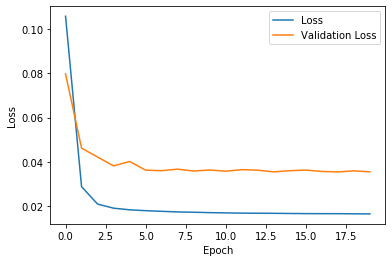

In [31]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [52]:
#checkpoint.restore('C:/Users/IVCL/Desktop/NADS_Net/checkpoints_dock5_DR_occlusionX/ckpt-1')

# Test

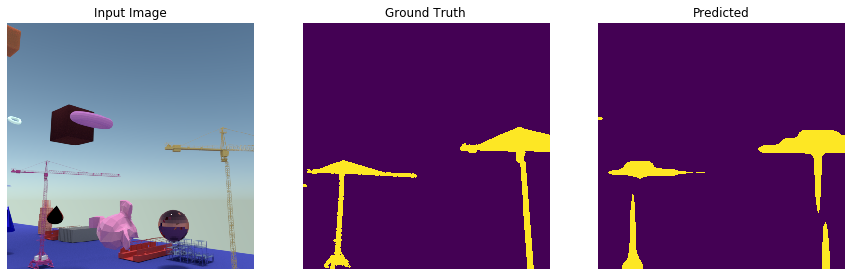

In [47]:
image = read_image(test_paths[num])
label = get_label(test_paths[num])
generate_images(NADS_Net, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


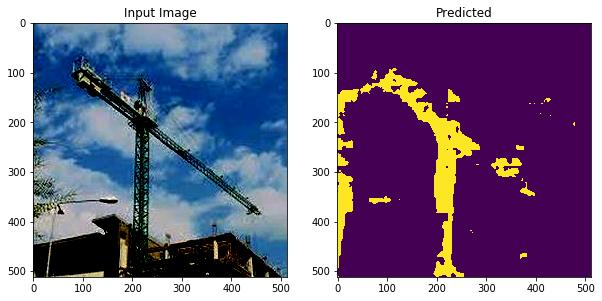

In [53]:
image = read_image('C:/Users/IVCL/Desktop/TC_Real_512/0272.jpg')
image = image[tf.newaxis, ...]
prediction = NADS_Net(image, training=False)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0))
plt.title('Predicted')

plt.show()